#1. Import 

In [1]:
import torchvision.transforms as transforms
import torchvision
import torch
import torch.nn as nn

import random
import matplotlib.pyplot as plt
import os
import time
import csv
from google.colab import files


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#2. Configure Data

In [3]:
def per_image_standardization(image):
    """
    This function creates a custom per image standardization
    transform which is used for data augmentation.
    params:
        - image (torch Tensor): Image Tensor that needs to be standardized.
    
    returns:
        - image (torch Tensor): Image Tensor post standardization.
    """
    # get original data type
    orig_dtype = image.dtype

    # compute image mean
    image_mean = torch.mean(image, dim=(-1, -2, -3))

    # compute image standard deviation
    stddev = torch.std(image, axis=(-1, -2, -3))

    # compute number of pixels
    num_pixels = torch.tensor(torch.numel(image), dtype=torch.float32)

    # compute minimum standard deviation
    min_stddev = torch.rsqrt(num_pixels)

    # compute adjusted standard deviation
    adjusted_stddev = torch.max(stddev, min_stddev)

    # normalize image
    image -= image_mean
    image = torch.div(image, adjusted_stddev)

    # make sure that image output dtype  == input dtype
    assert image.dtype == orig_dtype

    return image

def shuffle_pixels(image, indicies):
    image = image.reshape(3,-1)
    image = image[:,indicies]
    image = image.reshape(3,32,32)
    return image

class myNormalize(object):
    def __call__(self,img):
        return  per_image_standardization(img)

class myShuffle(object):
    def __init__(self, shape):
        self.indicies = torch.randperm(shape)
    def __call__(self,img):
        return  shuffle_pixels(img, self.indicies)

In [ ]:
BATCH_SIZE = 4

transform_train = transforms.Compose([
    #transforms.CenterCrop(28),
    transforms.ToTensor(),
    myNormalize()
    ])

#Models

##Alexnet

In [4]:
class AlexNet(nn.Module):

    def __init__(self, num_classes = 10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 95, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(4),

            nn.Conv2d(95, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(4)
        )
        self.classifier = nn.Sequential(
            # nn.Dropout(),
            nn.Linear(256 * 6 * 6, 384),
            nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(384, 192),
            nn.ReLU(inplace=True),
            nn.Linear(192, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Training

In [6]:
from __future__ import print_function
import random
import csv

import os
import logging
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch.optim
import time

def convergence(model, directory, train_loader, val_loader,start_epoch=None, epochs=200, p_range=[0,0.2,0.4,0.6,0.8,1]):
  
  times = []
  for p in p_range:
    print("P: " + str(p))
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                    download=True, transform=transform_train)
    l = trainset.targets
    l_p = l[:int(len(l)*p)]
    random.shuffle(l_p)
    l[:int(len(l)*p)] = l_p
    trainset.targets = l
    
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

    valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_train)

    val_loader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
    
    time_con = train_model(model, directory, train_loader, val_loader,start_epoch=None, epochs=200)
    times.append(time_con)

  plt.plot(p_range,times)
  plt.title("Time To Convergence")
  plt.xlabel("Proportion of Corrupted Labels")
  plt.ylabel("Time (s)")
  with open('convergence.csv','w') as con_file:
    write = csv.writer(con_file)
    write.writerow(times)
  files.download('convergence.csv')

def train_model(model, directory, train_loader, val_loader, start_epoch=None, epochs=200):
  cudnn.benchmark = True

  # define loss function (criterion) and pptimizer
  criterion = nn.CrossEntropyLoss().cuda()
  optimizer = torch.optim.SGD(model.parameters(), 0.01,
                              momentum=0.9,
                              weight_decay=1e-4)

  start_epoch = start_epoch or 0
  epochs = epochs

  train_acc = 0

  epoch_list, train_losses, val_losses, train_accs, val_accs = [], [], [], [], []
  start_time=time.time()
  for epoch in range(start_epoch, epochs):
    adjust_learning_rate(optimizer, epoch, 0.1)

    # train for one epoch
    train_loss, train_acc = train_epoch(train_loader, model, criterion, optimizer, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # evaluate on validation set
    val_loss, val_acc = validate_epoch(val_loader, model, criterion, epoch)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    epoch_list.append(epoch)
    time_con = time.time() - start_time
    logging.info('%03d: Acc-tr: %6.2f, Acc-val: %6.2f, L-tr: %6.4f, L-val: %6.4f, Time: %f',
                    epoch, train_acc, val_acc, train_loss, val_loss, time_con)
           
    torch.save(model.state_dict(), directory)
    #/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/WRN/WRNModel
    print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
    
    if train_acc == 100.00:
      break

    '''
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Loss Curve")
    plt.plot(epoch_list, train_losses, label="Train")
    plt.plot(epoch_list, val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Accuracy Curve")
    plt.plot(epoch_list, train_accs, label="Train")
    plt.plot(epoch_list, val_accs, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    #plt.legend(loc='best')
    plt.show()
    '''
  print("Final Training Accuracy: {}".format(train_accs[-1]))
  print("Final Validation Accuracy: {}".format(val_accs[-1]))
  return time_con

def get_model(model):
  # create model
  if model == 'wide-resnet':

    model = WideResNet(28, 10, 1,drop_rate=0.0)

  elif model == 'mlp':

    n_units = [int(x) for x in '512'.split('x')] # hidden dims
    n_units.append(10)  # output dim
    n_units.insert(0, 32*32*3)        # input dim
    model = MLP(n_units)

  elif model == 'inception':

    model = Net()

  elif model == 'alexnet':

    model = AlexNet(10)

  # for training on multiple GPUs.
  # Use CUDA_VISIBLE_DEVICES=0,1 to specify which GPUs to use
  # model = torch.nn.DataParallel(model).cuda()
  model = model.cuda()

  return model

def train_epoch(train_loader, model, criterion, optimizer, epoch):
  """Train for one epoch on the training set"""
  batch_time = AverageMeter()
  losses = AverageMeter()
  top1 = AverageMeter()

  # switch to train mode
  model.train()

  for i, (input, target) in enumerate(train_loader):
    target = target.cuda(non_blocking=True)
    input = input.cuda()
    input_var = torch.autograd.Variable(input)
    target_var = torch.autograd.Variable(target)

    # compute output
    output = model(input_var)
    loss = criterion(output, target_var)

    # measure accuracy and record loss
    prec1 = accuracy(output.data, target, topk=(1,))[0]
    losses.update(loss.item(), input.size(0))
    top1.update(prec1.item(), input.size(0))

    # compute gradient and do SGD step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return losses.avg, top1.avg


def validate_epoch(val_loader, model, criterion, epoch):
  """Perform validation on the validation set"""
  batch_time = AverageMeter()
  losses = AverageMeter()
  top1 = AverageMeter()

  # switch to evaluate mode
  model.eval()

  for i, (input, target) in enumerate(val_loader):
    target = target.cuda(non_blocking=True)
    input = input.cuda()
    input_var = torch.autograd.Variable(input, volatile=True)
    target_var = torch.autograd.Variable(target, volatile=True)

    # compute output
    output = model(input_var)
    loss = criterion(output, target_var)

    # measure accuracy and record loss
    prec1 = accuracy(output.data, target, topk=(1,))[0]
    losses.update(loss.item(), input.size(0))
    top1.update(prec1.item(), input.size(0))

  return losses.avg, top1.avg


class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch, lr_0):
  """Sets the learning rate to the initial LR decayed by 10 after 150 and 225 epochs"""
  lr = lr_0 * (0.1 ** (epoch // 150)) * (0.1 ** (epoch // 225))
  for param_group in optimizer.param_groups:
      param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
  """Computes the precision@k for the specified values of k"""
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
      correct_k = correct[:k].view(-1).float().sum(0)
      res.append(correct_k.mul_(100.0 / batch_size))
  return res

def setup_logging(name):
  import datetime
  exp_dir = os.path.join('/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs', name)
  if not os.path.isdir(exp_dir):
    os.makedirs(exp_dir)
  log_fn = os.path.join(exp_dir, "log.{0}.txt".format(datetime.date.today().strftime("%y%m%d")))
  logging.basicConfig(filename=log_fn, filemode='w', level=logging.DEBUG)
  # also log into console
  console = logging.StreamHandler()
  console.setLevel(logging.INFO)
  logging.getLogger('').addHandler(console)
  print('Logging into %s...' % exp_dir)

def main(name, model, train, directory, epochs):
  setup_logging(name)
  if train == 'train':
    train_loader = trainloader
    val_loader = valloader
    model = get_model(model)
    logging.info('Number of parameters: %d', sum([p.data.nelement() for p in model.parameters()]))
    #train_model(model, directory,  train_loader, val_loader, 0, epochs)
    convergence(model, directory,  train_loader, val_loader, 0, epochs, [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])


# Results

In [8]:
BATCH_SIZE = 512

##Color Jitter

In [ ]:
transform_ColorJitter = transforms.Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.ColorJitter(),
    myNormalize()
    ])

Files already downloaded and verified
Files already downloaded and verified
torch.Size([512, 3, 28, 28])


Number of parameters: 4230654
Number of parameters: 4230654


Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Alexnet...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  22.07, Acc-val:  29.26, L-tr: 2.1071, L-val: 1.8619
000: Acc-tr:  22.07, Acc-val:  29.26, L-tr: 2.1071, L-val: 1.8619


Epoch 0 Finished.  Time per Epoch:  15.81 s 


001: Acc-tr:  42.72, Acc-val:  49.97, L-tr: 1.5528, L-val: 1.4081
001: Acc-tr:  42.72, Acc-val:  49.97, L-tr: 1.5528, L-val: 1.4081


Epoch 1 Finished.  Time per Epoch:  15.97 s 


002: Acc-tr:  55.04, Acc-val:  57.41, L-tr: 1.2656, L-val: 1.2187
002: Acc-tr:  55.04, Acc-val:  57.41, L-tr: 1.2656, L-val: 1.2187


Epoch 2 Finished.  Time per Epoch:  16.02 s 


003: Acc-tr:  61.30, Acc-val:  60.80, L-tr: 1.1018, L-val: 1.1116
003: Acc-tr:  61.30, Acc-val:  60.80, L-tr: 1.1018, L-val: 1.1116


Epoch 3 Finished.  Time per Epoch:  16.03 s 


004: Acc-tr:  65.34, Acc-val:  65.97, L-tr: 0.9944, L-val: 0.9862
004: Acc-tr:  65.34, Acc-val:  65.97, L-tr: 0.9944, L-val: 0.9862


Epoch 4 Finished.  Time per Epoch:  16.06 s 


005: Acc-tr:  68.88, Acc-val:  68.46, L-tr: 0.8929, L-val: 0.9179
005: Acc-tr:  68.88, Acc-val:  68.46, L-tr: 0.8929, L-val: 0.9179


Epoch 5 Finished.  Time per Epoch:  16.06 s 


006: Acc-tr:  72.03, Acc-val:  70.28, L-tr: 0.7966, L-val: 0.8851
006: Acc-tr:  72.03, Acc-val:  70.28, L-tr: 0.7966, L-val: 0.8851


Epoch 6 Finished.  Time per Epoch:  16.11 s 


007: Acc-tr:  74.00, Acc-val:  69.76, L-tr: 0.7435, L-val: 0.8759
007: Acc-tr:  74.00, Acc-val:  69.76, L-tr: 0.7435, L-val: 0.8759


Epoch 7 Finished.  Time per Epoch:  16.11 s 


008: Acc-tr:  75.75, Acc-val:  71.19, L-tr: 0.6933, L-val: 0.8713
008: Acc-tr:  75.75, Acc-val:  71.19, L-tr: 0.6933, L-val: 0.8713


Epoch 8 Finished.  Time per Epoch:  16.10 s 


009: Acc-tr:  77.88, Acc-val:  71.43, L-tr: 0.6314, L-val: 0.8850
009: Acc-tr:  77.88, Acc-val:  71.43, L-tr: 0.6314, L-val: 0.8850


Epoch 9 Finished.  Time per Epoch:  16.21 s 


010: Acc-tr:  78.82, Acc-val:  70.95, L-tr: 0.6031, L-val: 0.9215
010: Acc-tr:  78.82, Acc-val:  70.95, L-tr: 0.6031, L-val: 0.9215


Epoch 10 Finished.  Time per Epoch:  16.24 s 


011: Acc-tr:  79.89, Acc-val:  71.99, L-tr: 0.5725, L-val: 0.9163
011: Acc-tr:  79.89, Acc-val:  71.99, L-tr: 0.5725, L-val: 0.9163


Epoch 11 Finished.  Time per Epoch:  16.23 s 


012: Acc-tr:  81.71, Acc-val:  71.80, L-tr: 0.5181, L-val: 0.9462
012: Acc-tr:  81.71, Acc-val:  71.80, L-tr: 0.5181, L-val: 0.9462


Epoch 12 Finished.  Time per Epoch:  16.23 s 


013: Acc-tr:  82.66, Acc-val:  72.97, L-tr: 0.4923, L-val: 0.9095
013: Acc-tr:  82.66, Acc-val:  72.97, L-tr: 0.4923, L-val: 0.9095


Epoch 13 Finished.  Time per Epoch:  16.22 s 


014: Acc-tr:  84.16, Acc-val:  71.78, L-tr: 0.4451, L-val: 0.9596
014: Acc-tr:  84.16, Acc-val:  71.78, L-tr: 0.4451, L-val: 0.9596


Epoch 14 Finished.  Time per Epoch:  16.21 s 


015: Acc-tr:  85.18, Acc-val:  72.41, L-tr: 0.4236, L-val: 0.9772
015: Acc-tr:  85.18, Acc-val:  72.41, L-tr: 0.4236, L-val: 0.9772


Epoch 15 Finished.  Time per Epoch:  16.20 s 


016: Acc-tr:  85.94, Acc-val:  72.39, L-tr: 0.4016, L-val: 1.0226
016: Acc-tr:  85.94, Acc-val:  72.39, L-tr: 0.4016, L-val: 1.0226


Epoch 16 Finished.  Time per Epoch:  16.19 s 


017: Acc-tr:  86.73, Acc-val:  72.46, L-tr: 0.3742, L-val: 0.9956
017: Acc-tr:  86.73, Acc-val:  72.46, L-tr: 0.3742, L-val: 0.9956


Epoch 17 Finished.  Time per Epoch:  16.18 s 


018: Acc-tr:  86.91, Acc-val:  71.39, L-tr: 0.3729, L-val: 1.0814
018: Acc-tr:  86.91, Acc-val:  71.39, L-tr: 0.3729, L-val: 1.0814


Epoch 18 Finished.  Time per Epoch:  16.19 s 


019: Acc-tr:  88.11, Acc-val:  71.85, L-tr: 0.3391, L-val: 1.1312
019: Acc-tr:  88.11, Acc-val:  71.85, L-tr: 0.3391, L-val: 1.1312


Epoch 19 Finished.  Time per Epoch:  16.19 s 


020: Acc-tr:  88.51, Acc-val:  73.05, L-tr: 0.3308, L-val: 1.1309
020: Acc-tr:  88.51, Acc-val:  73.05, L-tr: 0.3308, L-val: 1.1309


Epoch 20 Finished.  Time per Epoch:  16.19 s 


021: Acc-tr:  89.25, Acc-val:  72.25, L-tr: 0.3102, L-val: 1.0893
021: Acc-tr:  89.25, Acc-val:  72.25, L-tr: 0.3102, L-val: 1.0893


Epoch 21 Finished.  Time per Epoch:  16.19 s 


022: Acc-tr:  89.76, Acc-val:  71.78, L-tr: 0.2974, L-val: 1.1537
022: Acc-tr:  89.76, Acc-val:  71.78, L-tr: 0.2974, L-val: 1.1537


Epoch 22 Finished.  Time per Epoch:  16.19 s 


023: Acc-tr:  89.55, Acc-val:  72.00, L-tr: 0.3043, L-val: 1.1937
023: Acc-tr:  89.55, Acc-val:  72.00, L-tr: 0.3043, L-val: 1.1937


Epoch 23 Finished.  Time per Epoch:  16.18 s 


024: Acc-tr:  90.91, Acc-val:  71.60, L-tr: 0.2679, L-val: 1.3178
024: Acc-tr:  90.91, Acc-val:  71.60, L-tr: 0.2679, L-val: 1.3178


Epoch 24 Finished.  Time per Epoch:  16.18 s 


025: Acc-tr:  90.37, Acc-val:  71.41, L-tr: 0.2840, L-val: 1.3026
025: Acc-tr:  90.37, Acc-val:  71.41, L-tr: 0.2840, L-val: 1.3026


Epoch 25 Finished.  Time per Epoch:  16.18 s 


026: Acc-tr:  91.65, Acc-val:  71.88, L-tr: 0.2498, L-val: 1.3765
026: Acc-tr:  91.65, Acc-val:  71.88, L-tr: 0.2498, L-val: 1.3765


Epoch 26 Finished.  Time per Epoch:  16.18 s 


027: Acc-tr:  91.18, Acc-val:  71.48, L-tr: 0.2633, L-val: 1.3998
027: Acc-tr:  91.18, Acc-val:  71.48, L-tr: 0.2633, L-val: 1.3998


Epoch 27 Finished.  Time per Epoch:  16.18 s 


028: Acc-tr:  92.33, Acc-val:  71.46, L-tr: 0.2276, L-val: 1.4822
028: Acc-tr:  92.33, Acc-val:  71.46, L-tr: 0.2276, L-val: 1.4822


Epoch 28 Finished.  Time per Epoch:  16.19 s 


029: Acc-tr:  92.83, Acc-val:  71.80, L-tr: 0.2163, L-val: 1.3934
029: Acc-tr:  92.83, Acc-val:  71.80, L-tr: 0.2163, L-val: 1.3934


Epoch 29 Finished.  Time per Epoch:  16.19 s 


030: Acc-tr:  92.23, Acc-val:  71.57, L-tr: 0.2352, L-val: 1.4864
030: Acc-tr:  92.23, Acc-val:  71.57, L-tr: 0.2352, L-val: 1.4864


Epoch 30 Finished.  Time per Epoch:  16.18 s 


031: Acc-tr:  92.46, Acc-val:  71.36, L-tr: 0.2277, L-val: 1.5484
031: Acc-tr:  92.46, Acc-val:  71.36, L-tr: 0.2277, L-val: 1.5484


Epoch 31 Finished.  Time per Epoch:  16.17 s 


032: Acc-tr:  92.79, Acc-val:  71.47, L-tr: 0.2269, L-val: 1.5532
032: Acc-tr:  92.79, Acc-val:  71.47, L-tr: 0.2269, L-val: 1.5532


Epoch 32 Finished.  Time per Epoch:  16.17 s 


033: Acc-tr:  93.39, Acc-val:  72.14, L-tr: 0.2015, L-val: 1.5254
033: Acc-tr:  93.39, Acc-val:  72.14, L-tr: 0.2015, L-val: 1.5254


Epoch 33 Finished.  Time per Epoch:  16.17 s 


034: Acc-tr:  93.34, Acc-val:  72.01, L-tr: 0.1996, L-val: 1.4965
034: Acc-tr:  93.34, Acc-val:  72.01, L-tr: 0.1996, L-val: 1.4965


Epoch 34 Finished.  Time per Epoch:  16.17 s 


035: Acc-tr:  92.42, Acc-val:  71.29, L-tr: 0.2331, L-val: 1.5176
035: Acc-tr:  92.42, Acc-val:  71.29, L-tr: 0.2331, L-val: 1.5176


Epoch 35 Finished.  Time per Epoch:  16.17 s 


036: Acc-tr:  93.28, Acc-val:  71.16, L-tr: 0.2113, L-val: 1.5299
036: Acc-tr:  93.28, Acc-val:  71.16, L-tr: 0.2113, L-val: 1.5299


Epoch 36 Finished.  Time per Epoch:  16.17 s 


037: Acc-tr:  93.49, Acc-val:  71.23, L-tr: 0.2023, L-val: 1.7127
037: Acc-tr:  93.49, Acc-val:  71.23, L-tr: 0.2023, L-val: 1.7127


Epoch 37 Finished.  Time per Epoch:  16.17 s 


038: Acc-tr:  94.27, Acc-val:  70.89, L-tr: 0.1792, L-val: 1.6704
038: Acc-tr:  94.27, Acc-val:  70.89, L-tr: 0.1792, L-val: 1.6704


Epoch 38 Finished.  Time per Epoch:  16.16 s 


039: Acc-tr:  94.15, Acc-val:  71.50, L-tr: 0.1830, L-val: 1.7694
039: Acc-tr:  94.15, Acc-val:  71.50, L-tr: 0.1830, L-val: 1.7694


Epoch 39 Finished.  Time per Epoch:  16.16 s 


040: Acc-tr:  94.38, Acc-val:  70.86, L-tr: 0.1779, L-val: 1.6447
040: Acc-tr:  94.38, Acc-val:  70.86, L-tr: 0.1779, L-val: 1.6447


Epoch 40 Finished.  Time per Epoch:  16.16 s 


041: Acc-tr:  94.65, Acc-val:  71.18, L-tr: 0.1707, L-val: 1.7770
041: Acc-tr:  94.65, Acc-val:  71.18, L-tr: 0.1707, L-val: 1.7770


Epoch 41 Finished.  Time per Epoch:  16.16 s 


042: Acc-tr:  94.73, Acc-val:  70.94, L-tr: 0.1714, L-val: 1.7059
042: Acc-tr:  94.73, Acc-val:  70.94, L-tr: 0.1714, L-val: 1.7059


Epoch 42 Finished.  Time per Epoch:  16.16 s 


043: Acc-tr:  94.32, Acc-val:  71.28, L-tr: 0.1846, L-val: 1.8124
043: Acc-tr:  94.32, Acc-val:  71.28, L-tr: 0.1846, L-val: 1.8124


Epoch 43 Finished.  Time per Epoch:  16.16 s 


044: Acc-tr:  94.59, Acc-val:  71.85, L-tr: 0.1734, L-val: 1.7916
044: Acc-tr:  94.59, Acc-val:  71.85, L-tr: 0.1734, L-val: 1.7916


Epoch 44 Finished.  Time per Epoch:  16.16 s 


045: Acc-tr:  94.79, Acc-val:  70.72, L-tr: 0.1690, L-val: 1.8446
045: Acc-tr:  94.79, Acc-val:  70.72, L-tr: 0.1690, L-val: 1.8446


Epoch 45 Finished.  Time per Epoch:  16.15 s 


046: Acc-tr:  94.80, Acc-val:  71.23, L-tr: 0.1695, L-val: 1.9489
046: Acc-tr:  94.80, Acc-val:  71.23, L-tr: 0.1695, L-val: 1.9489


Epoch 46 Finished.  Time per Epoch:  16.15 s 


047: Acc-tr:  94.98, Acc-val:  70.80, L-tr: 0.1653, L-val: 1.8494
047: Acc-tr:  94.98, Acc-val:  70.80, L-tr: 0.1653, L-val: 1.8494


Epoch 47 Finished.  Time per Epoch:  16.16 s 


048: Acc-tr:  95.52, Acc-val:  70.93, L-tr: 0.1472, L-val: 1.9740
048: Acc-tr:  95.52, Acc-val:  70.93, L-tr: 0.1472, L-val: 1.9740


Epoch 48 Finished.  Time per Epoch:  16.16 s 


049: Acc-tr:  94.33, Acc-val:  71.62, L-tr: 0.1909, L-val: 1.7472
049: Acc-tr:  94.33, Acc-val:  71.62, L-tr: 0.1909, L-val: 1.7472


Epoch 49 Finished.  Time per Epoch:  16.15 s 


050: Acc-tr:  95.34, Acc-val:  72.09, L-tr: 0.1523, L-val: 1.8166
050: Acc-tr:  95.34, Acc-val:  72.09, L-tr: 0.1523, L-val: 1.8166


Epoch 50 Finished.  Time per Epoch:  16.15 s 


051: Acc-tr:  95.46, Acc-val:  71.41, L-tr: 0.1494, L-val: 1.7988
051: Acc-tr:  95.46, Acc-val:  71.41, L-tr: 0.1494, L-val: 1.7988


Epoch 51 Finished.  Time per Epoch:  16.15 s 


052: Acc-tr:  95.49, Acc-val:  71.15, L-tr: 0.1460, L-val: 1.9102
052: Acc-tr:  95.49, Acc-val:  71.15, L-tr: 0.1460, L-val: 1.9102


Epoch 52 Finished.  Time per Epoch:  16.15 s 


053: Acc-tr:  95.07, Acc-val:  71.00, L-tr: 0.1722, L-val: 1.8812
053: Acc-tr:  95.07, Acc-val:  71.00, L-tr: 0.1722, L-val: 1.8812


Epoch 53 Finished.  Time per Epoch:  16.14 s 


054: Acc-tr:  95.45, Acc-val:  72.08, L-tr: 0.1478, L-val: 2.0007
054: Acc-tr:  95.45, Acc-val:  72.08, L-tr: 0.1478, L-val: 2.0007


Epoch 54 Finished.  Time per Epoch:  16.14 s 


055: Acc-tr:  95.37, Acc-val:  71.39, L-tr: 0.1560, L-val: 1.9561
055: Acc-tr:  95.37, Acc-val:  71.39, L-tr: 0.1560, L-val: 1.9561


Epoch 55 Finished.  Time per Epoch:  16.15 s 


056: Acc-tr:  95.23, Acc-val:  70.44, L-tr: 0.1645, L-val: 1.8188
056: Acc-tr:  95.23, Acc-val:  70.44, L-tr: 0.1645, L-val: 1.8188


Epoch 56 Finished.  Time per Epoch:  16.14 s 


057: Acc-tr:  95.56, Acc-val:  70.59, L-tr: 0.1538, L-val: 1.9268
057: Acc-tr:  95.56, Acc-val:  70.59, L-tr: 0.1538, L-val: 1.9268


Epoch 57 Finished.  Time per Epoch:  16.14 s 


058: Acc-tr:  95.47, Acc-val:  71.51, L-tr: 0.1516, L-val: 1.8552
058: Acc-tr:  95.47, Acc-val:  71.51, L-tr: 0.1516, L-val: 1.8552


Epoch 58 Finished.  Time per Epoch:  16.14 s 


059: Acc-tr:  95.53, Acc-val:  71.48, L-tr: 0.1503, L-val: 1.9989
059: Acc-tr:  95.53, Acc-val:  71.48, L-tr: 0.1503, L-val: 1.9989


Epoch 59 Finished.  Time per Epoch:  16.14 s 


060: Acc-tr:  95.63, Acc-val:  70.69, L-tr: 0.1508, L-val: 2.0864
060: Acc-tr:  95.63, Acc-val:  70.69, L-tr: 0.1508, L-val: 2.0864


Epoch 60 Finished.  Time per Epoch:  16.14 s 


061: Acc-tr:  95.35, Acc-val:  71.09, L-tr: 0.1585, L-val: 1.9564
061: Acc-tr:  95.35, Acc-val:  71.09, L-tr: 0.1585, L-val: 1.9564


Epoch 61 Finished.  Time per Epoch:  16.14 s 


062: Acc-tr:  95.86, Acc-val:  71.33, L-tr: 0.1418, L-val: 1.8503
062: Acc-tr:  95.86, Acc-val:  71.33, L-tr: 0.1418, L-val: 1.8503


Epoch 62 Finished.  Time per Epoch:  16.14 s 


063: Acc-tr:  96.36, Acc-val:  72.65, L-tr: 0.1276, L-val: 2.0215
063: Acc-tr:  96.36, Acc-val:  72.65, L-tr: 0.1276, L-val: 2.0215


Epoch 63 Finished.  Time per Epoch:  16.14 s 


064: Acc-tr:  96.59, Acc-val:  72.13, L-tr: 0.1165, L-val: 2.0679
064: Acc-tr:  96.59, Acc-val:  72.13, L-tr: 0.1165, L-val: 2.0679


Epoch 64 Finished.  Time per Epoch:  16.13 s 


065: Acc-tr:  96.25, Acc-val:  70.99, L-tr: 0.1276, L-val: 2.2335
065: Acc-tr:  96.25, Acc-val:  70.99, L-tr: 0.1276, L-val: 2.2335


Epoch 65 Finished.  Time per Epoch:  16.13 s 


066: Acc-tr:  95.96, Acc-val:  70.51, L-tr: 0.1432, L-val: 2.0512
066: Acc-tr:  95.96, Acc-val:  70.51, L-tr: 0.1432, L-val: 2.0512


Epoch 66 Finished.  Time per Epoch:  16.13 s 


067: Acc-tr:  95.76, Acc-val:  71.93, L-tr: 0.1495, L-val: 2.1630
067: Acc-tr:  95.76, Acc-val:  71.93, L-tr: 0.1495, L-val: 2.1630


Epoch 67 Finished.  Time per Epoch:  16.13 s 


068: Acc-tr:  95.91, Acc-val:  71.24, L-tr: 0.1437, L-val: 2.0941
068: Acc-tr:  95.91, Acc-val:  71.24, L-tr: 0.1437, L-val: 2.0941


Epoch 68 Finished.  Time per Epoch:  16.13 s 


069: Acc-tr:  95.44, Acc-val:  71.74, L-tr: 0.1628, L-val: 2.0581
069: Acc-tr:  95.44, Acc-val:  71.74, L-tr: 0.1628, L-val: 2.0581


Epoch 69 Finished.  Time per Epoch:  16.13 s 


070: Acc-tr:  96.02, Acc-val:  70.76, L-tr: 0.1451, L-val: 2.0848
070: Acc-tr:  96.02, Acc-val:  70.76, L-tr: 0.1451, L-val: 2.0848


Epoch 70 Finished.  Time per Epoch:  16.13 s 


071: Acc-tr:  96.47, Acc-val:  71.45, L-tr: 0.1239, L-val: 2.0470
071: Acc-tr:  96.47, Acc-val:  71.45, L-tr: 0.1239, L-val: 2.0470


Epoch 71 Finished.  Time per Epoch:  16.13 s 


072: Acc-tr:  96.68, Acc-val:  70.94, L-tr: 0.1179, L-val: 2.3376
072: Acc-tr:  96.68, Acc-val:  70.94, L-tr: 0.1179, L-val: 2.3376


Epoch 72 Finished.  Time per Epoch:  16.13 s 


073: Acc-tr:  97.04, Acc-val:  72.30, L-tr: 0.1045, L-val: 2.3060
073: Acc-tr:  97.04, Acc-val:  72.30, L-tr: 0.1045, L-val: 2.3060


Epoch 73 Finished.  Time per Epoch:  16.13 s 


074: Acc-tr:  96.29, Acc-val:  71.57, L-tr: 0.1330, L-val: 2.0644
074: Acc-tr:  96.29, Acc-val:  71.57, L-tr: 0.1330, L-val: 2.0644


Epoch 74 Finished.  Time per Epoch:  16.13 s 


075: Acc-tr:  96.59, Acc-val:  71.18, L-tr: 0.1232, L-val: 2.0766
075: Acc-tr:  96.59, Acc-val:  71.18, L-tr: 0.1232, L-val: 2.0766


Epoch 75 Finished.  Time per Epoch:  16.13 s 


076: Acc-tr:  96.22, Acc-val:  70.26, L-tr: 0.1387, L-val: 2.1321
076: Acc-tr:  96.22, Acc-val:  70.26, L-tr: 0.1387, L-val: 2.1321


Epoch 76 Finished.  Time per Epoch:  16.13 s 


077: Acc-tr:  97.26, Acc-val:  72.23, L-tr: 0.0967, L-val: 2.2070
077: Acc-tr:  97.26, Acc-val:  72.23, L-tr: 0.0967, L-val: 2.2070


Epoch 77 Finished.  Time per Epoch:  16.13 s 


078: Acc-tr:  97.14, Acc-val:  71.93, L-tr: 0.1012, L-val: 2.2354
078: Acc-tr:  97.14, Acc-val:  71.93, L-tr: 0.1012, L-val: 2.2354


Epoch 78 Finished.  Time per Epoch:  16.13 s 


079: Acc-tr:  97.31, Acc-val:  71.73, L-tr: 0.0964, L-val: 2.1495
079: Acc-tr:  97.31, Acc-val:  71.73, L-tr: 0.0964, L-val: 2.1495


Epoch 79 Finished.  Time per Epoch:  16.13 s 


080: Acc-tr:  96.94, Acc-val:  71.15, L-tr: 0.1104, L-val: 2.2272
080: Acc-tr:  96.94, Acc-val:  71.15, L-tr: 0.1104, L-val: 2.2272


Epoch 80 Finished.  Time per Epoch:  16.13 s 


081: Acc-tr:  96.86, Acc-val:  71.64, L-tr: 0.1142, L-val: 2.2380
081: Acc-tr:  96.86, Acc-val:  71.64, L-tr: 0.1142, L-val: 2.2380


Epoch 81 Finished.  Time per Epoch:  16.13 s 


082: Acc-tr:  96.77, Acc-val:  71.46, L-tr: 0.1173, L-val: 2.2643
082: Acc-tr:  96.77, Acc-val:  71.46, L-tr: 0.1173, L-val: 2.2643


Epoch 82 Finished.  Time per Epoch:  16.13 s 


083: Acc-tr:  96.15, Acc-val:  71.46, L-tr: 0.1388, L-val: 2.1940
083: Acc-tr:  96.15, Acc-val:  71.46, L-tr: 0.1388, L-val: 2.1940


Epoch 83 Finished.  Time per Epoch:  16.13 s 


084: Acc-tr:  97.27, Acc-val:  70.78, L-tr: 0.0974, L-val: 2.2001
084: Acc-tr:  97.27, Acc-val:  70.78, L-tr: 0.0974, L-val: 2.2001


Epoch 84 Finished.  Time per Epoch:  16.13 s 


085: Acc-tr:  96.72, Acc-val:  71.32, L-tr: 0.1181, L-val: 2.1821
085: Acc-tr:  96.72, Acc-val:  71.32, L-tr: 0.1181, L-val: 2.1821


Epoch 85 Finished.  Time per Epoch:  16.13 s 


086: Acc-tr:  97.10, Acc-val:  72.23, L-tr: 0.1025, L-val: 2.1237
086: Acc-tr:  97.10, Acc-val:  72.23, L-tr: 0.1025, L-val: 2.1237


Epoch 86 Finished.  Time per Epoch:  16.13 s 


087: Acc-tr:  97.46, Acc-val:  71.96, L-tr: 0.0915, L-val: 2.3565
087: Acc-tr:  97.46, Acc-val:  71.96, L-tr: 0.0915, L-val: 2.3565


Epoch 87 Finished.  Time per Epoch:  16.13 s 


088: Acc-tr:  97.04, Acc-val:  71.71, L-tr: 0.1074, L-val: 2.3580
088: Acc-tr:  97.04, Acc-val:  71.71, L-tr: 0.1074, L-val: 2.3580


Epoch 88 Finished.  Time per Epoch:  16.13 s 


089: Acc-tr:  97.11, Acc-val:  72.27, L-tr: 0.1020, L-val: 2.3284
089: Acc-tr:  97.11, Acc-val:  72.27, L-tr: 0.1020, L-val: 2.3284


Epoch 89 Finished.  Time per Epoch:  16.13 s 


090: Acc-tr:  96.80, Acc-val:  71.78, L-tr: 0.1200, L-val: 2.1235
090: Acc-tr:  96.80, Acc-val:  71.78, L-tr: 0.1200, L-val: 2.1235


Epoch 90 Finished.  Time per Epoch:  16.13 s 


091: Acc-tr:  96.50, Acc-val:  70.42, L-tr: 0.1269, L-val: 2.1377
091: Acc-tr:  96.50, Acc-val:  70.42, L-tr: 0.1269, L-val: 2.1377


Epoch 91 Finished.  Time per Epoch:  16.13 s 


092: Acc-tr:  97.09, Acc-val:  71.60, L-tr: 0.1071, L-val: 2.4603
092: Acc-tr:  97.09, Acc-val:  71.60, L-tr: 0.1071, L-val: 2.4603


Epoch 92 Finished.  Time per Epoch:  16.13 s 


093: Acc-tr:  96.85, Acc-val:  71.19, L-tr: 0.1145, L-val: 2.3446
093: Acc-tr:  96.85, Acc-val:  71.19, L-tr: 0.1145, L-val: 2.3446


Epoch 93 Finished.  Time per Epoch:  16.13 s 


094: Acc-tr:  97.42, Acc-val:  71.09, L-tr: 0.0932, L-val: 2.1278
094: Acc-tr:  97.42, Acc-val:  71.09, L-tr: 0.0932, L-val: 2.1278


Epoch 94 Finished.  Time per Epoch:  16.14 s 


095: Acc-tr:  97.06, Acc-val:  72.02, L-tr: 0.1040, L-val: 2.2995
095: Acc-tr:  97.06, Acc-val:  72.02, L-tr: 0.1040, L-val: 2.2995


Epoch 95 Finished.  Time per Epoch:  16.15 s 


096: Acc-tr:  97.49, Acc-val:  71.09, L-tr: 0.0951, L-val: 2.4295
096: Acc-tr:  97.49, Acc-val:  71.09, L-tr: 0.0951, L-val: 2.4295


Epoch 96 Finished.  Time per Epoch:  16.16 s 


097: Acc-tr:  97.35, Acc-val:  72.44, L-tr: 0.0989, L-val: 2.2767
097: Acc-tr:  97.35, Acc-val:  72.44, L-tr: 0.0989, L-val: 2.2767


Epoch 97 Finished.  Time per Epoch:  16.17 s 


098: Acc-tr:  97.29, Acc-val:  70.87, L-tr: 0.1014, L-val: 2.1655
098: Acc-tr:  97.29, Acc-val:  70.87, L-tr: 0.1014, L-val: 2.1655


Epoch 98 Finished.  Time per Epoch:  16.17 s 


099: Acc-tr:  96.83, Acc-val:  70.73, L-tr: 0.1184, L-val: 2.2070
099: Acc-tr:  96.83, Acc-val:  70.73, L-tr: 0.1184, L-val: 2.2070


Epoch 99 Finished.  Time per Epoch:  16.18 s 


100: Acc-tr:  97.07, Acc-val:  71.34, L-tr: 0.1080, L-val: 2.3160
100: Acc-tr:  97.07, Acc-val:  71.34, L-tr: 0.1080, L-val: 2.3160


Epoch 100 Finished.  Time per Epoch:  16.18 s 


101: Acc-tr:  97.36, Acc-val:  71.86, L-tr: 0.0954, L-val: 2.4014
101: Acc-tr:  97.36, Acc-val:  71.86, L-tr: 0.0954, L-val: 2.4014


Epoch 101 Finished.  Time per Epoch:  16.18 s 


102: Acc-tr:  97.09, Acc-val:  72.20, L-tr: 0.1066, L-val: 2.3700
102: Acc-tr:  97.09, Acc-val:  72.20, L-tr: 0.1066, L-val: 2.3700


Epoch 102 Finished.  Time per Epoch:  16.17 s 


103: Acc-tr:  97.35, Acc-val:  72.00, L-tr: 0.0967, L-val: 2.4207
103: Acc-tr:  97.35, Acc-val:  72.00, L-tr: 0.0967, L-val: 2.4207


Epoch 103 Finished.  Time per Epoch:  16.17 s 


104: Acc-tr:  96.35, Acc-val:  71.73, L-tr: 0.1346, L-val: 2.0928
104: Acc-tr:  96.35, Acc-val:  71.73, L-tr: 0.1346, L-val: 2.0928


Epoch 104 Finished.  Time per Epoch:  16.17 s 


105: Acc-tr:  97.51, Acc-val:  72.32, L-tr: 0.0931, L-val: 2.0686
105: Acc-tr:  97.51, Acc-val:  72.32, L-tr: 0.0931, L-val: 2.0686


Epoch 105 Finished.  Time per Epoch:  16.17 s 


106: Acc-tr:  98.00, Acc-val:  71.78, L-tr: 0.0713, L-val: 2.4177
106: Acc-tr:  98.00, Acc-val:  71.78, L-tr: 0.0713, L-val: 2.4177


Epoch 106 Finished.  Time per Epoch:  16.17 s 


107: Acc-tr:  97.45, Acc-val:  71.92, L-tr: 0.0961, L-val: 2.3121
107: Acc-tr:  97.45, Acc-val:  71.92, L-tr: 0.0961, L-val: 2.3121


Epoch 107 Finished.  Time per Epoch:  16.17 s 


108: Acc-tr:  98.12, Acc-val:  72.46, L-tr: 0.0671, L-val: 2.4244
108: Acc-tr:  98.12, Acc-val:  72.46, L-tr: 0.0671, L-val: 2.4244


Epoch 108 Finished.  Time per Epoch:  16.17 s 


109: Acc-tr:  97.78, Acc-val:  70.89, L-tr: 0.0811, L-val: 2.5917
109: Acc-tr:  97.78, Acc-val:  70.89, L-tr: 0.0811, L-val: 2.5917


Epoch 109 Finished.  Time per Epoch:  16.17 s 


110: Acc-tr:  97.40, Acc-val:  71.88, L-tr: 0.0929, L-val: 2.3794
110: Acc-tr:  97.40, Acc-val:  71.88, L-tr: 0.0929, L-val: 2.3794


Epoch 110 Finished.  Time per Epoch:  16.17 s 


111: Acc-tr:  97.86, Acc-val:  71.63, L-tr: 0.0775, L-val: 2.3523
111: Acc-tr:  97.86, Acc-val:  71.63, L-tr: 0.0775, L-val: 2.3523


Epoch 111 Finished.  Time per Epoch:  16.17 s 


112: Acc-tr:  97.91, Acc-val:  71.75, L-tr: 0.0758, L-val: 2.4223
112: Acc-tr:  97.91, Acc-val:  71.75, L-tr: 0.0758, L-val: 2.4223


Epoch 112 Finished.  Time per Epoch:  16.17 s 


113: Acc-tr:  97.49, Acc-val:  71.66, L-tr: 0.0933, L-val: 2.2857
113: Acc-tr:  97.49, Acc-val:  71.66, L-tr: 0.0933, L-val: 2.2857


Epoch 113 Finished.  Time per Epoch:  16.17 s 


114: Acc-tr:  97.15, Acc-val:  71.35, L-tr: 0.1059, L-val: 2.3415
114: Acc-tr:  97.15, Acc-val:  71.35, L-tr: 0.1059, L-val: 2.3415


Epoch 114 Finished.  Time per Epoch:  16.17 s 


115: Acc-tr:  97.53, Acc-val:  72.03, L-tr: 0.0891, L-val: 2.3167
115: Acc-tr:  97.53, Acc-val:  72.03, L-tr: 0.0891, L-val: 2.3167


Epoch 115 Finished.  Time per Epoch:  16.16 s 


116: Acc-tr:  97.76, Acc-val:  71.52, L-tr: 0.0844, L-val: 2.3303
116: Acc-tr:  97.76, Acc-val:  71.52, L-tr: 0.0844, L-val: 2.3303


Epoch 116 Finished.  Time per Epoch:  16.16 s 


117: Acc-tr:  97.40, Acc-val:  71.82, L-tr: 0.0994, L-val: 2.4154
117: Acc-tr:  97.40, Acc-val:  71.82, L-tr: 0.0994, L-val: 2.4154


Epoch 117 Finished.  Time per Epoch:  16.16 s 


118: Acc-tr:  97.69, Acc-val:  72.08, L-tr: 0.0860, L-val: 2.3230
118: Acc-tr:  97.69, Acc-val:  72.08, L-tr: 0.0860, L-val: 2.3230


Epoch 118 Finished.  Time per Epoch:  16.16 s 


119: Acc-tr:  98.31, Acc-val:  72.68, L-tr: 0.0609, L-val: 2.4224
119: Acc-tr:  98.31, Acc-val:  72.68, L-tr: 0.0609, L-val: 2.4224


Epoch 119 Finished.  Time per Epoch:  16.16 s 


120: Acc-tr:  97.86, Acc-val:  71.98, L-tr: 0.0781, L-val: 2.2693
120: Acc-tr:  97.86, Acc-val:  71.98, L-tr: 0.0781, L-val: 2.2693


Epoch 120 Finished.  Time per Epoch:  16.16 s 


121: Acc-tr:  98.03, Acc-val:  71.68, L-tr: 0.0717, L-val: 2.2668
121: Acc-tr:  98.03, Acc-val:  71.68, L-tr: 0.0717, L-val: 2.2668


Epoch 121 Finished.  Time per Epoch:  16.15 s 


122: Acc-tr:  98.38, Acc-val:  72.04, L-tr: 0.0611, L-val: 2.3788
122: Acc-tr:  98.38, Acc-val:  72.04, L-tr: 0.0611, L-val: 2.3788


Epoch 122 Finished.  Time per Epoch:  16.15 s 


123: Acc-tr:  98.48, Acc-val:  72.54, L-tr: 0.0553, L-val: 2.5922
123: Acc-tr:  98.48, Acc-val:  72.54, L-tr: 0.0553, L-val: 2.5922


Epoch 123 Finished.  Time per Epoch:  16.15 s 


124: Acc-tr:  97.88, Acc-val:  71.76, L-tr: 0.0803, L-val: 2.1842
124: Acc-tr:  97.88, Acc-val:  71.76, L-tr: 0.0803, L-val: 2.1842


Epoch 124 Finished.  Time per Epoch:  16.15 s 


125: Acc-tr:  97.87, Acc-val:  72.15, L-tr: 0.0796, L-val: 2.3074
125: Acc-tr:  97.87, Acc-val:  72.15, L-tr: 0.0796, L-val: 2.3074


Epoch 125 Finished.  Time per Epoch:  16.15 s 


126: Acc-tr:  98.00, Acc-val:  71.73, L-tr: 0.0721, L-val: 2.3556
126: Acc-tr:  98.00, Acc-val:  71.73, L-tr: 0.0721, L-val: 2.3556


Epoch 126 Finished.  Time per Epoch:  16.15 s 


127: Acc-tr:  98.15, Acc-val:  72.23, L-tr: 0.0689, L-val: 2.3330
127: Acc-tr:  98.15, Acc-val:  72.23, L-tr: 0.0689, L-val: 2.3330


Epoch 127 Finished.  Time per Epoch:  16.15 s 


128: Acc-tr:  98.06, Acc-val:  72.13, L-tr: 0.0706, L-val: 2.3799
128: Acc-tr:  98.06, Acc-val:  72.13, L-tr: 0.0706, L-val: 2.3799


Epoch 128 Finished.  Time per Epoch:  16.15 s 


129: Acc-tr:  97.98, Acc-val:  71.98, L-tr: 0.0766, L-val: 2.1536
129: Acc-tr:  97.98, Acc-val:  71.98, L-tr: 0.0766, L-val: 2.1536


Epoch 129 Finished.  Time per Epoch:  16.15 s 


130: Acc-tr:  98.32, Acc-val:  72.27, L-tr: 0.0618, L-val: 2.3889
130: Acc-tr:  98.32, Acc-val:  72.27, L-tr: 0.0618, L-val: 2.3889


Epoch 130 Finished.  Time per Epoch:  16.15 s 


131: Acc-tr:  98.40, Acc-val:  72.34, L-tr: 0.0587, L-val: 2.2839
131: Acc-tr:  98.40, Acc-val:  72.34, L-tr: 0.0587, L-val: 2.2839


Epoch 131 Finished.  Time per Epoch:  16.15 s 


132: Acc-tr:  98.35, Acc-val:  72.06, L-tr: 0.0601, L-val: 2.2117
132: Acc-tr:  98.35, Acc-val:  72.06, L-tr: 0.0601, L-val: 2.2117


Epoch 132 Finished.  Time per Epoch:  16.14 s 


133: Acc-tr:  98.60, Acc-val:  71.09, L-tr: 0.0513, L-val: 2.4845
133: Acc-tr:  98.60, Acc-val:  71.09, L-tr: 0.0513, L-val: 2.4845


Epoch 133 Finished.  Time per Epoch:  16.14 s 


134: Acc-tr:  98.33, Acc-val:  71.74, L-tr: 0.0604, L-val: 2.4843
134: Acc-tr:  98.33, Acc-val:  71.74, L-tr: 0.0604, L-val: 2.4843


Epoch 134 Finished.  Time per Epoch:  16.14 s 


135: Acc-tr:  97.62, Acc-val:  71.25, L-tr: 0.0895, L-val: 2.2351
135: Acc-tr:  97.62, Acc-val:  71.25, L-tr: 0.0895, L-val: 2.2351


Epoch 135 Finished.  Time per Epoch:  16.14 s 


136: Acc-tr:  98.13, Acc-val:  71.23, L-tr: 0.0664, L-val: 2.4006
136: Acc-tr:  98.13, Acc-val:  71.23, L-tr: 0.0664, L-val: 2.4006


Epoch 136 Finished.  Time per Epoch:  16.14 s 


137: Acc-tr:  97.70, Acc-val:  72.15, L-tr: 0.0850, L-val: 2.1798
137: Acc-tr:  97.70, Acc-val:  72.15, L-tr: 0.0850, L-val: 2.1798


Epoch 137 Finished.  Time per Epoch:  16.15 s 


138: Acc-tr:  98.08, Acc-val:  72.26, L-tr: 0.0691, L-val: 2.3122
138: Acc-tr:  98.08, Acc-val:  72.26, L-tr: 0.0691, L-val: 2.3122


Epoch 138 Finished.  Time per Epoch:  16.15 s 


139: Acc-tr:  98.63, Acc-val:  72.44, L-tr: 0.0493, L-val: 2.4552
139: Acc-tr:  98.63, Acc-val:  72.44, L-tr: 0.0493, L-val: 2.4552


Epoch 139 Finished.  Time per Epoch:  16.15 s 


140: Acc-tr:  98.69, Acc-val:  72.80, L-tr: 0.0495, L-val: 2.2677
140: Acc-tr:  98.69, Acc-val:  72.80, L-tr: 0.0495, L-val: 2.2677


Epoch 140 Finished.  Time per Epoch:  16.15 s 


141: Acc-tr:  99.05, Acc-val:  72.59, L-tr: 0.0347, L-val: 2.2887
141: Acc-tr:  99.05, Acc-val:  72.59, L-tr: 0.0347, L-val: 2.2887


Epoch 141 Finished.  Time per Epoch:  16.15 s 


142: Acc-tr:  99.06, Acc-val:  72.67, L-tr: 0.0344, L-val: 2.3400
142: Acc-tr:  99.06, Acc-val:  72.67, L-tr: 0.0344, L-val: 2.3400


Epoch 142 Finished.  Time per Epoch:  16.15 s 


143: Acc-tr:  98.78, Acc-val:  71.68, L-tr: 0.0410, L-val: 2.5200
143: Acc-tr:  98.78, Acc-val:  71.68, L-tr: 0.0410, L-val: 2.5200


Epoch 143 Finished.  Time per Epoch:  16.16 s 


144: Acc-tr:  98.50, Acc-val:  72.22, L-tr: 0.0566, L-val: 2.1628
144: Acc-tr:  98.50, Acc-val:  72.22, L-tr: 0.0566, L-val: 2.1628


Epoch 144 Finished.  Time per Epoch:  16.16 s 


145: Acc-tr:  98.90, Acc-val:  72.67, L-tr: 0.0414, L-val: 2.3743
145: Acc-tr:  98.90, Acc-val:  72.67, L-tr: 0.0414, L-val: 2.3743


Epoch 145 Finished.  Time per Epoch:  16.17 s 


146: Acc-tr:  98.66, Acc-val:  72.24, L-tr: 0.0480, L-val: 2.4285
146: Acc-tr:  98.66, Acc-val:  72.24, L-tr: 0.0480, L-val: 2.4285


Epoch 146 Finished.  Time per Epoch:  16.17 s 


147: Acc-tr:  98.45, Acc-val:  71.43, L-tr: 0.0542, L-val: 2.3614
147: Acc-tr:  98.45, Acc-val:  71.43, L-tr: 0.0542, L-val: 2.3614


Epoch 147 Finished.  Time per Epoch:  16.17 s 


148: Acc-tr:  98.48, Acc-val:  71.99, L-tr: 0.0541, L-val: 2.2047
148: Acc-tr:  98.48, Acc-val:  71.99, L-tr: 0.0541, L-val: 2.2047


Epoch 148 Finished.  Time per Epoch:  16.17 s 


149: Acc-tr:  98.86, Acc-val:  72.26, L-tr: 0.0401, L-val: 2.2701
149: Acc-tr:  98.86, Acc-val:  72.26, L-tr: 0.0401, L-val: 2.2701


Epoch 149 Finished.  Time per Epoch:  16.17 s 


150: Acc-tr:  99.60, Acc-val:  73.45, L-tr: 0.0135, L-val: 2.2052
150: Acc-tr:  99.60, Acc-val:  73.45, L-tr: 0.0135, L-val: 2.2052


Epoch 150 Finished.  Time per Epoch:  16.17 s 


151: Acc-tr:  99.98, Acc-val:  73.70, L-tr: 0.0016, L-val: 2.2274
151: Acc-tr:  99.98, Acc-val:  73.70, L-tr: 0.0016, L-val: 2.2274


Epoch 151 Finished.  Time per Epoch:  16.17 s 


152: Acc-tr:  99.99, Acc-val:  73.83, L-tr: 0.0009, L-val: 2.2441
152: Acc-tr:  99.99, Acc-val:  73.83, L-tr: 0.0009, L-val: 2.2441


Epoch 152 Finished.  Time per Epoch:  16.17 s 


153: Acc-tr: 100.00, Acc-val:  73.84, L-tr: 0.0007, L-val: 2.2562
153: Acc-tr: 100.00, Acc-val:  73.84, L-tr: 0.0007, L-val: 2.2562


Epoch 153 Finished.  Time per Epoch:  16.16 s 


154: Acc-tr: 100.00, Acc-val:  73.91, L-tr: 0.0006, L-val: 2.2643
154: Acc-tr: 100.00, Acc-val:  73.91, L-tr: 0.0006, L-val: 2.2643


Epoch 154 Finished.  Time per Epoch:  16.16 s 


155: Acc-tr: 100.00, Acc-val:  73.95, L-tr: 0.0005, L-val: 2.2697
155: Acc-tr: 100.00, Acc-val:  73.95, L-tr: 0.0005, L-val: 2.2697


Epoch 155 Finished.  Time per Epoch:  16.16 s 


156: Acc-tr: 100.00, Acc-val:  73.95, L-tr: 0.0005, L-val: 2.2741
156: Acc-tr: 100.00, Acc-val:  73.95, L-tr: 0.0005, L-val: 2.2741


Epoch 156 Finished.  Time per Epoch:  16.16 s 


157: Acc-tr: 100.00, Acc-val:  73.99, L-tr: 0.0004, L-val: 2.2761
157: Acc-tr: 100.00, Acc-val:  73.99, L-tr: 0.0004, L-val: 2.2761


Epoch 157 Finished.  Time per Epoch:  16.16 s 


158: Acc-tr: 100.00, Acc-val:  74.02, L-tr: 0.0004, L-val: 2.2784
158: Acc-tr: 100.00, Acc-val:  74.02, L-tr: 0.0004, L-val: 2.2784


Epoch 158 Finished.  Time per Epoch:  16.16 s 


159: Acc-tr: 100.00, Acc-val:  74.05, L-tr: 0.0004, L-val: 2.2794
159: Acc-tr: 100.00, Acc-val:  74.05, L-tr: 0.0004, L-val: 2.2794


Epoch 159 Finished.  Time per Epoch:  16.16 s 


160: Acc-tr: 100.00, Acc-val:  74.06, L-tr: 0.0003, L-val: 2.2799
160: Acc-tr: 100.00, Acc-val:  74.06, L-tr: 0.0003, L-val: 2.2799


Epoch 160 Finished.  Time per Epoch:  16.16 s 


161: Acc-tr: 100.00, Acc-val:  74.11, L-tr: 0.0003, L-val: 2.2799
161: Acc-tr: 100.00, Acc-val:  74.11, L-tr: 0.0003, L-val: 2.2799


Epoch 161 Finished.  Time per Epoch:  16.15 s 


162: Acc-tr: 100.00, Acc-val:  74.11, L-tr: 0.0003, L-val: 2.2793
162: Acc-tr: 100.00, Acc-val:  74.11, L-tr: 0.0003, L-val: 2.2793


Epoch 162 Finished.  Time per Epoch:  16.15 s 


163: Acc-tr: 100.00, Acc-val:  74.10, L-tr: 0.0003, L-val: 2.2785
163: Acc-tr: 100.00, Acc-val:  74.10, L-tr: 0.0003, L-val: 2.2785


Epoch 163 Finished.  Time per Epoch:  16.16 s 


164: Acc-tr: 100.00, Acc-val:  74.14, L-tr: 0.0003, L-val: 2.2766
164: Acc-tr: 100.00, Acc-val:  74.14, L-tr: 0.0003, L-val: 2.2766


Epoch 164 Finished.  Time per Epoch:  16.16 s 


165: Acc-tr: 100.00, Acc-val:  74.16, L-tr: 0.0003, L-val: 2.2753
165: Acc-tr: 100.00, Acc-val:  74.16, L-tr: 0.0003, L-val: 2.2753


Epoch 165 Finished.  Time per Epoch:  16.15 s 


166: Acc-tr: 100.00, Acc-val:  74.13, L-tr: 0.0003, L-val: 2.2731
166: Acc-tr: 100.00, Acc-val:  74.13, L-tr: 0.0003, L-val: 2.2731


Epoch 166 Finished.  Time per Epoch:  16.15 s 


167: Acc-tr: 100.00, Acc-val:  74.10, L-tr: 0.0002, L-val: 2.2709
167: Acc-tr: 100.00, Acc-val:  74.10, L-tr: 0.0002, L-val: 2.2709


Epoch 167 Finished.  Time per Epoch:  16.15 s 


168: Acc-tr: 100.00, Acc-val:  74.12, L-tr: 0.0002, L-val: 2.2684
168: Acc-tr: 100.00, Acc-val:  74.12, L-tr: 0.0002, L-val: 2.2684


Epoch 168 Finished.  Time per Epoch:  16.15 s 


169: Acc-tr: 100.00, Acc-val:  74.11, L-tr: 0.0002, L-val: 2.2658
169: Acc-tr: 100.00, Acc-val:  74.11, L-tr: 0.0002, L-val: 2.2658


Epoch 169 Finished.  Time per Epoch:  16.15 s 


170: Acc-tr: 100.00, Acc-val:  74.11, L-tr: 0.0002, L-val: 2.2631
170: Acc-tr: 100.00, Acc-val:  74.11, L-tr: 0.0002, L-val: 2.2631


Epoch 170 Finished.  Time per Epoch:  16.15 s 


171: Acc-tr: 100.00, Acc-val:  74.12, L-tr: 0.0002, L-val: 2.2600
171: Acc-tr: 100.00, Acc-val:  74.12, L-tr: 0.0002, L-val: 2.2600


Epoch 171 Finished.  Time per Epoch:  16.16 s 


172: Acc-tr: 100.00, Acc-val:  74.12, L-tr: 0.0002, L-val: 2.2569
172: Acc-tr: 100.00, Acc-val:  74.12, L-tr: 0.0002, L-val: 2.2569


Epoch 172 Finished.  Time per Epoch:  16.16 s 


173: Acc-tr: 100.00, Acc-val:  74.09, L-tr: 0.0002, L-val: 2.2535
173: Acc-tr: 100.00, Acc-val:  74.09, L-tr: 0.0002, L-val: 2.2535


Epoch 173 Finished.  Time per Epoch:  16.16 s 


174: Acc-tr: 100.00, Acc-val:  74.10, L-tr: 0.0002, L-val: 2.2502
174: Acc-tr: 100.00, Acc-val:  74.10, L-tr: 0.0002, L-val: 2.2502


Epoch 174 Finished.  Time per Epoch:  16.16 s 


175: Acc-tr: 100.00, Acc-val:  74.10, L-tr: 0.0002, L-val: 2.2467
175: Acc-tr: 100.00, Acc-val:  74.10, L-tr: 0.0002, L-val: 2.2467


Epoch 175 Finished.  Time per Epoch:  16.16 s 


176: Acc-tr: 100.00, Acc-val:  74.12, L-tr: 0.0002, L-val: 2.2431
176: Acc-tr: 100.00, Acc-val:  74.12, L-tr: 0.0002, L-val: 2.2431


Epoch 176 Finished.  Time per Epoch:  16.16 s 


177: Acc-tr: 100.00, Acc-val:  74.14, L-tr: 0.0002, L-val: 2.2394
177: Acc-tr: 100.00, Acc-val:  74.14, L-tr: 0.0002, L-val: 2.2394


Epoch 177 Finished.  Time per Epoch:  16.16 s 


178: Acc-tr: 100.00, Acc-val:  74.15, L-tr: 0.0002, L-val: 2.2355
178: Acc-tr: 100.00, Acc-val:  74.15, L-tr: 0.0002, L-val: 2.2355


Epoch 178 Finished.  Time per Epoch:  16.17 s 


179: Acc-tr: 100.00, Acc-val:  74.13, L-tr: 0.0002, L-val: 2.2319
179: Acc-tr: 100.00, Acc-val:  74.13, L-tr: 0.0002, L-val: 2.2319


Epoch 179 Finished.  Time per Epoch:  16.17 s 


180: Acc-tr: 100.00, Acc-val:  74.14, L-tr: 0.0002, L-val: 2.2279
180: Acc-tr: 100.00, Acc-val:  74.14, L-tr: 0.0002, L-val: 2.2279


Epoch 180 Finished.  Time per Epoch:  16.17 s 


181: Acc-tr: 100.00, Acc-val:  74.13, L-tr: 0.0002, L-val: 2.2239
181: Acc-tr: 100.00, Acc-val:  74.13, L-tr: 0.0002, L-val: 2.2239


Epoch 181 Finished.  Time per Epoch:  16.17 s 


182: Acc-tr: 100.00, Acc-val:  74.18, L-tr: 0.0002, L-val: 2.2199
182: Acc-tr: 100.00, Acc-val:  74.18, L-tr: 0.0002, L-val: 2.2199


Epoch 182 Finished.  Time per Epoch:  16.17 s 


183: Acc-tr: 100.00, Acc-val:  74.17, L-tr: 0.0002, L-val: 2.2158
183: Acc-tr: 100.00, Acc-val:  74.17, L-tr: 0.0002, L-val: 2.2158


Epoch 183 Finished.  Time per Epoch:  16.17 s 


184: Acc-tr: 100.00, Acc-val:  74.21, L-tr: 0.0002, L-val: 2.2119
184: Acc-tr: 100.00, Acc-val:  74.21, L-tr: 0.0002, L-val: 2.2119


Epoch 184 Finished.  Time per Epoch:  16.17 s 


185: Acc-tr: 100.00, Acc-val:  74.23, L-tr: 0.0002, L-val: 2.2079
185: Acc-tr: 100.00, Acc-val:  74.23, L-tr: 0.0002, L-val: 2.2079


Epoch 185 Finished.  Time per Epoch:  16.17 s 


186: Acc-tr: 100.00, Acc-val:  74.22, L-tr: 0.0002, L-val: 2.2036
186: Acc-tr: 100.00, Acc-val:  74.22, L-tr: 0.0002, L-val: 2.2036


Epoch 186 Finished.  Time per Epoch:  16.17 s 


187: Acc-tr: 100.00, Acc-val:  74.22, L-tr: 0.0002, L-val: 2.1995
187: Acc-tr: 100.00, Acc-val:  74.22, L-tr: 0.0002, L-val: 2.1995


Epoch 187 Finished.  Time per Epoch:  16.17 s 


188: Acc-tr: 100.00, Acc-val:  74.24, L-tr: 0.0002, L-val: 2.1953
188: Acc-tr: 100.00, Acc-val:  74.24, L-tr: 0.0002, L-val: 2.1953


Epoch 188 Finished.  Time per Epoch:  16.17 s 


189: Acc-tr: 100.00, Acc-val:  74.23, L-tr: 0.0002, L-val: 2.1911
189: Acc-tr: 100.00, Acc-val:  74.23, L-tr: 0.0002, L-val: 2.1911


Epoch 189 Finished.  Time per Epoch:  16.17 s 


190: Acc-tr: 100.00, Acc-val:  74.24, L-tr: 0.0002, L-val: 2.1870
190: Acc-tr: 100.00, Acc-val:  74.24, L-tr: 0.0002, L-val: 2.1870


Epoch 190 Finished.  Time per Epoch:  16.17 s 


191: Acc-tr: 100.00, Acc-val:  74.27, L-tr: 0.0002, L-val: 2.1828
191: Acc-tr: 100.00, Acc-val:  74.27, L-tr: 0.0002, L-val: 2.1828


Epoch 191 Finished.  Time per Epoch:  16.17 s 


192: Acc-tr: 100.00, Acc-val:  74.26, L-tr: 0.0002, L-val: 2.1786
192: Acc-tr: 100.00, Acc-val:  74.26, L-tr: 0.0002, L-val: 2.1786


Epoch 192 Finished.  Time per Epoch:  16.17 s 


193: Acc-tr: 100.00, Acc-val:  74.28, L-tr: 0.0002, L-val: 2.1743
193: Acc-tr: 100.00, Acc-val:  74.28, L-tr: 0.0002, L-val: 2.1743


Epoch 193 Finished.  Time per Epoch:  16.17 s 


194: Acc-tr: 100.00, Acc-val:  74.30, L-tr: 0.0002, L-val: 2.1700
194: Acc-tr: 100.00, Acc-val:  74.30, L-tr: 0.0002, L-val: 2.1700


Epoch 194 Finished.  Time per Epoch:  16.17 s 


195: Acc-tr: 100.00, Acc-val:  74.28, L-tr: 0.0002, L-val: 2.1658
195: Acc-tr: 100.00, Acc-val:  74.28, L-tr: 0.0002, L-val: 2.1658


Epoch 195 Finished.  Time per Epoch:  16.17 s 


196: Acc-tr: 100.00, Acc-val:  74.30, L-tr: 0.0002, L-val: 2.1614
196: Acc-tr: 100.00, Acc-val:  74.30, L-tr: 0.0002, L-val: 2.1614


Epoch 196 Finished.  Time per Epoch:  16.17 s 


197: Acc-tr: 100.00, Acc-val:  74.30, L-tr: 0.0002, L-val: 2.1573
197: Acc-tr: 100.00, Acc-val:  74.30, L-tr: 0.0002, L-val: 2.1573


Epoch 197 Finished.  Time per Epoch:  16.17 s 


198: Acc-tr: 100.00, Acc-val:  74.30, L-tr: 0.0002, L-val: 2.1531
198: Acc-tr: 100.00, Acc-val:  74.30, L-tr: 0.0002, L-val: 2.1531


Epoch 198 Finished.  Time per Epoch:  16.18 s 


199: Acc-tr: 100.00, Acc-val:  74.29, L-tr: 0.0002, L-val: 2.1487
199: Acc-tr: 100.00, Acc-val:  74.29, L-tr: 0.0002, L-val: 2.1487


Epoch 199 Finished.  Time per Epoch:  16.18 s 


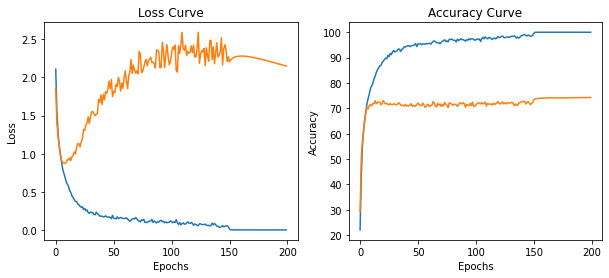

Final Training Accuracy: 100.0
Final Validation Accuracy: 74.29000006103516


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_ColorJitter)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_ColorJitter)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/WRN/WRNModel_Color_Jitter"

for i, (input, target) in enumerate(trainloader):
  print(input.size())
  break

main("Alexnet",'alexnet','train', directory, 200)

##Random Horizontal Flip

In [ ]:
transform_RandomHorizontalFlip = transforms.Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    myNormalize()
    ])

Files already downloaded and verified
Files already downloaded and verified
torch.Size([512, 3, 28, 28])
Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Alexnet...


Number of parameters: 4230654
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  24.61, Acc-val:  36.67, L-tr: 2.0190, L-val: 1.6832


Epoch 0 Finished.  Time per Epoch:  15.36 s 


001: Acc-tr:  46.29, Acc-val:  54.01, L-tr: 1.4751, L-val: 1.3122


Epoch 1 Finished.  Time per Epoch:  14.70 s 


002: Acc-tr:  59.15, Acc-val:  61.19, L-tr: 1.1642, L-val: 1.0990


Epoch 2 Finished.  Time per Epoch:  14.47 s 


003: Acc-tr:  65.52, Acc-val:  65.28, L-tr: 0.9811, L-val: 0.9959


Epoch 3 Finished.  Time per Epoch:  14.37 s 


004: Acc-tr:  69.13, Acc-val:  69.95, L-tr: 0.8865, L-val: 0.8901


Epoch 4 Finished.  Time per Epoch:  14.32 s 


005: Acc-tr:  72.72, Acc-val:  71.01, L-tr: 0.7879, L-val: 0.8629


Epoch 5 Finished.  Time per Epoch:  14.29 s 


006: Acc-tr:  74.49, Acc-val:  72.55, L-tr: 0.7381, L-val: 0.8138


Epoch 6 Finished.  Time per Epoch:  14.27 s 


007: Acc-tr:  76.36, Acc-val:  74.40, L-tr: 0.6869, L-val: 0.7534


Epoch 7 Finished.  Time per Epoch:  14.24 s 


008: Acc-tr:  77.37, Acc-val:  73.34, L-tr: 0.6568, L-val: 0.8033


Epoch 8 Finished.  Time per Epoch:  14.23 s 


009: Acc-tr:  78.76, Acc-val:  74.97, L-tr: 0.6134, L-val: 0.7362


Epoch 9 Finished.  Time per Epoch:  14.25 s 


010: Acc-tr:  80.14, Acc-val:  75.52, L-tr: 0.5765, L-val: 0.7516


Epoch 10 Finished.  Time per Epoch:  14.27 s 


011: Acc-tr:  80.94, Acc-val:  75.50, L-tr: 0.5476, L-val: 0.7338


Epoch 11 Finished.  Time per Epoch:  14.27 s 


012: Acc-tr:  82.57, Acc-val:  77.32, L-tr: 0.4988, L-val: 0.7126


Epoch 12 Finished.  Time per Epoch:  14.26 s 


013: Acc-tr:  82.09, Acc-val:  77.12, L-tr: 0.5149, L-val: 0.7328


Epoch 13 Finished.  Time per Epoch:  14.24 s 


014: Acc-tr:  83.29, Acc-val:  75.53, L-tr: 0.4789, L-val: 0.7712


Epoch 14 Finished.  Time per Epoch:  14.24 s 


015: Acc-tr:  83.95, Acc-val:  76.56, L-tr: 0.4612, L-val: 0.7704


Epoch 15 Finished.  Time per Epoch:  14.25 s 


016: Acc-tr:  84.48, Acc-val:  75.73, L-tr: 0.4482, L-val: 0.7799


Epoch 16 Finished.  Time per Epoch:  14.25 s 


017: Acc-tr:  85.53, Acc-val:  76.50, L-tr: 0.4186, L-val: 0.7966


Epoch 17 Finished.  Time per Epoch:  14.25 s 


018: Acc-tr:  86.37, Acc-val:  76.46, L-tr: 0.3937, L-val: 0.8015


Epoch 18 Finished.  Time per Epoch:  14.24 s 


019: Acc-tr:  86.50, Acc-val:  77.01, L-tr: 0.3914, L-val: 0.7798


Epoch 19 Finished.  Time per Epoch:  14.24 s 


020: Acc-tr:  87.39, Acc-val:  75.77, L-tr: 0.3658, L-val: 0.8316


Epoch 20 Finished.  Time per Epoch:  14.23 s 


021: Acc-tr:  87.78, Acc-val:  75.77, L-tr: 0.3527, L-val: 0.8332


Epoch 21 Finished.  Time per Epoch:  14.22 s 


022: Acc-tr:  87.44, Acc-val:  76.90, L-tr: 0.3586, L-val: 0.8492


Epoch 22 Finished.  Time per Epoch:  14.21 s 


023: Acc-tr:  88.25, Acc-val:  76.76, L-tr: 0.3395, L-val: 0.8222


Epoch 23 Finished.  Time per Epoch:  14.21 s 


024: Acc-tr:  89.07, Acc-val:  76.59, L-tr: 0.3155, L-val: 0.9077


Epoch 24 Finished.  Time per Epoch:  14.20 s 


025: Acc-tr:  89.33, Acc-val:  77.32, L-tr: 0.3094, L-val: 0.8854


Epoch 25 Finished.  Time per Epoch:  14.20 s 


026: Acc-tr:  90.25, Acc-val:  77.17, L-tr: 0.2872, L-val: 0.9148


Epoch 26 Finished.  Time per Epoch:  14.20 s 


027: Acc-tr:  89.81, Acc-val:  76.37, L-tr: 0.2929, L-val: 0.9484


Epoch 27 Finished.  Time per Epoch:  14.19 s 


028: Acc-tr:  89.87, Acc-val:  75.97, L-tr: 0.2907, L-val: 0.9458


Epoch 28 Finished.  Time per Epoch:  14.19 s 


029: Acc-tr:  90.47, Acc-val:  76.20, L-tr: 0.2801, L-val: 0.9713


Epoch 29 Finished.  Time per Epoch:  14.19 s 


030: Acc-tr:  90.83, Acc-val:  77.14, L-tr: 0.2689, L-val: 0.9094


Epoch 30 Finished.  Time per Epoch:  14.19 s 


031: Acc-tr:  91.21, Acc-val:  77.46, L-tr: 0.2578, L-val: 0.9260


Epoch 31 Finished.  Time per Epoch:  14.20 s 


032: Acc-tr:  90.84, Acc-val:  76.70, L-tr: 0.2699, L-val: 0.9570


Epoch 32 Finished.  Time per Epoch:  14.20 s 


033: Acc-tr:  92.23, Acc-val:  76.55, L-tr: 0.2263, L-val: 1.0115


Epoch 33 Finished.  Time per Epoch:  14.19 s 


034: Acc-tr:  92.28, Acc-val:  76.83, L-tr: 0.2263, L-val: 0.9789


Epoch 34 Finished.  Time per Epoch:  14.18 s 


035: Acc-tr:  91.35, Acc-val:  76.68, L-tr: 0.2569, L-val: 0.9644


Epoch 35 Finished.  Time per Epoch:  14.19 s 


036: Acc-tr:  92.05, Acc-val:  76.64, L-tr: 0.2343, L-val: 0.9709


Epoch 36 Finished.  Time per Epoch:  14.19 s 


037: Acc-tr:  92.69, Acc-val:  76.79, L-tr: 0.2154, L-val: 1.0994


Epoch 37 Finished.  Time per Epoch:  14.19 s 


038: Acc-tr:  92.50, Acc-val:  76.59, L-tr: 0.2258, L-val: 1.0878


Epoch 38 Finished.  Time per Epoch:  14.19 s 


039: Acc-tr:  92.47, Acc-val:  77.28, L-tr: 0.2257, L-val: 1.1157


Epoch 39 Finished.  Time per Epoch:  14.19 s 


040: Acc-tr:  92.69, Acc-val:  76.38, L-tr: 0.2200, L-val: 1.1747


Epoch 40 Finished.  Time per Epoch:  14.20 s 


041: Acc-tr:  93.06, Acc-val:  76.91, L-tr: 0.2082, L-val: 1.1073


Epoch 41 Finished.  Time per Epoch:  14.20 s 


042: Acc-tr:  93.58, Acc-val:  77.03, L-tr: 0.1945, L-val: 1.1288


Epoch 42 Finished.  Time per Epoch:  14.20 s 


043: Acc-tr:  93.93, Acc-val:  77.19, L-tr: 0.1833, L-val: 1.1826


Epoch 43 Finished.  Time per Epoch:  14.20 s 


044: Acc-tr:  92.79, Acc-val:  77.60, L-tr: 0.2146, L-val: 1.0880


Epoch 44 Finished.  Time per Epoch:  14.20 s 


045: Acc-tr:  93.80, Acc-val:  77.41, L-tr: 0.1868, L-val: 1.1180


Epoch 45 Finished.  Time per Epoch:  14.20 s 


046: Acc-tr:  94.16, Acc-val:  76.83, L-tr: 0.1804, L-val: 1.1515


Epoch 46 Finished.  Time per Epoch:  14.20 s 


047: Acc-tr:  93.61, Acc-val:  76.34, L-tr: 0.1950, L-val: 1.1662


Epoch 47 Finished.  Time per Epoch:  14.20 s 


048: Acc-tr:  93.54, Acc-val:  75.30, L-tr: 0.1946, L-val: 1.3078


Epoch 48 Finished.  Time per Epoch:  14.20 s 


049: Acc-tr:  93.71, Acc-val:  75.69, L-tr: 0.1921, L-val: 1.2470


Epoch 49 Finished.  Time per Epoch:  14.20 s 


050: Acc-tr:  93.79, Acc-val:  76.66, L-tr: 0.1901, L-val: 1.2105


Epoch 50 Finished.  Time per Epoch:  14.19 s 


051: Acc-tr:  94.07, Acc-val:  76.24, L-tr: 0.1800, L-val: 1.2307


Epoch 51 Finished.  Time per Epoch:  14.19 s 


052: Acc-tr:  94.18, Acc-val:  76.45, L-tr: 0.1803, L-val: 1.1854


Epoch 52 Finished.  Time per Epoch:  14.19 s 


053: Acc-tr:  93.94, Acc-val:  75.31, L-tr: 0.1866, L-val: 1.2648


Epoch 53 Finished.  Time per Epoch:  14.20 s 


054: Acc-tr:  94.21, Acc-val:  76.29, L-tr: 0.1809, L-val: 1.1670


Epoch 54 Finished.  Time per Epoch:  14.20 s 


055: Acc-tr:  94.74, Acc-val:  76.16, L-tr: 0.1651, L-val: 1.2136


Epoch 55 Finished.  Time per Epoch:  14.19 s 


056: Acc-tr:  94.34, Acc-val:  76.87, L-tr: 0.1743, L-val: 1.2487


Epoch 56 Finished.  Time per Epoch:  14.19 s 


057: Acc-tr:  94.88, Acc-val:  76.37, L-tr: 0.1602, L-val: 1.2168


Epoch 57 Finished.  Time per Epoch:  14.19 s 


058: Acc-tr:  94.69, Acc-val:  76.90, L-tr: 0.1638, L-val: 1.2136


Epoch 58 Finished.  Time per Epoch:  14.20 s 


059: Acc-tr:  94.70, Acc-val:  76.38, L-tr: 0.1640, L-val: 1.2914


Epoch 59 Finished.  Time per Epoch:  14.20 s 


060: Acc-tr:  95.34, Acc-val:  76.91, L-tr: 0.1418, L-val: 1.2950


Epoch 60 Finished.  Time per Epoch:  14.20 s 


061: Acc-tr:  95.03, Acc-val:  76.95, L-tr: 0.1595, L-val: 1.2333


Epoch 61 Finished.  Time per Epoch:  14.20 s 


062: Acc-tr:  95.06, Acc-val:  77.15, L-tr: 0.1554, L-val: 1.2526


Epoch 62 Finished.  Time per Epoch:  14.19 s 


063: Acc-tr:  95.19, Acc-val:  76.43, L-tr: 0.1478, L-val: 1.3178


Epoch 63 Finished.  Time per Epoch:  14.20 s 


064: Acc-tr:  94.86, Acc-val:  77.42, L-tr: 0.1615, L-val: 1.3196


Epoch 64 Finished.  Time per Epoch:  14.20 s 


065: Acc-tr:  95.19, Acc-val:  76.88, L-tr: 0.1506, L-val: 1.2316


Epoch 65 Finished.  Time per Epoch:  14.20 s 


066: Acc-tr:  95.42, Acc-val:  76.40, L-tr: 0.1434, L-val: 1.3984


Epoch 66 Finished.  Time per Epoch:  14.20 s 


067: Acc-tr:  95.09, Acc-val:  76.39, L-tr: 0.1554, L-val: 1.3374


Epoch 67 Finished.  Time per Epoch:  14.20 s 


068: Acc-tr:  95.20, Acc-val:  77.18, L-tr: 0.1527, L-val: 1.2789


Epoch 68 Finished.  Time per Epoch:  14.20 s 


069: Acc-tr:  95.58, Acc-val:  76.90, L-tr: 0.1416, L-val: 1.2980


Epoch 69 Finished.  Time per Epoch:  14.20 s 


070: Acc-tr:  95.50, Acc-val:  77.29, L-tr: 0.1459, L-val: 1.2483


Epoch 70 Finished.  Time per Epoch:  14.20 s 


071: Acc-tr:  95.79, Acc-val:  76.64, L-tr: 0.1347, L-val: 1.3643


Epoch 71 Finished.  Time per Epoch:  14.20 s 


072: Acc-tr:  95.32, Acc-val:  76.11, L-tr: 0.1476, L-val: 1.3582


Epoch 72 Finished.  Time per Epoch:  14.20 s 


073: Acc-tr:  96.04, Acc-val:  76.23, L-tr: 0.1256, L-val: 1.4532


Epoch 73 Finished.  Time per Epoch:  14.21 s 


074: Acc-tr:  95.56, Acc-val:  77.77, L-tr: 0.1440, L-val: 1.2422


Epoch 74 Finished.  Time per Epoch:  14.21 s 


075: Acc-tr:  96.17, Acc-val:  76.88, L-tr: 0.1217, L-val: 1.3798


Epoch 75 Finished.  Time per Epoch:  14.22 s 


076: Acc-tr:  96.35, Acc-val:  77.38, L-tr: 0.1122, L-val: 1.3891


Epoch 76 Finished.  Time per Epoch:  14.21 s 


077: Acc-tr:  95.38, Acc-val:  77.51, L-tr: 0.1490, L-val: 1.3252


Epoch 77 Finished.  Time per Epoch:  14.22 s 


078: Acc-tr:  95.80, Acc-val:  76.94, L-tr: 0.1344, L-val: 1.3477


Epoch 78 Finished.  Time per Epoch:  14.22 s 


079: Acc-tr:  96.02, Acc-val:  76.86, L-tr: 0.1265, L-val: 1.4173


Epoch 79 Finished.  Time per Epoch:  14.22 s 


080: Acc-tr:  96.02, Acc-val:  77.17, L-tr: 0.1253, L-val: 1.3533


Epoch 80 Finished.  Time per Epoch:  14.22 s 


081: Acc-tr:  96.39, Acc-val:  76.74, L-tr: 0.1144, L-val: 1.3896


Epoch 81 Finished.  Time per Epoch:  14.22 s 


082: Acc-tr:  96.23, Acc-val:  76.58, L-tr: 0.1202, L-val: 1.4734


Epoch 82 Finished.  Time per Epoch:  14.23 s 


083: Acc-tr:  96.09, Acc-val:  77.10, L-tr: 0.1257, L-val: 1.4588


Epoch 83 Finished.  Time per Epoch:  14.23 s 


084: Acc-tr:  96.19, Acc-val:  77.44, L-tr: 0.1258, L-val: 1.3495


Epoch 84 Finished.  Time per Epoch:  14.23 s 


085: Acc-tr:  96.36, Acc-val:  76.77, L-tr: 0.1164, L-val: 1.4289


Epoch 85 Finished.  Time per Epoch:  14.24 s 


086: Acc-tr:  96.72, Acc-val:  76.70, L-tr: 0.1050, L-val: 1.4050


Epoch 86 Finished.  Time per Epoch:  14.24 s 


087: Acc-tr:  96.56, Acc-val:  77.44, L-tr: 0.1116, L-val: 1.3982


Epoch 87 Finished.  Time per Epoch:  14.24 s 


088: Acc-tr:  96.54, Acc-val:  76.80, L-tr: 0.1096, L-val: 1.4644


Epoch 88 Finished.  Time per Epoch:  14.25 s 


089: Acc-tr:  96.61, Acc-val:  77.87, L-tr: 0.1107, L-val: 1.3640


Epoch 89 Finished.  Time per Epoch:  14.25 s 


090: Acc-tr:  96.56, Acc-val:  77.02, L-tr: 0.1115, L-val: 1.3716


Epoch 90 Finished.  Time per Epoch:  14.25 s 


091: Acc-tr:  96.68, Acc-val:  77.12, L-tr: 0.1057, L-val: 1.4539


Epoch 91 Finished.  Time per Epoch:  14.26 s 


092: Acc-tr:  96.56, Acc-val:  77.41, L-tr: 0.1112, L-val: 1.3907


Epoch 92 Finished.  Time per Epoch:  14.26 s 


093: Acc-tr:  96.75, Acc-val:  77.03, L-tr: 0.1047, L-val: 1.3744


Epoch 93 Finished.  Time per Epoch:  14.26 s 


094: Acc-tr:  96.71, Acc-val:  77.01, L-tr: 0.1075, L-val: 1.5007


Epoch 94 Finished.  Time per Epoch:  14.26 s 


095: Acc-tr:  96.59, Acc-val:  77.01, L-tr: 0.1089, L-val: 1.4096


Epoch 95 Finished.  Time per Epoch:  14.26 s 


096: Acc-tr:  96.41, Acc-val:  77.54, L-tr: 0.1211, L-val: 1.3870


Epoch 96 Finished.  Time per Epoch:  14.27 s 


097: Acc-tr:  96.51, Acc-val:  77.32, L-tr: 0.1180, L-val: 1.3727


Epoch 97 Finished.  Time per Epoch:  14.27 s 


098: Acc-tr:  96.87, Acc-val:  77.00, L-tr: 0.1031, L-val: 1.3585


Epoch 98 Finished.  Time per Epoch:  14.27 s 


099: Acc-tr:  96.99, Acc-val:  77.18, L-tr: 0.0986, L-val: 1.5063


Epoch 99 Finished.  Time per Epoch:  14.27 s 


100: Acc-tr:  97.27, Acc-val:  77.44, L-tr: 0.0899, L-val: 1.5488


Epoch 100 Finished.  Time per Epoch:  14.28 s 


101: Acc-tr:  96.64, Acc-val:  76.87, L-tr: 0.1096, L-val: 1.4452


Epoch 101 Finished.  Time per Epoch:  14.28 s 


102: Acc-tr:  96.75, Acc-val:  76.30, L-tr: 0.1053, L-val: 1.4788


Epoch 102 Finished.  Time per Epoch:  14.28 s 


103: Acc-tr:  96.34, Acc-val:  76.27, L-tr: 0.1199, L-val: 1.4310


Epoch 103 Finished.  Time per Epoch:  14.28 s 


104: Acc-tr:  96.87, Acc-val:  77.01, L-tr: 0.1036, L-val: 1.4842


Epoch 104 Finished.  Time per Epoch:  14.28 s 


105: Acc-tr:  97.08, Acc-val:  76.80, L-tr: 0.0938, L-val: 1.3373


Epoch 105 Finished.  Time per Epoch:  14.28 s 


106: Acc-tr:  97.02, Acc-val:  77.61, L-tr: 0.0954, L-val: 1.4779


Epoch 106 Finished.  Time per Epoch:  14.28 s 


107: Acc-tr:  97.11, Acc-val:  76.42, L-tr: 0.0936, L-val: 1.5921


Epoch 107 Finished.  Time per Epoch:  14.28 s 


108: Acc-tr:  96.93, Acc-val:  76.89, L-tr: 0.1010, L-val: 1.4190


Epoch 108 Finished.  Time per Epoch:  14.28 s 


109: Acc-tr:  96.87, Acc-val:  77.37, L-tr: 0.1001, L-val: 1.4798


Epoch 109 Finished.  Time per Epoch:  14.29 s 


110: Acc-tr:  96.94, Acc-val:  77.71, L-tr: 0.0992, L-val: 1.4366


Epoch 110 Finished.  Time per Epoch:  14.29 s 


111: Acc-tr:  96.90, Acc-val:  77.00, L-tr: 0.1053, L-val: 1.4655


Epoch 111 Finished.  Time per Epoch:  14.29 s 


112: Acc-tr:  97.13, Acc-val:  77.45, L-tr: 0.0933, L-val: 1.4498


Epoch 112 Finished.  Time per Epoch:  14.29 s 


113: Acc-tr:  97.16, Acc-val:  77.85, L-tr: 0.0922, L-val: 1.3833


Epoch 113 Finished.  Time per Epoch:  14.29 s 


114: Acc-tr:  97.51, Acc-val:  77.13, L-tr: 0.0806, L-val: 1.5668


Epoch 114 Finished.  Time per Epoch:  14.29 s 


115: Acc-tr:  96.94, Acc-val:  77.72, L-tr: 0.1016, L-val: 1.5100


Epoch 115 Finished.  Time per Epoch:  14.29 s 


116: Acc-tr:  97.11, Acc-val:  76.77, L-tr: 0.0938, L-val: 1.4611


Epoch 116 Finished.  Time per Epoch:  14.29 s 


117: Acc-tr:  97.27, Acc-val:  77.13, L-tr: 0.0880, L-val: 1.4821


Epoch 117 Finished.  Time per Epoch:  14.29 s 


118: Acc-tr:  97.21, Acc-val:  77.71, L-tr: 0.0910, L-val: 1.5510


Epoch 118 Finished.  Time per Epoch:  14.29 s 


119: Acc-tr:  97.45, Acc-val:  77.46, L-tr: 0.0860, L-val: 1.4986


Epoch 119 Finished.  Time per Epoch:  14.29 s 


120: Acc-tr:  97.56, Acc-val:  77.79, L-tr: 0.0816, L-val: 1.4526


Epoch 120 Finished.  Time per Epoch:  14.29 s 


121: Acc-tr:  97.82, Acc-val:  77.47, L-tr: 0.0704, L-val: 1.4828


Epoch 121 Finished.  Time per Epoch:  14.29 s 


122: Acc-tr:  97.86, Acc-val:  77.69, L-tr: 0.0708, L-val: 1.4719


Epoch 122 Finished.  Time per Epoch:  14.29 s 


123: Acc-tr:  97.70, Acc-val:  77.61, L-tr: 0.0742, L-val: 1.5177


Epoch 123 Finished.  Time per Epoch:  14.28 s 


124: Acc-tr:  97.31, Acc-val:  76.01, L-tr: 0.0894, L-val: 1.4961


Epoch 124 Finished.  Time per Epoch:  14.28 s 


125: Acc-tr:  97.29, Acc-val:  77.30, L-tr: 0.0891, L-val: 1.4630


Epoch 125 Finished.  Time per Epoch:  14.28 s 


126: Acc-tr:  97.58, Acc-val:  76.96, L-tr: 0.0808, L-val: 1.4259


Epoch 126 Finished.  Time per Epoch:  14.28 s 


127: Acc-tr:  97.82, Acc-val:  77.51, L-tr: 0.0700, L-val: 1.5623


Epoch 127 Finished.  Time per Epoch:  14.27 s 


128: Acc-tr:  97.59, Acc-val:  78.07, L-tr: 0.0801, L-val: 1.5161


Epoch 128 Finished.  Time per Epoch:  14.27 s 


129: Acc-tr:  97.04, Acc-val:  77.37, L-tr: 0.1005, L-val: 1.5058


Epoch 129 Finished.  Time per Epoch:  14.27 s 


130: Acc-tr:  97.39, Acc-val:  77.37, L-tr: 0.0862, L-val: 1.5239


Epoch 130 Finished.  Time per Epoch:  14.27 s 


131: Acc-tr:  97.28, Acc-val:  76.70, L-tr: 0.0885, L-val: 1.5277


Epoch 131 Finished.  Time per Epoch:  14.27 s 


132: Acc-tr:  97.67, Acc-val:  75.77, L-tr: 0.0789, L-val: 1.6320


Epoch 132 Finished.  Time per Epoch:  14.27 s 


133: Acc-tr:  97.34, Acc-val:  77.61, L-tr: 0.0866, L-val: 1.4536


Epoch 133 Finished.  Time per Epoch:  14.27 s 


134: Acc-tr:  97.87, Acc-val:  76.96, L-tr: 0.0707, L-val: 1.5683


Epoch 134 Finished.  Time per Epoch:  14.26 s 


135: Acc-tr:  97.24, Acc-val:  77.81, L-tr: 0.0920, L-val: 1.4406


Epoch 135 Finished.  Time per Epoch:  14.26 s 


136: Acc-tr:  97.86, Acc-val:  77.00, L-tr: 0.0722, L-val: 1.6012


Epoch 136 Finished.  Time per Epoch:  14.26 s 


137: Acc-tr:  97.50, Acc-val:  77.24, L-tr: 0.0830, L-val: 1.6108


Epoch 137 Finished.  Time per Epoch:  14.26 s 


138: Acc-tr:  97.69, Acc-val:  77.58, L-tr: 0.0776, L-val: 1.4545


Epoch 138 Finished.  Time per Epoch:  14.26 s 


139: Acc-tr:  97.64, Acc-val:  77.38, L-tr: 0.0766, L-val: 1.5478


Epoch 139 Finished.  Time per Epoch:  14.25 s 


140: Acc-tr:  97.62, Acc-val:  78.36, L-tr: 0.0780, L-val: 1.4043


Epoch 140 Finished.  Time per Epoch:  14.25 s 


141: Acc-tr:  97.69, Acc-val:  77.05, L-tr: 0.0789, L-val: 1.5201


Epoch 141 Finished.  Time per Epoch:  14.25 s 


142: Acc-tr:  97.66, Acc-val:  77.01, L-tr: 0.0784, L-val: 1.4724


Epoch 142 Finished.  Time per Epoch:  14.25 s 


143: Acc-tr:  97.75, Acc-val:  77.44, L-tr: 0.0741, L-val: 1.4499


Epoch 143 Finished.  Time per Epoch:  14.25 s 


144: Acc-tr:  97.64, Acc-val:  76.69, L-tr: 0.0759, L-val: 1.5748


Epoch 144 Finished.  Time per Epoch:  14.25 s 


145: Acc-tr:  97.41, Acc-val:  77.54, L-tr: 0.0838, L-val: 1.5672


Epoch 145 Finished.  Time per Epoch:  14.25 s 


146: Acc-tr:  97.68, Acc-val:  76.50, L-tr: 0.0799, L-val: 1.5172


Epoch 146 Finished.  Time per Epoch:  14.24 s 


147: Acc-tr:  97.68, Acc-val:  78.24, L-tr: 0.0771, L-val: 1.3772


Epoch 147 Finished.  Time per Epoch:  14.24 s 


148: Acc-tr:  98.13, Acc-val:  77.32, L-tr: 0.0617, L-val: 1.5472


Epoch 148 Finished.  Time per Epoch:  14.24 s 


149: Acc-tr:  97.97, Acc-val:  77.63, L-tr: 0.0681, L-val: 1.5477


Epoch 149 Finished.  Time per Epoch:  14.24 s 


150: Acc-tr:  99.22, Acc-val:  79.05, L-tr: 0.0253, L-val: 1.4247


Epoch 150 Finished.  Time per Epoch:  14.24 s 


151: Acc-tr:  99.76, Acc-val:  79.20, L-tr: 0.0092, L-val: 1.4479


Epoch 151 Finished.  Time per Epoch:  14.23 s 


152: Acc-tr:  99.90, Acc-val:  79.37, L-tr: 0.0047, L-val: 1.4560


Epoch 152 Finished.  Time per Epoch:  14.23 s 


153: Acc-tr:  99.94, Acc-val:  78.92, L-tr: 0.0033, L-val: 1.5003


Epoch 153 Finished.  Time per Epoch:  14.23 s 


154: Acc-tr:  99.97, Acc-val:  79.29, L-tr: 0.0028, L-val: 1.4948


Epoch 154 Finished.  Time per Epoch:  14.23 s 


155: Acc-tr:  99.98, Acc-val:  79.60, L-tr: 0.0020, L-val: 1.5066


Epoch 155 Finished.  Time per Epoch:  14.22 s 


156: Acc-tr:  99.99, Acc-val:  79.57, L-tr: 0.0016, L-val: 1.4630


Epoch 156 Finished.  Time per Epoch:  14.22 s 


157: Acc-tr:  99.99, Acc-val:  78.88, L-tr: 0.0015, L-val: 1.5334


Epoch 157 Finished.  Time per Epoch:  14.22 s 


158: Acc-tr: 100.00, Acc-val:  79.35, L-tr: 0.0012, L-val: 1.5238


Epoch 158 Finished.  Time per Epoch:  14.22 s 


159: Acc-tr: 100.00, Acc-val:  79.31, L-tr: 0.0011, L-val: 1.5319


Epoch 159 Finished.  Time per Epoch:  14.22 s 


160: Acc-tr: 100.00, Acc-val:  79.38, L-tr: 0.0010, L-val: 1.5322


Epoch 160 Finished.  Time per Epoch:  14.21 s 


161: Acc-tr: 100.00, Acc-val:  79.37, L-tr: 0.0009, L-val: 1.5347


Epoch 161 Finished.  Time per Epoch:  14.21 s 


162: Acc-tr: 100.00, Acc-val:  79.44, L-tr: 0.0009, L-val: 1.5619


Epoch 162 Finished.  Time per Epoch:  14.21 s 


163: Acc-tr: 100.00, Acc-val:  79.59, L-tr: 0.0008, L-val: 1.5624


Epoch 163 Finished.  Time per Epoch:  14.21 s 


164: Acc-tr: 100.00, Acc-val:  79.68, L-tr: 0.0008, L-val: 1.5503


Epoch 164 Finished.  Time per Epoch:  14.21 s 


165: Acc-tr: 100.00, Acc-val:  79.68, L-tr: 0.0007, L-val: 1.5835


Epoch 165 Finished.  Time per Epoch:  14.21 s 


166: Acc-tr: 100.00, Acc-val:  79.62, L-tr: 0.0007, L-val: 1.5408


Epoch 166 Finished.  Time per Epoch:  14.21 s 


167: Acc-tr: 100.00, Acc-val:  79.33, L-tr: 0.0007, L-val: 1.6113


Epoch 167 Finished.  Time per Epoch:  14.20 s 


168: Acc-tr: 100.00, Acc-val:  79.55, L-tr: 0.0006, L-val: 1.5661


Epoch 168 Finished.  Time per Epoch:  14.20 s 


169: Acc-tr: 100.00, Acc-val:  79.64, L-tr: 0.0006, L-val: 1.5713


Epoch 169 Finished.  Time per Epoch:  14.20 s 


170: Acc-tr: 100.00, Acc-val:  79.56, L-tr: 0.0006, L-val: 1.5687


Epoch 170 Finished.  Time per Epoch:  14.20 s 


171: Acc-tr: 100.00, Acc-val:  79.88, L-tr: 0.0006, L-val: 1.5344


Epoch 171 Finished.  Time per Epoch:  14.20 s 


172: Acc-tr: 100.00, Acc-val:  79.53, L-tr: 0.0005, L-val: 1.5599


Epoch 172 Finished.  Time per Epoch:  14.20 s 


173: Acc-tr: 100.00, Acc-val:  79.59, L-tr: 0.0005, L-val: 1.5773


Epoch 173 Finished.  Time per Epoch:  14.20 s 


174: Acc-tr: 100.00, Acc-val:  79.81, L-tr: 0.0005, L-val: 1.5646


Epoch 174 Finished.  Time per Epoch:  14.19 s 


175: Acc-tr: 100.00, Acc-val:  79.69, L-tr: 0.0005, L-val: 1.5501


Epoch 175 Finished.  Time per Epoch:  14.19 s 


176: Acc-tr: 100.00, Acc-val:  79.67, L-tr: 0.0005, L-val: 1.5805


Epoch 176 Finished.  Time per Epoch:  14.19 s 


177: Acc-tr: 100.00, Acc-val:  79.61, L-tr: 0.0005, L-val: 1.5841


Epoch 177 Finished.  Time per Epoch:  14.19 s 


178: Acc-tr: 100.00, Acc-val:  79.54, L-tr: 0.0005, L-val: 1.5962


Epoch 178 Finished.  Time per Epoch:  14.19 s 


179: Acc-tr: 100.00, Acc-val:  79.73, L-tr: 0.0005, L-val: 1.5631


Epoch 179 Finished.  Time per Epoch:  14.19 s 


180: Acc-tr: 100.00, Acc-val:  79.88, L-tr: 0.0005, L-val: 1.5767


Epoch 180 Finished.  Time per Epoch:  14.19 s 


181: Acc-tr: 100.00, Acc-val:  79.64, L-tr: 0.0004, L-val: 1.5763


Epoch 181 Finished.  Time per Epoch:  14.18 s 


182: Acc-tr: 100.00, Acc-val:  79.70, L-tr: 0.0005, L-val: 1.5467


Epoch 182 Finished.  Time per Epoch:  14.18 s 


183: Acc-tr: 100.00, Acc-val:  79.39, L-tr: 0.0004, L-val: 1.5699


Epoch 183 Finished.  Time per Epoch:  14.18 s 


184: Acc-tr: 100.00, Acc-val:  79.30, L-tr: 0.0004, L-val: 1.6085


Epoch 184 Finished.  Time per Epoch:  14.18 s 


185: Acc-tr: 100.00, Acc-val:  79.56, L-tr: 0.0004, L-val: 1.5672


Epoch 185 Finished.  Time per Epoch:  14.18 s 


186: Acc-tr: 100.00, Acc-val:  79.53, L-tr: 0.0004, L-val: 1.5958


Epoch 186 Finished.  Time per Epoch:  14.18 s 


187: Acc-tr: 100.00, Acc-val:  79.57, L-tr: 0.0004, L-val: 1.5969


Epoch 187 Finished.  Time per Epoch:  14.18 s 


188: Acc-tr: 100.00, Acc-val:  79.80, L-tr: 0.0004, L-val: 1.5654


Epoch 188 Finished.  Time per Epoch:  14.18 s 


189: Acc-tr: 100.00, Acc-val:  80.14, L-tr: 0.0004, L-val: 1.5494


Epoch 189 Finished.  Time per Epoch:  14.17 s 


190: Acc-tr: 100.00, Acc-val:  79.82, L-tr: 0.0004, L-val: 1.5419


Epoch 190 Finished.  Time per Epoch:  14.17 s 


191: Acc-tr: 100.00, Acc-val:  79.69, L-tr: 0.0004, L-val: 1.5595


Epoch 191 Finished.  Time per Epoch:  14.17 s 


192: Acc-tr: 100.00, Acc-val:  80.08, L-tr: 0.0004, L-val: 1.5356


Epoch 192 Finished.  Time per Epoch:  14.17 s 


193: Acc-tr: 100.00, Acc-val:  79.90, L-tr: 0.0004, L-val: 1.5677


Epoch 193 Finished.  Time per Epoch:  14.17 s 


194: Acc-tr: 100.00, Acc-val:  79.88, L-tr: 0.0004, L-val: 1.5611


Epoch 194 Finished.  Time per Epoch:  14.17 s 


195: Acc-tr: 100.00, Acc-val:  79.87, L-tr: 0.0004, L-val: 1.5508


Epoch 195 Finished.  Time per Epoch:  14.17 s 


196: Acc-tr: 100.00, Acc-val:  79.65, L-tr: 0.0004, L-val: 1.5346


Epoch 196 Finished.  Time per Epoch:  14.17 s 


197: Acc-tr: 100.00, Acc-val:  79.68, L-tr: 0.0004, L-val: 1.5750


Epoch 197 Finished.  Time per Epoch:  14.16 s 


198: Acc-tr: 100.00, Acc-val:  79.81, L-tr: 0.0004, L-val: 1.5286


Epoch 198 Finished.  Time per Epoch:  14.16 s 


199: Acc-tr: 100.00, Acc-val:  79.92, L-tr: 0.0004, L-val: 1.5365


Epoch 199 Finished.  Time per Epoch:  14.16 s 


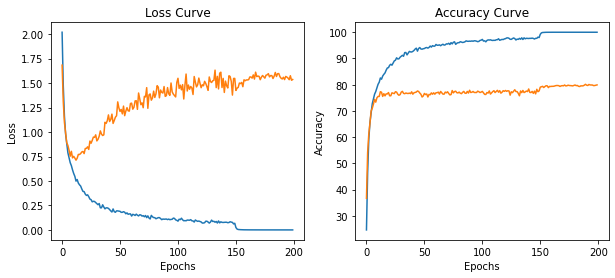

Final Training Accuracy: 100.0
Final Validation Accuracy: 79.91999985351562


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_RandomHorizontalFlip)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_RandomHorizontalFlip)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs//Alexnet/Alexnet_RandomHorizontalFlip"

for i, (input, target) in enumerate(trainloader):
  print(input.size())
  break

main("Alexnet",'alexnet','train', directory, 200)

##Random Perspective

In [ ]:
transform_RandomPerspective = transforms.Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.RandomPerspective(),
    myNormalize()
    ])

Files already downloaded and verified
Files already downloaded and verified
torch.Size([512, 3, 28, 28])


Number of parameters: 4230654
Number of parameters: 4230654


Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Alexnet...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:144: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  23.18, Acc-val:  36.78, L-tr: 2.0338, L-val: 1.7257
000: Acc-tr:  23.18, Acc-val:  36.78, L-tr: 2.0338, L-val: 1.7257


Epoch 0 Finished.  Time per Epoch:  22.76 s 


001: Acc-tr:  41.39, Acc-val:  44.98, L-tr: 1.5977, L-val: 1.4765
001: Acc-tr:  41.39, Acc-val:  44.98, L-tr: 1.5977, L-val: 1.4765


Epoch 1 Finished.  Time per Epoch:  22.80 s 


002: Acc-tr:  49.51, Acc-val:  52.23, L-tr: 1.3937, L-val: 1.3440
002: Acc-tr:  49.51, Acc-val:  52.23, L-tr: 1.3937, L-val: 1.3440


Epoch 2 Finished.  Time per Epoch:  22.74 s 


003: Acc-tr:  52.13, Acc-val:  54.96, L-tr: 1.3421, L-val: 1.2701
003: Acc-tr:  52.13, Acc-val:  54.96, L-tr: 1.3421, L-val: 1.2701


Epoch 3 Finished.  Time per Epoch:  22.67 s 


004: Acc-tr:  57.84, Acc-val:  58.23, L-tr: 1.1963, L-val: 1.1815
004: Acc-tr:  57.84, Acc-val:  58.23, L-tr: 1.1963, L-val: 1.1815


Epoch 4 Finished.  Time per Epoch:  22.71 s 


005: Acc-tr:  61.10, Acc-val:  60.09, L-tr: 1.1018, L-val: 1.1223
005: Acc-tr:  61.10, Acc-val:  60.09, L-tr: 1.1018, L-val: 1.1223


Epoch 5 Finished.  Time per Epoch:  22.68 s 


006: Acc-tr:  63.28, Acc-val:  62.42, L-tr: 1.0500, L-val: 1.0840
006: Acc-tr:  63.28, Acc-val:  62.42, L-tr: 1.0500, L-val: 1.0840


Epoch 6 Finished.  Time per Epoch:  22.63 s 


007: Acc-tr:  65.23, Acc-val:  64.59, L-tr: 0.9915, L-val: 1.0200
007: Acc-tr:  65.23, Acc-val:  64.59, L-tr: 0.9915, L-val: 1.0200


Epoch 7 Finished.  Time per Epoch:  22.61 s 


008: Acc-tr:  67.20, Acc-val:  62.63, L-tr: 0.9336, L-val: 1.0890
008: Acc-tr:  67.20, Acc-val:  62.63, L-tr: 0.9336, L-val: 1.0890


Epoch 8 Finished.  Time per Epoch:  22.60 s 


009: Acc-tr:  68.33, Acc-val:  65.66, L-tr: 0.9031, L-val: 1.0038
009: Acc-tr:  68.33, Acc-val:  65.66, L-tr: 0.9031, L-val: 1.0038


Epoch 9 Finished.  Time per Epoch:  22.57 s 


010: Acc-tr:  69.53, Acc-val:  66.67, L-tr: 0.8725, L-val: 0.9824
010: Acc-tr:  69.53, Acc-val:  66.67, L-tr: 0.8725, L-val: 0.9824


Epoch 10 Finished.  Time per Epoch:  22.58 s 


011: Acc-tr:  70.75, Acc-val:  66.56, L-tr: 0.8374, L-val: 0.9994
011: Acc-tr:  70.75, Acc-val:  66.56, L-tr: 0.8374, L-val: 0.9994


Epoch 11 Finished.  Time per Epoch:  22.54 s 


012: Acc-tr:  71.76, Acc-val:  68.16, L-tr: 0.8130, L-val: 0.9465
012: Acc-tr:  71.76, Acc-val:  68.16, L-tr: 0.8130, L-val: 0.9465


Epoch 12 Finished.  Time per Epoch:  22.50 s 


013: Acc-tr:  72.76, Acc-val:  67.25, L-tr: 0.7794, L-val: 0.9616
013: Acc-tr:  72.76, Acc-val:  67.25, L-tr: 0.7794, L-val: 0.9616


Epoch 13 Finished.  Time per Epoch:  22.49 s 


014: Acc-tr:  73.62, Acc-val:  68.97, L-tr: 0.7572, L-val: 0.9376
014: Acc-tr:  73.62, Acc-val:  68.97, L-tr: 0.7572, L-val: 0.9376


Epoch 14 Finished.  Time per Epoch:  22.48 s 


015: Acc-tr:  74.23, Acc-val:  69.57, L-tr: 0.7357, L-val: 0.9439
015: Acc-tr:  74.23, Acc-val:  69.57, L-tr: 0.7357, L-val: 0.9439


Epoch 15 Finished.  Time per Epoch:  22.49 s 


016: Acc-tr:  75.23, Acc-val:  69.84, L-tr: 0.7174, L-val: 0.9398
016: Acc-tr:  75.23, Acc-val:  69.84, L-tr: 0.7174, L-val: 0.9398


Epoch 16 Finished.  Time per Epoch:  22.48 s 


017: Acc-tr:  76.10, Acc-val:  69.07, L-tr: 0.6865, L-val: 0.9494
017: Acc-tr:  76.10, Acc-val:  69.07, L-tr: 0.6865, L-val: 0.9494


Epoch 17 Finished.  Time per Epoch:  22.48 s 


018: Acc-tr:  76.13, Acc-val:  69.59, L-tr: 0.6894, L-val: 0.9439
018: Acc-tr:  76.13, Acc-val:  69.59, L-tr: 0.6894, L-val: 0.9439


Epoch 18 Finished.  Time per Epoch:  22.49 s 


019: Acc-tr:  77.07, Acc-val:  70.11, L-tr: 0.6632, L-val: 0.9449
019: Acc-tr:  77.07, Acc-val:  70.11, L-tr: 0.6632, L-val: 0.9449


Epoch 19 Finished.  Time per Epoch:  22.48 s 


020: Acc-tr:  77.31, Acc-val:  69.67, L-tr: 0.6522, L-val: 0.9499
020: Acc-tr:  77.31, Acc-val:  69.67, L-tr: 0.6522, L-val: 0.9499


Epoch 20 Finished.  Time per Epoch:  22.46 s 


021: Acc-tr:  77.61, Acc-val:  69.55, L-tr: 0.6457, L-val: 0.9431
021: Acc-tr:  77.61, Acc-val:  69.55, L-tr: 0.6457, L-val: 0.9431


Epoch 21 Finished.  Time per Epoch:  22.44 s 


022: Acc-tr:  78.30, Acc-val:  70.40, L-tr: 0.6190, L-val: 0.9236
022: Acc-tr:  78.30, Acc-val:  70.40, L-tr: 0.6190, L-val: 0.9236


Epoch 22 Finished.  Time per Epoch:  22.44 s 


023: Acc-tr:  78.62, Acc-val:  70.41, L-tr: 0.6157, L-val: 0.9355
023: Acc-tr:  78.62, Acc-val:  70.41, L-tr: 0.6157, L-val: 0.9355


Epoch 23 Finished.  Time per Epoch:  22.43 s 


024: Acc-tr:  79.49, Acc-val:  69.47, L-tr: 0.5970, L-val: 0.9708
024: Acc-tr:  79.49, Acc-val:  69.47, L-tr: 0.5970, L-val: 0.9708


Epoch 24 Finished.  Time per Epoch:  22.42 s 


025: Acc-tr:  79.51, Acc-val:  69.55, L-tr: 0.5917, L-val: 1.0110
025: Acc-tr:  79.51, Acc-val:  69.55, L-tr: 0.5917, L-val: 1.0110


Epoch 25 Finished.  Time per Epoch:  22.41 s 


026: Acc-tr:  80.01, Acc-val:  70.30, L-tr: 0.5779, L-val: 1.0109
026: Acc-tr:  80.01, Acc-val:  70.30, L-tr: 0.5779, L-val: 1.0109


Epoch 26 Finished.  Time per Epoch:  22.40 s 


027: Acc-tr:  80.05, Acc-val:  71.03, L-tr: 0.5819, L-val: 0.9537
027: Acc-tr:  80.05, Acc-val:  71.03, L-tr: 0.5819, L-val: 0.9537


Epoch 27 Finished.  Time per Epoch:  22.39 s 


028: Acc-tr:  80.23, Acc-val:  71.33, L-tr: 0.5734, L-val: 0.9889
028: Acc-tr:  80.23, Acc-val:  71.33, L-tr: 0.5734, L-val: 0.9889


Epoch 28 Finished.  Time per Epoch:  22.38 s 


029: Acc-tr:  81.10, Acc-val:  71.63, L-tr: 0.5496, L-val: 0.9730
029: Acc-tr:  81.10, Acc-val:  71.63, L-tr: 0.5496, L-val: 0.9730


Epoch 29 Finished.  Time per Epoch:  22.39 s 


030: Acc-tr:  80.98, Acc-val:  70.55, L-tr: 0.5568, L-val: 1.0005
030: Acc-tr:  80.98, Acc-val:  70.55, L-tr: 0.5568, L-val: 1.0005


Epoch 30 Finished.  Time per Epoch:  22.41 s 


031: Acc-tr:  81.30, Acc-val:  71.31, L-tr: 0.5451, L-val: 0.9614
031: Acc-tr:  81.30, Acc-val:  71.31, L-tr: 0.5451, L-val: 0.9614


Epoch 31 Finished.  Time per Epoch:  22.43 s 


032: Acc-tr:  81.64, Acc-val:  71.38, L-tr: 0.5326, L-val: 0.9836
032: Acc-tr:  81.64, Acc-val:  71.38, L-tr: 0.5326, L-val: 0.9836


Epoch 32 Finished.  Time per Epoch:  22.43 s 


033: Acc-tr:  81.63, Acc-val:  70.23, L-tr: 0.5318, L-val: 1.0199
033: Acc-tr:  81.63, Acc-val:  70.23, L-tr: 0.5318, L-val: 1.0199


Epoch 33 Finished.  Time per Epoch:  22.43 s 


034: Acc-tr:  82.28, Acc-val:  70.33, L-tr: 0.5173, L-val: 1.0822
034: Acc-tr:  82.28, Acc-val:  70.33, L-tr: 0.5173, L-val: 1.0822


Epoch 34 Finished.  Time per Epoch:  22.42 s 


035: Acc-tr:  82.16, Acc-val:  70.55, L-tr: 0.5207, L-val: 1.0046
035: Acc-tr:  82.16, Acc-val:  70.55, L-tr: 0.5207, L-val: 1.0046


Epoch 35 Finished.  Time per Epoch:  22.42 s 


036: Acc-tr:  82.97, Acc-val:  71.84, L-tr: 0.4960, L-val: 0.9810
036: Acc-tr:  82.97, Acc-val:  71.84, L-tr: 0.4960, L-val: 0.9810


Epoch 36 Finished.  Time per Epoch:  22.41 s 


037: Acc-tr:  82.68, Acc-val:  70.77, L-tr: 0.5045, L-val: 1.0663
037: Acc-tr:  82.68, Acc-val:  70.77, L-tr: 0.5045, L-val: 1.0663


Epoch 37 Finished.  Time per Epoch:  22.40 s 


038: Acc-tr:  82.97, Acc-val:  71.32, L-tr: 0.4955, L-val: 1.0045
038: Acc-tr:  82.97, Acc-val:  71.32, L-tr: 0.4955, L-val: 1.0045


Epoch 38 Finished.  Time per Epoch:  22.39 s 


039: Acc-tr:  82.90, Acc-val:  71.22, L-tr: 0.4985, L-val: 1.0408
039: Acc-tr:  82.90, Acc-val:  71.22, L-tr: 0.4985, L-val: 1.0408


Epoch 39 Finished.  Time per Epoch:  22.38 s 


040: Acc-tr:  83.17, Acc-val:  71.00, L-tr: 0.4902, L-val: 1.0381
040: Acc-tr:  83.17, Acc-val:  71.00, L-tr: 0.4902, L-val: 1.0381


Epoch 40 Finished.  Time per Epoch:  22.37 s 


041: Acc-tr:  83.02, Acc-val:  72.07, L-tr: 0.4975, L-val: 1.0037
041: Acc-tr:  83.02, Acc-val:  72.07, L-tr: 0.4975, L-val: 1.0037


Epoch 41 Finished.  Time per Epoch:  22.37 s 


042: Acc-tr:  83.84, Acc-val:  71.92, L-tr: 0.4785, L-val: 1.0570
042: Acc-tr:  83.84, Acc-val:  71.92, L-tr: 0.4785, L-val: 1.0570


Epoch 42 Finished.  Time per Epoch:  22.37 s 


043: Acc-tr:  83.22, Acc-val:  70.96, L-tr: 0.4954, L-val: 1.0282
043: Acc-tr:  83.22, Acc-val:  70.96, L-tr: 0.4954, L-val: 1.0282


Epoch 43 Finished.  Time per Epoch:  22.36 s 


044: Acc-tr:  84.09, Acc-val:  72.18, L-tr: 0.4636, L-val: 0.9819
044: Acc-tr:  84.09, Acc-val:  72.18, L-tr: 0.4636, L-val: 0.9819


Epoch 44 Finished.  Time per Epoch:  22.36 s 


045: Acc-tr:  83.93, Acc-val:  72.35, L-tr: 0.4727, L-val: 1.0205
045: Acc-tr:  83.93, Acc-val:  72.35, L-tr: 0.4727, L-val: 1.0205


Epoch 45 Finished.  Time per Epoch:  22.36 s 


046: Acc-tr:  84.04, Acc-val:  71.72, L-tr: 0.4711, L-val: 1.0862
046: Acc-tr:  84.04, Acc-val:  71.72, L-tr: 0.4711, L-val: 1.0862


Epoch 46 Finished.  Time per Epoch:  22.36 s 


047: Acc-tr:  83.91, Acc-val:  71.20, L-tr: 0.4687, L-val: 1.0474
047: Acc-tr:  83.91, Acc-val:  71.20, L-tr: 0.4687, L-val: 1.0474


Epoch 47 Finished.  Time per Epoch:  22.36 s 


048: Acc-tr:  84.35, Acc-val:  72.38, L-tr: 0.4626, L-val: 1.0463
048: Acc-tr:  84.35, Acc-val:  72.38, L-tr: 0.4626, L-val: 1.0463


Epoch 48 Finished.  Time per Epoch:  22.36 s 


049: Acc-tr:  84.62, Acc-val:  72.10, L-tr: 0.4532, L-val: 1.0631
049: Acc-tr:  84.62, Acc-val:  72.10, L-tr: 0.4532, L-val: 1.0631


Epoch 49 Finished.  Time per Epoch:  22.35 s 


050: Acc-tr:  84.49, Acc-val:  71.36, L-tr: 0.4586, L-val: 1.1182
050: Acc-tr:  84.49, Acc-val:  71.36, L-tr: 0.4586, L-val: 1.1182


Epoch 50 Finished.  Time per Epoch:  22.34 s 


051: Acc-tr:  84.39, Acc-val:  72.15, L-tr: 0.4609, L-val: 1.0194
051: Acc-tr:  84.39, Acc-val:  72.15, L-tr: 0.4609, L-val: 1.0194


Epoch 51 Finished.  Time per Epoch:  22.34 s 


052: Acc-tr:  84.66, Acc-val:  71.97, L-tr: 0.4528, L-val: 1.0059
052: Acc-tr:  84.66, Acc-val:  71.97, L-tr: 0.4528, L-val: 1.0059


Epoch 52 Finished.  Time per Epoch:  22.34 s 


053: Acc-tr:  85.39, Acc-val:  72.42, L-tr: 0.4357, L-val: 1.0594
053: Acc-tr:  85.39, Acc-val:  72.42, L-tr: 0.4357, L-val: 1.0594


Epoch 53 Finished.  Time per Epoch:  22.34 s 


054: Acc-tr:  85.41, Acc-val:  72.03, L-tr: 0.4358, L-val: 1.0416
054: Acc-tr:  85.41, Acc-val:  72.03, L-tr: 0.4358, L-val: 1.0416


Epoch 54 Finished.  Time per Epoch:  22.33 s 


055: Acc-tr:  85.22, Acc-val:  71.82, L-tr: 0.4382, L-val: 1.1136
055: Acc-tr:  85.22, Acc-val:  71.82, L-tr: 0.4382, L-val: 1.1136


Epoch 55 Finished.  Time per Epoch:  22.33 s 


056: Acc-tr:  85.12, Acc-val:  72.58, L-tr: 0.4406, L-val: 1.0809
056: Acc-tr:  85.12, Acc-val:  72.58, L-tr: 0.4406, L-val: 1.0809


Epoch 56 Finished.  Time per Epoch:  22.33 s 


057: Acc-tr:  84.96, Acc-val:  71.94, L-tr: 0.4411, L-val: 1.1015
057: Acc-tr:  84.96, Acc-val:  71.94, L-tr: 0.4411, L-val: 1.1015


Epoch 57 Finished.  Time per Epoch:  22.33 s 


058: Acc-tr:  85.45, Acc-val:  71.21, L-tr: 0.4339, L-val: 1.1844
058: Acc-tr:  85.45, Acc-val:  71.21, L-tr: 0.4339, L-val: 1.1844


Epoch 58 Finished.  Time per Epoch:  22.32 s 


059: Acc-tr:  85.31, Acc-val:  71.90, L-tr: 0.4320, L-val: 1.0911
059: Acc-tr:  85.31, Acc-val:  71.90, L-tr: 0.4320, L-val: 1.0911


Epoch 59 Finished.  Time per Epoch:  22.33 s 


060: Acc-tr:  85.39, Acc-val:  72.52, L-tr: 0.4294, L-val: 1.0522
060: Acc-tr:  85.39, Acc-val:  72.52, L-tr: 0.4294, L-val: 1.0522


Epoch 60 Finished.  Time per Epoch:  22.33 s 


061: Acc-tr:  85.39, Acc-val:  71.74, L-tr: 0.4274, L-val: 1.0963
061: Acc-tr:  85.39, Acc-val:  71.74, L-tr: 0.4274, L-val: 1.0963


Epoch 61 Finished.  Time per Epoch:  22.32 s 


062: Acc-tr:  85.75, Acc-val:  72.37, L-tr: 0.4255, L-val: 1.1436
062: Acc-tr:  85.75, Acc-val:  72.37, L-tr: 0.4255, L-val: 1.1436


Epoch 62 Finished.  Time per Epoch:  22.33 s 


063: Acc-tr:  85.53, Acc-val:  72.65, L-tr: 0.4244, L-val: 1.0358
063: Acc-tr:  85.53, Acc-val:  72.65, L-tr: 0.4244, L-val: 1.0358


Epoch 63 Finished.  Time per Epoch:  22.32 s 


064: Acc-tr:  86.04, Acc-val:  71.43, L-tr: 0.4137, L-val: 1.1267
064: Acc-tr:  86.04, Acc-val:  71.43, L-tr: 0.4137, L-val: 1.1267


Epoch 64 Finished.  Time per Epoch:  22.31 s 


065: Acc-tr:  86.25, Acc-val:  72.39, L-tr: 0.4113, L-val: 1.0609
065: Acc-tr:  86.25, Acc-val:  72.39, L-tr: 0.4113, L-val: 1.0609


Epoch 65 Finished.  Time per Epoch:  22.31 s 


066: Acc-tr:  86.18, Acc-val:  73.37, L-tr: 0.4143, L-val: 1.0553
066: Acc-tr:  86.18, Acc-val:  73.37, L-tr: 0.4143, L-val: 1.0553


Epoch 66 Finished.  Time per Epoch:  22.31 s 


067: Acc-tr:  86.05, Acc-val:  71.85, L-tr: 0.4131, L-val: 1.0861
067: Acc-tr:  86.05, Acc-val:  71.85, L-tr: 0.4131, L-val: 1.0861


Epoch 67 Finished.  Time per Epoch:  22.31 s 


068: Acc-tr:  85.91, Acc-val:  73.49, L-tr: 0.4144, L-val: 1.0318
068: Acc-tr:  85.91, Acc-val:  73.49, L-tr: 0.4144, L-val: 1.0318


Epoch 68 Finished.  Time per Epoch:  22.30 s 


069: Acc-tr:  86.49, Acc-val:  72.47, L-tr: 0.4007, L-val: 1.1108
069: Acc-tr:  86.49, Acc-val:  72.47, L-tr: 0.4007, L-val: 1.1108


Epoch 69 Finished.  Time per Epoch:  22.30 s 


070: Acc-tr:  86.21, Acc-val:  72.42, L-tr: 0.4113, L-val: 1.1455
070: Acc-tr:  86.21, Acc-val:  72.42, L-tr: 0.4113, L-val: 1.1455


Epoch 70 Finished.  Time per Epoch:  22.30 s 


071: Acc-tr:  86.36, Acc-val:  72.71, L-tr: 0.4044, L-val: 1.0801
071: Acc-tr:  86.36, Acc-val:  72.71, L-tr: 0.4044, L-val: 1.0801


Epoch 71 Finished.  Time per Epoch:  22.30 s 


072: Acc-tr:  86.73, Acc-val:  73.70, L-tr: 0.3951, L-val: 1.0572
072: Acc-tr:  86.73, Acc-val:  73.70, L-tr: 0.3951, L-val: 1.0572


Epoch 72 Finished.  Time per Epoch:  22.30 s 


073: Acc-tr:  86.64, Acc-val:  72.47, L-tr: 0.3953, L-val: 1.1262
073: Acc-tr:  86.64, Acc-val:  72.47, L-tr: 0.3953, L-val: 1.1262


Epoch 73 Finished.  Time per Epoch:  22.30 s 


074: Acc-tr:  86.19, Acc-val:  72.53, L-tr: 0.4114, L-val: 1.1232
074: Acc-tr:  86.19, Acc-val:  72.53, L-tr: 0.4114, L-val: 1.1232


Epoch 74 Finished.  Time per Epoch:  22.30 s 


075: Acc-tr:  86.60, Acc-val:  72.80, L-tr: 0.3983, L-val: 1.0287
075: Acc-tr:  86.60, Acc-val:  72.80, L-tr: 0.3983, L-val: 1.0287


Epoch 75 Finished.  Time per Epoch:  22.30 s 


076: Acc-tr:  86.97, Acc-val:  72.57, L-tr: 0.3882, L-val: 1.1207
076: Acc-tr:  86.97, Acc-val:  72.57, L-tr: 0.3882, L-val: 1.1207


Epoch 76 Finished.  Time per Epoch:  22.30 s 


077: Acc-tr:  86.40, Acc-val:  72.59, L-tr: 0.4021, L-val: 1.0921
077: Acc-tr:  86.40, Acc-val:  72.59, L-tr: 0.4021, L-val: 1.0921


Epoch 77 Finished.  Time per Epoch:  22.31 s 


078: Acc-tr:  86.63, Acc-val:  72.19, L-tr: 0.3913, L-val: 1.1165
078: Acc-tr:  86.63, Acc-val:  72.19, L-tr: 0.3913, L-val: 1.1165


Epoch 78 Finished.  Time per Epoch:  22.30 s 


079: Acc-tr:  86.60, Acc-val:  72.21, L-tr: 0.3988, L-val: 1.1087
079: Acc-tr:  86.60, Acc-val:  72.21, L-tr: 0.3988, L-val: 1.1087


Epoch 79 Finished.  Time per Epoch:  22.30 s 


080: Acc-tr:  87.40, Acc-val:  72.79, L-tr: 0.3802, L-val: 1.0543
080: Acc-tr:  87.40, Acc-val:  72.79, L-tr: 0.3802, L-val: 1.0543


Epoch 80 Finished.  Time per Epoch:  22.30 s 


081: Acc-tr:  86.68, Acc-val:  73.26, L-tr: 0.3920, L-val: 1.1224
081: Acc-tr:  86.68, Acc-val:  73.26, L-tr: 0.3920, L-val: 1.1224


Epoch 81 Finished.  Time per Epoch:  22.30 s 


082: Acc-tr:  86.56, Acc-val:  73.41, L-tr: 0.3989, L-val: 1.0853
082: Acc-tr:  86.56, Acc-val:  73.41, L-tr: 0.3989, L-val: 1.0853


Epoch 82 Finished.  Time per Epoch:  22.30 s 


083: Acc-tr:  86.86, Acc-val:  73.24, L-tr: 0.3920, L-val: 1.0529
083: Acc-tr:  86.86, Acc-val:  73.24, L-tr: 0.3920, L-val: 1.0529


Epoch 83 Finished.  Time per Epoch:  22.30 s 


084: Acc-tr:  86.69, Acc-val:  73.01, L-tr: 0.3961, L-val: 1.1152
084: Acc-tr:  86.69, Acc-val:  73.01, L-tr: 0.3961, L-val: 1.1152


Epoch 84 Finished.  Time per Epoch:  22.30 s 


085: Acc-tr:  86.74, Acc-val:  71.59, L-tr: 0.3968, L-val: 1.1468
085: Acc-tr:  86.74, Acc-val:  71.59, L-tr: 0.3968, L-val: 1.1468


Epoch 85 Finished.  Time per Epoch:  22.30 s 


086: Acc-tr:  87.18, Acc-val:  72.15, L-tr: 0.3878, L-val: 1.0971
086: Acc-tr:  87.18, Acc-val:  72.15, L-tr: 0.3878, L-val: 1.0971


Epoch 86 Finished.  Time per Epoch:  22.30 s 


087: Acc-tr:  87.60, Acc-val:  73.39, L-tr: 0.3728, L-val: 1.1597
087: Acc-tr:  87.60, Acc-val:  73.39, L-tr: 0.3728, L-val: 1.1597


Epoch 87 Finished.  Time per Epoch:  22.31 s 


088: Acc-tr:  86.93, Acc-val:  71.93, L-tr: 0.3864, L-val: 1.1353
088: Acc-tr:  86.93, Acc-val:  71.93, L-tr: 0.3864, L-val: 1.1353


Epoch 88 Finished.  Time per Epoch:  22.31 s 


089: Acc-tr:  86.97, Acc-val:  73.85, L-tr: 0.3884, L-val: 1.0787
089: Acc-tr:  86.97, Acc-val:  73.85, L-tr: 0.3884, L-val: 1.0787


Epoch 89 Finished.  Time per Epoch:  22.31 s 


090: Acc-tr:  87.29, Acc-val:  72.82, L-tr: 0.3772, L-val: 1.0843
090: Acc-tr:  87.29, Acc-val:  72.82, L-tr: 0.3772, L-val: 1.0843


Epoch 90 Finished.  Time per Epoch:  22.31 s 


091: Acc-tr:  87.66, Acc-val:  73.16, L-tr: 0.3706, L-val: 1.0896
091: Acc-tr:  87.66, Acc-val:  73.16, L-tr: 0.3706, L-val: 1.0896


Epoch 91 Finished.  Time per Epoch:  22.31 s 


092: Acc-tr:  87.15, Acc-val:  72.89, L-tr: 0.3825, L-val: 1.1135
092: Acc-tr:  87.15, Acc-val:  72.89, L-tr: 0.3825, L-val: 1.1135


Epoch 92 Finished.  Time per Epoch:  22.31 s 


093: Acc-tr:  87.99, Acc-val:  73.78, L-tr: 0.3639, L-val: 1.0695
093: Acc-tr:  87.99, Acc-val:  73.78, L-tr: 0.3639, L-val: 1.0695


Epoch 93 Finished.  Time per Epoch:  22.30 s 


094: Acc-tr:  87.93, Acc-val:  72.98, L-tr: 0.3602, L-val: 1.1204
094: Acc-tr:  87.93, Acc-val:  72.98, L-tr: 0.3602, L-val: 1.1204


Epoch 94 Finished.  Time per Epoch:  22.30 s 


095: Acc-tr:  87.45, Acc-val:  72.75, L-tr: 0.3710, L-val: 1.1351
095: Acc-tr:  87.45, Acc-val:  72.75, L-tr: 0.3710, L-val: 1.1351


Epoch 95 Finished.  Time per Epoch:  22.31 s 


096: Acc-tr:  87.55, Acc-val:  73.53, L-tr: 0.3691, L-val: 1.0857
096: Acc-tr:  87.55, Acc-val:  73.53, L-tr: 0.3691, L-val: 1.0857


Epoch 96 Finished.  Time per Epoch:  22.31 s 


097: Acc-tr:  87.72, Acc-val:  74.27, L-tr: 0.3611, L-val: 1.0634
097: Acc-tr:  87.72, Acc-val:  74.27, L-tr: 0.3611, L-val: 1.0634


Epoch 97 Finished.  Time per Epoch:  22.31 s 


098: Acc-tr:  87.80, Acc-val:  73.09, L-tr: 0.3587, L-val: 1.1185
098: Acc-tr:  87.80, Acc-val:  73.09, L-tr: 0.3587, L-val: 1.1185


Epoch 98 Finished.  Time per Epoch:  22.30 s 


099: Acc-tr:  87.53, Acc-val:  73.72, L-tr: 0.3670, L-val: 1.0535
099: Acc-tr:  87.53, Acc-val:  73.72, L-tr: 0.3670, L-val: 1.0535


Epoch 99 Finished.  Time per Epoch:  22.30 s 


100: Acc-tr:  87.57, Acc-val:  73.58, L-tr: 0.3665, L-val: 1.1029
100: Acc-tr:  87.57, Acc-val:  73.58, L-tr: 0.3665, L-val: 1.1029


Epoch 100 Finished.  Time per Epoch:  22.30 s 


101: Acc-tr:  87.64, Acc-val:  74.01, L-tr: 0.3660, L-val: 1.1328
101: Acc-tr:  87.64, Acc-val:  74.01, L-tr: 0.3660, L-val: 1.1328


Epoch 101 Finished.  Time per Epoch:  22.31 s 


102: Acc-tr:  88.11, Acc-val:  74.29, L-tr: 0.3568, L-val: 1.0853
102: Acc-tr:  88.11, Acc-val:  74.29, L-tr: 0.3568, L-val: 1.0853


Epoch 102 Finished.  Time per Epoch:  22.31 s 


103: Acc-tr:  88.05, Acc-val:  73.59, L-tr: 0.3566, L-val: 1.0464
103: Acc-tr:  88.05, Acc-val:  73.59, L-tr: 0.3566, L-val: 1.0464


Epoch 103 Finished.  Time per Epoch:  22.31 s 


104: Acc-tr:  88.16, Acc-val:  73.61, L-tr: 0.3527, L-val: 1.0626
104: Acc-tr:  88.16, Acc-val:  73.61, L-tr: 0.3527, L-val: 1.0626


Epoch 104 Finished.  Time per Epoch:  22.31 s 


105: Acc-tr:  87.91, Acc-val:  72.72, L-tr: 0.3627, L-val: 1.1027
105: Acc-tr:  87.91, Acc-val:  72.72, L-tr: 0.3627, L-val: 1.1027


Epoch 105 Finished.  Time per Epoch:  22.32 s 


106: Acc-tr:  88.36, Acc-val:  72.79, L-tr: 0.3461, L-val: 1.1153
106: Acc-tr:  88.36, Acc-val:  72.79, L-tr: 0.3461, L-val: 1.1153


Epoch 106 Finished.  Time per Epoch:  22.32 s 


107: Acc-tr:  88.27, Acc-val:  73.30, L-tr: 0.3514, L-val: 1.1151
107: Acc-tr:  88.27, Acc-val:  73.30, L-tr: 0.3514, L-val: 1.1151


Epoch 107 Finished.  Time per Epoch:  22.32 s 


108: Acc-tr:  88.20, Acc-val:  74.45, L-tr: 0.3471, L-val: 1.0680
108: Acc-tr:  88.20, Acc-val:  74.45, L-tr: 0.3471, L-val: 1.0680


Epoch 108 Finished.  Time per Epoch:  22.32 s 


109: Acc-tr:  88.09, Acc-val:  73.77, L-tr: 0.3556, L-val: 1.0400
109: Acc-tr:  88.09, Acc-val:  73.77, L-tr: 0.3556, L-val: 1.0400


Epoch 109 Finished.  Time per Epoch:  22.32 s 


110: Acc-tr:  87.95, Acc-val:  73.77, L-tr: 0.3595, L-val: 1.1041
110: Acc-tr:  87.95, Acc-val:  73.77, L-tr: 0.3595, L-val: 1.1041


Epoch 110 Finished.  Time per Epoch:  22.32 s 


111: Acc-tr:  88.37, Acc-val:  73.36, L-tr: 0.3449, L-val: 1.0842
111: Acc-tr:  88.37, Acc-val:  73.36, L-tr: 0.3449, L-val: 1.0842


Epoch 111 Finished.  Time per Epoch:  22.32 s 


112: Acc-tr:  88.52, Acc-val:  73.12, L-tr: 0.3444, L-val: 1.0422
112: Acc-tr:  88.52, Acc-val:  73.12, L-tr: 0.3444, L-val: 1.0422


Epoch 112 Finished.  Time per Epoch:  22.32 s 


113: Acc-tr:  88.24, Acc-val:  73.20, L-tr: 0.3484, L-val: 1.1659
113: Acc-tr:  88.24, Acc-val:  73.20, L-tr: 0.3484, L-val: 1.1659


Epoch 113 Finished.  Time per Epoch:  22.32 s 


114: Acc-tr:  87.89, Acc-val:  73.33, L-tr: 0.3593, L-val: 1.0881
114: Acc-tr:  87.89, Acc-val:  73.33, L-tr: 0.3593, L-val: 1.0881


Epoch 114 Finished.  Time per Epoch:  22.32 s 


115: Acc-tr:  88.34, Acc-val:  73.35, L-tr: 0.3480, L-val: 1.1335
115: Acc-tr:  88.34, Acc-val:  73.35, L-tr: 0.3480, L-val: 1.1335


Epoch 115 Finished.  Time per Epoch:  22.33 s 


116: Acc-tr:  87.87, Acc-val:  73.16, L-tr: 0.3615, L-val: 1.1025
116: Acc-tr:  87.87, Acc-val:  73.16, L-tr: 0.3615, L-val: 1.1025


Epoch 116 Finished.  Time per Epoch:  22.32 s 


117: Acc-tr:  88.41, Acc-val:  74.37, L-tr: 0.3415, L-val: 1.0242
117: Acc-tr:  88.41, Acc-val:  74.37, L-tr: 0.3415, L-val: 1.0242


Epoch 117 Finished.  Time per Epoch:  22.33 s 


118: Acc-tr:  88.97, Acc-val:  74.61, L-tr: 0.3274, L-val: 1.1177
118: Acc-tr:  88.97, Acc-val:  74.61, L-tr: 0.3274, L-val: 1.1177


Epoch 118 Finished.  Time per Epoch:  22.33 s 


119: Acc-tr:  88.65, Acc-val:  73.55, L-tr: 0.3358, L-val: 1.1102
119: Acc-tr:  88.65, Acc-val:  73.55, L-tr: 0.3358, L-val: 1.1102


Epoch 119 Finished.  Time per Epoch:  22.33 s 


120: Acc-tr:  88.39, Acc-val:  72.84, L-tr: 0.3455, L-val: 1.1379
120: Acc-tr:  88.39, Acc-val:  72.84, L-tr: 0.3455, L-val: 1.1379


Epoch 120 Finished.  Time per Epoch:  22.33 s 


121: Acc-tr:  88.25, Acc-val:  74.02, L-tr: 0.3516, L-val: 1.0742
121: Acc-tr:  88.25, Acc-val:  74.02, L-tr: 0.3516, L-val: 1.0742


Epoch 121 Finished.  Time per Epoch:  22.33 s 


122: Acc-tr:  88.77, Acc-val:  74.12, L-tr: 0.3338, L-val: 1.1215
122: Acc-tr:  88.77, Acc-val:  74.12, L-tr: 0.3338, L-val: 1.1215


Epoch 122 Finished.  Time per Epoch:  22.33 s 


123: Acc-tr:  88.42, Acc-val:  73.84, L-tr: 0.3449, L-val: 1.0965
123: Acc-tr:  88.42, Acc-val:  73.84, L-tr: 0.3449, L-val: 1.0965


Epoch 123 Finished.  Time per Epoch:  22.34 s 


124: Acc-tr:  88.35, Acc-val:  74.03, L-tr: 0.3471, L-val: 1.0696
124: Acc-tr:  88.35, Acc-val:  74.03, L-tr: 0.3471, L-val: 1.0696


Epoch 124 Finished.  Time per Epoch:  22.34 s 


125: Acc-tr:  88.47, Acc-val:  73.43, L-tr: 0.3474, L-val: 1.0722
125: Acc-tr:  88.47, Acc-val:  73.43, L-tr: 0.3474, L-val: 1.0722


Epoch 125 Finished.  Time per Epoch:  22.34 s 


126: Acc-tr:  88.70, Acc-val:  73.64, L-tr: 0.3354, L-val: 1.0227
126: Acc-tr:  88.70, Acc-val:  73.64, L-tr: 0.3354, L-val: 1.0227


Epoch 126 Finished.  Time per Epoch:  22.34 s 


127: Acc-tr:  88.74, Acc-val:  73.34, L-tr: 0.3389, L-val: 1.0667
127: Acc-tr:  88.74, Acc-val:  73.34, L-tr: 0.3389, L-val: 1.0667


Epoch 127 Finished.  Time per Epoch:  22.34 s 


128: Acc-tr:  89.11, Acc-val:  74.41, L-tr: 0.3229, L-val: 1.0934
128: Acc-tr:  89.11, Acc-val:  74.41, L-tr: 0.3229, L-val: 1.0934


Epoch 128 Finished.  Time per Epoch:  22.34 s 


129: Acc-tr:  88.85, Acc-val:  72.71, L-tr: 0.3345, L-val: 1.1832
129: Acc-tr:  88.85, Acc-val:  72.71, L-tr: 0.3345, L-val: 1.1832


Epoch 129 Finished.  Time per Epoch:  22.35 s 


130: Acc-tr:  88.91, Acc-val:  73.65, L-tr: 0.3285, L-val: 1.0651
130: Acc-tr:  88.91, Acc-val:  73.65, L-tr: 0.3285, L-val: 1.0651


Epoch 130 Finished.  Time per Epoch:  22.35 s 


131: Acc-tr:  89.32, Acc-val:  73.60, L-tr: 0.3169, L-val: 1.1021
131: Acc-tr:  89.32, Acc-val:  73.60, L-tr: 0.3169, L-val: 1.1021


Epoch 131 Finished.  Time per Epoch:  22.35 s 


132: Acc-tr:  88.91, Acc-val:  74.15, L-tr: 0.3319, L-val: 1.1230
132: Acc-tr:  88.91, Acc-val:  74.15, L-tr: 0.3319, L-val: 1.1230


Epoch 132 Finished.  Time per Epoch:  22.35 s 


133: Acc-tr:  88.85, Acc-val:  74.20, L-tr: 0.3299, L-val: 1.1209
133: Acc-tr:  88.85, Acc-val:  74.20, L-tr: 0.3299, L-val: 1.1209


Epoch 133 Finished.  Time per Epoch:  22.35 s 


134: Acc-tr:  88.89, Acc-val:  73.99, L-tr: 0.3316, L-val: 1.0908
134: Acc-tr:  88.89, Acc-val:  73.99, L-tr: 0.3316, L-val: 1.0908


Epoch 134 Finished.  Time per Epoch:  22.35 s 


135: Acc-tr:  88.78, Acc-val:  73.92, L-tr: 0.3381, L-val: 1.2001
135: Acc-tr:  88.78, Acc-val:  73.92, L-tr: 0.3381, L-val: 1.2001


Epoch 135 Finished.  Time per Epoch:  22.35 s 


136: Acc-tr:  57.67, Acc-val:  10.00, L-tr: 1.1216, L-val: 2.3043
136: Acc-tr:  57.67, Acc-val:  10.00, L-tr: 1.1216, L-val: 2.3043


Epoch 136 Finished.  Time per Epoch:  22.36 s 


137: Acc-tr:   9.77, Acc-val:  10.00, L-tr: 2.3044, L-val: 2.3042
137: Acc-tr:   9.77, Acc-val:  10.00, L-tr: 2.3044, L-val: 2.3042


Epoch 137 Finished.  Time per Epoch:  22.36 s 


138: Acc-tr:   9.81, Acc-val:  10.00, L-tr: 2.3034, L-val: 2.3028
138: Acc-tr:   9.81, Acc-val:  10.00, L-tr: 2.3034, L-val: 2.3028


Epoch 138 Finished.  Time per Epoch:  22.36 s 


139: Acc-tr:  10.01, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3032
139: Acc-tr:  10.01, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3032


Epoch 139 Finished.  Time per Epoch:  22.36 s 


140: Acc-tr:   9.69, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029
140: Acc-tr:   9.69, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029


Epoch 140 Finished.  Time per Epoch:  22.36 s 


141: Acc-tr:  10.31, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3032
141: Acc-tr:  10.31, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3032


Epoch 141 Finished.  Time per Epoch:  22.36 s 


142: Acc-tr:  10.00, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030
142: Acc-tr:  10.00, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030


Epoch 142 Finished.  Time per Epoch:  22.36 s 


143: Acc-tr:   9.93, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028
143: Acc-tr:   9.93, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028


Epoch 143 Finished.  Time per Epoch:  22.37 s 


144: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3032
144: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3032


Epoch 144 Finished.  Time per Epoch:  22.37 s 


145: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3027
145: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3027


Epoch 145 Finished.  Time per Epoch:  22.37 s 


146: Acc-tr:   9.74, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027
146: Acc-tr:   9.74, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027


Epoch 146 Finished.  Time per Epoch:  22.37 s 


147: Acc-tr:   9.75, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029
147: Acc-tr:   9.75, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029


Epoch 147 Finished.  Time per Epoch:  22.37 s 


148: Acc-tr:   9.89, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3033
148: Acc-tr:   9.89, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3033


Epoch 148 Finished.  Time per Epoch:  22.37 s 


149: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029
149: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029


Epoch 149 Finished.  Time per Epoch:  22.38 s 


150: Acc-tr:   9.92, Acc-val:  10.00, L-tr: 2.3028, L-val: 2.3026
150: Acc-tr:   9.92, Acc-val:  10.00, L-tr: 2.3028, L-val: 2.3026


Epoch 150 Finished.  Time per Epoch:  22.38 s 


151: Acc-tr:   9.90, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
151: Acc-tr:   9.90, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 151 Finished.  Time per Epoch:  22.38 s 


152: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026
152: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026


Epoch 152 Finished.  Time per Epoch:  22.38 s 


153: Acc-tr:   9.68, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
153: Acc-tr:   9.68, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 153 Finished.  Time per Epoch:  22.38 s 


154: Acc-tr:   9.69, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
154: Acc-tr:   9.69, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 154 Finished.  Time per Epoch:  22.38 s 


155: Acc-tr:   9.63, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
155: Acc-tr:   9.63, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 155 Finished.  Time per Epoch:  22.38 s 


156: Acc-tr:   9.65, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
156: Acc-tr:   9.65, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 156 Finished.  Time per Epoch:  22.39 s 


157: Acc-tr:   9.68, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
157: Acc-tr:   9.68, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 157 Finished.  Time per Epoch:  22.39 s 


158: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026
158: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026


Epoch 158 Finished.  Time per Epoch:  22.39 s 


159: Acc-tr:   9.96, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026
159: Acc-tr:   9.96, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026


Epoch 159 Finished.  Time per Epoch:  22.40 s 


160: Acc-tr:   9.65, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
160: Acc-tr:   9.65, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 160 Finished.  Time per Epoch:  22.40 s 


161: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
161: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 161 Finished.  Time per Epoch:  22.40 s 


162: Acc-tr:   9.89, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
162: Acc-tr:   9.89, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 162 Finished.  Time per Epoch:  22.40 s 


163: Acc-tr:   9.62, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
163: Acc-tr:   9.62, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 163 Finished.  Time per Epoch:  22.40 s 


164: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
164: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 164 Finished.  Time per Epoch:  22.41 s 


165: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026
165: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026


Epoch 165 Finished.  Time per Epoch:  22.41 s 


166: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026
166: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026


Epoch 166 Finished.  Time per Epoch:  22.41 s 


167: Acc-tr:   9.69, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
167: Acc-tr:   9.69, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 167 Finished.  Time per Epoch:  22.41 s 


168: Acc-tr:   9.90, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
168: Acc-tr:   9.90, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 168 Finished.  Time per Epoch:  22.41 s 


169: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
169: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 169 Finished.  Time per Epoch:  22.41 s 


170: Acc-tr:   9.84, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
170: Acc-tr:   9.84, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 170 Finished.  Time per Epoch:  22.41 s 


171: Acc-tr:   9.61, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
171: Acc-tr:   9.61, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 171 Finished.  Time per Epoch:  22.41 s 


172: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026
172: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026


Epoch 172 Finished.  Time per Epoch:  22.41 s 


173: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
173: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 173 Finished.  Time per Epoch:  22.41 s 


174: Acc-tr:   9.90, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026
174: Acc-tr:   9.90, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026


Epoch 174 Finished.  Time per Epoch:  22.41 s 


175: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
175: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 175 Finished.  Time per Epoch:  22.41 s 


176: Acc-tr:   9.88, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026
176: Acc-tr:   9.88, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026


Epoch 176 Finished.  Time per Epoch:  22.41 s 


177: Acc-tr:   9.72, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
177: Acc-tr:   9.72, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 177 Finished.  Time per Epoch:  22.41 s 


178: Acc-tr:   9.67, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
178: Acc-tr:   9.67, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 178 Finished.  Time per Epoch:  22.41 s 


179: Acc-tr:   9.67, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
179: Acc-tr:   9.67, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 179 Finished.  Time per Epoch:  22.41 s 


180: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026
180: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026


Epoch 180 Finished.  Time per Epoch:  22.41 s 


181: Acc-tr:   9.78, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
181: Acc-tr:   9.78, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 181 Finished.  Time per Epoch:  22.41 s 


182: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
182: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 182 Finished.  Time per Epoch:  22.42 s 


183: Acc-tr:   9.81, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
183: Acc-tr:   9.81, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 183 Finished.  Time per Epoch:  22.43 s 


184: Acc-tr:   9.72, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
184: Acc-tr:   9.72, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 184 Finished.  Time per Epoch:  22.43 s 


185: Acc-tr:   9.68, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
185: Acc-tr:   9.68, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 185 Finished.  Time per Epoch:  22.43 s 


186: Acc-tr:   9.82, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026
186: Acc-tr:   9.82, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026


Epoch 186 Finished.  Time per Epoch:  22.43 s 


187: Acc-tr:   9.70, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
187: Acc-tr:   9.70, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 187 Finished.  Time per Epoch:  22.43 s 


188: Acc-tr:   9.68, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
188: Acc-tr:   9.68, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 188 Finished.  Time per Epoch:  22.43 s 


189: Acc-tr:   9.87, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026
189: Acc-tr:   9.87, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026


Epoch 189 Finished.  Time per Epoch:  22.43 s 


190: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
190: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 190 Finished.  Time per Epoch:  22.43 s 


191: Acc-tr:   9.79, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
191: Acc-tr:   9.79, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 191 Finished.  Time per Epoch:  22.43 s 


192: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
192: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 192 Finished.  Time per Epoch:  22.43 s 


193: Acc-tr:   9.77, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
193: Acc-tr:   9.77, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 193 Finished.  Time per Epoch:  22.43 s 


194: Acc-tr:   9.78, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
194: Acc-tr:   9.78, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 194 Finished.  Time per Epoch:  22.43 s 


195: Acc-tr:   9.84, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
195: Acc-tr:   9.84, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 195 Finished.  Time per Epoch:  22.43 s 


196: Acc-tr:   9.76, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026
196: Acc-tr:   9.76, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026


Epoch 196 Finished.  Time per Epoch:  22.43 s 


197: Acc-tr:   9.71, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
197: Acc-tr:   9.71, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 197 Finished.  Time per Epoch:  22.43 s 


198: Acc-tr:   9.55, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026
198: Acc-tr:   9.55, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026


Epoch 198 Finished.  Time per Epoch:  22.43 s 


199: Acc-tr:   9.88, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026
199: Acc-tr:   9.88, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026


Epoch 199 Finished.  Time per Epoch:  22.43 s 


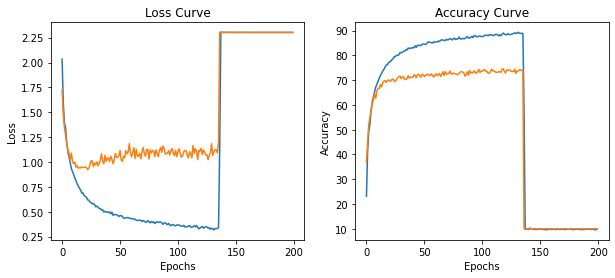

Final Training Accuracy: 9.883999999389648
Final Validation Accuracy: 9.99999998474121


000: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029
000: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029


Epoch 0 Finished.  Time per Epoch:  4509.40 s 


001: Acc-tr:   9.95, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028
001: Acc-tr:   9.95, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028


Epoch 1 Finished.  Time per Epoch:  2265.88 s 


002: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029
002: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029


Epoch 2 Finished.  Time per Epoch:  1518.02 s 


003: Acc-tr:   9.90, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029
003: Acc-tr:   9.90, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029


Epoch 3 Finished.  Time per Epoch:  1144.11 s 


004: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3031
004: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3031


Epoch 4 Finished.  Time per Epoch:  919.74 s 


005: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027
005: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027


Epoch 5 Finished.  Time per Epoch:  770.17 s 


006: Acc-tr:  10.09, Acc-val:  10.00, L-tr: 2.3029, L-val: 2.3029
006: Acc-tr:  10.09, Acc-val:  10.00, L-tr: 2.3029, L-val: 2.3029


Epoch 6 Finished.  Time per Epoch:  663.34 s 


007: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029
007: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029


Epoch 7 Finished.  Time per Epoch:  583.23 s 


008: Acc-tr:   9.99, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029
008: Acc-tr:   9.99, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029


Epoch 8 Finished.  Time per Epoch:  520.90 s 


009: Acc-tr:   9.67, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029
009: Acc-tr:   9.67, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029


Epoch 9 Finished.  Time per Epoch:  471.07 s 


010: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028
010: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028


Epoch 10 Finished.  Time per Epoch:  430.27 s 


011: Acc-tr:  10.06, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029
011: Acc-tr:  10.06, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029


Epoch 11 Finished.  Time per Epoch:  396.27 s 


012: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028
012: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028


Epoch 12 Finished.  Time per Epoch:  367.52 s 


013: Acc-tr:   9.84, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029
013: Acc-tr:   9.84, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029


Epoch 13 Finished.  Time per Epoch:  342.87 s 


014: Acc-tr:  10.05, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3032
014: Acc-tr:  10.05, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3032


Epoch 14 Finished.  Time per Epoch:  321.51 s 


KeyboardInterrupt: ignored

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_RandomPerspective)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_RandomPerspective)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Alexnet/Alexnet_RandomPerspective"

for i, (input, target) in enumerate(trainloader):
  print(input.size())
  break

main("Alexnet",'alexnet','train', directory, 200)

##Random Rotation

In [ ]:
transform_RandomRotation = transforms.Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.RandomRotation(60),
    myNormalize()
    ])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_RandomRotation)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_RandomRotation)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Alexnet/Alexnet_Random_Rotation"

for i, (input, target) in enumerate(trainloader):
  print(input.size())
  break

main("Alexnet",'alexnet','train', directory, 250)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([512, 3, 28, 28])


Number of parameters: 4230654
Number of parameters: 4230654
Number of parameters: 4230654
Number of parameters: 4230654
Number of parameters: 4230654
Number of parameters: 4230654
Number of parameters: 4230654
Number of parameters: 4230654
Number of parameters: 4230654
Number of parameters: 4230654


Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Alexnet...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 0 Finished.  Time per Epoch:  26.37 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 1 Finished.  Time per Epoch:  26.55 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 2 Finished.  Time per Epoch:  26.54 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 3 Finished.  Time per Epoch:  26.54 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 4 Finished.  Time per Epoch:  26.59 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 5 Finished.  Time per Epoch:  26.72 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 6 Finished.  Time per Epoch:  26.78 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 7 Finished.  Time per Epoch:  26.85 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 8 Finished.  Time per Epoch:  26.86 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 9 Finished.  Time per Epoch:  26.89 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 10 Finished.  Time per Epoch:  26.95 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 11 Finished.  Time per Epoch:  26.91 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Epoch 12 Finished.  Time per Epoch:  26.92 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 13 Finished.  Time per Epoch:  26.95 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch 14 Finished.  Time per Epoch:  26.98 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 15 Finished.  Time per Epoch:  27.01 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 16 Finished.  Time per Epoch:  27.04 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 17 Finished.  Time per Epoch:  27.08 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 18 Finished.  Time per Epoch:  27.10 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 19 Finished.  Time per Epoch:  27.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 20 Finished.  Time per Epoch:  27.08 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 21 Finished.  Time per Epoch:  27.13 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 22 Finished.  Time per Epoch:  27.16 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 23 Finished.  Time per Epoch:  27.17 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 24 Finished.  Time per Epoch:  27.18 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch 25 Finished.  Time per Epoch:  27.19 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 26 Finished.  Time per Epoch:  27.22 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 27 Finished.  Time per Epoch:  27.22 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 28 Finished.  Time per Epoch:  27.23 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 29 Finished.  Time per Epoch:  27.24 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 30 Finished.  Time per Epoch:  27.24 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 31 Finished.  Time per Epoch:  27.24 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 32 Finished.  Time per Epoch:  27.26 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 33 Finished.  Time per Epoch:  27.27 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 34 Finished.  Time per Epoch:  27.28 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 35 Finished.  Time per Epoch:  27.26 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch 36 Finished.  Time per Epoch:  27.27 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 37 Finished.  Time per Epoch:  27.28 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 38 Finished.  Time per Epoch:  27.28 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 39 Finished.  Time per Epoch:  27.27 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 40 Finished.  Time per Epoch:  27.26 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 41 Finished.  Time per Epoch:  27.26 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Epoch 42 Finished.  Time per Epoch:  27.24 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 43 Finished.  Time per Epoch:  27.23 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 44 Finished.  Time per Epoch:  27.22 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 45 Finished.  Time per Epoch:  27.21 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 46 Finished.  Time per Epoch:  27.20 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Epoch 47 Finished.  Time per Epoch:  27.19 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 48 Finished.  Time per Epoch:  27.18 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 49 Finished.  Time per Epoch:  27.17 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 50 Finished.  Time per Epoch:  27.15 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 51 Finished.  Time per Epoch:  27.13 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 52 Finished.  Time per Epoch:  27.12 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 53 Finished.  Time per Epoch:  27.10 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 54 Finished.  Time per Epoch:  27.09 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 55 Finished.  Time per Epoch:  27.07 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 56 Finished.  Time per Epoch:  27.06 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 57 Finished.  Time per Epoch:  27.05 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 58 Finished.  Time per Epoch:  27.03 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 59 Finished.  Time per Epoch:  27.01 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 60 Finished.  Time per Epoch:  27.00 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 61 Finished.  Time per Epoch:  26.99 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Epoch 62 Finished.  Time per Epoch:  26.98 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 63 Finished.  Time per Epoch:  26.97 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Epoch 64 Finished.  Time per Epoch:  26.97 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 65 Finished.  Time per Epoch:  26.96 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 66 Finished.  Time per Epoch:  26.95 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 67 Finished.  Time per Epoch:  26.94 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Epoch 68 Finished.  Time per Epoch:  26.93 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch 69 Finished.  Time per Epoch:  26.93 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch 70 Finished.  Time per Epoch:  26.92 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 71 Finished.  Time per Epoch:  26.92 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 72 Finished.  Time per Epoch:  26.92 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 73 Finished.  Time per Epoch:  26.92 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 74 Finished.  Time per Epoch:  26.92 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 75 Finished.  Time per Epoch:  26.90 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 76 Finished.  Time per Epoch:  26.90 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 77 Finished.  Time per Epoch:  26.91 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 78 Finished.  Time per Epoch:  26.90 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 79 Finished.  Time per Epoch:  26.91 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 80 Finished.  Time per Epoch:  26.90 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 81 Finished.  Time per Epoch:  26.90 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 82 Finished.  Time per Epoch:  26.89 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 83 Finished.  Time per Epoch:  26.88 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 84 Finished.  Time per Epoch:  26.88 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Epoch 85 Finished.  Time per Epoch:  26.87 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch 86 Finished.  Time per Epoch:  26.86 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 87 Finished.  Time per Epoch:  26.86 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 88 Finished.  Time per Epoch:  26.85 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 89 Finished.  Time per Epoch:  26.84 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 90 Finished.  Time per Epoch:  26.84 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch 91 Finished.  Time per Epoch:  26.83 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 92 Finished.  Time per Epoch:  26.82 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 93 Finished.  Time per Epoch:  26.80 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 94 Finished.  Time per Epoch:  26.79 s 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f73d913b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch 95 Finished.  Time per Epoch:  26.78 s 


096: Acc-tr:  76.18, Acc-val:  67.27, L-tr: 0.6946, L-val: 1.0849, Time: 2595.759343
096: Acc-tr:  76.18, Acc-val:  67.27, L-tr: 0.6946, L-val: 1.0849, Time: 2595.759343
096: Acc-tr:  76.18, Acc-val:  67.27, L-tr: 0.6946, L-val: 1.0849, Time: 2595.759343
096: Acc-tr:  76.18, Acc-val:  67.27, L-tr: 0.6946, L-val: 1.0849, Time: 2595.759343
096: Acc-tr:  76.18, Acc-val:  67.27, L-tr: 0.6946, L-val: 1.0849, Time: 2595.759343
096: Acc-tr:  76.18, Acc-val:  67.27, L-tr: 0.6946, L-val: 1.0849, Time: 2595.759343
096: Acc-tr:  76.18, Acc-val:  67.27, L-tr: 0.6946, L-val: 1.0849, Time: 2595.759343
096: Acc-tr:  76.18, Acc-val:  67.27, L-tr: 0.6946, L-val: 1.0849, Time: 2595.759343
096: Acc-tr:  76.18, Acc-val:  67.27, L-tr: 0.6946, L-val: 1.0849, Time: 2595.759343
096: Acc-tr:  76.18, Acc-val:  67.27, L-tr: 0.6946, L-val: 1.0849, Time: 2595.759343


Epoch 96 Finished.  Time per Epoch:  26.76 s 


097: Acc-tr:  75.95, Acc-val:  67.00, L-tr: 0.7038, L-val: 1.0960, Time: 2621.159191
097: Acc-tr:  75.95, Acc-val:  67.00, L-tr: 0.7038, L-val: 1.0960, Time: 2621.159191
097: Acc-tr:  75.95, Acc-val:  67.00, L-tr: 0.7038, L-val: 1.0960, Time: 2621.159191
097: Acc-tr:  75.95, Acc-val:  67.00, L-tr: 0.7038, L-val: 1.0960, Time: 2621.159191
097: Acc-tr:  75.95, Acc-val:  67.00, L-tr: 0.7038, L-val: 1.0960, Time: 2621.159191
097: Acc-tr:  75.95, Acc-val:  67.00, L-tr: 0.7038, L-val: 1.0960, Time: 2621.159191
097: Acc-tr:  75.95, Acc-val:  67.00, L-tr: 0.7038, L-val: 1.0960, Time: 2621.159191
097: Acc-tr:  75.95, Acc-val:  67.00, L-tr: 0.7038, L-val: 1.0960, Time: 2621.159191
097: Acc-tr:  75.95, Acc-val:  67.00, L-tr: 0.7038, L-val: 1.0960, Time: 2621.159191
097: Acc-tr:  75.95, Acc-val:  67.00, L-tr: 0.7038, L-val: 1.0960, Time: 2621.159191


Epoch 97 Finished.  Time per Epoch:  26.75 s 


098: Acc-tr:  76.07, Acc-val:  67.24, L-tr: 0.6995, L-val: 1.0461, Time: 2646.316931
098: Acc-tr:  76.07, Acc-val:  67.24, L-tr: 0.6995, L-val: 1.0461, Time: 2646.316931
098: Acc-tr:  76.07, Acc-val:  67.24, L-tr: 0.6995, L-val: 1.0461, Time: 2646.316931
098: Acc-tr:  76.07, Acc-val:  67.24, L-tr: 0.6995, L-val: 1.0461, Time: 2646.316931
098: Acc-tr:  76.07, Acc-val:  67.24, L-tr: 0.6995, L-val: 1.0461, Time: 2646.316931
098: Acc-tr:  76.07, Acc-val:  67.24, L-tr: 0.6995, L-val: 1.0461, Time: 2646.316931
098: Acc-tr:  76.07, Acc-val:  67.24, L-tr: 0.6995, L-val: 1.0461, Time: 2646.316931
098: Acc-tr:  76.07, Acc-val:  67.24, L-tr: 0.6995, L-val: 1.0461, Time: 2646.316931
098: Acc-tr:  76.07, Acc-val:  67.24, L-tr: 0.6995, L-val: 1.0461, Time: 2646.316931
098: Acc-tr:  76.07, Acc-val:  67.24, L-tr: 0.6995, L-val: 1.0461, Time: 2646.316931


Epoch 98 Finished.  Time per Epoch:  26.73 s 


099: Acc-tr:  76.86, Acc-val:  66.21, L-tr: 0.6787, L-val: 1.0807, Time: 2671.535609
099: Acc-tr:  76.86, Acc-val:  66.21, L-tr: 0.6787, L-val: 1.0807, Time: 2671.535609
099: Acc-tr:  76.86, Acc-val:  66.21, L-tr: 0.6787, L-val: 1.0807, Time: 2671.535609
099: Acc-tr:  76.86, Acc-val:  66.21, L-tr: 0.6787, L-val: 1.0807, Time: 2671.535609
099: Acc-tr:  76.86, Acc-val:  66.21, L-tr: 0.6787, L-val: 1.0807, Time: 2671.535609
099: Acc-tr:  76.86, Acc-val:  66.21, L-tr: 0.6787, L-val: 1.0807, Time: 2671.535609
099: Acc-tr:  76.86, Acc-val:  66.21, L-tr: 0.6787, L-val: 1.0807, Time: 2671.535609
099: Acc-tr:  76.86, Acc-val:  66.21, L-tr: 0.6787, L-val: 1.0807, Time: 2671.535609
099: Acc-tr:  76.86, Acc-val:  66.21, L-tr: 0.6787, L-val: 1.0807, Time: 2671.535609
099: Acc-tr:  76.86, Acc-val:  66.21, L-tr: 0.6787, L-val: 1.0807, Time: 2671.535609


Epoch 99 Finished.  Time per Epoch:  26.72 s 


100: Acc-tr:  75.91, Acc-val:  67.30, L-tr: 0.7069, L-val: 1.0446, Time: 2696.684732
100: Acc-tr:  75.91, Acc-val:  67.30, L-tr: 0.7069, L-val: 1.0446, Time: 2696.684732
100: Acc-tr:  75.91, Acc-val:  67.30, L-tr: 0.7069, L-val: 1.0446, Time: 2696.684732
100: Acc-tr:  75.91, Acc-val:  67.30, L-tr: 0.7069, L-val: 1.0446, Time: 2696.684732
100: Acc-tr:  75.91, Acc-val:  67.30, L-tr: 0.7069, L-val: 1.0446, Time: 2696.684732
100: Acc-tr:  75.91, Acc-val:  67.30, L-tr: 0.7069, L-val: 1.0446, Time: 2696.684732
100: Acc-tr:  75.91, Acc-val:  67.30, L-tr: 0.7069, L-val: 1.0446, Time: 2696.684732
100: Acc-tr:  75.91, Acc-val:  67.30, L-tr: 0.7069, L-val: 1.0446, Time: 2696.684732
100: Acc-tr:  75.91, Acc-val:  67.30, L-tr: 0.7069, L-val: 1.0446, Time: 2696.684732
100: Acc-tr:  75.91, Acc-val:  67.30, L-tr: 0.7069, L-val: 1.0446, Time: 2696.684732


Epoch 100 Finished.  Time per Epoch:  26.70 s 


101: Acc-tr:  76.55, Acc-val:  67.17, L-tr: 0.6889, L-val: 1.0854, Time: 2721.824620
101: Acc-tr:  76.55, Acc-val:  67.17, L-tr: 0.6889, L-val: 1.0854, Time: 2721.824620
101: Acc-tr:  76.55, Acc-val:  67.17, L-tr: 0.6889, L-val: 1.0854, Time: 2721.824620
101: Acc-tr:  76.55, Acc-val:  67.17, L-tr: 0.6889, L-val: 1.0854, Time: 2721.824620
101: Acc-tr:  76.55, Acc-val:  67.17, L-tr: 0.6889, L-val: 1.0854, Time: 2721.824620
101: Acc-tr:  76.55, Acc-val:  67.17, L-tr: 0.6889, L-val: 1.0854, Time: 2721.824620
101: Acc-tr:  76.55, Acc-val:  67.17, L-tr: 0.6889, L-val: 1.0854, Time: 2721.824620
101: Acc-tr:  76.55, Acc-val:  67.17, L-tr: 0.6889, L-val: 1.0854, Time: 2721.824620
101: Acc-tr:  76.55, Acc-val:  67.17, L-tr: 0.6889, L-val: 1.0854, Time: 2721.824620
101: Acc-tr:  76.55, Acc-val:  67.17, L-tr: 0.6889, L-val: 1.0854, Time: 2721.824620


Epoch 101 Finished.  Time per Epoch:  26.69 s 


102: Acc-tr:  76.65, Acc-val:  66.97, L-tr: 0.6844, L-val: 1.0412, Time: 2747.150916
102: Acc-tr:  76.65, Acc-val:  66.97, L-tr: 0.6844, L-val: 1.0412, Time: 2747.150916
102: Acc-tr:  76.65, Acc-val:  66.97, L-tr: 0.6844, L-val: 1.0412, Time: 2747.150916
102: Acc-tr:  76.65, Acc-val:  66.97, L-tr: 0.6844, L-val: 1.0412, Time: 2747.150916
102: Acc-tr:  76.65, Acc-val:  66.97, L-tr: 0.6844, L-val: 1.0412, Time: 2747.150916
102: Acc-tr:  76.65, Acc-val:  66.97, L-tr: 0.6844, L-val: 1.0412, Time: 2747.150916
102: Acc-tr:  76.65, Acc-val:  66.97, L-tr: 0.6844, L-val: 1.0412, Time: 2747.150916
102: Acc-tr:  76.65, Acc-val:  66.97, L-tr: 0.6844, L-val: 1.0412, Time: 2747.150916
102: Acc-tr:  76.65, Acc-val:  66.97, L-tr: 0.6844, L-val: 1.0412, Time: 2747.150916
102: Acc-tr:  76.65, Acc-val:  66.97, L-tr: 0.6844, L-val: 1.0412, Time: 2747.150916


Epoch 102 Finished.  Time per Epoch:  26.67 s 


103: Acc-tr:  77.06, Acc-val:  66.93, L-tr: 0.6710, L-val: 1.0629, Time: 2772.649615
103: Acc-tr:  77.06, Acc-val:  66.93, L-tr: 0.6710, L-val: 1.0629, Time: 2772.649615
103: Acc-tr:  77.06, Acc-val:  66.93, L-tr: 0.6710, L-val: 1.0629, Time: 2772.649615
103: Acc-tr:  77.06, Acc-val:  66.93, L-tr: 0.6710, L-val: 1.0629, Time: 2772.649615
103: Acc-tr:  77.06, Acc-val:  66.93, L-tr: 0.6710, L-val: 1.0629, Time: 2772.649615
103: Acc-tr:  77.06, Acc-val:  66.93, L-tr: 0.6710, L-val: 1.0629, Time: 2772.649615
103: Acc-tr:  77.06, Acc-val:  66.93, L-tr: 0.6710, L-val: 1.0629, Time: 2772.649615
103: Acc-tr:  77.06, Acc-val:  66.93, L-tr: 0.6710, L-val: 1.0629, Time: 2772.649615
103: Acc-tr:  77.06, Acc-val:  66.93, L-tr: 0.6710, L-val: 1.0629, Time: 2772.649615
103: Acc-tr:  77.06, Acc-val:  66.93, L-tr: 0.6710, L-val: 1.0629, Time: 2772.649615


Epoch 103 Finished.  Time per Epoch:  26.66 s 


104: Acc-tr:  77.00, Acc-val:  66.93, L-tr: 0.6734, L-val: 1.0563, Time: 2798.197372
104: Acc-tr:  77.00, Acc-val:  66.93, L-tr: 0.6734, L-val: 1.0563, Time: 2798.197372
104: Acc-tr:  77.00, Acc-val:  66.93, L-tr: 0.6734, L-val: 1.0563, Time: 2798.197372
104: Acc-tr:  77.00, Acc-val:  66.93, L-tr: 0.6734, L-val: 1.0563, Time: 2798.197372
104: Acc-tr:  77.00, Acc-val:  66.93, L-tr: 0.6734, L-val: 1.0563, Time: 2798.197372
104: Acc-tr:  77.00, Acc-val:  66.93, L-tr: 0.6734, L-val: 1.0563, Time: 2798.197372
104: Acc-tr:  77.00, Acc-val:  66.93, L-tr: 0.6734, L-val: 1.0563, Time: 2798.197372
104: Acc-tr:  77.00, Acc-val:  66.93, L-tr: 0.6734, L-val: 1.0563, Time: 2798.197372
104: Acc-tr:  77.00, Acc-val:  66.93, L-tr: 0.6734, L-val: 1.0563, Time: 2798.197372
104: Acc-tr:  77.00, Acc-val:  66.93, L-tr: 0.6734, L-val: 1.0563, Time: 2798.197372


Epoch 104 Finished.  Time per Epoch:  26.65 s 


105: Acc-tr:  76.40, Acc-val:  67.27, L-tr: 0.6854, L-val: 1.0908, Time: 2823.266571
105: Acc-tr:  76.40, Acc-val:  67.27, L-tr: 0.6854, L-val: 1.0908, Time: 2823.266571
105: Acc-tr:  76.40, Acc-val:  67.27, L-tr: 0.6854, L-val: 1.0908, Time: 2823.266571
105: Acc-tr:  76.40, Acc-val:  67.27, L-tr: 0.6854, L-val: 1.0908, Time: 2823.266571
105: Acc-tr:  76.40, Acc-val:  67.27, L-tr: 0.6854, L-val: 1.0908, Time: 2823.266571
105: Acc-tr:  76.40, Acc-val:  67.27, L-tr: 0.6854, L-val: 1.0908, Time: 2823.266571
105: Acc-tr:  76.40, Acc-val:  67.27, L-tr: 0.6854, L-val: 1.0908, Time: 2823.266571
105: Acc-tr:  76.40, Acc-val:  67.27, L-tr: 0.6854, L-val: 1.0908, Time: 2823.266571
105: Acc-tr:  76.40, Acc-val:  67.27, L-tr: 0.6854, L-val: 1.0908, Time: 2823.266571
105: Acc-tr:  76.40, Acc-val:  67.27, L-tr: 0.6854, L-val: 1.0908, Time: 2823.266571


Epoch 105 Finished.  Time per Epoch:  26.64 s 


106: Acc-tr:  76.90, Acc-val:  66.94, L-tr: 0.6736, L-val: 1.0772, Time: 2848.553230
106: Acc-tr:  76.90, Acc-val:  66.94, L-tr: 0.6736, L-val: 1.0772, Time: 2848.553230
106: Acc-tr:  76.90, Acc-val:  66.94, L-tr: 0.6736, L-val: 1.0772, Time: 2848.553230
106: Acc-tr:  76.90, Acc-val:  66.94, L-tr: 0.6736, L-val: 1.0772, Time: 2848.553230
106: Acc-tr:  76.90, Acc-val:  66.94, L-tr: 0.6736, L-val: 1.0772, Time: 2848.553230
106: Acc-tr:  76.90, Acc-val:  66.94, L-tr: 0.6736, L-val: 1.0772, Time: 2848.553230
106: Acc-tr:  76.90, Acc-val:  66.94, L-tr: 0.6736, L-val: 1.0772, Time: 2848.553230
106: Acc-tr:  76.90, Acc-val:  66.94, L-tr: 0.6736, L-val: 1.0772, Time: 2848.553230
106: Acc-tr:  76.90, Acc-val:  66.94, L-tr: 0.6736, L-val: 1.0772, Time: 2848.553230
106: Acc-tr:  76.90, Acc-val:  66.94, L-tr: 0.6736, L-val: 1.0772, Time: 2848.553230


Epoch 106 Finished.  Time per Epoch:  26.62 s 


107: Acc-tr:  76.76, Acc-val:  67.10, L-tr: 0.6833, L-val: 1.0618, Time: 2874.044648
107: Acc-tr:  76.76, Acc-val:  67.10, L-tr: 0.6833, L-val: 1.0618, Time: 2874.044648
107: Acc-tr:  76.76, Acc-val:  67.10, L-tr: 0.6833, L-val: 1.0618, Time: 2874.044648
107: Acc-tr:  76.76, Acc-val:  67.10, L-tr: 0.6833, L-val: 1.0618, Time: 2874.044648
107: Acc-tr:  76.76, Acc-val:  67.10, L-tr: 0.6833, L-val: 1.0618, Time: 2874.044648
107: Acc-tr:  76.76, Acc-val:  67.10, L-tr: 0.6833, L-val: 1.0618, Time: 2874.044648
107: Acc-tr:  76.76, Acc-val:  67.10, L-tr: 0.6833, L-val: 1.0618, Time: 2874.044648
107: Acc-tr:  76.76, Acc-val:  67.10, L-tr: 0.6833, L-val: 1.0618, Time: 2874.044648
107: Acc-tr:  76.76, Acc-val:  67.10, L-tr: 0.6833, L-val: 1.0618, Time: 2874.044648
107: Acc-tr:  76.76, Acc-val:  67.10, L-tr: 0.6833, L-val: 1.0618, Time: 2874.044648


Epoch 107 Finished.  Time per Epoch:  26.61 s 


108: Acc-tr:  76.69, Acc-val:  66.89, L-tr: 0.6788, L-val: 1.0935, Time: 2899.419909
108: Acc-tr:  76.69, Acc-val:  66.89, L-tr: 0.6788, L-val: 1.0935, Time: 2899.419909
108: Acc-tr:  76.69, Acc-val:  66.89, L-tr: 0.6788, L-val: 1.0935, Time: 2899.419909
108: Acc-tr:  76.69, Acc-val:  66.89, L-tr: 0.6788, L-val: 1.0935, Time: 2899.419909
108: Acc-tr:  76.69, Acc-val:  66.89, L-tr: 0.6788, L-val: 1.0935, Time: 2899.419909
108: Acc-tr:  76.69, Acc-val:  66.89, L-tr: 0.6788, L-val: 1.0935, Time: 2899.419909
108: Acc-tr:  76.69, Acc-val:  66.89, L-tr: 0.6788, L-val: 1.0935, Time: 2899.419909
108: Acc-tr:  76.69, Acc-val:  66.89, L-tr: 0.6788, L-val: 1.0935, Time: 2899.419909
108: Acc-tr:  76.69, Acc-val:  66.89, L-tr: 0.6788, L-val: 1.0935, Time: 2899.419909
108: Acc-tr:  76.69, Acc-val:  66.89, L-tr: 0.6788, L-val: 1.0935, Time: 2899.419909


Epoch 108 Finished.  Time per Epoch:  26.60 s 


109: Acc-tr:  77.35, Acc-val:  67.25, L-tr: 0.6698, L-val: 1.0708, Time: 2924.575389
109: Acc-tr:  77.35, Acc-val:  67.25, L-tr: 0.6698, L-val: 1.0708, Time: 2924.575389
109: Acc-tr:  77.35, Acc-val:  67.25, L-tr: 0.6698, L-val: 1.0708, Time: 2924.575389
109: Acc-tr:  77.35, Acc-val:  67.25, L-tr: 0.6698, L-val: 1.0708, Time: 2924.575389
109: Acc-tr:  77.35, Acc-val:  67.25, L-tr: 0.6698, L-val: 1.0708, Time: 2924.575389
109: Acc-tr:  77.35, Acc-val:  67.25, L-tr: 0.6698, L-val: 1.0708, Time: 2924.575389
109: Acc-tr:  77.35, Acc-val:  67.25, L-tr: 0.6698, L-val: 1.0708, Time: 2924.575389
109: Acc-tr:  77.35, Acc-val:  67.25, L-tr: 0.6698, L-val: 1.0708, Time: 2924.575389
109: Acc-tr:  77.35, Acc-val:  67.25, L-tr: 0.6698, L-val: 1.0708, Time: 2924.575389
109: Acc-tr:  77.35, Acc-val:  67.25, L-tr: 0.6698, L-val: 1.0708, Time: 2924.575389


Epoch 109 Finished.  Time per Epoch:  26.59 s 


110: Acc-tr:  76.66, Acc-val:  66.25, L-tr: 0.6801, L-val: 1.0695, Time: 2949.942502
110: Acc-tr:  76.66, Acc-val:  66.25, L-tr: 0.6801, L-val: 1.0695, Time: 2949.942502
110: Acc-tr:  76.66, Acc-val:  66.25, L-tr: 0.6801, L-val: 1.0695, Time: 2949.942502
110: Acc-tr:  76.66, Acc-val:  66.25, L-tr: 0.6801, L-val: 1.0695, Time: 2949.942502
110: Acc-tr:  76.66, Acc-val:  66.25, L-tr: 0.6801, L-val: 1.0695, Time: 2949.942502
110: Acc-tr:  76.66, Acc-val:  66.25, L-tr: 0.6801, L-val: 1.0695, Time: 2949.942502
110: Acc-tr:  76.66, Acc-val:  66.25, L-tr: 0.6801, L-val: 1.0695, Time: 2949.942502
110: Acc-tr:  76.66, Acc-val:  66.25, L-tr: 0.6801, L-val: 1.0695, Time: 2949.942502
110: Acc-tr:  76.66, Acc-val:  66.25, L-tr: 0.6801, L-val: 1.0695, Time: 2949.942502
110: Acc-tr:  76.66, Acc-val:  66.25, L-tr: 0.6801, L-val: 1.0695, Time: 2949.942502


Epoch 110 Finished.  Time per Epoch:  26.58 s 


111: Acc-tr:  77.30, Acc-val:  67.71, L-tr: 0.6618, L-val: 1.0669, Time: 2975.076443
111: Acc-tr:  77.30, Acc-val:  67.71, L-tr: 0.6618, L-val: 1.0669, Time: 2975.076443
111: Acc-tr:  77.30, Acc-val:  67.71, L-tr: 0.6618, L-val: 1.0669, Time: 2975.076443
111: Acc-tr:  77.30, Acc-val:  67.71, L-tr: 0.6618, L-val: 1.0669, Time: 2975.076443
111: Acc-tr:  77.30, Acc-val:  67.71, L-tr: 0.6618, L-val: 1.0669, Time: 2975.076443
111: Acc-tr:  77.30, Acc-val:  67.71, L-tr: 0.6618, L-val: 1.0669, Time: 2975.076443
111: Acc-tr:  77.30, Acc-val:  67.71, L-tr: 0.6618, L-val: 1.0669, Time: 2975.076443
111: Acc-tr:  77.30, Acc-val:  67.71, L-tr: 0.6618, L-val: 1.0669, Time: 2975.076443
111: Acc-tr:  77.30, Acc-val:  67.71, L-tr: 0.6618, L-val: 1.0669, Time: 2975.076443
111: Acc-tr:  77.30, Acc-val:  67.71, L-tr: 0.6618, L-val: 1.0669, Time: 2975.076443


Epoch 111 Finished.  Time per Epoch:  26.56 s 


112: Acc-tr:  77.24, Acc-val:  65.24, L-tr: 0.6693, L-val: 1.0848, Time: 3000.159110
112: Acc-tr:  77.24, Acc-val:  65.24, L-tr: 0.6693, L-val: 1.0848, Time: 3000.159110
112: Acc-tr:  77.24, Acc-val:  65.24, L-tr: 0.6693, L-val: 1.0848, Time: 3000.159110
112: Acc-tr:  77.24, Acc-val:  65.24, L-tr: 0.6693, L-val: 1.0848, Time: 3000.159110
112: Acc-tr:  77.24, Acc-val:  65.24, L-tr: 0.6693, L-val: 1.0848, Time: 3000.159110
112: Acc-tr:  77.24, Acc-val:  65.24, L-tr: 0.6693, L-val: 1.0848, Time: 3000.159110
112: Acc-tr:  77.24, Acc-val:  65.24, L-tr: 0.6693, L-val: 1.0848, Time: 3000.159110
112: Acc-tr:  77.24, Acc-val:  65.24, L-tr: 0.6693, L-val: 1.0848, Time: 3000.159110
112: Acc-tr:  77.24, Acc-val:  65.24, L-tr: 0.6693, L-val: 1.0848, Time: 3000.159110
112: Acc-tr:  77.24, Acc-val:  65.24, L-tr: 0.6693, L-val: 1.0848, Time: 3000.159110


Epoch 112 Finished.  Time per Epoch:  26.55 s 


113: Acc-tr:  77.16, Acc-val:  67.91, L-tr: 0.6686, L-val: 1.0614, Time: 3025.470423
113: Acc-tr:  77.16, Acc-val:  67.91, L-tr: 0.6686, L-val: 1.0614, Time: 3025.470423
113: Acc-tr:  77.16, Acc-val:  67.91, L-tr: 0.6686, L-val: 1.0614, Time: 3025.470423
113: Acc-tr:  77.16, Acc-val:  67.91, L-tr: 0.6686, L-val: 1.0614, Time: 3025.470423
113: Acc-tr:  77.16, Acc-val:  67.91, L-tr: 0.6686, L-val: 1.0614, Time: 3025.470423
113: Acc-tr:  77.16, Acc-val:  67.91, L-tr: 0.6686, L-val: 1.0614, Time: 3025.470423
113: Acc-tr:  77.16, Acc-val:  67.91, L-tr: 0.6686, L-val: 1.0614, Time: 3025.470423
113: Acc-tr:  77.16, Acc-val:  67.91, L-tr: 0.6686, L-val: 1.0614, Time: 3025.470423
113: Acc-tr:  77.16, Acc-val:  67.91, L-tr: 0.6686, L-val: 1.0614, Time: 3025.470423
113: Acc-tr:  77.16, Acc-val:  67.91, L-tr: 0.6686, L-val: 1.0614, Time: 3025.470423


Epoch 113 Finished.  Time per Epoch:  26.54 s 


114: Acc-tr:  77.38, Acc-val:  68.11, L-tr: 0.6615, L-val: 1.0567, Time: 3051.027693
114: Acc-tr:  77.38, Acc-val:  68.11, L-tr: 0.6615, L-val: 1.0567, Time: 3051.027693
114: Acc-tr:  77.38, Acc-val:  68.11, L-tr: 0.6615, L-val: 1.0567, Time: 3051.027693
114: Acc-tr:  77.38, Acc-val:  68.11, L-tr: 0.6615, L-val: 1.0567, Time: 3051.027693
114: Acc-tr:  77.38, Acc-val:  68.11, L-tr: 0.6615, L-val: 1.0567, Time: 3051.027693
114: Acc-tr:  77.38, Acc-val:  68.11, L-tr: 0.6615, L-val: 1.0567, Time: 3051.027693
114: Acc-tr:  77.38, Acc-val:  68.11, L-tr: 0.6615, L-val: 1.0567, Time: 3051.027693
114: Acc-tr:  77.38, Acc-val:  68.11, L-tr: 0.6615, L-val: 1.0567, Time: 3051.027693
114: Acc-tr:  77.38, Acc-val:  68.11, L-tr: 0.6615, L-val: 1.0567, Time: 3051.027693
114: Acc-tr:  77.38, Acc-val:  68.11, L-tr: 0.6615, L-val: 1.0567, Time: 3051.027693


Epoch 114 Finished.  Time per Epoch:  26.53 s 


115: Acc-tr:  77.02, Acc-val:  67.41, L-tr: 0.6720, L-val: 1.0462, Time: 3076.416907
115: Acc-tr:  77.02, Acc-val:  67.41, L-tr: 0.6720, L-val: 1.0462, Time: 3076.416907
115: Acc-tr:  77.02, Acc-val:  67.41, L-tr: 0.6720, L-val: 1.0462, Time: 3076.416907
115: Acc-tr:  77.02, Acc-val:  67.41, L-tr: 0.6720, L-val: 1.0462, Time: 3076.416907
115: Acc-tr:  77.02, Acc-val:  67.41, L-tr: 0.6720, L-val: 1.0462, Time: 3076.416907
115: Acc-tr:  77.02, Acc-val:  67.41, L-tr: 0.6720, L-val: 1.0462, Time: 3076.416907
115: Acc-tr:  77.02, Acc-val:  67.41, L-tr: 0.6720, L-val: 1.0462, Time: 3076.416907
115: Acc-tr:  77.02, Acc-val:  67.41, L-tr: 0.6720, L-val: 1.0462, Time: 3076.416907
115: Acc-tr:  77.02, Acc-val:  67.41, L-tr: 0.6720, L-val: 1.0462, Time: 3076.416907
115: Acc-tr:  77.02, Acc-val:  67.41, L-tr: 0.6720, L-val: 1.0462, Time: 3076.416907


Epoch 115 Finished.  Time per Epoch:  26.52 s 


116: Acc-tr:  77.69, Acc-val:  66.53, L-tr: 0.6499, L-val: 1.1136, Time: 3101.403152
116: Acc-tr:  77.69, Acc-val:  66.53, L-tr: 0.6499, L-val: 1.1136, Time: 3101.403152
116: Acc-tr:  77.69, Acc-val:  66.53, L-tr: 0.6499, L-val: 1.1136, Time: 3101.403152
116: Acc-tr:  77.69, Acc-val:  66.53, L-tr: 0.6499, L-val: 1.1136, Time: 3101.403152
116: Acc-tr:  77.69, Acc-val:  66.53, L-tr: 0.6499, L-val: 1.1136, Time: 3101.403152
116: Acc-tr:  77.69, Acc-val:  66.53, L-tr: 0.6499, L-val: 1.1136, Time: 3101.403152
116: Acc-tr:  77.69, Acc-val:  66.53, L-tr: 0.6499, L-val: 1.1136, Time: 3101.403152
116: Acc-tr:  77.69, Acc-val:  66.53, L-tr: 0.6499, L-val: 1.1136, Time: 3101.403152
116: Acc-tr:  77.69, Acc-val:  66.53, L-tr: 0.6499, L-val: 1.1136, Time: 3101.403152
116: Acc-tr:  77.69, Acc-val:  66.53, L-tr: 0.6499, L-val: 1.1136, Time: 3101.403152


Epoch 116 Finished.  Time per Epoch:  26.51 s 


117: Acc-tr:  77.27, Acc-val:  67.97, L-tr: 0.6637, L-val: 1.0416, Time: 3126.872732
117: Acc-tr:  77.27, Acc-val:  67.97, L-tr: 0.6637, L-val: 1.0416, Time: 3126.872732
117: Acc-tr:  77.27, Acc-val:  67.97, L-tr: 0.6637, L-val: 1.0416, Time: 3126.872732
117: Acc-tr:  77.27, Acc-val:  67.97, L-tr: 0.6637, L-val: 1.0416, Time: 3126.872732
117: Acc-tr:  77.27, Acc-val:  67.97, L-tr: 0.6637, L-val: 1.0416, Time: 3126.872732
117: Acc-tr:  77.27, Acc-val:  67.97, L-tr: 0.6637, L-val: 1.0416, Time: 3126.872732
117: Acc-tr:  77.27, Acc-val:  67.97, L-tr: 0.6637, L-val: 1.0416, Time: 3126.872732
117: Acc-tr:  77.27, Acc-val:  67.97, L-tr: 0.6637, L-val: 1.0416, Time: 3126.872732
117: Acc-tr:  77.27, Acc-val:  67.97, L-tr: 0.6637, L-val: 1.0416, Time: 3126.872732
117: Acc-tr:  77.27, Acc-val:  67.97, L-tr: 0.6637, L-val: 1.0416, Time: 3126.872732


Epoch 117 Finished.  Time per Epoch:  26.50 s 


118: Acc-tr:  77.53, Acc-val:  67.26, L-tr: 0.6663, L-val: 1.0710, Time: 3152.280786
118: Acc-tr:  77.53, Acc-val:  67.26, L-tr: 0.6663, L-val: 1.0710, Time: 3152.280786
118: Acc-tr:  77.53, Acc-val:  67.26, L-tr: 0.6663, L-val: 1.0710, Time: 3152.280786
118: Acc-tr:  77.53, Acc-val:  67.26, L-tr: 0.6663, L-val: 1.0710, Time: 3152.280786
118: Acc-tr:  77.53, Acc-val:  67.26, L-tr: 0.6663, L-val: 1.0710, Time: 3152.280786
118: Acc-tr:  77.53, Acc-val:  67.26, L-tr: 0.6663, L-val: 1.0710, Time: 3152.280786
118: Acc-tr:  77.53, Acc-val:  67.26, L-tr: 0.6663, L-val: 1.0710, Time: 3152.280786
118: Acc-tr:  77.53, Acc-val:  67.26, L-tr: 0.6663, L-val: 1.0710, Time: 3152.280786
118: Acc-tr:  77.53, Acc-val:  67.26, L-tr: 0.6663, L-val: 1.0710, Time: 3152.280786
118: Acc-tr:  77.53, Acc-val:  67.26, L-tr: 0.6663, L-val: 1.0710, Time: 3152.280786


Epoch 118 Finished.  Time per Epoch:  26.49 s 


119: Acc-tr:  77.31, Acc-val:  66.99, L-tr: 0.6648, L-val: 1.0834, Time: 3177.635697
119: Acc-tr:  77.31, Acc-val:  66.99, L-tr: 0.6648, L-val: 1.0834, Time: 3177.635697
119: Acc-tr:  77.31, Acc-val:  66.99, L-tr: 0.6648, L-val: 1.0834, Time: 3177.635697
119: Acc-tr:  77.31, Acc-val:  66.99, L-tr: 0.6648, L-val: 1.0834, Time: 3177.635697
119: Acc-tr:  77.31, Acc-val:  66.99, L-tr: 0.6648, L-val: 1.0834, Time: 3177.635697
119: Acc-tr:  77.31, Acc-val:  66.99, L-tr: 0.6648, L-val: 1.0834, Time: 3177.635697
119: Acc-tr:  77.31, Acc-val:  66.99, L-tr: 0.6648, L-val: 1.0834, Time: 3177.635697
119: Acc-tr:  77.31, Acc-val:  66.99, L-tr: 0.6648, L-val: 1.0834, Time: 3177.635697
119: Acc-tr:  77.31, Acc-val:  66.99, L-tr: 0.6648, L-val: 1.0834, Time: 3177.635697
119: Acc-tr:  77.31, Acc-val:  66.99, L-tr: 0.6648, L-val: 1.0834, Time: 3177.635697


Epoch 119 Finished.  Time per Epoch:  26.48 s 


120: Acc-tr:  77.82, Acc-val:  67.72, L-tr: 0.6448, L-val: 1.0869, Time: 3202.490451
120: Acc-tr:  77.82, Acc-val:  67.72, L-tr: 0.6448, L-val: 1.0869, Time: 3202.490451
120: Acc-tr:  77.82, Acc-val:  67.72, L-tr: 0.6448, L-val: 1.0869, Time: 3202.490451
120: Acc-tr:  77.82, Acc-val:  67.72, L-tr: 0.6448, L-val: 1.0869, Time: 3202.490451
120: Acc-tr:  77.82, Acc-val:  67.72, L-tr: 0.6448, L-val: 1.0869, Time: 3202.490451
120: Acc-tr:  77.82, Acc-val:  67.72, L-tr: 0.6448, L-val: 1.0869, Time: 3202.490451
120: Acc-tr:  77.82, Acc-val:  67.72, L-tr: 0.6448, L-val: 1.0869, Time: 3202.490451
120: Acc-tr:  77.82, Acc-val:  67.72, L-tr: 0.6448, L-val: 1.0869, Time: 3202.490451
120: Acc-tr:  77.82, Acc-val:  67.72, L-tr: 0.6448, L-val: 1.0869, Time: 3202.490451
120: Acc-tr:  77.82, Acc-val:  67.72, L-tr: 0.6448, L-val: 1.0869, Time: 3202.490451


Epoch 120 Finished.  Time per Epoch:  26.47 s 


121: Acc-tr:  77.16, Acc-val:  67.05, L-tr: 0.6685, L-val: 1.0727, Time: 3227.861930
121: Acc-tr:  77.16, Acc-val:  67.05, L-tr: 0.6685, L-val: 1.0727, Time: 3227.861930
121: Acc-tr:  77.16, Acc-val:  67.05, L-tr: 0.6685, L-val: 1.0727, Time: 3227.861930
121: Acc-tr:  77.16, Acc-val:  67.05, L-tr: 0.6685, L-val: 1.0727, Time: 3227.861930
121: Acc-tr:  77.16, Acc-val:  67.05, L-tr: 0.6685, L-val: 1.0727, Time: 3227.861930
121: Acc-tr:  77.16, Acc-val:  67.05, L-tr: 0.6685, L-val: 1.0727, Time: 3227.861930
121: Acc-tr:  77.16, Acc-val:  67.05, L-tr: 0.6685, L-val: 1.0727, Time: 3227.861930
121: Acc-tr:  77.16, Acc-val:  67.05, L-tr: 0.6685, L-val: 1.0727, Time: 3227.861930
121: Acc-tr:  77.16, Acc-val:  67.05, L-tr: 0.6685, L-val: 1.0727, Time: 3227.861930
121: Acc-tr:  77.16, Acc-val:  67.05, L-tr: 0.6685, L-val: 1.0727, Time: 3227.861930


Epoch 121 Finished.  Time per Epoch:  26.46 s 


122: Acc-tr:  77.36, Acc-val:  68.10, L-tr: 0.6671, L-val: 1.0657, Time: 3252.928176
122: Acc-tr:  77.36, Acc-val:  68.10, L-tr: 0.6671, L-val: 1.0657, Time: 3252.928176
122: Acc-tr:  77.36, Acc-val:  68.10, L-tr: 0.6671, L-val: 1.0657, Time: 3252.928176
122: Acc-tr:  77.36, Acc-val:  68.10, L-tr: 0.6671, L-val: 1.0657, Time: 3252.928176
122: Acc-tr:  77.36, Acc-val:  68.10, L-tr: 0.6671, L-val: 1.0657, Time: 3252.928176
122: Acc-tr:  77.36, Acc-val:  68.10, L-tr: 0.6671, L-val: 1.0657, Time: 3252.928176
122: Acc-tr:  77.36, Acc-val:  68.10, L-tr: 0.6671, L-val: 1.0657, Time: 3252.928176
122: Acc-tr:  77.36, Acc-val:  68.10, L-tr: 0.6671, L-val: 1.0657, Time: 3252.928176
122: Acc-tr:  77.36, Acc-val:  68.10, L-tr: 0.6671, L-val: 1.0657, Time: 3252.928176
122: Acc-tr:  77.36, Acc-val:  68.10, L-tr: 0.6671, L-val: 1.0657, Time: 3252.928176


Epoch 122 Finished.  Time per Epoch:  26.45 s 


123: Acc-tr:  78.13, Acc-val:  68.53, L-tr: 0.6418, L-val: 1.0645, Time: 3277.793954
123: Acc-tr:  78.13, Acc-val:  68.53, L-tr: 0.6418, L-val: 1.0645, Time: 3277.793954
123: Acc-tr:  78.13, Acc-val:  68.53, L-tr: 0.6418, L-val: 1.0645, Time: 3277.793954
123: Acc-tr:  78.13, Acc-val:  68.53, L-tr: 0.6418, L-val: 1.0645, Time: 3277.793954
123: Acc-tr:  78.13, Acc-val:  68.53, L-tr: 0.6418, L-val: 1.0645, Time: 3277.793954
123: Acc-tr:  78.13, Acc-val:  68.53, L-tr: 0.6418, L-val: 1.0645, Time: 3277.793954
123: Acc-tr:  78.13, Acc-val:  68.53, L-tr: 0.6418, L-val: 1.0645, Time: 3277.793954
123: Acc-tr:  78.13, Acc-val:  68.53, L-tr: 0.6418, L-val: 1.0645, Time: 3277.793954
123: Acc-tr:  78.13, Acc-val:  68.53, L-tr: 0.6418, L-val: 1.0645, Time: 3277.793954
123: Acc-tr:  78.13, Acc-val:  68.53, L-tr: 0.6418, L-val: 1.0645, Time: 3277.793954


Epoch 123 Finished.  Time per Epoch:  26.43 s 


124: Acc-tr:  78.24, Acc-val:  68.39, L-tr: 0.6382, L-val: 1.0589, Time: 3302.990473
124: Acc-tr:  78.24, Acc-val:  68.39, L-tr: 0.6382, L-val: 1.0589, Time: 3302.990473
124: Acc-tr:  78.24, Acc-val:  68.39, L-tr: 0.6382, L-val: 1.0589, Time: 3302.990473
124: Acc-tr:  78.24, Acc-val:  68.39, L-tr: 0.6382, L-val: 1.0589, Time: 3302.990473
124: Acc-tr:  78.24, Acc-val:  68.39, L-tr: 0.6382, L-val: 1.0589, Time: 3302.990473
124: Acc-tr:  78.24, Acc-val:  68.39, L-tr: 0.6382, L-val: 1.0589, Time: 3302.990473
124: Acc-tr:  78.24, Acc-val:  68.39, L-tr: 0.6382, L-val: 1.0589, Time: 3302.990473
124: Acc-tr:  78.24, Acc-val:  68.39, L-tr: 0.6382, L-val: 1.0589, Time: 3302.990473
124: Acc-tr:  78.24, Acc-val:  68.39, L-tr: 0.6382, L-val: 1.0589, Time: 3302.990473
124: Acc-tr:  78.24, Acc-val:  68.39, L-tr: 0.6382, L-val: 1.0589, Time: 3302.990473


Epoch 124 Finished.  Time per Epoch:  26.42 s 


125: Acc-tr:  77.84, Acc-val:  66.64, L-tr: 0.6482, L-val: 1.0851, Time: 3328.152180
125: Acc-tr:  77.84, Acc-val:  66.64, L-tr: 0.6482, L-val: 1.0851, Time: 3328.152180
125: Acc-tr:  77.84, Acc-val:  66.64, L-tr: 0.6482, L-val: 1.0851, Time: 3328.152180
125: Acc-tr:  77.84, Acc-val:  66.64, L-tr: 0.6482, L-val: 1.0851, Time: 3328.152180
125: Acc-tr:  77.84, Acc-val:  66.64, L-tr: 0.6482, L-val: 1.0851, Time: 3328.152180
125: Acc-tr:  77.84, Acc-val:  66.64, L-tr: 0.6482, L-val: 1.0851, Time: 3328.152180
125: Acc-tr:  77.84, Acc-val:  66.64, L-tr: 0.6482, L-val: 1.0851, Time: 3328.152180
125: Acc-tr:  77.84, Acc-val:  66.64, L-tr: 0.6482, L-val: 1.0851, Time: 3328.152180
125: Acc-tr:  77.84, Acc-val:  66.64, L-tr: 0.6482, L-val: 1.0851, Time: 3328.152180
125: Acc-tr:  77.84, Acc-val:  66.64, L-tr: 0.6482, L-val: 1.0851, Time: 3328.152180


Epoch 125 Finished.  Time per Epoch:  26.41 s 


126: Acc-tr:  78.27, Acc-val:  67.69, L-tr: 0.6427, L-val: 1.0741, Time: 3353.301084
126: Acc-tr:  78.27, Acc-val:  67.69, L-tr: 0.6427, L-val: 1.0741, Time: 3353.301084
126: Acc-tr:  78.27, Acc-val:  67.69, L-tr: 0.6427, L-val: 1.0741, Time: 3353.301084
126: Acc-tr:  78.27, Acc-val:  67.69, L-tr: 0.6427, L-val: 1.0741, Time: 3353.301084
126: Acc-tr:  78.27, Acc-val:  67.69, L-tr: 0.6427, L-val: 1.0741, Time: 3353.301084
126: Acc-tr:  78.27, Acc-val:  67.69, L-tr: 0.6427, L-val: 1.0741, Time: 3353.301084
126: Acc-tr:  78.27, Acc-val:  67.69, L-tr: 0.6427, L-val: 1.0741, Time: 3353.301084
126: Acc-tr:  78.27, Acc-val:  67.69, L-tr: 0.6427, L-val: 1.0741, Time: 3353.301084
126: Acc-tr:  78.27, Acc-val:  67.69, L-tr: 0.6427, L-val: 1.0741, Time: 3353.301084
126: Acc-tr:  78.27, Acc-val:  67.69, L-tr: 0.6427, L-val: 1.0741, Time: 3353.301084


Epoch 126 Finished.  Time per Epoch:  26.40 s 


127: Acc-tr:  78.32, Acc-val:  67.82, L-tr: 0.6406, L-val: 1.0580, Time: 3378.409360
127: Acc-tr:  78.32, Acc-val:  67.82, L-tr: 0.6406, L-val: 1.0580, Time: 3378.409360
127: Acc-tr:  78.32, Acc-val:  67.82, L-tr: 0.6406, L-val: 1.0580, Time: 3378.409360
127: Acc-tr:  78.32, Acc-val:  67.82, L-tr: 0.6406, L-val: 1.0580, Time: 3378.409360
127: Acc-tr:  78.32, Acc-val:  67.82, L-tr: 0.6406, L-val: 1.0580, Time: 3378.409360
127: Acc-tr:  78.32, Acc-val:  67.82, L-tr: 0.6406, L-val: 1.0580, Time: 3378.409360
127: Acc-tr:  78.32, Acc-val:  67.82, L-tr: 0.6406, L-val: 1.0580, Time: 3378.409360
127: Acc-tr:  78.32, Acc-val:  67.82, L-tr: 0.6406, L-val: 1.0580, Time: 3378.409360
127: Acc-tr:  78.32, Acc-val:  67.82, L-tr: 0.6406, L-val: 1.0580, Time: 3378.409360
127: Acc-tr:  78.32, Acc-val:  67.82, L-tr: 0.6406, L-val: 1.0580, Time: 3378.409360


Epoch 127 Finished.  Time per Epoch:  26.39 s 


128: Acc-tr:  77.76, Acc-val:  67.89, L-tr: 0.6505, L-val: 1.0895, Time: 3403.702049
128: Acc-tr:  77.76, Acc-val:  67.89, L-tr: 0.6505, L-val: 1.0895, Time: 3403.702049
128: Acc-tr:  77.76, Acc-val:  67.89, L-tr: 0.6505, L-val: 1.0895, Time: 3403.702049
128: Acc-tr:  77.76, Acc-val:  67.89, L-tr: 0.6505, L-val: 1.0895, Time: 3403.702049
128: Acc-tr:  77.76, Acc-val:  67.89, L-tr: 0.6505, L-val: 1.0895, Time: 3403.702049
128: Acc-tr:  77.76, Acc-val:  67.89, L-tr: 0.6505, L-val: 1.0895, Time: 3403.702049
128: Acc-tr:  77.76, Acc-val:  67.89, L-tr: 0.6505, L-val: 1.0895, Time: 3403.702049
128: Acc-tr:  77.76, Acc-val:  67.89, L-tr: 0.6505, L-val: 1.0895, Time: 3403.702049
128: Acc-tr:  77.76, Acc-val:  67.89, L-tr: 0.6505, L-val: 1.0895, Time: 3403.702049
128: Acc-tr:  77.76, Acc-val:  67.89, L-tr: 0.6505, L-val: 1.0895, Time: 3403.702049


Epoch 128 Finished.  Time per Epoch:  26.39 s 


129: Acc-tr:  78.35, Acc-val:  66.71, L-tr: 0.6390, L-val: 1.0795, Time: 3428.865215
129: Acc-tr:  78.35, Acc-val:  66.71, L-tr: 0.6390, L-val: 1.0795, Time: 3428.865215
129: Acc-tr:  78.35, Acc-val:  66.71, L-tr: 0.6390, L-val: 1.0795, Time: 3428.865215
129: Acc-tr:  78.35, Acc-val:  66.71, L-tr: 0.6390, L-val: 1.0795, Time: 3428.865215
129: Acc-tr:  78.35, Acc-val:  66.71, L-tr: 0.6390, L-val: 1.0795, Time: 3428.865215
129: Acc-tr:  78.35, Acc-val:  66.71, L-tr: 0.6390, L-val: 1.0795, Time: 3428.865215
129: Acc-tr:  78.35, Acc-val:  66.71, L-tr: 0.6390, L-val: 1.0795, Time: 3428.865215
129: Acc-tr:  78.35, Acc-val:  66.71, L-tr: 0.6390, L-val: 1.0795, Time: 3428.865215
129: Acc-tr:  78.35, Acc-val:  66.71, L-tr: 0.6390, L-val: 1.0795, Time: 3428.865215
129: Acc-tr:  78.35, Acc-val:  66.71, L-tr: 0.6390, L-val: 1.0795, Time: 3428.865215


Epoch 129 Finished.  Time per Epoch:  26.38 s 


130: Acc-tr:  78.03, Acc-val:  67.53, L-tr: 0.6441, L-val: 1.0655, Time: 3453.954322
130: Acc-tr:  78.03, Acc-val:  67.53, L-tr: 0.6441, L-val: 1.0655, Time: 3453.954322
130: Acc-tr:  78.03, Acc-val:  67.53, L-tr: 0.6441, L-val: 1.0655, Time: 3453.954322
130: Acc-tr:  78.03, Acc-val:  67.53, L-tr: 0.6441, L-val: 1.0655, Time: 3453.954322
130: Acc-tr:  78.03, Acc-val:  67.53, L-tr: 0.6441, L-val: 1.0655, Time: 3453.954322
130: Acc-tr:  78.03, Acc-val:  67.53, L-tr: 0.6441, L-val: 1.0655, Time: 3453.954322
130: Acc-tr:  78.03, Acc-val:  67.53, L-tr: 0.6441, L-val: 1.0655, Time: 3453.954322
130: Acc-tr:  78.03, Acc-val:  67.53, L-tr: 0.6441, L-val: 1.0655, Time: 3453.954322
130: Acc-tr:  78.03, Acc-val:  67.53, L-tr: 0.6441, L-val: 1.0655, Time: 3453.954322
130: Acc-tr:  78.03, Acc-val:  67.53, L-tr: 0.6441, L-val: 1.0655, Time: 3453.954322


Epoch 130 Finished.  Time per Epoch:  26.37 s 


131: Acc-tr:  78.22, Acc-val:  66.35, L-tr: 0.6371, L-val: 1.0746, Time: 3479.190652
131: Acc-tr:  78.22, Acc-val:  66.35, L-tr: 0.6371, L-val: 1.0746, Time: 3479.190652
131: Acc-tr:  78.22, Acc-val:  66.35, L-tr: 0.6371, L-val: 1.0746, Time: 3479.190652
131: Acc-tr:  78.22, Acc-val:  66.35, L-tr: 0.6371, L-val: 1.0746, Time: 3479.190652
131: Acc-tr:  78.22, Acc-val:  66.35, L-tr: 0.6371, L-val: 1.0746, Time: 3479.190652
131: Acc-tr:  78.22, Acc-val:  66.35, L-tr: 0.6371, L-val: 1.0746, Time: 3479.190652
131: Acc-tr:  78.22, Acc-val:  66.35, L-tr: 0.6371, L-val: 1.0746, Time: 3479.190652
131: Acc-tr:  78.22, Acc-val:  66.35, L-tr: 0.6371, L-val: 1.0746, Time: 3479.190652
131: Acc-tr:  78.22, Acc-val:  66.35, L-tr: 0.6371, L-val: 1.0746, Time: 3479.190652
131: Acc-tr:  78.22, Acc-val:  66.35, L-tr: 0.6371, L-val: 1.0746, Time: 3479.190652


Epoch 131 Finished.  Time per Epoch:  26.36 s 


132: Acc-tr:  78.36, Acc-val:  68.01, L-tr: 0.6412, L-val: 1.0977, Time: 3504.802054
132: Acc-tr:  78.36, Acc-val:  68.01, L-tr: 0.6412, L-val: 1.0977, Time: 3504.802054
132: Acc-tr:  78.36, Acc-val:  68.01, L-tr: 0.6412, L-val: 1.0977, Time: 3504.802054
132: Acc-tr:  78.36, Acc-val:  68.01, L-tr: 0.6412, L-val: 1.0977, Time: 3504.802054
132: Acc-tr:  78.36, Acc-val:  68.01, L-tr: 0.6412, L-val: 1.0977, Time: 3504.802054
132: Acc-tr:  78.36, Acc-val:  68.01, L-tr: 0.6412, L-val: 1.0977, Time: 3504.802054
132: Acc-tr:  78.36, Acc-val:  68.01, L-tr: 0.6412, L-val: 1.0977, Time: 3504.802054
132: Acc-tr:  78.36, Acc-val:  68.01, L-tr: 0.6412, L-val: 1.0977, Time: 3504.802054
132: Acc-tr:  78.36, Acc-val:  68.01, L-tr: 0.6412, L-val: 1.0977, Time: 3504.802054
132: Acc-tr:  78.36, Acc-val:  68.01, L-tr: 0.6412, L-val: 1.0977, Time: 3504.802054


Epoch 132 Finished.  Time per Epoch:  26.35 s 


133: Acc-tr:  78.17, Acc-val:  67.97, L-tr: 0.6335, L-val: 1.0848, Time: 3530.286673
133: Acc-tr:  78.17, Acc-val:  67.97, L-tr: 0.6335, L-val: 1.0848, Time: 3530.286673
133: Acc-tr:  78.17, Acc-val:  67.97, L-tr: 0.6335, L-val: 1.0848, Time: 3530.286673
133: Acc-tr:  78.17, Acc-val:  67.97, L-tr: 0.6335, L-val: 1.0848, Time: 3530.286673
133: Acc-tr:  78.17, Acc-val:  67.97, L-tr: 0.6335, L-val: 1.0848, Time: 3530.286673
133: Acc-tr:  78.17, Acc-val:  67.97, L-tr: 0.6335, L-val: 1.0848, Time: 3530.286673
133: Acc-tr:  78.17, Acc-val:  67.97, L-tr: 0.6335, L-val: 1.0848, Time: 3530.286673
133: Acc-tr:  78.17, Acc-val:  67.97, L-tr: 0.6335, L-val: 1.0848, Time: 3530.286673
133: Acc-tr:  78.17, Acc-val:  67.97, L-tr: 0.6335, L-val: 1.0848, Time: 3530.286673
133: Acc-tr:  78.17, Acc-val:  67.97, L-tr: 0.6335, L-val: 1.0848, Time: 3530.286673


Epoch 133 Finished.  Time per Epoch:  26.35 s 


134: Acc-tr:  77.98, Acc-val:  67.04, L-tr: 0.6443, L-val: 1.0624, Time: 3555.426574
134: Acc-tr:  77.98, Acc-val:  67.04, L-tr: 0.6443, L-val: 1.0624, Time: 3555.426574
134: Acc-tr:  77.98, Acc-val:  67.04, L-tr: 0.6443, L-val: 1.0624, Time: 3555.426574
134: Acc-tr:  77.98, Acc-val:  67.04, L-tr: 0.6443, L-val: 1.0624, Time: 3555.426574
134: Acc-tr:  77.98, Acc-val:  67.04, L-tr: 0.6443, L-val: 1.0624, Time: 3555.426574
134: Acc-tr:  77.98, Acc-val:  67.04, L-tr: 0.6443, L-val: 1.0624, Time: 3555.426574
134: Acc-tr:  77.98, Acc-val:  67.04, L-tr: 0.6443, L-val: 1.0624, Time: 3555.426574
134: Acc-tr:  77.98, Acc-val:  67.04, L-tr: 0.6443, L-val: 1.0624, Time: 3555.426574
134: Acc-tr:  77.98, Acc-val:  67.04, L-tr: 0.6443, L-val: 1.0624, Time: 3555.426574
134: Acc-tr:  77.98, Acc-val:  67.04, L-tr: 0.6443, L-val: 1.0624, Time: 3555.426574


Epoch 134 Finished.  Time per Epoch:  26.34 s 


135: Acc-tr:  78.76, Acc-val:  65.98, L-tr: 0.6243, L-val: 1.1440, Time: 3579.982215
135: Acc-tr:  78.76, Acc-val:  65.98, L-tr: 0.6243, L-val: 1.1440, Time: 3579.982215
135: Acc-tr:  78.76, Acc-val:  65.98, L-tr: 0.6243, L-val: 1.1440, Time: 3579.982215
135: Acc-tr:  78.76, Acc-val:  65.98, L-tr: 0.6243, L-val: 1.1440, Time: 3579.982215
135: Acc-tr:  78.76, Acc-val:  65.98, L-tr: 0.6243, L-val: 1.1440, Time: 3579.982215
135: Acc-tr:  78.76, Acc-val:  65.98, L-tr: 0.6243, L-val: 1.1440, Time: 3579.982215
135: Acc-tr:  78.76, Acc-val:  65.98, L-tr: 0.6243, L-val: 1.1440, Time: 3579.982215
135: Acc-tr:  78.76, Acc-val:  65.98, L-tr: 0.6243, L-val: 1.1440, Time: 3579.982215
135: Acc-tr:  78.76, Acc-val:  65.98, L-tr: 0.6243, L-val: 1.1440, Time: 3579.982215
135: Acc-tr:  78.76, Acc-val:  65.98, L-tr: 0.6243, L-val: 1.1440, Time: 3579.982215


Epoch 135 Finished.  Time per Epoch:  26.32 s 


136: Acc-tr:  77.80, Acc-val:  67.18, L-tr: 0.6481, L-val: 1.1135, Time: 3605.022018
136: Acc-tr:  77.80, Acc-val:  67.18, L-tr: 0.6481, L-val: 1.1135, Time: 3605.022018
136: Acc-tr:  77.80, Acc-val:  67.18, L-tr: 0.6481, L-val: 1.1135, Time: 3605.022018
136: Acc-tr:  77.80, Acc-val:  67.18, L-tr: 0.6481, L-val: 1.1135, Time: 3605.022018
136: Acc-tr:  77.80, Acc-val:  67.18, L-tr: 0.6481, L-val: 1.1135, Time: 3605.022018
136: Acc-tr:  77.80, Acc-val:  67.18, L-tr: 0.6481, L-val: 1.1135, Time: 3605.022018
136: Acc-tr:  77.80, Acc-val:  67.18, L-tr: 0.6481, L-val: 1.1135, Time: 3605.022018
136: Acc-tr:  77.80, Acc-val:  67.18, L-tr: 0.6481, L-val: 1.1135, Time: 3605.022018
136: Acc-tr:  77.80, Acc-val:  67.18, L-tr: 0.6481, L-val: 1.1135, Time: 3605.022018
136: Acc-tr:  77.80, Acc-val:  67.18, L-tr: 0.6481, L-val: 1.1135, Time: 3605.022018


Epoch 136 Finished.  Time per Epoch:  26.31 s 


137: Acc-tr:  78.51, Acc-val:  67.81, L-tr: 0.6346, L-val: 1.0737, Time: 3629.895320
137: Acc-tr:  78.51, Acc-val:  67.81, L-tr: 0.6346, L-val: 1.0737, Time: 3629.895320
137: Acc-tr:  78.51, Acc-val:  67.81, L-tr: 0.6346, L-val: 1.0737, Time: 3629.895320
137: Acc-tr:  78.51, Acc-val:  67.81, L-tr: 0.6346, L-val: 1.0737, Time: 3629.895320
137: Acc-tr:  78.51, Acc-val:  67.81, L-tr: 0.6346, L-val: 1.0737, Time: 3629.895320
137: Acc-tr:  78.51, Acc-val:  67.81, L-tr: 0.6346, L-val: 1.0737, Time: 3629.895320
137: Acc-tr:  78.51, Acc-val:  67.81, L-tr: 0.6346, L-val: 1.0737, Time: 3629.895320
137: Acc-tr:  78.51, Acc-val:  67.81, L-tr: 0.6346, L-val: 1.0737, Time: 3629.895320
137: Acc-tr:  78.51, Acc-val:  67.81, L-tr: 0.6346, L-val: 1.0737, Time: 3629.895320
137: Acc-tr:  78.51, Acc-val:  67.81, L-tr: 0.6346, L-val: 1.0737, Time: 3629.895320


Epoch 137 Finished.  Time per Epoch:  26.30 s 


138: Acc-tr:  78.54, Acc-val:  68.03, L-tr: 0.6326, L-val: 1.0871, Time: 3654.706194
138: Acc-tr:  78.54, Acc-val:  68.03, L-tr: 0.6326, L-val: 1.0871, Time: 3654.706194
138: Acc-tr:  78.54, Acc-val:  68.03, L-tr: 0.6326, L-val: 1.0871, Time: 3654.706194
138: Acc-tr:  78.54, Acc-val:  68.03, L-tr: 0.6326, L-val: 1.0871, Time: 3654.706194
138: Acc-tr:  78.54, Acc-val:  68.03, L-tr: 0.6326, L-val: 1.0871, Time: 3654.706194
138: Acc-tr:  78.54, Acc-val:  68.03, L-tr: 0.6326, L-val: 1.0871, Time: 3654.706194
138: Acc-tr:  78.54, Acc-val:  68.03, L-tr: 0.6326, L-val: 1.0871, Time: 3654.706194
138: Acc-tr:  78.54, Acc-val:  68.03, L-tr: 0.6326, L-val: 1.0871, Time: 3654.706194
138: Acc-tr:  78.54, Acc-val:  68.03, L-tr: 0.6326, L-val: 1.0871, Time: 3654.706194
138: Acc-tr:  78.54, Acc-val:  68.03, L-tr: 0.6326, L-val: 1.0871, Time: 3654.706194


Epoch 138 Finished.  Time per Epoch:  26.29 s 


139: Acc-tr:  78.33, Acc-val:  68.77, L-tr: 0.6378, L-val: 1.0453, Time: 3679.294255
139: Acc-tr:  78.33, Acc-val:  68.77, L-tr: 0.6378, L-val: 1.0453, Time: 3679.294255
139: Acc-tr:  78.33, Acc-val:  68.77, L-tr: 0.6378, L-val: 1.0453, Time: 3679.294255
139: Acc-tr:  78.33, Acc-val:  68.77, L-tr: 0.6378, L-val: 1.0453, Time: 3679.294255
139: Acc-tr:  78.33, Acc-val:  68.77, L-tr: 0.6378, L-val: 1.0453, Time: 3679.294255
139: Acc-tr:  78.33, Acc-val:  68.77, L-tr: 0.6378, L-val: 1.0453, Time: 3679.294255
139: Acc-tr:  78.33, Acc-val:  68.77, L-tr: 0.6378, L-val: 1.0453, Time: 3679.294255
139: Acc-tr:  78.33, Acc-val:  68.77, L-tr: 0.6378, L-val: 1.0453, Time: 3679.294255
139: Acc-tr:  78.33, Acc-val:  68.77, L-tr: 0.6378, L-val: 1.0453, Time: 3679.294255
139: Acc-tr:  78.33, Acc-val:  68.77, L-tr: 0.6378, L-val: 1.0453, Time: 3679.294255


Epoch 139 Finished.  Time per Epoch:  26.28 s 


140: Acc-tr:  78.80, Acc-val:  67.89, L-tr: 0.6245, L-val: 1.1005, Time: 3704.334310
140: Acc-tr:  78.80, Acc-val:  67.89, L-tr: 0.6245, L-val: 1.1005, Time: 3704.334310
140: Acc-tr:  78.80, Acc-val:  67.89, L-tr: 0.6245, L-val: 1.1005, Time: 3704.334310
140: Acc-tr:  78.80, Acc-val:  67.89, L-tr: 0.6245, L-val: 1.1005, Time: 3704.334310
140: Acc-tr:  78.80, Acc-val:  67.89, L-tr: 0.6245, L-val: 1.1005, Time: 3704.334310
140: Acc-tr:  78.80, Acc-val:  67.89, L-tr: 0.6245, L-val: 1.1005, Time: 3704.334310
140: Acc-tr:  78.80, Acc-val:  67.89, L-tr: 0.6245, L-val: 1.1005, Time: 3704.334310
140: Acc-tr:  78.80, Acc-val:  67.89, L-tr: 0.6245, L-val: 1.1005, Time: 3704.334310
140: Acc-tr:  78.80, Acc-val:  67.89, L-tr: 0.6245, L-val: 1.1005, Time: 3704.334310
140: Acc-tr:  78.80, Acc-val:  67.89, L-tr: 0.6245, L-val: 1.1005, Time: 3704.334310


Epoch 140 Finished.  Time per Epoch:  26.27 s 


141: Acc-tr:  78.48, Acc-val:  68.53, L-tr: 0.6271, L-val: 1.0519, Time: 3729.093580
141: Acc-tr:  78.48, Acc-val:  68.53, L-tr: 0.6271, L-val: 1.0519, Time: 3729.093580
141: Acc-tr:  78.48, Acc-val:  68.53, L-tr: 0.6271, L-val: 1.0519, Time: 3729.093580
141: Acc-tr:  78.48, Acc-val:  68.53, L-tr: 0.6271, L-val: 1.0519, Time: 3729.093580
141: Acc-tr:  78.48, Acc-val:  68.53, L-tr: 0.6271, L-val: 1.0519, Time: 3729.093580
141: Acc-tr:  78.48, Acc-val:  68.53, L-tr: 0.6271, L-val: 1.0519, Time: 3729.093580
141: Acc-tr:  78.48, Acc-val:  68.53, L-tr: 0.6271, L-val: 1.0519, Time: 3729.093580
141: Acc-tr:  78.48, Acc-val:  68.53, L-tr: 0.6271, L-val: 1.0519, Time: 3729.093580
141: Acc-tr:  78.48, Acc-val:  68.53, L-tr: 0.6271, L-val: 1.0519, Time: 3729.093580
141: Acc-tr:  78.48, Acc-val:  68.53, L-tr: 0.6271, L-val: 1.0519, Time: 3729.093580


Epoch 141 Finished.  Time per Epoch:  26.26 s 


142: Acc-tr:  78.45, Acc-val:  67.31, L-tr: 0.6313, L-val: 1.0905, Time: 3753.741863
142: Acc-tr:  78.45, Acc-val:  67.31, L-tr: 0.6313, L-val: 1.0905, Time: 3753.741863
142: Acc-tr:  78.45, Acc-val:  67.31, L-tr: 0.6313, L-val: 1.0905, Time: 3753.741863
142: Acc-tr:  78.45, Acc-val:  67.31, L-tr: 0.6313, L-val: 1.0905, Time: 3753.741863
142: Acc-tr:  78.45, Acc-val:  67.31, L-tr: 0.6313, L-val: 1.0905, Time: 3753.741863
142: Acc-tr:  78.45, Acc-val:  67.31, L-tr: 0.6313, L-val: 1.0905, Time: 3753.741863
142: Acc-tr:  78.45, Acc-val:  67.31, L-tr: 0.6313, L-val: 1.0905, Time: 3753.741863
142: Acc-tr:  78.45, Acc-val:  67.31, L-tr: 0.6313, L-val: 1.0905, Time: 3753.741863
142: Acc-tr:  78.45, Acc-val:  67.31, L-tr: 0.6313, L-val: 1.0905, Time: 3753.741863
142: Acc-tr:  78.45, Acc-val:  67.31, L-tr: 0.6313, L-val: 1.0905, Time: 3753.741863


Epoch 142 Finished.  Time per Epoch:  26.25 s 


143: Acc-tr:  78.81, Acc-val:  67.69, L-tr: 0.6276, L-val: 1.0831, Time: 3778.633573
143: Acc-tr:  78.81, Acc-val:  67.69, L-tr: 0.6276, L-val: 1.0831, Time: 3778.633573
143: Acc-tr:  78.81, Acc-val:  67.69, L-tr: 0.6276, L-val: 1.0831, Time: 3778.633573
143: Acc-tr:  78.81, Acc-val:  67.69, L-tr: 0.6276, L-val: 1.0831, Time: 3778.633573
143: Acc-tr:  78.81, Acc-val:  67.69, L-tr: 0.6276, L-val: 1.0831, Time: 3778.633573
143: Acc-tr:  78.81, Acc-val:  67.69, L-tr: 0.6276, L-val: 1.0831, Time: 3778.633573
143: Acc-tr:  78.81, Acc-val:  67.69, L-tr: 0.6276, L-val: 1.0831, Time: 3778.633573
143: Acc-tr:  78.81, Acc-val:  67.69, L-tr: 0.6276, L-val: 1.0831, Time: 3778.633573
143: Acc-tr:  78.81, Acc-val:  67.69, L-tr: 0.6276, L-val: 1.0831, Time: 3778.633573
143: Acc-tr:  78.81, Acc-val:  67.69, L-tr: 0.6276, L-val: 1.0831, Time: 3778.633573


Epoch 143 Finished.  Time per Epoch:  26.24 s 


144: Acc-tr:  78.03, Acc-val:  67.80, L-tr: 0.6449, L-val: 1.0819, Time: 3803.193299
144: Acc-tr:  78.03, Acc-val:  67.80, L-tr: 0.6449, L-val: 1.0819, Time: 3803.193299
144: Acc-tr:  78.03, Acc-val:  67.80, L-tr: 0.6449, L-val: 1.0819, Time: 3803.193299
144: Acc-tr:  78.03, Acc-val:  67.80, L-tr: 0.6449, L-val: 1.0819, Time: 3803.193299
144: Acc-tr:  78.03, Acc-val:  67.80, L-tr: 0.6449, L-val: 1.0819, Time: 3803.193299
144: Acc-tr:  78.03, Acc-val:  67.80, L-tr: 0.6449, L-val: 1.0819, Time: 3803.193299
144: Acc-tr:  78.03, Acc-val:  67.80, L-tr: 0.6449, L-val: 1.0819, Time: 3803.193299
144: Acc-tr:  78.03, Acc-val:  67.80, L-tr: 0.6449, L-val: 1.0819, Time: 3803.193299
144: Acc-tr:  78.03, Acc-val:  67.80, L-tr: 0.6449, L-val: 1.0819, Time: 3803.193299
144: Acc-tr:  78.03, Acc-val:  67.80, L-tr: 0.6449, L-val: 1.0819, Time: 3803.193299


Epoch 144 Finished.  Time per Epoch:  26.23 s 


145: Acc-tr:  78.59, Acc-val:  66.87, L-tr: 0.6248, L-val: 1.0992, Time: 3828.096018
145: Acc-tr:  78.59, Acc-val:  66.87, L-tr: 0.6248, L-val: 1.0992, Time: 3828.096018
145: Acc-tr:  78.59, Acc-val:  66.87, L-tr: 0.6248, L-val: 1.0992, Time: 3828.096018
145: Acc-tr:  78.59, Acc-val:  66.87, L-tr: 0.6248, L-val: 1.0992, Time: 3828.096018
145: Acc-tr:  78.59, Acc-val:  66.87, L-tr: 0.6248, L-val: 1.0992, Time: 3828.096018
145: Acc-tr:  78.59, Acc-val:  66.87, L-tr: 0.6248, L-val: 1.0992, Time: 3828.096018
145: Acc-tr:  78.59, Acc-val:  66.87, L-tr: 0.6248, L-val: 1.0992, Time: 3828.096018
145: Acc-tr:  78.59, Acc-val:  66.87, L-tr: 0.6248, L-val: 1.0992, Time: 3828.096018
145: Acc-tr:  78.59, Acc-val:  66.87, L-tr: 0.6248, L-val: 1.0992, Time: 3828.096018
145: Acc-tr:  78.59, Acc-val:  66.87, L-tr: 0.6248, L-val: 1.0992, Time: 3828.096018


Epoch 145 Finished.  Time per Epoch:  26.22 s 


146: Acc-tr:  78.83, Acc-val:  67.30, L-tr: 0.6269, L-val: 1.0614, Time: 3852.839493
146: Acc-tr:  78.83, Acc-val:  67.30, L-tr: 0.6269, L-val: 1.0614, Time: 3852.839493
146: Acc-tr:  78.83, Acc-val:  67.30, L-tr: 0.6269, L-val: 1.0614, Time: 3852.839493
146: Acc-tr:  78.83, Acc-val:  67.30, L-tr: 0.6269, L-val: 1.0614, Time: 3852.839493
146: Acc-tr:  78.83, Acc-val:  67.30, L-tr: 0.6269, L-val: 1.0614, Time: 3852.839493
146: Acc-tr:  78.83, Acc-val:  67.30, L-tr: 0.6269, L-val: 1.0614, Time: 3852.839493
146: Acc-tr:  78.83, Acc-val:  67.30, L-tr: 0.6269, L-val: 1.0614, Time: 3852.839493
146: Acc-tr:  78.83, Acc-val:  67.30, L-tr: 0.6269, L-val: 1.0614, Time: 3852.839493
146: Acc-tr:  78.83, Acc-val:  67.30, L-tr: 0.6269, L-val: 1.0614, Time: 3852.839493
146: Acc-tr:  78.83, Acc-val:  67.30, L-tr: 0.6269, L-val: 1.0614, Time: 3852.839493


Epoch 146 Finished.  Time per Epoch:  26.21 s 


147: Acc-tr:  79.28, Acc-val:  68.08, L-tr: 0.6048, L-val: 1.0886, Time: 3877.658199
147: Acc-tr:  79.28, Acc-val:  68.08, L-tr: 0.6048, L-val: 1.0886, Time: 3877.658199
147: Acc-tr:  79.28, Acc-val:  68.08, L-tr: 0.6048, L-val: 1.0886, Time: 3877.658199
147: Acc-tr:  79.28, Acc-val:  68.08, L-tr: 0.6048, L-val: 1.0886, Time: 3877.658199
147: Acc-tr:  79.28, Acc-val:  68.08, L-tr: 0.6048, L-val: 1.0886, Time: 3877.658199
147: Acc-tr:  79.28, Acc-val:  68.08, L-tr: 0.6048, L-val: 1.0886, Time: 3877.658199
147: Acc-tr:  79.28, Acc-val:  68.08, L-tr: 0.6048, L-val: 1.0886, Time: 3877.658199
147: Acc-tr:  79.28, Acc-val:  68.08, L-tr: 0.6048, L-val: 1.0886, Time: 3877.658199
147: Acc-tr:  79.28, Acc-val:  68.08, L-tr: 0.6048, L-val: 1.0886, Time: 3877.658199
147: Acc-tr:  79.28, Acc-val:  68.08, L-tr: 0.6048, L-val: 1.0886, Time: 3877.658199


Epoch 147 Finished.  Time per Epoch:  26.20 s 


148: Acc-tr:  79.28, Acc-val:  68.30, L-tr: 0.6064, L-val: 1.1001, Time: 3902.467279
148: Acc-tr:  79.28, Acc-val:  68.30, L-tr: 0.6064, L-val: 1.1001, Time: 3902.467279
148: Acc-tr:  79.28, Acc-val:  68.30, L-tr: 0.6064, L-val: 1.1001, Time: 3902.467279
148: Acc-tr:  79.28, Acc-val:  68.30, L-tr: 0.6064, L-val: 1.1001, Time: 3902.467279
148: Acc-tr:  79.28, Acc-val:  68.30, L-tr: 0.6064, L-val: 1.1001, Time: 3902.467279
148: Acc-tr:  79.28, Acc-val:  68.30, L-tr: 0.6064, L-val: 1.1001, Time: 3902.467279
148: Acc-tr:  79.28, Acc-val:  68.30, L-tr: 0.6064, L-val: 1.1001, Time: 3902.467279
148: Acc-tr:  79.28, Acc-val:  68.30, L-tr: 0.6064, L-val: 1.1001, Time: 3902.467279
148: Acc-tr:  79.28, Acc-val:  68.30, L-tr: 0.6064, L-val: 1.1001, Time: 3902.467279
148: Acc-tr:  79.28, Acc-val:  68.30, L-tr: 0.6064, L-val: 1.1001, Time: 3902.467279


Epoch 148 Finished.  Time per Epoch:  26.19 s 


149: Acc-tr:  79.07, Acc-val:  67.43, L-tr: 0.6144, L-val: 1.1033, Time: 3927.102613
149: Acc-tr:  79.07, Acc-val:  67.43, L-tr: 0.6144, L-val: 1.1033, Time: 3927.102613
149: Acc-tr:  79.07, Acc-val:  67.43, L-tr: 0.6144, L-val: 1.1033, Time: 3927.102613
149: Acc-tr:  79.07, Acc-val:  67.43, L-tr: 0.6144, L-val: 1.1033, Time: 3927.102613
149: Acc-tr:  79.07, Acc-val:  67.43, L-tr: 0.6144, L-val: 1.1033, Time: 3927.102613
149: Acc-tr:  79.07, Acc-val:  67.43, L-tr: 0.6144, L-val: 1.1033, Time: 3927.102613
149: Acc-tr:  79.07, Acc-val:  67.43, L-tr: 0.6144, L-val: 1.1033, Time: 3927.102613
149: Acc-tr:  79.07, Acc-val:  67.43, L-tr: 0.6144, L-val: 1.1033, Time: 3927.102613
149: Acc-tr:  79.07, Acc-val:  67.43, L-tr: 0.6144, L-val: 1.1033, Time: 3927.102613
149: Acc-tr:  79.07, Acc-val:  67.43, L-tr: 0.6144, L-val: 1.1033, Time: 3927.102613


Epoch 149 Finished.  Time per Epoch:  26.18 s 


150: Acc-tr:  83.58, Acc-val:  71.47, L-tr: 0.4773, L-val: 1.0063, Time: 3951.860149
150: Acc-tr:  83.58, Acc-val:  71.47, L-tr: 0.4773, L-val: 1.0063, Time: 3951.860149
150: Acc-tr:  83.58, Acc-val:  71.47, L-tr: 0.4773, L-val: 1.0063, Time: 3951.860149
150: Acc-tr:  83.58, Acc-val:  71.47, L-tr: 0.4773, L-val: 1.0063, Time: 3951.860149
150: Acc-tr:  83.58, Acc-val:  71.47, L-tr: 0.4773, L-val: 1.0063, Time: 3951.860149
150: Acc-tr:  83.58, Acc-val:  71.47, L-tr: 0.4773, L-val: 1.0063, Time: 3951.860149
150: Acc-tr:  83.58, Acc-val:  71.47, L-tr: 0.4773, L-val: 1.0063, Time: 3951.860149
150: Acc-tr:  83.58, Acc-val:  71.47, L-tr: 0.4773, L-val: 1.0063, Time: 3951.860149
150: Acc-tr:  83.58, Acc-val:  71.47, L-tr: 0.4773, L-val: 1.0063, Time: 3951.860149
150: Acc-tr:  83.58, Acc-val:  71.47, L-tr: 0.4773, L-val: 1.0063, Time: 3951.860149


Epoch 150 Finished.  Time per Epoch:  26.17 s 


151: Acc-tr:  85.72, Acc-val:  71.50, L-tr: 0.4201, L-val: 1.0273, Time: 3976.571207
151: Acc-tr:  85.72, Acc-val:  71.50, L-tr: 0.4201, L-val: 1.0273, Time: 3976.571207
151: Acc-tr:  85.72, Acc-val:  71.50, L-tr: 0.4201, L-val: 1.0273, Time: 3976.571207
151: Acc-tr:  85.72, Acc-val:  71.50, L-tr: 0.4201, L-val: 1.0273, Time: 3976.571207
151: Acc-tr:  85.72, Acc-val:  71.50, L-tr: 0.4201, L-val: 1.0273, Time: 3976.571207
151: Acc-tr:  85.72, Acc-val:  71.50, L-tr: 0.4201, L-val: 1.0273, Time: 3976.571207
151: Acc-tr:  85.72, Acc-val:  71.50, L-tr: 0.4201, L-val: 1.0273, Time: 3976.571207
151: Acc-tr:  85.72, Acc-val:  71.50, L-tr: 0.4201, L-val: 1.0273, Time: 3976.571207
151: Acc-tr:  85.72, Acc-val:  71.50, L-tr: 0.4201, L-val: 1.0273, Time: 3976.571207
151: Acc-tr:  85.72, Acc-val:  71.50, L-tr: 0.4201, L-val: 1.0273, Time: 3976.571207


Epoch 151 Finished.  Time per Epoch:  26.16 s 


152: Acc-tr:  86.34, Acc-val:  71.11, L-tr: 0.4003, L-val: 1.0261, Time: 4001.686961
152: Acc-tr:  86.34, Acc-val:  71.11, L-tr: 0.4003, L-val: 1.0261, Time: 4001.686961
152: Acc-tr:  86.34, Acc-val:  71.11, L-tr: 0.4003, L-val: 1.0261, Time: 4001.686961
152: Acc-tr:  86.34, Acc-val:  71.11, L-tr: 0.4003, L-val: 1.0261, Time: 4001.686961
152: Acc-tr:  86.34, Acc-val:  71.11, L-tr: 0.4003, L-val: 1.0261, Time: 4001.686961
152: Acc-tr:  86.34, Acc-val:  71.11, L-tr: 0.4003, L-val: 1.0261, Time: 4001.686961
152: Acc-tr:  86.34, Acc-val:  71.11, L-tr: 0.4003, L-val: 1.0261, Time: 4001.686961
152: Acc-tr:  86.34, Acc-val:  71.11, L-tr: 0.4003, L-val: 1.0261, Time: 4001.686961
152: Acc-tr:  86.34, Acc-val:  71.11, L-tr: 0.4003, L-val: 1.0261, Time: 4001.686961
152: Acc-tr:  86.34, Acc-val:  71.11, L-tr: 0.4003, L-val: 1.0261, Time: 4001.686961


Epoch 152 Finished.  Time per Epoch:  26.16 s 


153: Acc-tr:  86.66, Acc-val:  71.27, L-tr: 0.3854, L-val: 1.0263, Time: 4027.041063
153: Acc-tr:  86.66, Acc-val:  71.27, L-tr: 0.3854, L-val: 1.0263, Time: 4027.041063
153: Acc-tr:  86.66, Acc-val:  71.27, L-tr: 0.3854, L-val: 1.0263, Time: 4027.041063
153: Acc-tr:  86.66, Acc-val:  71.27, L-tr: 0.3854, L-val: 1.0263, Time: 4027.041063
153: Acc-tr:  86.66, Acc-val:  71.27, L-tr: 0.3854, L-val: 1.0263, Time: 4027.041063
153: Acc-tr:  86.66, Acc-val:  71.27, L-tr: 0.3854, L-val: 1.0263, Time: 4027.041063
153: Acc-tr:  86.66, Acc-val:  71.27, L-tr: 0.3854, L-val: 1.0263, Time: 4027.041063
153: Acc-tr:  86.66, Acc-val:  71.27, L-tr: 0.3854, L-val: 1.0263, Time: 4027.041063
153: Acc-tr:  86.66, Acc-val:  71.27, L-tr: 0.3854, L-val: 1.0263, Time: 4027.041063
153: Acc-tr:  86.66, Acc-val:  71.27, L-tr: 0.3854, L-val: 1.0263, Time: 4027.041063


Epoch 153 Finished.  Time per Epoch:  26.15 s 


154: Acc-tr:  86.91, Acc-val:  72.04, L-tr: 0.3760, L-val: 0.9948, Time: 4052.282196
154: Acc-tr:  86.91, Acc-val:  72.04, L-tr: 0.3760, L-val: 0.9948, Time: 4052.282196
154: Acc-tr:  86.91, Acc-val:  72.04, L-tr: 0.3760, L-val: 0.9948, Time: 4052.282196
154: Acc-tr:  86.91, Acc-val:  72.04, L-tr: 0.3760, L-val: 0.9948, Time: 4052.282196
154: Acc-tr:  86.91, Acc-val:  72.04, L-tr: 0.3760, L-val: 0.9948, Time: 4052.282196
154: Acc-tr:  86.91, Acc-val:  72.04, L-tr: 0.3760, L-val: 0.9948, Time: 4052.282196
154: Acc-tr:  86.91, Acc-val:  72.04, L-tr: 0.3760, L-val: 0.9948, Time: 4052.282196
154: Acc-tr:  86.91, Acc-val:  72.04, L-tr: 0.3760, L-val: 0.9948, Time: 4052.282196
154: Acc-tr:  86.91, Acc-val:  72.04, L-tr: 0.3760, L-val: 0.9948, Time: 4052.282196
154: Acc-tr:  86.91, Acc-val:  72.04, L-tr: 0.3760, L-val: 0.9948, Time: 4052.282196


Epoch 154 Finished.  Time per Epoch:  26.14 s 


155: Acc-tr:  87.28, Acc-val:  71.68, L-tr: 0.3654, L-val: 1.0385, Time: 4076.995906
155: Acc-tr:  87.28, Acc-val:  71.68, L-tr: 0.3654, L-val: 1.0385, Time: 4076.995906
155: Acc-tr:  87.28, Acc-val:  71.68, L-tr: 0.3654, L-val: 1.0385, Time: 4076.995906
155: Acc-tr:  87.28, Acc-val:  71.68, L-tr: 0.3654, L-val: 1.0385, Time: 4076.995906
155: Acc-tr:  87.28, Acc-val:  71.68, L-tr: 0.3654, L-val: 1.0385, Time: 4076.995906
155: Acc-tr:  87.28, Acc-val:  71.68, L-tr: 0.3654, L-val: 1.0385, Time: 4076.995906
155: Acc-tr:  87.28, Acc-val:  71.68, L-tr: 0.3654, L-val: 1.0385, Time: 4076.995906
155: Acc-tr:  87.28, Acc-val:  71.68, L-tr: 0.3654, L-val: 1.0385, Time: 4076.995906
155: Acc-tr:  87.28, Acc-val:  71.68, L-tr: 0.3654, L-val: 1.0385, Time: 4076.995906
155: Acc-tr:  87.28, Acc-val:  71.68, L-tr: 0.3654, L-val: 1.0385, Time: 4076.995906


Epoch 155 Finished.  Time per Epoch:  26.14 s 


156: Acc-tr:  87.62, Acc-val:  71.97, L-tr: 0.3587, L-val: 1.0231, Time: 4101.826053
156: Acc-tr:  87.62, Acc-val:  71.97, L-tr: 0.3587, L-val: 1.0231, Time: 4101.826053
156: Acc-tr:  87.62, Acc-val:  71.97, L-tr: 0.3587, L-val: 1.0231, Time: 4101.826053
156: Acc-tr:  87.62, Acc-val:  71.97, L-tr: 0.3587, L-val: 1.0231, Time: 4101.826053
156: Acc-tr:  87.62, Acc-val:  71.97, L-tr: 0.3587, L-val: 1.0231, Time: 4101.826053
156: Acc-tr:  87.62, Acc-val:  71.97, L-tr: 0.3587, L-val: 1.0231, Time: 4101.826053
156: Acc-tr:  87.62, Acc-val:  71.97, L-tr: 0.3587, L-val: 1.0231, Time: 4101.826053
156: Acc-tr:  87.62, Acc-val:  71.97, L-tr: 0.3587, L-val: 1.0231, Time: 4101.826053
156: Acc-tr:  87.62, Acc-val:  71.97, L-tr: 0.3587, L-val: 1.0231, Time: 4101.826053
156: Acc-tr:  87.62, Acc-val:  71.97, L-tr: 0.3587, L-val: 1.0231, Time: 4101.826053


Epoch 156 Finished.  Time per Epoch:  26.13 s 


157: Acc-tr:  87.98, Acc-val:  71.71, L-tr: 0.3495, L-val: 1.0319, Time: 4126.612142
157: Acc-tr:  87.98, Acc-val:  71.71, L-tr: 0.3495, L-val: 1.0319, Time: 4126.612142
157: Acc-tr:  87.98, Acc-val:  71.71, L-tr: 0.3495, L-val: 1.0319, Time: 4126.612142
157: Acc-tr:  87.98, Acc-val:  71.71, L-tr: 0.3495, L-val: 1.0319, Time: 4126.612142
157: Acc-tr:  87.98, Acc-val:  71.71, L-tr: 0.3495, L-val: 1.0319, Time: 4126.612142
157: Acc-tr:  87.98, Acc-val:  71.71, L-tr: 0.3495, L-val: 1.0319, Time: 4126.612142
157: Acc-tr:  87.98, Acc-val:  71.71, L-tr: 0.3495, L-val: 1.0319, Time: 4126.612142
157: Acc-tr:  87.98, Acc-val:  71.71, L-tr: 0.3495, L-val: 1.0319, Time: 4126.612142
157: Acc-tr:  87.98, Acc-val:  71.71, L-tr: 0.3495, L-val: 1.0319, Time: 4126.612142
157: Acc-tr:  87.98, Acc-val:  71.71, L-tr: 0.3495, L-val: 1.0319, Time: 4126.612142


Epoch 157 Finished.  Time per Epoch:  26.12 s 


158: Acc-tr:  87.82, Acc-val:  72.11, L-tr: 0.3495, L-val: 1.0195, Time: 4151.213255
158: Acc-tr:  87.82, Acc-val:  72.11, L-tr: 0.3495, L-val: 1.0195, Time: 4151.213255
158: Acc-tr:  87.82, Acc-val:  72.11, L-tr: 0.3495, L-val: 1.0195, Time: 4151.213255
158: Acc-tr:  87.82, Acc-val:  72.11, L-tr: 0.3495, L-val: 1.0195, Time: 4151.213255
158: Acc-tr:  87.82, Acc-val:  72.11, L-tr: 0.3495, L-val: 1.0195, Time: 4151.213255
158: Acc-tr:  87.82, Acc-val:  72.11, L-tr: 0.3495, L-val: 1.0195, Time: 4151.213255
158: Acc-tr:  87.82, Acc-val:  72.11, L-tr: 0.3495, L-val: 1.0195, Time: 4151.213255
158: Acc-tr:  87.82, Acc-val:  72.11, L-tr: 0.3495, L-val: 1.0195, Time: 4151.213255
158: Acc-tr:  87.82, Acc-val:  72.11, L-tr: 0.3495, L-val: 1.0195, Time: 4151.213255
158: Acc-tr:  87.82, Acc-val:  72.11, L-tr: 0.3495, L-val: 1.0195, Time: 4151.213255


Epoch 158 Finished.  Time per Epoch:  26.11 s 


159: Acc-tr:  88.24, Acc-val:  72.44, L-tr: 0.3395, L-val: 1.0012, Time: 4175.794054
159: Acc-tr:  88.24, Acc-val:  72.44, L-tr: 0.3395, L-val: 1.0012, Time: 4175.794054
159: Acc-tr:  88.24, Acc-val:  72.44, L-tr: 0.3395, L-val: 1.0012, Time: 4175.794054
159: Acc-tr:  88.24, Acc-val:  72.44, L-tr: 0.3395, L-val: 1.0012, Time: 4175.794054
159: Acc-tr:  88.24, Acc-val:  72.44, L-tr: 0.3395, L-val: 1.0012, Time: 4175.794054
159: Acc-tr:  88.24, Acc-val:  72.44, L-tr: 0.3395, L-val: 1.0012, Time: 4175.794054
159: Acc-tr:  88.24, Acc-val:  72.44, L-tr: 0.3395, L-val: 1.0012, Time: 4175.794054
159: Acc-tr:  88.24, Acc-val:  72.44, L-tr: 0.3395, L-val: 1.0012, Time: 4175.794054
159: Acc-tr:  88.24, Acc-val:  72.44, L-tr: 0.3395, L-val: 1.0012, Time: 4175.794054
159: Acc-tr:  88.24, Acc-val:  72.44, L-tr: 0.3395, L-val: 1.0012, Time: 4175.794054


Epoch 159 Finished.  Time per Epoch:  26.10 s 


160: Acc-tr:  88.37, Acc-val:  72.26, L-tr: 0.3352, L-val: 1.0451, Time: 4200.818376
160: Acc-tr:  88.37, Acc-val:  72.26, L-tr: 0.3352, L-val: 1.0451, Time: 4200.818376
160: Acc-tr:  88.37, Acc-val:  72.26, L-tr: 0.3352, L-val: 1.0451, Time: 4200.818376
160: Acc-tr:  88.37, Acc-val:  72.26, L-tr: 0.3352, L-val: 1.0451, Time: 4200.818376
160: Acc-tr:  88.37, Acc-val:  72.26, L-tr: 0.3352, L-val: 1.0451, Time: 4200.818376
160: Acc-tr:  88.37, Acc-val:  72.26, L-tr: 0.3352, L-val: 1.0451, Time: 4200.818376
160: Acc-tr:  88.37, Acc-val:  72.26, L-tr: 0.3352, L-val: 1.0451, Time: 4200.818376
160: Acc-tr:  88.37, Acc-val:  72.26, L-tr: 0.3352, L-val: 1.0451, Time: 4200.818376
160: Acc-tr:  88.37, Acc-val:  72.26, L-tr: 0.3352, L-val: 1.0451, Time: 4200.818376
160: Acc-tr:  88.37, Acc-val:  72.26, L-tr: 0.3352, L-val: 1.0451, Time: 4200.818376


Epoch 160 Finished.  Time per Epoch:  26.09 s 


161: Acc-tr:  88.46, Acc-val:  71.94, L-tr: 0.3298, L-val: 1.0462, Time: 4225.487666
161: Acc-tr:  88.46, Acc-val:  71.94, L-tr: 0.3298, L-val: 1.0462, Time: 4225.487666
161: Acc-tr:  88.46, Acc-val:  71.94, L-tr: 0.3298, L-val: 1.0462, Time: 4225.487666
161: Acc-tr:  88.46, Acc-val:  71.94, L-tr: 0.3298, L-val: 1.0462, Time: 4225.487666
161: Acc-tr:  88.46, Acc-val:  71.94, L-tr: 0.3298, L-val: 1.0462, Time: 4225.487666
161: Acc-tr:  88.46, Acc-val:  71.94, L-tr: 0.3298, L-val: 1.0462, Time: 4225.487666
161: Acc-tr:  88.46, Acc-val:  71.94, L-tr: 0.3298, L-val: 1.0462, Time: 4225.487666
161: Acc-tr:  88.46, Acc-val:  71.94, L-tr: 0.3298, L-val: 1.0462, Time: 4225.487666
161: Acc-tr:  88.46, Acc-val:  71.94, L-tr: 0.3298, L-val: 1.0462, Time: 4225.487666
161: Acc-tr:  88.46, Acc-val:  71.94, L-tr: 0.3298, L-val: 1.0462, Time: 4225.487666


Epoch 161 Finished.  Time per Epoch:  26.08 s 


162: Acc-tr:  88.53, Acc-val:  72.05, L-tr: 0.3278, L-val: 1.0469, Time: 4250.260986
162: Acc-tr:  88.53, Acc-val:  72.05, L-tr: 0.3278, L-val: 1.0469, Time: 4250.260986
162: Acc-tr:  88.53, Acc-val:  72.05, L-tr: 0.3278, L-val: 1.0469, Time: 4250.260986
162: Acc-tr:  88.53, Acc-val:  72.05, L-tr: 0.3278, L-val: 1.0469, Time: 4250.260986
162: Acc-tr:  88.53, Acc-val:  72.05, L-tr: 0.3278, L-val: 1.0469, Time: 4250.260986
162: Acc-tr:  88.53, Acc-val:  72.05, L-tr: 0.3278, L-val: 1.0469, Time: 4250.260986
162: Acc-tr:  88.53, Acc-val:  72.05, L-tr: 0.3278, L-val: 1.0469, Time: 4250.260986
162: Acc-tr:  88.53, Acc-val:  72.05, L-tr: 0.3278, L-val: 1.0469, Time: 4250.260986
162: Acc-tr:  88.53, Acc-val:  72.05, L-tr: 0.3278, L-val: 1.0469, Time: 4250.260986
162: Acc-tr:  88.53, Acc-val:  72.05, L-tr: 0.3278, L-val: 1.0469, Time: 4250.260986


Epoch 162 Finished.  Time per Epoch:  26.08 s 


163: Acc-tr:  88.67, Acc-val:  72.11, L-tr: 0.3242, L-val: 1.0532, Time: 4275.081324
163: Acc-tr:  88.67, Acc-val:  72.11, L-tr: 0.3242, L-val: 1.0532, Time: 4275.081324
163: Acc-tr:  88.67, Acc-val:  72.11, L-tr: 0.3242, L-val: 1.0532, Time: 4275.081324
163: Acc-tr:  88.67, Acc-val:  72.11, L-tr: 0.3242, L-val: 1.0532, Time: 4275.081324
163: Acc-tr:  88.67, Acc-val:  72.11, L-tr: 0.3242, L-val: 1.0532, Time: 4275.081324
163: Acc-tr:  88.67, Acc-val:  72.11, L-tr: 0.3242, L-val: 1.0532, Time: 4275.081324
163: Acc-tr:  88.67, Acc-val:  72.11, L-tr: 0.3242, L-val: 1.0532, Time: 4275.081324
163: Acc-tr:  88.67, Acc-val:  72.11, L-tr: 0.3242, L-val: 1.0532, Time: 4275.081324
163: Acc-tr:  88.67, Acc-val:  72.11, L-tr: 0.3242, L-val: 1.0532, Time: 4275.081324
163: Acc-tr:  88.67, Acc-val:  72.11, L-tr: 0.3242, L-val: 1.0532, Time: 4275.081324


Epoch 163 Finished.  Time per Epoch:  26.07 s 


164: Acc-tr:  88.83, Acc-val:  72.32, L-tr: 0.3196, L-val: 1.0414, Time: 4299.787166
164: Acc-tr:  88.83, Acc-val:  72.32, L-tr: 0.3196, L-val: 1.0414, Time: 4299.787166
164: Acc-tr:  88.83, Acc-val:  72.32, L-tr: 0.3196, L-val: 1.0414, Time: 4299.787166
164: Acc-tr:  88.83, Acc-val:  72.32, L-tr: 0.3196, L-val: 1.0414, Time: 4299.787166
164: Acc-tr:  88.83, Acc-val:  72.32, L-tr: 0.3196, L-val: 1.0414, Time: 4299.787166
164: Acc-tr:  88.83, Acc-val:  72.32, L-tr: 0.3196, L-val: 1.0414, Time: 4299.787166
164: Acc-tr:  88.83, Acc-val:  72.32, L-tr: 0.3196, L-val: 1.0414, Time: 4299.787166
164: Acc-tr:  88.83, Acc-val:  72.32, L-tr: 0.3196, L-val: 1.0414, Time: 4299.787166
164: Acc-tr:  88.83, Acc-val:  72.32, L-tr: 0.3196, L-val: 1.0414, Time: 4299.787166
164: Acc-tr:  88.83, Acc-val:  72.32, L-tr: 0.3196, L-val: 1.0414, Time: 4299.787166


Epoch 164 Finished.  Time per Epoch:  26.06 s 


165: Acc-tr:  88.93, Acc-val:  72.32, L-tr: 0.3153, L-val: 1.0460, Time: 4324.806264
165: Acc-tr:  88.93, Acc-val:  72.32, L-tr: 0.3153, L-val: 1.0460, Time: 4324.806264
165: Acc-tr:  88.93, Acc-val:  72.32, L-tr: 0.3153, L-val: 1.0460, Time: 4324.806264
165: Acc-tr:  88.93, Acc-val:  72.32, L-tr: 0.3153, L-val: 1.0460, Time: 4324.806264
165: Acc-tr:  88.93, Acc-val:  72.32, L-tr: 0.3153, L-val: 1.0460, Time: 4324.806264
165: Acc-tr:  88.93, Acc-val:  72.32, L-tr: 0.3153, L-val: 1.0460, Time: 4324.806264
165: Acc-tr:  88.93, Acc-val:  72.32, L-tr: 0.3153, L-val: 1.0460, Time: 4324.806264
165: Acc-tr:  88.93, Acc-val:  72.32, L-tr: 0.3153, L-val: 1.0460, Time: 4324.806264
165: Acc-tr:  88.93, Acc-val:  72.32, L-tr: 0.3153, L-val: 1.0460, Time: 4324.806264
165: Acc-tr:  88.93, Acc-val:  72.32, L-tr: 0.3153, L-val: 1.0460, Time: 4324.806264


Epoch 165 Finished.  Time per Epoch:  26.05 s 


166: Acc-tr:  89.05, Acc-val:  72.48, L-tr: 0.3141, L-val: 1.0626, Time: 4349.555574
166: Acc-tr:  89.05, Acc-val:  72.48, L-tr: 0.3141, L-val: 1.0626, Time: 4349.555574
166: Acc-tr:  89.05, Acc-val:  72.48, L-tr: 0.3141, L-val: 1.0626, Time: 4349.555574
166: Acc-tr:  89.05, Acc-val:  72.48, L-tr: 0.3141, L-val: 1.0626, Time: 4349.555574
166: Acc-tr:  89.05, Acc-val:  72.48, L-tr: 0.3141, L-val: 1.0626, Time: 4349.555574
166: Acc-tr:  89.05, Acc-val:  72.48, L-tr: 0.3141, L-val: 1.0626, Time: 4349.555574
166: Acc-tr:  89.05, Acc-val:  72.48, L-tr: 0.3141, L-val: 1.0626, Time: 4349.555574
166: Acc-tr:  89.05, Acc-val:  72.48, L-tr: 0.3141, L-val: 1.0626, Time: 4349.555574
166: Acc-tr:  89.05, Acc-val:  72.48, L-tr: 0.3141, L-val: 1.0626, Time: 4349.555574
166: Acc-tr:  89.05, Acc-val:  72.48, L-tr: 0.3141, L-val: 1.0626, Time: 4349.555574


Epoch 166 Finished.  Time per Epoch:  26.05 s 


167: Acc-tr:  89.16, Acc-val:  72.60, L-tr: 0.3048, L-val: 1.0686, Time: 4374.297256
167: Acc-tr:  89.16, Acc-val:  72.60, L-tr: 0.3048, L-val: 1.0686, Time: 4374.297256
167: Acc-tr:  89.16, Acc-val:  72.60, L-tr: 0.3048, L-val: 1.0686, Time: 4374.297256
167: Acc-tr:  89.16, Acc-val:  72.60, L-tr: 0.3048, L-val: 1.0686, Time: 4374.297256
167: Acc-tr:  89.16, Acc-val:  72.60, L-tr: 0.3048, L-val: 1.0686, Time: 4374.297256
167: Acc-tr:  89.16, Acc-val:  72.60, L-tr: 0.3048, L-val: 1.0686, Time: 4374.297256
167: Acc-tr:  89.16, Acc-val:  72.60, L-tr: 0.3048, L-val: 1.0686, Time: 4374.297256
167: Acc-tr:  89.16, Acc-val:  72.60, L-tr: 0.3048, L-val: 1.0686, Time: 4374.297256
167: Acc-tr:  89.16, Acc-val:  72.60, L-tr: 0.3048, L-val: 1.0686, Time: 4374.297256
167: Acc-tr:  89.16, Acc-val:  72.60, L-tr: 0.3048, L-val: 1.0686, Time: 4374.297256


Epoch 167 Finished.  Time per Epoch:  26.04 s 


168: Acc-tr:  89.31, Acc-val:  72.37, L-tr: 0.3092, L-val: 1.0373, Time: 4399.092640
168: Acc-tr:  89.31, Acc-val:  72.37, L-tr: 0.3092, L-val: 1.0373, Time: 4399.092640
168: Acc-tr:  89.31, Acc-val:  72.37, L-tr: 0.3092, L-val: 1.0373, Time: 4399.092640
168: Acc-tr:  89.31, Acc-val:  72.37, L-tr: 0.3092, L-val: 1.0373, Time: 4399.092640
168: Acc-tr:  89.31, Acc-val:  72.37, L-tr: 0.3092, L-val: 1.0373, Time: 4399.092640
168: Acc-tr:  89.31, Acc-val:  72.37, L-tr: 0.3092, L-val: 1.0373, Time: 4399.092640
168: Acc-tr:  89.31, Acc-val:  72.37, L-tr: 0.3092, L-val: 1.0373, Time: 4399.092640
168: Acc-tr:  89.31, Acc-val:  72.37, L-tr: 0.3092, L-val: 1.0373, Time: 4399.092640
168: Acc-tr:  89.31, Acc-val:  72.37, L-tr: 0.3092, L-val: 1.0373, Time: 4399.092640
168: Acc-tr:  89.31, Acc-val:  72.37, L-tr: 0.3092, L-val: 1.0373, Time: 4399.092640


Epoch 168 Finished.  Time per Epoch:  26.03 s 


169: Acc-tr:  89.41, Acc-val:  72.40, L-tr: 0.3007, L-val: 1.0499, Time: 4423.942791
169: Acc-tr:  89.41, Acc-val:  72.40, L-tr: 0.3007, L-val: 1.0499, Time: 4423.942791
169: Acc-tr:  89.41, Acc-val:  72.40, L-tr: 0.3007, L-val: 1.0499, Time: 4423.942791
169: Acc-tr:  89.41, Acc-val:  72.40, L-tr: 0.3007, L-val: 1.0499, Time: 4423.942791
169: Acc-tr:  89.41, Acc-val:  72.40, L-tr: 0.3007, L-val: 1.0499, Time: 4423.942791
169: Acc-tr:  89.41, Acc-val:  72.40, L-tr: 0.3007, L-val: 1.0499, Time: 4423.942791
169: Acc-tr:  89.41, Acc-val:  72.40, L-tr: 0.3007, L-val: 1.0499, Time: 4423.942791
169: Acc-tr:  89.41, Acc-val:  72.40, L-tr: 0.3007, L-val: 1.0499, Time: 4423.942791
169: Acc-tr:  89.41, Acc-val:  72.40, L-tr: 0.3007, L-val: 1.0499, Time: 4423.942791
169: Acc-tr:  89.41, Acc-val:  72.40, L-tr: 0.3007, L-val: 1.0499, Time: 4423.942791


Epoch 169 Finished.  Time per Epoch:  26.02 s 


170: Acc-tr:  89.51, Acc-val:  72.29, L-tr: 0.2985, L-val: 1.0798, Time: 4449.054666
170: Acc-tr:  89.51, Acc-val:  72.29, L-tr: 0.2985, L-val: 1.0798, Time: 4449.054666
170: Acc-tr:  89.51, Acc-val:  72.29, L-tr: 0.2985, L-val: 1.0798, Time: 4449.054666
170: Acc-tr:  89.51, Acc-val:  72.29, L-tr: 0.2985, L-val: 1.0798, Time: 4449.054666
170: Acc-tr:  89.51, Acc-val:  72.29, L-tr: 0.2985, L-val: 1.0798, Time: 4449.054666
170: Acc-tr:  89.51, Acc-val:  72.29, L-tr: 0.2985, L-val: 1.0798, Time: 4449.054666
170: Acc-tr:  89.51, Acc-val:  72.29, L-tr: 0.2985, L-val: 1.0798, Time: 4449.054666
170: Acc-tr:  89.51, Acc-val:  72.29, L-tr: 0.2985, L-val: 1.0798, Time: 4449.054666
170: Acc-tr:  89.51, Acc-val:  72.29, L-tr: 0.2985, L-val: 1.0798, Time: 4449.054666
170: Acc-tr:  89.51, Acc-val:  72.29, L-tr: 0.2985, L-val: 1.0798, Time: 4449.054666


Epoch 170 Finished.  Time per Epoch:  26.02 s 


171: Acc-tr:  89.72, Acc-val:  72.73, L-tr: 0.2935, L-val: 1.0801, Time: 4473.613316
171: Acc-tr:  89.72, Acc-val:  72.73, L-tr: 0.2935, L-val: 1.0801, Time: 4473.613316
171: Acc-tr:  89.72, Acc-val:  72.73, L-tr: 0.2935, L-val: 1.0801, Time: 4473.613316
171: Acc-tr:  89.72, Acc-val:  72.73, L-tr: 0.2935, L-val: 1.0801, Time: 4473.613316
171: Acc-tr:  89.72, Acc-val:  72.73, L-tr: 0.2935, L-val: 1.0801, Time: 4473.613316
171: Acc-tr:  89.72, Acc-val:  72.73, L-tr: 0.2935, L-val: 1.0801, Time: 4473.613316
171: Acc-tr:  89.72, Acc-val:  72.73, L-tr: 0.2935, L-val: 1.0801, Time: 4473.613316
171: Acc-tr:  89.72, Acc-val:  72.73, L-tr: 0.2935, L-val: 1.0801, Time: 4473.613316
171: Acc-tr:  89.72, Acc-val:  72.73, L-tr: 0.2935, L-val: 1.0801, Time: 4473.613316
171: Acc-tr:  89.72, Acc-val:  72.73, L-tr: 0.2935, L-val: 1.0801, Time: 4473.613316


Epoch 171 Finished.  Time per Epoch:  26.01 s 


172: Acc-tr:  89.75, Acc-val:  72.47, L-tr: 0.2928, L-val: 1.0591, Time: 4498.370077
172: Acc-tr:  89.75, Acc-val:  72.47, L-tr: 0.2928, L-val: 1.0591, Time: 4498.370077
172: Acc-tr:  89.75, Acc-val:  72.47, L-tr: 0.2928, L-val: 1.0591, Time: 4498.370077
172: Acc-tr:  89.75, Acc-val:  72.47, L-tr: 0.2928, L-val: 1.0591, Time: 4498.370077
172: Acc-tr:  89.75, Acc-val:  72.47, L-tr: 0.2928, L-val: 1.0591, Time: 4498.370077
172: Acc-tr:  89.75, Acc-val:  72.47, L-tr: 0.2928, L-val: 1.0591, Time: 4498.370077
172: Acc-tr:  89.75, Acc-val:  72.47, L-tr: 0.2928, L-val: 1.0591, Time: 4498.370077
172: Acc-tr:  89.75, Acc-val:  72.47, L-tr: 0.2928, L-val: 1.0591, Time: 4498.370077
172: Acc-tr:  89.75, Acc-val:  72.47, L-tr: 0.2928, L-val: 1.0591, Time: 4498.370077
172: Acc-tr:  89.75, Acc-val:  72.47, L-tr: 0.2928, L-val: 1.0591, Time: 4498.370077


Epoch 172 Finished.  Time per Epoch:  26.00 s 


173: Acc-tr:  89.93, Acc-val:  72.37, L-tr: 0.2893, L-val: 1.0798, Time: 4523.263513
173: Acc-tr:  89.93, Acc-val:  72.37, L-tr: 0.2893, L-val: 1.0798, Time: 4523.263513
173: Acc-tr:  89.93, Acc-val:  72.37, L-tr: 0.2893, L-val: 1.0798, Time: 4523.263513
173: Acc-tr:  89.93, Acc-val:  72.37, L-tr: 0.2893, L-val: 1.0798, Time: 4523.263513
173: Acc-tr:  89.93, Acc-val:  72.37, L-tr: 0.2893, L-val: 1.0798, Time: 4523.263513
173: Acc-tr:  89.93, Acc-val:  72.37, L-tr: 0.2893, L-val: 1.0798, Time: 4523.263513
173: Acc-tr:  89.93, Acc-val:  72.37, L-tr: 0.2893, L-val: 1.0798, Time: 4523.263513
173: Acc-tr:  89.93, Acc-val:  72.37, L-tr: 0.2893, L-val: 1.0798, Time: 4523.263513
173: Acc-tr:  89.93, Acc-val:  72.37, L-tr: 0.2893, L-val: 1.0798, Time: 4523.263513
173: Acc-tr:  89.93, Acc-val:  72.37, L-tr: 0.2893, L-val: 1.0798, Time: 4523.263513


Epoch 173 Finished.  Time per Epoch:  26.00 s 


174: Acc-tr:  90.07, Acc-val:  72.12, L-tr: 0.2854, L-val: 1.0733, Time: 4548.240800
174: Acc-tr:  90.07, Acc-val:  72.12, L-tr: 0.2854, L-val: 1.0733, Time: 4548.240800
174: Acc-tr:  90.07, Acc-val:  72.12, L-tr: 0.2854, L-val: 1.0733, Time: 4548.240800
174: Acc-tr:  90.07, Acc-val:  72.12, L-tr: 0.2854, L-val: 1.0733, Time: 4548.240800
174: Acc-tr:  90.07, Acc-val:  72.12, L-tr: 0.2854, L-val: 1.0733, Time: 4548.240800
174: Acc-tr:  90.07, Acc-val:  72.12, L-tr: 0.2854, L-val: 1.0733, Time: 4548.240800
174: Acc-tr:  90.07, Acc-val:  72.12, L-tr: 0.2854, L-val: 1.0733, Time: 4548.240800
174: Acc-tr:  90.07, Acc-val:  72.12, L-tr: 0.2854, L-val: 1.0733, Time: 4548.240800
174: Acc-tr:  90.07, Acc-val:  72.12, L-tr: 0.2854, L-val: 1.0733, Time: 4548.240800
174: Acc-tr:  90.07, Acc-val:  72.12, L-tr: 0.2854, L-val: 1.0733, Time: 4548.240800


Epoch 174 Finished.  Time per Epoch:  25.99 s 


175: Acc-tr:  90.12, Acc-val:  72.97, L-tr: 0.2815, L-val: 1.0823, Time: 4572.645074
175: Acc-tr:  90.12, Acc-val:  72.97, L-tr: 0.2815, L-val: 1.0823, Time: 4572.645074
175: Acc-tr:  90.12, Acc-val:  72.97, L-tr: 0.2815, L-val: 1.0823, Time: 4572.645074
175: Acc-tr:  90.12, Acc-val:  72.97, L-tr: 0.2815, L-val: 1.0823, Time: 4572.645074
175: Acc-tr:  90.12, Acc-val:  72.97, L-tr: 0.2815, L-val: 1.0823, Time: 4572.645074
175: Acc-tr:  90.12, Acc-val:  72.97, L-tr: 0.2815, L-val: 1.0823, Time: 4572.645074
175: Acc-tr:  90.12, Acc-val:  72.97, L-tr: 0.2815, L-val: 1.0823, Time: 4572.645074
175: Acc-tr:  90.12, Acc-val:  72.97, L-tr: 0.2815, L-val: 1.0823, Time: 4572.645074
175: Acc-tr:  90.12, Acc-val:  72.97, L-tr: 0.2815, L-val: 1.0823, Time: 4572.645074
175: Acc-tr:  90.12, Acc-val:  72.97, L-tr: 0.2815, L-val: 1.0823, Time: 4572.645074


Epoch 175 Finished.  Time per Epoch:  25.98 s 


176: Acc-tr:  90.03, Acc-val:  72.48, L-tr: 0.2821, L-val: 1.0721, Time: 4597.838854
176: Acc-tr:  90.03, Acc-val:  72.48, L-tr: 0.2821, L-val: 1.0721, Time: 4597.838854
176: Acc-tr:  90.03, Acc-val:  72.48, L-tr: 0.2821, L-val: 1.0721, Time: 4597.838854
176: Acc-tr:  90.03, Acc-val:  72.48, L-tr: 0.2821, L-val: 1.0721, Time: 4597.838854
176: Acc-tr:  90.03, Acc-val:  72.48, L-tr: 0.2821, L-val: 1.0721, Time: 4597.838854
176: Acc-tr:  90.03, Acc-val:  72.48, L-tr: 0.2821, L-val: 1.0721, Time: 4597.838854
176: Acc-tr:  90.03, Acc-val:  72.48, L-tr: 0.2821, L-val: 1.0721, Time: 4597.838854
176: Acc-tr:  90.03, Acc-val:  72.48, L-tr: 0.2821, L-val: 1.0721, Time: 4597.838854
176: Acc-tr:  90.03, Acc-val:  72.48, L-tr: 0.2821, L-val: 1.0721, Time: 4597.838854
176: Acc-tr:  90.03, Acc-val:  72.48, L-tr: 0.2821, L-val: 1.0721, Time: 4597.838854


Epoch 176 Finished.  Time per Epoch:  25.98 s 


177: Acc-tr:  90.40, Acc-val:  72.54, L-tr: 0.2753, L-val: 1.1090, Time: 4622.726622
177: Acc-tr:  90.40, Acc-val:  72.54, L-tr: 0.2753, L-val: 1.1090, Time: 4622.726622
177: Acc-tr:  90.40, Acc-val:  72.54, L-tr: 0.2753, L-val: 1.1090, Time: 4622.726622
177: Acc-tr:  90.40, Acc-val:  72.54, L-tr: 0.2753, L-val: 1.1090, Time: 4622.726622
177: Acc-tr:  90.40, Acc-val:  72.54, L-tr: 0.2753, L-val: 1.1090, Time: 4622.726622
177: Acc-tr:  90.40, Acc-val:  72.54, L-tr: 0.2753, L-val: 1.1090, Time: 4622.726622
177: Acc-tr:  90.40, Acc-val:  72.54, L-tr: 0.2753, L-val: 1.1090, Time: 4622.726622
177: Acc-tr:  90.40, Acc-val:  72.54, L-tr: 0.2753, L-val: 1.1090, Time: 4622.726622
177: Acc-tr:  90.40, Acc-val:  72.54, L-tr: 0.2753, L-val: 1.1090, Time: 4622.726622
177: Acc-tr:  90.40, Acc-val:  72.54, L-tr: 0.2753, L-val: 1.1090, Time: 4622.726622


Epoch 177 Finished.  Time per Epoch:  25.97 s 


178: Acc-tr:  90.22, Acc-val:  72.97, L-tr: 0.2778, L-val: 1.0797, Time: 4647.776155
178: Acc-tr:  90.22, Acc-val:  72.97, L-tr: 0.2778, L-val: 1.0797, Time: 4647.776155
178: Acc-tr:  90.22, Acc-val:  72.97, L-tr: 0.2778, L-val: 1.0797, Time: 4647.776155
178: Acc-tr:  90.22, Acc-val:  72.97, L-tr: 0.2778, L-val: 1.0797, Time: 4647.776155
178: Acc-tr:  90.22, Acc-val:  72.97, L-tr: 0.2778, L-val: 1.0797, Time: 4647.776155
178: Acc-tr:  90.22, Acc-val:  72.97, L-tr: 0.2778, L-val: 1.0797, Time: 4647.776155
178: Acc-tr:  90.22, Acc-val:  72.97, L-tr: 0.2778, L-val: 1.0797, Time: 4647.776155
178: Acc-tr:  90.22, Acc-val:  72.97, L-tr: 0.2778, L-val: 1.0797, Time: 4647.776155
178: Acc-tr:  90.22, Acc-val:  72.97, L-tr: 0.2778, L-val: 1.0797, Time: 4647.776155
178: Acc-tr:  90.22, Acc-val:  72.97, L-tr: 0.2778, L-val: 1.0797, Time: 4647.776155


Epoch 178 Finished.  Time per Epoch:  25.97 s 


179: Acc-tr:  90.46, Acc-val:  72.23, L-tr: 0.2759, L-val: 1.0681, Time: 4672.378158
179: Acc-tr:  90.46, Acc-val:  72.23, L-tr: 0.2759, L-val: 1.0681, Time: 4672.378158
179: Acc-tr:  90.46, Acc-val:  72.23, L-tr: 0.2759, L-val: 1.0681, Time: 4672.378158
179: Acc-tr:  90.46, Acc-val:  72.23, L-tr: 0.2759, L-val: 1.0681, Time: 4672.378158
179: Acc-tr:  90.46, Acc-val:  72.23, L-tr: 0.2759, L-val: 1.0681, Time: 4672.378158
179: Acc-tr:  90.46, Acc-val:  72.23, L-tr: 0.2759, L-val: 1.0681, Time: 4672.378158
179: Acc-tr:  90.46, Acc-val:  72.23, L-tr: 0.2759, L-val: 1.0681, Time: 4672.378158
179: Acc-tr:  90.46, Acc-val:  72.23, L-tr: 0.2759, L-val: 1.0681, Time: 4672.378158
179: Acc-tr:  90.46, Acc-val:  72.23, L-tr: 0.2759, L-val: 1.0681, Time: 4672.378158
179: Acc-tr:  90.46, Acc-val:  72.23, L-tr: 0.2759, L-val: 1.0681, Time: 4672.378158


Epoch 179 Finished.  Time per Epoch:  25.96 s 


180: Acc-tr:  90.64, Acc-val:  72.47, L-tr: 0.2664, L-val: 1.0835, Time: 4697.138476
180: Acc-tr:  90.64, Acc-val:  72.47, L-tr: 0.2664, L-val: 1.0835, Time: 4697.138476
180: Acc-tr:  90.64, Acc-val:  72.47, L-tr: 0.2664, L-val: 1.0835, Time: 4697.138476
180: Acc-tr:  90.64, Acc-val:  72.47, L-tr: 0.2664, L-val: 1.0835, Time: 4697.138476
180: Acc-tr:  90.64, Acc-val:  72.47, L-tr: 0.2664, L-val: 1.0835, Time: 4697.138476
180: Acc-tr:  90.64, Acc-val:  72.47, L-tr: 0.2664, L-val: 1.0835, Time: 4697.138476
180: Acc-tr:  90.64, Acc-val:  72.47, L-tr: 0.2664, L-val: 1.0835, Time: 4697.138476
180: Acc-tr:  90.64, Acc-val:  72.47, L-tr: 0.2664, L-val: 1.0835, Time: 4697.138476
180: Acc-tr:  90.64, Acc-val:  72.47, L-tr: 0.2664, L-val: 1.0835, Time: 4697.138476
180: Acc-tr:  90.64, Acc-val:  72.47, L-tr: 0.2664, L-val: 1.0835, Time: 4697.138476


Epoch 180 Finished.  Time per Epoch:  25.95 s 


181: Acc-tr:  90.71, Acc-val:  72.41, L-tr: 0.2670, L-val: 1.1063, Time: 4721.894952
181: Acc-tr:  90.71, Acc-val:  72.41, L-tr: 0.2670, L-val: 1.1063, Time: 4721.894952
181: Acc-tr:  90.71, Acc-val:  72.41, L-tr: 0.2670, L-val: 1.1063, Time: 4721.894952
181: Acc-tr:  90.71, Acc-val:  72.41, L-tr: 0.2670, L-val: 1.1063, Time: 4721.894952
181: Acc-tr:  90.71, Acc-val:  72.41, L-tr: 0.2670, L-val: 1.1063, Time: 4721.894952
181: Acc-tr:  90.71, Acc-val:  72.41, L-tr: 0.2670, L-val: 1.1063, Time: 4721.894952
181: Acc-tr:  90.71, Acc-val:  72.41, L-tr: 0.2670, L-val: 1.1063, Time: 4721.894952
181: Acc-tr:  90.71, Acc-val:  72.41, L-tr: 0.2670, L-val: 1.1063, Time: 4721.894952
181: Acc-tr:  90.71, Acc-val:  72.41, L-tr: 0.2670, L-val: 1.1063, Time: 4721.894952
181: Acc-tr:  90.71, Acc-val:  72.41, L-tr: 0.2670, L-val: 1.1063, Time: 4721.894952


Epoch 181 Finished.  Time per Epoch:  25.95 s 


182: Acc-tr:  90.64, Acc-val:  72.86, L-tr: 0.2670, L-val: 1.1018, Time: 4746.492773
182: Acc-tr:  90.64, Acc-val:  72.86, L-tr: 0.2670, L-val: 1.1018, Time: 4746.492773
182: Acc-tr:  90.64, Acc-val:  72.86, L-tr: 0.2670, L-val: 1.1018, Time: 4746.492773
182: Acc-tr:  90.64, Acc-val:  72.86, L-tr: 0.2670, L-val: 1.1018, Time: 4746.492773
182: Acc-tr:  90.64, Acc-val:  72.86, L-tr: 0.2670, L-val: 1.1018, Time: 4746.492773
182: Acc-tr:  90.64, Acc-val:  72.86, L-tr: 0.2670, L-val: 1.1018, Time: 4746.492773
182: Acc-tr:  90.64, Acc-val:  72.86, L-tr: 0.2670, L-val: 1.1018, Time: 4746.492773
182: Acc-tr:  90.64, Acc-val:  72.86, L-tr: 0.2670, L-val: 1.1018, Time: 4746.492773
182: Acc-tr:  90.64, Acc-val:  72.86, L-tr: 0.2670, L-val: 1.1018, Time: 4746.492773
182: Acc-tr:  90.64, Acc-val:  72.86, L-tr: 0.2670, L-val: 1.1018, Time: 4746.492773


Epoch 182 Finished.  Time per Epoch:  25.94 s 


183: Acc-tr:  91.15, Acc-val:  72.01, L-tr: 0.2537, L-val: 1.1328, Time: 4771.427477
183: Acc-tr:  91.15, Acc-val:  72.01, L-tr: 0.2537, L-val: 1.1328, Time: 4771.427477
183: Acc-tr:  91.15, Acc-val:  72.01, L-tr: 0.2537, L-val: 1.1328, Time: 4771.427477
183: Acc-tr:  91.15, Acc-val:  72.01, L-tr: 0.2537, L-val: 1.1328, Time: 4771.427477
183: Acc-tr:  91.15, Acc-val:  72.01, L-tr: 0.2537, L-val: 1.1328, Time: 4771.427477
183: Acc-tr:  91.15, Acc-val:  72.01, L-tr: 0.2537, L-val: 1.1328, Time: 4771.427477
183: Acc-tr:  91.15, Acc-val:  72.01, L-tr: 0.2537, L-val: 1.1328, Time: 4771.427477
183: Acc-tr:  91.15, Acc-val:  72.01, L-tr: 0.2537, L-val: 1.1328, Time: 4771.427477
183: Acc-tr:  91.15, Acc-val:  72.01, L-tr: 0.2537, L-val: 1.1328, Time: 4771.427477
183: Acc-tr:  91.15, Acc-val:  72.01, L-tr: 0.2537, L-val: 1.1328, Time: 4771.427477


Epoch 183 Finished.  Time per Epoch:  25.93 s 


184: Acc-tr:  90.74, Acc-val:  72.41, L-tr: 0.2614, L-val: 1.1370, Time: 4796.436574
184: Acc-tr:  90.74, Acc-val:  72.41, L-tr: 0.2614, L-val: 1.1370, Time: 4796.436574
184: Acc-tr:  90.74, Acc-val:  72.41, L-tr: 0.2614, L-val: 1.1370, Time: 4796.436574
184: Acc-tr:  90.74, Acc-val:  72.41, L-tr: 0.2614, L-val: 1.1370, Time: 4796.436574
184: Acc-tr:  90.74, Acc-val:  72.41, L-tr: 0.2614, L-val: 1.1370, Time: 4796.436574
184: Acc-tr:  90.74, Acc-val:  72.41, L-tr: 0.2614, L-val: 1.1370, Time: 4796.436574
184: Acc-tr:  90.74, Acc-val:  72.41, L-tr: 0.2614, L-val: 1.1370, Time: 4796.436574
184: Acc-tr:  90.74, Acc-val:  72.41, L-tr: 0.2614, L-val: 1.1370, Time: 4796.436574
184: Acc-tr:  90.74, Acc-val:  72.41, L-tr: 0.2614, L-val: 1.1370, Time: 4796.436574
184: Acc-tr:  90.74, Acc-val:  72.41, L-tr: 0.2614, L-val: 1.1370, Time: 4796.436574


Epoch 184 Finished.  Time per Epoch:  25.93 s 


185: Acc-tr:  90.99, Acc-val:  71.53, L-tr: 0.2565, L-val: 1.1723, Time: 4820.780280
185: Acc-tr:  90.99, Acc-val:  71.53, L-tr: 0.2565, L-val: 1.1723, Time: 4820.780280
185: Acc-tr:  90.99, Acc-val:  71.53, L-tr: 0.2565, L-val: 1.1723, Time: 4820.780280
185: Acc-tr:  90.99, Acc-val:  71.53, L-tr: 0.2565, L-val: 1.1723, Time: 4820.780280
185: Acc-tr:  90.99, Acc-val:  71.53, L-tr: 0.2565, L-val: 1.1723, Time: 4820.780280
185: Acc-tr:  90.99, Acc-val:  71.53, L-tr: 0.2565, L-val: 1.1723, Time: 4820.780280
185: Acc-tr:  90.99, Acc-val:  71.53, L-tr: 0.2565, L-val: 1.1723, Time: 4820.780280
185: Acc-tr:  90.99, Acc-val:  71.53, L-tr: 0.2565, L-val: 1.1723, Time: 4820.780280
185: Acc-tr:  90.99, Acc-val:  71.53, L-tr: 0.2565, L-val: 1.1723, Time: 4820.780280
185: Acc-tr:  90.99, Acc-val:  71.53, L-tr: 0.2565, L-val: 1.1723, Time: 4820.780280


Epoch 185 Finished.  Time per Epoch:  25.92 s 


186: Acc-tr:  90.95, Acc-val:  72.47, L-tr: 0.2572, L-val: 1.1277, Time: 4845.460548
186: Acc-tr:  90.95, Acc-val:  72.47, L-tr: 0.2572, L-val: 1.1277, Time: 4845.460548
186: Acc-tr:  90.95, Acc-val:  72.47, L-tr: 0.2572, L-val: 1.1277, Time: 4845.460548
186: Acc-tr:  90.95, Acc-val:  72.47, L-tr: 0.2572, L-val: 1.1277, Time: 4845.460548
186: Acc-tr:  90.95, Acc-val:  72.47, L-tr: 0.2572, L-val: 1.1277, Time: 4845.460548
186: Acc-tr:  90.95, Acc-val:  72.47, L-tr: 0.2572, L-val: 1.1277, Time: 4845.460548
186: Acc-tr:  90.95, Acc-val:  72.47, L-tr: 0.2572, L-val: 1.1277, Time: 4845.460548
186: Acc-tr:  90.95, Acc-val:  72.47, L-tr: 0.2572, L-val: 1.1277, Time: 4845.460548
186: Acc-tr:  90.95, Acc-val:  72.47, L-tr: 0.2572, L-val: 1.1277, Time: 4845.460548
186: Acc-tr:  90.95, Acc-val:  72.47, L-tr: 0.2572, L-val: 1.1277, Time: 4845.460548


Epoch 186 Finished.  Time per Epoch:  25.91 s 


187: Acc-tr:  91.15, Acc-val:  71.88, L-tr: 0.2553, L-val: 1.1144, Time: 4869.760887
187: Acc-tr:  91.15, Acc-val:  71.88, L-tr: 0.2553, L-val: 1.1144, Time: 4869.760887
187: Acc-tr:  91.15, Acc-val:  71.88, L-tr: 0.2553, L-val: 1.1144, Time: 4869.760887
187: Acc-tr:  91.15, Acc-val:  71.88, L-tr: 0.2553, L-val: 1.1144, Time: 4869.760887
187: Acc-tr:  91.15, Acc-val:  71.88, L-tr: 0.2553, L-val: 1.1144, Time: 4869.760887
187: Acc-tr:  91.15, Acc-val:  71.88, L-tr: 0.2553, L-val: 1.1144, Time: 4869.760887
187: Acc-tr:  91.15, Acc-val:  71.88, L-tr: 0.2553, L-val: 1.1144, Time: 4869.760887
187: Acc-tr:  91.15, Acc-val:  71.88, L-tr: 0.2553, L-val: 1.1144, Time: 4869.760887
187: Acc-tr:  91.15, Acc-val:  71.88, L-tr: 0.2553, L-val: 1.1144, Time: 4869.760887
187: Acc-tr:  91.15, Acc-val:  71.88, L-tr: 0.2553, L-val: 1.1144, Time: 4869.760887


Epoch 187 Finished.  Time per Epoch:  25.90 s 


188: Acc-tr:  91.28, Acc-val:  72.09, L-tr: 0.2510, L-val: 1.1420, Time: 4894.209362
188: Acc-tr:  91.28, Acc-val:  72.09, L-tr: 0.2510, L-val: 1.1420, Time: 4894.209362
188: Acc-tr:  91.28, Acc-val:  72.09, L-tr: 0.2510, L-val: 1.1420, Time: 4894.209362
188: Acc-tr:  91.28, Acc-val:  72.09, L-tr: 0.2510, L-val: 1.1420, Time: 4894.209362
188: Acc-tr:  91.28, Acc-val:  72.09, L-tr: 0.2510, L-val: 1.1420, Time: 4894.209362
188: Acc-tr:  91.28, Acc-val:  72.09, L-tr: 0.2510, L-val: 1.1420, Time: 4894.209362
188: Acc-tr:  91.28, Acc-val:  72.09, L-tr: 0.2510, L-val: 1.1420, Time: 4894.209362
188: Acc-tr:  91.28, Acc-val:  72.09, L-tr: 0.2510, L-val: 1.1420, Time: 4894.209362
188: Acc-tr:  91.28, Acc-val:  72.09, L-tr: 0.2510, L-val: 1.1420, Time: 4894.209362
188: Acc-tr:  91.28, Acc-val:  72.09, L-tr: 0.2510, L-val: 1.1420, Time: 4894.209362


Epoch 188 Finished.  Time per Epoch:  25.90 s 


189: Acc-tr:  91.23, Acc-val:  72.84, L-tr: 0.2500, L-val: 1.1351, Time: 4918.990145
189: Acc-tr:  91.23, Acc-val:  72.84, L-tr: 0.2500, L-val: 1.1351, Time: 4918.990145
189: Acc-tr:  91.23, Acc-val:  72.84, L-tr: 0.2500, L-val: 1.1351, Time: 4918.990145
189: Acc-tr:  91.23, Acc-val:  72.84, L-tr: 0.2500, L-val: 1.1351, Time: 4918.990145
189: Acc-tr:  91.23, Acc-val:  72.84, L-tr: 0.2500, L-val: 1.1351, Time: 4918.990145
189: Acc-tr:  91.23, Acc-val:  72.84, L-tr: 0.2500, L-val: 1.1351, Time: 4918.990145
189: Acc-tr:  91.23, Acc-val:  72.84, L-tr: 0.2500, L-val: 1.1351, Time: 4918.990145
189: Acc-tr:  91.23, Acc-val:  72.84, L-tr: 0.2500, L-val: 1.1351, Time: 4918.990145
189: Acc-tr:  91.23, Acc-val:  72.84, L-tr: 0.2500, L-val: 1.1351, Time: 4918.990145
189: Acc-tr:  91.23, Acc-val:  72.84, L-tr: 0.2500, L-val: 1.1351, Time: 4918.990145


Epoch 189 Finished.  Time per Epoch:  25.89 s 


190: Acc-tr:  91.18, Acc-val:  72.83, L-tr: 0.2519, L-val: 1.1272, Time: 4943.947996
190: Acc-tr:  91.18, Acc-val:  72.83, L-tr: 0.2519, L-val: 1.1272, Time: 4943.947996
190: Acc-tr:  91.18, Acc-val:  72.83, L-tr: 0.2519, L-val: 1.1272, Time: 4943.947996
190: Acc-tr:  91.18, Acc-val:  72.83, L-tr: 0.2519, L-val: 1.1272, Time: 4943.947996
190: Acc-tr:  91.18, Acc-val:  72.83, L-tr: 0.2519, L-val: 1.1272, Time: 4943.947996
190: Acc-tr:  91.18, Acc-val:  72.83, L-tr: 0.2519, L-val: 1.1272, Time: 4943.947996
190: Acc-tr:  91.18, Acc-val:  72.83, L-tr: 0.2519, L-val: 1.1272, Time: 4943.947996
190: Acc-tr:  91.18, Acc-val:  72.83, L-tr: 0.2519, L-val: 1.1272, Time: 4943.947996
190: Acc-tr:  91.18, Acc-val:  72.83, L-tr: 0.2519, L-val: 1.1272, Time: 4943.947996
190: Acc-tr:  91.18, Acc-val:  72.83, L-tr: 0.2519, L-val: 1.1272, Time: 4943.947996


Epoch 190 Finished.  Time per Epoch:  25.89 s 


191: Acc-tr:  91.30, Acc-val:  72.22, L-tr: 0.2484, L-val: 1.1402, Time: 4968.425474
191: Acc-tr:  91.30, Acc-val:  72.22, L-tr: 0.2484, L-val: 1.1402, Time: 4968.425474
191: Acc-tr:  91.30, Acc-val:  72.22, L-tr: 0.2484, L-val: 1.1402, Time: 4968.425474
191: Acc-tr:  91.30, Acc-val:  72.22, L-tr: 0.2484, L-val: 1.1402, Time: 4968.425474
191: Acc-tr:  91.30, Acc-val:  72.22, L-tr: 0.2484, L-val: 1.1402, Time: 4968.425474
191: Acc-tr:  91.30, Acc-val:  72.22, L-tr: 0.2484, L-val: 1.1402, Time: 4968.425474
191: Acc-tr:  91.30, Acc-val:  72.22, L-tr: 0.2484, L-val: 1.1402, Time: 4968.425474
191: Acc-tr:  91.30, Acc-val:  72.22, L-tr: 0.2484, L-val: 1.1402, Time: 4968.425474
191: Acc-tr:  91.30, Acc-val:  72.22, L-tr: 0.2484, L-val: 1.1402, Time: 4968.425474
191: Acc-tr:  91.30, Acc-val:  72.22, L-tr: 0.2484, L-val: 1.1402, Time: 4968.425474


Epoch 191 Finished.  Time per Epoch:  25.88 s 


192: Acc-tr:  91.42, Acc-val:  71.90, L-tr: 0.2454, L-val: 1.1497, Time: 4993.233429
192: Acc-tr:  91.42, Acc-val:  71.90, L-tr: 0.2454, L-val: 1.1497, Time: 4993.233429
192: Acc-tr:  91.42, Acc-val:  71.90, L-tr: 0.2454, L-val: 1.1497, Time: 4993.233429
192: Acc-tr:  91.42, Acc-val:  71.90, L-tr: 0.2454, L-val: 1.1497, Time: 4993.233429
192: Acc-tr:  91.42, Acc-val:  71.90, L-tr: 0.2454, L-val: 1.1497, Time: 4993.233429
192: Acc-tr:  91.42, Acc-val:  71.90, L-tr: 0.2454, L-val: 1.1497, Time: 4993.233429
192: Acc-tr:  91.42, Acc-val:  71.90, L-tr: 0.2454, L-val: 1.1497, Time: 4993.233429
192: Acc-tr:  91.42, Acc-val:  71.90, L-tr: 0.2454, L-val: 1.1497, Time: 4993.233429
192: Acc-tr:  91.42, Acc-val:  71.90, L-tr: 0.2454, L-val: 1.1497, Time: 4993.233429
192: Acc-tr:  91.42, Acc-val:  71.90, L-tr: 0.2454, L-val: 1.1497, Time: 4993.233429


Epoch 192 Finished.  Time per Epoch:  25.87 s 


193: Acc-tr:  91.40, Acc-val:  72.17, L-tr: 0.2479, L-val: 1.1448, Time: 5018.088819
193: Acc-tr:  91.40, Acc-val:  72.17, L-tr: 0.2479, L-val: 1.1448, Time: 5018.088819
193: Acc-tr:  91.40, Acc-val:  72.17, L-tr: 0.2479, L-val: 1.1448, Time: 5018.088819
193: Acc-tr:  91.40, Acc-val:  72.17, L-tr: 0.2479, L-val: 1.1448, Time: 5018.088819
193: Acc-tr:  91.40, Acc-val:  72.17, L-tr: 0.2479, L-val: 1.1448, Time: 5018.088819
193: Acc-tr:  91.40, Acc-val:  72.17, L-tr: 0.2479, L-val: 1.1448, Time: 5018.088819
193: Acc-tr:  91.40, Acc-val:  72.17, L-tr: 0.2479, L-val: 1.1448, Time: 5018.088819
193: Acc-tr:  91.40, Acc-val:  72.17, L-tr: 0.2479, L-val: 1.1448, Time: 5018.088819
193: Acc-tr:  91.40, Acc-val:  72.17, L-tr: 0.2479, L-val: 1.1448, Time: 5018.088819
193: Acc-tr:  91.40, Acc-val:  72.17, L-tr: 0.2479, L-val: 1.1448, Time: 5018.088819


Epoch 193 Finished.  Time per Epoch:  25.87 s 


194: Acc-tr:  91.52, Acc-val:  72.48, L-tr: 0.2429, L-val: 1.1448, Time: 5042.822016
194: Acc-tr:  91.52, Acc-val:  72.48, L-tr: 0.2429, L-val: 1.1448, Time: 5042.822016
194: Acc-tr:  91.52, Acc-val:  72.48, L-tr: 0.2429, L-val: 1.1448, Time: 5042.822016
194: Acc-tr:  91.52, Acc-val:  72.48, L-tr: 0.2429, L-val: 1.1448, Time: 5042.822016
194: Acc-tr:  91.52, Acc-val:  72.48, L-tr: 0.2429, L-val: 1.1448, Time: 5042.822016
194: Acc-tr:  91.52, Acc-val:  72.48, L-tr: 0.2429, L-val: 1.1448, Time: 5042.822016
194: Acc-tr:  91.52, Acc-val:  72.48, L-tr: 0.2429, L-val: 1.1448, Time: 5042.822016
194: Acc-tr:  91.52, Acc-val:  72.48, L-tr: 0.2429, L-val: 1.1448, Time: 5042.822016
194: Acc-tr:  91.52, Acc-val:  72.48, L-tr: 0.2429, L-val: 1.1448, Time: 5042.822016
194: Acc-tr:  91.52, Acc-val:  72.48, L-tr: 0.2429, L-val: 1.1448, Time: 5042.822016


Epoch 194 Finished.  Time per Epoch:  25.86 s 


195: Acc-tr:  91.62, Acc-val:  72.25, L-tr: 0.2388, L-val: 1.1628, Time: 5067.426899
195: Acc-tr:  91.62, Acc-val:  72.25, L-tr: 0.2388, L-val: 1.1628, Time: 5067.426899
195: Acc-tr:  91.62, Acc-val:  72.25, L-tr: 0.2388, L-val: 1.1628, Time: 5067.426899
195: Acc-tr:  91.62, Acc-val:  72.25, L-tr: 0.2388, L-val: 1.1628, Time: 5067.426899
195: Acc-tr:  91.62, Acc-val:  72.25, L-tr: 0.2388, L-val: 1.1628, Time: 5067.426899
195: Acc-tr:  91.62, Acc-val:  72.25, L-tr: 0.2388, L-val: 1.1628, Time: 5067.426899
195: Acc-tr:  91.62, Acc-val:  72.25, L-tr: 0.2388, L-val: 1.1628, Time: 5067.426899
195: Acc-tr:  91.62, Acc-val:  72.25, L-tr: 0.2388, L-val: 1.1628, Time: 5067.426899
195: Acc-tr:  91.62, Acc-val:  72.25, L-tr: 0.2388, L-val: 1.1628, Time: 5067.426899
195: Acc-tr:  91.62, Acc-val:  72.25, L-tr: 0.2388, L-val: 1.1628, Time: 5067.426899


Epoch 195 Finished.  Time per Epoch:  25.85 s 


196: Acc-tr:  91.75, Acc-val:  72.19, L-tr: 0.2332, L-val: 1.1767, Time: 5092.390889
196: Acc-tr:  91.75, Acc-val:  72.19, L-tr: 0.2332, L-val: 1.1767, Time: 5092.390889
196: Acc-tr:  91.75, Acc-val:  72.19, L-tr: 0.2332, L-val: 1.1767, Time: 5092.390889
196: Acc-tr:  91.75, Acc-val:  72.19, L-tr: 0.2332, L-val: 1.1767, Time: 5092.390889
196: Acc-tr:  91.75, Acc-val:  72.19, L-tr: 0.2332, L-val: 1.1767, Time: 5092.390889
196: Acc-tr:  91.75, Acc-val:  72.19, L-tr: 0.2332, L-val: 1.1767, Time: 5092.390889
196: Acc-tr:  91.75, Acc-val:  72.19, L-tr: 0.2332, L-val: 1.1767, Time: 5092.390889
196: Acc-tr:  91.75, Acc-val:  72.19, L-tr: 0.2332, L-val: 1.1767, Time: 5092.390889
196: Acc-tr:  91.75, Acc-val:  72.19, L-tr: 0.2332, L-val: 1.1767, Time: 5092.390889
196: Acc-tr:  91.75, Acc-val:  72.19, L-tr: 0.2332, L-val: 1.1767, Time: 5092.390889


Epoch 196 Finished.  Time per Epoch:  25.85 s 


197: Acc-tr:  91.84, Acc-val:  72.96, L-tr: 0.2315, L-val: 1.1822, Time: 5116.933960
197: Acc-tr:  91.84, Acc-val:  72.96, L-tr: 0.2315, L-val: 1.1822, Time: 5116.933960
197: Acc-tr:  91.84, Acc-val:  72.96, L-tr: 0.2315, L-val: 1.1822, Time: 5116.933960
197: Acc-tr:  91.84, Acc-val:  72.96, L-tr: 0.2315, L-val: 1.1822, Time: 5116.933960
197: Acc-tr:  91.84, Acc-val:  72.96, L-tr: 0.2315, L-val: 1.1822, Time: 5116.933960
197: Acc-tr:  91.84, Acc-val:  72.96, L-tr: 0.2315, L-val: 1.1822, Time: 5116.933960
197: Acc-tr:  91.84, Acc-val:  72.96, L-tr: 0.2315, L-val: 1.1822, Time: 5116.933960
197: Acc-tr:  91.84, Acc-val:  72.96, L-tr: 0.2315, L-val: 1.1822, Time: 5116.933960
197: Acc-tr:  91.84, Acc-val:  72.96, L-tr: 0.2315, L-val: 1.1822, Time: 5116.933960
197: Acc-tr:  91.84, Acc-val:  72.96, L-tr: 0.2315, L-val: 1.1822, Time: 5116.933960


Epoch 197 Finished.  Time per Epoch:  25.84 s 


198: Acc-tr:  91.84, Acc-val:  71.86, L-tr: 0.2342, L-val: 1.1963, Time: 5141.829759
198: Acc-tr:  91.84, Acc-val:  71.86, L-tr: 0.2342, L-val: 1.1963, Time: 5141.829759
198: Acc-tr:  91.84, Acc-val:  71.86, L-tr: 0.2342, L-val: 1.1963, Time: 5141.829759
198: Acc-tr:  91.84, Acc-val:  71.86, L-tr: 0.2342, L-val: 1.1963, Time: 5141.829759
198: Acc-tr:  91.84, Acc-val:  71.86, L-tr: 0.2342, L-val: 1.1963, Time: 5141.829759
198: Acc-tr:  91.84, Acc-val:  71.86, L-tr: 0.2342, L-val: 1.1963, Time: 5141.829759
198: Acc-tr:  91.84, Acc-val:  71.86, L-tr: 0.2342, L-val: 1.1963, Time: 5141.829759
198: Acc-tr:  91.84, Acc-val:  71.86, L-tr: 0.2342, L-val: 1.1963, Time: 5141.829759
198: Acc-tr:  91.84, Acc-val:  71.86, L-tr: 0.2342, L-val: 1.1963, Time: 5141.829759
198: Acc-tr:  91.84, Acc-val:  71.86, L-tr: 0.2342, L-val: 1.1963, Time: 5141.829759


Epoch 198 Finished.  Time per Epoch:  25.84 s 


199: Acc-tr:  91.84, Acc-val:  72.38, L-tr: 0.2319, L-val: 1.1842, Time: 5166.675846
199: Acc-tr:  91.84, Acc-val:  72.38, L-tr: 0.2319, L-val: 1.1842, Time: 5166.675846
199: Acc-tr:  91.84, Acc-val:  72.38, L-tr: 0.2319, L-val: 1.1842, Time: 5166.675846
199: Acc-tr:  91.84, Acc-val:  72.38, L-tr: 0.2319, L-val: 1.1842, Time: 5166.675846
199: Acc-tr:  91.84, Acc-val:  72.38, L-tr: 0.2319, L-val: 1.1842, Time: 5166.675846
199: Acc-tr:  91.84, Acc-val:  72.38, L-tr: 0.2319, L-val: 1.1842, Time: 5166.675846
199: Acc-tr:  91.84, Acc-val:  72.38, L-tr: 0.2319, L-val: 1.1842, Time: 5166.675846
199: Acc-tr:  91.84, Acc-val:  72.38, L-tr: 0.2319, L-val: 1.1842, Time: 5166.675846
199: Acc-tr:  91.84, Acc-val:  72.38, L-tr: 0.2319, L-val: 1.1842, Time: 5166.675846
199: Acc-tr:  91.84, Acc-val:  72.38, L-tr: 0.2319, L-val: 1.1842, Time: 5166.675846


Epoch 199 Finished.  Time per Epoch:  25.83 s 


200: Acc-tr:  91.78, Acc-val:  71.58, L-tr: 0.2334, L-val: 1.1967, Time: 5191.542028
200: Acc-tr:  91.78, Acc-val:  71.58, L-tr: 0.2334, L-val: 1.1967, Time: 5191.542028
200: Acc-tr:  91.78, Acc-val:  71.58, L-tr: 0.2334, L-val: 1.1967, Time: 5191.542028
200: Acc-tr:  91.78, Acc-val:  71.58, L-tr: 0.2334, L-val: 1.1967, Time: 5191.542028
200: Acc-tr:  91.78, Acc-val:  71.58, L-tr: 0.2334, L-val: 1.1967, Time: 5191.542028
200: Acc-tr:  91.78, Acc-val:  71.58, L-tr: 0.2334, L-val: 1.1967, Time: 5191.542028
200: Acc-tr:  91.78, Acc-val:  71.58, L-tr: 0.2334, L-val: 1.1967, Time: 5191.542028
200: Acc-tr:  91.78, Acc-val:  71.58, L-tr: 0.2334, L-val: 1.1967, Time: 5191.542028
200: Acc-tr:  91.78, Acc-val:  71.58, L-tr: 0.2334, L-val: 1.1967, Time: 5191.542028
200: Acc-tr:  91.78, Acc-val:  71.58, L-tr: 0.2334, L-val: 1.1967, Time: 5191.542028


Epoch 200 Finished.  Time per Epoch:  25.83 s 


201: Acc-tr:  91.78, Acc-val:  72.28, L-tr: 0.2312, L-val: 1.1891, Time: 5215.923768
201: Acc-tr:  91.78, Acc-val:  72.28, L-tr: 0.2312, L-val: 1.1891, Time: 5215.923768
201: Acc-tr:  91.78, Acc-val:  72.28, L-tr: 0.2312, L-val: 1.1891, Time: 5215.923768
201: Acc-tr:  91.78, Acc-val:  72.28, L-tr: 0.2312, L-val: 1.1891, Time: 5215.923768
201: Acc-tr:  91.78, Acc-val:  72.28, L-tr: 0.2312, L-val: 1.1891, Time: 5215.923768
201: Acc-tr:  91.78, Acc-val:  72.28, L-tr: 0.2312, L-val: 1.1891, Time: 5215.923768
201: Acc-tr:  91.78, Acc-val:  72.28, L-tr: 0.2312, L-val: 1.1891, Time: 5215.923768
201: Acc-tr:  91.78, Acc-val:  72.28, L-tr: 0.2312, L-val: 1.1891, Time: 5215.923768
201: Acc-tr:  91.78, Acc-val:  72.28, L-tr: 0.2312, L-val: 1.1891, Time: 5215.923768
201: Acc-tr:  91.78, Acc-val:  72.28, L-tr: 0.2312, L-val: 1.1891, Time: 5215.923768


Epoch 201 Finished.  Time per Epoch:  25.82 s 


202: Acc-tr:  91.93, Acc-val:  72.14, L-tr: 0.2276, L-val: 1.2206, Time: 5240.949151
202: Acc-tr:  91.93, Acc-val:  72.14, L-tr: 0.2276, L-val: 1.2206, Time: 5240.949151
202: Acc-tr:  91.93, Acc-val:  72.14, L-tr: 0.2276, L-val: 1.2206, Time: 5240.949151
202: Acc-tr:  91.93, Acc-val:  72.14, L-tr: 0.2276, L-val: 1.2206, Time: 5240.949151
202: Acc-tr:  91.93, Acc-val:  72.14, L-tr: 0.2276, L-val: 1.2206, Time: 5240.949151
202: Acc-tr:  91.93, Acc-val:  72.14, L-tr: 0.2276, L-val: 1.2206, Time: 5240.949151
202: Acc-tr:  91.93, Acc-val:  72.14, L-tr: 0.2276, L-val: 1.2206, Time: 5240.949151
202: Acc-tr:  91.93, Acc-val:  72.14, L-tr: 0.2276, L-val: 1.2206, Time: 5240.949151
202: Acc-tr:  91.93, Acc-val:  72.14, L-tr: 0.2276, L-val: 1.2206, Time: 5240.949151
202: Acc-tr:  91.93, Acc-val:  72.14, L-tr: 0.2276, L-val: 1.2206, Time: 5240.949151


Epoch 202 Finished.  Time per Epoch:  25.82 s 


203: Acc-tr:  92.21, Acc-val:  72.61, L-tr: 0.2224, L-val: 1.1668, Time: 5265.873751
203: Acc-tr:  92.21, Acc-val:  72.61, L-tr: 0.2224, L-val: 1.1668, Time: 5265.873751
203: Acc-tr:  92.21, Acc-val:  72.61, L-tr: 0.2224, L-val: 1.1668, Time: 5265.873751
203: Acc-tr:  92.21, Acc-val:  72.61, L-tr: 0.2224, L-val: 1.1668, Time: 5265.873751
203: Acc-tr:  92.21, Acc-val:  72.61, L-tr: 0.2224, L-val: 1.1668, Time: 5265.873751
203: Acc-tr:  92.21, Acc-val:  72.61, L-tr: 0.2224, L-val: 1.1668, Time: 5265.873751
203: Acc-tr:  92.21, Acc-val:  72.61, L-tr: 0.2224, L-val: 1.1668, Time: 5265.873751
203: Acc-tr:  92.21, Acc-val:  72.61, L-tr: 0.2224, L-val: 1.1668, Time: 5265.873751
203: Acc-tr:  92.21, Acc-val:  72.61, L-tr: 0.2224, L-val: 1.1668, Time: 5265.873751
203: Acc-tr:  92.21, Acc-val:  72.61, L-tr: 0.2224, L-val: 1.1668, Time: 5265.873751


Epoch 203 Finished.  Time per Epoch:  25.81 s 


204: Acc-tr:  92.25, Acc-val:  72.58, L-tr: 0.2233, L-val: 1.1868, Time: 5290.744043
204: Acc-tr:  92.25, Acc-val:  72.58, L-tr: 0.2233, L-val: 1.1868, Time: 5290.744043
204: Acc-tr:  92.25, Acc-val:  72.58, L-tr: 0.2233, L-val: 1.1868, Time: 5290.744043
204: Acc-tr:  92.25, Acc-val:  72.58, L-tr: 0.2233, L-val: 1.1868, Time: 5290.744043
204: Acc-tr:  92.25, Acc-val:  72.58, L-tr: 0.2233, L-val: 1.1868, Time: 5290.744043
204: Acc-tr:  92.25, Acc-val:  72.58, L-tr: 0.2233, L-val: 1.1868, Time: 5290.744043
204: Acc-tr:  92.25, Acc-val:  72.58, L-tr: 0.2233, L-val: 1.1868, Time: 5290.744043
204: Acc-tr:  92.25, Acc-val:  72.58, L-tr: 0.2233, L-val: 1.1868, Time: 5290.744043
204: Acc-tr:  92.25, Acc-val:  72.58, L-tr: 0.2233, L-val: 1.1868, Time: 5290.744043
204: Acc-tr:  92.25, Acc-val:  72.58, L-tr: 0.2233, L-val: 1.1868, Time: 5290.744043


Epoch 204 Finished.  Time per Epoch:  25.81 s 


205: Acc-tr:  92.15, Acc-val:  72.06, L-tr: 0.2255, L-val: 1.1975, Time: 5315.791577
205: Acc-tr:  92.15, Acc-val:  72.06, L-tr: 0.2255, L-val: 1.1975, Time: 5315.791577
205: Acc-tr:  92.15, Acc-val:  72.06, L-tr: 0.2255, L-val: 1.1975, Time: 5315.791577
205: Acc-tr:  92.15, Acc-val:  72.06, L-tr: 0.2255, L-val: 1.1975, Time: 5315.791577
205: Acc-tr:  92.15, Acc-val:  72.06, L-tr: 0.2255, L-val: 1.1975, Time: 5315.791577
205: Acc-tr:  92.15, Acc-val:  72.06, L-tr: 0.2255, L-val: 1.1975, Time: 5315.791577
205: Acc-tr:  92.15, Acc-val:  72.06, L-tr: 0.2255, L-val: 1.1975, Time: 5315.791577
205: Acc-tr:  92.15, Acc-val:  72.06, L-tr: 0.2255, L-val: 1.1975, Time: 5315.791577
205: Acc-tr:  92.15, Acc-val:  72.06, L-tr: 0.2255, L-val: 1.1975, Time: 5315.791577
205: Acc-tr:  92.15, Acc-val:  72.06, L-tr: 0.2255, L-val: 1.1975, Time: 5315.791577


Epoch 205 Finished.  Time per Epoch:  25.81 s 


206: Acc-tr:  92.17, Acc-val:  72.20, L-tr: 0.2216, L-val: 1.2175, Time: 5340.550225
206: Acc-tr:  92.17, Acc-val:  72.20, L-tr: 0.2216, L-val: 1.2175, Time: 5340.550225
206: Acc-tr:  92.17, Acc-val:  72.20, L-tr: 0.2216, L-val: 1.2175, Time: 5340.550225
206: Acc-tr:  92.17, Acc-val:  72.20, L-tr: 0.2216, L-val: 1.2175, Time: 5340.550225
206: Acc-tr:  92.17, Acc-val:  72.20, L-tr: 0.2216, L-val: 1.2175, Time: 5340.550225
206: Acc-tr:  92.17, Acc-val:  72.20, L-tr: 0.2216, L-val: 1.2175, Time: 5340.550225
206: Acc-tr:  92.17, Acc-val:  72.20, L-tr: 0.2216, L-val: 1.2175, Time: 5340.550225
206: Acc-tr:  92.17, Acc-val:  72.20, L-tr: 0.2216, L-val: 1.2175, Time: 5340.550225
206: Acc-tr:  92.17, Acc-val:  72.20, L-tr: 0.2216, L-val: 1.2175, Time: 5340.550225
206: Acc-tr:  92.17, Acc-val:  72.20, L-tr: 0.2216, L-val: 1.2175, Time: 5340.550225


Epoch 206 Finished.  Time per Epoch:  25.80 s 


207: Acc-tr:  92.24, Acc-val:  72.03, L-tr: 0.2211, L-val: 1.2191, Time: 5364.938090
207: Acc-tr:  92.24, Acc-val:  72.03, L-tr: 0.2211, L-val: 1.2191, Time: 5364.938090
207: Acc-tr:  92.24, Acc-val:  72.03, L-tr: 0.2211, L-val: 1.2191, Time: 5364.938090
207: Acc-tr:  92.24, Acc-val:  72.03, L-tr: 0.2211, L-val: 1.2191, Time: 5364.938090
207: Acc-tr:  92.24, Acc-val:  72.03, L-tr: 0.2211, L-val: 1.2191, Time: 5364.938090
207: Acc-tr:  92.24, Acc-val:  72.03, L-tr: 0.2211, L-val: 1.2191, Time: 5364.938090
207: Acc-tr:  92.24, Acc-val:  72.03, L-tr: 0.2211, L-val: 1.2191, Time: 5364.938090
207: Acc-tr:  92.24, Acc-val:  72.03, L-tr: 0.2211, L-val: 1.2191, Time: 5364.938090
207: Acc-tr:  92.24, Acc-val:  72.03, L-tr: 0.2211, L-val: 1.2191, Time: 5364.938090
207: Acc-tr:  92.24, Acc-val:  72.03, L-tr: 0.2211, L-val: 1.2191, Time: 5364.938090


Epoch 207 Finished.  Time per Epoch:  25.79 s 


208: Acc-tr:  92.36, Acc-val:  72.17, L-tr: 0.2171, L-val: 1.2171, Time: 5390.051717
208: Acc-tr:  92.36, Acc-val:  72.17, L-tr: 0.2171, L-val: 1.2171, Time: 5390.051717
208: Acc-tr:  92.36, Acc-val:  72.17, L-tr: 0.2171, L-val: 1.2171, Time: 5390.051717
208: Acc-tr:  92.36, Acc-val:  72.17, L-tr: 0.2171, L-val: 1.2171, Time: 5390.051717
208: Acc-tr:  92.36, Acc-val:  72.17, L-tr: 0.2171, L-val: 1.2171, Time: 5390.051717
208: Acc-tr:  92.36, Acc-val:  72.17, L-tr: 0.2171, L-val: 1.2171, Time: 5390.051717
208: Acc-tr:  92.36, Acc-val:  72.17, L-tr: 0.2171, L-val: 1.2171, Time: 5390.051717
208: Acc-tr:  92.36, Acc-val:  72.17, L-tr: 0.2171, L-val: 1.2171, Time: 5390.051717
208: Acc-tr:  92.36, Acc-val:  72.17, L-tr: 0.2171, L-val: 1.2171, Time: 5390.051717
208: Acc-tr:  92.36, Acc-val:  72.17, L-tr: 0.2171, L-val: 1.2171, Time: 5390.051717


Epoch 208 Finished.  Time per Epoch:  25.79 s 


209: Acc-tr:  92.48, Acc-val:  72.13, L-tr: 0.2125, L-val: 1.2163, Time: 5414.794103
209: Acc-tr:  92.48, Acc-val:  72.13, L-tr: 0.2125, L-val: 1.2163, Time: 5414.794103
209: Acc-tr:  92.48, Acc-val:  72.13, L-tr: 0.2125, L-val: 1.2163, Time: 5414.794103
209: Acc-tr:  92.48, Acc-val:  72.13, L-tr: 0.2125, L-val: 1.2163, Time: 5414.794103
209: Acc-tr:  92.48, Acc-val:  72.13, L-tr: 0.2125, L-val: 1.2163, Time: 5414.794103
209: Acc-tr:  92.48, Acc-val:  72.13, L-tr: 0.2125, L-val: 1.2163, Time: 5414.794103
209: Acc-tr:  92.48, Acc-val:  72.13, L-tr: 0.2125, L-val: 1.2163, Time: 5414.794103
209: Acc-tr:  92.48, Acc-val:  72.13, L-tr: 0.2125, L-val: 1.2163, Time: 5414.794103
209: Acc-tr:  92.48, Acc-val:  72.13, L-tr: 0.2125, L-val: 1.2163, Time: 5414.794103
209: Acc-tr:  92.48, Acc-val:  72.13, L-tr: 0.2125, L-val: 1.2163, Time: 5414.794103


Epoch 209 Finished.  Time per Epoch:  25.79 s 


210: Acc-tr:  92.48, Acc-val:  71.48, L-tr: 0.2118, L-val: 1.2125, Time: 5439.353106
210: Acc-tr:  92.48, Acc-val:  71.48, L-tr: 0.2118, L-val: 1.2125, Time: 5439.353106
210: Acc-tr:  92.48, Acc-val:  71.48, L-tr: 0.2118, L-val: 1.2125, Time: 5439.353106
210: Acc-tr:  92.48, Acc-val:  71.48, L-tr: 0.2118, L-val: 1.2125, Time: 5439.353106
210: Acc-tr:  92.48, Acc-val:  71.48, L-tr: 0.2118, L-val: 1.2125, Time: 5439.353106
210: Acc-tr:  92.48, Acc-val:  71.48, L-tr: 0.2118, L-val: 1.2125, Time: 5439.353106
210: Acc-tr:  92.48, Acc-val:  71.48, L-tr: 0.2118, L-val: 1.2125, Time: 5439.353106
210: Acc-tr:  92.48, Acc-val:  71.48, L-tr: 0.2118, L-val: 1.2125, Time: 5439.353106
210: Acc-tr:  92.48, Acc-val:  71.48, L-tr: 0.2118, L-val: 1.2125, Time: 5439.353106
210: Acc-tr:  92.48, Acc-val:  71.48, L-tr: 0.2118, L-val: 1.2125, Time: 5439.353106


Epoch 210 Finished.  Time per Epoch:  25.78 s 


211: Acc-tr:  92.48, Acc-val:  72.52, L-tr: 0.2162, L-val: 1.1938, Time: 5463.718555
211: Acc-tr:  92.48, Acc-val:  72.52, L-tr: 0.2162, L-val: 1.1938, Time: 5463.718555
211: Acc-tr:  92.48, Acc-val:  72.52, L-tr: 0.2162, L-val: 1.1938, Time: 5463.718555
211: Acc-tr:  92.48, Acc-val:  72.52, L-tr: 0.2162, L-val: 1.1938, Time: 5463.718555
211: Acc-tr:  92.48, Acc-val:  72.52, L-tr: 0.2162, L-val: 1.1938, Time: 5463.718555
211: Acc-tr:  92.48, Acc-val:  72.52, L-tr: 0.2162, L-val: 1.1938, Time: 5463.718555
211: Acc-tr:  92.48, Acc-val:  72.52, L-tr: 0.2162, L-val: 1.1938, Time: 5463.718555
211: Acc-tr:  92.48, Acc-val:  72.52, L-tr: 0.2162, L-val: 1.1938, Time: 5463.718555
211: Acc-tr:  92.48, Acc-val:  72.52, L-tr: 0.2162, L-val: 1.1938, Time: 5463.718555
211: Acc-tr:  92.48, Acc-val:  72.52, L-tr: 0.2162, L-val: 1.1938, Time: 5463.718555


Epoch 211 Finished.  Time per Epoch:  25.77 s 


212: Acc-tr:  92.53, Acc-val:  71.94, L-tr: 0.2107, L-val: 1.2461, Time: 5488.309357
212: Acc-tr:  92.53, Acc-val:  71.94, L-tr: 0.2107, L-val: 1.2461, Time: 5488.309357
212: Acc-tr:  92.53, Acc-val:  71.94, L-tr: 0.2107, L-val: 1.2461, Time: 5488.309357
212: Acc-tr:  92.53, Acc-val:  71.94, L-tr: 0.2107, L-val: 1.2461, Time: 5488.309357
212: Acc-tr:  92.53, Acc-val:  71.94, L-tr: 0.2107, L-val: 1.2461, Time: 5488.309357
212: Acc-tr:  92.53, Acc-val:  71.94, L-tr: 0.2107, L-val: 1.2461, Time: 5488.309357
212: Acc-tr:  92.53, Acc-val:  71.94, L-tr: 0.2107, L-val: 1.2461, Time: 5488.309357
212: Acc-tr:  92.53, Acc-val:  71.94, L-tr: 0.2107, L-val: 1.2461, Time: 5488.309357
212: Acc-tr:  92.53, Acc-val:  71.94, L-tr: 0.2107, L-val: 1.2461, Time: 5488.309357
212: Acc-tr:  92.53, Acc-val:  71.94, L-tr: 0.2107, L-val: 1.2461, Time: 5488.309357


Epoch 212 Finished.  Time per Epoch:  25.77 s 


213: Acc-tr:  92.61, Acc-val:  71.98, L-tr: 0.2107, L-val: 1.2576, Time: 5513.217891
213: Acc-tr:  92.61, Acc-val:  71.98, L-tr: 0.2107, L-val: 1.2576, Time: 5513.217891
213: Acc-tr:  92.61, Acc-val:  71.98, L-tr: 0.2107, L-val: 1.2576, Time: 5513.217891
213: Acc-tr:  92.61, Acc-val:  71.98, L-tr: 0.2107, L-val: 1.2576, Time: 5513.217891
213: Acc-tr:  92.61, Acc-val:  71.98, L-tr: 0.2107, L-val: 1.2576, Time: 5513.217891
213: Acc-tr:  92.61, Acc-val:  71.98, L-tr: 0.2107, L-val: 1.2576, Time: 5513.217891
213: Acc-tr:  92.61, Acc-val:  71.98, L-tr: 0.2107, L-val: 1.2576, Time: 5513.217891
213: Acc-tr:  92.61, Acc-val:  71.98, L-tr: 0.2107, L-val: 1.2576, Time: 5513.217891
213: Acc-tr:  92.61, Acc-val:  71.98, L-tr: 0.2107, L-val: 1.2576, Time: 5513.217891
213: Acc-tr:  92.61, Acc-val:  71.98, L-tr: 0.2107, L-val: 1.2576, Time: 5513.217891


Epoch 213 Finished.  Time per Epoch:  25.76 s 


214: Acc-tr:  92.74, Acc-val:  72.11, L-tr: 0.2077, L-val: 1.2452, Time: 5537.711711
214: Acc-tr:  92.74, Acc-val:  72.11, L-tr: 0.2077, L-val: 1.2452, Time: 5537.711711
214: Acc-tr:  92.74, Acc-val:  72.11, L-tr: 0.2077, L-val: 1.2452, Time: 5537.711711
214: Acc-tr:  92.74, Acc-val:  72.11, L-tr: 0.2077, L-val: 1.2452, Time: 5537.711711
214: Acc-tr:  92.74, Acc-val:  72.11, L-tr: 0.2077, L-val: 1.2452, Time: 5537.711711
214: Acc-tr:  92.74, Acc-val:  72.11, L-tr: 0.2077, L-val: 1.2452, Time: 5537.711711
214: Acc-tr:  92.74, Acc-val:  72.11, L-tr: 0.2077, L-val: 1.2452, Time: 5537.711711
214: Acc-tr:  92.74, Acc-val:  72.11, L-tr: 0.2077, L-val: 1.2452, Time: 5537.711711
214: Acc-tr:  92.74, Acc-val:  72.11, L-tr: 0.2077, L-val: 1.2452, Time: 5537.711711
214: Acc-tr:  92.74, Acc-val:  72.11, L-tr: 0.2077, L-val: 1.2452, Time: 5537.711711


Epoch 214 Finished.  Time per Epoch:  25.76 s 


215: Acc-tr:  92.81, Acc-val:  71.54, L-tr: 0.2049, L-val: 1.2618, Time: 5562.698426
215: Acc-tr:  92.81, Acc-val:  71.54, L-tr: 0.2049, L-val: 1.2618, Time: 5562.698426
215: Acc-tr:  92.81, Acc-val:  71.54, L-tr: 0.2049, L-val: 1.2618, Time: 5562.698426
215: Acc-tr:  92.81, Acc-val:  71.54, L-tr: 0.2049, L-val: 1.2618, Time: 5562.698426
215: Acc-tr:  92.81, Acc-val:  71.54, L-tr: 0.2049, L-val: 1.2618, Time: 5562.698426
215: Acc-tr:  92.81, Acc-val:  71.54, L-tr: 0.2049, L-val: 1.2618, Time: 5562.698426
215: Acc-tr:  92.81, Acc-val:  71.54, L-tr: 0.2049, L-val: 1.2618, Time: 5562.698426
215: Acc-tr:  92.81, Acc-val:  71.54, L-tr: 0.2049, L-val: 1.2618, Time: 5562.698426
215: Acc-tr:  92.81, Acc-val:  71.54, L-tr: 0.2049, L-val: 1.2618, Time: 5562.698426
215: Acc-tr:  92.81, Acc-val:  71.54, L-tr: 0.2049, L-val: 1.2618, Time: 5562.698426


Epoch 215 Finished.  Time per Epoch:  25.75 s 


216: Acc-tr:  92.86, Acc-val:  72.12, L-tr: 0.2063, L-val: 1.2508, Time: 5588.222890
216: Acc-tr:  92.86, Acc-val:  72.12, L-tr: 0.2063, L-val: 1.2508, Time: 5588.222890
216: Acc-tr:  92.86, Acc-val:  72.12, L-tr: 0.2063, L-val: 1.2508, Time: 5588.222890
216: Acc-tr:  92.86, Acc-val:  72.12, L-tr: 0.2063, L-val: 1.2508, Time: 5588.222890
216: Acc-tr:  92.86, Acc-val:  72.12, L-tr: 0.2063, L-val: 1.2508, Time: 5588.222890
216: Acc-tr:  92.86, Acc-val:  72.12, L-tr: 0.2063, L-val: 1.2508, Time: 5588.222890
216: Acc-tr:  92.86, Acc-val:  72.12, L-tr: 0.2063, L-val: 1.2508, Time: 5588.222890
216: Acc-tr:  92.86, Acc-val:  72.12, L-tr: 0.2063, L-val: 1.2508, Time: 5588.222890
216: Acc-tr:  92.86, Acc-val:  72.12, L-tr: 0.2063, L-val: 1.2508, Time: 5588.222890
216: Acc-tr:  92.86, Acc-val:  72.12, L-tr: 0.2063, L-val: 1.2508, Time: 5588.222890


Epoch 216 Finished.  Time per Epoch:  25.75 s 


217: Acc-tr:  92.81, Acc-val:  72.28, L-tr: 0.2067, L-val: 1.2526, Time: 5613.308856
217: Acc-tr:  92.81, Acc-val:  72.28, L-tr: 0.2067, L-val: 1.2526, Time: 5613.308856
217: Acc-tr:  92.81, Acc-val:  72.28, L-tr: 0.2067, L-val: 1.2526, Time: 5613.308856
217: Acc-tr:  92.81, Acc-val:  72.28, L-tr: 0.2067, L-val: 1.2526, Time: 5613.308856
217: Acc-tr:  92.81, Acc-val:  72.28, L-tr: 0.2067, L-val: 1.2526, Time: 5613.308856
217: Acc-tr:  92.81, Acc-val:  72.28, L-tr: 0.2067, L-val: 1.2526, Time: 5613.308856
217: Acc-tr:  92.81, Acc-val:  72.28, L-tr: 0.2067, L-val: 1.2526, Time: 5613.308856
217: Acc-tr:  92.81, Acc-val:  72.28, L-tr: 0.2067, L-val: 1.2526, Time: 5613.308856
217: Acc-tr:  92.81, Acc-val:  72.28, L-tr: 0.2067, L-val: 1.2526, Time: 5613.308856
217: Acc-tr:  92.81, Acc-val:  72.28, L-tr: 0.2067, L-val: 1.2526, Time: 5613.308856


Epoch 217 Finished.  Time per Epoch:  25.75 s 


218: Acc-tr:  92.66, Acc-val:  72.62, L-tr: 0.2079, L-val: 1.2415, Time: 5637.881857
218: Acc-tr:  92.66, Acc-val:  72.62, L-tr: 0.2079, L-val: 1.2415, Time: 5637.881857
218: Acc-tr:  92.66, Acc-val:  72.62, L-tr: 0.2079, L-val: 1.2415, Time: 5637.881857
218: Acc-tr:  92.66, Acc-val:  72.62, L-tr: 0.2079, L-val: 1.2415, Time: 5637.881857
218: Acc-tr:  92.66, Acc-val:  72.62, L-tr: 0.2079, L-val: 1.2415, Time: 5637.881857
218: Acc-tr:  92.66, Acc-val:  72.62, L-tr: 0.2079, L-val: 1.2415, Time: 5637.881857
218: Acc-tr:  92.66, Acc-val:  72.62, L-tr: 0.2079, L-val: 1.2415, Time: 5637.881857
218: Acc-tr:  92.66, Acc-val:  72.62, L-tr: 0.2079, L-val: 1.2415, Time: 5637.881857
218: Acc-tr:  92.66, Acc-val:  72.62, L-tr: 0.2079, L-val: 1.2415, Time: 5637.881857
218: Acc-tr:  92.66, Acc-val:  72.62, L-tr: 0.2079, L-val: 1.2415, Time: 5637.881857


Epoch 218 Finished.  Time per Epoch:  25.74 s 


219: Acc-tr:  92.92, Acc-val:  72.32, L-tr: 0.2014, L-val: 1.2429, Time: 5662.779293
219: Acc-tr:  92.92, Acc-val:  72.32, L-tr: 0.2014, L-val: 1.2429, Time: 5662.779293
219: Acc-tr:  92.92, Acc-val:  72.32, L-tr: 0.2014, L-val: 1.2429, Time: 5662.779293
219: Acc-tr:  92.92, Acc-val:  72.32, L-tr: 0.2014, L-val: 1.2429, Time: 5662.779293
219: Acc-tr:  92.92, Acc-val:  72.32, L-tr: 0.2014, L-val: 1.2429, Time: 5662.779293
219: Acc-tr:  92.92, Acc-val:  72.32, L-tr: 0.2014, L-val: 1.2429, Time: 5662.779293
219: Acc-tr:  92.92, Acc-val:  72.32, L-tr: 0.2014, L-val: 1.2429, Time: 5662.779293
219: Acc-tr:  92.92, Acc-val:  72.32, L-tr: 0.2014, L-val: 1.2429, Time: 5662.779293
219: Acc-tr:  92.92, Acc-val:  72.32, L-tr: 0.2014, L-val: 1.2429, Time: 5662.779293
219: Acc-tr:  92.92, Acc-val:  72.32, L-tr: 0.2014, L-val: 1.2429, Time: 5662.779293


Epoch 219 Finished.  Time per Epoch:  25.74 s 


220: Acc-tr:  93.05, Acc-val:  72.18, L-tr: 0.1973, L-val: 1.2953, Time: 5687.587049
220: Acc-tr:  93.05, Acc-val:  72.18, L-tr: 0.1973, L-val: 1.2953, Time: 5687.587049
220: Acc-tr:  93.05, Acc-val:  72.18, L-tr: 0.1973, L-val: 1.2953, Time: 5687.587049
220: Acc-tr:  93.05, Acc-val:  72.18, L-tr: 0.1973, L-val: 1.2953, Time: 5687.587049
220: Acc-tr:  93.05, Acc-val:  72.18, L-tr: 0.1973, L-val: 1.2953, Time: 5687.587049
220: Acc-tr:  93.05, Acc-val:  72.18, L-tr: 0.1973, L-val: 1.2953, Time: 5687.587049
220: Acc-tr:  93.05, Acc-val:  72.18, L-tr: 0.1973, L-val: 1.2953, Time: 5687.587049
220: Acc-tr:  93.05, Acc-val:  72.18, L-tr: 0.1973, L-val: 1.2953, Time: 5687.587049
220: Acc-tr:  93.05, Acc-val:  72.18, L-tr: 0.1973, L-val: 1.2953, Time: 5687.587049
220: Acc-tr:  93.05, Acc-val:  72.18, L-tr: 0.1973, L-val: 1.2953, Time: 5687.587049


Epoch 220 Finished.  Time per Epoch:  25.74 s 


221: Acc-tr:  92.96, Acc-val:  71.94, L-tr: 0.2005, L-val: 1.2749, Time: 5712.684333
221: Acc-tr:  92.96, Acc-val:  71.94, L-tr: 0.2005, L-val: 1.2749, Time: 5712.684333
221: Acc-tr:  92.96, Acc-val:  71.94, L-tr: 0.2005, L-val: 1.2749, Time: 5712.684333
221: Acc-tr:  92.96, Acc-val:  71.94, L-tr: 0.2005, L-val: 1.2749, Time: 5712.684333
221: Acc-tr:  92.96, Acc-val:  71.94, L-tr: 0.2005, L-val: 1.2749, Time: 5712.684333
221: Acc-tr:  92.96, Acc-val:  71.94, L-tr: 0.2005, L-val: 1.2749, Time: 5712.684333
221: Acc-tr:  92.96, Acc-val:  71.94, L-tr: 0.2005, L-val: 1.2749, Time: 5712.684333
221: Acc-tr:  92.96, Acc-val:  71.94, L-tr: 0.2005, L-val: 1.2749, Time: 5712.684333
221: Acc-tr:  92.96, Acc-val:  71.94, L-tr: 0.2005, L-val: 1.2749, Time: 5712.684333
221: Acc-tr:  92.96, Acc-val:  71.94, L-tr: 0.2005, L-val: 1.2749, Time: 5712.684333


Epoch 221 Finished.  Time per Epoch:  25.73 s 


222: Acc-tr:  92.99, Acc-val:  72.02, L-tr: 0.2000, L-val: 1.2827, Time: 5737.682489
222: Acc-tr:  92.99, Acc-val:  72.02, L-tr: 0.2000, L-val: 1.2827, Time: 5737.682489
222: Acc-tr:  92.99, Acc-val:  72.02, L-tr: 0.2000, L-val: 1.2827, Time: 5737.682489
222: Acc-tr:  92.99, Acc-val:  72.02, L-tr: 0.2000, L-val: 1.2827, Time: 5737.682489
222: Acc-tr:  92.99, Acc-val:  72.02, L-tr: 0.2000, L-val: 1.2827, Time: 5737.682489
222: Acc-tr:  92.99, Acc-val:  72.02, L-tr: 0.2000, L-val: 1.2827, Time: 5737.682489
222: Acc-tr:  92.99, Acc-val:  72.02, L-tr: 0.2000, L-val: 1.2827, Time: 5737.682489
222: Acc-tr:  92.99, Acc-val:  72.02, L-tr: 0.2000, L-val: 1.2827, Time: 5737.682489
222: Acc-tr:  92.99, Acc-val:  72.02, L-tr: 0.2000, L-val: 1.2827, Time: 5737.682489
222: Acc-tr:  92.99, Acc-val:  72.02, L-tr: 0.2000, L-val: 1.2827, Time: 5737.682489


Epoch 222 Finished.  Time per Epoch:  25.73 s 


223: Acc-tr:  93.10, Acc-val:  72.23, L-tr: 0.1935, L-val: 1.2904, Time: 5762.468784
223: Acc-tr:  93.10, Acc-val:  72.23, L-tr: 0.1935, L-val: 1.2904, Time: 5762.468784
223: Acc-tr:  93.10, Acc-val:  72.23, L-tr: 0.1935, L-val: 1.2904, Time: 5762.468784
223: Acc-tr:  93.10, Acc-val:  72.23, L-tr: 0.1935, L-val: 1.2904, Time: 5762.468784
223: Acc-tr:  93.10, Acc-val:  72.23, L-tr: 0.1935, L-val: 1.2904, Time: 5762.468784
223: Acc-tr:  93.10, Acc-val:  72.23, L-tr: 0.1935, L-val: 1.2904, Time: 5762.468784
223: Acc-tr:  93.10, Acc-val:  72.23, L-tr: 0.1935, L-val: 1.2904, Time: 5762.468784
223: Acc-tr:  93.10, Acc-val:  72.23, L-tr: 0.1935, L-val: 1.2904, Time: 5762.468784
223: Acc-tr:  93.10, Acc-val:  72.23, L-tr: 0.1935, L-val: 1.2904, Time: 5762.468784
223: Acc-tr:  93.10, Acc-val:  72.23, L-tr: 0.1935, L-val: 1.2904, Time: 5762.468784


Epoch 223 Finished.  Time per Epoch:  25.73 s 


224: Acc-tr:  93.07, Acc-val:  72.38, L-tr: 0.1958, L-val: 1.2595, Time: 5787.417012
224: Acc-tr:  93.07, Acc-val:  72.38, L-tr: 0.1958, L-val: 1.2595, Time: 5787.417012
224: Acc-tr:  93.07, Acc-val:  72.38, L-tr: 0.1958, L-val: 1.2595, Time: 5787.417012
224: Acc-tr:  93.07, Acc-val:  72.38, L-tr: 0.1958, L-val: 1.2595, Time: 5787.417012
224: Acc-tr:  93.07, Acc-val:  72.38, L-tr: 0.1958, L-val: 1.2595, Time: 5787.417012
224: Acc-tr:  93.07, Acc-val:  72.38, L-tr: 0.1958, L-val: 1.2595, Time: 5787.417012
224: Acc-tr:  93.07, Acc-val:  72.38, L-tr: 0.1958, L-val: 1.2595, Time: 5787.417012
224: Acc-tr:  93.07, Acc-val:  72.38, L-tr: 0.1958, L-val: 1.2595, Time: 5787.417012
224: Acc-tr:  93.07, Acc-val:  72.38, L-tr: 0.1958, L-val: 1.2595, Time: 5787.417012
224: Acc-tr:  93.07, Acc-val:  72.38, L-tr: 0.1958, L-val: 1.2595, Time: 5787.417012


Epoch 224 Finished.  Time per Epoch:  25.72 s 


225: Acc-tr:  93.44, Acc-val:  72.41, L-tr: 0.1859, L-val: 1.2612, Time: 5812.296646
225: Acc-tr:  93.44, Acc-val:  72.41, L-tr: 0.1859, L-val: 1.2612, Time: 5812.296646
225: Acc-tr:  93.44, Acc-val:  72.41, L-tr: 0.1859, L-val: 1.2612, Time: 5812.296646
225: Acc-tr:  93.44, Acc-val:  72.41, L-tr: 0.1859, L-val: 1.2612, Time: 5812.296646
225: Acc-tr:  93.44, Acc-val:  72.41, L-tr: 0.1859, L-val: 1.2612, Time: 5812.296646
225: Acc-tr:  93.44, Acc-val:  72.41, L-tr: 0.1859, L-val: 1.2612, Time: 5812.296646
225: Acc-tr:  93.44, Acc-val:  72.41, L-tr: 0.1859, L-val: 1.2612, Time: 5812.296646
225: Acc-tr:  93.44, Acc-val:  72.41, L-tr: 0.1859, L-val: 1.2612, Time: 5812.296646
225: Acc-tr:  93.44, Acc-val:  72.41, L-tr: 0.1859, L-val: 1.2612, Time: 5812.296646
225: Acc-tr:  93.44, Acc-val:  72.41, L-tr: 0.1859, L-val: 1.2612, Time: 5812.296646


Epoch 225 Finished.  Time per Epoch:  25.72 s 


226: Acc-tr:  93.60, Acc-val:  71.38, L-tr: 0.1846, L-val: 1.2906, Time: 5837.277785
226: Acc-tr:  93.60, Acc-val:  71.38, L-tr: 0.1846, L-val: 1.2906, Time: 5837.277785
226: Acc-tr:  93.60, Acc-val:  71.38, L-tr: 0.1846, L-val: 1.2906, Time: 5837.277785
226: Acc-tr:  93.60, Acc-val:  71.38, L-tr: 0.1846, L-val: 1.2906, Time: 5837.277785
226: Acc-tr:  93.60, Acc-val:  71.38, L-tr: 0.1846, L-val: 1.2906, Time: 5837.277785
226: Acc-tr:  93.60, Acc-val:  71.38, L-tr: 0.1846, L-val: 1.2906, Time: 5837.277785
226: Acc-tr:  93.60, Acc-val:  71.38, L-tr: 0.1846, L-val: 1.2906, Time: 5837.277785
226: Acc-tr:  93.60, Acc-val:  71.38, L-tr: 0.1846, L-val: 1.2906, Time: 5837.277785
226: Acc-tr:  93.60, Acc-val:  71.38, L-tr: 0.1846, L-val: 1.2906, Time: 5837.277785
226: Acc-tr:  93.60, Acc-val:  71.38, L-tr: 0.1846, L-val: 1.2906, Time: 5837.277785


Epoch 226 Finished.  Time per Epoch:  25.72 s 


227: Acc-tr:  93.79, Acc-val:  71.81, L-tr: 0.1804, L-val: 1.2651, Time: 5862.297612
227: Acc-tr:  93.79, Acc-val:  71.81, L-tr: 0.1804, L-val: 1.2651, Time: 5862.297612
227: Acc-tr:  93.79, Acc-val:  71.81, L-tr: 0.1804, L-val: 1.2651, Time: 5862.297612
227: Acc-tr:  93.79, Acc-val:  71.81, L-tr: 0.1804, L-val: 1.2651, Time: 5862.297612
227: Acc-tr:  93.79, Acc-val:  71.81, L-tr: 0.1804, L-val: 1.2651, Time: 5862.297612
227: Acc-tr:  93.79, Acc-val:  71.81, L-tr: 0.1804, L-val: 1.2651, Time: 5862.297612
227: Acc-tr:  93.79, Acc-val:  71.81, L-tr: 0.1804, L-val: 1.2651, Time: 5862.297612
227: Acc-tr:  93.79, Acc-val:  71.81, L-tr: 0.1804, L-val: 1.2651, Time: 5862.297612
227: Acc-tr:  93.79, Acc-val:  71.81, L-tr: 0.1804, L-val: 1.2651, Time: 5862.297612
227: Acc-tr:  93.79, Acc-val:  71.81, L-tr: 0.1804, L-val: 1.2651, Time: 5862.297612


Epoch 227 Finished.  Time per Epoch:  25.71 s 


228: Acc-tr:  93.86, Acc-val:  72.39, L-tr: 0.1778, L-val: 1.2631, Time: 5887.504842
228: Acc-tr:  93.86, Acc-val:  72.39, L-tr: 0.1778, L-val: 1.2631, Time: 5887.504842
228: Acc-tr:  93.86, Acc-val:  72.39, L-tr: 0.1778, L-val: 1.2631, Time: 5887.504842
228: Acc-tr:  93.86, Acc-val:  72.39, L-tr: 0.1778, L-val: 1.2631, Time: 5887.504842
228: Acc-tr:  93.86, Acc-val:  72.39, L-tr: 0.1778, L-val: 1.2631, Time: 5887.504842
228: Acc-tr:  93.86, Acc-val:  72.39, L-tr: 0.1778, L-val: 1.2631, Time: 5887.504842
228: Acc-tr:  93.86, Acc-val:  72.39, L-tr: 0.1778, L-val: 1.2631, Time: 5887.504842
228: Acc-tr:  93.86, Acc-val:  72.39, L-tr: 0.1778, L-val: 1.2631, Time: 5887.504842
228: Acc-tr:  93.86, Acc-val:  72.39, L-tr: 0.1778, L-val: 1.2631, Time: 5887.504842
228: Acc-tr:  93.86, Acc-val:  72.39, L-tr: 0.1778, L-val: 1.2631, Time: 5887.504842


Epoch 228 Finished.  Time per Epoch:  25.71 s 


229: Acc-tr:  93.82, Acc-val:  72.10, L-tr: 0.1768, L-val: 1.2798, Time: 5912.889039
229: Acc-tr:  93.82, Acc-val:  72.10, L-tr: 0.1768, L-val: 1.2798, Time: 5912.889039
229: Acc-tr:  93.82, Acc-val:  72.10, L-tr: 0.1768, L-val: 1.2798, Time: 5912.889039
229: Acc-tr:  93.82, Acc-val:  72.10, L-tr: 0.1768, L-val: 1.2798, Time: 5912.889039
229: Acc-tr:  93.82, Acc-val:  72.10, L-tr: 0.1768, L-val: 1.2798, Time: 5912.889039
229: Acc-tr:  93.82, Acc-val:  72.10, L-tr: 0.1768, L-val: 1.2798, Time: 5912.889039
229: Acc-tr:  93.82, Acc-val:  72.10, L-tr: 0.1768, L-val: 1.2798, Time: 5912.889039
229: Acc-tr:  93.82, Acc-val:  72.10, L-tr: 0.1768, L-val: 1.2798, Time: 5912.889039
229: Acc-tr:  93.82, Acc-val:  72.10, L-tr: 0.1768, L-val: 1.2798, Time: 5912.889039
229: Acc-tr:  93.82, Acc-val:  72.10, L-tr: 0.1768, L-val: 1.2798, Time: 5912.889039


Epoch 229 Finished.  Time per Epoch:  25.71 s 


230: Acc-tr:  93.85, Acc-val:  72.53, L-tr: 0.1763, L-val: 1.2585, Time: 5937.814509
230: Acc-tr:  93.85, Acc-val:  72.53, L-tr: 0.1763, L-val: 1.2585, Time: 5937.814509
230: Acc-tr:  93.85, Acc-val:  72.53, L-tr: 0.1763, L-val: 1.2585, Time: 5937.814509
230: Acc-tr:  93.85, Acc-val:  72.53, L-tr: 0.1763, L-val: 1.2585, Time: 5937.814509
230: Acc-tr:  93.85, Acc-val:  72.53, L-tr: 0.1763, L-val: 1.2585, Time: 5937.814509
230: Acc-tr:  93.85, Acc-val:  72.53, L-tr: 0.1763, L-val: 1.2585, Time: 5937.814509
230: Acc-tr:  93.85, Acc-val:  72.53, L-tr: 0.1763, L-val: 1.2585, Time: 5937.814509
230: Acc-tr:  93.85, Acc-val:  72.53, L-tr: 0.1763, L-val: 1.2585, Time: 5937.814509
230: Acc-tr:  93.85, Acc-val:  72.53, L-tr: 0.1763, L-val: 1.2585, Time: 5937.814509
230: Acc-tr:  93.85, Acc-val:  72.53, L-tr: 0.1763, L-val: 1.2585, Time: 5937.814509


Epoch 230 Finished.  Time per Epoch:  25.71 s 


231: Acc-tr:  93.97, Acc-val:  72.45, L-tr: 0.1722, L-val: 1.2709, Time: 5962.432984
231: Acc-tr:  93.97, Acc-val:  72.45, L-tr: 0.1722, L-val: 1.2709, Time: 5962.432984
231: Acc-tr:  93.97, Acc-val:  72.45, L-tr: 0.1722, L-val: 1.2709, Time: 5962.432984
231: Acc-tr:  93.97, Acc-val:  72.45, L-tr: 0.1722, L-val: 1.2709, Time: 5962.432984
231: Acc-tr:  93.97, Acc-val:  72.45, L-tr: 0.1722, L-val: 1.2709, Time: 5962.432984
231: Acc-tr:  93.97, Acc-val:  72.45, L-tr: 0.1722, L-val: 1.2709, Time: 5962.432984
231: Acc-tr:  93.97, Acc-val:  72.45, L-tr: 0.1722, L-val: 1.2709, Time: 5962.432984
231: Acc-tr:  93.97, Acc-val:  72.45, L-tr: 0.1722, L-val: 1.2709, Time: 5962.432984
231: Acc-tr:  93.97, Acc-val:  72.45, L-tr: 0.1722, L-val: 1.2709, Time: 5962.432984
231: Acc-tr:  93.97, Acc-val:  72.45, L-tr: 0.1722, L-val: 1.2709, Time: 5962.432984


Epoch 231 Finished.  Time per Epoch:  25.70 s 


232: Acc-tr:  94.02, Acc-val:  72.16, L-tr: 0.1735, L-val: 1.2911, Time: 5987.524163
232: Acc-tr:  94.02, Acc-val:  72.16, L-tr: 0.1735, L-val: 1.2911, Time: 5987.524163
232: Acc-tr:  94.02, Acc-val:  72.16, L-tr: 0.1735, L-val: 1.2911, Time: 5987.524163
232: Acc-tr:  94.02, Acc-val:  72.16, L-tr: 0.1735, L-val: 1.2911, Time: 5987.524163
232: Acc-tr:  94.02, Acc-val:  72.16, L-tr: 0.1735, L-val: 1.2911, Time: 5987.524163
232: Acc-tr:  94.02, Acc-val:  72.16, L-tr: 0.1735, L-val: 1.2911, Time: 5987.524163
232: Acc-tr:  94.02, Acc-val:  72.16, L-tr: 0.1735, L-val: 1.2911, Time: 5987.524163
232: Acc-tr:  94.02, Acc-val:  72.16, L-tr: 0.1735, L-val: 1.2911, Time: 5987.524163
232: Acc-tr:  94.02, Acc-val:  72.16, L-tr: 0.1735, L-val: 1.2911, Time: 5987.524163
232: Acc-tr:  94.02, Acc-val:  72.16, L-tr: 0.1735, L-val: 1.2911, Time: 5987.524163


Epoch 232 Finished.  Time per Epoch:  25.70 s 


233: Acc-tr:  93.93, Acc-val:  72.51, L-tr: 0.1747, L-val: 1.2930, Time: 6012.232459
233: Acc-tr:  93.93, Acc-val:  72.51, L-tr: 0.1747, L-val: 1.2930, Time: 6012.232459
233: Acc-tr:  93.93, Acc-val:  72.51, L-tr: 0.1747, L-val: 1.2930, Time: 6012.232459
233: Acc-tr:  93.93, Acc-val:  72.51, L-tr: 0.1747, L-val: 1.2930, Time: 6012.232459
233: Acc-tr:  93.93, Acc-val:  72.51, L-tr: 0.1747, L-val: 1.2930, Time: 6012.232459
233: Acc-tr:  93.93, Acc-val:  72.51, L-tr: 0.1747, L-val: 1.2930, Time: 6012.232459
233: Acc-tr:  93.93, Acc-val:  72.51, L-tr: 0.1747, L-val: 1.2930, Time: 6012.232459
233: Acc-tr:  93.93, Acc-val:  72.51, L-tr: 0.1747, L-val: 1.2930, Time: 6012.232459
233: Acc-tr:  93.93, Acc-val:  72.51, L-tr: 0.1747, L-val: 1.2930, Time: 6012.232459
233: Acc-tr:  93.93, Acc-val:  72.51, L-tr: 0.1747, L-val: 1.2930, Time: 6012.232459


Epoch 233 Finished.  Time per Epoch:  25.69 s 


234: Acc-tr:  93.84, Acc-val:  72.22, L-tr: 0.1764, L-val: 1.2804, Time: 6037.100324
234: Acc-tr:  93.84, Acc-val:  72.22, L-tr: 0.1764, L-val: 1.2804, Time: 6037.100324
234: Acc-tr:  93.84, Acc-val:  72.22, L-tr: 0.1764, L-val: 1.2804, Time: 6037.100324
234: Acc-tr:  93.84, Acc-val:  72.22, L-tr: 0.1764, L-val: 1.2804, Time: 6037.100324
234: Acc-tr:  93.84, Acc-val:  72.22, L-tr: 0.1764, L-val: 1.2804, Time: 6037.100324
234: Acc-tr:  93.84, Acc-val:  72.22, L-tr: 0.1764, L-val: 1.2804, Time: 6037.100324
234: Acc-tr:  93.84, Acc-val:  72.22, L-tr: 0.1764, L-val: 1.2804, Time: 6037.100324
234: Acc-tr:  93.84, Acc-val:  72.22, L-tr: 0.1764, L-val: 1.2804, Time: 6037.100324
234: Acc-tr:  93.84, Acc-val:  72.22, L-tr: 0.1764, L-val: 1.2804, Time: 6037.100324
234: Acc-tr:  93.84, Acc-val:  72.22, L-tr: 0.1764, L-val: 1.2804, Time: 6037.100324


Epoch 234 Finished.  Time per Epoch:  25.69 s 


235: Acc-tr:  93.99, Acc-val:  72.05, L-tr: 0.1750, L-val: 1.2862, Time: 6062.099745
235: Acc-tr:  93.99, Acc-val:  72.05, L-tr: 0.1750, L-val: 1.2862, Time: 6062.099745
235: Acc-tr:  93.99, Acc-val:  72.05, L-tr: 0.1750, L-val: 1.2862, Time: 6062.099745
235: Acc-tr:  93.99, Acc-val:  72.05, L-tr: 0.1750, L-val: 1.2862, Time: 6062.099745
235: Acc-tr:  93.99, Acc-val:  72.05, L-tr: 0.1750, L-val: 1.2862, Time: 6062.099745
235: Acc-tr:  93.99, Acc-val:  72.05, L-tr: 0.1750, L-val: 1.2862, Time: 6062.099745
235: Acc-tr:  93.99, Acc-val:  72.05, L-tr: 0.1750, L-val: 1.2862, Time: 6062.099745
235: Acc-tr:  93.99, Acc-val:  72.05, L-tr: 0.1750, L-val: 1.2862, Time: 6062.099745
235: Acc-tr:  93.99, Acc-val:  72.05, L-tr: 0.1750, L-val: 1.2862, Time: 6062.099745
235: Acc-tr:  93.99, Acc-val:  72.05, L-tr: 0.1750, L-val: 1.2862, Time: 6062.099745


Epoch 235 Finished.  Time per Epoch:  25.69 s 


236: Acc-tr:  93.99, Acc-val:  72.36, L-tr: 0.1716, L-val: 1.3055, Time: 6086.575214
236: Acc-tr:  93.99, Acc-val:  72.36, L-tr: 0.1716, L-val: 1.3055, Time: 6086.575214
236: Acc-tr:  93.99, Acc-val:  72.36, L-tr: 0.1716, L-val: 1.3055, Time: 6086.575214
236: Acc-tr:  93.99, Acc-val:  72.36, L-tr: 0.1716, L-val: 1.3055, Time: 6086.575214
236: Acc-tr:  93.99, Acc-val:  72.36, L-tr: 0.1716, L-val: 1.3055, Time: 6086.575214
236: Acc-tr:  93.99, Acc-val:  72.36, L-tr: 0.1716, L-val: 1.3055, Time: 6086.575214
236: Acc-tr:  93.99, Acc-val:  72.36, L-tr: 0.1716, L-val: 1.3055, Time: 6086.575214
236: Acc-tr:  93.99, Acc-val:  72.36, L-tr: 0.1716, L-val: 1.3055, Time: 6086.575214
236: Acc-tr:  93.99, Acc-val:  72.36, L-tr: 0.1716, L-val: 1.3055, Time: 6086.575214
236: Acc-tr:  93.99, Acc-val:  72.36, L-tr: 0.1716, L-val: 1.3055, Time: 6086.575214


Epoch 236 Finished.  Time per Epoch:  25.68 s 


237: Acc-tr:  94.09, Acc-val:  72.52, L-tr: 0.1725, L-val: 1.2587, Time: 6111.636943
237: Acc-tr:  94.09, Acc-val:  72.52, L-tr: 0.1725, L-val: 1.2587, Time: 6111.636943
237: Acc-tr:  94.09, Acc-val:  72.52, L-tr: 0.1725, L-val: 1.2587, Time: 6111.636943
237: Acc-tr:  94.09, Acc-val:  72.52, L-tr: 0.1725, L-val: 1.2587, Time: 6111.636943
237: Acc-tr:  94.09, Acc-val:  72.52, L-tr: 0.1725, L-val: 1.2587, Time: 6111.636943
237: Acc-tr:  94.09, Acc-val:  72.52, L-tr: 0.1725, L-val: 1.2587, Time: 6111.636943
237: Acc-tr:  94.09, Acc-val:  72.52, L-tr: 0.1725, L-val: 1.2587, Time: 6111.636943
237: Acc-tr:  94.09, Acc-val:  72.52, L-tr: 0.1725, L-val: 1.2587, Time: 6111.636943
237: Acc-tr:  94.09, Acc-val:  72.52, L-tr: 0.1725, L-val: 1.2587, Time: 6111.636943
237: Acc-tr:  94.09, Acc-val:  72.52, L-tr: 0.1725, L-val: 1.2587, Time: 6111.636943


Epoch 237 Finished.  Time per Epoch:  25.68 s 


238: Acc-tr:  94.10, Acc-val:  72.53, L-tr: 0.1716, L-val: 1.2855, Time: 6136.611661
238: Acc-tr:  94.10, Acc-val:  72.53, L-tr: 0.1716, L-val: 1.2855, Time: 6136.611661
238: Acc-tr:  94.10, Acc-val:  72.53, L-tr: 0.1716, L-val: 1.2855, Time: 6136.611661
238: Acc-tr:  94.10, Acc-val:  72.53, L-tr: 0.1716, L-val: 1.2855, Time: 6136.611661
238: Acc-tr:  94.10, Acc-val:  72.53, L-tr: 0.1716, L-val: 1.2855, Time: 6136.611661
238: Acc-tr:  94.10, Acc-val:  72.53, L-tr: 0.1716, L-val: 1.2855, Time: 6136.611661
238: Acc-tr:  94.10, Acc-val:  72.53, L-tr: 0.1716, L-val: 1.2855, Time: 6136.611661
238: Acc-tr:  94.10, Acc-val:  72.53, L-tr: 0.1716, L-val: 1.2855, Time: 6136.611661
238: Acc-tr:  94.10, Acc-val:  72.53, L-tr: 0.1716, L-val: 1.2855, Time: 6136.611661
238: Acc-tr:  94.10, Acc-val:  72.53, L-tr: 0.1716, L-val: 1.2855, Time: 6136.611661


Epoch 238 Finished.  Time per Epoch:  25.68 s 


239: Acc-tr:  93.98, Acc-val:  72.27, L-tr: 0.1729, L-val: 1.3108, Time: 6161.559237
239: Acc-tr:  93.98, Acc-val:  72.27, L-tr: 0.1729, L-val: 1.3108, Time: 6161.559237
239: Acc-tr:  93.98, Acc-val:  72.27, L-tr: 0.1729, L-val: 1.3108, Time: 6161.559237
239: Acc-tr:  93.98, Acc-val:  72.27, L-tr: 0.1729, L-val: 1.3108, Time: 6161.559237
239: Acc-tr:  93.98, Acc-val:  72.27, L-tr: 0.1729, L-val: 1.3108, Time: 6161.559237
239: Acc-tr:  93.98, Acc-val:  72.27, L-tr: 0.1729, L-val: 1.3108, Time: 6161.559237
239: Acc-tr:  93.98, Acc-val:  72.27, L-tr: 0.1729, L-val: 1.3108, Time: 6161.559237
239: Acc-tr:  93.98, Acc-val:  72.27, L-tr: 0.1729, L-val: 1.3108, Time: 6161.559237
239: Acc-tr:  93.98, Acc-val:  72.27, L-tr: 0.1729, L-val: 1.3108, Time: 6161.559237
239: Acc-tr:  93.98, Acc-val:  72.27, L-tr: 0.1729, L-val: 1.3108, Time: 6161.559237


Epoch 239 Finished.  Time per Epoch:  25.67 s 


240: Acc-tr:  94.00, Acc-val:  72.78, L-tr: 0.1719, L-val: 1.2555, Time: 6186.477607
240: Acc-tr:  94.00, Acc-val:  72.78, L-tr: 0.1719, L-val: 1.2555, Time: 6186.477607
240: Acc-tr:  94.00, Acc-val:  72.78, L-tr: 0.1719, L-val: 1.2555, Time: 6186.477607
240: Acc-tr:  94.00, Acc-val:  72.78, L-tr: 0.1719, L-val: 1.2555, Time: 6186.477607
240: Acc-tr:  94.00, Acc-val:  72.78, L-tr: 0.1719, L-val: 1.2555, Time: 6186.477607
240: Acc-tr:  94.00, Acc-val:  72.78, L-tr: 0.1719, L-val: 1.2555, Time: 6186.477607
240: Acc-tr:  94.00, Acc-val:  72.78, L-tr: 0.1719, L-val: 1.2555, Time: 6186.477607
240: Acc-tr:  94.00, Acc-val:  72.78, L-tr: 0.1719, L-val: 1.2555, Time: 6186.477607
240: Acc-tr:  94.00, Acc-val:  72.78, L-tr: 0.1719, L-val: 1.2555, Time: 6186.477607
240: Acc-tr:  94.00, Acc-val:  72.78, L-tr: 0.1719, L-val: 1.2555, Time: 6186.477607


Epoch 240 Finished.  Time per Epoch:  25.67 s 


241: Acc-tr:  93.98, Acc-val:  72.61, L-tr: 0.1736, L-val: 1.2978, Time: 6211.463572
241: Acc-tr:  93.98, Acc-val:  72.61, L-tr: 0.1736, L-val: 1.2978, Time: 6211.463572
241: Acc-tr:  93.98, Acc-val:  72.61, L-tr: 0.1736, L-val: 1.2978, Time: 6211.463572
241: Acc-tr:  93.98, Acc-val:  72.61, L-tr: 0.1736, L-val: 1.2978, Time: 6211.463572
241: Acc-tr:  93.98, Acc-val:  72.61, L-tr: 0.1736, L-val: 1.2978, Time: 6211.463572
241: Acc-tr:  93.98, Acc-val:  72.61, L-tr: 0.1736, L-val: 1.2978, Time: 6211.463572
241: Acc-tr:  93.98, Acc-val:  72.61, L-tr: 0.1736, L-val: 1.2978, Time: 6211.463572
241: Acc-tr:  93.98, Acc-val:  72.61, L-tr: 0.1736, L-val: 1.2978, Time: 6211.463572
241: Acc-tr:  93.98, Acc-val:  72.61, L-tr: 0.1736, L-val: 1.2978, Time: 6211.463572
241: Acc-tr:  93.98, Acc-val:  72.61, L-tr: 0.1736, L-val: 1.2978, Time: 6211.463572


Epoch 241 Finished.  Time per Epoch:  25.67 s 


242: Acc-tr:  94.11, Acc-val:  72.18, L-tr: 0.1702, L-val: 1.3012, Time: 6236.410087
242: Acc-tr:  94.11, Acc-val:  72.18, L-tr: 0.1702, L-val: 1.3012, Time: 6236.410087
242: Acc-tr:  94.11, Acc-val:  72.18, L-tr: 0.1702, L-val: 1.3012, Time: 6236.410087
242: Acc-tr:  94.11, Acc-val:  72.18, L-tr: 0.1702, L-val: 1.3012, Time: 6236.410087
242: Acc-tr:  94.11, Acc-val:  72.18, L-tr: 0.1702, L-val: 1.3012, Time: 6236.410087
242: Acc-tr:  94.11, Acc-val:  72.18, L-tr: 0.1702, L-val: 1.3012, Time: 6236.410087
242: Acc-tr:  94.11, Acc-val:  72.18, L-tr: 0.1702, L-val: 1.3012, Time: 6236.410087
242: Acc-tr:  94.11, Acc-val:  72.18, L-tr: 0.1702, L-val: 1.3012, Time: 6236.410087
242: Acc-tr:  94.11, Acc-val:  72.18, L-tr: 0.1702, L-val: 1.3012, Time: 6236.410087
242: Acc-tr:  94.11, Acc-val:  72.18, L-tr: 0.1702, L-val: 1.3012, Time: 6236.410087


Epoch 242 Finished.  Time per Epoch:  25.66 s 


243: Acc-tr:  94.16, Acc-val:  72.27, L-tr: 0.1674, L-val: 1.3071, Time: 6260.962550
243: Acc-tr:  94.16, Acc-val:  72.27, L-tr: 0.1674, L-val: 1.3071, Time: 6260.962550
243: Acc-tr:  94.16, Acc-val:  72.27, L-tr: 0.1674, L-val: 1.3071, Time: 6260.962550
243: Acc-tr:  94.16, Acc-val:  72.27, L-tr: 0.1674, L-val: 1.3071, Time: 6260.962550
243: Acc-tr:  94.16, Acc-val:  72.27, L-tr: 0.1674, L-val: 1.3071, Time: 6260.962550
243: Acc-tr:  94.16, Acc-val:  72.27, L-tr: 0.1674, L-val: 1.3071, Time: 6260.962550
243: Acc-tr:  94.16, Acc-val:  72.27, L-tr: 0.1674, L-val: 1.3071, Time: 6260.962550
243: Acc-tr:  94.16, Acc-val:  72.27, L-tr: 0.1674, L-val: 1.3071, Time: 6260.962550
243: Acc-tr:  94.16, Acc-val:  72.27, L-tr: 0.1674, L-val: 1.3071, Time: 6260.962550
243: Acc-tr:  94.16, Acc-val:  72.27, L-tr: 0.1674, L-val: 1.3071, Time: 6260.962550


Epoch 243 Finished.  Time per Epoch:  25.66 s 


244: Acc-tr:  94.26, Acc-val:  71.84, L-tr: 0.1703, L-val: 1.3038, Time: 6285.643692
244: Acc-tr:  94.26, Acc-val:  71.84, L-tr: 0.1703, L-val: 1.3038, Time: 6285.643692
244: Acc-tr:  94.26, Acc-val:  71.84, L-tr: 0.1703, L-val: 1.3038, Time: 6285.643692
244: Acc-tr:  94.26, Acc-val:  71.84, L-tr: 0.1703, L-val: 1.3038, Time: 6285.643692
244: Acc-tr:  94.26, Acc-val:  71.84, L-tr: 0.1703, L-val: 1.3038, Time: 6285.643692
244: Acc-tr:  94.26, Acc-val:  71.84, L-tr: 0.1703, L-val: 1.3038, Time: 6285.643692
244: Acc-tr:  94.26, Acc-val:  71.84, L-tr: 0.1703, L-val: 1.3038, Time: 6285.643692
244: Acc-tr:  94.26, Acc-val:  71.84, L-tr: 0.1703, L-val: 1.3038, Time: 6285.643692
244: Acc-tr:  94.26, Acc-val:  71.84, L-tr: 0.1703, L-val: 1.3038, Time: 6285.643692
244: Acc-tr:  94.26, Acc-val:  71.84, L-tr: 0.1703, L-val: 1.3038, Time: 6285.643692


Epoch 244 Finished.  Time per Epoch:  25.66 s 


245: Acc-tr:  94.19, Acc-val:  71.93, L-tr: 0.1685, L-val: 1.3115, Time: 6310.578108
245: Acc-tr:  94.19, Acc-val:  71.93, L-tr: 0.1685, L-val: 1.3115, Time: 6310.578108
245: Acc-tr:  94.19, Acc-val:  71.93, L-tr: 0.1685, L-val: 1.3115, Time: 6310.578108
245: Acc-tr:  94.19, Acc-val:  71.93, L-tr: 0.1685, L-val: 1.3115, Time: 6310.578108
245: Acc-tr:  94.19, Acc-val:  71.93, L-tr: 0.1685, L-val: 1.3115, Time: 6310.578108
245: Acc-tr:  94.19, Acc-val:  71.93, L-tr: 0.1685, L-val: 1.3115, Time: 6310.578108
245: Acc-tr:  94.19, Acc-val:  71.93, L-tr: 0.1685, L-val: 1.3115, Time: 6310.578108
245: Acc-tr:  94.19, Acc-val:  71.93, L-tr: 0.1685, L-val: 1.3115, Time: 6310.578108
245: Acc-tr:  94.19, Acc-val:  71.93, L-tr: 0.1685, L-val: 1.3115, Time: 6310.578108
245: Acc-tr:  94.19, Acc-val:  71.93, L-tr: 0.1685, L-val: 1.3115, Time: 6310.578108


Epoch 245 Finished.  Time per Epoch:  25.65 s 


246: Acc-tr:  94.12, Acc-val:  72.62, L-tr: 0.1674, L-val: 1.3022, Time: 6335.260309
246: Acc-tr:  94.12, Acc-val:  72.62, L-tr: 0.1674, L-val: 1.3022, Time: 6335.260309
246: Acc-tr:  94.12, Acc-val:  72.62, L-tr: 0.1674, L-val: 1.3022, Time: 6335.260309
246: Acc-tr:  94.12, Acc-val:  72.62, L-tr: 0.1674, L-val: 1.3022, Time: 6335.260309
246: Acc-tr:  94.12, Acc-val:  72.62, L-tr: 0.1674, L-val: 1.3022, Time: 6335.260309
246: Acc-tr:  94.12, Acc-val:  72.62, L-tr: 0.1674, L-val: 1.3022, Time: 6335.260309
246: Acc-tr:  94.12, Acc-val:  72.62, L-tr: 0.1674, L-val: 1.3022, Time: 6335.260309
246: Acc-tr:  94.12, Acc-val:  72.62, L-tr: 0.1674, L-val: 1.3022, Time: 6335.260309
246: Acc-tr:  94.12, Acc-val:  72.62, L-tr: 0.1674, L-val: 1.3022, Time: 6335.260309
246: Acc-tr:  94.12, Acc-val:  72.62, L-tr: 0.1674, L-val: 1.3022, Time: 6335.260309


Epoch 246 Finished.  Time per Epoch:  25.65 s 


247: Acc-tr:  94.20, Acc-val:  72.21, L-tr: 0.1693, L-val: 1.3147, Time: 6360.081382
247: Acc-tr:  94.20, Acc-val:  72.21, L-tr: 0.1693, L-val: 1.3147, Time: 6360.081382
247: Acc-tr:  94.20, Acc-val:  72.21, L-tr: 0.1693, L-val: 1.3147, Time: 6360.081382
247: Acc-tr:  94.20, Acc-val:  72.21, L-tr: 0.1693, L-val: 1.3147, Time: 6360.081382
247: Acc-tr:  94.20, Acc-val:  72.21, L-tr: 0.1693, L-val: 1.3147, Time: 6360.081382
247: Acc-tr:  94.20, Acc-val:  72.21, L-tr: 0.1693, L-val: 1.3147, Time: 6360.081382
247: Acc-tr:  94.20, Acc-val:  72.21, L-tr: 0.1693, L-val: 1.3147, Time: 6360.081382
247: Acc-tr:  94.20, Acc-val:  72.21, L-tr: 0.1693, L-val: 1.3147, Time: 6360.081382
247: Acc-tr:  94.20, Acc-val:  72.21, L-tr: 0.1693, L-val: 1.3147, Time: 6360.081382
247: Acc-tr:  94.20, Acc-val:  72.21, L-tr: 0.1693, L-val: 1.3147, Time: 6360.081382


Epoch 247 Finished.  Time per Epoch:  25.65 s 


248: Acc-tr:  94.14, Acc-val:  72.78, L-tr: 0.1684, L-val: 1.2993, Time: 6385.135464
248: Acc-tr:  94.14, Acc-val:  72.78, L-tr: 0.1684, L-val: 1.2993, Time: 6385.135464
248: Acc-tr:  94.14, Acc-val:  72.78, L-tr: 0.1684, L-val: 1.2993, Time: 6385.135464
248: Acc-tr:  94.14, Acc-val:  72.78, L-tr: 0.1684, L-val: 1.2993, Time: 6385.135464
248: Acc-tr:  94.14, Acc-val:  72.78, L-tr: 0.1684, L-val: 1.2993, Time: 6385.135464
248: Acc-tr:  94.14, Acc-val:  72.78, L-tr: 0.1684, L-val: 1.2993, Time: 6385.135464
248: Acc-tr:  94.14, Acc-val:  72.78, L-tr: 0.1684, L-val: 1.2993, Time: 6385.135464
248: Acc-tr:  94.14, Acc-val:  72.78, L-tr: 0.1684, L-val: 1.2993, Time: 6385.135464
248: Acc-tr:  94.14, Acc-val:  72.78, L-tr: 0.1684, L-val: 1.2993, Time: 6385.135464
248: Acc-tr:  94.14, Acc-val:  72.78, L-tr: 0.1684, L-val: 1.2993, Time: 6385.135464


Epoch 248 Finished.  Time per Epoch:  25.64 s 


249: Acc-tr:  94.12, Acc-val:  72.46, L-tr: 0.1701, L-val: 1.2743, Time: 6409.907690
249: Acc-tr:  94.12, Acc-val:  72.46, L-tr: 0.1701, L-val: 1.2743, Time: 6409.907690
249: Acc-tr:  94.12, Acc-val:  72.46, L-tr: 0.1701, L-val: 1.2743, Time: 6409.907690
249: Acc-tr:  94.12, Acc-val:  72.46, L-tr: 0.1701, L-val: 1.2743, Time: 6409.907690
249: Acc-tr:  94.12, Acc-val:  72.46, L-tr: 0.1701, L-val: 1.2743, Time: 6409.907690
249: Acc-tr:  94.12, Acc-val:  72.46, L-tr: 0.1701, L-val: 1.2743, Time: 6409.907690
249: Acc-tr:  94.12, Acc-val:  72.46, L-tr: 0.1701, L-val: 1.2743, Time: 6409.907690
249: Acc-tr:  94.12, Acc-val:  72.46, L-tr: 0.1701, L-val: 1.2743, Time: 6409.907690
249: Acc-tr:  94.12, Acc-val:  72.46, L-tr: 0.1701, L-val: 1.2743, Time: 6409.907690
249: Acc-tr:  94.12, Acc-val:  72.46, L-tr: 0.1701, L-val: 1.2743, Time: 6409.907690


Epoch 249 Finished.  Time per Epoch:  25.64 s 
Final Training Accuracy: 94.11800000732421
Final Validation Accuracy: 72.4600000366211


##Random Erasing

In [6]:
transform_RandomErasing = transforms.Compose([
    transforms.CenterCrop(28),
    transforms.ToTensor(),
    transforms.RandomErasing(),
    myNormalize()
    ])

Files already downloaded and verified
Files already downloaded and verified
torch.Size([512, 3, 28, 28])


Number of parameters: 4230654
Number of parameters: 4230654


Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Alexnet...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  22.97, Acc-val:  30.75, L-tr: 2.0811, L-val: 1.8921, Time: 15.603962
000: Acc-tr:  22.97, Acc-val:  30.75, L-tr: 2.0811, L-val: 1.8921, Time: 15.603962


Epoch 0 Finished.  Time per Epoch:  15.64 s 


001: Acc-tr:  34.58, Acc-val:  43.41, L-tr: 1.7942, L-val: 1.5641, Time: 31.128498
001: Acc-tr:  34.58, Acc-val:  43.41, L-tr: 1.7942, L-val: 1.5641, Time: 31.128498


Epoch 1 Finished.  Time per Epoch:  15.59 s 


002: Acc-tr:  47.00, Acc-val:  51.78, L-tr: 1.4640, L-val: 1.3343, Time: 46.258220
002: Acc-tr:  47.00, Acc-val:  51.78, L-tr: 1.4640, L-val: 1.3343, Time: 46.258220


Epoch 2 Finished.  Time per Epoch:  15.43 s 


003: Acc-tr:  54.27, Acc-val:  57.52, L-tr: 1.2911, L-val: 1.1983, Time: 61.466056
003: Acc-tr:  54.27, Acc-val:  57.52, L-tr: 1.2911, L-val: 1.1983, Time: 61.466056


Epoch 3 Finished.  Time per Epoch:  15.38 s 


004: Acc-tr:  59.98, Acc-val:  60.56, L-tr: 1.1247, L-val: 1.1100, Time: 77.076133
004: Acc-tr:  59.98, Acc-val:  60.56, L-tr: 1.1247, L-val: 1.1100, Time: 77.076133


Epoch 4 Finished.  Time per Epoch:  15.42 s 


005: Acc-tr:  62.53, Acc-val:  63.94, L-tr: 1.0615, L-val: 1.0467, Time: 92.515747
005: Acc-tr:  62.53, Acc-val:  63.94, L-tr: 1.0615, L-val: 1.0467, Time: 92.515747


Epoch 5 Finished.  Time per Epoch:  15.43 s 


006: Acc-tr:  65.33, Acc-val:  64.32, L-tr: 0.9843, L-val: 1.0257, Time: 107.745392
006: Acc-tr:  65.33, Acc-val:  64.32, L-tr: 0.9843, L-val: 1.0257, Time: 107.745392


Epoch 6 Finished.  Time per Epoch:  15.40 s 


007: Acc-tr:  67.99, Acc-val:  64.63, L-tr: 0.9141, L-val: 1.0240, Time: 122.806988
007: Acc-tr:  67.99, Acc-val:  64.63, L-tr: 0.9141, L-val: 1.0240, Time: 122.806988


Epoch 7 Finished.  Time per Epoch:  15.36 s 


008: Acc-tr:  69.83, Acc-val:  67.71, L-tr: 0.8578, L-val: 0.9509, Time: 138.116789
008: Acc-tr:  69.83, Acc-val:  67.71, L-tr: 0.8578, L-val: 0.9509, Time: 138.116789


Epoch 8 Finished.  Time per Epoch:  15.35 s 


009: Acc-tr:  71.34, Acc-val:  67.00, L-tr: 0.8176, L-val: 0.9720, Time: 153.418174
009: Acc-tr:  71.34, Acc-val:  67.00, L-tr: 0.8176, L-val: 0.9720, Time: 153.418174


Epoch 9 Finished.  Time per Epoch:  15.35 s 


010: Acc-tr:  71.90, Acc-val:  67.92, L-tr: 0.7979, L-val: 0.9464, Time: 169.064768
010: Acc-tr:  71.90, Acc-val:  67.92, L-tr: 0.7979, L-val: 0.9464, Time: 169.064768


Epoch 10 Finished.  Time per Epoch:  15.37 s 


011: Acc-tr:  73.37, Acc-val:  69.00, L-tr: 0.7549, L-val: 0.9241, Time: 184.746192
011: Acc-tr:  73.37, Acc-val:  69.00, L-tr: 0.7549, L-val: 0.9241, Time: 184.746192


Epoch 11 Finished.  Time per Epoch:  15.40 s 


012: Acc-tr:  74.51, Acc-val:  68.92, L-tr: 0.7282, L-val: 0.9150, Time: 200.238566
012: Acc-tr:  74.51, Acc-val:  68.92, L-tr: 0.7282, L-val: 0.9150, Time: 200.238566


Epoch 12 Finished.  Time per Epoch:  15.41 s 


013: Acc-tr:  75.68, Acc-val:  70.10, L-tr: 0.6884, L-val: 0.8995, Time: 215.901384
013: Acc-tr:  75.68, Acc-val:  70.10, L-tr: 0.6884, L-val: 0.8995, Time: 215.901384


Epoch 13 Finished.  Time per Epoch:  15.42 s 


014: Acc-tr:  77.20, Acc-val:  69.16, L-tr: 0.6492, L-val: 0.9293, Time: 231.211658
014: Acc-tr:  77.20, Acc-val:  69.16, L-tr: 0.6492, L-val: 0.9293, Time: 231.211658


Epoch 14 Finished.  Time per Epoch:  15.42 s 


015: Acc-tr:  78.14, Acc-val:  69.21, L-tr: 0.6223, L-val: 0.9439, Time: 246.456022
015: Acc-tr:  78.14, Acc-val:  69.21, L-tr: 0.6223, L-val: 0.9439, Time: 246.456022


Epoch 15 Finished.  Time per Epoch:  15.41 s 


016: Acc-tr:  78.49, Acc-val:  69.48, L-tr: 0.6117, L-val: 0.9512, Time: 261.798675
016: Acc-tr:  78.49, Acc-val:  69.48, L-tr: 0.6117, L-val: 0.9512, Time: 261.798675


Epoch 16 Finished.  Time per Epoch:  15.40 s 


017: Acc-tr:  79.56, Acc-val:  70.29, L-tr: 0.5808, L-val: 0.9315, Time: 276.993933
017: Acc-tr:  79.56, Acc-val:  70.29, L-tr: 0.5808, L-val: 0.9315, Time: 276.993933


Epoch 17 Finished.  Time per Epoch:  15.39 s 


018: Acc-tr:  80.17, Acc-val:  70.76, L-tr: 0.5678, L-val: 0.9590, Time: 292.053469
018: Acc-tr:  80.17, Acc-val:  70.76, L-tr: 0.5678, L-val: 0.9590, Time: 292.053469


Epoch 18 Finished.  Time per Epoch:  15.37 s 


019: Acc-tr:  81.34, Acc-val:  70.28, L-tr: 0.5346, L-val: 0.9535, Time: 307.123155
019: Acc-tr:  81.34, Acc-val:  70.28, L-tr: 0.5346, L-val: 0.9535, Time: 307.123155


Epoch 19 Finished.  Time per Epoch:  15.36 s 


020: Acc-tr:  81.57, Acc-val:  70.71, L-tr: 0.5291, L-val: 0.9833, Time: 322.264889
020: Acc-tr:  81.57, Acc-val:  70.71, L-tr: 0.5291, L-val: 0.9833, Time: 322.264889


Epoch 20 Finished.  Time per Epoch:  15.35 s 


021: Acc-tr:  82.21, Acc-val:  71.72, L-tr: 0.5124, L-val: 0.9567, Time: 337.480661
021: Acc-tr:  82.21, Acc-val:  71.72, L-tr: 0.5124, L-val: 0.9567, Time: 337.480661


Epoch 21 Finished.  Time per Epoch:  15.34 s 


022: Acc-tr:  82.97, Acc-val:  70.55, L-tr: 0.4897, L-val: 0.9869, Time: 352.594239
022: Acc-tr:  82.97, Acc-val:  70.55, L-tr: 0.4897, L-val: 0.9869, Time: 352.594239


Epoch 22 Finished.  Time per Epoch:  15.33 s 


023: Acc-tr:  82.97, Acc-val:  71.94, L-tr: 0.4832, L-val: 0.9424, Time: 367.499005
023: Acc-tr:  82.97, Acc-val:  71.94, L-tr: 0.4832, L-val: 0.9424, Time: 367.499005


Epoch 23 Finished.  Time per Epoch:  15.31 s 


024: Acc-tr:  84.07, Acc-val:  71.30, L-tr: 0.4599, L-val: 1.0051, Time: 382.800333
024: Acc-tr:  84.07, Acc-val:  71.30, L-tr: 0.4599, L-val: 1.0051, Time: 382.800333


Epoch 24 Finished.  Time per Epoch:  15.31 s 


025: Acc-tr:  84.41, Acc-val:  70.90, L-tr: 0.4526, L-val: 1.0337, Time: 397.981983
025: Acc-tr:  84.41, Acc-val:  70.90, L-tr: 0.4526, L-val: 1.0337, Time: 397.981983


Epoch 25 Finished.  Time per Epoch:  15.31 s 


026: Acc-tr:  85.09, Acc-val:  70.74, L-tr: 0.4302, L-val: 1.0767, Time: 413.220932
026: Acc-tr:  85.09, Acc-val:  70.74, L-tr: 0.4302, L-val: 1.0767, Time: 413.220932


Epoch 26 Finished.  Time per Epoch:  15.31 s 


027: Acc-tr:  85.30, Acc-val:  70.66, L-tr: 0.4290, L-val: 1.0777, Time: 428.306834
027: Acc-tr:  85.30, Acc-val:  70.66, L-tr: 0.4290, L-val: 1.0777, Time: 428.306834


Epoch 27 Finished.  Time per Epoch:  15.30 s 


028: Acc-tr:  85.28, Acc-val:  71.36, L-tr: 0.4268, L-val: 1.0614, Time: 443.666491
028: Acc-tr:  85.28, Acc-val:  71.36, L-tr: 0.4268, L-val: 1.0614, Time: 443.666491


Epoch 28 Finished.  Time per Epoch:  15.30 s 


029: Acc-tr:  85.86, Acc-val:  70.32, L-tr: 0.4120, L-val: 1.1520, Time: 458.896878
029: Acc-tr:  85.86, Acc-val:  70.32, L-tr: 0.4120, L-val: 1.1520, Time: 458.896878


Epoch 29 Finished.  Time per Epoch:  15.30 s 


030: Acc-tr:  86.18, Acc-val:  70.34, L-tr: 0.4004, L-val: 1.1207, Time: 474.214386
030: Acc-tr:  86.18, Acc-val:  70.34, L-tr: 0.4004, L-val: 1.1207, Time: 474.214386


Epoch 30 Finished.  Time per Epoch:  15.30 s 


031: Acc-tr:  86.62, Acc-val:  71.50, L-tr: 0.3871, L-val: 1.0455, Time: 489.368074
031: Acc-tr:  86.62, Acc-val:  71.50, L-tr: 0.3871, L-val: 1.0455, Time: 489.368074


Epoch 31 Finished.  Time per Epoch:  15.29 s 


032: Acc-tr:  87.25, Acc-val:  71.73, L-tr: 0.3773, L-val: 1.0348, Time: 504.551487
032: Acc-tr:  87.25, Acc-val:  71.73, L-tr: 0.3773, L-val: 1.0348, Time: 504.551487


Epoch 32 Finished.  Time per Epoch:  15.29 s 


033: Acc-tr:  87.29, Acc-val:  70.12, L-tr: 0.3738, L-val: 1.1154, Time: 519.836753
033: Acc-tr:  87.29, Acc-val:  70.12, L-tr: 0.3738, L-val: 1.1154, Time: 519.836753


Epoch 33 Finished.  Time per Epoch:  15.29 s 


034: Acc-tr:  87.39, Acc-val:  70.55, L-tr: 0.3679, L-val: 1.1047, Time: 535.077288
034: Acc-tr:  87.39, Acc-val:  70.55, L-tr: 0.3679, L-val: 1.1047, Time: 535.077288


Epoch 34 Finished.  Time per Epoch:  15.29 s 


035: Acc-tr:  87.95, Acc-val:  70.80, L-tr: 0.3524, L-val: 1.0952, Time: 550.261768
035: Acc-tr:  87.95, Acc-val:  70.80, L-tr: 0.3524, L-val: 1.0952, Time: 550.261768


Epoch 35 Finished.  Time per Epoch:  15.29 s 


036: Acc-tr:  88.59, Acc-val:  71.17, L-tr: 0.3343, L-val: 1.1355, Time: 565.233081
036: Acc-tr:  88.59, Acc-val:  71.17, L-tr: 0.3343, L-val: 1.1355, Time: 565.233081


Epoch 36 Finished.  Time per Epoch:  15.28 s 


037: Acc-tr:  88.20, Acc-val:  70.32, L-tr: 0.3475, L-val: 1.1616, Time: 580.333962
037: Acc-tr:  88.20, Acc-val:  70.32, L-tr: 0.3475, L-val: 1.1616, Time: 580.333962


Epoch 37 Finished.  Time per Epoch:  15.27 s 


038: Acc-tr:  88.42, Acc-val:  72.41, L-tr: 0.3379, L-val: 1.1523, Time: 595.215731
038: Acc-tr:  88.42, Acc-val:  72.41, L-tr: 0.3379, L-val: 1.1523, Time: 595.215731


Epoch 38 Finished.  Time per Epoch:  15.26 s 


039: Acc-tr:  89.26, Acc-val:  71.13, L-tr: 0.3207, L-val: 1.1518, Time: 610.288999
039: Acc-tr:  89.26, Acc-val:  71.13, L-tr: 0.3207, L-val: 1.1518, Time: 610.288999


Epoch 39 Finished.  Time per Epoch:  15.26 s 


040: Acc-tr:  89.21, Acc-val:  70.95, L-tr: 0.3225, L-val: 1.1009, Time: 625.315607
040: Acc-tr:  89.21, Acc-val:  70.95, L-tr: 0.3225, L-val: 1.1009, Time: 625.315607


Epoch 40 Finished.  Time per Epoch:  15.25 s 


041: Acc-tr:  89.56, Acc-val:  71.94, L-tr: 0.3090, L-val: 1.1790, Time: 640.456767
041: Acc-tr:  89.56, Acc-val:  71.94, L-tr: 0.3090, L-val: 1.1790, Time: 640.456767


Epoch 41 Finished.  Time per Epoch:  15.25 s 


042: Acc-tr:  89.44, Acc-val:  70.85, L-tr: 0.3167, L-val: 1.1326, Time: 655.277584
042: Acc-tr:  89.44, Acc-val:  70.85, L-tr: 0.3167, L-val: 1.1326, Time: 655.277584


Epoch 42 Finished.  Time per Epoch:  15.24 s 


043: Acc-tr:  90.11, Acc-val:  71.57, L-tr: 0.2964, L-val: 1.1481, Time: 670.291131
043: Acc-tr:  90.11, Acc-val:  71.57, L-tr: 0.2964, L-val: 1.1481, Time: 670.291131


Epoch 43 Finished.  Time per Epoch:  15.23 s 


044: Acc-tr:  89.97, Acc-val:  71.82, L-tr: 0.3016, L-val: 1.1581, Time: 685.413896
044: Acc-tr:  89.97, Acc-val:  71.82, L-tr: 0.3016, L-val: 1.1581, Time: 685.413896


Epoch 44 Finished.  Time per Epoch:  15.23 s 


045: Acc-tr:  89.60, Acc-val:  71.55, L-tr: 0.3093, L-val: 1.1686, Time: 700.615513
045: Acc-tr:  89.60, Acc-val:  71.55, L-tr: 0.3093, L-val: 1.1686, Time: 700.615513


Epoch 45 Finished.  Time per Epoch:  15.23 s 


046: Acc-tr:  90.31, Acc-val:  70.64, L-tr: 0.2921, L-val: 1.1715, Time: 715.884199
046: Acc-tr:  90.31, Acc-val:  70.64, L-tr: 0.2921, L-val: 1.1715, Time: 715.884199


Epoch 46 Finished.  Time per Epoch:  15.23 s 


047: Acc-tr:  90.20, Acc-val:  71.21, L-tr: 0.2900, L-val: 1.1655, Time: 731.040783
047: Acc-tr:  90.20, Acc-val:  71.21, L-tr: 0.2900, L-val: 1.1655, Time: 731.040783


Epoch 47 Finished.  Time per Epoch:  15.23 s 


048: Acc-tr:  90.46, Acc-val:  70.28, L-tr: 0.2880, L-val: 1.1937, Time: 746.230738
048: Acc-tr:  90.46, Acc-val:  70.28, L-tr: 0.2880, L-val: 1.1937, Time: 746.230738


Epoch 48 Finished.  Time per Epoch:  15.23 s 


049: Acc-tr:  90.79, Acc-val:  71.71, L-tr: 0.2761, L-val: 1.1814, Time: 761.511565
049: Acc-tr:  90.79, Acc-val:  71.71, L-tr: 0.2761, L-val: 1.1814, Time: 761.511565


Epoch 49 Finished.  Time per Epoch:  15.23 s 


050: Acc-tr:  90.16, Acc-val:  71.68, L-tr: 0.2917, L-val: 1.2524, Time: 776.713630
050: Acc-tr:  90.16, Acc-val:  71.68, L-tr: 0.2917, L-val: 1.2524, Time: 776.713630


Epoch 50 Finished.  Time per Epoch:  15.23 s 


051: Acc-tr:  91.27, Acc-val:  71.77, L-tr: 0.2607, L-val: 1.1615, Time: 792.012496
051: Acc-tr:  91.27, Acc-val:  71.77, L-tr: 0.2607, L-val: 1.1615, Time: 792.012496


Epoch 51 Finished.  Time per Epoch:  15.23 s 


052: Acc-tr:  91.06, Acc-val:  71.79, L-tr: 0.2658, L-val: 1.2029, Time: 807.455916
052: Acc-tr:  91.06, Acc-val:  71.79, L-tr: 0.2658, L-val: 1.2029, Time: 807.455916


Epoch 52 Finished.  Time per Epoch:  15.24 s 


053: Acc-tr:  91.24, Acc-val:  72.49, L-tr: 0.2652, L-val: 1.2110, Time: 822.617078
053: Acc-tr:  91.24, Acc-val:  72.49, L-tr: 0.2652, L-val: 1.2110, Time: 822.617078


Epoch 53 Finished.  Time per Epoch:  15.23 s 


054: Acc-tr:  91.12, Acc-val:  71.21, L-tr: 0.2631, L-val: 1.2174, Time: 837.640438
054: Acc-tr:  91.12, Acc-val:  71.21, L-tr: 0.2631, L-val: 1.2174, Time: 837.640438


Epoch 54 Finished.  Time per Epoch:  15.23 s 


055: Acc-tr:  91.20, Acc-val:  71.06, L-tr: 0.2590, L-val: 1.2260, Time: 852.971061
055: Acc-tr:  91.20, Acc-val:  71.06, L-tr: 0.2590, L-val: 1.2260, Time: 852.971061


Epoch 55 Finished.  Time per Epoch:  15.23 s 


056: Acc-tr:  91.61, Acc-val:  71.72, L-tr: 0.2486, L-val: 1.2168, Time: 868.128122
056: Acc-tr:  91.61, Acc-val:  71.72, L-tr: 0.2486, L-val: 1.2168, Time: 868.128122


Epoch 56 Finished.  Time per Epoch:  15.23 s 


057: Acc-tr:  91.68, Acc-val:  71.39, L-tr: 0.2460, L-val: 1.2058, Time: 883.197524
057: Acc-tr:  91.68, Acc-val:  71.39, L-tr: 0.2460, L-val: 1.2058, Time: 883.197524


Epoch 57 Finished.  Time per Epoch:  15.23 s 


058: Acc-tr:  91.73, Acc-val:  71.59, L-tr: 0.2478, L-val: 1.2299, Time: 898.073175
058: Acc-tr:  91.73, Acc-val:  71.59, L-tr: 0.2478, L-val: 1.2299, Time: 898.073175


Epoch 58 Finished.  Time per Epoch:  15.22 s 


059: Acc-tr:  91.73, Acc-val:  71.77, L-tr: 0.2447, L-val: 1.2552, Time: 913.080269
059: Acc-tr:  91.73, Acc-val:  71.77, L-tr: 0.2447, L-val: 1.2552, Time: 913.080269


Epoch 59 Finished.  Time per Epoch:  15.22 s 


060: Acc-tr:  91.61, Acc-val:  71.38, L-tr: 0.2533, L-val: 1.2314, Time: 928.245569
060: Acc-tr:  91.61, Acc-val:  71.38, L-tr: 0.2533, L-val: 1.2314, Time: 928.245569


Epoch 60 Finished.  Time per Epoch:  15.22 s 


061: Acc-tr:  91.92, Acc-val:  72.45, L-tr: 0.2396, L-val: 1.2362, Time: 943.561365
061: Acc-tr:  91.92, Acc-val:  72.45, L-tr: 0.2396, L-val: 1.2362, Time: 943.561365


Epoch 61 Finished.  Time per Epoch:  15.22 s 


062: Acc-tr:  92.10, Acc-val:  71.19, L-tr: 0.2350, L-val: 1.2498, Time: 958.327365
062: Acc-tr:  92.10, Acc-val:  71.19, L-tr: 0.2350, L-val: 1.2498, Time: 958.327365


Epoch 62 Finished.  Time per Epoch:  15.21 s 


063: Acc-tr:  92.18, Acc-val:  71.62, L-tr: 0.2385, L-val: 1.2270, Time: 973.540955
063: Acc-tr:  92.18, Acc-val:  71.62, L-tr: 0.2385, L-val: 1.2270, Time: 973.540955


Epoch 63 Finished.  Time per Epoch:  15.21 s 


064: Acc-tr:  92.67, Acc-val:  72.10, L-tr: 0.2219, L-val: 1.2872, Time: 988.612790
064: Acc-tr:  92.67, Acc-val:  72.10, L-tr: 0.2219, L-val: 1.2872, Time: 988.612790


Epoch 64 Finished.  Time per Epoch:  15.21 s 


065: Acc-tr:  92.38, Acc-val:  72.09, L-tr: 0.2301, L-val: 1.1818, Time: 1003.859950
065: Acc-tr:  92.38, Acc-val:  72.09, L-tr: 0.2301, L-val: 1.1818, Time: 1003.859950


Epoch 65 Finished.  Time per Epoch:  15.21 s 


066: Acc-tr:  92.44, Acc-val:  71.64, L-tr: 0.2275, L-val: 1.2598, Time: 1019.139885
066: Acc-tr:  92.44, Acc-val:  71.64, L-tr: 0.2275, L-val: 1.2598, Time: 1019.139885


Epoch 66 Finished.  Time per Epoch:  15.21 s 


067: Acc-tr:  92.67, Acc-val:  72.24, L-tr: 0.2212, L-val: 1.2742, Time: 1034.487743
067: Acc-tr:  92.67, Acc-val:  72.24, L-tr: 0.2212, L-val: 1.2742, Time: 1034.487743


Epoch 67 Finished.  Time per Epoch:  15.21 s 


068: Acc-tr:  92.48, Acc-val:  72.77, L-tr: 0.2259, L-val: 1.2491, Time: 1049.600005
068: Acc-tr:  92.48, Acc-val:  72.77, L-tr: 0.2259, L-val: 1.2491, Time: 1049.600005


Epoch 68 Finished.  Time per Epoch:  15.21 s 


069: Acc-tr:  92.74, Acc-val:  70.99, L-tr: 0.2166, L-val: 1.2794, Time: 1064.730082
069: Acc-tr:  92.74, Acc-val:  70.99, L-tr: 0.2166, L-val: 1.2794, Time: 1064.730082


Epoch 69 Finished.  Time per Epoch:  15.21 s 


070: Acc-tr:  92.87, Acc-val:  71.91, L-tr: 0.2142, L-val: 1.2253, Time: 1079.977527
070: Acc-tr:  92.87, Acc-val:  71.91, L-tr: 0.2142, L-val: 1.2253, Time: 1079.977527


Epoch 70 Finished.  Time per Epoch:  15.21 s 


071: Acc-tr:  92.70, Acc-val:  71.79, L-tr: 0.2231, L-val: 1.2415, Time: 1095.306959
071: Acc-tr:  92.70, Acc-val:  71.79, L-tr: 0.2231, L-val: 1.2415, Time: 1095.306959


Epoch 71 Finished.  Time per Epoch:  15.21 s 


072: Acc-tr:  92.85, Acc-val:  71.91, L-tr: 0.2175, L-val: 1.2352, Time: 1110.779663
072: Acc-tr:  92.85, Acc-val:  71.91, L-tr: 0.2175, L-val: 1.2352, Time: 1110.779663


Epoch 72 Finished.  Time per Epoch:  15.22 s 


073: Acc-tr:  92.86, Acc-val:  71.49, L-tr: 0.2151, L-val: 1.2988, Time: 1126.023292
073: Acc-tr:  92.86, Acc-val:  71.49, L-tr: 0.2151, L-val: 1.2988, Time: 1126.023292


Epoch 73 Finished.  Time per Epoch:  15.22 s 


074: Acc-tr:  93.18, Acc-val:  71.99, L-tr: 0.2060, L-val: 1.2494, Time: 1141.046073
074: Acc-tr:  93.18, Acc-val:  71.99, L-tr: 0.2060, L-val: 1.2494, Time: 1141.046073


Epoch 74 Finished.  Time per Epoch:  15.21 s 


075: Acc-tr:  93.36, Acc-val:  72.01, L-tr: 0.1985, L-val: 1.2690, Time: 1155.944246
075: Acc-tr:  93.36, Acc-val:  72.01, L-tr: 0.1985, L-val: 1.2690, Time: 1155.944246


Epoch 75 Finished.  Time per Epoch:  15.21 s 


076: Acc-tr:  93.05, Acc-val:  72.64, L-tr: 0.2128, L-val: 1.2379, Time: 1170.845925
076: Acc-tr:  93.05, Acc-val:  72.64, L-tr: 0.2128, L-val: 1.2379, Time: 1170.845925


Epoch 76 Finished.  Time per Epoch:  15.21 s 


077: Acc-tr:  93.08, Acc-val:  71.02, L-tr: 0.2086, L-val: 1.3415, Time: 1185.809181
077: Acc-tr:  93.08, Acc-val:  71.02, L-tr: 0.2086, L-val: 1.3415, Time: 1185.809181


Epoch 77 Finished.  Time per Epoch:  15.20 s 


078: Acc-tr:  93.14, Acc-val:  72.16, L-tr: 0.2066, L-val: 1.3034, Time: 1200.783847
078: Acc-tr:  93.14, Acc-val:  72.16, L-tr: 0.2066, L-val: 1.3034, Time: 1200.783847


Epoch 78 Finished.  Time per Epoch:  15.20 s 


079: Acc-tr:  93.20, Acc-val:  72.78, L-tr: 0.2044, L-val: 1.2719, Time: 1215.871970
079: Acc-tr:  93.20, Acc-val:  72.78, L-tr: 0.2044, L-val: 1.2719, Time: 1215.871970


Epoch 79 Finished.  Time per Epoch:  15.20 s 


080: Acc-tr:  93.23, Acc-val:  72.19, L-tr: 0.2080, L-val: 1.2235, Time: 1230.958946
080: Acc-tr:  93.23, Acc-val:  72.19, L-tr: 0.2080, L-val: 1.2235, Time: 1230.958946


Epoch 80 Finished.  Time per Epoch:  15.20 s 


081: Acc-tr:  93.36, Acc-val:  71.58, L-tr: 0.2006, L-val: 1.3038, Time: 1246.149698
081: Acc-tr:  93.36, Acc-val:  71.58, L-tr: 0.2006, L-val: 1.3038, Time: 1246.149698


Epoch 81 Finished.  Time per Epoch:  15.20 s 


082: Acc-tr:  93.24, Acc-val:  71.86, L-tr: 0.2078, L-val: 1.2523, Time: 1261.245447
082: Acc-tr:  93.24, Acc-val:  71.86, L-tr: 0.2078, L-val: 1.2523, Time: 1261.245447


Epoch 82 Finished.  Time per Epoch:  15.20 s 


083: Acc-tr:  93.50, Acc-val:  72.41, L-tr: 0.1957, L-val: 1.3133, Time: 1276.524592
083: Acc-tr:  93.50, Acc-val:  72.41, L-tr: 0.1957, L-val: 1.3133, Time: 1276.524592


Epoch 83 Finished.  Time per Epoch:  15.20 s 


084: Acc-tr:  93.60, Acc-val:  71.95, L-tr: 0.1921, L-val: 1.3230, Time: 1291.591134
084: Acc-tr:  93.60, Acc-val:  71.95, L-tr: 0.1921, L-val: 1.3230, Time: 1291.591134


Epoch 84 Finished.  Time per Epoch:  15.20 s 


085: Acc-tr:  93.87, Acc-val:  71.97, L-tr: 0.1871, L-val: 1.3244, Time: 1306.694563
085: Acc-tr:  93.87, Acc-val:  71.97, L-tr: 0.1871, L-val: 1.3244, Time: 1306.694563


Epoch 85 Finished.  Time per Epoch:  15.19 s 


086: Acc-tr:  93.94, Acc-val:  71.71, L-tr: 0.1842, L-val: 1.2505, Time: 1321.741327
086: Acc-tr:  93.94, Acc-val:  71.71, L-tr: 0.1842, L-val: 1.2505, Time: 1321.741327


Epoch 86 Finished.  Time per Epoch:  15.19 s 


087: Acc-tr:  93.51, Acc-val:  72.50, L-tr: 0.1923, L-val: 1.2890, Time: 1336.921211
087: Acc-tr:  93.51, Acc-val:  72.50, L-tr: 0.1923, L-val: 1.2890, Time: 1336.921211


Epoch 87 Finished.  Time per Epoch:  15.19 s 


088: Acc-tr:  93.72, Acc-val:  72.63, L-tr: 0.1911, L-val: 1.2664, Time: 1351.960595
088: Acc-tr:  93.72, Acc-val:  72.63, L-tr: 0.1911, L-val: 1.2664, Time: 1351.960595


Epoch 88 Finished.  Time per Epoch:  15.19 s 


089: Acc-tr:  93.63, Acc-val:  72.00, L-tr: 0.1902, L-val: 1.2806, Time: 1367.207515
089: Acc-tr:  93.63, Acc-val:  72.00, L-tr: 0.1902, L-val: 1.2806, Time: 1367.207515


Epoch 89 Finished.  Time per Epoch:  15.19 s 


090: Acc-tr:  93.67, Acc-val:  71.97, L-tr: 0.1930, L-val: 1.2478, Time: 1382.510662
090: Acc-tr:  93.67, Acc-val:  71.97, L-tr: 0.1930, L-val: 1.2478, Time: 1382.510662


Epoch 90 Finished.  Time per Epoch:  15.19 s 


091: Acc-tr:  93.87, Acc-val:  72.64, L-tr: 0.1822, L-val: 1.2614, Time: 1397.464662
091: Acc-tr:  93.87, Acc-val:  72.64, L-tr: 0.1822, L-val: 1.2614, Time: 1397.464662


Epoch 91 Finished.  Time per Epoch:  15.19 s 


092: Acc-tr:  93.89, Acc-val:  72.72, L-tr: 0.1847, L-val: 1.2706, Time: 1412.503320
092: Acc-tr:  93.89, Acc-val:  72.72, L-tr: 0.1847, L-val: 1.2706, Time: 1412.503320


Epoch 92 Finished.  Time per Epoch:  15.19 s 


093: Acc-tr:  94.39, Acc-val:  72.74, L-tr: 0.1700, L-val: 1.2991, Time: 1427.992013
093: Acc-tr:  94.39, Acc-val:  72.74, L-tr: 0.1700, L-val: 1.2991, Time: 1427.992013


Epoch 93 Finished.  Time per Epoch:  15.19 s 


094: Acc-tr:  94.15, Acc-val:  71.54, L-tr: 0.1822, L-val: 1.3412, Time: 1443.193045
094: Acc-tr:  94.15, Acc-val:  71.54, L-tr: 0.1822, L-val: 1.3412, Time: 1443.193045


Epoch 94 Finished.  Time per Epoch:  15.19 s 


095: Acc-tr:  93.98, Acc-val:  72.30, L-tr: 0.1859, L-val: 1.2607, Time: 1458.196571
095: Acc-tr:  93.98, Acc-val:  72.30, L-tr: 0.1859, L-val: 1.2607, Time: 1458.196571


Epoch 95 Finished.  Time per Epoch:  15.19 s 


096: Acc-tr:  94.34, Acc-val:  72.51, L-tr: 0.1707, L-val: 1.3232, Time: 1473.266223
096: Acc-tr:  94.34, Acc-val:  72.51, L-tr: 0.1707, L-val: 1.3232, Time: 1473.266223


Epoch 96 Finished.  Time per Epoch:  15.19 s 


097: Acc-tr:  93.82, Acc-val:  72.02, L-tr: 0.1865, L-val: 1.2599, Time: 1488.316931
097: Acc-tr:  93.82, Acc-val:  72.02, L-tr: 0.1865, L-val: 1.2599, Time: 1488.316931


Epoch 97 Finished.  Time per Epoch:  15.19 s 


098: Acc-tr:  93.89, Acc-val:  72.38, L-tr: 0.1843, L-val: 1.3477, Time: 1503.107969
098: Acc-tr:  93.89, Acc-val:  72.38, L-tr: 0.1843, L-val: 1.3477, Time: 1503.107969


Epoch 98 Finished.  Time per Epoch:  15.18 s 


099: Acc-tr:  94.31, Acc-val:  72.38, L-tr: 0.1736, L-val: 1.3063, Time: 1518.062498
099: Acc-tr:  94.31, Acc-val:  72.38, L-tr: 0.1736, L-val: 1.3063, Time: 1518.062498


Epoch 99 Finished.  Time per Epoch:  15.18 s 


100: Acc-tr:  94.11, Acc-val:  71.99, L-tr: 0.1778, L-val: 1.3730, Time: 1532.964314
100: Acc-tr:  94.11, Acc-val:  71.99, L-tr: 0.1778, L-val: 1.3730, Time: 1532.964314


Epoch 100 Finished.  Time per Epoch:  15.18 s 


101: Acc-tr:  94.38, Acc-val:  71.14, L-tr: 0.1708, L-val: 1.3939, Time: 1547.906839
101: Acc-tr:  94.38, Acc-val:  71.14, L-tr: 0.1708, L-val: 1.3939, Time: 1547.906839


Epoch 101 Finished.  Time per Epoch:  15.18 s 


102: Acc-tr:  94.42, Acc-val:  72.68, L-tr: 0.1705, L-val: 1.2226, Time: 1562.800217
102: Acc-tr:  94.42, Acc-val:  72.68, L-tr: 0.1705, L-val: 1.2226, Time: 1562.800217


Epoch 102 Finished.  Time per Epoch:  15.17 s 


103: Acc-tr:  94.46, Acc-val:  72.47, L-tr: 0.1671, L-val: 1.2811, Time: 1577.687389
103: Acc-tr:  94.46, Acc-val:  72.47, L-tr: 0.1671, L-val: 1.2811, Time: 1577.687389


Epoch 103 Finished.  Time per Epoch:  15.17 s 


104: Acc-tr:  94.10, Acc-val:  72.20, L-tr: 0.1760, L-val: 1.2893, Time: 1592.700485
104: Acc-tr:  94.10, Acc-val:  72.20, L-tr: 0.1760, L-val: 1.2893, Time: 1592.700485


Epoch 104 Finished.  Time per Epoch:  15.17 s 


105: Acc-tr:  94.54, Acc-val:  72.48, L-tr: 0.1655, L-val: 1.2040, Time: 1607.855159
105: Acc-tr:  94.54, Acc-val:  72.48, L-tr: 0.1655, L-val: 1.2040, Time: 1607.855159


Epoch 105 Finished.  Time per Epoch:  15.17 s 


106: Acc-tr:  94.54, Acc-val:  72.79, L-tr: 0.1642, L-val: 1.3052, Time: 1622.897651
106: Acc-tr:  94.54, Acc-val:  72.79, L-tr: 0.1642, L-val: 1.3052, Time: 1622.897651


Epoch 106 Finished.  Time per Epoch:  15.17 s 


107: Acc-tr:  94.47, Acc-val:  72.72, L-tr: 0.1700, L-val: 1.2870, Time: 1638.060691
107: Acc-tr:  94.47, Acc-val:  72.72, L-tr: 0.1700, L-val: 1.2870, Time: 1638.060691


Epoch 107 Finished.  Time per Epoch:  15.17 s 


108: Acc-tr:  94.55, Acc-val:  72.75, L-tr: 0.1683, L-val: 1.2969, Time: 1653.063131
108: Acc-tr:  94.55, Acc-val:  72.75, L-tr: 0.1683, L-val: 1.2969, Time: 1653.063131


Epoch 108 Finished.  Time per Epoch:  15.17 s 


109: Acc-tr:  94.60, Acc-val:  72.60, L-tr: 0.1646, L-val: 1.3117, Time: 1668.380180
109: Acc-tr:  94.60, Acc-val:  72.60, L-tr: 0.1646, L-val: 1.3117, Time: 1668.380180


Epoch 109 Finished.  Time per Epoch:  15.17 s 


110: Acc-tr:  94.36, Acc-val:  72.36, L-tr: 0.1690, L-val: 1.3012, Time: 1683.547011
110: Acc-tr:  94.36, Acc-val:  72.36, L-tr: 0.1690, L-val: 1.3012, Time: 1683.547011


Epoch 110 Finished.  Time per Epoch:  15.17 s 


111: Acc-tr:  94.47, Acc-val:  73.21, L-tr: 0.1666, L-val: 1.2396, Time: 1698.846868
111: Acc-tr:  94.47, Acc-val:  73.21, L-tr: 0.1666, L-val: 1.2396, Time: 1698.846868


Epoch 111 Finished.  Time per Epoch:  15.17 s 


112: Acc-tr:  94.78, Acc-val:  72.71, L-tr: 0.1560, L-val: 1.3414, Time: 1713.902381
112: Acc-tr:  94.78, Acc-val:  72.71, L-tr: 0.1560, L-val: 1.3414, Time: 1713.902381


Epoch 112 Finished.  Time per Epoch:  15.17 s 


113: Acc-tr:  94.46, Acc-val:  72.39, L-tr: 0.1670, L-val: 1.3104, Time: 1728.994828
113: Acc-tr:  94.46, Acc-val:  72.39, L-tr: 0.1670, L-val: 1.3104, Time: 1728.994828


Epoch 113 Finished.  Time per Epoch:  15.17 s 


114: Acc-tr:  94.75, Acc-val:  71.72, L-tr: 0.1596, L-val: 1.3051, Time: 1743.879020
114: Acc-tr:  94.75, Acc-val:  71.72, L-tr: 0.1596, L-val: 1.3051, Time: 1743.879020


Epoch 114 Finished.  Time per Epoch:  15.16 s 


115: Acc-tr:  94.59, Acc-val:  71.81, L-tr: 0.1612, L-val: 1.2828, Time: 1758.966962
115: Acc-tr:  94.59, Acc-val:  71.81, L-tr: 0.1612, L-val: 1.2828, Time: 1758.966962


Epoch 115 Finished.  Time per Epoch:  15.16 s 


116: Acc-tr:  94.65, Acc-val:  71.85, L-tr: 0.1617, L-val: 1.3032, Time: 1773.882578
116: Acc-tr:  94.65, Acc-val:  71.85, L-tr: 0.1617, L-val: 1.3032, Time: 1773.882578


Epoch 116 Finished.  Time per Epoch:  15.16 s 


117: Acc-tr:  94.71, Acc-val:  72.56, L-tr: 0.1608, L-val: 1.2482, Time: 1788.687061
117: Acc-tr:  94.71, Acc-val:  72.56, L-tr: 0.1608, L-val: 1.2482, Time: 1788.687061


Epoch 117 Finished.  Time per Epoch:  15.16 s 


118: Acc-tr:  94.75, Acc-val:  72.50, L-tr: 0.1567, L-val: 1.3484, Time: 1803.732871
118: Acc-tr:  94.75, Acc-val:  72.50, L-tr: 0.1567, L-val: 1.3484, Time: 1803.732871


Epoch 118 Finished.  Time per Epoch:  15.16 s 


119: Acc-tr:  94.92, Acc-val:  72.19, L-tr: 0.1558, L-val: 1.2442, Time: 1818.676203
119: Acc-tr:  94.92, Acc-val:  72.19, L-tr: 0.1558, L-val: 1.2442, Time: 1818.676203


Epoch 119 Finished.  Time per Epoch:  15.16 s 


120: Acc-tr:  94.72, Acc-val:  72.58, L-tr: 0.1603, L-val: 1.2915, Time: 1833.536312
120: Acc-tr:  94.72, Acc-val:  72.58, L-tr: 0.1603, L-val: 1.2915, Time: 1833.536312


Epoch 120 Finished.  Time per Epoch:  15.15 s 


121: Acc-tr:  94.94, Acc-val:  73.04, L-tr: 0.1528, L-val: 1.3025, Time: 1848.561846
121: Acc-tr:  94.94, Acc-val:  73.04, L-tr: 0.1528, L-val: 1.3025, Time: 1848.561846


Epoch 121 Finished.  Time per Epoch:  15.15 s 


122: Acc-tr:  95.03, Acc-val:  71.99, L-tr: 0.1497, L-val: 1.3611, Time: 1863.439847
122: Acc-tr:  95.03, Acc-val:  71.99, L-tr: 0.1497, L-val: 1.3611, Time: 1863.439847


Epoch 122 Finished.  Time per Epoch:  15.15 s 


123: Acc-tr:  94.94, Acc-val:  73.12, L-tr: 0.1537, L-val: 1.3207, Time: 1878.512961
123: Acc-tr:  94.94, Acc-val:  73.12, L-tr: 0.1537, L-val: 1.3207, Time: 1878.512961


Epoch 123 Finished.  Time per Epoch:  15.15 s 


124: Acc-tr:  95.34, Acc-val:  72.74, L-tr: 0.1406, L-val: 1.3096, Time: 1893.574299
124: Acc-tr:  95.34, Acc-val:  72.74, L-tr: 0.1406, L-val: 1.3096, Time: 1893.574299


Epoch 124 Finished.  Time per Epoch:  15.15 s 


125: Acc-tr:  94.95, Acc-val:  72.33, L-tr: 0.1536, L-val: 1.3002, Time: 1908.605551
125: Acc-tr:  94.95, Acc-val:  72.33, L-tr: 0.1536, L-val: 1.3002, Time: 1908.605551


Epoch 125 Finished.  Time per Epoch:  15.15 s 


126: Acc-tr:  95.22, Acc-val:  73.20, L-tr: 0.1447, L-val: 1.3226, Time: 1923.636246
126: Acc-tr:  95.22, Acc-val:  73.20, L-tr: 0.1447, L-val: 1.3226, Time: 1923.636246


Epoch 126 Finished.  Time per Epoch:  15.15 s 


127: Acc-tr:  95.00, Acc-val:  72.02, L-tr: 0.1471, L-val: 1.4081, Time: 1938.867113
127: Acc-tr:  95.00, Acc-val:  72.02, L-tr: 0.1471, L-val: 1.4081, Time: 1938.867113


Epoch 127 Finished.  Time per Epoch:  15.15 s 


128: Acc-tr:  95.21, Acc-val:  72.68, L-tr: 0.1472, L-val: 1.3285, Time: 1953.973348
128: Acc-tr:  95.21, Acc-val:  72.68, L-tr: 0.1472, L-val: 1.3285, Time: 1953.973348


Epoch 128 Finished.  Time per Epoch:  15.15 s 


129: Acc-tr:  95.28, Acc-val:  72.58, L-tr: 0.1453, L-val: 1.3256, Time: 1969.175295
129: Acc-tr:  95.28, Acc-val:  72.58, L-tr: 0.1453, L-val: 1.3256, Time: 1969.175295


Epoch 129 Finished.  Time per Epoch:  15.15 s 


130: Acc-tr:  95.16, Acc-val:  72.70, L-tr: 0.1482, L-val: 1.3325, Time: 1984.297258
130: Acc-tr:  95.16, Acc-val:  72.70, L-tr: 0.1482, L-val: 1.3325, Time: 1984.297258


Epoch 130 Finished.  Time per Epoch:  15.15 s 


131: Acc-tr:  95.20, Acc-val:  72.50, L-tr: 0.1438, L-val: 1.3731, Time: 1999.464357
131: Acc-tr:  95.20, Acc-val:  72.50, L-tr: 0.1438, L-val: 1.3731, Time: 1999.464357


Epoch 131 Finished.  Time per Epoch:  15.15 s 


132: Acc-tr:  95.34, Acc-val:  72.09, L-tr: 0.1419, L-val: 1.3007, Time: 2014.380261
132: Acc-tr:  95.34, Acc-val:  72.09, L-tr: 0.1419, L-val: 1.3007, Time: 2014.380261


Epoch 132 Finished.  Time per Epoch:  15.15 s 


133: Acc-tr:  95.41, Acc-val:  72.63, L-tr: 0.1383, L-val: 1.3544, Time: 2029.372541
133: Acc-tr:  95.41, Acc-val:  72.63, L-tr: 0.1383, L-val: 1.3544, Time: 2029.372541


Epoch 133 Finished.  Time per Epoch:  15.14 s 


134: Acc-tr:  95.25, Acc-val:  72.54, L-tr: 0.1451, L-val: 1.3157, Time: 2044.233547
134: Acc-tr:  95.25, Acc-val:  72.54, L-tr: 0.1451, L-val: 1.3157, Time: 2044.233547


Epoch 134 Finished.  Time per Epoch:  15.14 s 


135: Acc-tr:  95.23, Acc-val:  72.80, L-tr: 0.1430, L-val: 1.2755, Time: 2059.279240
135: Acc-tr:  95.23, Acc-val:  72.80, L-tr: 0.1430, L-val: 1.2755, Time: 2059.279240


Epoch 135 Finished.  Time per Epoch:  15.14 s 


136: Acc-tr:  95.20, Acc-val:  72.41, L-tr: 0.1464, L-val: 1.3514, Time: 2074.135678
136: Acc-tr:  95.20, Acc-val:  72.41, L-tr: 0.1464, L-val: 1.3514, Time: 2074.135678


Epoch 136 Finished.  Time per Epoch:  15.14 s 


137: Acc-tr:  95.24, Acc-val:  72.20, L-tr: 0.1427, L-val: 1.3349, Time: 2088.991990
137: Acc-tr:  95.24, Acc-val:  72.20, L-tr: 0.1427, L-val: 1.3349, Time: 2088.991990


Epoch 137 Finished.  Time per Epoch:  15.14 s 


138: Acc-tr:  95.35, Acc-val:  71.73, L-tr: 0.1407, L-val: 1.3489, Time: 2103.774644
138: Acc-tr:  95.35, Acc-val:  71.73, L-tr: 0.1407, L-val: 1.3489, Time: 2103.774644


Epoch 138 Finished.  Time per Epoch:  15.14 s 


139: Acc-tr:  95.31, Acc-val:  73.19, L-tr: 0.1444, L-val: 1.2297, Time: 2118.580297
139: Acc-tr:  95.31, Acc-val:  73.19, L-tr: 0.1444, L-val: 1.2297, Time: 2118.580297


Epoch 139 Finished.  Time per Epoch:  15.13 s 


140: Acc-tr:  95.39, Acc-val:  72.76, L-tr: 0.1396, L-val: 1.3714, Time: 2133.361654
140: Acc-tr:  95.39, Acc-val:  72.76, L-tr: 0.1396, L-val: 1.3714, Time: 2133.361654


Epoch 140 Finished.  Time per Epoch:  15.13 s 


141: Acc-tr:  95.47, Acc-val:  73.27, L-tr: 0.1367, L-val: 1.2937, Time: 2148.349549
141: Acc-tr:  95.47, Acc-val:  73.27, L-tr: 0.1367, L-val: 1.2937, Time: 2148.349549


Epoch 141 Finished.  Time per Epoch:  15.13 s 


142: Acc-tr:  95.47, Acc-val:  73.25, L-tr: 0.1346, L-val: 1.3313, Time: 2163.302454
142: Acc-tr:  95.47, Acc-val:  73.25, L-tr: 0.1346, L-val: 1.3313, Time: 2163.302454


Epoch 142 Finished.  Time per Epoch:  15.13 s 


143: Acc-tr:  95.15, Acc-val:  72.73, L-tr: 0.1492, L-val: 1.2946, Time: 2178.328560
143: Acc-tr:  95.15, Acc-val:  72.73, L-tr: 0.1492, L-val: 1.2946, Time: 2178.328560


Epoch 143 Finished.  Time per Epoch:  15.13 s 


144: Acc-tr:  95.36, Acc-val:  72.19, L-tr: 0.1413, L-val: 1.3415, Time: 2193.315320
144: Acc-tr:  95.36, Acc-val:  72.19, L-tr: 0.1413, L-val: 1.3415, Time: 2193.315320


Epoch 144 Finished.  Time per Epoch:  15.13 s 


145: Acc-tr:  95.20, Acc-val:  73.09, L-tr: 0.1451, L-val: 1.2749, Time: 2208.244795
145: Acc-tr:  95.20, Acc-val:  73.09, L-tr: 0.1451, L-val: 1.2749, Time: 2208.244795


Epoch 145 Finished.  Time per Epoch:  15.13 s 


146: Acc-tr:  95.29, Acc-val:  73.14, L-tr: 0.1403, L-val: 1.2933, Time: 2223.145651
146: Acc-tr:  95.29, Acc-val:  73.14, L-tr: 0.1403, L-val: 1.2933, Time: 2223.145651


Epoch 146 Finished.  Time per Epoch:  15.12 s 


147: Acc-tr:  95.54, Acc-val:  73.39, L-tr: 0.1355, L-val: 1.2393, Time: 2238.219140
147: Acc-tr:  95.54, Acc-val:  73.39, L-tr: 0.1355, L-val: 1.2393, Time: 2238.219140


Epoch 147 Finished.  Time per Epoch:  15.12 s 


148: Acc-tr:  95.60, Acc-val:  71.64, L-tr: 0.1339, L-val: 1.3960, Time: 2253.282645
148: Acc-tr:  95.60, Acc-val:  71.64, L-tr: 0.1339, L-val: 1.3960, Time: 2253.282645


Epoch 148 Finished.  Time per Epoch:  15.12 s 


149: Acc-tr:  95.21, Acc-val:  72.47, L-tr: 0.1417, L-val: 1.3570, Time: 2268.476375
149: Acc-tr:  95.21, Acc-val:  72.47, L-tr: 0.1417, L-val: 1.3570, Time: 2268.476375


Epoch 149 Finished.  Time per Epoch:  15.12 s 


150: Acc-tr:  96.69, Acc-val:  74.85, L-tr: 0.1000, L-val: 1.1980, Time: 2283.854348
150: Acc-tr:  96.69, Acc-val:  74.85, L-tr: 0.1000, L-val: 1.1980, Time: 2283.854348


Epoch 150 Finished.  Time per Epoch:  15.13 s 


151: Acc-tr:  97.54, Acc-val:  75.14, L-tr: 0.0750, L-val: 1.2238, Time: 2299.340374
151: Acc-tr:  97.54, Acc-val:  75.14, L-tr: 0.0750, L-val: 1.2238, Time: 2299.340374


Epoch 151 Finished.  Time per Epoch:  15.13 s 


152: Acc-tr:  97.67, Acc-val:  75.03, L-tr: 0.0711, L-val: 1.2219, Time: 2314.553524
152: Acc-tr:  97.67, Acc-val:  75.03, L-tr: 0.0711, L-val: 1.2219, Time: 2314.553524


Epoch 152 Finished.  Time per Epoch:  15.13 s 


153: Acc-tr:  97.79, Acc-val:  74.76, L-tr: 0.0688, L-val: 1.2260, Time: 2329.987318
153: Acc-tr:  97.79, Acc-val:  74.76, L-tr: 0.0688, L-val: 1.2260, Time: 2329.987318


Epoch 153 Finished.  Time per Epoch:  15.13 s 


154: Acc-tr:  97.84, Acc-val:  75.51, L-tr: 0.0642, L-val: 1.2366, Time: 2345.171567
154: Acc-tr:  97.84, Acc-val:  75.51, L-tr: 0.0642, L-val: 1.2366, Time: 2345.171567


Epoch 154 Finished.  Time per Epoch:  15.13 s 


155: Acc-tr:  98.04, Acc-val:  75.41, L-tr: 0.0588, L-val: 1.2424, Time: 2360.472201
155: Acc-tr:  98.04, Acc-val:  75.41, L-tr: 0.0588, L-val: 1.2424, Time: 2360.472201


Epoch 155 Finished.  Time per Epoch:  15.13 s 


156: Acc-tr:  98.10, Acc-val:  75.54, L-tr: 0.0588, L-val: 1.2475, Time: 2375.421182
156: Acc-tr:  98.10, Acc-val:  75.54, L-tr: 0.0588, L-val: 1.2475, Time: 2375.421182


Epoch 156 Finished.  Time per Epoch:  15.13 s 


157: Acc-tr:  98.01, Acc-val:  76.33, L-tr: 0.0594, L-val: 1.2283, Time: 2390.614173
157: Acc-tr:  98.01, Acc-val:  76.33, L-tr: 0.0594, L-val: 1.2283, Time: 2390.614173


Epoch 157 Finished.  Time per Epoch:  15.13 s 


158: Acc-tr:  98.20, Acc-val:  76.12, L-tr: 0.0557, L-val: 1.2116, Time: 2405.492471
158: Acc-tr:  98.20, Acc-val:  76.12, L-tr: 0.0557, L-val: 1.2116, Time: 2405.492471


Epoch 158 Finished.  Time per Epoch:  15.13 s 


159: Acc-tr:  98.20, Acc-val:  76.39, L-tr: 0.0544, L-val: 1.2160, Time: 2420.509266
159: Acc-tr:  98.20, Acc-val:  76.39, L-tr: 0.0544, L-val: 1.2160, Time: 2420.509266


Epoch 159 Finished.  Time per Epoch:  15.13 s 


160: Acc-tr:  98.24, Acc-val:  75.99, L-tr: 0.0539, L-val: 1.2280, Time: 2435.408805
160: Acc-tr:  98.24, Acc-val:  75.99, L-tr: 0.0539, L-val: 1.2280, Time: 2435.408805


Epoch 160 Finished.  Time per Epoch:  15.13 s 


161: Acc-tr:  98.27, Acc-val:  75.54, L-tr: 0.0531, L-val: 1.2629, Time: 2450.348599
161: Acc-tr:  98.27, Acc-val:  75.54, L-tr: 0.0531, L-val: 1.2629, Time: 2450.348599


Epoch 161 Finished.  Time per Epoch:  15.13 s 


162: Acc-tr:  98.27, Acc-val:  75.59, L-tr: 0.0538, L-val: 1.2651, Time: 2465.284289
162: Acc-tr:  98.27, Acc-val:  75.59, L-tr: 0.0538, L-val: 1.2651, Time: 2465.284289


Epoch 162 Finished.  Time per Epoch:  15.12 s 


163: Acc-tr:  98.20, Acc-val:  75.70, L-tr: 0.0541, L-val: 1.2427, Time: 2480.290336
163: Acc-tr:  98.20, Acc-val:  75.70, L-tr: 0.0541, L-val: 1.2427, Time: 2480.290336


Epoch 163 Finished.  Time per Epoch:  15.12 s 


164: Acc-tr:  98.33, Acc-val:  76.18, L-tr: 0.0501, L-val: 1.2435, Time: 2495.635245
164: Acc-tr:  98.33, Acc-val:  76.18, L-tr: 0.0501, L-val: 1.2435, Time: 2495.635245


Epoch 164 Finished.  Time per Epoch:  15.13 s 


165: Acc-tr:  98.46, Acc-val:  75.75, L-tr: 0.0471, L-val: 1.2721, Time: 2510.651046
165: Acc-tr:  98.46, Acc-val:  75.75, L-tr: 0.0471, L-val: 1.2721, Time: 2510.651046


Epoch 165 Finished.  Time per Epoch:  15.12 s 


166: Acc-tr:  98.40, Acc-val:  76.02, L-tr: 0.0473, L-val: 1.2639, Time: 2525.825008
166: Acc-tr:  98.40, Acc-val:  76.02, L-tr: 0.0473, L-val: 1.2639, Time: 2525.825008


Epoch 166 Finished.  Time per Epoch:  15.12 s 


167: Acc-tr:  98.38, Acc-val:  76.52, L-tr: 0.0479, L-val: 1.2531, Time: 2540.970310
167: Acc-tr:  98.38, Acc-val:  76.52, L-tr: 0.0479, L-val: 1.2531, Time: 2540.970310


Epoch 167 Finished.  Time per Epoch:  15.13 s 


168: Acc-tr:  98.41, Acc-val:  76.31, L-tr: 0.0481, L-val: 1.2516, Time: 2556.230475
168: Acc-tr:  98.41, Acc-val:  76.31, L-tr: 0.0481, L-val: 1.2516, Time: 2556.230475


Epoch 168 Finished.  Time per Epoch:  15.13 s 


169: Acc-tr:  98.38, Acc-val:  76.24, L-tr: 0.0481, L-val: 1.2398, Time: 2571.572652
169: Acc-tr:  98.38, Acc-val:  76.24, L-tr: 0.0481, L-val: 1.2398, Time: 2571.572652


Epoch 169 Finished.  Time per Epoch:  15.13 s 


170: Acc-tr:  98.43, Acc-val:  75.84, L-tr: 0.0477, L-val: 1.2725, Time: 2586.577271
170: Acc-tr:  98.43, Acc-val:  75.84, L-tr: 0.0477, L-val: 1.2725, Time: 2586.577271


Epoch 170 Finished.  Time per Epoch:  15.13 s 


171: Acc-tr:  98.42, Acc-val:  76.57, L-tr: 0.0468, L-val: 1.2445, Time: 2601.663222
171: Acc-tr:  98.42, Acc-val:  76.57, L-tr: 0.0468, L-val: 1.2445, Time: 2601.663222


Epoch 171 Finished.  Time per Epoch:  15.13 s 


172: Acc-tr:  98.49, Acc-val:  75.99, L-tr: 0.0466, L-val: 1.2653, Time: 2616.558587
172: Acc-tr:  98.49, Acc-val:  75.99, L-tr: 0.0466, L-val: 1.2653, Time: 2616.558587


Epoch 172 Finished.  Time per Epoch:  15.12 s 


173: Acc-tr:  98.54, Acc-val:  75.99, L-tr: 0.0441, L-val: 1.2848, Time: 2631.507911
173: Acc-tr:  98.54, Acc-val:  75.99, L-tr: 0.0441, L-val: 1.2848, Time: 2631.507911


Epoch 173 Finished.  Time per Epoch:  15.12 s 


174: Acc-tr:  98.39, Acc-val:  76.24, L-tr: 0.0479, L-val: 1.2697, Time: 2646.546275
174: Acc-tr:  98.39, Acc-val:  76.24, L-tr: 0.0479, L-val: 1.2697, Time: 2646.546275


Epoch 174 Finished.  Time per Epoch:  15.12 s 


175: Acc-tr:  98.50, Acc-val:  76.42, L-tr: 0.0440, L-val: 1.2660, Time: 2661.635088
175: Acc-tr:  98.50, Acc-val:  76.42, L-tr: 0.0440, L-val: 1.2660, Time: 2661.635088


Epoch 175 Finished.  Time per Epoch:  15.12 s 


176: Acc-tr:  98.52, Acc-val:  76.19, L-tr: 0.0462, L-val: 1.2658, Time: 2676.508531
176: Acc-tr:  98.52, Acc-val:  76.19, L-tr: 0.0462, L-val: 1.2658, Time: 2676.508531


Epoch 176 Finished.  Time per Epoch:  15.12 s 


177: Acc-tr:  98.57, Acc-val:  76.07, L-tr: 0.0430, L-val: 1.2952, Time: 2692.275376
177: Acc-tr:  98.57, Acc-val:  76.07, L-tr: 0.0430, L-val: 1.2952, Time: 2692.275376


Epoch 177 Finished.  Time per Epoch:  15.13 s 


178: Acc-tr:  98.53, Acc-val:  76.45, L-tr: 0.0428, L-val: 1.2771, Time: 2707.230392
178: Acc-tr:  98.53, Acc-val:  76.45, L-tr: 0.0428, L-val: 1.2771, Time: 2707.230392


Epoch 178 Finished.  Time per Epoch:  15.12 s 


179: Acc-tr:  98.62, Acc-val:  76.37, L-tr: 0.0421, L-val: 1.2730, Time: 2722.505203
179: Acc-tr:  98.62, Acc-val:  76.37, L-tr: 0.0421, L-val: 1.2730, Time: 2722.505203


Epoch 179 Finished.  Time per Epoch:  15.13 s 


180: Acc-tr:  98.65, Acc-val:  76.50, L-tr: 0.0421, L-val: 1.2681, Time: 2737.698490
180: Acc-tr:  98.65, Acc-val:  76.50, L-tr: 0.0421, L-val: 1.2681, Time: 2737.698490


Epoch 180 Finished.  Time per Epoch:  15.13 s 


181: Acc-tr:  98.63, Acc-val:  75.93, L-tr: 0.0408, L-val: 1.3066, Time: 2752.652159
181: Acc-tr:  98.63, Acc-val:  75.93, L-tr: 0.0408, L-val: 1.3066, Time: 2752.652159


Epoch 181 Finished.  Time per Epoch:  15.12 s 


182: Acc-tr:  98.67, Acc-val:  75.95, L-tr: 0.0414, L-val: 1.2952, Time: 2767.776011
182: Acc-tr:  98.67, Acc-val:  75.95, L-tr: 0.0414, L-val: 1.2952, Time: 2767.776011


Epoch 182 Finished.  Time per Epoch:  15.12 s 


183: Acc-tr:  98.73, Acc-val:  76.65, L-tr: 0.0401, L-val: 1.2747, Time: 2783.106228
183: Acc-tr:  98.73, Acc-val:  76.65, L-tr: 0.0401, L-val: 1.2747, Time: 2783.106228


Epoch 183 Finished.  Time per Epoch:  15.13 s 


184: Acc-tr:  98.72, Acc-val:  76.53, L-tr: 0.0386, L-val: 1.2668, Time: 2798.288518
184: Acc-tr:  98.72, Acc-val:  76.53, L-tr: 0.0386, L-val: 1.2668, Time: 2798.288518


Epoch 184 Finished.  Time per Epoch:  15.13 s 


185: Acc-tr:  98.73, Acc-val:  76.65, L-tr: 0.0383, L-val: 1.2876, Time: 2813.622096
185: Acc-tr:  98.73, Acc-val:  76.65, L-tr: 0.0383, L-val: 1.2876, Time: 2813.622096


Epoch 185 Finished.  Time per Epoch:  15.13 s 


186: Acc-tr:  98.69, Acc-val:  76.50, L-tr: 0.0402, L-val: 1.2811, Time: 2828.835032
186: Acc-tr:  98.69, Acc-val:  76.50, L-tr: 0.0402, L-val: 1.2811, Time: 2828.835032


Epoch 186 Finished.  Time per Epoch:  15.13 s 


187: Acc-tr:  98.72, Acc-val:  76.35, L-tr: 0.0392, L-val: 1.2775, Time: 2844.306474
187: Acc-tr:  98.72, Acc-val:  76.35, L-tr: 0.0392, L-val: 1.2775, Time: 2844.306474


Epoch 187 Finished.  Time per Epoch:  15.13 s 


188: Acc-tr:  98.72, Acc-val:  76.22, L-tr: 0.0379, L-val: 1.2799, Time: 2859.737055
188: Acc-tr:  98.72, Acc-val:  76.22, L-tr: 0.0379, L-val: 1.2799, Time: 2859.737055


Epoch 188 Finished.  Time per Epoch:  15.13 s 


189: Acc-tr:  98.59, Acc-val:  76.34, L-tr: 0.0421, L-val: 1.3083, Time: 2875.300209
189: Acc-tr:  98.59, Acc-val:  76.34, L-tr: 0.0421, L-val: 1.3083, Time: 2875.300209


Epoch 189 Finished.  Time per Epoch:  15.13 s 


190: Acc-tr:  98.71, Acc-val:  76.30, L-tr: 0.0392, L-val: 1.2990, Time: 2890.879666
190: Acc-tr:  98.71, Acc-val:  76.30, L-tr: 0.0392, L-val: 1.2990, Time: 2890.879666


Epoch 190 Finished.  Time per Epoch:  15.14 s 


191: Acc-tr:  98.72, Acc-val:  76.55, L-tr: 0.0383, L-val: 1.3019, Time: 2906.424605
191: Acc-tr:  98.72, Acc-val:  76.55, L-tr: 0.0383, L-val: 1.3019, Time: 2906.424605


Epoch 191 Finished.  Time per Epoch:  15.14 s 


192: Acc-tr:  98.62, Acc-val:  76.45, L-tr: 0.0393, L-val: 1.2565, Time: 2921.980176
192: Acc-tr:  98.62, Acc-val:  76.45, L-tr: 0.0393, L-val: 1.2565, Time: 2921.980176


Epoch 192 Finished.  Time per Epoch:  15.14 s 


193: Acc-tr:  98.82, Acc-val:  76.28, L-tr: 0.0369, L-val: 1.2946, Time: 2936.914469
193: Acc-tr:  98.82, Acc-val:  76.28, L-tr: 0.0369, L-val: 1.2946, Time: 2936.914469


Epoch 193 Finished.  Time per Epoch:  15.14 s 


194: Acc-tr:  98.71, Acc-val:  75.90, L-tr: 0.0384, L-val: 1.2926, Time: 2952.190721
194: Acc-tr:  98.71, Acc-val:  75.90, L-tr: 0.0384, L-val: 1.2926, Time: 2952.190721


Epoch 194 Finished.  Time per Epoch:  15.14 s 


195: Acc-tr:  98.68, Acc-val:  76.39, L-tr: 0.0384, L-val: 1.2707, Time: 2967.406301
195: Acc-tr:  98.68, Acc-val:  76.39, L-tr: 0.0384, L-val: 1.2707, Time: 2967.406301


Epoch 195 Finished.  Time per Epoch:  15.14 s 


196: Acc-tr:  98.78, Acc-val:  76.40, L-tr: 0.0372, L-val: 1.2904, Time: 2982.555317
196: Acc-tr:  98.78, Acc-val:  76.40, L-tr: 0.0372, L-val: 1.2904, Time: 2982.555317


Epoch 196 Finished.  Time per Epoch:  15.14 s 


197: Acc-tr:  98.76, Acc-val:  76.02, L-tr: 0.0363, L-val: 1.2897, Time: 2997.642572
197: Acc-tr:  98.76, Acc-val:  76.02, L-tr: 0.0363, L-val: 1.2897, Time: 2997.642572


Epoch 197 Finished.  Time per Epoch:  15.14 s 


198: Acc-tr:  98.78, Acc-val:  76.09, L-tr: 0.0372, L-val: 1.3229, Time: 3012.642931
198: Acc-tr:  98.78, Acc-val:  76.09, L-tr: 0.0372, L-val: 1.3229, Time: 3012.642931


Epoch 198 Finished.  Time per Epoch:  15.14 s 


199: Acc-tr:  98.80, Acc-val:  76.10, L-tr: 0.0371, L-val: 1.2993, Time: 3027.775307
199: Acc-tr:  98.80, Acc-val:  76.10, L-tr: 0.0371, L-val: 1.2993, Time: 3027.775307


Epoch 199 Finished.  Time per Epoch:  15.14 s 


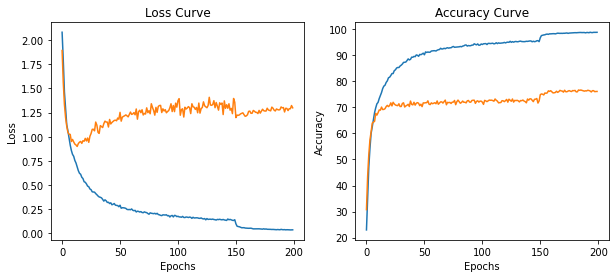

Final Training Accuracy: 98.79599998046875
Final Validation Accuracy: 76.09999987792969


In [9]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_RandomErasing)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_RandomErasing)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Alexnet/Alexnet_Random_Erasing"

for i, (input, target) in enumerate(trainloader):
  print(input.size())
  break

main("Alexnet",'alexnet','train', directory, 200)

In [ ]:
import random
p = 0.5
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                    download=True, transform=None)

s = trainset.targets

l_p = l[:int(len(l)*p)]
random.shuffle(l_p)

l[:int(len(l)*p)] = l_p

trainset.targets = l

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=None)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)


#Convergence

Files already downloaded and verified
Files already downloaded and verified
torch.Size([512, 3, 28, 28])
Logging into /content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Alexnet...


Number of parameters: 4230654


P: 0
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
000: Acc-tr:  25.14, Acc-val:  38.72, L-tr: 2.0310, L-val: 1.6625, Time: 11.303175


Epoch 0 Finished.  Time per Epoch:  12.58 s 


001: Acc-tr:  48.11, Acc-val:  55.10, L-tr: 1.4366, L-val: 1.2508, Time: 23.394960


Epoch 1 Finished.  Time per Epoch:  11.73 s 


002: Acc-tr:  60.23, Acc-val:  63.82, L-tr: 1.1312, L-val: 1.0493, Time: 34.306760


Epoch 2 Finished.  Time per Epoch:  11.46 s 


003: Acc-tr:  66.57, Acc-val:  66.74, L-tr: 0.9622, L-val: 0.9680, Time: 45.085522


Epoch 3 Finished.  Time per Epoch:  11.29 s 


004: Acc-tr:  71.43, Acc-val:  68.72, L-tr: 0.8255, L-val: 0.9258, Time: 56.048997


Epoch 4 Finished.  Time per Epoch:  11.22 s 


005: Acc-tr:  73.27, Acc-val:  70.70, L-tr: 0.7722, L-val: 0.8605, Time: 66.970661


Epoch 5 Finished.  Time per Epoch:  11.18 s 


006: Acc-tr:  75.78, Acc-val:  68.17, L-tr: 0.7000, L-val: 0.9708, Time: 77.638121


Epoch 6 Finished.  Time per Epoch:  11.10 s 


007: Acc-tr:  78.21, Acc-val:  72.01, L-tr: 0.6265, L-val: 0.8697, Time: 88.326915


Epoch 7 Finished.  Time per Epoch:  11.05 s 


008: Acc-tr:  80.12, Acc-val:  71.71, L-tr: 0.5686, L-val: 0.8622, Time: 99.002900


Epoch 8 Finished.  Time per Epoch:  11.01 s 


009: Acc-tr:  81.85, Acc-val:  74.32, L-tr: 0.5151, L-val: 0.8249, Time: 109.636392


Epoch 9 Finished.  Time per Epoch:  10.97 s 


010: Acc-tr:  83.80, Acc-val:  73.96, L-tr: 0.4609, L-val: 0.9006, Time: 120.306855


Epoch 10 Finished.  Time per Epoch:  10.94 s 


011: Acc-tr:  84.49, Acc-val:  73.42, L-tr: 0.4367, L-val: 0.9045, Time: 131.067932


Epoch 11 Finished.  Time per Epoch:  10.93 s 


012: Acc-tr:  86.20, Acc-val:  74.26, L-tr: 0.3906, L-val: 0.9276, Time: 141.904306


Epoch 12 Finished.  Time per Epoch:  10.92 s 


013: Acc-tr:  87.39, Acc-val:  73.31, L-tr: 0.3574, L-val: 1.0122, Time: 152.710894


Epoch 13 Finished.  Time per Epoch:  10.91 s 


014: Acc-tr:  87.90, Acc-val:  72.65, L-tr: 0.3435, L-val: 0.9850, Time: 163.649773


Epoch 14 Finished.  Time per Epoch:  10.91 s 


015: Acc-tr:  88.52, Acc-val:  72.89, L-tr: 0.3248, L-val: 1.0380, Time: 174.446537


Epoch 15 Finished.  Time per Epoch:  10.91 s 


016: Acc-tr:  89.53, Acc-val:  72.91, L-tr: 0.2957, L-val: 1.0646, Time: 185.313994


Epoch 16 Finished.  Time per Epoch:  10.90 s 


017: Acc-tr:  90.24, Acc-val:  73.36, L-tr: 0.2832, L-val: 1.1352, Time: 196.206484


Epoch 17 Finished.  Time per Epoch:  10.90 s 


018: Acc-tr:  91.58, Acc-val:  72.74, L-tr: 0.2417, L-val: 1.2314, Time: 207.041011


Epoch 18 Finished.  Time per Epoch:  10.90 s 


019: Acc-tr:  91.74, Acc-val:  72.06, L-tr: 0.2364, L-val: 1.2618, Time: 217.828833


Epoch 19 Finished.  Time per Epoch:  10.89 s 


020: Acc-tr:  92.07, Acc-val:  72.74, L-tr: 0.2342, L-val: 1.1491, Time: 228.683213


Epoch 20 Finished.  Time per Epoch:  10.89 s 


021: Acc-tr:  92.18, Acc-val:  72.33, L-tr: 0.2278, L-val: 1.2915, Time: 239.568224


Epoch 21 Finished.  Time per Epoch:  10.89 s 


022: Acc-tr:  93.03, Acc-val:  72.99, L-tr: 0.2060, L-val: 1.3655, Time: 250.218519


Epoch 22 Finished.  Time per Epoch:  10.88 s 


023: Acc-tr:  93.55, Acc-val:  73.03, L-tr: 0.1887, L-val: 1.3711, Time: 261.033124


Epoch 23 Finished.  Time per Epoch:  10.88 s 


024: Acc-tr:  93.47, Acc-val:  73.02, L-tr: 0.1923, L-val: 1.4214, Time: 271.749038


Epoch 24 Finished.  Time per Epoch:  10.87 s 


025: Acc-tr:  93.13, Acc-val:  72.07, L-tr: 0.2101, L-val: 1.3903, Time: 282.606987


Epoch 25 Finished.  Time per Epoch:  10.87 s 


026: Acc-tr:  93.60, Acc-val:  72.32, L-tr: 0.1936, L-val: 1.4318, Time: 293.380749


Epoch 26 Finished.  Time per Epoch:  10.87 s 


027: Acc-tr:  94.93, Acc-val:  72.70, L-tr: 0.1536, L-val: 1.5493, Time: 304.184527


Epoch 27 Finished.  Time per Epoch:  10.87 s 


028: Acc-tr:  95.01, Acc-val:  72.88, L-tr: 0.1568, L-val: 1.5500, Time: 314.978448


Epoch 28 Finished.  Time per Epoch:  10.86 s 


029: Acc-tr:  94.69, Acc-val:  73.64, L-tr: 0.1660, L-val: 1.4983, Time: 325.656000


Epoch 29 Finished.  Time per Epoch:  10.86 s 


030: Acc-tr:  95.51, Acc-val:  72.46, L-tr: 0.1371, L-val: 1.7511, Time: 336.434502


Epoch 30 Finished.  Time per Epoch:  10.85 s 


031: Acc-tr:  94.41, Acc-val:  72.89, L-tr: 0.1761, L-val: 1.5497, Time: 347.134307


Epoch 31 Finished.  Time per Epoch:  10.85 s 


032: Acc-tr:  95.29, Acc-val:  73.38, L-tr: 0.1464, L-val: 1.5099, Time: 357.849946


Epoch 32 Finished.  Time per Epoch:  10.85 s 


033: Acc-tr:  95.42, Acc-val:  71.79, L-tr: 0.1453, L-val: 1.6363, Time: 368.586480


Epoch 33 Finished.  Time per Epoch:  10.84 s 


034: Acc-tr:  95.64, Acc-val:  73.63, L-tr: 0.1348, L-val: 1.7532, Time: 379.416098


Epoch 34 Finished.  Time per Epoch:  10.84 s 


035: Acc-tr:  95.76, Acc-val:  72.49, L-tr: 0.1390, L-val: 1.7662, Time: 390.328471


Epoch 35 Finished.  Time per Epoch:  10.84 s 


036: Acc-tr:  96.18, Acc-val:  73.84, L-tr: 0.1214, L-val: 1.6432, Time: 401.069363


Epoch 36 Finished.  Time per Epoch:  10.84 s 


037: Acc-tr:  96.47, Acc-val:  73.24, L-tr: 0.1116, L-val: 1.7357, Time: 411.787259


Epoch 37 Finished.  Time per Epoch:  10.84 s 


038: Acc-tr:  96.39, Acc-val:  72.73, L-tr: 0.1122, L-val: 1.8922, Time: 422.674776


Epoch 38 Finished.  Time per Epoch:  10.84 s 


039: Acc-tr:  95.71, Acc-val:  72.71, L-tr: 0.1407, L-val: 1.7963, Time: 433.554474


Epoch 39 Finished.  Time per Epoch:  10.84 s 


040: Acc-tr:  96.43, Acc-val:  72.19, L-tr: 0.1191, L-val: 1.7724, Time: 444.379125


Epoch 40 Finished.  Time per Epoch:  10.84 s 


041: Acc-tr:  96.20, Acc-val:  72.95, L-tr: 0.1276, L-val: 1.8316, Time: 455.219826


Epoch 41 Finished.  Time per Epoch:  10.84 s 


042: Acc-tr:  95.98, Acc-val:  73.29, L-tr: 0.1314, L-val: 1.6946, Time: 466.213625


Epoch 42 Finished.  Time per Epoch:  10.84 s 


043: Acc-tr:  96.48, Acc-val:  72.23, L-tr: 0.1165, L-val: 1.8355, Time: 477.013419


Epoch 43 Finished.  Time per Epoch:  10.84 s 


044: Acc-tr:  96.17, Acc-val:  72.22, L-tr: 0.1304, L-val: 1.8839, Time: 487.821459


Epoch 44 Finished.  Time per Epoch:  10.84 s 


045: Acc-tr:  96.62, Acc-val:  73.49, L-tr: 0.1125, L-val: 1.8870, Time: 498.670675


Epoch 45 Finished.  Time per Epoch:  10.84 s 


046: Acc-tr:  97.32, Acc-val:  72.04, L-tr: 0.0910, L-val: 1.9806, Time: 509.390853


Epoch 46 Finished.  Time per Epoch:  10.84 s 


047: Acc-tr:  96.70, Acc-val:  72.15, L-tr: 0.1090, L-val: 2.0011, Time: 520.139841


Epoch 47 Finished.  Time per Epoch:  10.84 s 


048: Acc-tr:  96.68, Acc-val:  72.83, L-tr: 0.1130, L-val: 1.8579, Time: 531.049536


Epoch 48 Finished.  Time per Epoch:  10.84 s 


049: Acc-tr:  96.32, Acc-val:  73.00, L-tr: 0.1210, L-val: 1.7925, Time: 542.061270


Epoch 49 Finished.  Time per Epoch:  10.84 s 


050: Acc-tr:  97.42, Acc-val:  72.71, L-tr: 0.0863, L-val: 2.0569, Time: 552.899366


Epoch 50 Finished.  Time per Epoch:  10.84 s 


051: Acc-tr:  96.99, Acc-val:  72.91, L-tr: 0.1013, L-val: 1.8904, Time: 563.812556


Epoch 51 Finished.  Time per Epoch:  10.84 s 


052: Acc-tr:  97.63, Acc-val:  73.13, L-tr: 0.0794, L-val: 2.1012, Time: 574.639910


Epoch 52 Finished.  Time per Epoch:  10.84 s 


053: Acc-tr:  96.97, Acc-val:  73.03, L-tr: 0.1047, L-val: 1.9700, Time: 585.498616


Epoch 53 Finished.  Time per Epoch:  10.84 s 


054: Acc-tr:  97.61, Acc-val:  73.45, L-tr: 0.0819, L-val: 1.9272, Time: 596.427581


Epoch 54 Finished.  Time per Epoch:  10.85 s 


055: Acc-tr:  97.47, Acc-val:  72.83, L-tr: 0.0865, L-val: 2.1288, Time: 607.261337


Epoch 55 Finished.  Time per Epoch:  10.85 s 


056: Acc-tr:  97.14, Acc-val:  72.07, L-tr: 0.0981, L-val: 1.9075, Time: 618.168439


Epoch 56 Finished.  Time per Epoch:  10.85 s 


057: Acc-tr:  96.81, Acc-val:  73.06, L-tr: 0.1074, L-val: 1.9961, Time: 629.155247


Epoch 57 Finished.  Time per Epoch:  10.85 s 


058: Acc-tr:  97.47, Acc-val:  73.14, L-tr: 0.0867, L-val: 1.9812, Time: 639.977840


Epoch 58 Finished.  Time per Epoch:  10.85 s 


059: Acc-tr:  97.56, Acc-val:  72.78, L-tr: 0.0830, L-val: 2.0097, Time: 650.629374


Epoch 59 Finished.  Time per Epoch:  10.84 s 


060: Acc-tr:  97.53, Acc-val:  72.76, L-tr: 0.0838, L-val: 2.0449, Time: 661.527191


Epoch 60 Finished.  Time per Epoch:  10.85 s 


061: Acc-tr:  97.22, Acc-val:  73.80, L-tr: 0.0938, L-val: 1.9251, Time: 672.322717


Epoch 61 Finished.  Time per Epoch:  10.85 s 


062: Acc-tr:  97.79, Acc-val:  73.81, L-tr: 0.0741, L-val: 2.0237, Time: 683.100125


Epoch 62 Finished.  Time per Epoch:  10.84 s 


063: Acc-tr:  97.85, Acc-val:  73.44, L-tr: 0.0775, L-val: 1.9313, Time: 693.837474


Epoch 63 Finished.  Time per Epoch:  10.84 s 


064: Acc-tr:  97.90, Acc-val:  73.12, L-tr: 0.0707, L-val: 1.9982, Time: 704.734087


Epoch 64 Finished.  Time per Epoch:  10.84 s 


065: Acc-tr:  98.42, Acc-val:  73.61, L-tr: 0.0561, L-val: 2.0993, Time: 715.623446


Epoch 65 Finished.  Time per Epoch:  10.84 s 


066: Acc-tr:  98.47, Acc-val:  73.57, L-tr: 0.0523, L-val: 2.1323, Time: 726.623132


Epoch 66 Finished.  Time per Epoch:  10.85 s 


067: Acc-tr:  98.15, Acc-val:  72.94, L-tr: 0.0674, L-val: 2.0658, Time: 737.373982


Epoch 67 Finished.  Time per Epoch:  10.84 s 


068: Acc-tr:  97.77, Acc-val:  72.04, L-tr: 0.0805, L-val: 1.9329, Time: 748.127122


Epoch 68 Finished.  Time per Epoch:  10.84 s 


069: Acc-tr:  98.20, Acc-val:  73.12, L-tr: 0.0613, L-val: 2.0960, Time: 758.989434


Epoch 69 Finished.  Time per Epoch:  10.84 s 


070: Acc-tr:  97.91, Acc-val:  73.71, L-tr: 0.0716, L-val: 2.0114, Time: 769.823155


Epoch 70 Finished.  Time per Epoch:  10.84 s 


071: Acc-tr:  98.17, Acc-val:  73.42, L-tr: 0.0644, L-val: 2.0105, Time: 780.947031


Epoch 71 Finished.  Time per Epoch:  10.85 s 


072: Acc-tr:  97.94, Acc-val:  72.67, L-tr: 0.0722, L-val: 2.1010, Time: 792.104210


Epoch 72 Finished.  Time per Epoch:  10.85 s 


073: Acc-tr:  97.59, Acc-val:  73.61, L-tr: 0.0804, L-val: 1.8764, Time: 803.074567


Epoch 73 Finished.  Time per Epoch:  10.85 s 


074: Acc-tr:  98.20, Acc-val:  72.61, L-tr: 0.0631, L-val: 2.0738, Time: 813.990363


Epoch 74 Finished.  Time per Epoch:  10.85 s 


075: Acc-tr:  97.97, Acc-val:  73.25, L-tr: 0.0728, L-val: 2.0110, Time: 824.817628


Epoch 75 Finished.  Time per Epoch:  10.85 s 


076: Acc-tr:  98.32, Acc-val:  74.33, L-tr: 0.0568, L-val: 2.0204, Time: 835.874360


Epoch 76 Finished.  Time per Epoch:  10.86 s 


077: Acc-tr:  98.63, Acc-val:  73.45, L-tr: 0.0490, L-val: 2.1450, Time: 846.812063


Epoch 77 Finished.  Time per Epoch:  10.86 s 


078: Acc-tr:  98.19, Acc-val:  73.14, L-tr: 0.0617, L-val: 2.1105, Time: 857.695023


Epoch 78 Finished.  Time per Epoch:  10.86 s 


079: Acc-tr:  98.20, Acc-val:  72.46, L-tr: 0.0587, L-val: 2.1538, Time: 868.625553


Epoch 79 Finished.  Time per Epoch:  10.86 s 


080: Acc-tr:  98.10, Acc-val:  72.87, L-tr: 0.0655, L-val: 2.2756, Time: 879.666538


Epoch 80 Finished.  Time per Epoch:  10.86 s 


081: Acc-tr:  98.26, Acc-val:  72.11, L-tr: 0.0631, L-val: 2.1922, Time: 890.610263


Epoch 81 Finished.  Time per Epoch:  10.86 s 


082: Acc-tr:  97.76, Acc-val:  72.62, L-tr: 0.0805, L-val: 1.8981, Time: 901.514128


Epoch 82 Finished.  Time per Epoch:  10.86 s 


083: Acc-tr:  98.28, Acc-val:  73.67, L-tr: 0.0576, L-val: 1.9852, Time: 912.339560


Epoch 83 Finished.  Time per Epoch:  10.86 s 


084: Acc-tr:  98.50, Acc-val:  73.13, L-tr: 0.0511, L-val: 2.1704, Time: 923.167466


Epoch 84 Finished.  Time per Epoch:  10.86 s 


085: Acc-tr:  98.76, Acc-val:  74.13, L-tr: 0.0419, L-val: 2.2557, Time: 934.158442


Epoch 85 Finished.  Time per Epoch:  10.86 s 


086: Acc-tr:  98.07, Acc-val:  73.05, L-tr: 0.0694, L-val: 2.1440, Time: 945.103710


Epoch 86 Finished.  Time per Epoch:  10.86 s 


087: Acc-tr:  98.34, Acc-val:  74.10, L-tr: 0.0575, L-val: 2.0239, Time: 956.113965


Epoch 87 Finished.  Time per Epoch:  10.87 s 


088: Acc-tr:  98.25, Acc-val:  72.76, L-tr: 0.0620, L-val: 2.1518, Time: 967.270693


Epoch 88 Finished.  Time per Epoch:  10.87 s 


089: Acc-tr:  98.21, Acc-val:  73.08, L-tr: 0.0656, L-val: 2.1118, Time: 978.204353


Epoch 89 Finished.  Time per Epoch:  10.87 s 


090: Acc-tr:  98.91, Acc-val:  73.45, L-tr: 0.0389, L-val: 2.1367, Time: 989.301965


Epoch 90 Finished.  Time per Epoch:  10.87 s 


091: Acc-tr:  98.84, Acc-val:  73.06, L-tr: 0.0399, L-val: 2.3096, Time: 1000.400462


Epoch 91 Finished.  Time per Epoch:  10.87 s 


092: Acc-tr:  98.25, Acc-val:  73.41, L-tr: 0.0599, L-val: 2.0785, Time: 1011.230854


Epoch 92 Finished.  Time per Epoch:  10.87 s 


093: Acc-tr:  98.72, Acc-val:  73.11, L-tr: 0.0448, L-val: 2.2680, Time: 1022.013699


Epoch 93 Finished.  Time per Epoch:  10.87 s 


094: Acc-tr:  98.66, Acc-val:  73.41, L-tr: 0.0472, L-val: 2.1046, Time: 1032.951332


Epoch 94 Finished.  Time per Epoch:  10.87 s 


095: Acc-tr:  98.51, Acc-val:  73.28, L-tr: 0.0511, L-val: 2.2151, Time: 1043.813362


Epoch 95 Finished.  Time per Epoch:  10.87 s 


096: Acc-tr:  98.27, Acc-val:  73.76, L-tr: 0.0614, L-val: 2.1111, Time: 1054.631208


Epoch 96 Finished.  Time per Epoch:  10.87 s 


097: Acc-tr:  98.74, Acc-val:  72.95, L-tr: 0.0421, L-val: 2.1586, Time: 1065.393847


Epoch 97 Finished.  Time per Epoch:  10.87 s 


098: Acc-tr:  98.62, Acc-val:  73.48, L-tr: 0.0469, L-val: 2.0993, Time: 1076.160954


Epoch 98 Finished.  Time per Epoch:  10.87 s 


099: Acc-tr:  98.91, Acc-val:  73.26, L-tr: 0.0378, L-val: 2.1603, Time: 1087.254933


Epoch 99 Finished.  Time per Epoch:  10.87 s 


100: Acc-tr:  98.44, Acc-val:  73.31, L-tr: 0.0539, L-val: 2.1661, Time: 1098.377078


Epoch 100 Finished.  Time per Epoch:  10.88 s 


101: Acc-tr:  98.53, Acc-val:  73.56, L-tr: 0.0495, L-val: 2.1210, Time: 1109.135429


Epoch 101 Finished.  Time per Epoch:  10.87 s 


102: Acc-tr:  98.49, Acc-val:  73.99, L-tr: 0.0534, L-val: 2.0116, Time: 1120.074701


Epoch 102 Finished.  Time per Epoch:  10.88 s 


103: Acc-tr:  99.18, Acc-val:  73.97, L-tr: 0.0281, L-val: 2.1478, Time: 1131.013714


Epoch 103 Finished.  Time per Epoch:  10.88 s 


104: Acc-tr:  98.51, Acc-val:  73.49, L-tr: 0.0543, L-val: 2.0059, Time: 1141.893879


Epoch 104 Finished.  Time per Epoch:  10.88 s 


105: Acc-tr:  98.81, Acc-val:  73.64, L-tr: 0.0377, L-val: 2.1251, Time: 1152.697049


Epoch 105 Finished.  Time per Epoch:  10.88 s 


106: Acc-tr:  98.85, Acc-val:  73.99, L-tr: 0.0384, L-val: 2.0042, Time: 1163.600750


Epoch 106 Finished.  Time per Epoch:  10.88 s 


107: Acc-tr:  98.85, Acc-val:  74.29, L-tr: 0.0412, L-val: 2.0624, Time: 1174.391916


Epoch 107 Finished.  Time per Epoch:  10.87 s 


108: Acc-tr:  98.79, Acc-val:  73.50, L-tr: 0.0415, L-val: 2.2003, Time: 1185.190179


Epoch 108 Finished.  Time per Epoch:  10.87 s 


109: Acc-tr:  98.59, Acc-val:  74.23, L-tr: 0.0491, L-val: 1.9803, Time: 1196.145066


Epoch 109 Finished.  Time per Epoch:  10.87 s 


110: Acc-tr:  99.13, Acc-val:  73.74, L-tr: 0.0294, L-val: 2.0460, Time: 1207.115999


Epoch 110 Finished.  Time per Epoch:  10.88 s 


111: Acc-tr:  99.54, Acc-val:  74.86, L-tr: 0.0148, L-val: 2.2741, Time: 1217.851095


Epoch 111 Finished.  Time per Epoch:  10.87 s 


112: Acc-tr:  99.39, Acc-val:  73.87, L-tr: 0.0198, L-val: 2.1720, Time: 1228.744586


Epoch 112 Finished.  Time per Epoch:  10.87 s 


113: Acc-tr:  99.24, Acc-val:  73.34, L-tr: 0.0248, L-val: 2.4534, Time: 1239.590555


Epoch 113 Finished.  Time per Epoch:  10.87 s 


114: Acc-tr:  98.84, Acc-val:  73.84, L-tr: 0.0393, L-val: 2.1074, Time: 1250.405060


Epoch 114 Finished.  Time per Epoch:  10.87 s 


115: Acc-tr:  99.19, Acc-val:  73.89, L-tr: 0.0259, L-val: 2.0715, Time: 1261.462039


Epoch 115 Finished.  Time per Epoch:  10.88 s 


116: Acc-tr:  99.07, Acc-val:  73.89, L-tr: 0.0335, L-val: 2.0609, Time: 1272.327940


Epoch 116 Finished.  Time per Epoch:  10.88 s 


117: Acc-tr:  98.80, Acc-val:  73.61, L-tr: 0.0442, L-val: 2.1054, Time: 1283.345549


Epoch 117 Finished.  Time per Epoch:  10.88 s 


118: Acc-tr:  99.03, Acc-val:  73.19, L-tr: 0.0348, L-val: 2.0953, Time: 1294.322099


Epoch 118 Finished.  Time per Epoch:  10.88 s 


119: Acc-tr:  99.18, Acc-val:  73.74, L-tr: 0.0264, L-val: 2.1847, Time: 1305.971549


Epoch 119 Finished.  Time per Epoch:  10.88 s 


120: Acc-tr:  99.04, Acc-val:  74.25, L-tr: 0.0324, L-val: 2.0118, Time: 1317.203470


Epoch 120 Finished.  Time per Epoch:  10.89 s 


121: Acc-tr:  99.20, Acc-val:  73.93, L-tr: 0.0266, L-val: 2.1231, Time: 1329.297968


Epoch 121 Finished.  Time per Epoch:  10.90 s 


122: Acc-tr:  99.32, Acc-val:  74.44, L-tr: 0.0226, L-val: 2.0692, Time: 1341.370629


Epoch 122 Finished.  Time per Epoch:  10.91 s 


123: Acc-tr:  98.82, Acc-val:  73.11, L-tr: 0.0405, L-val: 1.9713, Time: 1353.232507


Epoch 123 Finished.  Time per Epoch:  10.91 s 


124: Acc-tr:  99.04, Acc-val:  73.48, L-tr: 0.0322, L-val: 1.9704, Time: 1365.424069


Epoch 124 Finished.  Time per Epoch:  10.92 s 


125: Acc-tr:  99.03, Acc-val:  74.31, L-tr: 0.0305, L-val: 1.9229, Time: 1377.295090


Epoch 125 Finished.  Time per Epoch:  10.93 s 


126: Acc-tr:  99.07, Acc-val:  74.19, L-tr: 0.0324, L-val: 1.9421, Time: 1389.103397


Epoch 126 Finished.  Time per Epoch:  10.94 s 


127: Acc-tr:  99.22, Acc-val:  74.36, L-tr: 0.0276, L-val: 2.0765, Time: 1401.028389


Epoch 127 Finished.  Time per Epoch:  10.95 s 


128: Acc-tr:  99.26, Acc-val:  74.57, L-tr: 0.0239, L-val: 2.1193, Time: 1412.825548


Epoch 128 Finished.  Time per Epoch:  10.95 s 


129: Acc-tr:  99.13, Acc-val:  73.98, L-tr: 0.0283, L-val: 2.0243, Time: 1424.398381


Epoch 129 Finished.  Time per Epoch:  10.96 s 


130: Acc-tr:  98.99, Acc-val:  74.09, L-tr: 0.0339, L-val: 2.0938, Time: 1436.412286


Epoch 130 Finished.  Time per Epoch:  10.97 s 


131: Acc-tr:  98.92, Acc-val:  74.23, L-tr: 0.0359, L-val: 2.0270, Time: 1448.182432


Epoch 131 Finished.  Time per Epoch:  10.97 s 


132: Acc-tr:  99.06, Acc-val:  73.96, L-tr: 0.0305, L-val: 1.9821, Time: 1459.374273


Epoch 132 Finished.  Time per Epoch:  10.97 s 


133: Acc-tr:  99.29, Acc-val:  73.62, L-tr: 0.0253, L-val: 2.0730, Time: 1470.764262


Epoch 133 Finished.  Time per Epoch:  10.98 s 


134: Acc-tr:  99.26, Acc-val:  74.45, L-tr: 0.0230, L-val: 2.0276, Time: 1482.139537


Epoch 134 Finished.  Time per Epoch:  10.98 s 


135: Acc-tr:  99.33, Acc-val:  74.05, L-tr: 0.0220, L-val: 2.0191, Time: 1493.708358


Epoch 135 Finished.  Time per Epoch:  10.98 s 


136: Acc-tr:  99.22, Acc-val:  73.95, L-tr: 0.0271, L-val: 1.9624, Time: 1504.868720


Epoch 136 Finished.  Time per Epoch:  10.98 s 


137: Acc-tr:  99.22, Acc-val:  74.24, L-tr: 0.0255, L-val: 2.0633, Time: 1515.859542


Epoch 137 Finished.  Time per Epoch:  10.98 s 


138: Acc-tr:  99.13, Acc-val:  73.33, L-tr: 0.0273, L-val: 2.0473, Time: 1527.027705


Epoch 138 Finished.  Time per Epoch:  10.99 s 


139: Acc-tr:  99.42, Acc-val:  73.41, L-tr: 0.0199, L-val: 2.0848, Time: 1538.157576


Epoch 139 Finished.  Time per Epoch:  10.99 s 


140: Acc-tr:  98.95, Acc-val:  74.39, L-tr: 0.0347, L-val: 2.0400, Time: 1549.266330


Epoch 140 Finished.  Time per Epoch:  10.99 s 


141: Acc-tr:  98.82, Acc-val:  73.09, L-tr: 0.0413, L-val: 1.9642, Time: 1560.212286


Epoch 141 Finished.  Time per Epoch:  10.99 s 


142: Acc-tr:  98.78, Acc-val:  73.96, L-tr: 0.0402, L-val: 1.8288, Time: 1570.988241


Epoch 142 Finished.  Time per Epoch:  10.99 s 


143: Acc-tr:  99.42, Acc-val:  74.91, L-tr: 0.0167, L-val: 1.9121, Time: 1581.828102


Epoch 143 Finished.  Time per Epoch:  10.99 s 


144: Acc-tr:  99.39, Acc-val:  74.31, L-tr: 0.0203, L-val: 1.8827, Time: 1592.708514


Epoch 144 Finished.  Time per Epoch:  10.98 s 


145: Acc-tr:  99.21, Acc-val:  74.09, L-tr: 0.0272, L-val: 1.8644, Time: 1603.538791


Epoch 145 Finished.  Time per Epoch:  10.98 s 


146: Acc-tr:  99.13, Acc-val:  73.48, L-tr: 0.0300, L-val: 1.9648, Time: 1614.384207


Epoch 146 Finished.  Time per Epoch:  10.98 s 


147: Acc-tr:  98.97, Acc-val:  74.05, L-tr: 0.0347, L-val: 1.9036, Time: 1625.434974


Epoch 147 Finished.  Time per Epoch:  10.98 s 


148: Acc-tr:  99.57, Acc-val:  74.14, L-tr: 0.0144, L-val: 1.8923, Time: 1636.389279


Epoch 148 Finished.  Time per Epoch:  10.98 s 


149: Acc-tr:  99.52, Acc-val:  74.99, L-tr: 0.0159, L-val: 1.9417, Time: 1647.193896


Epoch 149 Finished.  Time per Epoch:  10.98 s 


150: Acc-tr:  99.87, Acc-val:  75.42, L-tr: 0.0041, L-val: 1.8719, Time: 1658.097877


Epoch 150 Finished.  Time per Epoch:  10.98 s 


151: Acc-tr: 100.00, Acc-val:  75.61, L-tr: 0.0007, L-val: 1.8782, Time: 1669.018415


Epoch 151 Finished.  Time per Epoch:  10.98 s 


152: Acc-tr: 100.00, Acc-val:  75.61, L-tr: 0.0005, L-val: 1.8803, Time: 1679.936530


Epoch 152 Finished.  Time per Epoch:  10.98 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 75.61000006103515
P: 0.1
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  82.15, Acc-val:  71.00, L-tr: 0.9760, L-val: 1.0113, Time: 11.060157


Epoch 0 Finished.  Time per Epoch:  11.13 s 


001: Acc-tr:  89.81, Acc-val:  70.80, L-tr: 0.5616, L-val: 1.0293, Time: 22.164029


Epoch 1 Finished.  Time per Epoch:  11.12 s 


002: Acc-tr:  90.96, Acc-val:  71.10, L-tr: 0.4214, L-val: 1.1151, Time: 33.367741


Epoch 2 Finished.  Time per Epoch:  11.15 s 


003: Acc-tr:  91.99, Acc-val:  69.49, L-tr: 0.3189, L-val: 1.2782, Time: 44.378469


Epoch 3 Finished.  Time per Epoch:  11.11 s 


004: Acc-tr:  93.05, Acc-val:  68.51, L-tr: 0.2484, L-val: 1.4679, Time: 55.203218


Epoch 4 Finished.  Time per Epoch:  11.05 s 


005: Acc-tr:  93.95, Acc-val:  67.33, L-tr: 0.2004, L-val: 1.5634, Time: 65.993576


Epoch 5 Finished.  Time per Epoch:  11.01 s 


006: Acc-tr:  94.37, Acc-val:  66.97, L-tr: 0.1872, L-val: 1.7000, Time: 77.073978


Epoch 6 Finished.  Time per Epoch:  11.02 s 


007: Acc-tr:  94.30, Acc-val:  66.49, L-tr: 0.1814, L-val: 1.7406, Time: 87.883273


Epoch 7 Finished.  Time per Epoch:  10.99 s 


008: Acc-tr:  93.16, Acc-val:  65.96, L-tr: 0.2280, L-val: 1.7678, Time: 98.672061


Epoch 8 Finished.  Time per Epoch:  10.97 s 


009: Acc-tr:  92.95, Acc-val:  67.05, L-tr: 0.2316, L-val: 1.7517, Time: 109.521602


Epoch 9 Finished.  Time per Epoch:  10.96 s 


010: Acc-tr:  93.39, Acc-val:  65.29, L-tr: 0.2148, L-val: 1.8164, Time: 120.348595


Epoch 10 Finished.  Time per Epoch:  10.95 s 


011: Acc-tr:  93.82, Acc-val:  66.78, L-tr: 0.2023, L-val: 1.8149, Time: 131.100122


Epoch 11 Finished.  Time per Epoch:  10.93 s 


012: Acc-tr:  94.45, Acc-val:  65.92, L-tr: 0.1765, L-val: 1.8852, Time: 141.990121


Epoch 12 Finished.  Time per Epoch:  10.93 s 


013: Acc-tr:  94.24, Acc-val:  66.96, L-tr: 0.1886, L-val: 1.9626, Time: 152.674386


Epoch 13 Finished.  Time per Epoch:  10.91 s 


014: Acc-tr:  94.46, Acc-val:  66.51, L-tr: 0.1800, L-val: 1.8681, Time: 163.679546


Epoch 14 Finished.  Time per Epoch:  10.92 s 


015: Acc-tr:  93.75, Acc-val:  65.98, L-tr: 0.2077, L-val: 1.6811, Time: 174.506091


Epoch 15 Finished.  Time per Epoch:  10.91 s 


016: Acc-tr:  94.68, Acc-val:  66.41, L-tr: 0.1708, L-val: 2.0164, Time: 185.437402


Epoch 16 Finished.  Time per Epoch:  10.91 s 


017: Acc-tr:  95.28, Acc-val:  66.68, L-tr: 0.1569, L-val: 2.0002, Time: 196.349046


Epoch 17 Finished.  Time per Epoch:  10.91 s 


018: Acc-tr:  95.42, Acc-val:  66.50, L-tr: 0.1490, L-val: 2.1285, Time: 207.302744


Epoch 18 Finished.  Time per Epoch:  10.91 s 


019: Acc-tr:  95.83, Acc-val:  67.41, L-tr: 0.1364, L-val: 2.1410, Time: 218.201113


Epoch 19 Finished.  Time per Epoch:  10.91 s 


020: Acc-tr:  95.34, Acc-val:  67.18, L-tr: 0.1566, L-val: 2.1094, Time: 228.985662


Epoch 20 Finished.  Time per Epoch:  10.91 s 


021: Acc-tr:  94.90, Acc-val:  66.70, L-tr: 0.1686, L-val: 2.1121, Time: 240.104079


Epoch 21 Finished.  Time per Epoch:  10.92 s 


022: Acc-tr:  95.81, Acc-val:  66.52, L-tr: 0.1416, L-val: 2.1465, Time: 251.087956


Epoch 22 Finished.  Time per Epoch:  10.92 s 


023: Acc-tr:  95.59, Acc-val:  65.73, L-tr: 0.1467, L-val: 2.0791, Time: 261.886768


Epoch 23 Finished.  Time per Epoch:  10.91 s 


024: Acc-tr:  95.85, Acc-val:  66.17, L-tr: 0.1424, L-val: 2.1449, Time: 272.796698


Epoch 24 Finished.  Time per Epoch:  10.91 s 


025: Acc-tr:  95.80, Acc-val:  65.69, L-tr: 0.1389, L-val: 2.1970, Time: 283.561039


Epoch 25 Finished.  Time per Epoch:  10.91 s 


026: Acc-tr:  96.38, Acc-val:  67.00, L-tr: 0.1195, L-val: 2.1427, Time: 294.498243


Epoch 26 Finished.  Time per Epoch:  10.91 s 


027: Acc-tr:  97.05, Acc-val:  67.58, L-tr: 0.0960, L-val: 2.2277, Time: 305.580036


Epoch 27 Finished.  Time per Epoch:  10.92 s 


028: Acc-tr:  96.01, Acc-val:  65.62, L-tr: 0.1353, L-val: 2.1768, Time: 316.496925


Epoch 28 Finished.  Time per Epoch:  10.92 s 


029: Acc-tr:  96.36, Acc-val:  65.97, L-tr: 0.1251, L-val: 2.1940, Time: 327.458424


Epoch 29 Finished.  Time per Epoch:  10.92 s 


030: Acc-tr:  96.53, Acc-val:  66.11, L-tr: 0.1181, L-val: 2.3245, Time: 338.492125


Epoch 30 Finished.  Time per Epoch:  10.92 s 


031: Acc-tr:  96.12, Acc-val:  66.69, L-tr: 0.1326, L-val: 2.2791, Time: 349.475124


Epoch 31 Finished.  Time per Epoch:  10.92 s 


032: Acc-tr:  96.33, Acc-val:  65.78, L-tr: 0.1234, L-val: 2.3557, Time: 360.510841


Epoch 32 Finished.  Time per Epoch:  10.93 s 


033: Acc-tr:  96.22, Acc-val:  67.15, L-tr: 0.1271, L-val: 2.3533, Time: 371.468216


Epoch 33 Finished.  Time per Epoch:  10.93 s 


034: Acc-tr:  96.32, Acc-val:  66.47, L-tr: 0.1247, L-val: 2.2816, Time: 382.535119


Epoch 34 Finished.  Time per Epoch:  10.93 s 


035: Acc-tr:  96.30, Acc-val:  67.21, L-tr: 0.1243, L-val: 2.3137, Time: 393.488080


Epoch 35 Finished.  Time per Epoch:  10.93 s 


036: Acc-tr:  96.45, Acc-val:  65.46, L-tr: 0.1187, L-val: 2.3073, Time: 404.557162


Epoch 36 Finished.  Time per Epoch:  10.94 s 


037: Acc-tr:  96.05, Acc-val:  66.81, L-tr: 0.1407, L-val: 2.2400, Time: 415.590167


Epoch 37 Finished.  Time per Epoch:  10.94 s 


038: Acc-tr:  96.73, Acc-val:  66.52, L-tr: 0.1120, L-val: 2.2156, Time: 426.632432


Epoch 38 Finished.  Time per Epoch:  10.94 s 


039: Acc-tr:  97.44, Acc-val:  66.05, L-tr: 0.0859, L-val: 2.3215, Time: 437.579690


Epoch 39 Finished.  Time per Epoch:  10.94 s 


040: Acc-tr:  97.49, Acc-val:  65.71, L-tr: 0.0838, L-val: 2.5577, Time: 448.587008


Epoch 40 Finished.  Time per Epoch:  10.94 s 


041: Acc-tr:  96.86, Acc-val:  65.82, L-tr: 0.1096, L-val: 2.5201, Time: 459.513298


Epoch 41 Finished.  Time per Epoch:  10.94 s 


042: Acc-tr:  96.92, Acc-val:  66.27, L-tr: 0.1027, L-val: 2.3547, Time: 470.591083


Epoch 42 Finished.  Time per Epoch:  10.95 s 


043: Acc-tr:  97.13, Acc-val:  66.68, L-tr: 0.1015, L-val: 2.4999, Time: 481.586433


Epoch 43 Finished.  Time per Epoch:  10.95 s 


044: Acc-tr:  96.53, Acc-val:  66.30, L-tr: 0.1192, L-val: 2.4310, Time: 492.811421


Epoch 44 Finished.  Time per Epoch:  10.95 s 


045: Acc-tr:  96.57, Acc-val:  65.77, L-tr: 0.1169, L-val: 2.3847, Time: 503.921566


Epoch 45 Finished.  Time per Epoch:  10.96 s 


046: Acc-tr:  97.29, Acc-val:  66.95, L-tr: 0.0931, L-val: 2.3739, Time: 514.862846


Epoch 46 Finished.  Time per Epoch:  10.96 s 


047: Acc-tr:  97.85, Acc-val:  67.29, L-tr: 0.0746, L-val: 2.5837, Time: 525.924005


Epoch 47 Finished.  Time per Epoch:  10.96 s 


048: Acc-tr:  97.77, Acc-val:  66.37, L-tr: 0.0767, L-val: 2.5055, Time: 537.134555


Epoch 48 Finished.  Time per Epoch:  10.96 s 


049: Acc-tr:  97.20, Acc-val:  66.15, L-tr: 0.0952, L-val: 2.5308, Time: 548.329897


Epoch 49 Finished.  Time per Epoch:  10.97 s 


050: Acc-tr:  97.06, Acc-val:  66.09, L-tr: 0.0965, L-val: 2.5190, Time: 559.743930


Epoch 50 Finished.  Time per Epoch:  10.98 s 


051: Acc-tr:  97.23, Acc-val:  66.86, L-tr: 0.0932, L-val: 2.4398, Time: 570.950738


Epoch 51 Finished.  Time per Epoch:  10.98 s 


052: Acc-tr:  97.26, Acc-val:  66.51, L-tr: 0.0945, L-val: 2.2450, Time: 582.720739


Epoch 52 Finished.  Time per Epoch:  11.00 s 


053: Acc-tr:  97.95, Acc-val:  66.86, L-tr: 0.0731, L-val: 2.4437, Time: 594.078560


Epoch 53 Finished.  Time per Epoch:  11.00 s 


054: Acc-tr:  97.73, Acc-val:  67.34, L-tr: 0.0762, L-val: 2.5785, Time: 605.922122


Epoch 54 Finished.  Time per Epoch:  11.02 s 


055: Acc-tr:  97.25, Acc-val:  65.93, L-tr: 0.0962, L-val: 2.4321, Time: 617.663543


Epoch 55 Finished.  Time per Epoch:  11.03 s 


056: Acc-tr:  97.61, Acc-val:  65.80, L-tr: 0.0821, L-val: 2.5599, Time: 628.917491


Epoch 56 Finished.  Time per Epoch:  11.03 s 


057: Acc-tr:  97.39, Acc-val:  66.09, L-tr: 0.0890, L-val: 2.5802, Time: 640.166301


Epoch 57 Finished.  Time per Epoch:  11.04 s 


058: Acc-tr:  96.73, Acc-val:  66.33, L-tr: 0.1135, L-val: 2.4266, Time: 651.416490


Epoch 58 Finished.  Time per Epoch:  11.04 s 


059: Acc-tr:  97.27, Acc-val:  66.70, L-tr: 0.0989, L-val: 2.3895, Time: 662.721698


Epoch 59 Finished.  Time per Epoch:  11.05 s 


060: Acc-tr:  97.90, Acc-val:  66.54, L-tr: 0.0697, L-val: 2.5301, Time: 673.969018


Epoch 60 Finished.  Time per Epoch:  11.05 s 


061: Acc-tr:  98.29, Acc-val:  66.86, L-tr: 0.0593, L-val: 2.5939, Time: 685.348508


Epoch 61 Finished.  Time per Epoch:  11.06 s 


062: Acc-tr:  98.07, Acc-val:  67.15, L-tr: 0.0660, L-val: 2.5130, Time: 696.791823


Epoch 62 Finished.  Time per Epoch:  11.06 s 


063: Acc-tr:  97.52, Acc-val:  66.83, L-tr: 0.0859, L-val: 2.5529, Time: 708.210134


Epoch 63 Finished.  Time per Epoch:  11.07 s 


064: Acc-tr:  97.78, Acc-val:  65.82, L-tr: 0.0779, L-val: 2.4749, Time: 719.403498


Epoch 64 Finished.  Time per Epoch:  11.07 s 


065: Acc-tr:  97.73, Acc-val:  66.42, L-tr: 0.0770, L-val: 2.4441, Time: 730.648106


Epoch 65 Finished.  Time per Epoch:  11.07 s 


066: Acc-tr:  98.15, Acc-val:  65.92, L-tr: 0.0637, L-val: 2.5824, Time: 741.806709


Epoch 66 Finished.  Time per Epoch:  11.07 s 


067: Acc-tr:  98.05, Acc-val:  66.77, L-tr: 0.0683, L-val: 2.4209, Time: 752.806526


Epoch 67 Finished.  Time per Epoch:  11.07 s 


068: Acc-tr:  98.45, Acc-val:  66.68, L-tr: 0.0548, L-val: 2.4962, Time: 763.888570


Epoch 68 Finished.  Time per Epoch:  11.07 s 


069: Acc-tr:  98.15, Acc-val:  66.26, L-tr: 0.0628, L-val: 2.5381, Time: 775.085134


Epoch 69 Finished.  Time per Epoch:  11.07 s 


070: Acc-tr:  98.03, Acc-val:  66.60, L-tr: 0.0682, L-val: 2.4491, Time: 786.085121


Epoch 70 Finished.  Time per Epoch:  11.07 s 


071: Acc-tr:  97.65, Acc-val:  66.23, L-tr: 0.0827, L-val: 2.5126, Time: 797.114514


Epoch 71 Finished.  Time per Epoch:  11.07 s 


072: Acc-tr:  98.05, Acc-val:  66.70, L-tr: 0.0679, L-val: 2.3824, Time: 808.210474


Epoch 72 Finished.  Time per Epoch:  11.07 s 


073: Acc-tr:  98.46, Acc-val:  66.49, L-tr: 0.0515, L-val: 2.5220, Time: 819.295472


Epoch 73 Finished.  Time per Epoch:  11.07 s 


074: Acc-tr:  98.61, Acc-val:  66.82, L-tr: 0.0484, L-val: 2.6048, Time: 830.329196


Epoch 74 Finished.  Time per Epoch:  11.07 s 


075: Acc-tr:  98.58, Acc-val:  67.47, L-tr: 0.0475, L-val: 2.5249, Time: 841.379438


Epoch 75 Finished.  Time per Epoch:  11.07 s 


076: Acc-tr:  97.98, Acc-val:  66.12, L-tr: 0.0719, L-val: 2.5963, Time: 852.344058


Epoch 76 Finished.  Time per Epoch:  11.07 s 


077: Acc-tr:  97.81, Acc-val:  65.90, L-tr: 0.0784, L-val: 2.6009, Time: 863.474011


Epoch 77 Finished.  Time per Epoch:  11.07 s 


078: Acc-tr:  97.91, Acc-val:  66.93, L-tr: 0.0711, L-val: 2.4566, Time: 874.505459


Epoch 78 Finished.  Time per Epoch:  11.07 s 


079: Acc-tr:  98.32, Acc-val:  66.73, L-tr: 0.0568, L-val: 2.5233, Time: 885.480238


Epoch 79 Finished.  Time per Epoch:  11.07 s 


080: Acc-tr:  98.41, Acc-val:  66.33, L-tr: 0.0529, L-val: 2.5803, Time: 896.589045


Epoch 80 Finished.  Time per Epoch:  11.07 s 


081: Acc-tr:  98.13, Acc-val:  66.65, L-tr: 0.0660, L-val: 2.5403, Time: 907.696336


Epoch 81 Finished.  Time per Epoch:  11.07 s 


082: Acc-tr:  98.34, Acc-val:  66.73, L-tr: 0.0567, L-val: 2.3890, Time: 918.898747


Epoch 82 Finished.  Time per Epoch:  11.07 s 


083: Acc-tr:  98.60, Acc-val:  66.79, L-tr: 0.0487, L-val: 2.5474, Time: 930.075449


Epoch 83 Finished.  Time per Epoch:  11.07 s 


084: Acc-tr:  98.74, Acc-val:  66.49, L-tr: 0.0425, L-val: 2.6904, Time: 941.203318


Epoch 84 Finished.  Time per Epoch:  11.07 s 


085: Acc-tr:  98.44, Acc-val:  66.02, L-tr: 0.0501, L-val: 2.4984, Time: 952.452442


Epoch 85 Finished.  Time per Epoch:  11.08 s 


086: Acc-tr:  98.29, Acc-val:  67.82, L-tr: 0.0593, L-val: 2.4888, Time: 963.751030


Epoch 86 Finished.  Time per Epoch:  11.08 s 


087: Acc-tr:  98.69, Acc-val:  68.13, L-tr: 0.0452, L-val: 2.5127, Time: 974.983953


Epoch 87 Finished.  Time per Epoch:  11.08 s 


088: Acc-tr:  98.88, Acc-val:  67.35, L-tr: 0.0394, L-val: 2.5360, Time: 986.129889


Epoch 88 Finished.  Time per Epoch:  11.08 s 


089: Acc-tr:  98.97, Acc-val:  67.30, L-tr: 0.0354, L-val: 2.5692, Time: 997.297991


Epoch 89 Finished.  Time per Epoch:  11.08 s 


090: Acc-tr:  98.58, Acc-val:  67.77, L-tr: 0.0506, L-val: 2.4587, Time: 1008.328280


Epoch 90 Finished.  Time per Epoch:  11.08 s 


091: Acc-tr:  98.68, Acc-val:  67.63, L-tr: 0.0442, L-val: 2.5790, Time: 1019.378379


Epoch 91 Finished.  Time per Epoch:  11.08 s 


092: Acc-tr:  98.68, Acc-val:  66.77, L-tr: 0.0446, L-val: 2.3960, Time: 1030.470834


Epoch 92 Finished.  Time per Epoch:  11.08 s 


093: Acc-tr:  98.83, Acc-val:  67.51, L-tr: 0.0404, L-val: 2.4887, Time: 1041.529044


Epoch 93 Finished.  Time per Epoch:  11.08 s 


094: Acc-tr:  98.98, Acc-val:  67.58, L-tr: 0.0355, L-val: 2.4857, Time: 1052.610883


Epoch 94 Finished.  Time per Epoch:  11.08 s 


095: Acc-tr:  98.71, Acc-val:  67.09, L-tr: 0.0438, L-val: 2.4948, Time: 1063.632382


Epoch 95 Finished.  Time per Epoch:  11.08 s 


096: Acc-tr:  98.43, Acc-val:  66.68, L-tr: 0.0516, L-val: 2.5164, Time: 1074.617250


Epoch 96 Finished.  Time per Epoch:  11.08 s 


097: Acc-tr:  98.12, Acc-val:  67.14, L-tr: 0.0650, L-val: 2.4963, Time: 1085.893907


Epoch 97 Finished.  Time per Epoch:  11.08 s 


098: Acc-tr:  98.42, Acc-val:  67.33, L-tr: 0.0551, L-val: 2.3512, Time: 1096.886442


Epoch 98 Finished.  Time per Epoch:  11.08 s 


099: Acc-tr:  98.79, Acc-val:  67.40, L-tr: 0.0411, L-val: 2.4180, Time: 1107.782044


Epoch 99 Finished.  Time per Epoch:  11.08 s 


100: Acc-tr:  98.48, Acc-val:  67.32, L-tr: 0.0525, L-val: 2.3905, Time: 1118.880127


Epoch 100 Finished.  Time per Epoch:  11.08 s 


101: Acc-tr:  99.01, Acc-val:  67.54, L-tr: 0.0352, L-val: 2.5423, Time: 1129.939728


Epoch 101 Finished.  Time per Epoch:  11.08 s 


102: Acc-tr:  98.53, Acc-val:  66.55, L-tr: 0.0489, L-val: 2.4971, Time: 1141.006109


Epoch 102 Finished.  Time per Epoch:  11.08 s 


103: Acc-tr:  98.38, Acc-val:  67.58, L-tr: 0.0565, L-val: 2.4173, Time: 1152.146887


Epoch 103 Finished.  Time per Epoch:  11.08 s 


104: Acc-tr:  98.73, Acc-val:  67.07, L-tr: 0.0443, L-val: 2.3613, Time: 1163.216023


Epoch 104 Finished.  Time per Epoch:  11.08 s 


105: Acc-tr:  98.83, Acc-val:  67.75, L-tr: 0.0404, L-val: 2.3594, Time: 1174.132550


Epoch 105 Finished.  Time per Epoch:  11.08 s 


106: Acc-tr:  99.14, Acc-val:  67.83, L-tr: 0.0286, L-val: 2.4233, Time: 1184.948164


Epoch 106 Finished.  Time per Epoch:  11.07 s 


107: Acc-tr:  99.29, Acc-val:  69.00, L-tr: 0.0240, L-val: 2.4405, Time: 1195.782822


Epoch 107 Finished.  Time per Epoch:  11.07 s 


108: Acc-tr:  99.10, Acc-val:  68.30, L-tr: 0.0310, L-val: 2.4393, Time: 1206.525348


Epoch 108 Finished.  Time per Epoch:  11.07 s 


109: Acc-tr:  99.19, Acc-val:  68.12, L-tr: 0.0282, L-val: 2.4871, Time: 1217.511780


Epoch 109 Finished.  Time per Epoch:  11.07 s 


110: Acc-tr:  99.27, Acc-val:  68.56, L-tr: 0.0257, L-val: 2.4357, Time: 1228.560397


Epoch 110 Finished.  Time per Epoch:  11.07 s 


111: Acc-tr:  99.20, Acc-val:  67.45, L-tr: 0.0281, L-val: 2.4555, Time: 1239.386336


Epoch 111 Finished.  Time per Epoch:  11.07 s 


112: Acc-tr:  98.96, Acc-val:  67.15, L-tr: 0.0339, L-val: 2.5668, Time: 1250.176254


Epoch 112 Finished.  Time per Epoch:  11.06 s 


113: Acc-tr:  98.83, Acc-val:  67.12, L-tr: 0.0403, L-val: 2.4614, Time: 1261.182000


Epoch 113 Finished.  Time per Epoch:  11.06 s 


114: Acc-tr:  98.76, Acc-val:  67.48, L-tr: 0.0395, L-val: 2.3613, Time: 1272.161542


Epoch 114 Finished.  Time per Epoch:  11.06 s 


115: Acc-tr:  99.23, Acc-val:  67.66, L-tr: 0.0267, L-val: 2.3693, Time: 1283.086840


Epoch 115 Finished.  Time per Epoch:  11.06 s 


116: Acc-tr:  99.31, Acc-val:  68.42, L-tr: 0.0228, L-val: 2.4025, Time: 1294.176726


Epoch 116 Finished.  Time per Epoch:  11.06 s 


117: Acc-tr:  99.27, Acc-val:  67.82, L-tr: 0.0240, L-val: 2.3871, Time: 1305.151477


Epoch 117 Finished.  Time per Epoch:  11.06 s 


118: Acc-tr:  99.46, Acc-val:  68.39, L-tr: 0.0189, L-val: 2.3691, Time: 1315.990368


Epoch 118 Finished.  Time per Epoch:  11.06 s 


119: Acc-tr:  99.56, Acc-val:  68.67, L-tr: 0.0162, L-val: 2.3436, Time: 1327.115446


Epoch 119 Finished.  Time per Epoch:  11.06 s 


120: Acc-tr:  99.70, Acc-val:  69.04, L-tr: 0.0116, L-val: 2.3955, Time: 1337.887102


Epoch 120 Finished.  Time per Epoch:  11.06 s 


121: Acc-tr:  99.81, Acc-val:  68.61, L-tr: 0.0083, L-val: 2.3449, Time: 1348.809517


Epoch 121 Finished.  Time per Epoch:  11.06 s 


122: Acc-tr:  99.85, Acc-val:  68.90, L-tr: 0.0055, L-val: 2.2964, Time: 1359.803386


Epoch 122 Finished.  Time per Epoch:  11.06 s 


123: Acc-tr:  99.93, Acc-val:  69.39, L-tr: 0.0026, L-val: 2.2853, Time: 1370.566968


Epoch 123 Finished.  Time per Epoch:  11.05 s 


124: Acc-tr: 100.00, Acc-val:  69.84, L-tr: 0.0006, L-val: 2.2096, Time: 1381.547402


Epoch 124 Finished.  Time per Epoch:  11.05 s 


125: Acc-tr:  99.99, Acc-val:  69.89, L-tr: 0.0004, L-val: 2.1454, Time: 1392.477262


Epoch 125 Finished.  Time per Epoch:  11.05 s 


126: Acc-tr:  99.99, Acc-val:  69.97, L-tr: 0.0003, L-val: 2.0959, Time: 1403.298963


Epoch 126 Finished.  Time per Epoch:  11.05 s 


127: Acc-tr:  99.99, Acc-val:  70.15, L-tr: 0.0004, L-val: 2.0418, Time: 1414.001249


Epoch 127 Finished.  Time per Epoch:  11.05 s 


128: Acc-tr: 100.00, Acc-val:  70.21, L-tr: 0.0003, L-val: 1.9972, Time: 1424.878202


Epoch 128 Finished.  Time per Epoch:  11.05 s 


129: Acc-tr: 100.00, Acc-val:  70.38, L-tr: 0.0003, L-val: 1.9521, Time: 1435.585737


Epoch 129 Finished.  Time per Epoch:  11.04 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 70.38000001220703
P: 0.2
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  67.16, Acc-val:  66.59, L-tr: 1.3953, L-val: 1.1481, Time: 10.695639


Epoch 0 Finished.  Time per Epoch:  10.76 s 


001: Acc-tr:  80.51, Acc-val:  68.35, L-tr: 0.8696, L-val: 1.1196, Time: 21.495383


Epoch 1 Finished.  Time per Epoch:  10.78 s 


002: Acc-tr:  82.79, Acc-val:  66.80, L-tr: 0.6718, L-val: 1.2052, Time: 32.331765


Epoch 2 Finished.  Time per Epoch:  10.80 s 


003: Acc-tr:  85.11, Acc-val:  64.62, L-tr: 0.5188, L-val: 1.3237, Time: 43.066199


Epoch 3 Finished.  Time per Epoch:  10.78 s 


004: Acc-tr:  87.34, Acc-val:  64.12, L-tr: 0.4055, L-val: 1.4676, Time: 53.854187


Epoch 4 Finished.  Time per Epoch:  10.78 s 


005: Acc-tr:  89.38, Acc-val:  61.95, L-tr: 0.3291, L-val: 1.6732, Time: 64.743001


Epoch 5 Finished.  Time per Epoch:  10.80 s 


006: Acc-tr:  90.62, Acc-val:  60.93, L-tr: 0.2910, L-val: 1.8523, Time: 75.665817


Epoch 6 Finished.  Time per Epoch:  10.82 s 


007: Acc-tr:  90.48, Acc-val:  61.36, L-tr: 0.2999, L-val: 1.9034, Time: 86.479072


Epoch 7 Finished.  Time per Epoch:  10.82 s 


008: Acc-tr:  90.05, Acc-val:  60.42, L-tr: 0.3185, L-val: 1.8499, Time: 97.087662


Epoch 8 Finished.  Time per Epoch:  10.79 s 


009: Acc-tr:  90.01, Acc-val:  60.81, L-tr: 0.3171, L-val: 1.8573, Time: 107.973649


Epoch 9 Finished.  Time per Epoch:  10.81 s 


010: Acc-tr:  90.26, Acc-val:  59.47, L-tr: 0.3161, L-val: 1.9535, Time: 118.785619


Epoch 10 Finished.  Time per Epoch:  10.80 s 


011: Acc-tr:  91.14, Acc-val:  59.74, L-tr: 0.2843, L-val: 2.1023, Time: 129.605251


Epoch 11 Finished.  Time per Epoch:  10.81 s 


012: Acc-tr:  91.59, Acc-val:  58.38, L-tr: 0.2693, L-val: 2.1698, Time: 140.466705


Epoch 12 Finished.  Time per Epoch:  10.81 s 


013: Acc-tr:  91.40, Acc-val:  59.60, L-tr: 0.2737, L-val: 2.1401, Time: 151.354163


Epoch 13 Finished.  Time per Epoch:  10.82 s 


014: Acc-tr:  91.94, Acc-val:  57.58, L-tr: 0.2650, L-val: 2.1218, Time: 162.288699


Epoch 14 Finished.  Time per Epoch:  10.82 s 


015: Acc-tr:  92.68, Acc-val:  57.65, L-tr: 0.2350, L-val: 2.2275, Time: 172.934100


Epoch 15 Finished.  Time per Epoch:  10.81 s 


016: Acc-tr:  93.25, Acc-val:  58.25, L-tr: 0.2162, L-val: 2.2586, Time: 183.755211


Epoch 16 Finished.  Time per Epoch:  10.81 s 


017: Acc-tr:  93.03, Acc-val:  60.55, L-tr: 0.2276, L-val: 2.2906, Time: 194.411773


Epoch 17 Finished.  Time per Epoch:  10.80 s 


018: Acc-tr:  93.61, Acc-val:  58.75, L-tr: 0.2072, L-val: 2.3153, Time: 205.033284


Epoch 18 Finished.  Time per Epoch:  10.79 s 


019: Acc-tr:  93.82, Acc-val:  57.19, L-tr: 0.2060, L-val: 2.4379, Time: 215.962579


Epoch 19 Finished.  Time per Epoch:  10.80 s 


020: Acc-tr:  93.75, Acc-val:  58.74, L-tr: 0.2037, L-val: 2.3277, Time: 226.810743


Epoch 20 Finished.  Time per Epoch:  10.80 s 


021: Acc-tr:  94.51, Acc-val:  58.39, L-tr: 0.1802, L-val: 2.4955, Time: 237.438654


Epoch 21 Finished.  Time per Epoch:  10.80 s 


022: Acc-tr:  94.63, Acc-val:  59.41, L-tr: 0.1762, L-val: 2.4609, Time: 248.166961


Epoch 22 Finished.  Time per Epoch:  10.79 s 


023: Acc-tr:  94.25, Acc-val:  58.25, L-tr: 0.1929, L-val: 2.5289, Time: 258.940347


Epoch 23 Finished.  Time per Epoch:  10.79 s 


024: Acc-tr:  93.69, Acc-val:  57.84, L-tr: 0.2054, L-val: 2.5775, Time: 269.721973


Epoch 24 Finished.  Time per Epoch:  10.79 s 


025: Acc-tr:  93.56, Acc-val:  59.99, L-tr: 0.2172, L-val: 2.3706, Time: 280.432863


Epoch 25 Finished.  Time per Epoch:  10.79 s 


026: Acc-tr:  94.59, Acc-val:  58.48, L-tr: 0.1757, L-val: 2.4991, Time: 291.250717


Epoch 26 Finished.  Time per Epoch:  10.79 s 


027: Acc-tr:  94.70, Acc-val:  58.81, L-tr: 0.1809, L-val: 2.5133, Time: 302.050124


Epoch 27 Finished.  Time per Epoch:  10.79 s 


028: Acc-tr:  94.74, Acc-val:  58.69, L-tr: 0.1735, L-val: 2.5402, Time: 312.886392


Epoch 28 Finished.  Time per Epoch:  10.79 s 


029: Acc-tr:  95.32, Acc-val:  60.61, L-tr: 0.1593, L-val: 2.6871, Time: 323.768343


Epoch 29 Finished.  Time per Epoch:  10.79 s 


030: Acc-tr:  95.21, Acc-val:  59.45, L-tr: 0.1623, L-val: 2.6652, Time: 334.519155


Epoch 30 Finished.  Time per Epoch:  10.79 s 


031: Acc-tr:  95.46, Acc-val:  58.72, L-tr: 0.1522, L-val: 2.5499, Time: 345.220084


Epoch 31 Finished.  Time per Epoch:  10.79 s 


032: Acc-tr:  95.33, Acc-val:  59.91, L-tr: 0.1548, L-val: 2.6834, Time: 356.057776


Epoch 32 Finished.  Time per Epoch:  10.79 s 


033: Acc-tr:  94.83, Acc-val:  58.73, L-tr: 0.1709, L-val: 2.5656, Time: 366.870037


Epoch 33 Finished.  Time per Epoch:  10.79 s 


034: Acc-tr:  95.61, Acc-val:  59.11, L-tr: 0.1499, L-val: 2.7276, Time: 377.833741


Epoch 34 Finished.  Time per Epoch:  10.80 s 


035: Acc-tr:  95.94, Acc-val:  58.52, L-tr: 0.1352, L-val: 2.7232, Time: 388.810704


Epoch 35 Finished.  Time per Epoch:  10.80 s 


036: Acc-tr:  96.13, Acc-val:  58.97, L-tr: 0.1301, L-val: 2.8082, Time: 399.518363


Epoch 36 Finished.  Time per Epoch:  10.80 s 


037: Acc-tr:  95.75, Acc-val:  59.06, L-tr: 0.1460, L-val: 2.7884, Time: 410.272193


Epoch 37 Finished.  Time per Epoch:  10.80 s 


038: Acc-tr:  95.74, Acc-val:  59.53, L-tr: 0.1466, L-val: 2.8171, Time: 421.158111


Epoch 38 Finished.  Time per Epoch:  10.80 s 


039: Acc-tr:  95.39, Acc-val:  57.63, L-tr: 0.1514, L-val: 2.8785, Time: 432.168116


Epoch 39 Finished.  Time per Epoch:  10.81 s 


040: Acc-tr:  95.47, Acc-val:  58.91, L-tr: 0.1531, L-val: 2.6878, Time: 442.993467


Epoch 40 Finished.  Time per Epoch:  10.81 s 


041: Acc-tr:  96.19, Acc-val:  59.01, L-tr: 0.1277, L-val: 2.8057, Time: 453.868255


Epoch 41 Finished.  Time per Epoch:  10.81 s 


042: Acc-tr:  96.08, Acc-val:  58.19, L-tr: 0.1363, L-val: 2.9326, Time: 464.829985


Epoch 42 Finished.  Time per Epoch:  10.81 s 


043: Acc-tr:  95.72, Acc-val:  58.75, L-tr: 0.1490, L-val: 2.8772, Time: 475.449856


Epoch 43 Finished.  Time per Epoch:  10.81 s 


044: Acc-tr:  95.85, Acc-val:  59.11, L-tr: 0.1411, L-val: 2.8390, Time: 486.359852


Epoch 44 Finished.  Time per Epoch:  10.81 s 


045: Acc-tr:  96.39, Acc-val:  58.05, L-tr: 0.1255, L-val: 2.7842, Time: 497.192828


Epoch 45 Finished.  Time per Epoch:  10.81 s 


046: Acc-tr:  96.18, Acc-val:  58.94, L-tr: 0.1277, L-val: 2.9348, Time: 507.980488


Epoch 46 Finished.  Time per Epoch:  10.81 s 


047: Acc-tr:  95.94, Acc-val:  58.97, L-tr: 0.1420, L-val: 2.7257, Time: 518.796093


Epoch 47 Finished.  Time per Epoch:  10.81 s 


048: Acc-tr:  96.98, Acc-val:  59.87, L-tr: 0.1032, L-val: 2.7016, Time: 529.558502


Epoch 48 Finished.  Time per Epoch:  10.81 s 


049: Acc-tr:  97.42, Acc-val:  58.44, L-tr: 0.0914, L-val: 3.0624, Time: 540.261930


Epoch 49 Finished.  Time per Epoch:  10.81 s 


050: Acc-tr:  96.43, Acc-val:  59.89, L-tr: 0.1246, L-val: 2.8427, Time: 551.362922


Epoch 50 Finished.  Time per Epoch:  10.81 s 


051: Acc-tr:  96.55, Acc-val:  59.56, L-tr: 0.1206, L-val: 2.8628, Time: 562.205575


Epoch 51 Finished.  Time per Epoch:  10.81 s 


052: Acc-tr:  96.08, Acc-val:  58.66, L-tr: 0.1369, L-val: 2.8392, Time: 572.998517


Epoch 52 Finished.  Time per Epoch:  10.81 s 


053: Acc-tr:  96.15, Acc-val:  59.41, L-tr: 0.1302, L-val: 2.9386, Time: 583.779261


Epoch 53 Finished.  Time per Epoch:  10.81 s 


054: Acc-tr:  96.57, Acc-val:  60.14, L-tr: 0.1204, L-val: 2.8684, Time: 594.711111


Epoch 54 Finished.  Time per Epoch:  10.81 s 


055: Acc-tr:  96.78, Acc-val:  60.16, L-tr: 0.1129, L-val: 2.8904, Time: 605.496142


Epoch 55 Finished.  Time per Epoch:  10.81 s 


056: Acc-tr:  97.05, Acc-val:  59.55, L-tr: 0.1056, L-val: 2.9152, Time: 616.519525


Epoch 56 Finished.  Time per Epoch:  10.82 s 


057: Acc-tr:  97.42, Acc-val:  59.84, L-tr: 0.0896, L-val: 2.8784, Time: 627.338974


Epoch 57 Finished.  Time per Epoch:  10.82 s 


058: Acc-tr:  96.84, Acc-val:  59.95, L-tr: 0.1084, L-val: 2.9355, Time: 637.922262


Epoch 58 Finished.  Time per Epoch:  10.81 s 


059: Acc-tr:  96.72, Acc-val:  58.93, L-tr: 0.1125, L-val: 2.8651, Time: 648.768386


Epoch 59 Finished.  Time per Epoch:  10.81 s 


060: Acc-tr:  96.86, Acc-val:  59.52, L-tr: 0.1065, L-val: 3.0143, Time: 659.368839


Epoch 60 Finished.  Time per Epoch:  10.81 s 


061: Acc-tr:  96.95, Acc-val:  60.19, L-tr: 0.1060, L-val: 2.9999, Time: 670.161489


Epoch 61 Finished.  Time per Epoch:  10.81 s 


062: Acc-tr:  96.92, Acc-val:  60.03, L-tr: 0.1074, L-val: 2.9719, Time: 681.221107


Epoch 62 Finished.  Time per Epoch:  10.81 s 


063: Acc-tr:  96.47, Acc-val:  59.12, L-tr: 0.1271, L-val: 2.9504, Time: 691.924667


Epoch 63 Finished.  Time per Epoch:  10.81 s 


064: Acc-tr:  96.49, Acc-val:  59.38, L-tr: 0.1228, L-val: 2.8405, Time: 702.610791


Epoch 64 Finished.  Time per Epoch:  10.81 s 


065: Acc-tr:  97.06, Acc-val:  59.03, L-tr: 0.1034, L-val: 2.8762, Time: 713.469338


Epoch 65 Finished.  Time per Epoch:  10.81 s 


066: Acc-tr:  97.22, Acc-val:  60.58, L-tr: 0.0956, L-val: 3.0472, Time: 724.464076


Epoch 66 Finished.  Time per Epoch:  10.81 s 


067: Acc-tr:  97.10, Acc-val:  59.01, L-tr: 0.1040, L-val: 2.9623, Time: 735.198216


Epoch 67 Finished.  Time per Epoch:  10.81 s 


068: Acc-tr:  97.41, Acc-val:  59.61, L-tr: 0.0913, L-val: 2.9883, Time: 746.208170


Epoch 68 Finished.  Time per Epoch:  10.82 s 


069: Acc-tr:  97.52, Acc-val:  59.54, L-tr: 0.0878, L-val: 2.9916, Time: 756.976544


Epoch 69 Finished.  Time per Epoch:  10.81 s 


070: Acc-tr:  97.23, Acc-val:  59.28, L-tr: 0.0971, L-val: 2.9220, Time: 767.778378


Epoch 70 Finished.  Time per Epoch:  10.81 s 


071: Acc-tr:  97.14, Acc-val:  59.84, L-tr: 0.1020, L-val: 2.9682, Time: 778.639670


Epoch 71 Finished.  Time per Epoch:  10.82 s 


072: Acc-tr:  96.57, Acc-val:  58.76, L-tr: 0.1237, L-val: 2.7825, Time: 789.604284


Epoch 72 Finished.  Time per Epoch:  10.82 s 


073: Acc-tr:  97.04, Acc-val:  58.65, L-tr: 0.1027, L-val: 2.9209, Time: 800.480618


Epoch 73 Finished.  Time per Epoch:  10.82 s 


074: Acc-tr:  97.80, Acc-val:  59.49, L-tr: 0.0733, L-val: 3.0171, Time: 811.188893


Epoch 74 Finished.  Time per Epoch:  10.82 s 


075: Acc-tr:  97.64, Acc-val:  58.70, L-tr: 0.0835, L-val: 3.0215, Time: 822.140306


Epoch 75 Finished.  Time per Epoch:  10.82 s 


076: Acc-tr:  97.45, Acc-val:  58.49, L-tr: 0.0872, L-val: 3.0042, Time: 832.952417


Epoch 76 Finished.  Time per Epoch:  10.82 s 


077: Acc-tr:  97.42, Acc-val:  59.13, L-tr: 0.0866, L-val: 3.0388, Time: 843.872353


Epoch 77 Finished.  Time per Epoch:  10.82 s 


078: Acc-tr:  97.61, Acc-val:  59.40, L-tr: 0.0834, L-val: 2.9243, Time: 854.692644


Epoch 78 Finished.  Time per Epoch:  10.82 s 


079: Acc-tr:  97.51, Acc-val:  58.89, L-tr: 0.0902, L-val: 2.9447, Time: 865.713337


Epoch 79 Finished.  Time per Epoch:  10.82 s 


080: Acc-tr:  97.50, Acc-val:  59.36, L-tr: 0.0866, L-val: 3.0331, Time: 876.331820


Epoch 80 Finished.  Time per Epoch:  10.82 s 


081: Acc-tr:  97.57, Acc-val:  58.54, L-tr: 0.0864, L-val: 3.0259, Time: 887.119242


Epoch 81 Finished.  Time per Epoch:  10.82 s 


082: Acc-tr:  98.01, Acc-val:  59.73, L-tr: 0.0667, L-val: 3.1723, Time: 897.914795


Epoch 82 Finished.  Time per Epoch:  10.82 s 


083: Acc-tr:  97.66, Acc-val:  59.05, L-tr: 0.0811, L-val: 3.1430, Time: 908.873481


Epoch 83 Finished.  Time per Epoch:  10.82 s 


084: Acc-tr:  97.33, Acc-val:  57.87, L-tr: 0.0919, L-val: 3.0972, Time: 919.701715


Epoch 84 Finished.  Time per Epoch:  10.82 s 


085: Acc-tr:  97.30, Acc-val:  58.81, L-tr: 0.0964, L-val: 2.9339, Time: 930.519933


Epoch 85 Finished.  Time per Epoch:  10.82 s 


086: Acc-tr:  97.49, Acc-val:  59.15, L-tr: 0.0892, L-val: 2.8300, Time: 941.166403


Epoch 86 Finished.  Time per Epoch:  10.82 s 


087: Acc-tr:  97.58, Acc-val:  59.95, L-tr: 0.0860, L-val: 3.0209, Time: 951.928874


Epoch 87 Finished.  Time per Epoch:  10.82 s 


088: Acc-tr:  97.64, Acc-val:  59.09, L-tr: 0.0811, L-val: 3.1247, Time: 962.589446


Epoch 88 Finished.  Time per Epoch:  10.82 s 


089: Acc-tr:  97.62, Acc-val:  59.56, L-tr: 0.0831, L-val: 2.9125, Time: 973.601006


Epoch 89 Finished.  Time per Epoch:  10.82 s 


090: Acc-tr:  97.51, Acc-val:  58.77, L-tr: 0.0876, L-val: 2.8782, Time: 984.644811


Epoch 90 Finished.  Time per Epoch:  10.82 s 


091: Acc-tr:  98.01, Acc-val:  59.45, L-tr: 0.0654, L-val: 3.0702, Time: 995.358369


Epoch 91 Finished.  Time per Epoch:  10.82 s 


092: Acc-tr:  97.96, Acc-val:  58.11, L-tr: 0.0723, L-val: 2.9125, Time: 1006.139179


Epoch 92 Finished.  Time per Epoch:  10.82 s 


093: Acc-tr:  97.93, Acc-val:  59.26, L-tr: 0.0720, L-val: 2.9528, Time: 1016.942990


Epoch 93 Finished.  Time per Epoch:  10.82 s 


094: Acc-tr:  97.77, Acc-val:  60.43, L-tr: 0.0776, L-val: 3.0422, Time: 1027.874496


Epoch 94 Finished.  Time per Epoch:  10.82 s 


095: Acc-tr:  98.02, Acc-val:  61.13, L-tr: 0.0701, L-val: 2.9573, Time: 1038.768042


Epoch 95 Finished.  Time per Epoch:  10.82 s 


096: Acc-tr:  98.42, Acc-val:  61.09, L-tr: 0.0581, L-val: 2.8708, Time: 1049.789025


Epoch 96 Finished.  Time per Epoch:  10.82 s 


097: Acc-tr:  98.77, Acc-val:  60.50, L-tr: 0.0438, L-val: 2.8812, Time: 1060.436926


Epoch 97 Finished.  Time per Epoch:  10.82 s 


098: Acc-tr:  98.79, Acc-val:  60.40, L-tr: 0.0445, L-val: 3.0085, Time: 1071.295492


Epoch 98 Finished.  Time per Epoch:  10.82 s 


099: Acc-tr:  99.01, Acc-val:  60.61, L-tr: 0.0352, L-val: 3.1010, Time: 1082.213912


Epoch 99 Finished.  Time per Epoch:  10.82 s 


100: Acc-tr:  98.76, Acc-val:  59.45, L-tr: 0.0398, L-val: 3.1429, Time: 1093.259663


Epoch 100 Finished.  Time per Epoch:  10.82 s 


101: Acc-tr:  98.61, Acc-val:  59.95, L-tr: 0.0495, L-val: 3.0056, Time: 1104.065691


Epoch 101 Finished.  Time per Epoch:  10.82 s 


102: Acc-tr:  98.18, Acc-val:  60.03, L-tr: 0.0616, L-val: 2.9610, Time: 1114.966929


Epoch 102 Finished.  Time per Epoch:  10.83 s 


103: Acc-tr:  98.39, Acc-val:  59.86, L-tr: 0.0565, L-val: 3.0399, Time: 1125.830278


Epoch 103 Finished.  Time per Epoch:  10.83 s 


104: Acc-tr:  98.44, Acc-val:  60.25, L-tr: 0.0536, L-val: 2.9569, Time: 1136.658293


Epoch 104 Finished.  Time per Epoch:  10.83 s 


105: Acc-tr:  98.48, Acc-val:  60.61, L-tr: 0.0504, L-val: 2.9618, Time: 1147.649319


Epoch 105 Finished.  Time per Epoch:  10.83 s 


106: Acc-tr:  98.18, Acc-val:  60.12, L-tr: 0.0634, L-val: 2.8887, Time: 1158.498347


Epoch 106 Finished.  Time per Epoch:  10.83 s 


107: Acc-tr:  98.12, Acc-val:  59.90, L-tr: 0.0643, L-val: 3.0808, Time: 1169.458251


Epoch 107 Finished.  Time per Epoch:  10.83 s 


108: Acc-tr:  98.46, Acc-val:  60.34, L-tr: 0.0534, L-val: 2.8872, Time: 1180.403671


Epoch 108 Finished.  Time per Epoch:  10.83 s 


109: Acc-tr:  98.19, Acc-val:  59.63, L-tr: 0.0651, L-val: 2.8332, Time: 1191.208113


Epoch 109 Finished.  Time per Epoch:  10.83 s 


110: Acc-tr:  98.53, Acc-val:  59.27, L-tr: 0.0501, L-val: 2.8932, Time: 1202.061162


Epoch 110 Finished.  Time per Epoch:  10.83 s 


111: Acc-tr:  98.53, Acc-val:  59.44, L-tr: 0.0513, L-val: 2.9649, Time: 1213.055669


Epoch 111 Finished.  Time per Epoch:  10.83 s 


112: Acc-tr:  98.40, Acc-val:  59.03, L-tr: 0.0543, L-val: 2.8729, Time: 1223.911626


Epoch 112 Finished.  Time per Epoch:  10.83 s 


113: Acc-tr:  98.26, Acc-val:  60.09, L-tr: 0.0572, L-val: 2.9884, Time: 1234.781090


Epoch 113 Finished.  Time per Epoch:  10.83 s 


114: Acc-tr:  98.65, Acc-val:  58.67, L-tr: 0.0471, L-val: 2.8936, Time: 1245.690621


Epoch 114 Finished.  Time per Epoch:  10.83 s 


115: Acc-tr:  98.62, Acc-val:  60.37, L-tr: 0.0475, L-val: 2.9478, Time: 1256.503417


Epoch 115 Finished.  Time per Epoch:  10.83 s 


116: Acc-tr:  98.71, Acc-val:  59.95, L-tr: 0.0454, L-val: 2.9274, Time: 1267.453240


Epoch 116 Finished.  Time per Epoch:  10.83 s 


117: Acc-tr:  98.59, Acc-val:  59.13, L-tr: 0.0482, L-val: 2.8298, Time: 1278.521659


Epoch 117 Finished.  Time per Epoch:  10.84 s 


118: Acc-tr:  98.79, Acc-val:  59.86, L-tr: 0.0407, L-val: 3.0482, Time: 1289.288499


Epoch 118 Finished.  Time per Epoch:  10.83 s 


119: Acc-tr:  98.86, Acc-val:  60.63, L-tr: 0.0407, L-val: 2.9298, Time: 1299.994201


Epoch 119 Finished.  Time per Epoch:  10.83 s 


120: Acc-tr:  98.77, Acc-val:  60.08, L-tr: 0.0428, L-val: 2.9438, Time: 1310.915377


Epoch 120 Finished.  Time per Epoch:  10.83 s 


121: Acc-tr:  98.92, Acc-val:  60.13, L-tr: 0.0368, L-val: 2.7929, Time: 1321.784251


Epoch 121 Finished.  Time per Epoch:  10.83 s 


122: Acc-tr:  99.04, Acc-val:  60.33, L-tr: 0.0347, L-val: 2.8781, Time: 1332.533313


Epoch 122 Finished.  Time per Epoch:  10.83 s 


123: Acc-tr:  99.01, Acc-val:  60.40, L-tr: 0.0331, L-val: 3.0202, Time: 1343.475736


Epoch 123 Finished.  Time per Epoch:  10.84 s 


124: Acc-tr:  99.15, Acc-val:  60.13, L-tr: 0.0284, L-val: 2.8586, Time: 1354.164818


Epoch 124 Finished.  Time per Epoch:  10.83 s 


125: Acc-tr:  99.34, Acc-val:  60.90, L-tr: 0.0218, L-val: 2.9156, Time: 1364.913000


Epoch 125 Finished.  Time per Epoch:  10.83 s 


126: Acc-tr:  99.11, Acc-val:  60.48, L-tr: 0.0311, L-val: 2.9199, Time: 1375.659820


Epoch 126 Finished.  Time per Epoch:  10.83 s 


127: Acc-tr:  99.23, Acc-val:  60.78, L-tr: 0.0291, L-val: 2.8568, Time: 1386.479951


Epoch 127 Finished.  Time per Epoch:  10.83 s 


128: Acc-tr:  99.35, Acc-val:  60.59, L-tr: 0.0228, L-val: 2.8340, Time: 1397.576801


Epoch 128 Finished.  Time per Epoch:  10.83 s 


129: Acc-tr:  99.04, Acc-val:  60.04, L-tr: 0.0333, L-val: 2.8446, Time: 1408.576360


Epoch 129 Finished.  Time per Epoch:  10.84 s 


130: Acc-tr:  98.96, Acc-val:  60.16, L-tr: 0.0340, L-val: 2.9112, Time: 1419.933214


Epoch 130 Finished.  Time per Epoch:  10.84 s 


131: Acc-tr:  98.78, Acc-val:  60.49, L-tr: 0.0415, L-val: 2.7708, Time: 1430.751996


Epoch 131 Finished.  Time per Epoch:  10.84 s 


132: Acc-tr:  98.92, Acc-val:  60.03, L-tr: 0.0380, L-val: 2.8163, Time: 1441.724943


Epoch 132 Finished.  Time per Epoch:  10.84 s 


133: Acc-tr:  99.14, Acc-val:  59.10, L-tr: 0.0282, L-val: 2.8891, Time: 1452.715002


Epoch 133 Finished.  Time per Epoch:  10.84 s 


134: Acc-tr:  99.20, Acc-val:  60.87, L-tr: 0.0269, L-val: 2.9148, Time: 1463.404715


Epoch 134 Finished.  Time per Epoch:  10.84 s 


135: Acc-tr:  99.17, Acc-val:  60.96, L-tr: 0.0287, L-val: 2.8924, Time: 1474.362283


Epoch 135 Finished.  Time per Epoch:  10.84 s 


136: Acc-tr:  99.19, Acc-val:  60.92, L-tr: 0.0274, L-val: 2.8511, Time: 1485.081198


Epoch 136 Finished.  Time per Epoch:  10.84 s 


137: Acc-tr:  99.20, Acc-val:  60.70, L-tr: 0.0261, L-val: 2.7620, Time: 1495.896134


Epoch 137 Finished.  Time per Epoch:  10.84 s 


138: Acc-tr:  99.03, Acc-val:  59.15, L-tr: 0.0337, L-val: 2.6943, Time: 1506.797213


Epoch 138 Finished.  Time per Epoch:  10.84 s 


139: Acc-tr:  99.11, Acc-val:  60.17, L-tr: 0.0302, L-val: 2.8009, Time: 1517.382964


Epoch 139 Finished.  Time per Epoch:  10.84 s 


140: Acc-tr:  99.13, Acc-val:  59.64, L-tr: 0.0323, L-val: 2.6888, Time: 1528.164533


Epoch 140 Finished.  Time per Epoch:  10.84 s 


141: Acc-tr:  98.94, Acc-val:  60.22, L-tr: 0.0377, L-val: 2.7338, Time: 1539.144871


Epoch 141 Finished.  Time per Epoch:  10.84 s 


142: Acc-tr:  98.95, Acc-val:  59.51, L-tr: 0.0374, L-val: 2.6212, Time: 1549.806848


Epoch 142 Finished.  Time per Epoch:  10.84 s 


143: Acc-tr:  99.02, Acc-val:  61.03, L-tr: 0.0343, L-val: 2.6599, Time: 1560.504883


Epoch 143 Finished.  Time per Epoch:  10.84 s 


144: Acc-tr:  99.33, Acc-val:  61.10, L-tr: 0.0242, L-val: 2.6491, Time: 1571.306449


Epoch 144 Finished.  Time per Epoch:  10.84 s 


145: Acc-tr:  99.54, Acc-val:  61.21, L-tr: 0.0172, L-val: 2.6631, Time: 1582.284617


Epoch 145 Finished.  Time per Epoch:  10.84 s 


146: Acc-tr:  99.69, Acc-val:  62.04, L-tr: 0.0123, L-val: 2.7017, Time: 1592.982169


Epoch 146 Finished.  Time per Epoch:  10.84 s 


147: Acc-tr:  99.83, Acc-val:  60.48, L-tr: 0.0072, L-val: 2.7030, Time: 1603.639672


Epoch 147 Finished.  Time per Epoch:  10.84 s 


148: Acc-tr:  99.83, Acc-val:  60.96, L-tr: 0.0074, L-val: 2.7034, Time: 1614.501927


Epoch 148 Finished.  Time per Epoch:  10.84 s 


149: Acc-tr:  99.92, Acc-val:  61.96, L-tr: 0.0043, L-val: 2.6621, Time: 1625.428435


Epoch 149 Finished.  Time per Epoch:  10.84 s 


150: Acc-tr:  99.97, Acc-val:  62.04, L-tr: 0.0018, L-val: 2.6356, Time: 1636.277034


Epoch 150 Finished.  Time per Epoch:  10.84 s 


151: Acc-tr:  99.99, Acc-val:  62.27, L-tr: 0.0007, L-val: 2.6321, Time: 1647.388544


Epoch 151 Finished.  Time per Epoch:  10.84 s 


152: Acc-tr: 100.00, Acc-val:  62.32, L-tr: 0.0006, L-val: 2.6270, Time: 1658.188362


Epoch 152 Finished.  Time per Epoch:  10.84 s 


153: Acc-tr: 100.00, Acc-val:  62.34, L-tr: 0.0005, L-val: 2.6220, Time: 1668.970347


Epoch 153 Finished.  Time per Epoch:  10.84 s 


154: Acc-tr: 100.00, Acc-val:  62.38, L-tr: 0.0005, L-val: 2.6165, Time: 1679.862988


Epoch 154 Finished.  Time per Epoch:  10.84 s 


155: Acc-tr: 100.00, Acc-val:  62.41, L-tr: 0.0005, L-val: 2.6110, Time: 1690.876008


Epoch 155 Finished.  Time per Epoch:  10.84 s 


156: Acc-tr: 100.00, Acc-val:  62.45, L-tr: 0.0004, L-val: 2.6054, Time: 1701.899285


Epoch 156 Finished.  Time per Epoch:  10.84 s 


157: Acc-tr: 100.00, Acc-val:  62.47, L-tr: 0.0004, L-val: 2.5997, Time: 1713.095633


Epoch 157 Finished.  Time per Epoch:  10.84 s 
Final Training Accuracy: 100.0
Final Validation Accuracy: 62.47000001831055
P: 0.3
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  20.35, Acc-val:  31.01, L-tr: 2.2907, L-val: 1.9702, Time: 10.737730


Epoch 0 Finished.  Time per Epoch:  10.81 s 


001: Acc-tr:  34.59, Acc-val:  53.76, L-tr: 1.9624, L-val: 1.5108, Time: 21.584372


Epoch 1 Finished.  Time per Epoch:  10.83 s 


002: Acc-tr:  55.63, Acc-val:  60.84, L-tr: 1.5655, L-val: 1.3463, Time: 32.783654


Epoch 2 Finished.  Time per Epoch:  10.95 s 


003: Acc-tr:  68.70, Acc-val:  63.51, L-tr: 1.2125, L-val: 1.2887, Time: 43.617432


Epoch 3 Finished.  Time per Epoch:  10.92 s 


004: Acc-tr:  73.54, Acc-val:  62.46, L-tr: 0.9656, L-val: 1.3374, Time: 54.496498


Epoch 4 Finished.  Time per Epoch:  10.91 s 


005: Acc-tr:  77.10, Acc-val:  60.01, L-tr: 0.7719, L-val: 1.4637, Time: 65.494896


Epoch 5 Finished.  Time per Epoch:  10.93 s 


006: Acc-tr:  80.17, Acc-val:  56.66, L-tr: 0.6268, L-val: 1.6087, Time: 76.253203


Epoch 6 Finished.  Time per Epoch:  10.90 s 


007: Acc-tr:  83.08, Acc-val:  55.76, L-tr: 0.5248, L-val: 1.7552, Time: 87.252671


Epoch 7 Finished.  Time per Epoch:  10.92 s 


008: Acc-tr:  85.10, Acc-val:  54.74, L-tr: 0.4554, L-val: 1.9930, Time: 98.451130


Epoch 8 Finished.  Time per Epoch:  10.95 s 


009: Acc-tr:  85.97, Acc-val:  54.06, L-tr: 0.4324, L-val: 2.0124, Time: 109.341446


Epoch 9 Finished.  Time per Epoch:  10.94 s 


010: Acc-tr:  86.06, Acc-val:  53.35, L-tr: 0.4384, L-val: 2.0848, Time: 120.206255


Epoch 10 Finished.  Time per Epoch:  10.93 s 


011: Acc-tr:  86.37, Acc-val:  53.68, L-tr: 0.4282, L-val: 2.0476, Time: 131.062289


Epoch 11 Finished.  Time per Epoch:  10.93 s 


012: Acc-tr:  87.08, Acc-val:  52.74, L-tr: 0.4084, L-val: 2.1893, Time: 141.761485


Epoch 12 Finished.  Time per Epoch:  10.91 s 


013: Acc-tr:  87.87, Acc-val:  51.76, L-tr: 0.3855, L-val: 2.3207, Time: 152.605101


Epoch 13 Finished.  Time per Epoch:  10.91 s 


014: Acc-tr:  88.12, Acc-val:  53.19, L-tr: 0.3701, L-val: 2.2515, Time: 163.768477


Epoch 14 Finished.  Time per Epoch:  10.92 s 


015: Acc-tr:  89.71, Acc-val:  53.11, L-tr: 0.3256, L-val: 2.4019, Time: 174.545448


Epoch 15 Finished.  Time per Epoch:  10.91 s 


016: Acc-tr:  90.56, Acc-val:  53.09, L-tr: 0.2957, L-val: 2.4339, Time: 185.435256


Epoch 16 Finished.  Time per Epoch:  10.91 s 


017: Acc-tr:  90.44, Acc-val:  50.86, L-tr: 0.3048, L-val: 2.4136, Time: 196.303007


Epoch 17 Finished.  Time per Epoch:  10.91 s 


018: Acc-tr:  90.87, Acc-val:  51.30, L-tr: 0.2895, L-val: 2.6829, Time: 207.012701


Epoch 18 Finished.  Time per Epoch:  10.90 s 


019: Acc-tr:  91.07, Acc-val:  52.35, L-tr: 0.2876, L-val: 2.5508, Time: 217.941189


Epoch 19 Finished.  Time per Epoch:  10.90 s 


020: Acc-tr:  91.87, Acc-val:  52.04, L-tr: 0.2609, L-val: 2.6722, Time: 229.017418


Epoch 20 Finished.  Time per Epoch:  10.91 s 


021: Acc-tr:  92.72, Acc-val:  52.21, L-tr: 0.2321, L-val: 2.7332, Time: 239.770592


Epoch 21 Finished.  Time per Epoch:  10.90 s 


022: Acc-tr:  92.55, Acc-val:  51.36, L-tr: 0.2402, L-val: 2.6731, Time: 250.444951


Epoch 22 Finished.  Time per Epoch:  10.89 s 


023: Acc-tr:  92.57, Acc-val:  51.73, L-tr: 0.2408, L-val: 2.7590, Time: 261.422223


Epoch 23 Finished.  Time per Epoch:  10.90 s 


024: Acc-tr:  92.08, Acc-val:  52.86, L-tr: 0.2592, L-val: 2.6297, Time: 272.249466


Epoch 24 Finished.  Time per Epoch:  10.89 s 


025: Acc-tr:  92.40, Acc-val:  51.58, L-tr: 0.2482, L-val: 2.8765, Time: 283.007375


Epoch 25 Finished.  Time per Epoch:  10.89 s 


026: Acc-tr:  93.28, Acc-val:  51.23, L-tr: 0.2217, L-val: 2.8430, Time: 294.002702


Epoch 26 Finished.  Time per Epoch:  10.89 s 


027: Acc-tr:  93.29, Acc-val:  52.38, L-tr: 0.2205, L-val: 2.7574, Time: 304.879947


Epoch 27 Finished.  Time per Epoch:  10.89 s 


028: Acc-tr:  94.31, Acc-val:  51.46, L-tr: 0.1855, L-val: 2.9657, Time: 315.705293


Epoch 28 Finished.  Time per Epoch:  10.89 s 


029: Acc-tr:  94.06, Acc-val:  52.27, L-tr: 0.1980, L-val: 2.8547, Time: 326.669860


Epoch 29 Finished.  Time per Epoch:  10.89 s 


030: Acc-tr:  94.45, Acc-val:  52.38, L-tr: 0.1819, L-val: 2.9174, Time: 337.505980


Epoch 30 Finished.  Time per Epoch:  10.89 s 


031: Acc-tr:  94.14, Acc-val:  51.70, L-tr: 0.1917, L-val: 2.9481, Time: 348.298887


Epoch 31 Finished.  Time per Epoch:  10.89 s 


032: Acc-tr:  94.04, Acc-val:  50.57, L-tr: 0.1976, L-val: 2.9519, Time: 359.013736


Epoch 32 Finished.  Time per Epoch:  10.88 s 


033: Acc-tr:  94.31, Acc-val:  52.19, L-tr: 0.1879, L-val: 3.0156, Time: 369.808032


Epoch 33 Finished.  Time per Epoch:  10.88 s 


034: Acc-tr:  94.99, Acc-val:  50.26, L-tr: 0.1664, L-val: 3.0308, Time: 380.460743


Epoch 34 Finished.  Time per Epoch:  10.87 s 


035: Acc-tr:  94.47, Acc-val:  53.11, L-tr: 0.1837, L-val: 2.9863, Time: 391.670119


Epoch 35 Finished.  Time per Epoch:  10.88 s 


036: Acc-tr:  95.25, Acc-val:  52.80, L-tr: 0.1557, L-val: 3.1105, Time: 402.379840


Epoch 36 Finished.  Time per Epoch:  10.88 s 


037: Acc-tr:  94.52, Acc-val:  52.52, L-tr: 0.1852, L-val: 3.0994, Time: 413.116230


Epoch 37 Finished.  Time per Epoch:  10.87 s 


038: Acc-tr:  94.81, Acc-val:  53.42, L-tr: 0.1762, L-val: 3.0200, Time: 423.936210


Epoch 38 Finished.  Time per Epoch:  10.87 s 


039: Acc-tr:  95.52, Acc-val:  51.95, L-tr: 0.1466, L-val: 3.1736, Time: 434.596934


Epoch 39 Finished.  Time per Epoch:  10.87 s 


040: Acc-tr:  95.29, Acc-val:  51.41, L-tr: 0.1542, L-val: 3.2672, Time: 445.276334


Epoch 40 Finished.  Time per Epoch:  10.86 s 


041: Acc-tr:  95.26, Acc-val:  52.23, L-tr: 0.1624, L-val: 3.2354, Time: 456.331815


Epoch 41 Finished.  Time per Epoch:  10.87 s 


042: Acc-tr:  95.14, Acc-val:  51.89, L-tr: 0.1650, L-val: 3.1500, Time: 467.402085


Epoch 42 Finished.  Time per Epoch:  10.87 s 


043: Acc-tr:  95.12, Acc-val:  50.99, L-tr: 0.1645, L-val: 3.1428, Time: 478.111393


Epoch 43 Finished.  Time per Epoch:  10.87 s 


044: Acc-tr:  95.53, Acc-val:  52.42, L-tr: 0.1531, L-val: 3.1662, Time: 489.046427


Epoch 44 Finished.  Time per Epoch:  10.87 s 


045: Acc-tr:  96.05, Acc-val:  53.23, L-tr: 0.1345, L-val: 3.2361, Time: 499.901423


Epoch 45 Finished.  Time per Epoch:  10.87 s 


046: Acc-tr:  96.12, Acc-val:  51.40, L-tr: 0.1346, L-val: 3.2637, Time: 510.867684


Epoch 46 Finished.  Time per Epoch:  10.87 s 


047: Acc-tr:  95.69, Acc-val:  52.04, L-tr: 0.1476, L-val: 3.2035, Time: 521.987770


Epoch 47 Finished.  Time per Epoch:  10.88 s 


048: Acc-tr:  95.65, Acc-val:  52.48, L-tr: 0.1496, L-val: 3.2371, Time: 532.896450


Epoch 48 Finished.  Time per Epoch:  10.88 s 


049: Acc-tr:  96.15, Acc-val:  51.46, L-tr: 0.1303, L-val: 3.1783, Time: 543.591401


Epoch 49 Finished.  Time per Epoch:  10.87 s 


050: Acc-tr:  96.69, Acc-val:  51.51, L-tr: 0.1100, L-val: 3.3222, Time: 554.557593


Epoch 50 Finished.  Time per Epoch:  10.88 s 


051: Acc-tr:  96.52, Acc-val:  51.93, L-tr: 0.1164, L-val: 3.4470, Time: 565.282313


Epoch 51 Finished.  Time per Epoch:  10.87 s 


052: Acc-tr:  96.15, Acc-val:  52.05, L-tr: 0.1327, L-val: 3.2652, Time: 576.334307


Epoch 52 Finished.  Time per Epoch:  10.88 s 


053: Acc-tr:  96.66, Acc-val:  52.58, L-tr: 0.1152, L-val: 3.3355, Time: 587.204616


Epoch 53 Finished.  Time per Epoch:  10.88 s 


054: Acc-tr:  96.57, Acc-val:  51.32, L-tr: 0.1206, L-val: 3.3387, Time: 597.906275


Epoch 54 Finished.  Time per Epoch:  10.87 s 


055: Acc-tr:  96.62, Acc-val:  53.21, L-tr: 0.1187, L-val: 3.2734, Time: 608.653230


Epoch 55 Finished.  Time per Epoch:  10.87 s 


056: Acc-tr:  96.31, Acc-val:  52.14, L-tr: 0.1263, L-val: 3.2365, Time: 619.780764


Epoch 56 Finished.  Time per Epoch:  10.87 s 


057: Acc-tr:  96.40, Acc-val:  51.61, L-tr: 0.1228, L-val: 3.3117, Time: 630.736526


Epoch 57 Finished.  Time per Epoch:  10.88 s 


058: Acc-tr:  96.89, Acc-val:  51.50, L-tr: 0.1106, L-val: 3.4414, Time: 641.514874


Epoch 58 Finished.  Time per Epoch:  10.87 s 


059: Acc-tr:  96.72, Acc-val:  51.10, L-tr: 0.1119, L-val: 3.3822, Time: 652.246289


Epoch 59 Finished.  Time per Epoch:  10.87 s 


060: Acc-tr:  96.90, Acc-val:  52.94, L-tr: 0.1060, L-val: 3.2724, Time: 662.995173


Epoch 60 Finished.  Time per Epoch:  10.87 s 


061: Acc-tr:  96.87, Acc-val:  52.02, L-tr: 0.1063, L-val: 3.3346, Time: 673.715487


Epoch 61 Finished.  Time per Epoch:  10.87 s 


062: Acc-tr:  96.86, Acc-val:  50.94, L-tr: 0.1098, L-val: 3.3774, Time: 684.655190


Epoch 62 Finished.  Time per Epoch:  10.87 s 


063: Acc-tr:  96.14, Acc-val:  51.18, L-tr: 0.1364, L-val: 3.1947, Time: 695.622943


Epoch 63 Finished.  Time per Epoch:  10.87 s 


064: Acc-tr:  96.73, Acc-val:  52.01, L-tr: 0.1114, L-val: 3.3940, Time: 706.314211


Epoch 64 Finished.  Time per Epoch:  10.87 s 


065: Acc-tr:  96.91, Acc-val:  52.22, L-tr: 0.1061, L-val: 3.4025, Time: 717.155171


Epoch 65 Finished.  Time per Epoch:  10.87 s 


066: Acc-tr:  97.03, Acc-val:  52.21, L-tr: 0.1055, L-val: 3.2267, Time: 727.806603


Epoch 66 Finished.  Time per Epoch:  10.86 s 


067: Acc-tr:  97.08, Acc-val:  52.46, L-tr: 0.0994, L-val: 3.2823, Time: 738.481966


Epoch 67 Finished.  Time per Epoch:  10.86 s 


068: Acc-tr:  97.56, Acc-val:  52.71, L-tr: 0.0841, L-val: 3.2824, Time: 749.228012


Epoch 68 Finished.  Time per Epoch:  10.86 s 


069: Acc-tr:  97.07, Acc-val:  51.95, L-tr: 0.1019, L-val: 3.3233, Time: 760.107968


Epoch 69 Finished.  Time per Epoch:  10.86 s 


070: Acc-tr:  97.31, Acc-val:  52.38, L-tr: 0.0954, L-val: 3.3394, Time: 770.712139


Epoch 70 Finished.  Time per Epoch:  10.86 s 


071: Acc-tr:  97.54, Acc-val:  52.60, L-tr: 0.0853, L-val: 3.3296, Time: 781.560013


Epoch 71 Finished.  Time per Epoch:  10.86 s 


072: Acc-tr:  97.52, Acc-val:  51.89, L-tr: 0.0875, L-val: 3.2360, Time: 792.289356


Epoch 72 Finished.  Time per Epoch:  10.85 s 


073: Acc-tr:  97.58, Acc-val:  52.69, L-tr: 0.0850, L-val: 3.3606, Time: 803.025769


Epoch 73 Finished.  Time per Epoch:  10.85 s 


074: Acc-tr:  97.77, Acc-val:  52.95, L-tr: 0.0793, L-val: 3.3328, Time: 813.869707


Epoch 74 Finished.  Time per Epoch:  10.85 s 


075: Acc-tr:  97.71, Acc-val:  51.78, L-tr: 0.0785, L-val: 3.4144, Time: 824.914297


Epoch 75 Finished.  Time per Epoch:  10.86 s 


076: Acc-tr:  97.56, Acc-val:  53.80, L-tr: 0.0851, L-val: 3.3471, Time: 835.588973


Epoch 76 Finished.  Time per Epoch:  10.85 s 


077: Acc-tr:  97.52, Acc-val:  53.86, L-tr: 0.0869, L-val: 3.3542, Time: 846.240452


Epoch 77 Finished.  Time per Epoch:  10.85 s 


078: Acc-tr:  97.42, Acc-val:  52.45, L-tr: 0.0902, L-val: 3.4458, Time: 857.143934


Epoch 78 Finished.  Time per Epoch:  10.85 s 


079: Acc-tr:  97.27, Acc-val:  51.47, L-tr: 0.0962, L-val: 3.4174, Time: 867.825608


Epoch 79 Finished.  Time per Epoch:  10.85 s 


080: Acc-tr:  97.43, Acc-val:  52.61, L-tr: 0.0914, L-val: 3.2594, Time: 878.658120


Epoch 80 Finished.  Time per Epoch:  10.85 s 


081: Acc-tr:  97.52, Acc-val:  51.07, L-tr: 0.0856, L-val: 3.2047, Time: 889.516505


Epoch 81 Finished.  Time per Epoch:  10.85 s 


082: Acc-tr:  97.75, Acc-val:  53.32, L-tr: 0.0808, L-val: 3.3662, Time: 900.224291


Epoch 82 Finished.  Time per Epoch:  10.85 s 


083: Acc-tr:  97.99, Acc-val:  53.29, L-tr: 0.0685, L-val: 3.3488, Time: 910.884556


Epoch 83 Finished.  Time per Epoch:  10.84 s 


084: Acc-tr:  98.01, Acc-val:  52.44, L-tr: 0.0697, L-val: 3.3819, Time: 921.886359


Epoch 84 Finished.  Time per Epoch:  10.85 s 


085: Acc-tr:  97.70, Acc-val:  53.03, L-tr: 0.0788, L-val: 3.1704, Time: 932.877472


Epoch 85 Finished.  Time per Epoch:  10.85 s 


086: Acc-tr:  98.02, Acc-val:  53.20, L-tr: 0.0677, L-val: 3.3417, Time: 943.499287


Epoch 86 Finished.  Time per Epoch:  10.85 s 


087: Acc-tr:  98.35, Acc-val:  52.01, L-tr: 0.0589, L-val: 3.3699, Time: 954.377323


Epoch 87 Finished.  Time per Epoch:  10.85 s 


088: Acc-tr:  98.20, Acc-val:  52.69, L-tr: 0.0637, L-val: 3.1641, Time: 965.001601


Epoch 88 Finished.  Time per Epoch:  10.84 s 


089: Acc-tr:  98.46, Acc-val:  52.87, L-tr: 0.0529, L-val: 3.3142, Time: 975.643878


Epoch 89 Finished.  Time per Epoch:  10.84 s 


090: Acc-tr:  98.39, Acc-val:  53.40, L-tr: 0.0569, L-val: 3.4012, Time: 986.689801


Epoch 90 Finished.  Time per Epoch:  10.84 s 


091: Acc-tr:  98.30, Acc-val:  52.65, L-tr: 0.0572, L-val: 3.4229, Time: 997.439622


Epoch 91 Finished.  Time per Epoch:  10.84 s 


092: Acc-tr:  98.36, Acc-val:  51.66, L-tr: 0.0569, L-val: 3.4349, Time: 1007.963794


Epoch 92 Finished.  Time per Epoch:  10.84 s 


093: Acc-tr:  98.37, Acc-val:  52.50, L-tr: 0.0575, L-val: 3.4143, Time: 1018.849474


Epoch 93 Finished.  Time per Epoch:  10.84 s 


094: Acc-tr:  98.51, Acc-val:  52.35, L-tr: 0.0491, L-val: 3.2710, Time: 1029.507101


Epoch 94 Finished.  Time per Epoch:  10.84 s 


095: Acc-tr:  98.51, Acc-val:  52.27, L-tr: 0.0539, L-val: 3.3554, Time: 1040.146609


Epoch 95 Finished.  Time per Epoch:  10.84 s 


096: Acc-tr:  98.49, Acc-val:  52.22, L-tr: 0.0518, L-val: 3.5680, Time: 1051.242919


Epoch 96 Finished.  Time per Epoch:  10.84 s 


097: Acc-tr:  98.12, Acc-val:  51.66, L-tr: 0.0657, L-val: 3.2729, Time: 1062.431931


Epoch 97 Finished.  Time per Epoch:  10.84 s 


098: Acc-tr:  98.01, Acc-val:  52.94, L-tr: 0.0688, L-val: 3.2970, Time: 1073.236871


Epoch 98 Finished.  Time per Epoch:  10.84 s 


099: Acc-tr:  97.98, Acc-val:  53.18, L-tr: 0.0707, L-val: 3.2658, Time: 1084.138169


Epoch 99 Finished.  Time per Epoch:  10.84 s 


100: Acc-tr:  98.23, Acc-val:  52.02, L-tr: 0.0598, L-val: 3.2476, Time: 1094.808282


Epoch 100 Finished.  Time per Epoch:  10.84 s 


101: Acc-tr:  98.20, Acc-val:  53.11, L-tr: 0.0617, L-val: 3.4698, Time: 1105.472325


Epoch 101 Finished.  Time per Epoch:  10.84 s 


102: Acc-tr:  98.27, Acc-val:  52.18, L-tr: 0.0582, L-val: 3.3359, Time: 1116.508037


Epoch 102 Finished.  Time per Epoch:  10.84 s 


103: Acc-tr:  97.89, Acc-val:  52.11, L-tr: 0.0734, L-val: 3.1788, Time: 1127.529387


Epoch 103 Finished.  Time per Epoch:  10.84 s 


104: Acc-tr:  98.33, Acc-val:  52.22, L-tr: 0.0589, L-val: 3.1740, Time: 1138.162589


Epoch 104 Finished.  Time per Epoch:  10.84 s 


105: Acc-tr:  98.47, Acc-val:  53.34, L-tr: 0.0534, L-val: 3.2283, Time: 1149.261540


Epoch 105 Finished.  Time per Epoch:  10.84 s 


106: Acc-tr:  98.73, Acc-val:  52.03, L-tr: 0.0438, L-val: 3.3144, Time: 1160.035202


Epoch 106 Finished.  Time per Epoch:  10.84 s 


107: Acc-tr:  98.82, Acc-val:  52.69, L-tr: 0.0412, L-val: 3.1781, Time: 1170.737596


Epoch 107 Finished.  Time per Epoch:  10.84 s 


108: Acc-tr:  98.72, Acc-val:  53.43, L-tr: 0.0439, L-val: 3.3337, Time: 1181.747373


Epoch 108 Finished.  Time per Epoch:  10.84 s 


109: Acc-tr:  98.62, Acc-val:  52.66, L-tr: 0.0452, L-val: 3.3722, Time: 1192.409097


Epoch 109 Finished.  Time per Epoch:  10.84 s 


110: Acc-tr:  98.91, Acc-val:  54.16, L-tr: 0.0380, L-val: 3.3430, Time: 1203.351976


Epoch 110 Finished.  Time per Epoch:  10.84 s 


111: Acc-tr:  98.76, Acc-val:  53.79, L-tr: 0.0414, L-val: 3.3258, Time: 1214.483355


Epoch 111 Finished.  Time per Epoch:  10.84 s 


112: Acc-tr:  98.59, Acc-val:  53.28, L-tr: 0.0498, L-val: 3.3420, Time: 1225.193917


Epoch 112 Finished.  Time per Epoch:  10.84 s 


113: Acc-tr:  98.12, Acc-val:  52.49, L-tr: 0.0653, L-val: 3.2178, Time: 1236.017242


Epoch 113 Finished.  Time per Epoch:  10.84 s 


114: Acc-tr:  98.14, Acc-val:  53.25, L-tr: 0.0623, L-val: 3.3511, Time: 1247.021758


Epoch 114 Finished.  Time per Epoch:  10.84 s 


115: Acc-tr:  98.40, Acc-val:  53.15, L-tr: 0.0559, L-val: 3.2583, Time: 1257.732455


Epoch 115 Finished.  Time per Epoch:  10.84 s 


116: Acc-tr:  98.54, Acc-val:  54.06, L-tr: 0.0511, L-val: 3.1093, Time: 1268.396157


Epoch 116 Finished.  Time per Epoch:  10.84 s 


117: Acc-tr:  98.29, Acc-val:  52.10, L-tr: 0.0611, L-val: 3.1776, Time: 1279.384143


Epoch 117 Finished.  Time per Epoch:  10.84 s 


118: Acc-tr:  98.24, Acc-val:  51.82, L-tr: 0.0604, L-val: 3.2055, Time: 1290.098200


Epoch 118 Finished.  Time per Epoch:  10.84 s 


119: Acc-tr:  98.19, Acc-val:  53.38, L-tr: 0.0610, L-val: 3.2193, Time: 1300.942138


Epoch 119 Finished.  Time per Epoch:  10.84 s 


120: Acc-tr:  98.28, Acc-val:  52.74, L-tr: 0.0585, L-val: 3.1459, Time: 1311.638491


Epoch 120 Finished.  Time per Epoch:  10.84 s 


121: Acc-tr:  98.57, Acc-val:  51.78, L-tr: 0.0500, L-val: 3.1675, Time: 1322.429236


Epoch 121 Finished.  Time per Epoch:  10.84 s 


122: Acc-tr:  98.87, Acc-val:  52.50, L-tr: 0.0386, L-val: 3.2302, Time: 1332.988513


Epoch 122 Finished.  Time per Epoch:  10.84 s 


123: Acc-tr:  98.72, Acc-val:  52.90, L-tr: 0.0463, L-val: 3.2439, Time: 1343.818975


Epoch 123 Finished.  Time per Epoch:  10.84 s 


124: Acc-tr:  98.39, Acc-val:  53.31, L-tr: 0.0580, L-val: 3.1193, Time: 1354.669684


Epoch 124 Finished.  Time per Epoch:  10.84 s 


125: Acc-tr:  98.75, Acc-val:  52.70, L-tr: 0.0412, L-val: 3.2350, Time: 1365.482041


Epoch 125 Finished.  Time per Epoch:  10.84 s 


126: Acc-tr:  98.90, Acc-val:  54.13, L-tr: 0.0396, L-val: 3.2217, Time: 1376.253676


Epoch 126 Finished.  Time per Epoch:  10.84 s 


127: Acc-tr:  99.00, Acc-val:  54.24, L-tr: 0.0361, L-val: 3.1415, Time: 1387.125593


Epoch 127 Finished.  Time per Epoch:  10.84 s 


128: Acc-tr:  99.13, Acc-val:  53.41, L-tr: 0.0295, L-val: 3.1957, Time: 1397.822778


Epoch 128 Finished.  Time per Epoch:  10.84 s 


129: Acc-tr:  99.16, Acc-val:  54.68, L-tr: 0.0293, L-val: 3.1716, Time: 1408.519860


Epoch 129 Finished.  Time per Epoch:  10.84 s 


130: Acc-tr:  99.18, Acc-val:  54.31, L-tr: 0.0287, L-val: 3.1582, Time: 1419.717051


Epoch 130 Finished.  Time per Epoch:  10.84 s 


131: Acc-tr:  99.39, Acc-val:  52.78, L-tr: 0.0239, L-val: 3.1153, Time: 1430.437150


Epoch 131 Finished.  Time per Epoch:  10.84 s 


132: Acc-tr:  99.40, Acc-val:  53.12, L-tr: 0.0228, L-val: 3.1648, Time: 1441.163573


Epoch 132 Finished.  Time per Epoch:  10.84 s 


133: Acc-tr:  99.55, Acc-val:  53.79, L-tr: 0.0176, L-val: 3.1583, Time: 1451.782398


Epoch 133 Finished.  Time per Epoch:  10.83 s 


134: Acc-tr:  99.55, Acc-val:  54.78, L-tr: 0.0188, L-val: 3.0427, Time: 1462.387225


Epoch 134 Finished.  Time per Epoch:  10.83 s 


135: Acc-tr:  99.68, Acc-val:  54.75, L-tr: 0.0130, L-val: 3.0845, Time: 1473.134232


Epoch 135 Finished.  Time per Epoch:  10.83 s 


136: Acc-tr:  99.81, Acc-val:  55.58, L-tr: 0.0090, L-val: 3.0183, Time: 1483.795224


Epoch 136 Finished.  Time per Epoch:  10.83 s 


137: Acc-tr:  99.90, Acc-val:  56.34, L-tr: 0.0046, L-val: 2.9719, Time: 1494.404783


Epoch 137 Finished.  Time per Epoch:  10.83 s 


138: Acc-tr:  99.96, Acc-val:  56.39, L-tr: 0.0022, L-val: 2.9390, Time: 1505.016850


Epoch 138 Finished.  Time per Epoch:  10.83 s 


139: Acc-tr:  99.96, Acc-val:  56.49, L-tr: 0.0023, L-val: 2.8583, Time: 1515.859158


Epoch 139 Finished.  Time per Epoch:  10.83 s 


140: Acc-tr:  99.97, Acc-val:  56.99, L-tr: 0.0012, L-val: 2.8129, Time: 1526.449960


Epoch 140 Finished.  Time per Epoch:  10.83 s 


141: Acc-tr:  99.97, Acc-val:  57.03, L-tr: 0.0010, L-val: 2.7548, Time: 1537.271462


Epoch 141 Finished.  Time per Epoch:  10.83 s 


142: Acc-tr:  99.98, Acc-val:  57.20, L-tr: 0.0010, L-val: 2.7008, Time: 1548.117459


Epoch 142 Finished.  Time per Epoch:  10.83 s 


143: Acc-tr:  99.98, Acc-val:  57.23, L-tr: 0.0010, L-val: 2.6459, Time: 1558.834723


Epoch 143 Finished.  Time per Epoch:  10.83 s 


144: Acc-tr:  99.98, Acc-val:  57.41, L-tr: 0.0010, L-val: 2.5995, Time: 1569.507480


Epoch 144 Finished.  Time per Epoch:  10.82 s 


145: Acc-tr:  99.98, Acc-val:  57.63, L-tr: 0.0011, L-val: 2.5518, Time: 1580.198599


Epoch 145 Finished.  Time per Epoch:  10.82 s 


146: Acc-tr:  99.98, Acc-val:  57.76, L-tr: 0.0011, L-val: 2.5136, Time: 1590.862178


Epoch 146 Finished.  Time per Epoch:  10.82 s 


147: Acc-tr:  99.98, Acc-val:  57.80, L-tr: 0.0012, L-val: 2.4772, Time: 1601.566319


Epoch 147 Finished.  Time per Epoch:  10.82 s 


148: Acc-tr:  99.98, Acc-val:  57.80, L-tr: 0.0012, L-val: 2.4432, Time: 1612.422512


Epoch 148 Finished.  Time per Epoch:  10.82 s 


149: Acc-tr:  99.98, Acc-val:  57.99, L-tr: 0.0012, L-val: 2.4119, Time: 1623.017848


Epoch 149 Finished.  Time per Epoch:  10.82 s 


150: Acc-tr:  99.98, Acc-val:  57.99, L-tr: 0.0012, L-val: 2.4092, Time: 1633.682628


Epoch 150 Finished.  Time per Epoch:  10.82 s 


151: Acc-tr:  99.98, Acc-val:  58.01, L-tr: 0.0012, L-val: 2.4066, Time: 1644.405379


Epoch 151 Finished.  Time per Epoch:  10.82 s 


152: Acc-tr:  99.98, Acc-val:  58.01, L-tr: 0.0012, L-val: 2.4042, Time: 1655.138097


Epoch 152 Finished.  Time per Epoch:  10.82 s 


153: Acc-tr:  99.98, Acc-val:  58.01, L-tr: 0.0012, L-val: 2.4015, Time: 1666.154841


Epoch 153 Finished.  Time per Epoch:  10.82 s 


154: Acc-tr:  99.98, Acc-val:  57.99, L-tr: 0.0012, L-val: 2.3987, Time: 1676.901903


Epoch 154 Finished.  Time per Epoch:  10.82 s 


155: Acc-tr:  99.98, Acc-val:  58.07, L-tr: 0.0012, L-val: 2.3962, Time: 1687.612966


Epoch 155 Finished.  Time per Epoch:  10.82 s 


156: Acc-tr:  99.98, Acc-val:  58.09, L-tr: 0.0012, L-val: 2.3934, Time: 1698.214344


Epoch 156 Finished.  Time per Epoch:  10.82 s 


157: Acc-tr:  99.98, Acc-val:  58.07, L-tr: 0.0012, L-val: 2.3907, Time: 1708.936059


Epoch 157 Finished.  Time per Epoch:  10.82 s 


158: Acc-tr:  99.98, Acc-val:  58.10, L-tr: 0.0012, L-val: 2.3881, Time: 1719.834985


Epoch 158 Finished.  Time per Epoch:  10.82 s 


159: Acc-tr:  99.98, Acc-val:  58.09, L-tr: 0.0012, L-val: 2.3854, Time: 1730.551461


Epoch 159 Finished.  Time per Epoch:  10.82 s 


160: Acc-tr:  99.98, Acc-val:  58.12, L-tr: 0.0012, L-val: 2.3829, Time: 1741.374832


Epoch 160 Finished.  Time per Epoch:  10.82 s 


161: Acc-tr:  99.98, Acc-val:  58.13, L-tr: 0.0013, L-val: 2.3802, Time: 1752.013085


Epoch 161 Finished.  Time per Epoch:  10.82 s 


162: Acc-tr:  99.98, Acc-val:  58.12, L-tr: 0.0013, L-val: 2.3776, Time: 1762.633223


Epoch 162 Finished.  Time per Epoch:  10.81 s 


163: Acc-tr:  99.98, Acc-val:  58.13, L-tr: 0.0013, L-val: 2.3751, Time: 1773.537929


Epoch 163 Finished.  Time per Epoch:  10.81 s 


164: Acc-tr:  99.98, Acc-val:  58.15, L-tr: 0.0013, L-val: 2.3725, Time: 1784.216337


Epoch 164 Finished.  Time per Epoch:  10.81 s 


165: Acc-tr:  99.98, Acc-val:  58.14, L-tr: 0.0013, L-val: 2.3700, Time: 1794.871330


Epoch 165 Finished.  Time per Epoch:  10.81 s 


166: Acc-tr:  99.98, Acc-val:  58.18, L-tr: 0.0013, L-val: 2.3676, Time: 1805.659245


Epoch 166 Finished.  Time per Epoch:  10.81 s 


167: Acc-tr:  99.98, Acc-val:  58.18, L-tr: 0.0013, L-val: 2.3651, Time: 1816.287304


Epoch 167 Finished.  Time per Epoch:  10.81 s 


168: Acc-tr:  99.98, Acc-val:  58.19, L-tr: 0.0013, L-val: 2.3626, Time: 1826.956340


Epoch 168 Finished.  Time per Epoch:  10.81 s 


169: Acc-tr:  99.98, Acc-val:  58.18, L-tr: 0.0013, L-val: 2.3602, Time: 1837.943750


Epoch 169 Finished.  Time per Epoch:  10.81 s 


170: Acc-tr:  99.98, Acc-val:  58.20, L-tr: 0.0013, L-val: 2.3578, Time: 1848.718661


Epoch 170 Finished.  Time per Epoch:  10.81 s 


171: Acc-tr:  99.98, Acc-val:  58.20, L-tr: 0.0013, L-val: 2.3554, Time: 1859.598552


Epoch 171 Finished.  Time per Epoch:  10.81 s 


172: Acc-tr:  99.98, Acc-val:  58.21, L-tr: 0.0013, L-val: 2.3532, Time: 1870.548139


Epoch 172 Finished.  Time per Epoch:  10.81 s 


173: Acc-tr:  99.98, Acc-val:  58.24, L-tr: 0.0013, L-val: 2.3508, Time: 1881.447138


Epoch 173 Finished.  Time per Epoch:  10.81 s 


174: Acc-tr:  99.98, Acc-val:  58.25, L-tr: 0.0013, L-val: 2.3487, Time: 1892.497152


Epoch 174 Finished.  Time per Epoch:  10.81 s 


175: Acc-tr:  99.98, Acc-val:  58.27, L-tr: 0.0013, L-val: 2.3463, Time: 1903.224515


Epoch 175 Finished.  Time per Epoch:  10.81 s 


176: Acc-tr:  99.98, Acc-val:  58.29, L-tr: 0.0013, L-val: 2.3441, Time: 1914.129981


Epoch 176 Finished.  Time per Epoch:  10.81 s 


177: Acc-tr:  99.98, Acc-val:  58.31, L-tr: 0.0013, L-val: 2.3418, Time: 1924.839890


Epoch 177 Finished.  Time per Epoch:  10.81 s 


178: Acc-tr:  99.98, Acc-val:  58.32, L-tr: 0.0013, L-val: 2.3397, Time: 1935.467407


Epoch 178 Finished.  Time per Epoch:  10.81 s 


179: Acc-tr:  99.98, Acc-val:  58.35, L-tr: 0.0013, L-val: 2.3374, Time: 1946.370213


Epoch 179 Finished.  Time per Epoch:  10.81 s 


180: Acc-tr:  99.98, Acc-val:  58.35, L-tr: 0.0013, L-val: 2.3355, Time: 1957.394912


Epoch 180 Finished.  Time per Epoch:  10.81 s 


181: Acc-tr:  99.98, Acc-val:  58.37, L-tr: 0.0013, L-val: 2.3334, Time: 1968.320937


Epoch 181 Finished.  Time per Epoch:  10.82 s 


182: Acc-tr:  99.98, Acc-val:  58.38, L-tr: 0.0013, L-val: 2.3313, Time: 1979.221785


Epoch 182 Finished.  Time per Epoch:  10.82 s 


183: Acc-tr:  99.98, Acc-val:  58.40, L-tr: 0.0013, L-val: 2.3291, Time: 1989.961060


Epoch 183 Finished.  Time per Epoch:  10.82 s 


184: Acc-tr:  99.98, Acc-val:  58.40, L-tr: 0.0014, L-val: 2.3272, Time: 2000.591573


Epoch 184 Finished.  Time per Epoch:  10.81 s 


185: Acc-tr:  99.98, Acc-val:  58.42, L-tr: 0.0014, L-val: 2.3251, Time: 2011.566884


Epoch 185 Finished.  Time per Epoch:  10.82 s 


186: Acc-tr:  99.98, Acc-val:  58.41, L-tr: 0.0014, L-val: 2.3232, Time: 2022.557711


Epoch 186 Finished.  Time per Epoch:  10.82 s 


187: Acc-tr:  99.98, Acc-val:  58.40, L-tr: 0.0014, L-val: 2.3212, Time: 2033.215878


Epoch 187 Finished.  Time per Epoch:  10.82 s 


188: Acc-tr:  99.98, Acc-val:  58.41, L-tr: 0.0014, L-val: 2.3193, Time: 2044.181448


Epoch 188 Finished.  Time per Epoch:  10.82 s 


189: Acc-tr:  99.98, Acc-val:  58.40, L-tr: 0.0014, L-val: 2.3173, Time: 2054.831928


Epoch 189 Finished.  Time per Epoch:  10.82 s 


190: Acc-tr:  99.98, Acc-val:  58.40, L-tr: 0.0014, L-val: 2.3151, Time: 2065.561129


Epoch 190 Finished.  Time per Epoch:  10.81 s 


191: Acc-tr:  99.98, Acc-val:  58.38, L-tr: 0.0014, L-val: 2.3133, Time: 2076.693339


Epoch 191 Finished.  Time per Epoch:  10.82 s 


192: Acc-tr:  99.98, Acc-val:  58.42, L-tr: 0.0014, L-val: 2.3112, Time: 2087.378126


Epoch 192 Finished.  Time per Epoch:  10.82 s 


193: Acc-tr:  99.98, Acc-val:  58.42, L-tr: 0.0014, L-val: 2.3095, Time: 2098.000177


Epoch 193 Finished.  Time per Epoch:  10.81 s 


194: Acc-tr:  99.98, Acc-val:  58.42, L-tr: 0.0014, L-val: 2.3078, Time: 2108.867296


Epoch 194 Finished.  Time per Epoch:  10.82 s 


195: Acc-tr:  99.98, Acc-val:  58.41, L-tr: 0.0014, L-val: 2.3060, Time: 2119.589493


Epoch 195 Finished.  Time per Epoch:  10.81 s 


196: Acc-tr:  99.98, Acc-val:  58.42, L-tr: 0.0014, L-val: 2.3041, Time: 2130.467696


Epoch 196 Finished.  Time per Epoch:  10.81 s 


197: Acc-tr:  99.98, Acc-val:  58.43, L-tr: 0.0014, L-val: 2.3023, Time: 2141.551497


Epoch 197 Finished.  Time per Epoch:  10.82 s 


198: Acc-tr:  99.98, Acc-val:  58.42, L-tr: 0.0014, L-val: 2.3005, Time: 2152.239136


Epoch 198 Finished.  Time per Epoch:  10.82 s 


199: Acc-tr:  99.98, Acc-val:  58.41, L-tr: 0.0014, L-val: 2.2987, Time: 2162.871672


Epoch 199 Finished.  Time per Epoch:  10.81 s 
Final Training Accuracy: 99.982
Final Validation Accuracy: 58.41000001831055
P: 0.4
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  19.96, Acc-val:  31.52, L-tr: 2.3000, L-val: 1.9528, Time: 10.920199


Epoch 0 Finished.  Time per Epoch:  10.99 s 


001: Acc-tr:  33.00, Acc-val:  53.49, L-tr: 2.0154, L-val: 1.5263, Time: 21.501085


Epoch 1 Finished.  Time per Epoch:  10.79 s 


002: Acc-tr:  54.56, Acc-val:  60.22, L-tr: 1.6014, L-val: 1.4012, Time: 32.187504


Epoch 2 Finished.  Time per Epoch:  10.76 s 


003: Acc-tr:  63.35, Acc-val:  58.16, L-tr: 1.3099, L-val: 1.4564, Time: 43.111440


Epoch 3 Finished.  Time per Epoch:  10.79 s 


004: Acc-tr:  67.81, Acc-val:  56.18, L-tr: 1.0681, L-val: 1.5228, Time: 53.757291


Epoch 4 Finished.  Time per Epoch:  10.77 s 


005: Acc-tr:  72.22, Acc-val:  54.40, L-tr: 0.8783, L-val: 1.6271, Time: 64.374522


Epoch 5 Finished.  Time per Epoch:  10.74 s 


006: Acc-tr:  76.14, Acc-val:  50.76, L-tr: 0.7345, L-val: 1.8019, Time: 75.121343


Epoch 6 Finished.  Time per Epoch:  10.74 s 


007: Acc-tr:  78.86, Acc-val:  50.21, L-tr: 0.6547, L-val: 1.9007, Time: 85.690681


Epoch 7 Finished.  Time per Epoch:  10.72 s 


008: Acc-tr:  80.71, Acc-val:  47.59, L-tr: 0.6052, L-val: 2.1077, Time: 96.853333


Epoch 8 Finished.  Time per Epoch:  10.77 s 


009: Acc-tr:  81.46, Acc-val:  46.80, L-tr: 0.5844, L-val: 2.1146, Time: 107.654186


Epoch 9 Finished.  Time per Epoch:  10.77 s 


010: Acc-tr:  83.13, Acc-val:  46.19, L-tr: 0.5289, L-val: 2.2350, Time: 118.238336


Epoch 10 Finished.  Time per Epoch:  10.76 s 


011: Acc-tr:  83.87, Acc-val:  47.07, L-tr: 0.5123, L-val: 2.2842, Time: 129.090604


Epoch 11 Finished.  Time per Epoch:  10.76 s 


012: Acc-tr:  85.43, Acc-val:  45.38, L-tr: 0.4612, L-val: 2.4374, Time: 139.814043


Epoch 12 Finished.  Time per Epoch:  10.76 s 


013: Acc-tr:  86.53, Acc-val:  45.29, L-tr: 0.4240, L-val: 2.5098, Time: 150.731584


Epoch 13 Finished.  Time per Epoch:  10.77 s 


014: Acc-tr:  87.61, Acc-val:  45.71, L-tr: 0.3895, L-val: 2.5957, Time: 161.495619


Epoch 14 Finished.  Time per Epoch:  10.77 s 


015: Acc-tr:  88.16, Acc-val:  44.45, L-tr: 0.3734, L-val: 2.7142, Time: 172.127313


Epoch 15 Finished.  Time per Epoch:  10.76 s 


016: Acc-tr:  88.91, Acc-val:  46.41, L-tr: 0.3526, L-val: 2.6905, Time: 182.821721


Epoch 16 Finished.  Time per Epoch:  10.76 s 


017: Acc-tr:  89.58, Acc-val:  46.44, L-tr: 0.3326, L-val: 2.7820, Time: 193.542118


Epoch 17 Finished.  Time per Epoch:  10.76 s 


018: Acc-tr:  88.95, Acc-val:  44.75, L-tr: 0.3536, L-val: 2.7126, Time: 204.277079


Epoch 18 Finished.  Time per Epoch:  10.76 s 


019: Acc-tr:  90.31, Acc-val:  45.39, L-tr: 0.3089, L-val: 2.8560, Time: 214.955576


Epoch 19 Finished.  Time per Epoch:  10.75 s 


020: Acc-tr:  91.10, Acc-val:  46.62, L-tr: 0.2886, L-val: 2.7632, Time: 225.571807


Epoch 20 Finished.  Time per Epoch:  10.74 s 


021: Acc-tr:  91.54, Acc-val:  44.71, L-tr: 0.2719, L-val: 2.9117, Time: 236.570111


Epoch 21 Finished.  Time per Epoch:  10.76 s 


022: Acc-tr:  91.73, Acc-val:  46.34, L-tr: 0.2655, L-val: 2.9898, Time: 247.189813


Epoch 22 Finished.  Time per Epoch:  10.75 s 


023: Acc-tr:  92.01, Acc-val:  45.14, L-tr: 0.2589, L-val: 2.9440, Time: 257.878778


Epoch 23 Finished.  Time per Epoch:  10.75 s 


024: Acc-tr:  91.95, Acc-val:  45.19, L-tr: 0.2589, L-val: 3.0193, Time: 268.681158


Epoch 24 Finished.  Time per Epoch:  10.75 s 


025: Acc-tr:  92.71, Acc-val:  46.22, L-tr: 0.2396, L-val: 3.0382, Time: 279.408262


Epoch 25 Finished.  Time per Epoch:  10.75 s 


026: Acc-tr:  92.84, Acc-val:  46.10, L-tr: 0.2368, L-val: 3.0327, Time: 290.092091


Epoch 26 Finished.  Time per Epoch:  10.75 s 


027: Acc-tr:  93.35, Acc-val:  45.41, L-tr: 0.2151, L-val: 3.2079, Time: 300.797816


Epoch 27 Finished.  Time per Epoch:  10.75 s 


028: Acc-tr:  93.02, Acc-val:  45.80, L-tr: 0.2300, L-val: 3.1577, Time: 311.718807


Epoch 28 Finished.  Time per Epoch:  10.75 s 


029: Acc-tr:  93.00, Acc-val:  46.53, L-tr: 0.2273, L-val: 3.1762, Time: 322.487371


Epoch 29 Finished.  Time per Epoch:  10.75 s 


030: Acc-tr:  93.17, Acc-val:  46.24, L-tr: 0.2262, L-val: 3.1151, Time: 333.333605


Epoch 30 Finished.  Time per Epoch:  10.75 s 


031: Acc-tr:  94.31, Acc-val:  44.77, L-tr: 0.1852, L-val: 3.2195, Time: 344.305994


Epoch 31 Finished.  Time per Epoch:  10.76 s 


032: Acc-tr:  93.89, Acc-val:  44.90, L-tr: 0.2022, L-val: 3.2557, Time: 354.968690


Epoch 32 Finished.  Time per Epoch:  10.76 s 


033: Acc-tr:  93.70, Acc-val:  44.32, L-tr: 0.2129, L-val: 3.2757, Time: 365.769405


Epoch 33 Finished.  Time per Epoch:  10.76 s 


034: Acc-tr:  93.59, Acc-val:  46.79, L-tr: 0.2140, L-val: 3.2176, Time: 376.498121


Epoch 34 Finished.  Time per Epoch:  10.76 s 


035: Acc-tr:  94.31, Acc-val:  44.58, L-tr: 0.1891, L-val: 3.3528, Time: 387.170875


Epoch 35 Finished.  Time per Epoch:  10.76 s 


036: Acc-tr:  95.33, Acc-val:  45.89, L-tr: 0.1561, L-val: 3.4150, Time: 398.266169


Epoch 36 Finished.  Time per Epoch:  10.77 s 


037: Acc-tr:  94.99, Acc-val:  46.67, L-tr: 0.1688, L-val: 3.5118, Time: 409.328524


Epoch 37 Finished.  Time per Epoch:  10.77 s 


038: Acc-tr:  94.54, Acc-val:  45.86, L-tr: 0.1869, L-val: 3.4951, Time: 419.880717


Epoch 38 Finished.  Time per Epoch:  10.77 s 


039: Acc-tr:  94.33, Acc-val:  44.65, L-tr: 0.1944, L-val: 3.4333, Time: 430.565158


Epoch 39 Finished.  Time per Epoch:  10.77 s 


040: Acc-tr:  95.12, Acc-val:  45.35, L-tr: 0.1663, L-val: 3.5955, Time: 441.352546


Epoch 40 Finished.  Time per Epoch:  10.77 s 


041: Acc-tr:  95.38, Acc-val:  45.02, L-tr: 0.1549, L-val: 3.5591, Time: 452.232390


Epoch 41 Finished.  Time per Epoch:  10.77 s 


042: Acc-tr:  95.32, Acc-val:  47.20, L-tr: 0.1576, L-val: 3.4619, Time: 463.249966


Epoch 42 Finished.  Time per Epoch:  10.77 s 


043: Acc-tr:  95.20, Acc-val:  46.44, L-tr: 0.1608, L-val: 3.4990, Time: 474.058818


Epoch 43 Finished.  Time per Epoch:  10.78 s 


044: Acc-tr:  95.24, Acc-val:  47.17, L-tr: 0.1600, L-val: 3.4228, Time: 484.679466


Epoch 44 Finished.  Time per Epoch:  10.77 s 


045: Acc-tr:  95.42, Acc-val:  46.28, L-tr: 0.1525, L-val: 3.4865, Time: 495.257750


Epoch 45 Finished.  Time per Epoch:  10.77 s 


046: Acc-tr:  95.67, Acc-val:  45.78, L-tr: 0.1512, L-val: 3.5310, Time: 505.992899


Epoch 46 Finished.  Time per Epoch:  10.77 s 


047: Acc-tr:  95.88, Acc-val:  46.01, L-tr: 0.1441, L-val: 3.5263, Time: 516.747912


Epoch 47 Finished.  Time per Epoch:  10.77 s 


048: Acc-tr:  96.34, Acc-val:  43.86, L-tr: 0.1269, L-val: 3.5744, Time: 527.296325


Epoch 48 Finished.  Time per Epoch:  10.76 s 


049: Acc-tr:  95.69, Acc-val:  45.00, L-tr: 0.1479, L-val: 3.4450, Time: 538.042192


Epoch 49 Finished.  Time per Epoch:  10.76 s 


050: Acc-tr:  95.83, Acc-val:  46.46, L-tr: 0.1438, L-val: 3.5982, Time: 548.592495


Epoch 50 Finished.  Time per Epoch:  10.76 s 


051: Acc-tr:  95.79, Acc-val:  45.61, L-tr: 0.1445, L-val: 3.6446, Time: 559.202970


Epoch 51 Finished.  Time per Epoch:  10.76 s 


052: Acc-tr:  96.10, Acc-val:  44.90, L-tr: 0.1329, L-val: 3.5422, Time: 570.643252


Epoch 52 Finished.  Time per Epoch:  10.77 s 


053: Acc-tr:  96.41, Acc-val:  44.87, L-tr: 0.1266, L-val: 3.5843, Time: 581.359555


Epoch 53 Finished.  Time per Epoch:  10.77 s 


054: Acc-tr:  97.13, Acc-val:  46.44, L-tr: 0.0981, L-val: 3.5812, Time: 591.972532


Epoch 54 Finished.  Time per Epoch:  10.76 s 


055: Acc-tr:  97.04, Acc-val:  45.65, L-tr: 0.1021, L-val: 3.6966, Time: 602.802176


Epoch 55 Finished.  Time per Epoch:  10.77 s 


056: Acc-tr:  96.71, Acc-val:  46.44, L-tr: 0.1142, L-val: 3.7008, Time: 613.529539


Epoch 56 Finished.  Time per Epoch:  10.76 s 


057: Acc-tr:  96.33, Acc-val:  47.38, L-tr: 0.1293, L-val: 3.6352, Time: 624.195240


Epoch 57 Finished.  Time per Epoch:  10.76 s 


058: Acc-tr:  96.19, Acc-val:  46.44, L-tr: 0.1309, L-val: 3.5732, Time: 635.236929


Epoch 58 Finished.  Time per Epoch:  10.77 s 


059: Acc-tr:  96.38, Acc-val:  44.24, L-tr: 0.1237, L-val: 3.7617, Time: 645.913591


Epoch 59 Finished.  Time per Epoch:  10.77 s 


060: Acc-tr:  96.52, Acc-val:  45.19, L-tr: 0.1234, L-val: 3.5958, Time: 656.521308


Epoch 60 Finished.  Time per Epoch:  10.76 s 


061: Acc-tr:  96.46, Acc-val:  46.33, L-tr: 0.1214, L-val: 3.4791, Time: 667.210192


Epoch 61 Finished.  Time per Epoch:  10.76 s 


062: Acc-tr:  96.88, Acc-val:  46.10, L-tr: 0.1071, L-val: 3.5378, Time: 677.803636


Epoch 62 Finished.  Time per Epoch:  10.76 s 


063: Acc-tr:  96.77, Acc-val:  47.31, L-tr: 0.1140, L-val: 3.5261, Time: 688.306056


Epoch 63 Finished.  Time per Epoch:  10.76 s 


064: Acc-tr:  97.06, Acc-val:  47.50, L-tr: 0.1041, L-val: 3.6059, Time: 699.292655


Epoch 64 Finished.  Time per Epoch:  10.76 s 


065: Acc-tr:  97.45, Acc-val:  45.61, L-tr: 0.0867, L-val: 3.7998, Time: 709.814793


Epoch 65 Finished.  Time per Epoch:  10.76 s 


066: Acc-tr:  97.13, Acc-val:  45.24, L-tr: 0.1010, L-val: 3.5432, Time: 720.385909


Epoch 66 Finished.  Time per Epoch:  10.75 s 


067: Acc-tr:  97.34, Acc-val:  46.85, L-tr: 0.0923, L-val: 3.7814, Time: 731.109195


Epoch 67 Finished.  Time per Epoch:  10.75 s 


068: Acc-tr:  97.02, Acc-val:  47.30, L-tr: 0.1034, L-val: 3.7085, Time: 741.884607


Epoch 68 Finished.  Time per Epoch:  10.75 s 


069: Acc-tr:  96.99, Acc-val:  46.51, L-tr: 0.1066, L-val: 3.6264, Time: 752.650045


Epoch 69 Finished.  Time per Epoch:  10.75 s 


070: Acc-tr:  97.23, Acc-val:  47.05, L-tr: 0.0949, L-val: 3.7091, Time: 763.630101


Epoch 70 Finished.  Time per Epoch:  10.76 s 


071: Acc-tr:  97.03, Acc-val:  44.84, L-tr: 0.1027, L-val: 3.8542, Time: 774.467357


Epoch 71 Finished.  Time per Epoch:  10.76 s 


072: Acc-tr:  96.96, Acc-val:  44.64, L-tr: 0.1072, L-val: 3.6121, Time: 785.105338


Epoch 72 Finished.  Time per Epoch:  10.76 s 


073: Acc-tr:  97.07, Acc-val:  46.71, L-tr: 0.1007, L-val: 3.6204, Time: 795.872727


Epoch 73 Finished.  Time per Epoch:  10.76 s 


074: Acc-tr:  97.06, Acc-val:  46.93, L-tr: 0.1053, L-val: 3.6147, Time: 806.721057


Epoch 74 Finished.  Time per Epoch:  10.76 s 


075: Acc-tr:  97.23, Acc-val:  46.53, L-tr: 0.0978, L-val: 3.5357, Time: 817.458220


Epoch 75 Finished.  Time per Epoch:  10.76 s 


076: Acc-tr:  97.81, Acc-val:  47.02, L-tr: 0.0777, L-val: 3.6376, Time: 828.108688


Epoch 76 Finished.  Time per Epoch:  10.76 s 


077: Acc-tr:  98.14, Acc-val:  47.75, L-tr: 0.0631, L-val: 3.5751, Time: 839.045250


Epoch 77 Finished.  Time per Epoch:  10.76 s 


078: Acc-tr:  98.32, Acc-val:  47.68, L-tr: 0.0567, L-val: 3.6732, Time: 849.590281


Epoch 78 Finished.  Time per Epoch:  10.76 s 


079: Acc-tr:  98.21, Acc-val:  46.98, L-tr: 0.0623, L-val: 3.6106, Time: 860.322872


Epoch 79 Finished.  Time per Epoch:  10.75 s 


080: Acc-tr:  98.19, Acc-val:  47.09, L-tr: 0.0605, L-val: 3.6986, Time: 871.509161


Epoch 80 Finished.  Time per Epoch:  10.76 s 


081: Acc-tr:  97.88, Acc-val:  46.70, L-tr: 0.0733, L-val: 3.7087, Time: 882.169568


Epoch 81 Finished.  Time per Epoch:  10.76 s 


082: Acc-tr:  97.96, Acc-val:  47.37, L-tr: 0.0706, L-val: 3.7940, Time: 892.676407


Epoch 82 Finished.  Time per Epoch:  10.76 s 


083: Acc-tr:  97.90, Acc-val:  46.10, L-tr: 0.0708, L-val: 3.7071, Time: 903.639332


Epoch 83 Finished.  Time per Epoch:  10.76 s 


084: Acc-tr:  97.84, Acc-val:  46.62, L-tr: 0.0749, L-val: 3.5670, Time: 914.248545


Epoch 84 Finished.  Time per Epoch:  10.76 s 


085: Acc-tr:  98.25, Acc-val:  45.57, L-tr: 0.0601, L-val: 3.6648, Time: 924.906178


Epoch 85 Finished.  Time per Epoch:  10.76 s 


086: Acc-tr:  98.07, Acc-val:  45.87, L-tr: 0.0669, L-val: 3.7222, Time: 935.974473


Epoch 86 Finished.  Time per Epoch:  10.76 s 


087: Acc-tr:  97.98, Acc-val:  48.21, L-tr: 0.0724, L-val: 3.5676, Time: 946.849576


Epoch 87 Finished.  Time per Epoch:  10.76 s 


088: Acc-tr:  97.88, Acc-val:  47.96, L-tr: 0.0738, L-val: 3.6498, Time: 957.828085


Epoch 88 Finished.  Time per Epoch:  10.76 s 


089: Acc-tr:  98.18, Acc-val:  46.04, L-tr: 0.0636, L-val: 3.5401, Time: 968.815000


Epoch 89 Finished.  Time per Epoch:  10.77 s 


090: Acc-tr:  97.90, Acc-val:  47.14, L-tr: 0.0718, L-val: 3.5520, Time: 979.446671


Epoch 90 Finished.  Time per Epoch:  10.76 s 


091: Acc-tr:  97.82, Acc-val:  45.61, L-tr: 0.0757, L-val: 3.4109, Time: 990.330548


Epoch 91 Finished.  Time per Epoch:  10.77 s 


092: Acc-tr:  97.60, Acc-val:  48.07, L-tr: 0.0811, L-val: 3.7399, Time: 1001.535606


Epoch 92 Finished.  Time per Epoch:  10.77 s 


093: Acc-tr:  97.58, Acc-val:  45.44, L-tr: 0.0861, L-val: 3.5661, Time: 1012.503063


Epoch 93 Finished.  Time per Epoch:  10.77 s 


094: Acc-tr:  97.87, Acc-val:  46.98, L-tr: 0.0729, L-val: 3.5558, Time: 1023.300232


Epoch 94 Finished.  Time per Epoch:  10.77 s 


095: Acc-tr:  97.97, Acc-val:  46.77, L-tr: 0.0680, L-val: 3.6327, Time: 1034.373577


Epoch 95 Finished.  Time per Epoch:  10.78 s 


096: Acc-tr:  98.36, Acc-val:  47.52, L-tr: 0.0578, L-val: 3.4582, Time: 1045.001923


Epoch 96 Finished.  Time per Epoch:  10.77 s 


097: Acc-tr:  98.62, Acc-val:  48.03, L-tr: 0.0517, L-val: 3.5717, Time: 1055.833964


Epoch 97 Finished.  Time per Epoch:  10.77 s 


098: Acc-tr:  98.57, Acc-val:  46.49, L-tr: 0.0506, L-val: 3.5765, Time: 1066.992755


Epoch 98 Finished.  Time per Epoch:  10.78 s 


099: Acc-tr:  98.92, Acc-val:  48.00, L-tr: 0.0392, L-val: 3.6106, Time: 1077.538757


Epoch 99 Finished.  Time per Epoch:  10.78 s 


100: Acc-tr:  98.62, Acc-val:  45.80, L-tr: 0.0480, L-val: 3.7552, Time: 1088.039937


Epoch 100 Finished.  Time per Epoch:  10.77 s 


101: Acc-tr:  98.39, Acc-val:  46.05, L-tr: 0.0571, L-val: 3.7120, Time: 1098.742582


Epoch 101 Finished.  Time per Epoch:  10.77 s 


102: Acc-tr:  97.70, Acc-val:  46.79, L-tr: 0.0802, L-val: 3.5952, Time: 1109.548331


Epoch 102 Finished.  Time per Epoch:  10.77 s 


103: Acc-tr:  98.01, Acc-val:  46.98, L-tr: 0.0702, L-val: 3.5345, Time: 1120.203431


Epoch 103 Finished.  Time per Epoch:  10.77 s 


104: Acc-tr:  98.39, Acc-val:  47.33, L-tr: 0.0557, L-val: 3.4759, Time: 1131.022181


Epoch 104 Finished.  Time per Epoch:  10.77 s 


105: Acc-tr:  98.22, Acc-val:  47.63, L-tr: 0.0602, L-val: 3.4863, Time: 1141.529033


Epoch 105 Finished.  Time per Epoch:  10.77 s 


106: Acc-tr:  97.82, Acc-val:  48.65, L-tr: 0.0759, L-val: 3.4918, Time: 1152.177185


Epoch 106 Finished.  Time per Epoch:  10.77 s 


107: Acc-tr:  97.76, Acc-val:  45.70, L-tr: 0.0751, L-val: 3.5768, Time: 1162.800452


Epoch 107 Finished.  Time per Epoch:  10.77 s 


108: Acc-tr:  97.76, Acc-val:  47.48, L-tr: 0.0755, L-val: 3.3551, Time: 1173.633959


Epoch 108 Finished.  Time per Epoch:  10.77 s 


109: Acc-tr:  98.13, Acc-val:  47.99, L-tr: 0.0641, L-val: 3.4464, Time: 1184.354176


Epoch 109 Finished.  Time per Epoch:  10.77 s 


110: Acc-tr:  98.30, Acc-val:  47.65, L-tr: 0.0590, L-val: 3.5858, Time: 1195.139130


Epoch 110 Finished.  Time per Epoch:  10.77 s 


111: Acc-tr:  98.34, Acc-val:  47.06, L-tr: 0.0565, L-val: 3.4494, Time: 1205.622273


Epoch 111 Finished.  Time per Epoch:  10.77 s 


112: Acc-tr:  98.31, Acc-val:  47.16, L-tr: 0.0610, L-val: 3.7561, Time: 1216.212594


Epoch 112 Finished.  Time per Epoch:  10.76 s 


113: Acc-tr:  98.34, Acc-val:  47.22, L-tr: 0.0574, L-val: 3.4453, Time: 1226.951075


Epoch 113 Finished.  Time per Epoch:  10.76 s 


114: Acc-tr:  98.33, Acc-val:  46.48, L-tr: 0.0569, L-val: 3.6294, Time: 1237.914233


Epoch 114 Finished.  Time per Epoch:  10.77 s 


115: Acc-tr:  98.39, Acc-val:  45.93, L-tr: 0.0548, L-val: 3.5717, Time: 1248.508279


Epoch 115 Finished.  Time per Epoch:  10.76 s 


116: Acc-tr:  98.30, Acc-val:  47.45, L-tr: 0.0579, L-val: 3.4190, Time: 1259.248090


Epoch 116 Finished.  Time per Epoch:  10.76 s 


117: Acc-tr:  98.44, Acc-val:  48.36, L-tr: 0.0536, L-val: 3.4877, Time: 1269.954372


Epoch 117 Finished.  Time per Epoch:  10.76 s 


118: Acc-tr:  98.07, Acc-val:  46.13, L-tr: 0.0697, L-val: 3.4340, Time: 1280.537777


Epoch 118 Finished.  Time per Epoch:  10.76 s 


119: Acc-tr:  98.34, Acc-val:  46.98, L-tr: 0.0557, L-val: 3.4920, Time: 1291.177604


Epoch 119 Finished.  Time per Epoch:  10.76 s 


120: Acc-tr:  98.56, Acc-val:  47.41, L-tr: 0.0478, L-val: 3.5075, Time: 1302.547529


Epoch 120 Finished.  Time per Epoch:  10.77 s 


121: Acc-tr:  98.58, Acc-val:  46.64, L-tr: 0.0487, L-val: 3.4630, Time: 1313.185967


Epoch 121 Finished.  Time per Epoch:  10.76 s 


122: Acc-tr:  98.63, Acc-val:  47.01, L-tr: 0.0486, L-val: 3.4006, Time: 1323.968409


Epoch 122 Finished.  Time per Epoch:  10.76 s 


123: Acc-tr:  98.18, Acc-val:  47.26, L-tr: 0.0611, L-val: 3.3555, Time: 1334.926286


Epoch 123 Finished.  Time per Epoch:  10.77 s 


124: Acc-tr:  98.26, Acc-val:  46.65, L-tr: 0.0594, L-val: 3.4388, Time: 1345.909244


Epoch 124 Finished.  Time per Epoch:  10.77 s 


125: Acc-tr:  98.50, Acc-val:  48.09, L-tr: 0.0526, L-val: 3.3776, Time: 1357.039071


Epoch 125 Finished.  Time per Epoch:  10.77 s 


126: Acc-tr:  98.70, Acc-val:  48.31, L-tr: 0.0466, L-val: 3.4717, Time: 1368.042819


Epoch 126 Finished.  Time per Epoch:  10.77 s 


127: Acc-tr:  99.14, Acc-val:  47.36, L-tr: 0.0309, L-val: 3.4496, Time: 1378.709172


Epoch 127 Finished.  Time per Epoch:  10.77 s 


128: Acc-tr:  99.32, Acc-val:  47.99, L-tr: 0.0246, L-val: 3.4681, Time: 1389.351921


Epoch 128 Finished.  Time per Epoch:  10.77 s 


129: Acc-tr:  99.50, Acc-val:  49.21, L-tr: 0.0207, L-val: 3.3143, Time: 1400.376337


Epoch 129 Finished.  Time per Epoch:  10.77 s 


130: Acc-tr:  99.61, Acc-val:  49.80, L-tr: 0.0142, L-val: 3.4062, Time: 1411.257755


Epoch 130 Finished.  Time per Epoch:  10.77 s 


131: Acc-tr:  99.69, Acc-val:  48.81, L-tr: 0.0121, L-val: 3.3757, Time: 1422.045875


Epoch 131 Finished.  Time per Epoch:  10.77 s 


132: Acc-tr:  99.79, Acc-val:  49.76, L-tr: 0.0110, L-val: 3.3876, Time: 1432.839365


Epoch 132 Finished.  Time per Epoch:  10.77 s 


133: Acc-tr:  99.88, Acc-val:  49.36, L-tr: 0.0060, L-val: 3.3705, Time: 1443.605562


Epoch 133 Finished.  Time per Epoch:  10.77 s 


134: Acc-tr:  99.92, Acc-val:  50.17, L-tr: 0.0042, L-val: 3.2834, Time: 1454.336518


Epoch 134 Finished.  Time per Epoch:  10.77 s 


135: Acc-tr:  99.95, Acc-val:  50.30, L-tr: 0.0024, L-val: 3.2312, Time: 1465.396481


Epoch 135 Finished.  Time per Epoch:  10.78 s 


136: Acc-tr:  99.95, Acc-val:  50.59, L-tr: 0.0022, L-val: 3.1630, Time: 1476.259161


Epoch 136 Finished.  Time per Epoch:  10.78 s 


137: Acc-tr:  99.95, Acc-val:  50.80, L-tr: 0.0018, L-val: 3.1039, Time: 1486.901892


Epoch 137 Finished.  Time per Epoch:  10.78 s 


138: Acc-tr:  99.95, Acc-val:  51.07, L-tr: 0.0018, L-val: 3.0405, Time: 1497.931144


Epoch 138 Finished.  Time per Epoch:  10.78 s 


139: Acc-tr:  99.95, Acc-val:  51.28, L-tr: 0.0019, L-val: 2.9819, Time: 1508.696241


Epoch 139 Finished.  Time per Epoch:  10.78 s 


140: Acc-tr:  99.95, Acc-val:  51.49, L-tr: 0.0019, L-val: 2.9296, Time: 1519.392562


Epoch 140 Finished.  Time per Epoch:  10.78 s 


141: Acc-tr:  99.95, Acc-val:  51.56, L-tr: 0.0019, L-val: 2.8857, Time: 1530.514065


Epoch 141 Finished.  Time per Epoch:  10.78 s 


142: Acc-tr:  99.95, Acc-val:  51.58, L-tr: 0.0020, L-val: 2.8411, Time: 1541.153925


Epoch 142 Finished.  Time per Epoch:  10.78 s 


143: Acc-tr:  99.96, Acc-val:  51.69, L-tr: 0.0024, L-val: 2.7953, Time: 1551.858606


Epoch 143 Finished.  Time per Epoch:  10.78 s 


144: Acc-tr:  99.95, Acc-val:  51.72, L-tr: 0.0023, L-val: 2.7594, Time: 1563.055968


Epoch 144 Finished.  Time per Epoch:  10.78 s 


145: Acc-tr:  99.96, Acc-val:  51.90, L-tr: 0.0021, L-val: 2.7285, Time: 1573.863756


Epoch 145 Finished.  Time per Epoch:  10.78 s 


146: Acc-tr:  99.95, Acc-val:  51.88, L-tr: 0.0023, L-val: 2.7050, Time: 1584.560397


Epoch 146 Finished.  Time per Epoch:  10.78 s 


147: Acc-tr:  99.96, Acc-val:  52.09, L-tr: 0.0021, L-val: 2.6729, Time: 1595.667548


Epoch 147 Finished.  Time per Epoch:  10.78 s 


148: Acc-tr:  99.96, Acc-val:  52.12, L-tr: 0.0022, L-val: 2.6516, Time: 1606.235097


Epoch 148 Finished.  Time per Epoch:  10.78 s 


149: Acc-tr:  99.95, Acc-val:  52.09, L-tr: 0.0022, L-val: 2.6330, Time: 1616.877356


Epoch 149 Finished.  Time per Epoch:  10.78 s 


150: Acc-tr:  99.96, Acc-val:  52.16, L-tr: 0.0021, L-val: 2.6307, Time: 1627.895457


Epoch 150 Finished.  Time per Epoch:  10.78 s 


151: Acc-tr:  99.96, Acc-val:  52.18, L-tr: 0.0021, L-val: 2.6288, Time: 1638.666659


Epoch 151 Finished.  Time per Epoch:  10.78 s 


152: Acc-tr:  99.96, Acc-val:  52.19, L-tr: 0.0022, L-val: 2.6269, Time: 1649.332048


Epoch 152 Finished.  Time per Epoch:  10.78 s 


153: Acc-tr:  99.96, Acc-val:  52.24, L-tr: 0.0022, L-val: 2.6249, Time: 1660.690038


Epoch 153 Finished.  Time per Epoch:  10.78 s 


154: Acc-tr:  99.96, Acc-val:  52.20, L-tr: 0.0022, L-val: 2.6230, Time: 1671.381425


Epoch 154 Finished.  Time per Epoch:  10.78 s 


155: Acc-tr:  99.96, Acc-val:  52.19, L-tr: 0.0022, L-val: 2.6210, Time: 1682.042746


Epoch 155 Finished.  Time per Epoch:  10.78 s 


156: Acc-tr:  99.96, Acc-val:  52.20, L-tr: 0.0022, L-val: 2.6190, Time: 1692.920489


Epoch 156 Finished.  Time per Epoch:  10.78 s 


157: Acc-tr:  99.96, Acc-val:  52.23, L-tr: 0.0022, L-val: 2.6170, Time: 1703.559628


Epoch 157 Finished.  Time per Epoch:  10.78 s 


158: Acc-tr:  99.96, Acc-val:  52.25, L-tr: 0.0022, L-val: 2.6152, Time: 1714.294844


Epoch 158 Finished.  Time per Epoch:  10.78 s 


159: Acc-tr:  99.96, Acc-val:  52.28, L-tr: 0.0022, L-val: 2.6132, Time: 1725.181664


Epoch 159 Finished.  Time per Epoch:  10.78 s 


160: Acc-tr:  99.96, Acc-val:  52.27, L-tr: 0.0022, L-val: 2.6113, Time: 1735.810225


Epoch 160 Finished.  Time per Epoch:  10.78 s 


161: Acc-tr:  99.96, Acc-val:  52.27, L-tr: 0.0022, L-val: 2.6095, Time: 1746.459785


Epoch 161 Finished.  Time per Epoch:  10.78 s 


162: Acc-tr:  99.96, Acc-val:  52.32, L-tr: 0.0022, L-val: 2.6077, Time: 1757.393224


Epoch 162 Finished.  Time per Epoch:  10.78 s 


163: Acc-tr:  99.96, Acc-val:  52.33, L-tr: 0.0022, L-val: 2.6059, Time: 1768.052806


Epoch 163 Finished.  Time per Epoch:  10.78 s 


164: Acc-tr:  99.96, Acc-val:  52.32, L-tr: 0.0022, L-val: 2.6041, Time: 1778.722590


Epoch 164 Finished.  Time per Epoch:  10.78 s 


165: Acc-tr:  99.96, Acc-val:  52.34, L-tr: 0.0022, L-val: 2.6022, Time: 1789.561952


Epoch 165 Finished.  Time per Epoch:  10.78 s 


166: Acc-tr:  99.96, Acc-val:  52.39, L-tr: 0.0022, L-val: 2.6004, Time: 1800.126358


Epoch 166 Finished.  Time per Epoch:  10.78 s 


167: Acc-tr:  99.96, Acc-val:  52.40, L-tr: 0.0022, L-val: 2.5985, Time: 1810.629809


Epoch 167 Finished.  Time per Epoch:  10.78 s 


168: Acc-tr:  99.96, Acc-val:  52.43, L-tr: 0.0022, L-val: 2.5970, Time: 1821.632092


Epoch 168 Finished.  Time per Epoch:  10.78 s 


169: Acc-tr:  99.96, Acc-val:  52.43, L-tr: 0.0022, L-val: 2.5952, Time: 1832.367721


Epoch 169 Finished.  Time per Epoch:  10.78 s 


170: Acc-tr:  99.96, Acc-val:  52.46, L-tr: 0.0022, L-val: 2.5935, Time: 1842.892023


Epoch 170 Finished.  Time per Epoch:  10.78 s 


171: Acc-tr:  99.96, Acc-val:  52.44, L-tr: 0.0022, L-val: 2.5918, Time: 1853.464808


Epoch 171 Finished.  Time per Epoch:  10.78 s 


172: Acc-tr:  99.96, Acc-val:  52.46, L-tr: 0.0022, L-val: 2.5902, Time: 1864.421674


Epoch 172 Finished.  Time per Epoch:  10.78 s 


173: Acc-tr:  99.96, Acc-val:  52.48, L-tr: 0.0022, L-val: 2.5885, Time: 1875.235578


Epoch 173 Finished.  Time per Epoch:  10.78 s 


174: Acc-tr:  99.96, Acc-val:  52.47, L-tr: 0.0022, L-val: 2.5870, Time: 1885.937320


Epoch 174 Finished.  Time per Epoch:  10.78 s 


175: Acc-tr:  99.96, Acc-val:  52.50, L-tr: 0.0022, L-val: 2.5853, Time: 1897.066120


Epoch 175 Finished.  Time per Epoch:  10.78 s 


176: Acc-tr:  99.96, Acc-val:  52.52, L-tr: 0.0022, L-val: 2.5838, Time: 1907.722320


Epoch 176 Finished.  Time per Epoch:  10.78 s 


177: Acc-tr:  99.96, Acc-val:  52.56, L-tr: 0.0022, L-val: 2.5821, Time: 1918.450262


Epoch 177 Finished.  Time per Epoch:  10.78 s 


178: Acc-tr:  99.96, Acc-val:  52.54, L-tr: 0.0022, L-val: 2.5806, Time: 1929.241980


Epoch 178 Finished.  Time per Epoch:  10.78 s 


179: Acc-tr:  99.96, Acc-val:  52.61, L-tr: 0.0023, L-val: 2.5789, Time: 1939.834464


Epoch 179 Finished.  Time per Epoch:  10.78 s 


180: Acc-tr:  99.96, Acc-val:  52.56, L-tr: 0.0023, L-val: 2.5775, Time: 1950.682007


Epoch 180 Finished.  Time per Epoch:  10.78 s 


181: Acc-tr:  99.96, Acc-val:  52.60, L-tr: 0.0023, L-val: 2.5760, Time: 1961.996108


Epoch 181 Finished.  Time per Epoch:  10.78 s 


182: Acc-tr:  99.96, Acc-val:  52.61, L-tr: 0.0023, L-val: 2.5744, Time: 1972.626822


Epoch 182 Finished.  Time per Epoch:  10.78 s 


183: Acc-tr:  99.96, Acc-val:  52.58, L-tr: 0.0023, L-val: 2.5731, Time: 1983.289618


Epoch 183 Finished.  Time per Epoch:  10.78 s 


184: Acc-tr:  99.96, Acc-val:  52.65, L-tr: 0.0023, L-val: 2.5716, Time: 1994.095091


Epoch 184 Finished.  Time per Epoch:  10.78 s 


185: Acc-tr:  99.96, Acc-val:  52.65, L-tr: 0.0023, L-val: 2.5702, Time: 2004.730941


Epoch 185 Finished.  Time per Epoch:  10.78 s 


186: Acc-tr:  99.96, Acc-val:  52.64, L-tr: 0.0023, L-val: 2.5686, Time: 2015.622063


Epoch 186 Finished.  Time per Epoch:  10.78 s 


187: Acc-tr:  99.96, Acc-val:  52.65, L-tr: 0.0023, L-val: 2.5673, Time: 2026.481048


Epoch 187 Finished.  Time per Epoch:  10.78 s 


188: Acc-tr:  99.96, Acc-val:  52.66, L-tr: 0.0023, L-val: 2.5659, Time: 2037.221156


Epoch 188 Finished.  Time per Epoch:  10.78 s 


189: Acc-tr:  99.96, Acc-val:  52.65, L-tr: 0.0023, L-val: 2.5645, Time: 2047.862047


Epoch 189 Finished.  Time per Epoch:  10.78 s 


190: Acc-tr:  99.96, Acc-val:  52.66, L-tr: 0.0023, L-val: 2.5631, Time: 2058.903425


Epoch 190 Finished.  Time per Epoch:  10.78 s 


191: Acc-tr:  99.96, Acc-val:  52.67, L-tr: 0.0023, L-val: 2.5617, Time: 2069.867082


Epoch 191 Finished.  Time per Epoch:  10.78 s 


192: Acc-tr:  99.96, Acc-val:  52.67, L-tr: 0.0023, L-val: 2.5605, Time: 2080.765874


Epoch 192 Finished.  Time per Epoch:  10.78 s 


193: Acc-tr:  99.96, Acc-val:  52.68, L-tr: 0.0023, L-val: 2.5591, Time: 2091.544354


Epoch 193 Finished.  Time per Epoch:  10.78 s 


194: Acc-tr:  99.96, Acc-val:  52.68, L-tr: 0.0023, L-val: 2.5579, Time: 2102.280317


Epoch 194 Finished.  Time per Epoch:  10.78 s 


195: Acc-tr:  99.96, Acc-val:  52.65, L-tr: 0.0023, L-val: 2.5566, Time: 2112.892498


Epoch 195 Finished.  Time per Epoch:  10.78 s 


196: Acc-tr:  99.96, Acc-val:  52.63, L-tr: 0.0023, L-val: 2.5554, Time: 2123.794964


Epoch 196 Finished.  Time per Epoch:  10.78 s 


197: Acc-tr:  99.96, Acc-val:  52.61, L-tr: 0.0023, L-val: 2.5542, Time: 2134.813328


Epoch 197 Finished.  Time per Epoch:  10.78 s 


198: Acc-tr:  99.96, Acc-val:  52.57, L-tr: 0.0023, L-val: 2.5530, Time: 2145.513332


Epoch 198 Finished.  Time per Epoch:  10.78 s 


199: Acc-tr:  99.96, Acc-val:  52.57, L-tr: 0.0023, L-val: 2.5517, Time: 2156.344842


Epoch 199 Finished.  Time per Epoch:  10.78 s 
Final Training Accuracy: 99.96
Final Validation Accuracy: 52.569999981689456
P: 0.5
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  11.89, Acc-val:   9.77, L-tr: 2.4122, L-val: 2.3035, Time: 10.689700


Epoch 0 Finished.  Time per Epoch:  10.76 s 


001: Acc-tr:   9.59, Acc-val:  12.70, L-tr: 2.3028, L-val: 2.2896, Time: 21.662159


Epoch 1 Finished.  Time per Epoch:  10.87 s 


002: Acc-tr:  12.64, Acc-val:  19.14, L-tr: 2.2853, L-val: 2.1843, Time: 32.789522


Epoch 2 Finished.  Time per Epoch:  10.96 s 


003: Acc-tr:  15.22, Acc-val:  22.43, L-tr: 2.2556, L-val: 2.0954, Time: 43.808199


Epoch 3 Finished.  Time per Epoch:  10.97 s 


004: Acc-tr:  17.26, Acc-val:  27.67, L-tr: 2.2332, L-val: 2.0630, Time: 54.438487


Epoch 4 Finished.  Time per Epoch:  10.90 s 


005: Acc-tr:  19.01, Acc-val:  27.57, L-tr: 2.2102, L-val: 2.0386, Time: 65.231166


Epoch 5 Finished.  Time per Epoch:  10.88 s 


006: Acc-tr:  20.82, Acc-val:  33.76, L-tr: 2.1897, L-val: 1.9451, Time: 76.021959


Epoch 6 Finished.  Time per Epoch:  10.87 s 


007: Acc-tr:  23.40, Acc-val:  36.38, L-tr: 2.1561, L-val: 1.8998, Time: 86.784611


Epoch 7 Finished.  Time per Epoch:  10.86 s 


008: Acc-tr:  26.25, Acc-val:  39.77, L-tr: 2.1166, L-val: 1.8369, Time: 97.731097


Epoch 8 Finished.  Time per Epoch:  10.87 s 


009: Acc-tr:  28.74, Acc-val:  40.26, L-tr: 2.0826, L-val: 1.8169, Time: 108.597929


Epoch 9 Finished.  Time per Epoch:  10.87 s 


010: Acc-tr:  30.96, Acc-val:  44.28, L-tr: 2.0353, L-val: 1.7092, Time: 119.174897


Epoch 10 Finished.  Time per Epoch:  10.84 s 


011: Acc-tr:  33.72, Acc-val:  46.24, L-tr: 1.9750, L-val: 1.6978, Time: 130.022510


Epoch 11 Finished.  Time per Epoch:  10.84 s 


012: Acc-tr:  36.31, Acc-val:  46.20, L-tr: 1.9175, L-val: 1.6913, Time: 140.606687


Epoch 12 Finished.  Time per Epoch:  10.82 s 


013: Acc-tr:  39.19, Acc-val:  46.57, L-tr: 1.8477, L-val: 1.6786, Time: 151.265997


Epoch 13 Finished.  Time per Epoch:  10.81 s 


014: Acc-tr:  42.43, Acc-val:  46.39, L-tr: 1.7581, L-val: 1.6789, Time: 162.002027


Epoch 14 Finished.  Time per Epoch:  10.81 s 


015: Acc-tr:  45.39, Acc-val:  43.38, L-tr: 1.6741, L-val: 1.7514, Time: 172.528876


Epoch 15 Finished.  Time per Epoch:  10.79 s 


016: Acc-tr:  49.08, Acc-val:  42.64, L-tr: 1.5752, L-val: 1.7843, Time: 183.118779


Epoch 16 Finished.  Time per Epoch:  10.78 s 


017: Acc-tr:  52.08, Acc-val:  41.27, L-tr: 1.4795, L-val: 1.8498, Time: 193.952011


Epoch 17 Finished.  Time per Epoch:  10.78 s 


018: Acc-tr:  55.28, Acc-val:  41.46, L-tr: 1.3831, L-val: 1.8886, Time: 204.569641


Epoch 18 Finished.  Time per Epoch:  10.77 s 


019: Acc-tr:  58.99, Acc-val:  41.26, L-tr: 1.2680, L-val: 1.9557, Time: 215.435521


Epoch 19 Finished.  Time per Epoch:  10.78 s 


020: Acc-tr:  62.25, Acc-val:  37.95, L-tr: 1.1744, L-val: 2.0687, Time: 226.189346


Epoch 20 Finished.  Time per Epoch:  10.77 s 


021: Acc-tr:  64.49, Acc-val:  37.05, L-tr: 1.1038, L-val: 2.1996, Time: 236.854237


Epoch 21 Finished.  Time per Epoch:  10.77 s 


022: Acc-tr:  67.76, Acc-val:  37.18, L-tr: 1.0045, L-val: 2.2604, Time: 247.534236


Epoch 22 Finished.  Time per Epoch:  10.77 s 


023: Acc-tr:  70.12, Acc-val:  36.18, L-tr: 0.9336, L-val: 2.3595, Time: 258.305794


Epoch 23 Finished.  Time per Epoch:  10.77 s 


024: Acc-tr:  72.00, Acc-val:  36.27, L-tr: 0.8739, L-val: 2.4781, Time: 268.817790


Epoch 24 Finished.  Time per Epoch:  10.76 s 


025: Acc-tr:  73.21, Acc-val:  35.57, L-tr: 0.8360, L-val: 2.4852, Time: 279.548757


Epoch 25 Finished.  Time per Epoch:  10.75 s 


026: Acc-tr:  74.91, Acc-val:  33.96, L-tr: 0.7801, L-val: 2.7194, Time: 290.335060


Epoch 26 Finished.  Time per Epoch:  10.76 s 


027: Acc-tr:  77.02, Acc-val:  34.35, L-tr: 0.7237, L-val: 2.7504, Time: 301.006241


Epoch 27 Finished.  Time per Epoch:  10.75 s 


028: Acc-tr:  78.28, Acc-val:  34.31, L-tr: 0.6862, L-val: 2.8934, Time: 311.483940


Epoch 28 Finished.  Time per Epoch:  10.74 s 


029: Acc-tr:  79.40, Acc-val:  34.27, L-tr: 0.6502, L-val: 2.8956, Time: 322.137717


Epoch 29 Finished.  Time per Epoch:  10.74 s 


030: Acc-tr:  80.34, Acc-val:  34.57, L-tr: 0.6224, L-val: 2.9063, Time: 332.992081


Epoch 30 Finished.  Time per Epoch:  10.74 s 


031: Acc-tr:  82.41, Acc-val:  33.74, L-tr: 0.5596, L-val: 3.1184, Time: 344.293346


Epoch 31 Finished.  Time per Epoch:  10.76 s 


032: Acc-tr:  82.57, Acc-val:  34.51, L-tr: 0.5521, L-val: 3.2073, Time: 354.939845


Epoch 32 Finished.  Time per Epoch:  10.76 s 


033: Acc-tr:  83.58, Acc-val:  33.22, L-tr: 0.5282, L-val: 3.1649, Time: 365.713353


Epoch 33 Finished.  Time per Epoch:  10.76 s 


034: Acc-tr:  84.12, Acc-val:  34.01, L-tr: 0.5123, L-val: 3.2388, Time: 376.391207


Epoch 34 Finished.  Time per Epoch:  10.76 s 


035: Acc-tr:  85.47, Acc-val:  33.04, L-tr: 0.4591, L-val: 3.5698, Time: 387.039638


Epoch 35 Finished.  Time per Epoch:  10.75 s 


036: Acc-tr:  85.58, Acc-val:  35.11, L-tr: 0.4573, L-val: 3.5544, Time: 398.082486


Epoch 36 Finished.  Time per Epoch:  10.76 s 


037: Acc-tr:  84.78, Acc-val:  33.66, L-tr: 0.4955, L-val: 3.5488, Time: 408.811645


Epoch 37 Finished.  Time per Epoch:  10.76 s 


038: Acc-tr:  86.98, Acc-val:  34.39, L-tr: 0.4226, L-val: 3.5178, Time: 419.528765


Epoch 38 Finished.  Time per Epoch:  10.76 s 


039: Acc-tr:  87.77, Acc-val:  34.12, L-tr: 0.4032, L-val: 3.6688, Time: 430.395115


Epoch 39 Finished.  Time per Epoch:  10.76 s 


040: Acc-tr:  88.54, Acc-val:  33.39, L-tr: 0.3713, L-val: 3.7120, Time: 441.019893


Epoch 40 Finished.  Time per Epoch:  10.76 s 


041: Acc-tr:  87.30, Acc-val:  33.50, L-tr: 0.4162, L-val: 3.8277, Time: 451.714676


Epoch 41 Finished.  Time per Epoch:  10.76 s 


042: Acc-tr:  87.52, Acc-val:  34.55, L-tr: 0.4114, L-val: 3.6461, Time: 462.931306


Epoch 42 Finished.  Time per Epoch:  10.77 s 


043: Acc-tr:  88.18, Acc-val:  34.49, L-tr: 0.3885, L-val: 3.7058, Time: 473.641706


Epoch 43 Finished.  Time per Epoch:  10.77 s 


044: Acc-tr:  88.70, Acc-val:  34.66, L-tr: 0.3727, L-val: 3.9204, Time: 484.469145


Epoch 44 Finished.  Time per Epoch:  10.77 s 


045: Acc-tr:  88.23, Acc-val:  34.99, L-tr: 0.3891, L-val: 3.8438, Time: 495.450999


Epoch 45 Finished.  Time per Epoch:  10.77 s 


046: Acc-tr:  90.50, Acc-val:  34.11, L-tr: 0.3101, L-val: 4.0545, Time: 506.164357


Epoch 46 Finished.  Time per Epoch:  10.77 s 


047: Acc-tr:  90.86, Acc-val:  34.99, L-tr: 0.3059, L-val: 4.1593, Time: 517.264439


Epoch 47 Finished.  Time per Epoch:  10.78 s 


048: Acc-tr:  90.15, Acc-val:  32.33, L-tr: 0.3278, L-val: 3.9751, Time: 528.007190


Epoch 48 Finished.  Time per Epoch:  10.78 s 


049: Acc-tr:  90.42, Acc-val:  33.54, L-tr: 0.3184, L-val: 4.0166, Time: 538.663798


Epoch 49 Finished.  Time per Epoch:  10.77 s 


050: Acc-tr:  90.92, Acc-val:  35.03, L-tr: 0.3018, L-val: 3.9449, Time: 549.344529


Epoch 50 Finished.  Time per Epoch:  10.77 s 


051: Acc-tr:  90.98, Acc-val:  33.08, L-tr: 0.3067, L-val: 3.9435, Time: 560.274114


Epoch 51 Finished.  Time per Epoch:  10.78 s 


052: Acc-tr:  90.11, Acc-val:  33.65, L-tr: 0.3332, L-val: 4.0909, Time: 571.067436


Epoch 52 Finished.  Time per Epoch:  10.78 s 


053: Acc-tr:  90.81, Acc-val:  34.65, L-tr: 0.3079, L-val: 4.1143, Time: 582.032024


Epoch 53 Finished.  Time per Epoch:  10.78 s 


054: Acc-tr:  90.83, Acc-val:  34.54, L-tr: 0.3116, L-val: 4.3042, Time: 593.057220


Epoch 54 Finished.  Time per Epoch:  10.78 s 


055: Acc-tr:  91.66, Acc-val:  33.69, L-tr: 0.2812, L-val: 4.3117, Time: 603.779516


Epoch 55 Finished.  Time per Epoch:  10.78 s 


056: Acc-tr:  92.18, Acc-val:  34.26, L-tr: 0.2598, L-val: 4.2647, Time: 614.471633


Epoch 56 Finished.  Time per Epoch:  10.78 s 


057: Acc-tr:  91.69, Acc-val:  33.67, L-tr: 0.2835, L-val: 4.2280, Time: 625.449299


Epoch 57 Finished.  Time per Epoch:  10.78 s 


058: Acc-tr:  90.52, Acc-val:  33.10, L-tr: 0.3212, L-val: 4.2608, Time: 636.850940


Epoch 58 Finished.  Time per Epoch:  10.80 s 


059: Acc-tr:  92.13, Acc-val:  33.97, L-tr: 0.2659, L-val: 4.3025, Time: 647.716295


Epoch 59 Finished.  Time per Epoch:  10.80 s 


060: Acc-tr:  92.76, Acc-val:  34.59, L-tr: 0.2451, L-val: 4.4774, Time: 658.721213


Epoch 60 Finished.  Time per Epoch:  10.80 s 


061: Acc-tr:  91.64, Acc-val:  33.90, L-tr: 0.2921, L-val: 4.3798, Time: 669.424085


Epoch 61 Finished.  Time per Epoch:  10.80 s 


062: Acc-tr:  91.71, Acc-val:  34.91, L-tr: 0.2911, L-val: 4.1350, Time: 680.052518


Epoch 62 Finished.  Time per Epoch:  10.80 s 


063: Acc-tr:  92.95, Acc-val:  32.61, L-tr: 0.2434, L-val: 4.5109, Time: 691.061467


Epoch 63 Finished.  Time per Epoch:  10.80 s 


064: Acc-tr:  93.56, Acc-val:  33.51, L-tr: 0.2218, L-val: 4.3719, Time: 702.294376


Epoch 64 Finished.  Time per Epoch:  10.81 s 


065: Acc-tr:  93.57, Acc-val:  34.61, L-tr: 0.2184, L-val: 4.5120, Time: 712.953375


Epoch 65 Finished.  Time per Epoch:  10.80 s 


066: Acc-tr:  93.16, Acc-val:  32.92, L-tr: 0.2348, L-val: 4.5856, Time: 723.908104


Epoch 66 Finished.  Time per Epoch:  10.81 s 


067: Acc-tr:  92.64, Acc-val:  33.23, L-tr: 0.2552, L-val: 4.4178, Time: 734.585730


Epoch 67 Finished.  Time per Epoch:  10.80 s 


068: Acc-tr:  92.19, Acc-val:  34.21, L-tr: 0.2717, L-val: 4.2917, Time: 745.086174


Epoch 68 Finished.  Time per Epoch:  10.80 s 


069: Acc-tr:  93.44, Acc-val:  33.51, L-tr: 0.2234, L-val: 4.3532, Time: 756.004375


Epoch 69 Finished.  Time per Epoch:  10.80 s 


070: Acc-tr:  93.44, Acc-val:  33.20, L-tr: 0.2231, L-val: 4.3028, Time: 766.519288


Epoch 70 Finished.  Time per Epoch:  10.80 s 


071: Acc-tr:  93.25, Acc-val:  33.54, L-tr: 0.2319, L-val: 4.5100, Time: 777.089018


Epoch 71 Finished.  Time per Epoch:  10.79 s 


072: Acc-tr:  93.56, Acc-val:  33.77, L-tr: 0.2205, L-val: 4.5104, Time: 787.857419


Epoch 72 Finished.  Time per Epoch:  10.79 s 


073: Acc-tr:  93.90, Acc-val:  33.78, L-tr: 0.2089, L-val: 4.6951, Time: 798.603768


Epoch 73 Finished.  Time per Epoch:  10.79 s 


074: Acc-tr:  93.96, Acc-val:  33.86, L-tr: 0.2123, L-val: 4.3041, Time: 809.341180


Epoch 74 Finished.  Time per Epoch:  10.79 s 


075: Acc-tr:  93.36, Acc-val:  33.02, L-tr: 0.2306, L-val: 4.5031, Time: 820.329614


Epoch 75 Finished.  Time per Epoch:  10.79 s 


076: Acc-tr:  93.60, Acc-val:  35.54, L-tr: 0.2251, L-val: 4.4352, Time: 830.880764


Epoch 76 Finished.  Time per Epoch:  10.79 s 


077: Acc-tr:  94.24, Acc-val:  35.47, L-tr: 0.2000, L-val: 4.8351, Time: 841.491439


Epoch 77 Finished.  Time per Epoch:  10.79 s 


078: Acc-tr:  94.90, Acc-val:  34.86, L-tr: 0.1773, L-val: 4.6629, Time: 852.346804


Epoch 78 Finished.  Time per Epoch:  10.79 s 


079: Acc-tr:  94.38, Acc-val:  35.02, L-tr: 0.2000, L-val: 4.5344, Time: 862.928280


Epoch 79 Finished.  Time per Epoch:  10.79 s 


080: Acc-tr:  94.27, Acc-val:  33.54, L-tr: 0.1989, L-val: 4.6060, Time: 873.631762


Epoch 80 Finished.  Time per Epoch:  10.79 s 


081: Acc-tr:  94.97, Acc-val:  33.09, L-tr: 0.1778, L-val: 4.7467, Time: 884.332341


Epoch 81 Finished.  Time per Epoch:  10.79 s 


082: Acc-tr:  94.37, Acc-val:  34.31, L-tr: 0.2003, L-val: 4.3991, Time: 894.985881


Epoch 82 Finished.  Time per Epoch:  10.78 s 


083: Acc-tr:  94.64, Acc-val:  34.89, L-tr: 0.1908, L-val: 4.6526, Time: 905.581264


Epoch 83 Finished.  Time per Epoch:  10.78 s 


084: Acc-tr:  94.42, Acc-val:  35.09, L-tr: 0.1986, L-val: 4.4908, Time: 916.129711


Epoch 84 Finished.  Time per Epoch:  10.78 s 


085: Acc-tr:  94.55, Acc-val:  34.65, L-tr: 0.1871, L-val: 4.8499, Time: 927.073631


Epoch 85 Finished.  Time per Epoch:  10.78 s 


086: Acc-tr:  94.51, Acc-val:  35.05, L-tr: 0.1964, L-val: 4.6298, Time: 938.294221


Epoch 86 Finished.  Time per Epoch:  10.79 s 


087: Acc-tr:  94.77, Acc-val:  35.11, L-tr: 0.1802, L-val: 4.7140, Time: 948.970110


Epoch 87 Finished.  Time per Epoch:  10.78 s 


088: Acc-tr:  95.06, Acc-val:  34.10, L-tr: 0.1702, L-val: 4.4441, Time: 960.064284


Epoch 88 Finished.  Time per Epoch:  10.79 s 


089: Acc-tr:  95.02, Acc-val:  34.66, L-tr: 0.1741, L-val: 4.6730, Time: 970.966524


Epoch 89 Finished.  Time per Epoch:  10.79 s 


090: Acc-tr:  94.83, Acc-val:  33.74, L-tr: 0.1843, L-val: 4.6855, Time: 981.724193


Epoch 90 Finished.  Time per Epoch:  10.79 s 


091: Acc-tr:  95.15, Acc-val:  35.70, L-tr: 0.1664, L-val: 4.6254, Time: 992.674413


Epoch 91 Finished.  Time per Epoch:  10.79 s 


092: Acc-tr:  95.44, Acc-val:  35.23, L-tr: 0.1586, L-val: 4.8848, Time: 1004.076092


Epoch 92 Finished.  Time per Epoch:  10.80 s 


093: Acc-tr:  95.14, Acc-val:  34.34, L-tr: 0.1716, L-val: 4.7494, Time: 1014.790802


Epoch 93 Finished.  Time per Epoch:  10.80 s 


094: Acc-tr:  95.50, Acc-val:  34.10, L-tr: 0.1565, L-val: 4.6748, Time: 1025.571995


Epoch 94 Finished.  Time per Epoch:  10.80 s 


095: Acc-tr:  96.16, Acc-val:  35.68, L-tr: 0.1305, L-val: 4.8000, Time: 1036.378842


Epoch 95 Finished.  Time per Epoch:  10.80 s 


096: Acc-tr:  96.33, Acc-val:  33.72, L-tr: 0.1270, L-val: 4.6454, Time: 1047.144273


Epoch 96 Finished.  Time per Epoch:  10.80 s 


097: Acc-tr:  96.23, Acc-val:  34.17, L-tr: 0.1331, L-val: 4.8482, Time: 1057.988511


Epoch 97 Finished.  Time per Epoch:  10.80 s 


098: Acc-tr:  96.06, Acc-val:  35.91, L-tr: 0.1389, L-val: 4.8164, Time: 1068.659861


Epoch 98 Finished.  Time per Epoch:  10.80 s 


099: Acc-tr:  96.10, Acc-val:  34.69, L-tr: 0.1343, L-val: 4.8368, Time: 1079.332983


Epoch 99 Finished.  Time per Epoch:  10.79 s 


100: Acc-tr:  96.08, Acc-val:  33.49, L-tr: 0.1356, L-val: 4.8702, Time: 1090.205000


Epoch 100 Finished.  Time per Epoch:  10.79 s 


101: Acc-tr:  95.93, Acc-val:  34.22, L-tr: 0.1472, L-val: 4.7076, Time: 1100.979694


Epoch 101 Finished.  Time per Epoch:  10.79 s 


102: Acc-tr:  95.59, Acc-val:  35.26, L-tr: 0.1577, L-val: 4.3041, Time: 1111.650346


Epoch 102 Finished.  Time per Epoch:  10.79 s 


103: Acc-tr:  95.72, Acc-val:  34.88, L-tr: 0.1504, L-val: 4.7490, Time: 1122.588226


Epoch 103 Finished.  Time per Epoch:  10.79 s 


104: Acc-tr:  95.43, Acc-val:  34.20, L-tr: 0.1635, L-val: 4.5641, Time: 1133.389283


Epoch 104 Finished.  Time per Epoch:  10.79 s 


105: Acc-tr:  95.48, Acc-val:  34.80, L-tr: 0.1646, L-val: 4.5996, Time: 1144.163831


Epoch 105 Finished.  Time per Epoch:  10.79 s 


106: Acc-tr:  95.73, Acc-val:  33.94, L-tr: 0.1481, L-val: 4.5444, Time: 1155.152971


Epoch 106 Finished.  Time per Epoch:  10.80 s 


107: Acc-tr:  96.06, Acc-val:  33.76, L-tr: 0.1364, L-val: 4.6931, Time: 1165.879426


Epoch 107 Finished.  Time per Epoch:  10.80 s 


108: Acc-tr:  95.97, Acc-val:  33.80, L-tr: 0.1388, L-val: 4.4791, Time: 1176.814043


Epoch 108 Finished.  Time per Epoch:  10.80 s 


109: Acc-tr:  95.98, Acc-val:  35.09, L-tr: 0.1432, L-val: 4.7929, Time: 1187.693564


Epoch 109 Finished.  Time per Epoch:  10.80 s 


110: Acc-tr:  95.93, Acc-val:  34.73, L-tr: 0.1432, L-val: 4.7945, Time: 1198.496445


Epoch 110 Finished.  Time per Epoch:  10.80 s 


111: Acc-tr:  96.16, Acc-val:  34.16, L-tr: 0.1358, L-val: 4.7832, Time: 1209.280211


Epoch 111 Finished.  Time per Epoch:  10.80 s 


112: Acc-tr:  96.42, Acc-val:  35.99, L-tr: 0.1212, L-val: 4.7682, Time: 1220.185598


Epoch 112 Finished.  Time per Epoch:  10.80 s 


113: Acc-tr:  96.76, Acc-val:  34.40, L-tr: 0.1120, L-val: 4.8463, Time: 1230.922723


Epoch 113 Finished.  Time per Epoch:  10.80 s 


114: Acc-tr:  96.44, Acc-val:  35.26, L-tr: 0.1223, L-val: 4.7884, Time: 1242.137903


Epoch 114 Finished.  Time per Epoch:  10.80 s 


115: Acc-tr:  95.66, Acc-val:  33.93, L-tr: 0.1528, L-val: 4.4929, Time: 1253.202729


Epoch 115 Finished.  Time per Epoch:  10.80 s 


116: Acc-tr:  96.61, Acc-val:  35.04, L-tr: 0.1178, L-val: 4.5267, Time: 1263.905163


Epoch 116 Finished.  Time per Epoch:  10.80 s 


117: Acc-tr:  97.08, Acc-val:  33.82, L-tr: 0.1006, L-val: 4.5866, Time: 1274.738909


Epoch 117 Finished.  Time per Epoch:  10.80 s 


118: Acc-tr:  96.95, Acc-val:  35.08, L-tr: 0.1045, L-val: 4.8406, Time: 1285.846047


Epoch 118 Finished.  Time per Epoch:  10.81 s 


119: Acc-tr:  96.27, Acc-val:  34.94, L-tr: 0.1354, L-val: 4.7687, Time: 1296.799520


Epoch 119 Finished.  Time per Epoch:  10.81 s 


120: Acc-tr:  96.60, Acc-val:  35.03, L-tr: 0.1175, L-val: 4.4012, Time: 1307.737829


Epoch 120 Finished.  Time per Epoch:  10.81 s 


121: Acc-tr:  97.02, Acc-val:  35.08, L-tr: 0.1045, L-val: 4.6623, Time: 1318.993951


Epoch 121 Finished.  Time per Epoch:  10.81 s 


122: Acc-tr:  96.73, Acc-val:  35.10, L-tr: 0.1126, L-val: 4.7075, Time: 1329.646522


Epoch 122 Finished.  Time per Epoch:  10.81 s 


123: Acc-tr:  96.90, Acc-val:  35.25, L-tr: 0.1067, L-val: 4.6984, Time: 1340.389809


Epoch 123 Finished.  Time per Epoch:  10.81 s 


124: Acc-tr:  97.15, Acc-val:  33.41, L-tr: 0.0982, L-val: 4.9012, Time: 1351.565913


Epoch 124 Finished.  Time per Epoch:  10.81 s 


125: Acc-tr:  96.77, Acc-val:  34.31, L-tr: 0.1134, L-val: 4.7400, Time: 1362.581444


Epoch 125 Finished.  Time per Epoch:  10.81 s 


126: Acc-tr:  96.49, Acc-val:  35.36, L-tr: 0.1229, L-val: 4.6037, Time: 1373.429182


Epoch 126 Finished.  Time per Epoch:  10.82 s 


127: Acc-tr:  97.19, Acc-val:  33.69, L-tr: 0.0967, L-val: 4.6014, Time: 1384.582346


Epoch 127 Finished.  Time per Epoch:  10.82 s 


128: Acc-tr:  97.29, Acc-val:  34.10, L-tr: 0.0941, L-val: 4.7820, Time: 1395.420034


Epoch 128 Finished.  Time per Epoch:  10.82 s 


129: Acc-tr:  96.90, Acc-val:  35.24, L-tr: 0.1078, L-val: 4.5944, Time: 1406.292519


Epoch 129 Finished.  Time per Epoch:  10.82 s 


130: Acc-tr:  97.12, Acc-val:  35.79, L-tr: 0.1018, L-val: 4.4869, Time: 1417.631483


Epoch 130 Finished.  Time per Epoch:  10.82 s 


131: Acc-tr:  96.57, Acc-val:  33.93, L-tr: 0.1205, L-val: 4.6172, Time: 1428.443991


Epoch 131 Finished.  Time per Epoch:  10.82 s 


132: Acc-tr:  96.74, Acc-val:  34.64, L-tr: 0.1148, L-val: 4.7430, Time: 1439.202005


Epoch 132 Finished.  Time per Epoch:  10.82 s 


133: Acc-tr:  96.81, Acc-val:  35.02, L-tr: 0.1103, L-val: 4.4349, Time: 1450.198342


Epoch 133 Finished.  Time per Epoch:  10.82 s 


134: Acc-tr:  97.36, Acc-val:  34.22, L-tr: 0.0932, L-val: 4.5570, Time: 1461.078233


Epoch 134 Finished.  Time per Epoch:  10.82 s 


135: Acc-tr:  97.86, Acc-val:  34.93, L-tr: 0.0723, L-val: 4.9905, Time: 1471.899859


Epoch 135 Finished.  Time per Epoch:  10.82 s 


136: Acc-tr:  97.75, Acc-val:  37.23, L-tr: 0.0797, L-val: 4.7543, Time: 1483.259933


Epoch 136 Finished.  Time per Epoch:  10.83 s 


137: Acc-tr:  97.54, Acc-val:  33.61, L-tr: 0.0861, L-val: 4.6111, Time: 1493.990457


Epoch 137 Finished.  Time per Epoch:  10.83 s 


138: Acc-tr:  97.48, Acc-val:  35.16, L-tr: 0.0899, L-val: 4.4450, Time: 1504.730618


Epoch 138 Finished.  Time per Epoch:  10.83 s 


139: Acc-tr:  97.45, Acc-val:  36.30, L-tr: 0.0881, L-val: 4.5544, Time: 1515.659759


Epoch 139 Finished.  Time per Epoch:  10.83 s 


140: Acc-tr:  97.44, Acc-val:  35.91, L-tr: 0.0887, L-val: 4.5532, Time: 1526.433563


Epoch 140 Finished.  Time per Epoch:  10.83 s 


141: Acc-tr:  97.60, Acc-val:  35.73, L-tr: 0.0843, L-val: 4.6365, Time: 1537.396886


Epoch 141 Finished.  Time per Epoch:  10.83 s 


142: Acc-tr:  97.48, Acc-val:  34.87, L-tr: 0.0872, L-val: 4.7562, Time: 1548.818252


Epoch 142 Finished.  Time per Epoch:  10.83 s 


143: Acc-tr:  97.52, Acc-val:  34.43, L-tr: 0.0859, L-val: 4.6649, Time: 1559.570635


Epoch 143 Finished.  Time per Epoch:  10.83 s 


144: Acc-tr:  97.68, Acc-val:  35.61, L-tr: 0.0792, L-val: 4.5885, Time: 1570.403324


Epoch 144 Finished.  Time per Epoch:  10.83 s 


145: Acc-tr:  97.47, Acc-val:  34.89, L-tr: 0.0859, L-val: 4.5346, Time: 1581.491252


Epoch 145 Finished.  Time per Epoch:  10.83 s 


146: Acc-tr:  98.07, Acc-val:  35.63, L-tr: 0.0657, L-val: 4.5761, Time: 1592.426925


Epoch 146 Finished.  Time per Epoch:  10.83 s 


147: Acc-tr:  98.13, Acc-val:  34.19, L-tr: 0.0640, L-val: 4.6573, Time: 1604.015938


Epoch 147 Finished.  Time per Epoch:  10.84 s 


148: Acc-tr:  97.98, Acc-val:  35.83, L-tr: 0.0705, L-val: 4.8651, Time: 1615.071635


Epoch 148 Finished.  Time per Epoch:  10.84 s 


149: Acc-tr:  97.43, Acc-val:  35.39, L-tr: 0.0870, L-val: 4.7335, Time: 1626.055199


Epoch 149 Finished.  Time per Epoch:  10.84 s 


150: Acc-tr:  98.95, Acc-val:  35.46, L-tr: 0.0362, L-val: 4.5500, Time: 1637.116759


Epoch 150 Finished.  Time per Epoch:  10.84 s 


151: Acc-tr:  99.75, Acc-val:  35.82, L-tr: 0.0100, L-val: 4.5862, Time: 1648.161766


Epoch 151 Finished.  Time per Epoch:  10.84 s 


152: Acc-tr:  99.78, Acc-val:  35.99, L-tr: 0.0081, L-val: 4.6192, Time: 1659.268745


Epoch 152 Finished.  Time per Epoch:  10.85 s 


153: Acc-tr:  99.78, Acc-val:  36.10, L-tr: 0.0076, L-val: 4.6403, Time: 1670.070853


Epoch 153 Finished.  Time per Epoch:  10.85 s 


154: Acc-tr:  99.79, Acc-val:  36.18, L-tr: 0.0072, L-val: 4.6555, Time: 1681.150922


Epoch 154 Finished.  Time per Epoch:  10.85 s 


155: Acc-tr:  99.78, Acc-val:  36.24, L-tr: 0.0070, L-val: 4.6662, Time: 1691.999579


Epoch 155 Finished.  Time per Epoch:  10.85 s 


156: Acc-tr:  99.78, Acc-val:  36.29, L-tr: 0.0069, L-val: 4.6733, Time: 1702.894054


Epoch 156 Finished.  Time per Epoch:  10.85 s 


157: Acc-tr:  99.79, Acc-val:  36.32, L-tr: 0.0067, L-val: 4.6787, Time: 1713.914673


Epoch 157 Finished.  Time per Epoch:  10.85 s 


158: Acc-tr:  99.79, Acc-val:  36.31, L-tr: 0.0066, L-val: 4.6823, Time: 1725.012991


Epoch 158 Finished.  Time per Epoch:  10.85 s 


159: Acc-tr:  99.78, Acc-val:  36.30, L-tr: 0.0066, L-val: 4.6855, Time: 1735.889266


Epoch 159 Finished.  Time per Epoch:  10.85 s 


160: Acc-tr:  99.78, Acc-val:  36.31, L-tr: 0.0065, L-val: 4.6874, Time: 1746.988153


Epoch 160 Finished.  Time per Epoch:  10.85 s 


161: Acc-tr:  99.78, Acc-val:  36.42, L-tr: 0.0064, L-val: 4.6895, Time: 1757.865241


Epoch 161 Finished.  Time per Epoch:  10.85 s 


162: Acc-tr:  99.79, Acc-val:  36.44, L-tr: 0.0064, L-val: 4.6886, Time: 1768.706987


Epoch 162 Finished.  Time per Epoch:  10.85 s 


163: Acc-tr:  99.79, Acc-val:  36.54, L-tr: 0.0063, L-val: 4.6886, Time: 1779.723075


Epoch 163 Finished.  Time per Epoch:  10.85 s 


164: Acc-tr:  99.79, Acc-val:  36.58, L-tr: 0.0063, L-val: 4.6862, Time: 1790.700526


Epoch 164 Finished.  Time per Epoch:  10.85 s 


165: Acc-tr:  99.79, Acc-val:  36.57, L-tr: 0.0062, L-val: 4.6846, Time: 1801.528670


Epoch 165 Finished.  Time per Epoch:  10.85 s 


166: Acc-tr:  99.79, Acc-val:  36.55, L-tr: 0.0062, L-val: 4.6828, Time: 1812.626176


Epoch 166 Finished.  Time per Epoch:  10.85 s 


167: Acc-tr:  99.79, Acc-val:  36.58, L-tr: 0.0062, L-val: 4.6794, Time: 1823.487554


Epoch 167 Finished.  Time per Epoch:  10.85 s 


168: Acc-tr:  99.79, Acc-val:  36.63, L-tr: 0.0062, L-val: 4.6759, Time: 1834.484941


Epoch 168 Finished.  Time per Epoch:  10.86 s 


169: Acc-tr:  99.79, Acc-val:  36.60, L-tr: 0.0061, L-val: 4.6719, Time: 1845.728885


Epoch 169 Finished.  Time per Epoch:  10.86 s 


170: Acc-tr:  99.79, Acc-val:  36.66, L-tr: 0.0061, L-val: 4.6673, Time: 1856.840808


Epoch 170 Finished.  Time per Epoch:  10.86 s 


171: Acc-tr:  99.79, Acc-val:  36.66, L-tr: 0.0061, L-val: 4.6627, Time: 1867.847850


Epoch 171 Finished.  Time per Epoch:  10.86 s 


172: Acc-tr:  99.79, Acc-val:  36.68, L-tr: 0.0061, L-val: 4.6589, Time: 1878.917063


Epoch 172 Finished.  Time per Epoch:  10.86 s 


173: Acc-tr:  99.79, Acc-val:  36.75, L-tr: 0.0061, L-val: 4.6533, Time: 1889.782706


Epoch 173 Finished.  Time per Epoch:  10.86 s 


174: Acc-tr:  99.79, Acc-val:  36.74, L-tr: 0.0060, L-val: 4.6479, Time: 1901.238703


Epoch 174 Finished.  Time per Epoch:  10.86 s 


175: Acc-tr:  99.79, Acc-val:  36.82, L-tr: 0.0060, L-val: 4.6429, Time: 1912.400886


Epoch 175 Finished.  Time per Epoch:  10.87 s 


176: Acc-tr:  99.79, Acc-val:  36.83, L-tr: 0.0060, L-val: 4.6374, Time: 1923.156692


Epoch 176 Finished.  Time per Epoch:  10.87 s 


177: Acc-tr:  99.79, Acc-val:  36.85, L-tr: 0.0060, L-val: 4.6313, Time: 1933.981359


Epoch 177 Finished.  Time per Epoch:  10.87 s 


178: Acc-tr:  99.79, Acc-val:  36.83, L-tr: 0.0060, L-val: 4.6256, Time: 1944.931384


Epoch 178 Finished.  Time per Epoch:  10.87 s 


179: Acc-tr:  99.79, Acc-val:  36.80, L-tr: 0.0060, L-val: 4.6197, Time: 1955.866445


Epoch 179 Finished.  Time per Epoch:  10.87 s 


180: Acc-tr:  99.79, Acc-val:  36.84, L-tr: 0.0060, L-val: 4.6133, Time: 1966.682078


Epoch 180 Finished.  Time per Epoch:  10.87 s 


181: Acc-tr:  99.79, Acc-val:  36.83, L-tr: 0.0060, L-val: 4.6073, Time: 1977.791515


Epoch 181 Finished.  Time per Epoch:  10.87 s 


182: Acc-tr:  99.79, Acc-val:  36.83, L-tr: 0.0059, L-val: 4.6007, Time: 1988.551202


Epoch 182 Finished.  Time per Epoch:  10.87 s 


183: Acc-tr:  99.79, Acc-val:  36.79, L-tr: 0.0059, L-val: 4.5941, Time: 1999.388751


Epoch 183 Finished.  Time per Epoch:  10.87 s 


184: Acc-tr:  99.79, Acc-val:  36.82, L-tr: 0.0059, L-val: 4.5874, Time: 2010.293245


Epoch 184 Finished.  Time per Epoch:  10.87 s 


185: Acc-tr:  99.79, Acc-val:  36.87, L-tr: 0.0059, L-val: 4.5808, Time: 2021.287182


Epoch 185 Finished.  Time per Epoch:  10.87 s 


186: Acc-tr:  99.79, Acc-val:  36.86, L-tr: 0.0059, L-val: 4.5737, Time: 2032.190925


Epoch 186 Finished.  Time per Epoch:  10.87 s 


187: Acc-tr:  99.79, Acc-val:  36.87, L-tr: 0.0059, L-val: 4.5677, Time: 2043.315151


Epoch 187 Finished.  Time per Epoch:  10.87 s 


188: Acc-tr:  99.79, Acc-val:  36.87, L-tr: 0.0059, L-val: 4.5606, Time: 2054.136991


Epoch 188 Finished.  Time per Epoch:  10.87 s 


189: Acc-tr:  99.79, Acc-val:  36.88, L-tr: 0.0059, L-val: 4.5538, Time: 2064.972747


Epoch 189 Finished.  Time per Epoch:  10.87 s 


190: Acc-tr:  99.79, Acc-val:  36.92, L-tr: 0.0059, L-val: 4.5463, Time: 2076.214149


Epoch 190 Finished.  Time per Epoch:  10.87 s 


191: Acc-tr:  99.79, Acc-val:  36.84, L-tr: 0.0059, L-val: 4.5395, Time: 2087.055900


Epoch 191 Finished.  Time per Epoch:  10.87 s 


192: Acc-tr:  99.79, Acc-val:  36.83, L-tr: 0.0059, L-val: 4.5324, Time: 2097.913932


Epoch 192 Finished.  Time per Epoch:  10.87 s 


193: Acc-tr:  99.79, Acc-val:  36.84, L-tr: 0.0059, L-val: 4.5252, Time: 2109.052654


Epoch 193 Finished.  Time per Epoch:  10.87 s 


194: Acc-tr:  99.79, Acc-val:  36.88, L-tr: 0.0059, L-val: 4.5185, Time: 2119.824765


Epoch 194 Finished.  Time per Epoch:  10.87 s 


195: Acc-tr:  99.79, Acc-val:  36.87, L-tr: 0.0059, L-val: 4.5118, Time: 2130.599046


Epoch 195 Finished.  Time per Epoch:  10.87 s 


196: Acc-tr:  99.79, Acc-val:  36.86, L-tr: 0.0058, L-val: 4.5050, Time: 2142.281567


Epoch 196 Finished.  Time per Epoch:  10.87 s 


197: Acc-tr:  99.79, Acc-val:  36.86, L-tr: 0.0058, L-val: 4.4983, Time: 2153.307803


Epoch 197 Finished.  Time per Epoch:  10.88 s 


198: Acc-tr:  99.79, Acc-val:  36.91, L-tr: 0.0058, L-val: 4.4917, Time: 2164.470906


Epoch 198 Finished.  Time per Epoch:  10.88 s 


199: Acc-tr:  99.79, Acc-val:  36.88, L-tr: 0.0058, L-val: 4.4846, Time: 2175.612436


Epoch 199 Finished.  Time per Epoch:  10.88 s 
Final Training Accuracy: 99.794
Final Validation Accuracy: 36.87999996337891
P: 0.6
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  11.01, Acc-val:  10.00, L-tr: 2.4958, L-val: 2.3033, Time: 10.943957


Epoch 0 Finished.  Time per Epoch:  11.02 s 


001: Acc-tr:   9.81, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 22.467677


Epoch 1 Finished.  Time per Epoch:  11.27 s 


002: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 33.897886


Epoch 2 Finished.  Time per Epoch:  11.32 s 


003: Acc-tr:  10.09, Acc-val:  10.00, L-tr: 2.3029, L-val: 2.3029, Time: 44.869792


Epoch 3 Finished.  Time per Epoch:  11.23 s 


004: Acc-tr:  10.00, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 55.723820


Epoch 4 Finished.  Time per Epoch:  11.16 s 


005: Acc-tr:   9.85, Acc-val:   9.97, L-tr: 2.3030, L-val: 2.3026, Time: 66.685831


Epoch 5 Finished.  Time per Epoch:  11.13 s 


006: Acc-tr:   9.96, Acc-val:  10.01, L-tr: 2.3030, L-val: 2.3029, Time: 77.597898


Epoch 6 Finished.  Time per Epoch:  11.10 s 


007: Acc-tr:   9.97, Acc-val:  10.02, L-tr: 2.3028, L-val: 2.3031, Time: 88.779433


Epoch 7 Finished.  Time per Epoch:  11.11 s 


008: Acc-tr:   9.95, Acc-val:  10.01, L-tr: 2.3029, L-val: 2.3028, Time: 99.724687


Epoch 8 Finished.  Time per Epoch:  11.09 s 


009: Acc-tr:   9.89, Acc-val:  10.00, L-tr: 2.3028, L-val: 2.3030, Time: 110.594896


Epoch 9 Finished.  Time per Epoch:  11.07 s 


010: Acc-tr:   9.88, Acc-val:   9.94, L-tr: 2.3028, L-val: 2.3028, Time: 121.533111


Epoch 10 Finished.  Time per Epoch:  11.06 s 


011: Acc-tr:   9.94, Acc-val:  10.02, L-tr: 2.3026, L-val: 2.3030, Time: 132.687913


Epoch 11 Finished.  Time per Epoch:  11.06 s 


012: Acc-tr:   9.74, Acc-val:   9.99, L-tr: 2.3029, L-val: 2.3027, Time: 143.902445


Epoch 12 Finished.  Time per Epoch:  11.08 s 


013: Acc-tr:   9.93, Acc-val:  10.08, L-tr: 2.3027, L-val: 2.3028, Time: 154.808210


Epoch 13 Finished.  Time per Epoch:  11.06 s 


014: Acc-tr:   9.66, Acc-val:  10.02, L-tr: 2.3025, L-val: 2.3027, Time: 165.930782


Epoch 14 Finished.  Time per Epoch:  11.07 s 


015: Acc-tr:   9.77, Acc-val:  10.02, L-tr: 2.3029, L-val: 2.3027, Time: 176.904392


Epoch 15 Finished.  Time per Epoch:  11.06 s 


016: Acc-tr:  10.03, Acc-val:  10.02, L-tr: 2.3028, L-val: 2.3030, Time: 187.745391


Epoch 16 Finished.  Time per Epoch:  11.05 s 


017: Acc-tr:   9.77, Acc-val:   9.98, L-tr: 2.3026, L-val: 2.3020, Time: 198.954915


Epoch 17 Finished.  Time per Epoch:  11.06 s 


018: Acc-tr:  10.02, Acc-val:  10.08, L-tr: 2.3022, L-val: 2.3024, Time: 209.793916


Epoch 18 Finished.  Time per Epoch:  11.05 s 


019: Acc-tr:  10.18, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 220.661283


Epoch 19 Finished.  Time per Epoch:  11.04 s 


020: Acc-tr:   9.81, Acc-val:  10.01, L-tr: 2.3030, L-val: 2.3028, Time: 231.605648


Epoch 20 Finished.  Time per Epoch:  11.03 s 


021: Acc-tr:   9.78, Acc-val:  10.01, L-tr: 2.3030, L-val: 2.3031, Time: 242.533868


Epoch 21 Finished.  Time per Epoch:  11.03 s 


022: Acc-tr:  10.01, Acc-val:  10.02, L-tr: 2.3031, L-val: 2.3029, Time: 253.439302


Epoch 22 Finished.  Time per Epoch:  11.02 s 


023: Acc-tr:  10.13, Acc-val:  10.02, L-tr: 2.3030, L-val: 2.3029, Time: 264.848890


Epoch 23 Finished.  Time per Epoch:  11.04 s 


024: Acc-tr:   9.77, Acc-val:  10.02, L-tr: 2.3029, L-val: 2.3029, Time: 275.692940


Epoch 24 Finished.  Time per Epoch:  11.03 s 


025: Acc-tr:   9.84, Acc-val:  10.03, L-tr: 2.3029, L-val: 2.3030, Time: 286.847035


Epoch 25 Finished.  Time per Epoch:  11.04 s 


026: Acc-tr:   9.88, Acc-val:  10.02, L-tr: 2.3028, L-val: 2.3029, Time: 298.075937


Epoch 26 Finished.  Time per Epoch:  11.04 s 


027: Acc-tr:   9.74, Acc-val:  10.00, L-tr: 2.3028, L-val: 2.3030, Time: 308.991497


Epoch 27 Finished.  Time per Epoch:  11.04 s 


028: Acc-tr:   9.96, Acc-val:  10.02, L-tr: 2.3027, L-val: 2.3028, Time: 320.075153


Epoch 28 Finished.  Time per Epoch:  11.04 s 


029: Acc-tr:   9.90, Acc-val:  10.02, L-tr: 2.3028, L-val: 2.3031, Time: 331.459477


Epoch 29 Finished.  Time per Epoch:  11.05 s 


030: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3028, L-val: 2.3032, Time: 342.436229


Epoch 30 Finished.  Time per Epoch:  11.05 s 


031: Acc-tr:  10.02, Acc-val:  10.02, L-tr: 2.3027, L-val: 2.3032, Time: 353.394448


Epoch 31 Finished.  Time per Epoch:  11.05 s 


032: Acc-tr:  10.07, Acc-val:  10.02, L-tr: 2.3026, L-val: 2.3030, Time: 364.430460


Epoch 32 Finished.  Time per Epoch:  11.05 s 


033: Acc-tr:   9.86, Acc-val:  10.02, L-tr: 2.3028, L-val: 2.3029, Time: 375.280770


Epoch 33 Finished.  Time per Epoch:  11.04 s 


034: Acc-tr:  10.07, Acc-val:  10.01, L-tr: 2.3027, L-val: 2.3033, Time: 386.501021


Epoch 34 Finished.  Time per Epoch:  11.04 s 


035: Acc-tr:  10.05, Acc-val:  10.01, L-tr: 2.3028, L-val: 2.3030, Time: 397.668508


Epoch 35 Finished.  Time per Epoch:  11.05 s 


036: Acc-tr:   9.95, Acc-val:  10.02, L-tr: 2.3027, L-val: 2.3030, Time: 408.530901


Epoch 36 Finished.  Time per Epoch:  11.04 s 


037: Acc-tr:  10.00, Acc-val:  10.02, L-tr: 2.3027, L-val: 2.3029, Time: 419.429327


Epoch 37 Finished.  Time per Epoch:  11.04 s 


038: Acc-tr:   9.95, Acc-val:  10.02, L-tr: 2.3027, L-val: 2.3030, Time: 430.426785


Epoch 38 Finished.  Time per Epoch:  11.04 s 


039: Acc-tr:   9.70, Acc-val:   9.95, L-tr: 2.3027, L-val: 2.3027, Time: 441.511339


Epoch 39 Finished.  Time per Epoch:  11.04 s 


040: Acc-tr:   9.80, Acc-val:  10.01, L-tr: 2.3026, L-val: 2.3027, Time: 452.307821


Epoch 40 Finished.  Time per Epoch:  11.03 s 


041: Acc-tr:  10.02, Acc-val:  10.02, L-tr: 2.3026, L-val: 2.3029, Time: 463.410557


Epoch 41 Finished.  Time per Epoch:  11.04 s 


042: Acc-tr:  10.17, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3030, Time: 474.226315


Epoch 42 Finished.  Time per Epoch:  11.03 s 


043: Acc-tr:   9.84, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3027, Time: 484.981313


Epoch 43 Finished.  Time per Epoch:  11.02 s 


044: Acc-tr:   9.83, Acc-val:  10.02, L-tr: 2.3026, L-val: 2.3029, Time: 495.852935


Epoch 44 Finished.  Time per Epoch:  11.02 s 


045: Acc-tr:   9.77, Acc-val:  10.01, L-tr: 2.3029, L-val: 2.3028, Time: 506.769554


Epoch 45 Finished.  Time per Epoch:  11.02 s 


046: Acc-tr:   9.85, Acc-val:  10.01, L-tr: 2.3027, L-val: 2.3029, Time: 517.647592


Epoch 46 Finished.  Time per Epoch:  11.02 s 


047: Acc-tr:  10.11, Acc-val:  10.02, L-tr: 2.3027, L-val: 2.3028, Time: 528.704086


Epoch 47 Finished.  Time per Epoch:  11.02 s 


048: Acc-tr:   9.86, Acc-val:  10.02, L-tr: 2.3026, L-val: 2.3028, Time: 539.579227


Epoch 48 Finished.  Time per Epoch:  11.01 s 


049: Acc-tr:   9.77, Acc-val:  10.02, L-tr: 2.3026, L-val: 2.3028, Time: 550.393488


Epoch 49 Finished.  Time per Epoch:  11.01 s 


050: Acc-tr:   9.82, Acc-val:  10.02, L-tr: 2.3026, L-val: 2.3026, Time: 561.728585


Epoch 50 Finished.  Time per Epoch:  11.02 s 


051: Acc-tr:   9.76, Acc-val:  10.02, L-tr: 2.3026, L-val: 2.3027, Time: 572.619703


Epoch 51 Finished.  Time per Epoch:  11.01 s 


052: Acc-tr:  10.02, Acc-val:  10.02, L-tr: 2.3027, L-val: 2.3029, Time: 583.524745


Epoch 52 Finished.  Time per Epoch:  11.01 s 


053: Acc-tr:   9.91, Acc-val:  10.02, L-tr: 2.3027, L-val: 2.3028, Time: 594.746599


Epoch 53 Finished.  Time per Epoch:  11.02 s 


054: Acc-tr:   9.96, Acc-val:   9.95, L-tr: 2.3026, L-val: 2.3028, Time: 605.660472


Epoch 54 Finished.  Time per Epoch:  11.01 s 


055: Acc-tr:   9.86, Acc-val:  10.33, L-tr: 2.3024, L-val: 2.3007, Time: 616.514844


Epoch 55 Finished.  Time per Epoch:  11.01 s 


056: Acc-tr:  11.35, Acc-val:  16.07, L-tr: 2.2950, L-val: 2.1925, Time: 628.068740


Epoch 56 Finished.  Time per Epoch:  11.02 s 


057: Acc-tr:  12.70, Acc-val:  16.62, L-tr: 2.2791, L-val: 2.2095, Time: 638.840660


Epoch 57 Finished.  Time per Epoch:  11.02 s 


058: Acc-tr:  13.74, Acc-val:  19.15, L-tr: 2.2648, L-val: 2.1495, Time: 649.928868


Epoch 58 Finished.  Time per Epoch:  11.02 s 


059: Acc-tr:  15.73, Acc-val:  28.47, L-tr: 2.2502, L-val: 2.0783, Time: 661.004273


Epoch 59 Finished.  Time per Epoch:  11.02 s 


060: Acc-tr:  18.37, Acc-val:  31.22, L-tr: 2.2297, L-val: 1.9887, Time: 671.857806


Epoch 60 Finished.  Time per Epoch:  11.02 s 


061: Acc-tr:  20.98, Acc-val:  33.89, L-tr: 2.2060, L-val: 1.9631, Time: 683.051267


Epoch 61 Finished.  Time per Epoch:  11.02 s 


062: Acc-tr:  22.51, Acc-val:  44.03, L-tr: 2.1862, L-val: 1.8298, Time: 694.159969


Epoch 62 Finished.  Time per Epoch:  11.02 s 


063: Acc-tr:  25.18, Acc-val:  45.93, L-tr: 2.1579, L-val: 1.7782, Time: 704.999988


Epoch 63 Finished.  Time per Epoch:  11.02 s 


064: Acc-tr:  26.90, Acc-val:  50.07, L-tr: 2.1329, L-val: 1.7385, Time: 715.923724


Epoch 64 Finished.  Time per Epoch:  11.02 s 


065: Acc-tr:  28.32, Acc-val:  48.29, L-tr: 2.1081, L-val: 1.7895, Time: 727.026720


Epoch 65 Finished.  Time per Epoch:  11.02 s 


066: Acc-tr:  29.83, Acc-val:  49.77, L-tr: 2.0821, L-val: 1.7125, Time: 738.075391


Epoch 66 Finished.  Time per Epoch:  11.02 s 


067: Acc-tr:  31.28, Acc-val:  49.36, L-tr: 2.0538, L-val: 1.6747, Time: 749.008245


Epoch 67 Finished.  Time per Epoch:  11.02 s 


068: Acc-tr:  32.62, Acc-val:  49.81, L-tr: 2.0227, L-val: 1.6945, Time: 760.130769


Epoch 68 Finished.  Time per Epoch:  11.02 s 


069: Acc-tr:  33.96, Acc-val:  48.69, L-tr: 1.9882, L-val: 1.6882, Time: 771.010320


Epoch 69 Finished.  Time per Epoch:  11.02 s 


070: Acc-tr:  35.37, Acc-val:  48.33, L-tr: 1.9505, L-val: 1.7007, Time: 781.913944


Epoch 70 Finished.  Time per Epoch:  11.01 s 


071: Acc-tr:  37.21, Acc-val:  48.42, L-tr: 1.9010, L-val: 1.6914, Time: 793.063742


Epoch 71 Finished.  Time per Epoch:  11.02 s 


072: Acc-tr:  38.21, Acc-val:  44.82, L-tr: 1.8630, L-val: 1.7513, Time: 804.207971


Epoch 72 Finished.  Time per Epoch:  11.02 s 


073: Acc-tr:  40.74, Acc-val:  43.72, L-tr: 1.7990, L-val: 1.7719, Time: 815.147988


Epoch 73 Finished.  Time per Epoch:  11.02 s 


074: Acc-tr:  42.31, Acc-val:  42.46, L-tr: 1.7414, L-val: 1.8092, Time: 826.301946


Epoch 74 Finished.  Time per Epoch:  11.02 s 


075: Acc-tr:  44.97, Acc-val:  39.44, L-tr: 1.6747, L-val: 1.9027, Time: 837.202831


Epoch 75 Finished.  Time per Epoch:  11.02 s 


076: Acc-tr:  46.90, Acc-val:  39.97, L-tr: 1.6147, L-val: 1.8818, Time: 848.359926


Epoch 76 Finished.  Time per Epoch:  11.02 s 


077: Acc-tr:  50.29, Acc-val:  39.45, L-tr: 1.5167, L-val: 1.9806, Time: 859.689212


Epoch 77 Finished.  Time per Epoch:  11.02 s 


078: Acc-tr:  51.87, Acc-val:  38.64, L-tr: 1.4696, L-val: 2.0059, Time: 870.713642


Epoch 78 Finished.  Time per Epoch:  11.02 s 


079: Acc-tr:  54.60, Acc-val:  36.12, L-tr: 1.3804, L-val: 2.1025, Time: 882.093711


Epoch 79 Finished.  Time per Epoch:  11.03 s 


080: Acc-tr:  57.88, Acc-val:  36.49, L-tr: 1.2887, L-val: 2.1608, Time: 893.496684


Epoch 80 Finished.  Time per Epoch:  11.03 s 


081: Acc-tr:  59.43, Acc-val:  33.31, L-tr: 1.2339, L-val: 2.3128, Time: 904.665194


Epoch 81 Finished.  Time per Epoch:  11.03 s 


082: Acc-tr:  61.79, Acc-val:  34.00, L-tr: 1.1698, L-val: 2.2788, Time: 915.664806


Epoch 82 Finished.  Time per Epoch:  11.03 s 


083: Acc-tr:  64.04, Acc-val:  32.51, L-tr: 1.0988, L-val: 2.4689, Time: 927.176079


Epoch 83 Finished.  Time per Epoch:  11.04 s 


084: Acc-tr:  66.94, Acc-val:  31.47, L-tr: 1.0153, L-val: 2.6101, Time: 938.025729


Epoch 84 Finished.  Time per Epoch:  11.04 s 


085: Acc-tr:  68.29, Acc-val:  31.59, L-tr: 0.9690, L-val: 2.6479, Time: 948.871700


Epoch 85 Finished.  Time per Epoch:  11.03 s 


086: Acc-tr:  70.42, Acc-val:  31.23, L-tr: 0.9092, L-val: 2.7434, Time: 959.973565


Epoch 86 Finished.  Time per Epoch:  11.04 s 


087: Acc-tr:  70.83, Acc-val:  30.90, L-tr: 0.8928, L-val: 2.8223, Time: 970.950542


Epoch 87 Finished.  Time per Epoch:  11.03 s 


088: Acc-tr:  73.44, Acc-val:  30.99, L-tr: 0.8170, L-val: 3.0219, Time: 981.935000


Epoch 88 Finished.  Time per Epoch:  11.03 s 


089: Acc-tr:  74.22, Acc-val:  30.88, L-tr: 0.7952, L-val: 3.0461, Time: 993.141057


Epoch 89 Finished.  Time per Epoch:  11.04 s 


090: Acc-tr:  75.50, Acc-val:  28.79, L-tr: 0.7646, L-val: 3.1705, Time: 1003.990794


Epoch 90 Finished.  Time per Epoch:  11.03 s 


091: Acc-tr:  77.95, Acc-val:  29.05, L-tr: 0.6826, L-val: 3.3664, Time: 1014.819610


Epoch 91 Finished.  Time per Epoch:  11.03 s 


092: Acc-tr:  77.61, Acc-val:  29.81, L-tr: 0.7014, L-val: 3.2158, Time: 1025.904512


Epoch 92 Finished.  Time per Epoch:  11.03 s 


093: Acc-tr:  78.26, Acc-val:  30.21, L-tr: 0.6757, L-val: 3.3545, Time: 1036.740492


Epoch 93 Finished.  Time per Epoch:  11.03 s 


094: Acc-tr:  79.36, Acc-val:  29.55, L-tr: 0.6470, L-val: 3.3103, Time: 1047.915632


Epoch 94 Finished.  Time per Epoch:  11.03 s 


095: Acc-tr:  80.64, Acc-val:  29.25, L-tr: 0.6039, L-val: 3.5655, Time: 1059.091434


Epoch 95 Finished.  Time per Epoch:  11.03 s 


096: Acc-tr:  81.78, Acc-val:  29.19, L-tr: 0.5759, L-val: 3.6358, Time: 1069.962632


Epoch 96 Finished.  Time per Epoch:  11.03 s 


097: Acc-tr:  84.11, Acc-val:  30.59, L-tr: 0.5017, L-val: 3.7765, Time: 1080.952738


Epoch 97 Finished.  Time per Epoch:  11.03 s 


098: Acc-tr:  83.38, Acc-val:  30.16, L-tr: 0.5275, L-val: 3.9148, Time: 1092.010393


Epoch 98 Finished.  Time per Epoch:  11.03 s 


099: Acc-tr:  82.36, Acc-val:  31.07, L-tr: 0.5741, L-val: 3.6216, Time: 1103.066558


Epoch 99 Finished.  Time per Epoch:  11.03 s 


100: Acc-tr:  83.25, Acc-val:  30.05, L-tr: 0.5418, L-val: 3.8193, Time: 1113.826768


Epoch 100 Finished.  Time per Epoch:  11.03 s 


101: Acc-tr:  83.84, Acc-val:  30.20, L-tr: 0.5180, L-val: 3.9214, Time: 1125.030680


Epoch 101 Finished.  Time per Epoch:  11.03 s 


102: Acc-tr:  83.23, Acc-val:  27.47, L-tr: 0.5442, L-val: 4.1679, Time: 1135.756269


Epoch 102 Finished.  Time per Epoch:  11.03 s 


103: Acc-tr:  84.67, Acc-val:  30.26, L-tr: 0.4958, L-val: 4.0077, Time: 1146.639448


Epoch 103 Finished.  Time per Epoch:  11.03 s 


104: Acc-tr:  84.58, Acc-val:  30.05, L-tr: 0.5044, L-val: 3.9369, Time: 1157.777633


Epoch 104 Finished.  Time per Epoch:  11.03 s 


105: Acc-tr:  84.57, Acc-val:  29.46, L-tr: 0.5094, L-val: 4.1859, Time: 1169.105592


Epoch 105 Finished.  Time per Epoch:  11.03 s 


106: Acc-tr:  86.30, Acc-val:  29.05, L-tr: 0.4594, L-val: 4.3084, Time: 1179.952272


Epoch 106 Finished.  Time per Epoch:  11.03 s 


107: Acc-tr:  85.22, Acc-val:  27.90, L-tr: 0.4853, L-val: 3.9552, Time: 1191.058826


Epoch 107 Finished.  Time per Epoch:  11.03 s 


108: Acc-tr:  86.89, Acc-val:  29.34, L-tr: 0.4305, L-val: 4.2484, Time: 1202.045330


Epoch 108 Finished.  Time per Epoch:  11.03 s 


109: Acc-tr:  87.73, Acc-val:  28.28, L-tr: 0.4057, L-val: 4.5994, Time: 1212.932657


Epoch 109 Finished.  Time per Epoch:  11.03 s 


110: Acc-tr:  87.80, Acc-val:  30.08, L-tr: 0.4036, L-val: 4.3997, Time: 1223.999599


Epoch 110 Finished.  Time per Epoch:  11.03 s 


111: Acc-tr:  87.13, Acc-val:  30.22, L-tr: 0.4316, L-val: 4.3472, Time: 1234.922457


Epoch 111 Finished.  Time per Epoch:  11.03 s 


112: Acc-tr:  86.60, Acc-val:  28.92, L-tr: 0.4559, L-val: 4.5688, Time: 1245.812822


Epoch 112 Finished.  Time per Epoch:  11.03 s 


113: Acc-tr:  87.72, Acc-val:  30.43, L-tr: 0.4133, L-val: 4.4668, Time: 1257.085791


Epoch 113 Finished.  Time per Epoch:  11.03 s 


114: Acc-tr:  87.04, Acc-val:  30.27, L-tr: 0.4431, L-val: 4.2078, Time: 1268.111744


Epoch 114 Finished.  Time per Epoch:  11.03 s 


115: Acc-tr:  88.38, Acc-val:  27.71, L-tr: 0.4015, L-val: 4.3729, Time: 1279.307256


Epoch 115 Finished.  Time per Epoch:  11.03 s 


116: Acc-tr:  87.72, Acc-val:  29.00, L-tr: 0.4310, L-val: 4.3889, Time: 1290.615392


Epoch 116 Finished.  Time per Epoch:  11.03 s 


117: Acc-tr:  88.40, Acc-val:  29.59, L-tr: 0.4034, L-val: 4.4156, Time: 1301.569190


Epoch 117 Finished.  Time per Epoch:  11.03 s 


118: Acc-tr:  88.99, Acc-val:  30.12, L-tr: 0.3791, L-val: 4.6957, Time: 1312.596005


Epoch 118 Finished.  Time per Epoch:  11.03 s 


119: Acc-tr:  87.90, Acc-val:  29.61, L-tr: 0.4219, L-val: 4.3899, Time: 1323.683783


Epoch 119 Finished.  Time per Epoch:  11.03 s 


120: Acc-tr:  87.69, Acc-val:  29.07, L-tr: 0.4320, L-val: 4.5971, Time: 1334.573872


Epoch 120 Finished.  Time per Epoch:  11.03 s 


121: Acc-tr:  89.39, Acc-val:  28.23, L-tr: 0.3719, L-val: 4.7697, Time: 1345.732699


Epoch 121 Finished.  Time per Epoch:  11.03 s 


122: Acc-tr:  89.79, Acc-val:  29.42, L-tr: 0.3592, L-val: 4.4628, Time: 1356.951461


Epoch 122 Finished.  Time per Epoch:  11.03 s 


123: Acc-tr:  90.05, Acc-val:  29.52, L-tr: 0.3565, L-val: 4.8276, Time: 1367.859529


Epoch 123 Finished.  Time per Epoch:  11.03 s 


124: Acc-tr:  89.00, Acc-val:  28.90, L-tr: 0.3903, L-val: 4.6978, Time: 1378.774394


Epoch 124 Finished.  Time per Epoch:  11.03 s 


125: Acc-tr:  89.93, Acc-val:  29.63, L-tr: 0.3576, L-val: 5.0041, Time: 1389.861123


Epoch 125 Finished.  Time per Epoch:  11.03 s 


126: Acc-tr:  90.54, Acc-val:  28.41, L-tr: 0.3371, L-val: 4.7584, Time: 1400.873766


Epoch 126 Finished.  Time per Epoch:  11.03 s 


127: Acc-tr:  90.48, Acc-val:  28.96, L-tr: 0.3393, L-val: 4.8113, Time: 1411.822200


Epoch 127 Finished.  Time per Epoch:  11.03 s 


128: Acc-tr:  89.92, Acc-val:  29.13, L-tr: 0.3582, L-val: 4.7916, Time: 1423.020755


Epoch 128 Finished.  Time per Epoch:  11.03 s 


129: Acc-tr:  89.56, Acc-val:  28.65, L-tr: 0.3684, L-val: 4.7659, Time: 1433.853778


Epoch 129 Finished.  Time per Epoch:  11.03 s 


130: Acc-tr:  90.61, Acc-val:  28.70, L-tr: 0.3306, L-val: 4.7580, Time: 1444.789714


Epoch 130 Finished.  Time per Epoch:  11.03 s 


131: Acc-tr:  90.95, Acc-val:  27.84, L-tr: 0.3219, L-val: 5.0856, Time: 1455.922928


Epoch 131 Finished.  Time per Epoch:  11.03 s 


132: Acc-tr:  91.73, Acc-val:  27.48, L-tr: 0.2933, L-val: 4.9031, Time: 1467.431760


Epoch 132 Finished.  Time per Epoch:  11.03 s 


133: Acc-tr:  89.85, Acc-val:  29.12, L-tr: 0.3725, L-val: 4.6951, Time: 1478.392988


Epoch 133 Finished.  Time per Epoch:  11.03 s 


134: Acc-tr:  90.86, Acc-val:  29.03, L-tr: 0.3281, L-val: 4.7244, Time: 1489.693284


Epoch 134 Finished.  Time per Epoch:  11.04 s 


135: Acc-tr:  90.67, Acc-val:  28.07, L-tr: 0.3450, L-val: 4.6887, Time: 1500.602513


Epoch 135 Finished.  Time per Epoch:  11.03 s 


136: Acc-tr:  90.22, Acc-val:  28.69, L-tr: 0.3570, L-val: 4.5255, Time: 1511.577042


Epoch 136 Finished.  Time per Epoch:  11.03 s 


137: Acc-tr:  90.17, Acc-val:  28.92, L-tr: 0.3579, L-val: 4.6704, Time: 1523.218793


Epoch 137 Finished.  Time per Epoch:  11.04 s 


138: Acc-tr:  91.06, Acc-val:  27.75, L-tr: 0.3329, L-val: 5.0575, Time: 1534.221985


Epoch 138 Finished.  Time per Epoch:  11.04 s 


139: Acc-tr:  91.11, Acc-val:  28.69, L-tr: 0.3227, L-val: 4.9325, Time: 1545.039227


Epoch 139 Finished.  Time per Epoch:  11.04 s 


140: Acc-tr:  91.55, Acc-val:  29.25, L-tr: 0.3125, L-val: 5.0465, Time: 1555.915824


Epoch 140 Finished.  Time per Epoch:  11.04 s 


141: Acc-tr:  90.84, Acc-val:  28.83, L-tr: 0.3418, L-val: 4.9246, Time: 1566.805104


Epoch 141 Finished.  Time per Epoch:  11.03 s 


142: Acc-tr:  90.98, Acc-val:  29.55, L-tr: 0.3267, L-val: 5.1764, Time: 1577.609156


Epoch 142 Finished.  Time per Epoch:  11.03 s 


143: Acc-tr:  92.16, Acc-val:  28.89, L-tr: 0.2845, L-val: 4.7630, Time: 1589.072991


Epoch 143 Finished.  Time per Epoch:  11.04 s 


144: Acc-tr:  92.67, Acc-val:  30.03, L-tr: 0.2691, L-val: 4.9317, Time: 1600.187361


Epoch 144 Finished.  Time per Epoch:  11.04 s 


145: Acc-tr:  92.58, Acc-val:  28.20, L-tr: 0.2744, L-val: 5.5658, Time: 1611.346215


Epoch 145 Finished.  Time per Epoch:  11.04 s 


146: Acc-tr:  90.80, Acc-val:  27.33, L-tr: 0.3486, L-val: 4.8177, Time: 1622.472928


Epoch 146 Finished.  Time per Epoch:  11.04 s 


147: Acc-tr:  92.02, Acc-val:  29.35, L-tr: 0.3004, L-val: 4.8257, Time: 1633.543881


Epoch 147 Finished.  Time per Epoch:  11.04 s 


148: Acc-tr:  91.85, Acc-val:  29.70, L-tr: 0.3071, L-val: 4.9032, Time: 1645.145133


Epoch 148 Finished.  Time per Epoch:  11.04 s 


149: Acc-tr:  92.10, Acc-val:  29.66, L-tr: 0.2938, L-val: 5.1802, Time: 1656.453626


Epoch 149 Finished.  Time per Epoch:  11.04 s 


150: Acc-tr:  96.76, Acc-val:  29.77, L-tr: 0.1153, L-val: 4.9513, Time: 1667.906875


Epoch 150 Finished.  Time per Epoch:  11.05 s 


151: Acc-tr:  99.14, Acc-val:  30.05, L-tr: 0.0319, L-val: 5.2194, Time: 1679.538038


Epoch 151 Finished.  Time per Epoch:  11.05 s 


152: Acc-tr:  99.49, Acc-val:  30.33, L-tr: 0.0207, L-val: 5.3322, Time: 1690.762801


Epoch 152 Finished.  Time per Epoch:  11.05 s 


153: Acc-tr:  99.56, Acc-val:  30.33, L-tr: 0.0171, L-val: 5.4447, Time: 1701.809282


Epoch 153 Finished.  Time per Epoch:  11.05 s 


154: Acc-tr:  99.59, Acc-val:  30.53, L-tr: 0.0153, L-val: 5.5055, Time: 1712.836568


Epoch 154 Finished.  Time per Epoch:  11.05 s 


155: Acc-tr:  99.62, Acc-val:  30.59, L-tr: 0.0140, L-val: 5.5762, Time: 1723.872972


Epoch 155 Finished.  Time per Epoch:  11.05 s 


156: Acc-tr:  99.63, Acc-val:  30.60, L-tr: 0.0132, L-val: 5.6188, Time: 1734.810864


Epoch 156 Finished.  Time per Epoch:  11.05 s 


157: Acc-tr:  99.64, Acc-val:  30.69, L-tr: 0.0126, L-val: 5.6617, Time: 1745.962267


Epoch 157 Finished.  Time per Epoch:  11.05 s 


158: Acc-tr:  99.64, Acc-val:  30.77, L-tr: 0.0121, L-val: 5.6941, Time: 1756.980515


Epoch 158 Finished.  Time per Epoch:  11.05 s 


159: Acc-tr:  99.64, Acc-val:  30.86, L-tr: 0.0117, L-val: 5.7328, Time: 1768.317943


Epoch 159 Finished.  Time per Epoch:  11.05 s 


160: Acc-tr:  99.65, Acc-val:  30.77, L-tr: 0.0114, L-val: 5.7516, Time: 1779.294803


Epoch 160 Finished.  Time per Epoch:  11.05 s 


161: Acc-tr:  99.65, Acc-val:  30.83, L-tr: 0.0111, L-val: 5.7794, Time: 1790.165481


Epoch 161 Finished.  Time per Epoch:  11.05 s 


162: Acc-tr:  99.67, Acc-val:  30.82, L-tr: 0.0108, L-val: 5.7943, Time: 1801.152346


Epoch 162 Finished.  Time per Epoch:  11.05 s 


163: Acc-tr:  99.66, Acc-val:  30.85, L-tr: 0.0106, L-val: 5.8177, Time: 1812.423936


Epoch 163 Finished.  Time per Epoch:  11.05 s 


164: Acc-tr:  99.67, Acc-val:  30.90, L-tr: 0.0104, L-val: 5.8363, Time: 1824.057869


Epoch 164 Finished.  Time per Epoch:  11.06 s 


165: Acc-tr:  99.67, Acc-val:  30.92, L-tr: 0.0102, L-val: 5.8539, Time: 1834.890329


Epoch 165 Finished.  Time per Epoch:  11.05 s 


166: Acc-tr:  99.68, Acc-val:  30.90, L-tr: 0.0100, L-val: 5.8631, Time: 1845.945066


Epoch 166 Finished.  Time per Epoch:  11.05 s 


167: Acc-tr:  99.68, Acc-val:  30.97, L-tr: 0.0098, L-val: 5.8783, Time: 1856.819041


Epoch 167 Finished.  Time per Epoch:  11.05 s 


168: Acc-tr:  99.68, Acc-val:  31.00, L-tr: 0.0097, L-val: 5.8923, Time: 1867.782805


Epoch 168 Finished.  Time per Epoch:  11.05 s 


169: Acc-tr:  99.68, Acc-val:  31.04, L-tr: 0.0096, L-val: 5.9042, Time: 1878.857603


Epoch 169 Finished.  Time per Epoch:  11.05 s 


170: Acc-tr:  99.68, Acc-val:  31.07, L-tr: 0.0095, L-val: 5.9133, Time: 1890.001657


Epoch 170 Finished.  Time per Epoch:  11.05 s 


171: Acc-tr:  99.68, Acc-val:  31.11, L-tr: 0.0094, L-val: 5.9220, Time: 1901.027272


Epoch 171 Finished.  Time per Epoch:  11.05 s 


172: Acc-tr:  99.69, Acc-val:  31.09, L-tr: 0.0092, L-val: 5.9328, Time: 1912.155638


Epoch 172 Finished.  Time per Epoch:  11.05 s 


173: Acc-tr:  99.69, Acc-val:  31.10, L-tr: 0.0091, L-val: 5.9336, Time: 1923.133710


Epoch 173 Finished.  Time per Epoch:  11.05 s 


174: Acc-tr:  99.69, Acc-val:  31.05, L-tr: 0.0090, L-val: 5.9468, Time: 1934.121800


Epoch 174 Finished.  Time per Epoch:  11.05 s 


175: Acc-tr:  99.69, Acc-val:  31.07, L-tr: 0.0090, L-val: 5.9511, Time: 1945.420704


Epoch 175 Finished.  Time per Epoch:  11.05 s 


176: Acc-tr:  99.69, Acc-val:  31.06, L-tr: 0.0089, L-val: 5.9535, Time: 1956.386634


Epoch 176 Finished.  Time per Epoch:  11.05 s 


177: Acc-tr:  99.69, Acc-val:  31.06, L-tr: 0.0088, L-val: 5.9580, Time: 1967.326625


Epoch 177 Finished.  Time per Epoch:  11.05 s 


178: Acc-tr:  99.69, Acc-val:  31.04, L-tr: 0.0087, L-val: 5.9611, Time: 1978.404392


Epoch 178 Finished.  Time per Epoch:  11.05 s 


179: Acc-tr:  99.70, Acc-val:  31.04, L-tr: 0.0087, L-val: 5.9615, Time: 1989.441190


Epoch 179 Finished.  Time per Epoch:  11.05 s 


180: Acc-tr:  99.70, Acc-val:  31.11, L-tr: 0.0086, L-val: 5.9660, Time: 2000.471448


Epoch 180 Finished.  Time per Epoch:  11.05 s 


181: Acc-tr:  99.70, Acc-val:  31.08, L-tr: 0.0085, L-val: 5.9646, Time: 2011.609770


Epoch 181 Finished.  Time per Epoch:  11.05 s 


182: Acc-tr:  99.70, Acc-val:  31.07, L-tr: 0.0085, L-val: 5.9682, Time: 2022.710511


Epoch 182 Finished.  Time per Epoch:  11.05 s 


183: Acc-tr:  99.71, Acc-val:  31.16, L-tr: 0.0084, L-val: 5.9678, Time: 2033.730850


Epoch 183 Finished.  Time per Epoch:  11.05 s 


184: Acc-tr:  99.71, Acc-val:  31.09, L-tr: 0.0084, L-val: 5.9715, Time: 2044.863740


Epoch 184 Finished.  Time per Epoch:  11.05 s 


185: Acc-tr:  99.71, Acc-val:  31.12, L-tr: 0.0083, L-val: 5.9693, Time: 2055.817004


Epoch 185 Finished.  Time per Epoch:  11.05 s 


186: Acc-tr:  99.71, Acc-val:  31.14, L-tr: 0.0082, L-val: 5.9695, Time: 2067.023763


Epoch 186 Finished.  Time per Epoch:  11.05 s 


187: Acc-tr:  99.71, Acc-val:  31.19, L-tr: 0.0082, L-val: 5.9687, Time: 2078.033301


Epoch 187 Finished.  Time per Epoch:  11.05 s 


188: Acc-tr:  99.72, Acc-val:  31.24, L-tr: 0.0081, L-val: 5.9678, Time: 2088.921288


Epoch 188 Finished.  Time per Epoch:  11.05 s 


189: Acc-tr:  99.71, Acc-val:  31.15, L-tr: 0.0081, L-val: 5.9666, Time: 2099.838933


Epoch 189 Finished.  Time per Epoch:  11.05 s 


190: Acc-tr:  99.72, Acc-val:  31.20, L-tr: 0.0081, L-val: 5.9654, Time: 2111.012240


Epoch 190 Finished.  Time per Epoch:  11.05 s 


191: Acc-tr:  99.72, Acc-val:  31.08, L-tr: 0.0080, L-val: 5.9635, Time: 2122.115850


Epoch 191 Finished.  Time per Epoch:  11.05 s 


192: Acc-tr:  99.72, Acc-val:  31.07, L-tr: 0.0079, L-val: 5.9635, Time: 2133.084766


Epoch 192 Finished.  Time per Epoch:  11.05 s 


193: Acc-tr:  99.72, Acc-val:  31.13, L-tr: 0.0079, L-val: 5.9637, Time: 2144.276055


Epoch 193 Finished.  Time per Epoch:  11.05 s 


194: Acc-tr:  99.72, Acc-val:  31.07, L-tr: 0.0079, L-val: 5.9601, Time: 2155.066352


Epoch 194 Finished.  Time per Epoch:  11.05 s 


195: Acc-tr:  99.72, Acc-val:  31.17, L-tr: 0.0078, L-val: 5.9580, Time: 2165.893298


Epoch 195 Finished.  Time per Epoch:  11.05 s 


196: Acc-tr:  99.72, Acc-val:  31.18, L-tr: 0.0078, L-val: 5.9563, Time: 2176.921776


Epoch 196 Finished.  Time per Epoch:  11.05 s 


197: Acc-tr:  99.73, Acc-val:  31.14, L-tr: 0.0077, L-val: 5.9527, Time: 2187.902889


Epoch 197 Finished.  Time per Epoch:  11.05 s 


198: Acc-tr:  99.73, Acc-val:  31.13, L-tr: 0.0077, L-val: 5.9517, Time: 2198.791489


Epoch 198 Finished.  Time per Epoch:  11.05 s 


199: Acc-tr:  99.73, Acc-val:  31.18, L-tr: 0.0076, L-val: 5.9471, Time: 2209.927449


Epoch 199 Finished.  Time per Epoch:  11.05 s 
Final Training Accuracy: 99.73
Final Validation Accuracy: 31.179999978637696
P: 0.7
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  10.91, Acc-val:  10.03, L-tr: 2.5242, L-val: 2.3027, Time: 10.724084


Epoch 0 Finished.  Time per Epoch:  10.80 s 


001: Acc-tr:   9.78, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027, Time: 21.843441


Epoch 1 Finished.  Time per Epoch:  10.96 s 


002: Acc-tr:  10.01, Acc-val:  10.01, L-tr: 2.3031, L-val: 2.3029, Time: 33.299838


Epoch 2 Finished.  Time per Epoch:  11.13 s 


003: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3027, Time: 44.160187


Epoch 3 Finished.  Time per Epoch:  11.06 s 


004: Acc-tr:   9.97, Acc-val:   9.99, L-tr: 2.3030, L-val: 2.3029, Time: 55.014107


Epoch 4 Finished.  Time per Epoch:  11.02 s 


005: Acc-tr:   9.76, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 66.061227


Epoch 5 Finished.  Time per Epoch:  11.02 s 


006: Acc-tr:   9.83, Acc-val:   9.99, L-tr: 2.3029, L-val: 2.3030, Time: 76.999375


Epoch 6 Finished.  Time per Epoch:  11.01 s 


007: Acc-tr:  10.04, Acc-val:  10.00, L-tr: 2.3029, L-val: 2.3029, Time: 87.748112


Epoch 7 Finished.  Time per Epoch:  10.98 s 


008: Acc-tr:   9.93, Acc-val:   9.99, L-tr: 2.3030, L-val: 2.3028, Time: 98.848341


Epoch 8 Finished.  Time per Epoch:  10.99 s 


009: Acc-tr:   9.93, Acc-val:   9.99, L-tr: 2.3030, L-val: 2.3031, Time: 109.618086


Epoch 9 Finished.  Time per Epoch:  10.97 s 


010: Acc-tr:   9.93, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 120.380116


Epoch 10 Finished.  Time per Epoch:  10.95 s 


011: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3029, L-val: 2.3028, Time: 131.427652


Epoch 11 Finished.  Time per Epoch:  10.96 s 


012: Acc-tr:  10.03, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 142.231544


Epoch 12 Finished.  Time per Epoch:  10.95 s 


013: Acc-tr:  10.02, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3028, Time: 153.282328


Epoch 13 Finished.  Time per Epoch:  10.95 s 


014: Acc-tr:   9.96, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3031, Time: 164.353337


Epoch 14 Finished.  Time per Epoch:  10.96 s 


015: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3029, L-val: 2.3029, Time: 175.147547


Epoch 15 Finished.  Time per Epoch:  10.95 s 


016: Acc-tr:  10.08, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3031, Time: 186.157509


Epoch 16 Finished.  Time per Epoch:  10.95 s 


017: Acc-tr:   9.98, Acc-val:  10.01, L-tr: 2.3029, L-val: 2.3030, Time: 197.274283


Epoch 17 Finished.  Time per Epoch:  10.96 s 


018: Acc-tr:   9.88, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 208.153754


Epoch 18 Finished.  Time per Epoch:  10.96 s 


019: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 219.533101


Epoch 19 Finished.  Time per Epoch:  10.98 s 


020: Acc-tr:   9.68, Acc-val:  10.01, L-tr: 2.3032, L-val: 2.3028, Time: 230.468788


Epoch 20 Finished.  Time per Epoch:  10.98 s 


021: Acc-tr:   9.77, Acc-val:   9.99, L-tr: 2.3031, L-val: 2.3030, Time: 241.497239


Epoch 21 Finished.  Time per Epoch:  10.98 s 


022: Acc-tr:   9.72, Acc-val:  10.01, L-tr: 2.3030, L-val: 2.3029, Time: 252.465193


Epoch 22 Finished.  Time per Epoch:  10.98 s 


023: Acc-tr:   9.82, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3028, Time: 263.647062


Epoch 23 Finished.  Time per Epoch:  10.99 s 


024: Acc-tr:   9.71, Acc-val:  10.00, L-tr: 2.3028, L-val: 2.3029, Time: 274.644372


Epoch 24 Finished.  Time per Epoch:  10.99 s 


025: Acc-tr:   9.84, Acc-val:  10.02, L-tr: 2.3028, L-val: 2.3028, Time: 285.523282


Epoch 25 Finished.  Time per Epoch:  10.98 s 


026: Acc-tr:   9.73, Acc-val:  10.01, L-tr: 2.3028, L-val: 2.3029, Time: 296.644563


Epoch 26 Finished.  Time per Epoch:  10.99 s 


027: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3028, L-val: 2.3028, Time: 307.749032


Epoch 27 Finished.  Time per Epoch:  10.99 s 


028: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3028, Time: 318.767602


Epoch 28 Finished.  Time per Epoch:  10.99 s 


029: Acc-tr:   9.96, Acc-val:   9.98, L-tr: 2.3026, L-val: 2.3027, Time: 330.121543


Epoch 29 Finished.  Time per Epoch:  11.01 s 


030: Acc-tr:   9.71, Acc-val:  10.02, L-tr: 2.3026, L-val: 2.3026, Time: 341.162878


Epoch 30 Finished.  Time per Epoch:  11.01 s 


031: Acc-tr:  10.03, Acc-val:   9.99, L-tr: 2.3024, L-val: 2.3030, Time: 352.381893


Epoch 31 Finished.  Time per Epoch:  11.01 s 


032: Acc-tr:  10.00, Acc-val:  10.02, L-tr: 2.3024, L-val: 2.3028, Time: 363.722159


Epoch 32 Finished.  Time per Epoch:  11.02 s 


033: Acc-tr:   9.98, Acc-val:  10.09, L-tr: 2.3026, L-val: 2.3016, Time: 374.955087


Epoch 33 Finished.  Time per Epoch:  11.03 s 


034: Acc-tr:  10.02, Acc-val:  10.04, L-tr: 2.3029, L-val: 2.3025, Time: 385.983455


Epoch 34 Finished.  Time per Epoch:  11.03 s 


035: Acc-tr:  10.03, Acc-val:  10.16, L-tr: 2.3024, L-val: 2.3031, Time: 397.104513


Epoch 35 Finished.  Time per Epoch:  11.03 s 


036: Acc-tr:   9.81, Acc-val:  10.04, L-tr: 2.3028, L-val: 2.3023, Time: 408.004345


Epoch 36 Finished.  Time per Epoch:  11.03 s 


037: Acc-tr:   9.85, Acc-val:  10.10, L-tr: 2.3024, L-val: 2.3023, Time: 419.042691


Epoch 37 Finished.  Time per Epoch:  11.03 s 


038: Acc-tr:   9.84, Acc-val:  10.16, L-tr: 2.3022, L-val: 2.3010, Time: 430.238106


Epoch 38 Finished.  Time per Epoch:  11.03 s 


039: Acc-tr:  10.12, Acc-val:  10.23, L-tr: 2.3022, L-val: 2.3017, Time: 441.664773


Epoch 39 Finished.  Time per Epoch:  11.04 s 


040: Acc-tr:  10.02, Acc-val:  10.23, L-tr: 2.3014, L-val: 2.3010, Time: 453.705132


Epoch 40 Finished.  Time per Epoch:  11.07 s 


041: Acc-tr:  10.01, Acc-val:  10.22, L-tr: 2.3015, L-val: 2.3013, Time: 465.059773


Epoch 41 Finished.  Time per Epoch:  11.07 s 


042: Acc-tr:  10.05, Acc-val:  10.50, L-tr: 2.3011, L-val: 2.2999, Time: 476.225817


Epoch 42 Finished.  Time per Epoch:  11.08 s 


043: Acc-tr:  10.35, Acc-val:  10.72, L-tr: 2.3005, L-val: 2.2994, Time: 487.310115


Epoch 43 Finished.  Time per Epoch:  11.08 s 


044: Acc-tr:  10.11, Acc-val:  10.68, L-tr: 2.2998, L-val: 2.2983, Time: 498.534226


Epoch 44 Finished.  Time per Epoch:  11.08 s 


045: Acc-tr:  10.08, Acc-val:  10.75, L-tr: 2.2997, L-val: 2.2973, Time: 509.602330


Epoch 45 Finished.  Time per Epoch:  11.08 s 


046: Acc-tr:  10.34, Acc-val:  10.87, L-tr: 2.2987, L-val: 2.2947, Time: 521.129298


Epoch 46 Finished.  Time per Epoch:  11.09 s 


047: Acc-tr:  10.50, Acc-val:  11.30, L-tr: 2.2986, L-val: 2.2925, Time: 532.716600


Epoch 47 Finished.  Time per Epoch:  11.10 s 


048: Acc-tr:  10.74, Acc-val:  11.64, L-tr: 2.2976, L-val: 2.2944, Time: 544.150140


Epoch 48 Finished.  Time per Epoch:  11.11 s 


049: Acc-tr:  10.98, Acc-val:  13.75, L-tr: 2.2962, L-val: 2.2744, Time: 555.429945


Epoch 49 Finished.  Time per Epoch:  11.11 s 


050: Acc-tr:  11.53, Acc-val:  15.83, L-tr: 2.2929, L-val: 2.2484, Time: 566.545211


Epoch 50 Finished.  Time per Epoch:  11.11 s 


051: Acc-tr:  12.05, Acc-val:  17.74, L-tr: 2.2906, L-val: 2.1988, Time: 577.705302


Epoch 51 Finished.  Time per Epoch:  11.11 s 


052: Acc-tr:  12.89, Acc-val:  18.48, L-tr: 2.2826, L-val: 2.2099, Time: 588.664959


Epoch 52 Finished.  Time per Epoch:  11.11 s 


053: Acc-tr:  13.71, Acc-val:  22.25, L-tr: 2.2755, L-val: 2.1680, Time: 599.699341


Epoch 53 Finished.  Time per Epoch:  11.11 s 


054: Acc-tr:  14.89, Acc-val:  24.69, L-tr: 2.2647, L-val: 2.1299, Time: 611.186795


Epoch 54 Finished.  Time per Epoch:  11.11 s 


055: Acc-tr:  15.45, Acc-val:  25.09, L-tr: 2.2563, L-val: 2.1426, Time: 622.969776


Epoch 55 Finished.  Time per Epoch:  11.13 s 


056: Acc-tr:  16.89, Acc-val:  29.27, L-tr: 2.2403, L-val: 2.0774, Time: 634.776847


Epoch 56 Finished.  Time per Epoch:  11.14 s 


057: Acc-tr:  18.20, Acc-val:  28.21, L-tr: 2.2229, L-val: 2.0626, Time: 645.823903


Epoch 57 Finished.  Time per Epoch:  11.14 s 


058: Acc-tr:  19.31, Acc-val:  32.49, L-tr: 2.2058, L-val: 2.0113, Time: 656.982767


Epoch 58 Finished.  Time per Epoch:  11.14 s 


059: Acc-tr:  20.92, Acc-val:  32.09, L-tr: 2.1794, L-val: 2.0337, Time: 667.994354


Epoch 59 Finished.  Time per Epoch:  11.13 s 


060: Acc-tr:  22.19, Acc-val:  32.06, L-tr: 2.1522, L-val: 1.9699, Time: 678.983221


Epoch 60 Finished.  Time per Epoch:  11.13 s 


061: Acc-tr:  23.84, Acc-val:  30.51, L-tr: 2.1173, L-val: 2.0070, Time: 690.554380


Epoch 61 Finished.  Time per Epoch:  11.14 s 


062: Acc-tr:  25.39, Acc-val:  30.87, L-tr: 2.0841, L-val: 2.0206, Time: 702.333098


Epoch 62 Finished.  Time per Epoch:  11.15 s 


063: Acc-tr:  27.54, Acc-val:  30.46, L-tr: 2.0427, L-val: 2.0180, Time: 714.173457


Epoch 63 Finished.  Time per Epoch:  11.16 s 


064: Acc-tr:  29.52, Acc-val:  32.07, L-tr: 1.9992, L-val: 1.9882, Time: 725.453101


Epoch 64 Finished.  Time per Epoch:  11.16 s 


065: Acc-tr:  31.38, Acc-val:  29.91, L-tr: 1.9491, L-val: 2.0430, Time: 736.726867


Epoch 65 Finished.  Time per Epoch:  11.16 s 


066: Acc-tr:  34.03, Acc-val:  28.86, L-tr: 1.8871, L-val: 2.0903, Time: 748.347999


Epoch 66 Finished.  Time per Epoch:  11.17 s 


067: Acc-tr:  35.77, Acc-val:  29.48, L-tr: 1.8416, L-val: 2.1004, Time: 759.811249


Epoch 67 Finished.  Time per Epoch:  11.17 s 


068: Acc-tr:  38.26, Acc-val:  28.27, L-tr: 1.7753, L-val: 2.1650, Time: 771.212168


Epoch 68 Finished.  Time per Epoch:  11.18 s 


069: Acc-tr:  40.45, Acc-val:  27.11, L-tr: 1.7170, L-val: 2.2133, Time: 782.978553


Epoch 69 Finished.  Time per Epoch:  11.19 s 


070: Acc-tr:  42.57, Acc-val:  29.05, L-tr: 1.6652, L-val: 2.2206, Time: 794.945073


Epoch 70 Finished.  Time per Epoch:  11.20 s 


071: Acc-tr:  44.67, Acc-val:  26.51, L-tr: 1.6034, L-val: 2.3385, Time: 806.654834


Epoch 71 Finished.  Time per Epoch:  11.20 s 


072: Acc-tr:  46.76, Acc-val:  26.20, L-tr: 1.5472, L-val: 2.3839, Time: 818.308144


Epoch 72 Finished.  Time per Epoch:  11.21 s 


073: Acc-tr:  50.10, Acc-val:  26.19, L-tr: 1.4649, L-val: 2.4735, Time: 829.791375


Epoch 73 Finished.  Time per Epoch:  11.21 s 


074: Acc-tr:  52.18, Acc-val:  26.00, L-tr: 1.3995, L-val: 2.5350, Time: 841.107399


Epoch 74 Finished.  Time per Epoch:  11.22 s 


075: Acc-tr:  54.60, Acc-val:  24.46, L-tr: 1.3362, L-val: 2.6721, Time: 852.232880


Epoch 75 Finished.  Time per Epoch:  11.21 s 


076: Acc-tr:  55.91, Acc-val:  25.14, L-tr: 1.2927, L-val: 2.6745, Time: 863.796856


Epoch 76 Finished.  Time per Epoch:  11.22 s 


077: Acc-tr:  58.76, Acc-val:  24.80, L-tr: 1.2247, L-val: 2.8279, Time: 875.826015


Epoch 77 Finished.  Time per Epoch:  11.23 s 


078: Acc-tr:  60.11, Acc-val:  26.11, L-tr: 1.1818, L-val: 2.8445, Time: 887.914805


Epoch 78 Finished.  Time per Epoch:  11.24 s 


079: Acc-tr:  63.10, Acc-val:  25.35, L-tr: 1.1024, L-val: 2.9633, Time: 899.368021


Epoch 79 Finished.  Time per Epoch:  11.24 s 


080: Acc-tr:  64.02, Acc-val:  24.91, L-tr: 1.0769, L-val: 3.0739, Time: 910.764322


Epoch 80 Finished.  Time per Epoch:  11.24 s 


081: Acc-tr:  65.95, Acc-val:  23.90, L-tr: 1.0157, L-val: 3.1351, Time: 922.309549


Epoch 81 Finished.  Time per Epoch:  11.25 s 


082: Acc-tr:  67.50, Acc-val:  23.83, L-tr: 0.9732, L-val: 3.3283, Time: 933.781796


Epoch 82 Finished.  Time per Epoch:  11.25 s 


083: Acc-tr:  67.37, Acc-val:  23.75, L-tr: 0.9821, L-val: 3.4056, Time: 944.947396


Epoch 83 Finished.  Time per Epoch:  11.25 s 


084: Acc-tr:  69.33, Acc-val:  22.67, L-tr: 0.9295, L-val: 3.4740, Time: 956.746200


Epoch 84 Finished.  Time per Epoch:  11.26 s 


085: Acc-tr:  70.19, Acc-val:  22.27, L-tr: 0.9007, L-val: 3.6290, Time: 968.710896


Epoch 85 Finished.  Time per Epoch:  11.27 s 


086: Acc-tr:  71.62, Acc-val:  23.71, L-tr: 0.8501, L-val: 3.6778, Time: 980.726923


Epoch 86 Finished.  Time per Epoch:  11.27 s 


087: Acc-tr:  73.63, Acc-val:  23.02, L-tr: 0.8019, L-val: 3.8753, Time: 992.353044


Epoch 87 Finished.  Time per Epoch:  11.28 s 


088: Acc-tr:  74.43, Acc-val:  21.84, L-tr: 0.7820, L-val: 3.8529, Time: 1003.578271


Epoch 88 Finished.  Time per Epoch:  11.28 s 


089: Acc-tr:  74.21, Acc-val:  24.12, L-tr: 0.7911, L-val: 4.1014, Time: 1014.868867


Epoch 89 Finished.  Time per Epoch:  11.28 s 


090: Acc-tr:  73.66, Acc-val:  22.00, L-tr: 0.8063, L-val: 4.1992, Time: 1026.331201


Epoch 90 Finished.  Time per Epoch:  11.28 s 


091: Acc-tr:  75.35, Acc-val:  22.42, L-tr: 0.7667, L-val: 4.0041, Time: 1037.570523


Epoch 91 Finished.  Time per Epoch:  11.28 s 


092: Acc-tr:  76.22, Acc-val:  22.24, L-tr: 0.7374, L-val: 4.0989, Time: 1049.575657


Epoch 92 Finished.  Time per Epoch:  11.29 s 


093: Acc-tr:  78.51, Acc-val:  22.59, L-tr: 0.6681, L-val: 4.3711, Time: 1061.569271


Epoch 93 Finished.  Time per Epoch:  11.29 s 


094: Acc-tr:  78.43, Acc-val:  21.68, L-tr: 0.6759, L-val: 4.1994, Time: 1073.199809


Epoch 94 Finished.  Time per Epoch:  11.30 s 


095: Acc-tr:  77.85, Acc-val:  22.67, L-tr: 0.7006, L-val: 4.3286, Time: 1084.512439


Epoch 95 Finished.  Time per Epoch:  11.30 s 


096: Acc-tr:  78.41, Acc-val:  22.13, L-tr: 0.6746, L-val: 4.5022, Time: 1095.725081


Epoch 96 Finished.  Time per Epoch:  11.30 s 


097: Acc-tr:  79.41, Acc-val:  22.16, L-tr: 0.6521, L-val: 4.8215, Time: 1106.890790


Epoch 97 Finished.  Time per Epoch:  11.30 s 


098: Acc-tr:  80.23, Acc-val:  22.00, L-tr: 0.6198, L-val: 4.7484, Time: 1118.478561


Epoch 98 Finished.  Time per Epoch:  11.30 s 


099: Acc-tr:  81.73, Acc-val:  22.42, L-tr: 0.5828, L-val: 4.7086, Time: 1130.015423


Epoch 99 Finished.  Time per Epoch:  11.30 s 


100: Acc-tr:  81.93, Acc-val:  22.36, L-tr: 0.5708, L-val: 4.8216, Time: 1141.790074


Epoch 100 Finished.  Time per Epoch:  11.31 s 


101: Acc-tr:  81.65, Acc-val:  21.95, L-tr: 0.5887, L-val: 4.8601, Time: 1153.535284


Epoch 101 Finished.  Time per Epoch:  11.31 s 


102: Acc-tr:  81.32, Acc-val:  21.44, L-tr: 0.6002, L-val: 4.9741, Time: 1164.825826


Epoch 102 Finished.  Time per Epoch:  11.31 s 


103: Acc-tr:  82.37, Acc-val:  22.30, L-tr: 0.5646, L-val: 5.0074, Time: 1176.179868


Epoch 103 Finished.  Time per Epoch:  11.31 s 


104: Acc-tr:  82.84, Acc-val:  20.86, L-tr: 0.5460, L-val: 5.2762, Time: 1187.617518


Epoch 104 Finished.  Time per Epoch:  11.31 s 


105: Acc-tr:  82.41, Acc-val:  21.88, L-tr: 0.5716, L-val: 5.1325, Time: 1199.020905


Epoch 105 Finished.  Time per Epoch:  11.31 s 


106: Acc-tr:  83.00, Acc-val:  22.28, L-tr: 0.5482, L-val: 5.0363, Time: 1210.356987


Epoch 106 Finished.  Time per Epoch:  11.31 s 


107: Acc-tr:  82.65, Acc-val:  21.05, L-tr: 0.5635, L-val: 5.2614, Time: 1222.023593


Epoch 107 Finished.  Time per Epoch:  11.32 s 


108: Acc-tr:  83.73, Acc-val:  22.38, L-tr: 0.5356, L-val: 5.1785, Time: 1234.036218


Epoch 108 Finished.  Time per Epoch:  11.32 s 


109: Acc-tr:  83.63, Acc-val:  21.61, L-tr: 0.5386, L-val: 4.8978, Time: 1245.978562


Epoch 109 Finished.  Time per Epoch:  11.33 s 


110: Acc-tr:  83.97, Acc-val:  21.21, L-tr: 0.5237, L-val: 5.2073, Time: 1257.666914


Epoch 110 Finished.  Time per Epoch:  11.33 s 


111: Acc-tr:  83.76, Acc-val:  20.90, L-tr: 0.5390, L-val: 5.1719, Time: 1269.235233


Epoch 111 Finished.  Time per Epoch:  11.33 s 


112: Acc-tr:  84.38, Acc-val:  20.74, L-tr: 0.5089, L-val: 5.3927, Time: 1280.733123


Epoch 112 Finished.  Time per Epoch:  11.33 s 


113: Acc-tr:  83.09, Acc-val:  21.36, L-tr: 0.5557, L-val: 5.0363, Time: 1292.217235


Epoch 113 Finished.  Time per Epoch:  11.34 s 


114: Acc-tr:  85.08, Acc-val:  20.60, L-tr: 0.4911, L-val: 5.5490, Time: 1303.603517


Epoch 114 Finished.  Time per Epoch:  11.34 s 


115: Acc-tr:  85.14, Acc-val:  21.94, L-tr: 0.4893, L-val: 5.3831, Time: 1315.546746


Epoch 115 Finished.  Time per Epoch:  11.34 s 


116: Acc-tr:  84.89, Acc-val:  21.86, L-tr: 0.5045, L-val: 5.4358, Time: 1327.675459


Epoch 116 Finished.  Time per Epoch:  11.35 s 


117: Acc-tr:  83.43, Acc-val:  22.07, L-tr: 0.5531, L-val: 5.5298, Time: 1339.453585


Epoch 117 Finished.  Time per Epoch:  11.35 s 


118: Acc-tr:  84.86, Acc-val:  21.61, L-tr: 0.5015, L-val: 5.4115, Time: 1351.254313


Epoch 118 Finished.  Time per Epoch:  11.36 s 


119: Acc-tr:  84.95, Acc-val:  21.43, L-tr: 0.4991, L-val: 5.3839, Time: 1362.507741


Epoch 119 Finished.  Time per Epoch:  11.35 s 


120: Acc-tr:  85.13, Acc-val:  21.13, L-tr: 0.4999, L-val: 5.4201, Time: 1373.982774


Epoch 120 Finished.  Time per Epoch:  11.36 s 


121: Acc-tr:  87.18, Acc-val:  20.97, L-tr: 0.4318, L-val: 5.4570, Time: 1385.536299


Epoch 121 Finished.  Time per Epoch:  11.36 s 


122: Acc-tr:  86.04, Acc-val:  22.06, L-tr: 0.4785, L-val: 5.3866, Time: 1396.861581


Epoch 122 Finished.  Time per Epoch:  11.36 s 


123: Acc-tr:  85.49, Acc-val:  21.71, L-tr: 0.4886, L-val: 5.3671, Time: 1408.764557


Epoch 123 Finished.  Time per Epoch:  11.36 s 


124: Acc-tr:  86.90, Acc-val:  20.69, L-tr: 0.4359, L-val: 5.9374, Time: 1421.027662


Epoch 124 Finished.  Time per Epoch:  11.37 s 


125: Acc-tr:  86.62, Acc-val:  21.52, L-tr: 0.4525, L-val: 5.4810, Time: 1432.623646


Epoch 125 Finished.  Time per Epoch:  11.37 s 


126: Acc-tr:  87.15, Acc-val:  21.43, L-tr: 0.4405, L-val: 5.9344, Time: 1444.024668


Epoch 126 Finished.  Time per Epoch:  11.37 s 


127: Acc-tr:  85.33, Acc-val:  22.32, L-tr: 0.5084, L-val: 5.3158, Time: 1455.412393


Epoch 127 Finished.  Time per Epoch:  11.37 s 


128: Acc-tr:  87.40, Acc-val:  21.30, L-tr: 0.4326, L-val: 5.7492, Time: 1466.725017


Epoch 128 Finished.  Time per Epoch:  11.37 s 


129: Acc-tr:  86.38, Acc-val:  22.20, L-tr: 0.4702, L-val: 5.7353, Time: 1478.235408


Epoch 129 Finished.  Time per Epoch:  11.37 s 


130: Acc-tr:  85.96, Acc-val:  21.16, L-tr: 0.4804, L-val: 5.6067, Time: 1489.701745


Epoch 130 Finished.  Time per Epoch:  11.37 s 


131: Acc-tr:  87.69, Acc-val:  22.65, L-tr: 0.4210, L-val: 5.5829, Time: 1501.379397


Epoch 131 Finished.  Time per Epoch:  11.37 s 


132: Acc-tr:  87.60, Acc-val:  21.82, L-tr: 0.4304, L-val: 6.2375, Time: 1512.952895


Epoch 132 Finished.  Time per Epoch:  11.38 s 


133: Acc-tr:  86.29, Acc-val:  22.75, L-tr: 0.4683, L-val: 5.5982, Time: 1524.851086


Epoch 133 Finished.  Time per Epoch:  11.38 s 


134: Acc-tr:  87.71, Acc-val:  21.73, L-tr: 0.4150, L-val: 5.7225, Time: 1536.249702


Epoch 134 Finished.  Time per Epoch:  11.38 s 


135: Acc-tr:  87.68, Acc-val:  22.37, L-tr: 0.4359, L-val: 5.7750, Time: 1547.842496


Epoch 135 Finished.  Time per Epoch:  11.38 s 


136: Acc-tr:  87.35, Acc-val:  21.46, L-tr: 0.4497, L-val: 5.9428, Time: 1559.289579


Epoch 136 Finished.  Time per Epoch:  11.38 s 


137: Acc-tr:  86.54, Acc-val:  21.94, L-tr: 0.4792, L-val: 5.6955, Time: 1570.454712


Epoch 137 Finished.  Time per Epoch:  11.38 s 


138: Acc-tr:  87.40, Acc-val:  20.64, L-tr: 0.4441, L-val: 6.2405, Time: 1581.919322


Epoch 138 Finished.  Time per Epoch:  11.38 s 


139: Acc-tr:  87.00, Acc-val:  21.18, L-tr: 0.4519, L-val: 5.9950, Time: 1593.858059


Epoch 139 Finished.  Time per Epoch:  11.39 s 


140: Acc-tr:  86.99, Acc-val:  20.86, L-tr: 0.4548, L-val: 5.7870, Time: 1605.478476


Epoch 140 Finished.  Time per Epoch:  11.39 s 


141: Acc-tr:  87.57, Acc-val:  21.04, L-tr: 0.4373, L-val: 5.9657, Time: 1617.182863


Epoch 141 Finished.  Time per Epoch:  11.39 s 


142: Acc-tr:  89.08, Acc-val:  22.40, L-tr: 0.3811, L-val: 6.1595, Time: 1628.621195


Epoch 142 Finished.  Time per Epoch:  11.39 s 


143: Acc-tr:  88.61, Acc-val:  23.08, L-tr: 0.4014, L-val: 5.8741, Time: 1640.010514


Epoch 143 Finished.  Time per Epoch:  11.39 s 


144: Acc-tr:  89.05, Acc-val:  21.62, L-tr: 0.3899, L-val: 6.1593, Time: 1651.907297


Epoch 144 Finished.  Time per Epoch:  11.39 s 


145: Acc-tr:  87.85, Acc-val:  21.18, L-tr: 0.4329, L-val: 6.4175, Time: 1663.048997


Epoch 145 Finished.  Time per Epoch:  11.39 s 


146: Acc-tr:  89.23, Acc-val:  21.72, L-tr: 0.3777, L-val: 5.8904, Time: 1674.355505


Epoch 146 Finished.  Time per Epoch:  11.39 s 


147: Acc-tr:  89.38, Acc-val:  21.75, L-tr: 0.3765, L-val: 6.0286, Time: 1686.317100


Epoch 147 Finished.  Time per Epoch:  11.39 s 


148: Acc-tr:  88.15, Acc-val:  23.05, L-tr: 0.4216, L-val: 6.2305, Time: 1698.067467


Epoch 148 Finished.  Time per Epoch:  11.40 s 


149: Acc-tr:  88.86, Acc-val:  21.66, L-tr: 0.3971, L-val: 6.0702, Time: 1709.728087


Epoch 149 Finished.  Time per Epoch:  11.40 s 


150: Acc-tr:  95.82, Acc-val:  23.18, L-tr: 0.1402, L-val: 6.0002, Time: 1721.521443


Epoch 150 Finished.  Time per Epoch:  11.40 s 


151: Acc-tr:  98.93, Acc-val:  23.58, L-tr: 0.0439, L-val: 6.2009, Time: 1732.802225


Epoch 151 Finished.  Time per Epoch:  11.40 s 


152: Acc-tr:  99.45, Acc-val:  23.52, L-tr: 0.0276, L-val: 6.4182, Time: 1744.248392


Epoch 152 Finished.  Time per Epoch:  11.40 s 


153: Acc-tr:  99.59, Acc-val:  23.64, L-tr: 0.0214, L-val: 6.5869, Time: 1755.650310


Epoch 153 Finished.  Time per Epoch:  11.40 s 


154: Acc-tr:  99.66, Acc-val:  23.70, L-tr: 0.0181, L-val: 6.7141, Time: 1767.057347


Epoch 154 Finished.  Time per Epoch:  11.40 s 


155: Acc-tr:  99.69, Acc-val:  23.90, L-tr: 0.0159, L-val: 6.8126, Time: 1778.950563


Epoch 155 Finished.  Time per Epoch:  11.40 s 


156: Acc-tr:  99.70, Acc-val:  23.90, L-tr: 0.0144, L-val: 6.9068, Time: 1790.879274


Epoch 156 Finished.  Time per Epoch:  11.41 s 


157: Acc-tr:  99.73, Acc-val:  23.87, L-tr: 0.0133, L-val: 6.9931, Time: 1802.598219


Epoch 157 Finished.  Time per Epoch:  11.41 s 


158: Acc-tr:  99.75, Acc-val:  23.96, L-tr: 0.0123, L-val: 7.0570, Time: 1814.126177


Epoch 158 Finished.  Time per Epoch:  11.41 s 


159: Acc-tr:  99.77, Acc-val:  23.82, L-tr: 0.0116, L-val: 7.1439, Time: 1825.138708


Epoch 159 Finished.  Time per Epoch:  11.41 s 


160: Acc-tr:  99.79, Acc-val:  23.88, L-tr: 0.0109, L-val: 7.1888, Time: 1836.353025


Epoch 160 Finished.  Time per Epoch:  11.41 s 


161: Acc-tr:  99.79, Acc-val:  23.86, L-tr: 0.0104, L-val: 7.2330, Time: 1847.401817


Epoch 161 Finished.  Time per Epoch:  11.40 s 


162: Acc-tr:  99.81, Acc-val:  23.90, L-tr: 0.0099, L-val: 7.2743, Time: 1858.698519


Epoch 162 Finished.  Time per Epoch:  11.40 s 


163: Acc-tr:  99.81, Acc-val:  23.93, L-tr: 0.0096, L-val: 7.3119, Time: 1870.219119


Epoch 163 Finished.  Time per Epoch:  11.40 s 


164: Acc-tr:  99.81, Acc-val:  23.93, L-tr: 0.0093, L-val: 7.3515, Time: 1882.066305


Epoch 164 Finished.  Time per Epoch:  11.41 s 


165: Acc-tr:  99.82, Acc-val:  24.00, L-tr: 0.0090, L-val: 7.3795, Time: 1893.454588


Epoch 165 Finished.  Time per Epoch:  11.41 s 


166: Acc-tr:  99.82, Acc-val:  23.85, L-tr: 0.0087, L-val: 7.4132, Time: 1904.522127


Epoch 166 Finished.  Time per Epoch:  11.40 s 


167: Acc-tr:  99.81, Acc-val:  23.88, L-tr: 0.0085, L-val: 7.4378, Time: 1915.519367


Epoch 167 Finished.  Time per Epoch:  11.40 s 


168: Acc-tr:  99.82, Acc-val:  23.86, L-tr: 0.0083, L-val: 7.4600, Time: 1926.487890


Epoch 168 Finished.  Time per Epoch:  11.40 s 


169: Acc-tr:  99.82, Acc-val:  23.83, L-tr: 0.0081, L-val: 7.4887, Time: 1937.313333


Epoch 169 Finished.  Time per Epoch:  11.40 s 


170: Acc-tr:  99.82, Acc-val:  23.91, L-tr: 0.0080, L-val: 7.5041, Time: 1948.703056


Epoch 170 Finished.  Time per Epoch:  11.40 s 


171: Acc-tr:  99.83, Acc-val:  23.85, L-tr: 0.0077, L-val: 7.5229, Time: 1960.229258


Epoch 171 Finished.  Time per Epoch:  11.40 s 


172: Acc-tr:  99.83, Acc-val:  23.94, L-tr: 0.0076, L-val: 7.5410, Time: 1971.782050


Epoch 172 Finished.  Time per Epoch:  11.40 s 


173: Acc-tr:  99.84, Acc-val:  23.86, L-tr: 0.0074, L-val: 7.5624, Time: 1982.987856


Epoch 173 Finished.  Time per Epoch:  11.40 s 


174: Acc-tr:  99.84, Acc-val:  23.93, L-tr: 0.0073, L-val: 7.5704, Time: 1993.884268


Epoch 174 Finished.  Time per Epoch:  11.39 s 


175: Acc-tr:  99.84, Acc-val:  23.91, L-tr: 0.0072, L-val: 7.5877, Time: 2004.628049


Epoch 175 Finished.  Time per Epoch:  11.39 s 


176: Acc-tr:  99.84, Acc-val:  23.95, L-tr: 0.0071, L-val: 7.5997, Time: 2015.639004


Epoch 176 Finished.  Time per Epoch:  11.39 s 


177: Acc-tr:  99.84, Acc-val:  23.95, L-tr: 0.0070, L-val: 7.6082, Time: 2026.964803


Epoch 177 Finished.  Time per Epoch:  11.39 s 


178: Acc-tr:  99.84, Acc-val:  24.00, L-tr: 0.0069, L-val: 7.6207, Time: 2038.483523


Epoch 178 Finished.  Time per Epoch:  11.39 s 


179: Acc-tr:  99.84, Acc-val:  24.01, L-tr: 0.0068, L-val: 7.6281, Time: 2050.521765


Epoch 179 Finished.  Time per Epoch:  11.39 s 


180: Acc-tr:  99.84, Acc-val:  23.99, L-tr: 0.0067, L-val: 7.6363, Time: 2061.578310


Epoch 180 Finished.  Time per Epoch:  11.39 s 


181: Acc-tr:  99.84, Acc-val:  24.02, L-tr: 0.0066, L-val: 7.6442, Time: 2072.620257


Epoch 181 Finished.  Time per Epoch:  11.39 s 


182: Acc-tr:  99.85, Acc-val:  24.02, L-tr: 0.0066, L-val: 7.6504, Time: 2083.823860


Epoch 182 Finished.  Time per Epoch:  11.39 s 


183: Acc-tr:  99.85, Acc-val:  24.02, L-tr: 0.0065, L-val: 7.6573, Time: 2094.667808


Epoch 183 Finished.  Time per Epoch:  11.38 s 


184: Acc-tr:  99.85, Acc-val:  24.03, L-tr: 0.0064, L-val: 7.6604, Time: 2105.843475


Epoch 184 Finished.  Time per Epoch:  11.38 s 


185: Acc-tr:  99.85, Acc-val:  24.09, L-tr: 0.0064, L-val: 7.6660, Time: 2117.661748


Epoch 185 Finished.  Time per Epoch:  11.39 s 


186: Acc-tr:  99.85, Acc-val:  24.04, L-tr: 0.0063, L-val: 7.6684, Time: 2129.272230


Epoch 186 Finished.  Time per Epoch:  11.39 s 


187: Acc-tr:  99.85, Acc-val:  24.05, L-tr: 0.0062, L-val: 7.6727, Time: 2140.704531


Epoch 187 Finished.  Time per Epoch:  11.39 s 


188: Acc-tr:  99.85, Acc-val:  24.10, L-tr: 0.0062, L-val: 7.6727, Time: 2151.719234


Epoch 188 Finished.  Time per Epoch:  11.39 s 


189: Acc-tr:  99.85, Acc-val:  24.12, L-tr: 0.0061, L-val: 7.6781, Time: 2162.604407


Epoch 189 Finished.  Time per Epoch:  11.38 s 


190: Acc-tr:  99.85, Acc-val:  24.08, L-tr: 0.0061, L-val: 7.6778, Time: 2173.614332


Epoch 190 Finished.  Time per Epoch:  11.38 s 


191: Acc-tr:  99.85, Acc-val:  24.14, L-tr: 0.0060, L-val: 7.6800, Time: 2184.990372


Epoch 191 Finished.  Time per Epoch:  11.38 s 


192: Acc-tr:  99.85, Acc-val:  24.11, L-tr: 0.0060, L-val: 7.6799, Time: 2196.785192


Epoch 192 Finished.  Time per Epoch:  11.38 s 


193: Acc-tr:  99.85, Acc-val:  24.14, L-tr: 0.0059, L-val: 7.6791, Time: 2208.527900


Epoch 193 Finished.  Time per Epoch:  11.38 s 


194: Acc-tr:  99.86, Acc-val:  24.15, L-tr: 0.0058, L-val: 7.6829, Time: 2219.824769


Epoch 194 Finished.  Time per Epoch:  11.38 s 


195: Acc-tr:  99.86, Acc-val:  24.16, L-tr: 0.0058, L-val: 7.6812, Time: 2230.668400


Epoch 195 Finished.  Time per Epoch:  11.38 s 


196: Acc-tr:  99.86, Acc-val:  24.20, L-tr: 0.0057, L-val: 7.6809, Time: 2241.644941


Epoch 196 Finished.  Time per Epoch:  11.38 s 


197: Acc-tr:  99.86, Acc-val:  24.21, L-tr: 0.0057, L-val: 7.6776, Time: 2252.909766


Epoch 197 Finished.  Time per Epoch:  11.38 s 


198: Acc-tr:  99.86, Acc-val:  24.23, L-tr: 0.0056, L-val: 7.6778, Time: 2263.889288


Epoch 198 Finished.  Time per Epoch:  11.38 s 


199: Acc-tr:  99.86, Acc-val:  24.21, L-tr: 0.0056, L-val: 7.6749, Time: 2275.723603


Epoch 199 Finished.  Time per Epoch:  11.38 s 
Final Training Accuracy: 99.85999997558594
Final Validation Accuracy: 24.210000003051757
P: 0.8
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  10.45, Acc-val:  10.00, L-tr: 2.6001, L-val: 2.3027, Time: 11.460320


Epoch 0 Finished.  Time per Epoch:  11.54 s 


001: Acc-tr:   9.89, Acc-val:   9.99, L-tr: 2.3030, L-val: 2.3028, Time: 22.915478


Epoch 1 Finished.  Time per Epoch:  11.49 s 


002: Acc-tr:   9.98, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3028, Time: 34.200083


Epoch 2 Finished.  Time per Epoch:  11.42 s 


003: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 45.071092


Epoch 3 Finished.  Time per Epoch:  11.29 s 


004: Acc-tr:  10.18, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 55.746361


Epoch 4 Finished.  Time per Epoch:  11.16 s 


005: Acc-tr:   9.96, Acc-val:  10.01, L-tr: 2.3031, L-val: 2.3027, Time: 66.753602


Epoch 5 Finished.  Time per Epoch:  11.14 s 


006: Acc-tr:   9.85, Acc-val:  10.08, L-tr: 2.3028, L-val: 2.3024, Time: 78.484468


Epoch 6 Finished.  Time per Epoch:  11.22 s 


007: Acc-tr:   9.90, Acc-val:  10.01, L-tr: 2.3029, L-val: 2.3030, Time: 90.026002


Epoch 7 Finished.  Time per Epoch:  11.26 s 


008: Acc-tr:   9.80, Acc-val:  10.01, L-tr: 2.3030, L-val: 2.3029, Time: 101.840642


Epoch 8 Finished.  Time per Epoch:  11.32 s 


009: Acc-tr:   9.89, Acc-val:  10.04, L-tr: 2.3029, L-val: 2.3030, Time: 112.621431


Epoch 9 Finished.  Time per Epoch:  11.27 s 


010: Acc-tr:  10.03, Acc-val:  10.01, L-tr: 2.3029, L-val: 2.3030, Time: 123.450432


Epoch 10 Finished.  Time per Epoch:  11.23 s 


011: Acc-tr:   9.96, Acc-val:  10.06, L-tr: 2.3029, L-val: 2.3027, Time: 134.381388


Epoch 11 Finished.  Time per Epoch:  11.20 s 


012: Acc-tr:   9.93, Acc-val:  10.03, L-tr: 2.3026, L-val: 2.3028, Time: 145.251587


Epoch 12 Finished.  Time per Epoch:  11.18 s 


013: Acc-tr:   9.86, Acc-val:  10.13, L-tr: 2.3027, L-val: 2.3019, Time: 156.799593


Epoch 13 Finished.  Time per Epoch:  11.21 s 


014: Acc-tr:   9.97, Acc-val:  10.02, L-tr: 2.3029, L-val: 2.3026, Time: 168.222984


Epoch 14 Finished.  Time per Epoch:  11.22 s 


015: Acc-tr:  10.25, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3025, Time: 179.669068


Epoch 15 Finished.  Time per Epoch:  11.23 s 


016: Acc-tr:  10.00, Acc-val:  10.00, L-tr: 2.3028, L-val: 2.3031, Time: 190.685802


Epoch 16 Finished.  Time per Epoch:  11.22 s 


017: Acc-tr:   9.93, Acc-val:  10.02, L-tr: 2.3028, L-val: 2.3021, Time: 201.896158


Epoch 17 Finished.  Time per Epoch:  11.22 s 


018: Acc-tr:   9.88, Acc-val:  10.11, L-tr: 2.3023, L-val: 2.3020, Time: 212.799510


Epoch 18 Finished.  Time per Epoch:  11.20 s 


019: Acc-tr:  10.05, Acc-val:  10.07, L-tr: 2.3025, L-val: 2.3023, Time: 223.771953


Epoch 19 Finished.  Time per Epoch:  11.19 s 


020: Acc-tr:  10.07, Acc-val:  10.01, L-tr: 2.3022, L-val: 2.3022, Time: 235.072639


Epoch 20 Finished.  Time per Epoch:  11.20 s 


021: Acc-tr:   9.85, Acc-val:  10.10, L-tr: 2.3023, L-val: 2.3020, Time: 246.448718


Epoch 21 Finished.  Time per Epoch:  11.21 s 


022: Acc-tr:   9.95, Acc-val:  10.10, L-tr: 2.3022, L-val: 2.3021, Time: 257.934406


Epoch 22 Finished.  Time per Epoch:  11.22 s 


023: Acc-tr:   9.86, Acc-val:  10.05, L-tr: 2.3022, L-val: 2.3025, Time: 269.242976


Epoch 23 Finished.  Time per Epoch:  11.22 s 


024: Acc-tr:  10.06, Acc-val:  10.06, L-tr: 2.3017, L-val: 2.3024, Time: 280.353370


Epoch 24 Finished.  Time per Epoch:  11.22 s 


025: Acc-tr:   9.85, Acc-val:  10.06, L-tr: 2.3020, L-val: 2.3021, Time: 291.163091


Epoch 25 Finished.  Time per Epoch:  11.20 s 


026: Acc-tr:  10.04, Acc-val:  10.10, L-tr: 2.3016, L-val: 2.3020, Time: 302.058348


Epoch 26 Finished.  Time per Epoch:  11.19 s 


027: Acc-tr:  10.05, Acc-val:  10.13, L-tr: 2.3015, L-val: 2.3017, Time: 313.192655


Epoch 27 Finished.  Time per Epoch:  11.19 s 


028: Acc-tr:  10.15, Acc-val:  10.11, L-tr: 2.3015, L-val: 2.3024, Time: 324.804237


Epoch 28 Finished.  Time per Epoch:  11.20 s 


029: Acc-tr:   9.91, Acc-val:  10.04, L-tr: 2.3012, L-val: 2.3012, Time: 336.608963


Epoch 29 Finished.  Time per Epoch:  11.22 s 


030: Acc-tr:   9.84, Acc-val:  10.25, L-tr: 2.3010, L-val: 2.3018, Time: 347.600908


Epoch 30 Finished.  Time per Epoch:  11.22 s 


031: Acc-tr:  10.05, Acc-val:  10.05, L-tr: 2.3006, L-val: 2.3018, Time: 358.307989


Epoch 31 Finished.  Time per Epoch:  11.20 s 


032: Acc-tr:  10.01, Acc-val:  10.26, L-tr: 2.3003, L-val: 2.3018, Time: 369.156280


Epoch 32 Finished.  Time per Epoch:  11.19 s 


033: Acc-tr:   9.96, Acc-val:  10.21, L-tr: 2.3008, L-val: 2.3008, Time: 379.992484


Epoch 33 Finished.  Time per Epoch:  11.18 s 


034: Acc-tr:  10.25, Acc-val:  10.02, L-tr: 2.3004, L-val: 2.3017, Time: 390.893142


Epoch 34 Finished.  Time per Epoch:  11.17 s 


035: Acc-tr:   9.95, Acc-val:  10.32, L-tr: 2.3001, L-val: 2.3009, Time: 402.518514


Epoch 35 Finished.  Time per Epoch:  11.18 s 


036: Acc-tr:  10.04, Acc-val:  10.26, L-tr: 2.2996, L-val: 2.3025, Time: 413.367121


Epoch 36 Finished.  Time per Epoch:  11.17 s 


037: Acc-tr:   9.99, Acc-val:  10.33, L-tr: 2.2989, L-val: 2.3018, Time: 424.177329


Epoch 37 Finished.  Time per Epoch:  11.16 s 


038: Acc-tr:  10.09, Acc-val:  10.13, L-tr: 2.2984, L-val: 2.3020, Time: 435.060472


Epoch 38 Finished.  Time per Epoch:  11.16 s 


039: Acc-tr:  10.27, Acc-val:  10.08, L-tr: 2.2976, L-val: 2.3002, Time: 445.735085


Epoch 39 Finished.  Time per Epoch:  11.15 s 


040: Acc-tr:  10.35, Acc-val:  10.54, L-tr: 2.2976, L-val: 2.3031, Time: 456.505768


Epoch 40 Finished.  Time per Epoch:  11.14 s 


041: Acc-tr:  10.11, Acc-val:  10.66, L-tr: 2.2975, L-val: 2.2997, Time: 467.389190


Epoch 41 Finished.  Time per Epoch:  11.13 s 


042: Acc-tr:  10.03, Acc-val:  10.20, L-tr: 2.2979, L-val: 2.3006, Time: 478.071409


Epoch 42 Finished.  Time per Epoch:  11.12 s 


043: Acc-tr:  10.20, Acc-val:  10.21, L-tr: 2.2954, L-val: 2.3005, Time: 488.793977


Epoch 43 Finished.  Time per Epoch:  11.11 s 


044: Acc-tr:  10.28, Acc-val:  10.55, L-tr: 2.2949, L-val: 2.3002, Time: 499.898336


Epoch 44 Finished.  Time per Epoch:  11.11 s 


045: Acc-tr:  10.42, Acc-val:  10.66, L-tr: 2.2924, L-val: 2.3017, Time: 510.816578


Epoch 45 Finished.  Time per Epoch:  11.11 s 


046: Acc-tr:  10.75, Acc-val:  10.34, L-tr: 2.2909, L-val: 2.3026, Time: 521.815491


Epoch 46 Finished.  Time per Epoch:  11.10 s 


047: Acc-tr:  10.37, Acc-val:  10.41, L-tr: 2.2919, L-val: 2.3060, Time: 532.707811


Epoch 47 Finished.  Time per Epoch:  11.10 s 


048: Acc-tr:  10.73, Acc-val:  10.71, L-tr: 2.2885, L-val: 2.3036, Time: 543.536857


Epoch 48 Finished.  Time per Epoch:  11.09 s 


049: Acc-tr:  10.93, Acc-val:  10.62, L-tr: 2.2864, L-val: 2.3017, Time: 554.352143


Epoch 49 Finished.  Time per Epoch:  11.09 s 


050: Acc-tr:  11.05, Acc-val:  10.87, L-tr: 2.2846, L-val: 2.3003, Time: 565.294077


Epoch 50 Finished.  Time per Epoch:  11.09 s 


051: Acc-tr:  10.93, Acc-val:  11.36, L-tr: 2.2848, L-val: 2.3017, Time: 576.407057


Epoch 51 Finished.  Time per Epoch:  11.09 s 


052: Acc-tr:  11.14, Acc-val:  11.95, L-tr: 2.2825, L-val: 2.2951, Time: 587.086231


Epoch 52 Finished.  Time per Epoch:  11.08 s 


053: Acc-tr:  12.00, Acc-val:  13.59, L-tr: 2.2780, L-val: 2.2818, Time: 598.104257


Epoch 53 Finished.  Time per Epoch:  11.08 s 


054: Acc-tr:  12.02, Acc-val:  14.25, L-tr: 2.2759, L-val: 2.2676, Time: 608.819124


Epoch 54 Finished.  Time per Epoch:  11.07 s 


055: Acc-tr:  12.53, Acc-val:  15.87, L-tr: 2.2689, L-val: 2.2667, Time: 619.561415


Epoch 55 Finished.  Time per Epoch:  11.07 s 


056: Acc-tr:  12.55, Acc-val:  16.82, L-tr: 2.2650, L-val: 2.2666, Time: 630.432708


Epoch 56 Finished.  Time per Epoch:  11.06 s 


057: Acc-tr:  13.49, Acc-val:  16.62, L-tr: 2.2586, L-val: 2.2592, Time: 641.288224


Epoch 57 Finished.  Time per Epoch:  11.06 s 


058: Acc-tr:  13.87, Acc-val:  14.29, L-tr: 2.2516, L-val: 2.2799, Time: 652.027479


Epoch 58 Finished.  Time per Epoch:  11.05 s 


059: Acc-tr:  14.36, Acc-val:  17.98, L-tr: 2.2421, L-val: 2.2460, Time: 662.853417


Epoch 59 Finished.  Time per Epoch:  11.05 s 


060: Acc-tr:  14.81, Acc-val:  17.84, L-tr: 2.2374, L-val: 2.2447, Time: 673.451571


Epoch 60 Finished.  Time per Epoch:  11.04 s 


061: Acc-tr:  15.21, Acc-val:  17.23, L-tr: 2.2247, L-val: 2.2563, Time: 684.173119


Epoch 61 Finished.  Time per Epoch:  11.04 s 


062: Acc-tr:  15.94, Acc-val:  17.74, L-tr: 2.2122, L-val: 2.2355, Time: 695.232430


Epoch 62 Finished.  Time per Epoch:  11.04 s 


063: Acc-tr:  16.45, Acc-val:  18.23, L-tr: 2.2030, L-val: 2.2486, Time: 706.029900


Epoch 63 Finished.  Time per Epoch:  11.03 s 


064: Acc-tr:  17.23, Acc-val:  15.00, L-tr: 2.1907, L-val: 2.2647, Time: 716.794175


Epoch 64 Finished.  Time per Epoch:  11.03 s 


065: Acc-tr:  17.60, Acc-val:  15.71, L-tr: 2.1787, L-val: 2.2656, Time: 727.734970


Epoch 65 Finished.  Time per Epoch:  11.03 s 


066: Acc-tr:  18.36, Acc-val:  15.04, L-tr: 2.1629, L-val: 2.2832, Time: 738.417414


Epoch 66 Finished.  Time per Epoch:  11.02 s 


067: Acc-tr:  19.64, Acc-val:  15.34, L-tr: 2.1390, L-val: 2.2971, Time: 749.522279


Epoch 67 Finished.  Time per Epoch:  11.02 s 


068: Acc-tr:  20.45, Acc-val:  17.49, L-tr: 2.1177, L-val: 2.2792, Time: 760.532241


Epoch 68 Finished.  Time per Epoch:  11.02 s 


069: Acc-tr:  21.32, Acc-val:  15.06, L-tr: 2.1013, L-val: 2.3038, Time: 771.288777


Epoch 69 Finished.  Time per Epoch:  11.02 s 


070: Acc-tr:  21.79, Acc-val:  17.04, L-tr: 2.0885, L-val: 2.3353, Time: 781.989700


Epoch 70 Finished.  Time per Epoch:  11.02 s 


071: Acc-tr:  23.48, Acc-val:  18.13, L-tr: 2.0548, L-val: 2.3374, Time: 792.797104


Epoch 71 Finished.  Time per Epoch:  11.01 s 


072: Acc-tr:  24.45, Acc-val:  15.78, L-tr: 2.0280, L-val: 2.3433, Time: 803.515823


Epoch 72 Finished.  Time per Epoch:  11.01 s 


073: Acc-tr:  25.56, Acc-val:  17.39, L-tr: 2.0042, L-val: 2.3596, Time: 814.124431


Epoch 73 Finished.  Time per Epoch:  11.00 s 


074: Acc-tr:  26.80, Acc-val:  17.36, L-tr: 1.9756, L-val: 2.3621, Time: 825.531183


Epoch 74 Finished.  Time per Epoch:  11.01 s 


075: Acc-tr:  27.83, Acc-val:  17.83, L-tr: 1.9531, L-val: 2.4210, Time: 836.217745


Epoch 75 Finished.  Time per Epoch:  11.00 s 


076: Acc-tr:  29.26, Acc-val:  16.85, L-tr: 1.9191, L-val: 2.4653, Time: 846.916219


Epoch 76 Finished.  Time per Epoch:  11.00 s 


077: Acc-tr:  30.65, Acc-val:  17.52, L-tr: 1.8862, L-val: 2.4832, Time: 857.706188


Epoch 77 Finished.  Time per Epoch:  11.00 s 


078: Acc-tr:  31.83, Acc-val:  16.67, L-tr: 1.8576, L-val: 2.5757, Time: 868.626501


Epoch 78 Finished.  Time per Epoch:  11.00 s 


079: Acc-tr:  33.12, Acc-val:  17.61, L-tr: 1.8322, L-val: 2.4926, Time: 879.439549


Epoch 79 Finished.  Time per Epoch:  10.99 s 


080: Acc-tr:  34.20, Acc-val:  15.97, L-tr: 1.8005, L-val: 2.5574, Time: 890.314809


Epoch 80 Finished.  Time per Epoch:  10.99 s 


081: Acc-tr:  35.46, Acc-val:  16.96, L-tr: 1.7725, L-val: 2.7004, Time: 900.955411


Epoch 81 Finished.  Time per Epoch:  10.99 s 


082: Acc-tr:  37.96, Acc-val:  16.92, L-tr: 1.7078, L-val: 2.6862, Time: 911.652489


Epoch 82 Finished.  Time per Epoch:  10.98 s 


083: Acc-tr:  38.86, Acc-val:  17.80, L-tr: 1.6821, L-val: 2.6938, Time: 922.627526


Epoch 83 Finished.  Time per Epoch:  10.98 s 


084: Acc-tr:  40.12, Acc-val:  17.23, L-tr: 1.6486, L-val: 2.7471, Time: 933.774188


Epoch 84 Finished.  Time per Epoch:  10.99 s 


085: Acc-tr:  41.12, Acc-val:  16.67, L-tr: 1.6268, L-val: 2.8657, Time: 944.846988


Epoch 85 Finished.  Time per Epoch:  10.99 s 


086: Acc-tr:  42.15, Acc-val:  16.63, L-tr: 1.6038, L-val: 2.9502, Time: 955.526913


Epoch 86 Finished.  Time per Epoch:  10.98 s 


087: Acc-tr:  42.36, Acc-val:  16.49, L-tr: 1.6085, L-val: 2.8902, Time: 966.437024


Epoch 87 Finished.  Time per Epoch:  10.98 s 


088: Acc-tr:  44.08, Acc-val:  17.12, L-tr: 1.5591, L-val: 2.9616, Time: 977.178956


Epoch 88 Finished.  Time per Epoch:  10.98 s 


089: Acc-tr:  45.21, Acc-val:  16.61, L-tr: 1.5278, L-val: 2.9400, Time: 988.613544


Epoch 89 Finished.  Time per Epoch:  10.99 s 


090: Acc-tr:  46.91, Acc-val:  16.36, L-tr: 1.4784, L-val: 3.0476, Time: 999.546118


Epoch 90 Finished.  Time per Epoch:  10.98 s 


091: Acc-tr:  48.02, Acc-val:  16.66, L-tr: 1.4516, L-val: 3.1767, Time: 1010.532207


Epoch 91 Finished.  Time per Epoch:  10.98 s 


092: Acc-tr:  49.04, Acc-val:  16.42, L-tr: 1.4192, L-val: 3.2851, Time: 1021.061819


Epoch 92 Finished.  Time per Epoch:  10.98 s 


093: Acc-tr:  49.83, Acc-val:  16.41, L-tr: 1.4005, L-val: 3.1915, Time: 1032.179654


Epoch 93 Finished.  Time per Epoch:  10.98 s 


094: Acc-tr:  50.36, Acc-val:  17.02, L-tr: 1.3904, L-val: 3.3676, Time: 1042.954580


Epoch 94 Finished.  Time per Epoch:  10.98 s 


095: Acc-tr:  51.20, Acc-val:  15.78, L-tr: 1.3719, L-val: 3.3202, Time: 1054.333538


Epoch 95 Finished.  Time per Epoch:  10.98 s 


096: Acc-tr:  51.78, Acc-val:  16.70, L-tr: 1.3487, L-val: 3.3736, Time: 1065.836758


Epoch 96 Finished.  Time per Epoch:  10.99 s 


097: Acc-tr:  54.24, Acc-val:  15.94, L-tr: 1.2771, L-val: 3.5249, Time: 1076.767257


Epoch 97 Finished.  Time per Epoch:  10.99 s 


098: Acc-tr:  54.64, Acc-val:  16.35, L-tr: 1.2777, L-val: 3.2113, Time: 1087.513837


Epoch 98 Finished.  Time per Epoch:  10.99 s 


099: Acc-tr:  53.52, Acc-val:  16.02, L-tr: 1.3176, L-val: 3.5448, Time: 1099.115255


Epoch 99 Finished.  Time per Epoch:  10.99 s 


100: Acc-tr:  55.66, Acc-val:  16.10, L-tr: 1.2421, L-val: 3.5919, Time: 1110.314277


Epoch 100 Finished.  Time per Epoch:  10.99 s 


101: Acc-tr:  54.76, Acc-val:  15.71, L-tr: 1.2820, L-val: 3.5485, Time: 1121.508727


Epoch 101 Finished.  Time per Epoch:  11.00 s 


102: Acc-tr:  55.77, Acc-val:  15.88, L-tr: 1.2487, L-val: 3.6230, Time: 1132.673697


Epoch 102 Finished.  Time per Epoch:  11.00 s 


103: Acc-tr:  56.66, Acc-val:  16.61, L-tr: 1.2216, L-val: 3.8566, Time: 1143.674656


Epoch 103 Finished.  Time per Epoch:  11.00 s 


104: Acc-tr:  57.68, Acc-val:  16.12, L-tr: 1.1925, L-val: 3.6596, Time: 1154.961180


Epoch 104 Finished.  Time per Epoch:  11.00 s 


105: Acc-tr:  59.03, Acc-val:  16.28, L-tr: 1.1646, L-val: 3.9244, Time: 1165.662719


Epoch 105 Finished.  Time per Epoch:  11.00 s 


106: Acc-tr:  58.32, Acc-val:  16.08, L-tr: 1.1844, L-val: 3.8972, Time: 1176.551789


Epoch 106 Finished.  Time per Epoch:  11.00 s 


107: Acc-tr:  58.79, Acc-val:  16.07, L-tr: 1.1763, L-val: 3.8892, Time: 1187.370613


Epoch 107 Finished.  Time per Epoch:  10.99 s 


108: Acc-tr:  60.70, Acc-val:  16.00, L-tr: 1.1163, L-val: 3.9534, Time: 1198.067123


Epoch 108 Finished.  Time per Epoch:  10.99 s 


109: Acc-tr:  61.13, Acc-val:  16.31, L-tr: 1.1024, L-val: 3.9751, Time: 1208.805467


Epoch 109 Finished.  Time per Epoch:  10.99 s 


110: Acc-tr:  60.79, Acc-val:  15.97, L-tr: 1.1239, L-val: 3.9733, Time: 1219.578398


Epoch 110 Finished.  Time per Epoch:  10.99 s 


111: Acc-tr:  60.75, Acc-val:  16.34, L-tr: 1.1155, L-val: 4.0950, Time: 1230.242215


Epoch 111 Finished.  Time per Epoch:  10.98 s 


112: Acc-tr:  61.55, Acc-val:  15.27, L-tr: 1.1022, L-val: 3.9521, Time: 1241.232508


Epoch 112 Finished.  Time per Epoch:  10.99 s 


113: Acc-tr:  63.08, Acc-val:  16.81, L-tr: 1.0567, L-val: 4.0604, Time: 1251.899848


Epoch 113 Finished.  Time per Epoch:  10.98 s 


114: Acc-tr:  62.54, Acc-val:  16.32, L-tr: 1.0783, L-val: 4.1439, Time: 1262.692055


Epoch 114 Finished.  Time per Epoch:  10.98 s 


115: Acc-tr:  62.35, Acc-val:  16.30, L-tr: 1.0863, L-val: 4.0361, Time: 1273.370600


Epoch 115 Finished.  Time per Epoch:  10.98 s 


116: Acc-tr:  62.49, Acc-val:  15.70, L-tr: 1.0880, L-val: 4.3904, Time: 1284.201053


Epoch 116 Finished.  Time per Epoch:  10.98 s 


117: Acc-tr:  63.89, Acc-val:  16.65, L-tr: 1.0372, L-val: 4.4911, Time: 1294.918698


Epoch 117 Finished.  Time per Epoch:  10.97 s 


118: Acc-tr:  64.04, Acc-val:  16.45, L-tr: 1.0346, L-val: 4.1070, Time: 1305.593532


Epoch 118 Finished.  Time per Epoch:  10.97 s 


119: Acc-tr:  62.90, Acc-val:  16.43, L-tr: 1.0774, L-val: 4.4448, Time: 1316.247618


Epoch 119 Finished.  Time per Epoch:  10.97 s 


120: Acc-tr:  63.85, Acc-val:  16.54, L-tr: 1.0464, L-val: 4.2325, Time: 1327.216485


Epoch 120 Finished.  Time per Epoch:  10.97 s 


121: Acc-tr:  66.23, Acc-val:  16.69, L-tr: 0.9684, L-val: 4.3521, Time: 1337.835703


Epoch 121 Finished.  Time per Epoch:  10.97 s 


122: Acc-tr:  64.53, Acc-val:  16.75, L-tr: 1.0316, L-val: 4.2576, Time: 1348.477088


Epoch 122 Finished.  Time per Epoch:  10.96 s 


123: Acc-tr:  64.65, Acc-val:  16.22, L-tr: 1.0256, L-val: 4.5881, Time: 1359.251797


Epoch 123 Finished.  Time per Epoch:  10.96 s 


124: Acc-tr:  65.95, Acc-val:  16.42, L-tr: 0.9870, L-val: 4.3244, Time: 1369.960701


Epoch 124 Finished.  Time per Epoch:  10.96 s 


125: Acc-tr:  66.04, Acc-val:  16.09, L-tr: 0.9902, L-val: 4.4189, Time: 1380.564471


Epoch 125 Finished.  Time per Epoch:  10.96 s 


126: Acc-tr:  66.45, Acc-val:  16.54, L-tr: 0.9770, L-val: 4.5290, Time: 1391.463792


Epoch 126 Finished.  Time per Epoch:  10.96 s 


127: Acc-tr:  67.55, Acc-val:  16.09, L-tr: 0.9375, L-val: 4.6096, Time: 1402.050764


Epoch 127 Finished.  Time per Epoch:  10.95 s 


128: Acc-tr:  66.52, Acc-val:  14.93, L-tr: 0.9902, L-val: 4.3853, Time: 1412.592945


Epoch 128 Finished.  Time per Epoch:  10.95 s 


129: Acc-tr:  66.49, Acc-val:  16.93, L-tr: 0.9693, L-val: 4.6592, Time: 1423.580977


Epoch 129 Finished.  Time per Epoch:  10.95 s 


130: Acc-tr:  67.53, Acc-val:  16.10, L-tr: 0.9574, L-val: 4.5204, Time: 1434.221327


Epoch 130 Finished.  Time per Epoch:  10.95 s 


131: Acc-tr:  66.48, Acc-val:  16.86, L-tr: 0.9857, L-val: 4.7465, Time: 1445.039351


Epoch 131 Finished.  Time per Epoch:  10.95 s 


132: Acc-tr:  67.34, Acc-val:  16.23, L-tr: 0.9486, L-val: 4.6470, Time: 1456.019110


Epoch 132 Finished.  Time per Epoch:  10.95 s 


133: Acc-tr:  68.73, Acc-val:  16.08, L-tr: 0.9140, L-val: 4.4247, Time: 1466.619787


Epoch 133 Finished.  Time per Epoch:  10.95 s 


134: Acc-tr:  68.74, Acc-val:  16.17, L-tr: 0.9200, L-val: 4.8703, Time: 1478.069708


Epoch 134 Finished.  Time per Epoch:  10.95 s 


135: Acc-tr:  67.91, Acc-val:  16.45, L-tr: 0.9482, L-val: 4.6684, Time: 1489.025856


Epoch 135 Finished.  Time per Epoch:  10.95 s 


136: Acc-tr:  67.74, Acc-val:  15.64, L-tr: 0.9535, L-val: 4.4259, Time: 1499.616517


Epoch 136 Finished.  Time per Epoch:  10.95 s 


137: Acc-tr:  68.62, Acc-val:  15.83, L-tr: 0.9266, L-val: 4.7336, Time: 1510.198724


Epoch 137 Finished.  Time per Epoch:  10.94 s 


138: Acc-tr:  69.66, Acc-val:  16.09, L-tr: 0.8947, L-val: 5.2176, Time: 1521.150145


Epoch 138 Finished.  Time per Epoch:  10.94 s 


139: Acc-tr:  69.14, Acc-val:  16.27, L-tr: 0.9149, L-val: 4.9650, Time: 1531.836872


Epoch 139 Finished.  Time per Epoch:  10.94 s 


140: Acc-tr:  69.30, Acc-val:  17.04, L-tr: 0.9108, L-val: 5.2670, Time: 1543.061752


Epoch 140 Finished.  Time per Epoch:  10.94 s 


141: Acc-tr:  68.69, Acc-val:  15.86, L-tr: 0.9342, L-val: 5.1229, Time: 1553.987713


Epoch 141 Finished.  Time per Epoch:  10.94 s 


142: Acc-tr:  69.33, Acc-val:  15.99, L-tr: 0.9210, L-val: 4.9880, Time: 1564.598215


Epoch 142 Finished.  Time per Epoch:  10.94 s 


143: Acc-tr:  69.75, Acc-val:  16.14, L-tr: 0.8970, L-val: 5.2537, Time: 1575.211359


Epoch 143 Finished.  Time per Epoch:  10.94 s 


144: Acc-tr:  69.63, Acc-val:  16.40, L-tr: 0.9112, L-val: 4.9566, Time: 1586.108621


Epoch 144 Finished.  Time per Epoch:  10.94 s 


145: Acc-tr:  69.44, Acc-val:  15.33, L-tr: 0.9182, L-val: 4.8513, Time: 1596.768990


Epoch 145 Finished.  Time per Epoch:  10.94 s 


146: Acc-tr:  70.13, Acc-val:  16.48, L-tr: 0.8893, L-val: 5.1339, Time: 1607.531418


Epoch 146 Finished.  Time per Epoch:  10.94 s 


147: Acc-tr:  71.43, Acc-val:  16.40, L-tr: 0.8510, L-val: 4.7881, Time: 1618.380544


Epoch 147 Finished.  Time per Epoch:  10.94 s 


148: Acc-tr:  68.76, Acc-val:  16.11, L-tr: 0.9495, L-val: 4.9065, Time: 1628.990034


Epoch 148 Finished.  Time per Epoch:  10.93 s 


149: Acc-tr:  70.71, Acc-val:  16.70, L-tr: 0.8746, L-val: 5.4052, Time: 1639.652668


Epoch 149 Finished.  Time per Epoch:  10.93 s 


150: Acc-tr:  78.68, Acc-val:  17.15, L-tr: 0.5978, L-val: 5.1338, Time: 1650.560583


Epoch 150 Finished.  Time per Epoch:  10.93 s 


151: Acc-tr:  82.86, Acc-val:  17.45, L-tr: 0.4638, L-val: 5.3775, Time: 1661.521816


Epoch 151 Finished.  Time per Epoch:  10.93 s 


152: Acc-tr:  84.05, Acc-val:  17.66, L-tr: 0.4242, L-val: 5.6165, Time: 1672.223166


Epoch 152 Finished.  Time per Epoch:  10.93 s 


153: Acc-tr:  84.70, Acc-val:  17.60, L-tr: 0.4026, L-val: 5.8306, Time: 1682.886548


Epoch 153 Finished.  Time per Epoch:  10.93 s 


154: Acc-tr:  85.16, Acc-val:  17.55, L-tr: 0.3878, L-val: 5.9757, Time: 1693.760271


Epoch 154 Finished.  Time per Epoch:  10.93 s 


155: Acc-tr:  85.46, Acc-val:  17.70, L-tr: 0.3768, L-val: 6.1040, Time: 1704.470246


Epoch 155 Finished.  Time per Epoch:  10.93 s 


156: Acc-tr:  85.69, Acc-val:  17.70, L-tr: 0.3679, L-val: 6.2635, Time: 1715.404611


Epoch 156 Finished.  Time per Epoch:  10.93 s 


157: Acc-tr:  85.87, Acc-val:  17.73, L-tr: 0.3610, L-val: 6.3794, Time: 1726.456342


Epoch 157 Finished.  Time per Epoch:  10.93 s 


158: Acc-tr:  85.98, Acc-val:  17.52, L-tr: 0.3554, L-val: 6.5177, Time: 1737.125646


Epoch 158 Finished.  Time per Epoch:  10.93 s 


159: Acc-tr:  86.09, Acc-val:  17.50, L-tr: 0.3507, L-val: 6.6450, Time: 1748.120202


Epoch 159 Finished.  Time per Epoch:  10.93 s 


160: Acc-tr:  86.20, Acc-val:  17.48, L-tr: 0.3466, L-val: 6.7587, Time: 1758.966779


Epoch 160 Finished.  Time per Epoch:  10.93 s 


161: Acc-tr:  86.27, Acc-val:  17.79, L-tr: 0.3427, L-val: 6.8205, Time: 1769.811243


Epoch 161 Finished.  Time per Epoch:  10.93 s 


162: Acc-tr:  86.36, Acc-val:  17.69, L-tr: 0.3397, L-val: 6.9167, Time: 1781.055219


Epoch 162 Finished.  Time per Epoch:  10.93 s 


163: Acc-tr:  86.40, Acc-val:  17.65, L-tr: 0.3367, L-val: 7.0484, Time: 1791.878962


Epoch 163 Finished.  Time per Epoch:  10.93 s 


164: Acc-tr:  86.51, Acc-val:  17.76, L-tr: 0.3341, L-val: 7.0920, Time: 1802.582093


Epoch 164 Finished.  Time per Epoch:  10.93 s 


165: Acc-tr:  86.58, Acc-val:  17.71, L-tr: 0.3314, L-val: 7.1833, Time: 1813.436296


Epoch 165 Finished.  Time per Epoch:  10.92 s 


166: Acc-tr:  86.61, Acc-val:  17.70, L-tr: 0.3290, L-val: 7.2683, Time: 1824.127599


Epoch 166 Finished.  Time per Epoch:  10.92 s 


167: Acc-tr:  86.69, Acc-val:  17.75, L-tr: 0.3267, L-val: 7.3489, Time: 1835.066146


Epoch 167 Finished.  Time per Epoch:  10.92 s 


168: Acc-tr:  86.72, Acc-val:  17.74, L-tr: 0.3249, L-val: 7.4097, Time: 1846.177915


Epoch 168 Finished.  Time per Epoch:  10.92 s 


169: Acc-tr:  86.79, Acc-val:  17.81, L-tr: 0.3230, L-val: 7.5025, Time: 1856.958575


Epoch 169 Finished.  Time per Epoch:  10.92 s 


170: Acc-tr:  86.83, Acc-val:  17.78, L-tr: 0.3214, L-val: 7.5589, Time: 1867.624342


Epoch 170 Finished.  Time per Epoch:  10.92 s 


171: Acc-tr:  86.94, Acc-val:  17.97, L-tr: 0.3197, L-val: 7.6078, Time: 1878.417681


Epoch 171 Finished.  Time per Epoch:  10.92 s 


172: Acc-tr:  86.94, Acc-val:  17.81, L-tr: 0.3184, L-val: 7.6788, Time: 1889.342933


Epoch 172 Finished.  Time per Epoch:  10.92 s 


173: Acc-tr:  86.99, Acc-val:  17.70, L-tr: 0.3171, L-val: 7.7361, Time: 1900.260598


Epoch 173 Finished.  Time per Epoch:  10.92 s 


174: Acc-tr:  87.02, Acc-val:  17.90, L-tr: 0.3156, L-val: 7.7825, Time: 1910.996036


Epoch 174 Finished.  Time per Epoch:  10.92 s 


175: Acc-tr:  87.06, Acc-val:  17.86, L-tr: 0.3143, L-val: 7.8499, Time: 1921.813247


Epoch 175 Finished.  Time per Epoch:  10.92 s 


176: Acc-tr:  87.10, Acc-val:  17.95, L-tr: 0.3132, L-val: 7.9037, Time: 1932.702440


Epoch 176 Finished.  Time per Epoch:  10.92 s 


177: Acc-tr:  87.17, Acc-val:  17.86, L-tr: 0.3122, L-val: 7.9611, Time: 1943.523231


Epoch 177 Finished.  Time per Epoch:  10.92 s 


178: Acc-tr:  87.17, Acc-val:  17.88, L-tr: 0.3110, L-val: 8.0112, Time: 1954.717170


Epoch 178 Finished.  Time per Epoch:  10.92 s 


179: Acc-tr:  87.23, Acc-val:  17.76, L-tr: 0.3099, L-val: 8.0501, Time: 1965.686662


Epoch 179 Finished.  Time per Epoch:  10.92 s 


180: Acc-tr:  87.21, Acc-val:  17.78, L-tr: 0.3090, L-val: 8.1163, Time: 1976.379381


Epoch 180 Finished.  Time per Epoch:  10.92 s 


181: Acc-tr:  87.30, Acc-val:  17.74, L-tr: 0.3079, L-val: 8.1562, Time: 1987.319684


Epoch 181 Finished.  Time per Epoch:  10.92 s 


182: Acc-tr:  87.34, Acc-val:  17.97, L-tr: 0.3070, L-val: 8.1887, Time: 1998.025384


Epoch 182 Finished.  Time per Epoch:  10.92 s 


183: Acc-tr:  87.29, Acc-val:  17.64, L-tr: 0.3061, L-val: 8.2344, Time: 2009.139207


Epoch 183 Finished.  Time per Epoch:  10.92 s 


184: Acc-tr:  87.32, Acc-val:  17.77, L-tr: 0.3051, L-val: 8.2731, Time: 2020.233674


Epoch 184 Finished.  Time per Epoch:  10.92 s 


185: Acc-tr:  87.36, Acc-val:  17.90, L-tr: 0.3042, L-val: 8.3388, Time: 2031.356210


Epoch 185 Finished.  Time per Epoch:  10.92 s 


186: Acc-tr:  87.39, Acc-val:  17.87, L-tr: 0.3033, L-val: 8.3732, Time: 2042.276953


Epoch 186 Finished.  Time per Epoch:  10.92 s 


187: Acc-tr:  87.40, Acc-val:  17.76, L-tr: 0.3025, L-val: 8.3948, Time: 2053.442480


Epoch 187 Finished.  Time per Epoch:  10.92 s 


188: Acc-tr:  87.42, Acc-val:  17.82, L-tr: 0.3017, L-val: 8.4379, Time: 2065.074893


Epoch 188 Finished.  Time per Epoch:  10.93 s 


189: Acc-tr:  87.48, Acc-val:  17.78, L-tr: 0.3006, L-val: 8.4937, Time: 2076.374259


Epoch 189 Finished.  Time per Epoch:  10.93 s 


190: Acc-tr:  87.47, Acc-val:  17.83, L-tr: 0.3000, L-val: 8.4940, Time: 2087.491125


Epoch 190 Finished.  Time per Epoch:  10.93 s 


191: Acc-tr:  87.51, Acc-val:  17.87, L-tr: 0.2992, L-val: 8.5424, Time: 2098.297378


Epoch 191 Finished.  Time per Epoch:  10.93 s 


192: Acc-tr:  87.51, Acc-val:  17.89, L-tr: 0.2984, L-val: 8.5954, Time: 2109.014482


Epoch 192 Finished.  Time per Epoch:  10.93 s 


193: Acc-tr:  87.56, Acc-val:  17.79, L-tr: 0.2977, L-val: 8.6258, Time: 2119.933677


Epoch 193 Finished.  Time per Epoch:  10.93 s 


194: Acc-tr:  87.56, Acc-val:  17.86, L-tr: 0.2969, L-val: 8.6413, Time: 2130.736622


Epoch 194 Finished.  Time per Epoch:  10.93 s 


195: Acc-tr:  87.60, Acc-val:  17.82, L-tr: 0.2963, L-val: 8.6787, Time: 2141.955947


Epoch 195 Finished.  Time per Epoch:  10.93 s 


196: Acc-tr:  87.65, Acc-val:  17.77, L-tr: 0.2957, L-val: 8.7442, Time: 2152.814148


Epoch 196 Finished.  Time per Epoch:  10.93 s 


197: Acc-tr:  87.61, Acc-val:  17.78, L-tr: 0.2951, L-val: 8.7411, Time: 2163.642261


Epoch 197 Finished.  Time per Epoch:  10.93 s 


198: Acc-tr:  87.67, Acc-val:  17.80, L-tr: 0.2945, L-val: 8.7747, Time: 2174.389179


Epoch 198 Finished.  Time per Epoch:  10.93 s 


199: Acc-tr:  87.68, Acc-val:  17.87, L-tr: 0.2939, L-val: 8.8190, Time: 2185.401008


Epoch 199 Finished.  Time per Epoch:  10.93 s 
Final Training Accuracy: 87.67999998046875
Final Validation Accuracy: 17.869999995422365
P: 0.9
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  10.06, Acc-val:  10.00, L-tr: 2.5706, L-val: 2.3030, Time: 10.841759


Epoch 0 Finished.  Time per Epoch:  10.92 s 


001: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030, Time: 21.769230


Epoch 1 Finished.  Time per Epoch:  10.93 s 


002: Acc-tr:   9.82, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 32.504361


Epoch 2 Finished.  Time per Epoch:  10.86 s 


003: Acc-tr:  10.18, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3031, Time: 43.250423


Epoch 3 Finished.  Time per Epoch:  10.83 s 


004: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 53.850155


Epoch 4 Finished.  Time per Epoch:  10.78 s 


005: Acc-tr:   9.72, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 65.182788


Epoch 5 Finished.  Time per Epoch:  10.88 s 


006: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 76.027636


Epoch 6 Finished.  Time per Epoch:  10.87 s 


007: Acc-tr:   9.97, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 86.704030


Epoch 7 Finished.  Time per Epoch:  10.85 s 


008: Acc-tr:   9.72, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 97.702281


Epoch 8 Finished.  Time per Epoch:  10.86 s 


009: Acc-tr:   9.99, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030, Time: 108.351944


Epoch 9 Finished.  Time per Epoch:  10.84 s 


010: Acc-tr:   9.98, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 119.226624


Epoch 10 Finished.  Time per Epoch:  10.85 s 


011: Acc-tr:   9.77, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 130.298339


Epoch 11 Finished.  Time per Epoch:  10.87 s 


012: Acc-tr:  10.03, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 141.012365


Epoch 12 Finished.  Time per Epoch:  10.85 s 


013: Acc-tr:   9.98, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3031, Time: 151.853280


Epoch 13 Finished.  Time per Epoch:  10.85 s 


014: Acc-tr:   9.99, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3028, Time: 162.798270


Epoch 14 Finished.  Time per Epoch:  10.86 s 


015: Acc-tr:   9.79, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 173.504202


Epoch 15 Finished.  Time per Epoch:  10.85 s 


016: Acc-tr:  10.05, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3031, Time: 184.413665


Epoch 16 Finished.  Time per Epoch:  10.85 s 


017: Acc-tr:  10.04, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3032, Time: 195.782641


Epoch 17 Finished.  Time per Epoch:  10.88 s 


018: Acc-tr:   9.93, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3032, Time: 206.659194


Epoch 18 Finished.  Time per Epoch:  10.88 s 


019: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3033, L-val: 2.3030, Time: 217.431451


Epoch 19 Finished.  Time per Epoch:  10.88 s 


020: Acc-tr:   9.66, Acc-val:  10.00, L-tr: 2.3033, L-val: 2.3029, Time: 228.526200


Epoch 20 Finished.  Time per Epoch:  10.89 s 


021: Acc-tr:   9.76, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 239.283790


Epoch 21 Finished.  Time per Epoch:  10.88 s 


022: Acc-tr:   9.75, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 250.424784


Epoch 22 Finished.  Time per Epoch:  10.89 s 


023: Acc-tr:  10.02, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027, Time: 261.832176


Epoch 23 Finished.  Time per Epoch:  10.91 s 


024: Acc-tr:   9.81, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 272.604484


Epoch 24 Finished.  Time per Epoch:  10.91 s 


025: Acc-tr:  10.01, Acc-val:  10.00, L-tr: 2.3029, L-val: 2.3029, Time: 283.261789


Epoch 25 Finished.  Time per Epoch:  10.90 s 


026: Acc-tr:  10.04, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030, Time: 294.172315


Epoch 26 Finished.  Time per Epoch:  10.90 s 


027: Acc-tr:   9.99, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 304.948963


Epoch 27 Finished.  Time per Epoch:  10.89 s 


028: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 315.782721


Epoch 28 Finished.  Time per Epoch:  10.89 s 


029: Acc-tr:   9.95, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3027, Time: 326.821960


Epoch 29 Finished.  Time per Epoch:  10.90 s 


030: Acc-tr:   9.89, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3027, Time: 337.518723


Epoch 30 Finished.  Time per Epoch:  10.89 s 


031: Acc-tr:   9.63, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 348.193771


Epoch 31 Finished.  Time per Epoch:  10.88 s 


032: Acc-tr:   9.89, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3033, Time: 359.078271


Epoch 32 Finished.  Time per Epoch:  10.88 s 


033: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 369.776461


Epoch 33 Finished.  Time per Epoch:  10.88 s 


034: Acc-tr:   9.97, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 380.754487


Epoch 34 Finished.  Time per Epoch:  10.88 s 


035: Acc-tr:   9.95, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 391.624474


Epoch 35 Finished.  Time per Epoch:  10.88 s 


036: Acc-tr:   9.75, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3027, Time: 402.341552


Epoch 36 Finished.  Time per Epoch:  10.88 s 


037: Acc-tr:   9.92, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 413.146387


Epoch 37 Finished.  Time per Epoch:  10.87 s 


038: Acc-tr:   9.93, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3033, Time: 424.065936


Epoch 38 Finished.  Time per Epoch:  10.88 s 


039: Acc-tr:  10.05, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3032, Time: 435.027096


Epoch 39 Finished.  Time per Epoch:  10.88 s 


040: Acc-tr:  10.06, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3032, Time: 445.874908


Epoch 40 Finished.  Time per Epoch:  10.88 s 


041: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 456.723300


Epoch 41 Finished.  Time per Epoch:  10.88 s 


042: Acc-tr:   9.93, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3027, Time: 467.512751


Epoch 42 Finished.  Time per Epoch:  10.87 s 


043: Acc-tr:  10.00, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 478.351222


Epoch 43 Finished.  Time per Epoch:  10.87 s 


044: Acc-tr:   9.64, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 489.882750


Epoch 44 Finished.  Time per Epoch:  10.89 s 


045: Acc-tr:   9.87, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 501.130583


Epoch 45 Finished.  Time per Epoch:  10.90 s 


046: Acc-tr:   9.79, Acc-val:  10.00, L-tr: 2.3033, L-val: 2.3029, Time: 512.038456


Epoch 46 Finished.  Time per Epoch:  10.90 s 


047: Acc-tr:   9.68, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027, Time: 522.896049


Epoch 47 Finished.  Time per Epoch:  10.90 s 


048: Acc-tr:   9.70, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3027, Time: 533.691087


Epoch 48 Finished.  Time per Epoch:  10.89 s 


049: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3032, Time: 544.438355


Epoch 49 Finished.  Time per Epoch:  10.89 s 


050: Acc-tr:   9.82, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 555.429636


Epoch 50 Finished.  Time per Epoch:  10.89 s 


051: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 566.290796


Epoch 51 Finished.  Time per Epoch:  10.89 s 


052: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 577.003426


Epoch 52 Finished.  Time per Epoch:  10.89 s 


053: Acc-tr:   9.70, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3027, Time: 588.111505


Epoch 53 Finished.  Time per Epoch:  10.89 s 


054: Acc-tr:   9.74, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 598.785141


Epoch 54 Finished.  Time per Epoch:  10.89 s 


055: Acc-tr:   9.81, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3031, Time: 609.480342


Epoch 55 Finished.  Time per Epoch:  10.88 s 


056: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 620.393511


Epoch 56 Finished.  Time per Epoch:  10.89 s 


057: Acc-tr:   9.67, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 631.141369


Epoch 57 Finished.  Time per Epoch:  10.88 s 


058: Acc-tr:   9.75, Acc-val:  10.00, L-tr: 2.3033, L-val: 2.3030, Time: 641.978400


Epoch 58 Finished.  Time per Epoch:  10.88 s 


059: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3033, L-val: 2.3027, Time: 652.948788


Epoch 59 Finished.  Time per Epoch:  10.88 s 


060: Acc-tr:   9.84, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3028, Time: 663.681192


Epoch 60 Finished.  Time per Epoch:  10.88 s 


061: Acc-tr:   9.88, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3028, Time: 674.606684


Epoch 61 Finished.  Time per Epoch:  10.88 s 


062: Acc-tr:  10.05, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 685.474602


Epoch 62 Finished.  Time per Epoch:  10.88 s 


063: Acc-tr:   9.78, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 696.153748


Epoch 63 Finished.  Time per Epoch:  10.88 s 


064: Acc-tr:  10.07, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 706.825193


Epoch 64 Finished.  Time per Epoch:  10.88 s 


065: Acc-tr:   9.93, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3031, Time: 717.666066


Epoch 65 Finished.  Time per Epoch:  10.87 s 


066: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3032, Time: 728.364163


Epoch 66 Finished.  Time per Epoch:  10.87 s 


067: Acc-tr:  10.02, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 739.440384


Epoch 67 Finished.  Time per Epoch:  10.88 s 


068: Acc-tr:  10.12, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3034, Time: 750.345304


Epoch 68 Finished.  Time per Epoch:  10.88 s 


069: Acc-tr:  10.04, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 761.109213


Epoch 69 Finished.  Time per Epoch:  10.87 s 


070: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3031, Time: 771.743003


Epoch 70 Finished.  Time per Epoch:  10.87 s 


071: Acc-tr:  10.02, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3027, Time: 782.871534


Epoch 71 Finished.  Time per Epoch:  10.87 s 


072: Acc-tr:   9.82, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3028, Time: 793.640414


Epoch 72 Finished.  Time per Epoch:  10.87 s 


073: Acc-tr:   9.96, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3028, Time: 804.470935


Epoch 73 Finished.  Time per Epoch:  10.87 s 


074: Acc-tr:   9.82, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027, Time: 815.506160


Epoch 74 Finished.  Time per Epoch:  10.87 s 


075: Acc-tr:   9.89, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3031, Time: 826.299523


Epoch 75 Finished.  Time per Epoch:  10.87 s 


076: Acc-tr:   9.92, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 837.080470


Epoch 76 Finished.  Time per Epoch:  10.87 s 


077: Acc-tr:   9.72, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3031, Time: 848.300283


Epoch 77 Finished.  Time per Epoch:  10.88 s 


078: Acc-tr:   9.78, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 859.155343


Epoch 78 Finished.  Time per Epoch:  10.88 s 


079: Acc-tr:   9.98, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 869.933894


Epoch 79 Finished.  Time per Epoch:  10.88 s 


080: Acc-tr:   9.96, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 880.786691


Epoch 80 Finished.  Time per Epoch:  10.87 s 


081: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 891.542165


Epoch 81 Finished.  Time per Epoch:  10.87 s 


082: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3031, Time: 902.231305


Epoch 82 Finished.  Time per Epoch:  10.87 s 


083: Acc-tr:  10.00, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3027, Time: 913.193507


Epoch 83 Finished.  Time per Epoch:  10.87 s 


084: Acc-tr:   9.88, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 924.111139


Epoch 84 Finished.  Time per Epoch:  10.87 s 


085: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 934.963452


Epoch 85 Finished.  Time per Epoch:  10.87 s 


086: Acc-tr:   9.95, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3028, Time: 945.698240


Epoch 86 Finished.  Time per Epoch:  10.87 s 


087: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027, Time: 956.658078


Epoch 87 Finished.  Time per Epoch:  10.87 s 


088: Acc-tr:   9.87, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 967.419121


Epoch 88 Finished.  Time per Epoch:  10.87 s 


089: Acc-tr:   9.98, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3031, Time: 978.393911


Epoch 89 Finished.  Time per Epoch:  10.87 s 


090: Acc-tr:   9.87, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3033, Time: 989.278373


Epoch 90 Finished.  Time per Epoch:  10.87 s 


091: Acc-tr:   9.90, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3031, Time: 1000.025184


Epoch 91 Finished.  Time per Epoch:  10.87 s 


092: Acc-tr:   9.62, Acc-val:  10.00, L-tr: 2.3034, L-val: 2.3028, Time: 1010.801976


Epoch 92 Finished.  Time per Epoch:  10.87 s 


093: Acc-tr:  10.05, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 1021.749733


Epoch 93 Finished.  Time per Epoch:  10.87 s 


094: Acc-tr:   9.96, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030, Time: 1032.747651


Epoch 94 Finished.  Time per Epoch:  10.87 s 


095: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3031, Time: 1043.532917


Epoch 95 Finished.  Time per Epoch:  10.87 s 


096: Acc-tr:   9.67, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 1054.672145


Epoch 96 Finished.  Time per Epoch:  10.87 s 


097: Acc-tr:   9.95, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 1065.326346


Epoch 97 Finished.  Time per Epoch:  10.87 s 


098: Acc-tr:   9.82, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 1075.966108


Epoch 98 Finished.  Time per Epoch:  10.87 s 


099: Acc-tr:  10.01, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 1087.314026


Epoch 99 Finished.  Time per Epoch:  10.87 s 


100: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027, Time: 1098.147552


Epoch 100 Finished.  Time per Epoch:  10.87 s 


101: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3027, Time: 1108.875539


Epoch 101 Finished.  Time per Epoch:  10.87 s 


102: Acc-tr:   9.76, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 1119.949950


Epoch 102 Finished.  Time per Epoch:  10.87 s 


103: Acc-tr:   9.88, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 1130.808374


Epoch 103 Finished.  Time per Epoch:  10.87 s 


104: Acc-tr:   9.95, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3031, Time: 1141.793572


Epoch 104 Finished.  Time per Epoch:  10.88 s 


105: Acc-tr:  10.09, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3036, Time: 1153.198102


Epoch 105 Finished.  Time per Epoch:  10.88 s 


106: Acc-tr:   9.87, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 1163.957119


Epoch 106 Finished.  Time per Epoch:  10.88 s 


107: Acc-tr:   9.68, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 1174.718230


Epoch 107 Finished.  Time per Epoch:  10.88 s 


108: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3033, L-val: 2.3028, Time: 1185.795300


Epoch 108 Finished.  Time per Epoch:  10.88 s 


109: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3028, Time: 1196.591958


Epoch 109 Finished.  Time per Epoch:  10.88 s 


110: Acc-tr:  10.00, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3028, Time: 1207.565425


Epoch 110 Finished.  Time per Epoch:  10.88 s 


111: Acc-tr:   9.93, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 1218.642673


Epoch 111 Finished.  Time per Epoch:  10.88 s 


112: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 1229.402337


Epoch 112 Finished.  Time per Epoch:  10.88 s 


113: Acc-tr:  10.11, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3031, Time: 1240.150677


Epoch 113 Finished.  Time per Epoch:  10.88 s 


114: Acc-tr:   9.76, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027, Time: 1251.236073


Epoch 114 Finished.  Time per Epoch:  10.88 s 


115: Acc-tr:   9.98, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3032, Time: 1261.993248


Epoch 115 Finished.  Time per Epoch:  10.88 s 


116: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3032, Time: 1273.091493


Epoch 116 Finished.  Time per Epoch:  10.88 s 


117: Acc-tr:  10.20, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 1284.094147


Epoch 117 Finished.  Time per Epoch:  10.88 s 


118: Acc-tr:   9.93, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 1294.901315


Epoch 118 Finished.  Time per Epoch:  10.88 s 


119: Acc-tr:  10.05, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030, Time: 1305.651112


Epoch 119 Finished.  Time per Epoch:  10.88 s 


120: Acc-tr:   9.78, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3026, Time: 1316.629385


Epoch 120 Finished.  Time per Epoch:  10.88 s 


121: Acc-tr:  10.15, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3031, Time: 1327.463624


Epoch 121 Finished.  Time per Epoch:  10.88 s 


122: Acc-tr:   9.75, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 1338.364531


Epoch 122 Finished.  Time per Epoch:  10.88 s 


123: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030, Time: 1349.472292


Epoch 123 Finished.  Time per Epoch:  10.88 s 


124: Acc-tr:   9.88, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 1360.253747


Epoch 124 Finished.  Time per Epoch:  10.88 s 


125: Acc-tr:   9.90, Acc-val:  10.02, L-tr: 2.3031, L-val: 2.3028, Time: 1371.134483


Epoch 125 Finished.  Time per Epoch:  10.88 s 


126: Acc-tr:   9.93, Acc-val:   9.97, L-tr: 2.3031, L-val: 2.3027, Time: 1382.249305


Epoch 126 Finished.  Time per Epoch:  10.88 s 


127: Acc-tr:  10.22, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3032, Time: 1393.265316


Epoch 127 Finished.  Time per Epoch:  10.89 s 


128: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 1404.008999


Epoch 128 Finished.  Time per Epoch:  10.88 s 


129: Acc-tr:   9.96, Acc-val:   9.99, L-tr: 2.3030, L-val: 2.3030, Time: 1414.945743


Epoch 129 Finished.  Time per Epoch:  10.88 s 


130: Acc-tr:   9.90, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3033, Time: 1425.656584


Epoch 130 Finished.  Time per Epoch:  10.88 s 


131: Acc-tr:   9.84, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 1436.450029


Epoch 131 Finished.  Time per Epoch:  10.88 s 


132: Acc-tr:   9.73, Acc-val:  10.00, L-tr: 2.3033, L-val: 2.3030, Time: 1447.270417


Epoch 132 Finished.  Time per Epoch:  10.88 s 


133: Acc-tr:   9.98, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 1458.174842


Epoch 133 Finished.  Time per Epoch:  10.88 s 


134: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 1468.936687


Epoch 134 Finished.  Time per Epoch:  10.88 s 


135: Acc-tr:  10.12, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 1479.884228


Epoch 135 Finished.  Time per Epoch:  10.88 s 


136: Acc-tr:   9.92, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3031, Time: 1490.552601


Epoch 136 Finished.  Time per Epoch:  10.88 s 


137: Acc-tr:  10.15, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3031, Time: 1501.241005


Epoch 137 Finished.  Time per Epoch:  10.88 s 


138: Acc-tr:   9.82, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 1512.125832


Epoch 138 Finished.  Time per Epoch:  10.88 s 


139: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3035, Time: 1523.082441


Epoch 139 Finished.  Time per Epoch:  10.88 s 


140: Acc-tr:   9.92, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 1533.890818


Epoch 140 Finished.  Time per Epoch:  10.88 s 


141: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 1544.743284


Epoch 141 Finished.  Time per Epoch:  10.88 s 


142: Acc-tr:   9.92, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 1555.460275


Epoch 142 Finished.  Time per Epoch:  10.88 s 


143: Acc-tr:   9.81, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3027, Time: 1566.149105


Epoch 143 Finished.  Time per Epoch:  10.88 s 


144: Acc-tr:   9.92, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 1577.568278


Epoch 144 Finished.  Time per Epoch:  10.88 s 


145: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3033, Time: 1588.539144


Epoch 145 Finished.  Time per Epoch:  10.88 s 


146: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 1599.471043


Epoch 146 Finished.  Time per Epoch:  10.88 s 


147: Acc-tr:   9.88, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 1610.462791


Epoch 147 Finished.  Time per Epoch:  10.88 s 


148: Acc-tr:   9.92, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 1621.239820


Epoch 148 Finished.  Time per Epoch:  10.88 s 


149: Acc-tr:   9.64, Acc-val:   9.98, L-tr: 2.3031, L-val: 2.3028, Time: 1632.035544


Epoch 149 Finished.  Time per Epoch:  10.88 s 


150: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3028, L-val: 2.3026, Time: 1643.081642


Epoch 150 Finished.  Time per Epoch:  10.88 s 


151: Acc-tr:   9.68, Acc-val:   9.97, L-tr: 2.3027, L-val: 2.3026, Time: 1653.787212


Epoch 151 Finished.  Time per Epoch:  10.88 s 


152: Acc-tr:   9.82, Acc-val:   9.97, L-tr: 2.3027, L-val: 2.3026, Time: 1664.411607


Epoch 152 Finished.  Time per Epoch:  10.88 s 


153: Acc-tr:   9.88, Acc-val:   9.97, L-tr: 2.3026, L-val: 2.3026, Time: 1675.248579


Epoch 153 Finished.  Time per Epoch:  10.88 s 


154: Acc-tr:   9.61, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 1686.269670


Epoch 154 Finished.  Time per Epoch:  10.88 s 


155: Acc-tr:   9.73, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 1697.143520


Epoch 155 Finished.  Time per Epoch:  10.88 s 


156: Acc-tr:   9.74, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 1708.053556


Epoch 156 Finished.  Time per Epoch:  10.88 s 


157: Acc-tr:   9.90, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 1718.697893


Epoch 157 Finished.  Time per Epoch:  10.88 s 


158: Acc-tr:   9.87, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 1729.349895


Epoch 158 Finished.  Time per Epoch:  10.88 s 


159: Acc-tr:   9.81, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 1740.225898


Epoch 159 Finished.  Time per Epoch:  10.88 s 


160: Acc-tr:   9.84, Acc-val:   9.97, L-tr: 2.3026, L-val: 2.3026, Time: 1751.340201


Epoch 160 Finished.  Time per Epoch:  10.88 s 


161: Acc-tr:   9.76, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 1762.227795


Epoch 161 Finished.  Time per Epoch:  10.88 s 


162: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 1773.014728


Epoch 162 Finished.  Time per Epoch:  10.88 s 


163: Acc-tr:   9.81, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 1783.644823


Epoch 163 Finished.  Time per Epoch:  10.88 s 


164: Acc-tr:   9.66, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 1794.305556


Epoch 164 Finished.  Time per Epoch:  10.88 s 


165: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 1804.953865


Epoch 165 Finished.  Time per Epoch:  10.87 s 


166: Acc-tr:   9.64, Acc-val:   9.97, L-tr: 2.3027, L-val: 2.3026, Time: 1816.128423


Epoch 166 Finished.  Time per Epoch:  10.88 s 


167: Acc-tr:   9.84, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 1826.800802


Epoch 167 Finished.  Time per Epoch:  10.87 s 


168: Acc-tr:   9.59, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 1837.392931


Epoch 168 Finished.  Time per Epoch:  10.87 s 


169: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 1848.211940


Epoch 169 Finished.  Time per Epoch:  10.87 s 


170: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 1858.999127


Epoch 170 Finished.  Time per Epoch:  10.87 s 


171: Acc-tr:   9.70, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 1869.650221


Epoch 171 Finished.  Time per Epoch:  10.87 s 


172: Acc-tr:   9.79, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 1880.702393


Epoch 172 Finished.  Time per Epoch:  10.87 s 


173: Acc-tr:   9.92, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 1891.358893


Epoch 173 Finished.  Time per Epoch:  10.87 s 


174: Acc-tr:   9.71, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 1902.084095


Epoch 174 Finished.  Time per Epoch:  10.87 s 


175: Acc-tr:   9.72, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 1912.911613


Epoch 175 Finished.  Time per Epoch:  10.87 s 


176: Acc-tr:   9.76, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 1923.481776


Epoch 176 Finished.  Time per Epoch:  10.87 s 


177: Acc-tr:   9.68, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 1934.350624


Epoch 177 Finished.  Time per Epoch:  10.87 s 


178: Acc-tr:   9.63, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 1945.404188


Epoch 178 Finished.  Time per Epoch:  10.87 s 


179: Acc-tr:   9.86, Acc-val:   9.97, L-tr: 2.3027, L-val: 2.3026, Time: 1956.121396


Epoch 179 Finished.  Time per Epoch:  10.87 s 


180: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 1966.876094


Epoch 180 Finished.  Time per Epoch:  10.87 s 


181: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 1977.946515


Epoch 181 Finished.  Time per Epoch:  10.87 s 


182: Acc-tr:   9.71, Acc-val:   9.97, L-tr: 2.3027, L-val: 2.3026, Time: 1989.086196


Epoch 182 Finished.  Time per Epoch:  10.87 s 


183: Acc-tr:   9.64, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 1999.934471


Epoch 183 Finished.  Time per Epoch:  10.87 s 


184: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 2010.821111


Epoch 184 Finished.  Time per Epoch:  10.87 s 


185: Acc-tr:   9.70, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 2021.633904


Epoch 185 Finished.  Time per Epoch:  10.87 s 


186: Acc-tr:   9.70, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 2032.296295


Epoch 186 Finished.  Time per Epoch:  10.87 s 


187: Acc-tr:   9.61, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 2043.336739


Epoch 187 Finished.  Time per Epoch:  10.87 s 


188: Acc-tr:   9.97, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 2054.320665


Epoch 188 Finished.  Time per Epoch:  10.87 s 


189: Acc-tr:   9.72, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 2065.300536


Epoch 189 Finished.  Time per Epoch:  10.87 s 


190: Acc-tr:   9.73, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 2076.312953


Epoch 190 Finished.  Time per Epoch:  10.87 s 


191: Acc-tr:   9.63, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 2086.873821


Epoch 191 Finished.  Time per Epoch:  10.87 s 


192: Acc-tr:   9.97, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 2097.662867


Epoch 192 Finished.  Time per Epoch:  10.87 s 


193: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 2108.452533


Epoch 193 Finished.  Time per Epoch:  10.87 s 


194: Acc-tr:   9.84, Acc-val:   9.97, L-tr: 2.3027, L-val: 2.3026, Time: 2119.197460


Epoch 194 Finished.  Time per Epoch:  10.87 s 


195: Acc-tr:   9.87, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 2129.733893


Epoch 195 Finished.  Time per Epoch:  10.87 s 


196: Acc-tr:   9.62, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 2140.623313


Epoch 196 Finished.  Time per Epoch:  10.87 s 


197: Acc-tr:   9.69, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 2151.261429


Epoch 197 Finished.  Time per Epoch:  10.87 s 


198: Acc-tr:   9.76, Acc-val:  10.00, L-tr: 2.3026, L-val: 2.3026, Time: 2161.962259


Epoch 198 Finished.  Time per Epoch:  10.86 s 


199: Acc-tr:   9.73, Acc-val:  10.00, L-tr: 2.3027, L-val: 2.3026, Time: 2172.918146


Epoch 199 Finished.  Time per Epoch:  10.86 s 
Final Training Accuracy: 9.733999998321533
Final Validation Accuracy: 9.999999990844726
P: 1
Files already downloaded and verified
Files already downloaded and verified


000: Acc-tr:  10.03, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 10.636009


Epoch 0 Finished.  Time per Epoch:  10.72 s 


001: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 21.499685


Epoch 1 Finished.  Time per Epoch:  10.79 s 


002: Acc-tr:   9.95, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 32.370400


Epoch 2 Finished.  Time per Epoch:  10.81 s 


003: Acc-tr:   9.85, Acc-val:   9.99, L-tr: 2.3033, L-val: 2.3028, Time: 43.428136


Epoch 3 Finished.  Time per Epoch:  10.88 s 


004: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 54.446904


Epoch 4 Finished.  Time per Epoch:  10.90 s 


005: Acc-tr:   9.84, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 65.491107


Epoch 5 Finished.  Time per Epoch:  10.93 s 


006: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 76.118069


Epoch 6 Finished.  Time per Epoch:  10.88 s 


007: Acc-tr:  10.07, Acc-val:  10.00, L-tr: 2.3029, L-val: 2.3029, Time: 86.938146


Epoch 7 Finished.  Time per Epoch:  10.88 s 


008: Acc-tr:   9.92, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 97.625210


Epoch 8 Finished.  Time per Epoch:  10.86 s 


009: Acc-tr:   9.93, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 108.457120


Epoch 9 Finished.  Time per Epoch:  10.85 s 


010: Acc-tr:   9.93, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030, Time: 119.383053


Epoch 10 Finished.  Time per Epoch:  10.86 s 


011: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030, Time: 130.061942


Epoch 11 Finished.  Time per Epoch:  10.84 s 


012: Acc-tr:   9.96, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 140.672312


Epoch 12 Finished.  Time per Epoch:  10.83 s 


013: Acc-tr:  10.01, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 151.346627


Epoch 13 Finished.  Time per Epoch:  10.82 s 


014: Acc-tr:   9.96, Acc-val:   9.96, L-tr: 2.3029, L-val: 2.3031, Time: 162.056292


Epoch 14 Finished.  Time per Epoch:  10.81 s 


015: Acc-tr:  10.08, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3028, Time: 172.968230


Epoch 15 Finished.  Time per Epoch:  10.82 s 


016: Acc-tr:   9.72, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 183.736051


Epoch 16 Finished.  Time per Epoch:  10.81 s 


017: Acc-tr:   9.84, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3027, Time: 194.439993


Epoch 17 Finished.  Time per Epoch:  10.81 s 


018: Acc-tr:   9.69, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 205.247531


Epoch 18 Finished.  Time per Epoch:  10.81 s 


019: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 215.850302


Epoch 19 Finished.  Time per Epoch:  10.80 s 


020: Acc-tr:   9.81, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 226.571087


Epoch 20 Finished.  Time per Epoch:  10.79 s 


021: Acc-tr:   9.77, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 237.281090


Epoch 21 Finished.  Time per Epoch:  10.79 s 


022: Acc-tr:   9.97, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3032, Time: 248.103423


Epoch 22 Finished.  Time per Epoch:  10.79 s 


023: Acc-tr:   9.61, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 258.796044


Epoch 23 Finished.  Time per Epoch:  10.79 s 


024: Acc-tr:   9.82, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 269.533294


Epoch 24 Finished.  Time per Epoch:  10.78 s 


025: Acc-tr:   9.71, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 280.215034


Epoch 25 Finished.  Time per Epoch:  10.78 s 


026: Acc-tr:   9.82, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 290.919907


Epoch 26 Finished.  Time per Epoch:  10.78 s 


027: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030, Time: 301.963756


Epoch 27 Finished.  Time per Epoch:  10.79 s 


028: Acc-tr:   9.97, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3033, Time: 312.684218


Epoch 28 Finished.  Time per Epoch:  10.78 s 


029: Acc-tr:   9.83, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3027, Time: 323.358310


Epoch 29 Finished.  Time per Epoch:  10.78 s 


030: Acc-tr:   9.95, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 334.126451


Epoch 30 Finished.  Time per Epoch:  10.78 s 


031: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 344.773642


Epoch 31 Finished.  Time per Epoch:  10.78 s 


032: Acc-tr:  10.03, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3034, Time: 355.352805


Epoch 32 Finished.  Time per Epoch:  10.77 s 


033: Acc-tr:  10.07, Acc-val:  10.00, L-tr: 2.3033, L-val: 2.3029, Time: 366.194857


Epoch 33 Finished.  Time per Epoch:  10.77 s 


034: Acc-tr:   9.96, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030, Time: 376.766160


Epoch 34 Finished.  Time per Epoch:  10.77 s 


035: Acc-tr:  10.01, Acc-val:   9.99, L-tr: 2.3029, L-val: 2.3032, Time: 387.400631


Epoch 35 Finished.  Time per Epoch:  10.76 s 


036: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027, Time: 398.063061


Epoch 36 Finished.  Time per Epoch:  10.76 s 


037: Acc-tr:   9.97, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030, Time: 408.761806


Epoch 37 Finished.  Time per Epoch:  10.76 s 


038: Acc-tr:   9.93, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 419.526830


Epoch 38 Finished.  Time per Epoch:  10.76 s 


039: Acc-tr:   9.85, Acc-val:   9.99, L-tr: 2.3033, L-val: 2.3030, Time: 430.380901


Epoch 39 Finished.  Time per Epoch:  10.76 s 


040: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 441.022484


Epoch 40 Finished.  Time per Epoch:  10.76 s 


041: Acc-tr:  10.03, Acc-val:   9.97, L-tr: 2.3032, L-val: 2.3028, Time: 451.638012


Epoch 41 Finished.  Time per Epoch:  10.76 s 


042: Acc-tr:  10.03, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027, Time: 462.498446


Epoch 42 Finished.  Time per Epoch:  10.76 s 


043: Acc-tr:   9.93, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 473.199161


Epoch 43 Finished.  Time per Epoch:  10.76 s 


044: Acc-tr:   9.88, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 484.063304


Epoch 44 Finished.  Time per Epoch:  10.76 s 


045: Acc-tr:  10.03, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027, Time: 494.871293


Epoch 45 Finished.  Time per Epoch:  10.76 s 


046: Acc-tr:   9.88, Acc-val:  10.00, L-tr: 2.3029, L-val: 2.3027, Time: 505.601465


Epoch 46 Finished.  Time per Epoch:  10.76 s 


047: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3031, Time: 516.338892


Epoch 47 Finished.  Time per Epoch:  10.76 s 


048: Acc-tr:   9.69, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 527.175514


Epoch 48 Finished.  Time per Epoch:  10.76 s 


049: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 537.875964


Epoch 49 Finished.  Time per Epoch:  10.76 s 


050: Acc-tr:   9.99, Acc-val:   9.99, L-tr: 2.3032, L-val: 2.3030, Time: 548.592422


Epoch 50 Finished.  Time per Epoch:  10.76 s 


051: Acc-tr:   9.69, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 559.372332


Epoch 51 Finished.  Time per Epoch:  10.76 s 


052: Acc-tr:   9.85, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030, Time: 570.133781


Epoch 52 Finished.  Time per Epoch:  10.76 s 


053: Acc-tr:   9.88, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 580.780328


Epoch 53 Finished.  Time per Epoch:  10.76 s 


054: Acc-tr:   9.75, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 591.605919


Epoch 54 Finished.  Time per Epoch:  10.76 s 


055: Acc-tr:   9.90, Acc-val:   9.97, L-tr: 2.3031, L-val: 2.3030, Time: 602.549184


Epoch 55 Finished.  Time per Epoch:  10.76 s 


056: Acc-tr:  10.01, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3031, Time: 613.179694


Epoch 56 Finished.  Time per Epoch:  10.76 s 


057: Acc-tr:  10.01, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 623.985884


Epoch 57 Finished.  Time per Epoch:  10.76 s 


058: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3033, L-val: 2.3030, Time: 634.724433


Epoch 58 Finished.  Time per Epoch:  10.76 s 


059: Acc-tr:   9.96, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 645.430459


Epoch 59 Finished.  Time per Epoch:  10.76 s 


060: Acc-tr:   9.93, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3026, Time: 656.388253


Epoch 60 Finished.  Time per Epoch:  10.76 s 


061: Acc-tr:   9.64, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 667.330375


Epoch 61 Finished.  Time per Epoch:  10.76 s 


062: Acc-tr:   9.71, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 677.989045


Epoch 62 Finished.  Time per Epoch:  10.76 s 


063: Acc-tr:  10.10, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3032, Time: 688.704640


Epoch 63 Finished.  Time per Epoch:  10.76 s 


064: Acc-tr:  10.03, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 699.419205


Epoch 64 Finished.  Time per Epoch:  10.76 s 


065: Acc-tr:   9.93, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 710.416897


Epoch 65 Finished.  Time per Epoch:  10.77 s 


066: Acc-tr:   9.96, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 721.307071


Epoch 66 Finished.  Time per Epoch:  10.77 s 


067: Acc-tr:   9.69, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3028, Time: 732.078336


Epoch 67 Finished.  Time per Epoch:  10.77 s 


068: Acc-tr:   9.75, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 742.771112


Epoch 68 Finished.  Time per Epoch:  10.77 s 


069: Acc-tr:   9.76, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 753.548026


Epoch 69 Finished.  Time per Epoch:  10.77 s 


070: Acc-tr:   9.89, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 764.299751


Epoch 70 Finished.  Time per Epoch:  10.77 s 


071: Acc-tr:  10.01, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3027, Time: 775.196417


Epoch 71 Finished.  Time per Epoch:  10.77 s 


072: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 785.994316


Epoch 72 Finished.  Time per Epoch:  10.77 s 


073: Acc-tr:   9.99, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3032, Time: 796.733617


Epoch 73 Finished.  Time per Epoch:  10.77 s 


074: Acc-tr:   9.80, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027, Time: 807.502997


Epoch 74 Finished.  Time per Epoch:  10.77 s 


075: Acc-tr:  10.12, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 818.242317


Epoch 75 Finished.  Time per Epoch:  10.77 s 


076: Acc-tr:   9.80, Acc-val:   9.98, L-tr: 2.3031, L-val: 2.3029, Time: 829.121803


Epoch 76 Finished.  Time per Epoch:  10.77 s 


077: Acc-tr:  10.09, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3033, Time: 839.837441


Epoch 77 Finished.  Time per Epoch:  10.77 s 


078: Acc-tr:  10.00, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3031, Time: 850.438384


Epoch 78 Finished.  Time per Epoch:  10.77 s 


079: Acc-tr:  10.02, Acc-val:  10.01, L-tr: 2.3030, L-val: 2.3027, Time: 861.197119


Epoch 79 Finished.  Time per Epoch:  10.77 s 


080: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 871.821635


Epoch 80 Finished.  Time per Epoch:  10.76 s 


081: Acc-tr:  10.04, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 882.414434


Epoch 81 Finished.  Time per Epoch:  10.76 s 


082: Acc-tr:  10.03, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 893.338749


Epoch 82 Finished.  Time per Epoch:  10.76 s 


083: Acc-tr:  10.05, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 904.128356


Epoch 83 Finished.  Time per Epoch:  10.76 s 


084: Acc-tr:  10.07, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 914.828383


Epoch 84 Finished.  Time per Epoch:  10.76 s 


085: Acc-tr:   9.64, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 925.542793


Epoch 85 Finished.  Time per Epoch:  10.76 s 


086: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 936.095496


Epoch 86 Finished.  Time per Epoch:  10.76 s 


087: Acc-tr:  10.09, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3032, Time: 946.701684


Epoch 87 Finished.  Time per Epoch:  10.76 s 


088: Acc-tr:   9.99, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030, Time: 957.575939


Epoch 88 Finished.  Time per Epoch:  10.76 s 


089: Acc-tr:   9.99, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 968.300214


Epoch 89 Finished.  Time per Epoch:  10.76 s 


090: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 979.131701


Epoch 90 Finished.  Time per Epoch:  10.76 s 


091: Acc-tr:   9.68, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 989.941582


Epoch 91 Finished.  Time per Epoch:  10.76 s 


092: Acc-tr:   9.84, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 1000.576106


Epoch 92 Finished.  Time per Epoch:  10.76 s 


093: Acc-tr:   9.97, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 1011.491716


Epoch 93 Finished.  Time per Epoch:  10.76 s 


094: Acc-tr:   9.91, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3032, Time: 1022.426013


Epoch 94 Finished.  Time per Epoch:  10.76 s 


095: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 1032.981897


Epoch 95 Finished.  Time per Epoch:  10.76 s 


096: Acc-tr:   9.88, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 1043.652403


Epoch 96 Finished.  Time per Epoch:  10.76 s 


097: Acc-tr:   9.90, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3027, Time: 1054.314528


Epoch 97 Finished.  Time per Epoch:  10.76 s 


098: Acc-tr:   9.99, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 1064.961370


Epoch 98 Finished.  Time per Epoch:  10.76 s 


099: Acc-tr:   9.82, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027, Time: 1075.864485


Epoch 99 Finished.  Time per Epoch:  10.76 s 


100: Acc-tr:   9.60, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3030, Time: 1086.886407


Epoch 100 Finished.  Time per Epoch:  10.76 s 


101: Acc-tr:   9.99, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3031, Time: 1097.539783


Epoch 101 Finished.  Time per Epoch:  10.76 s 


102: Acc-tr:  10.00, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3031, Time: 1108.172172


Epoch 102 Finished.  Time per Epoch:  10.76 s 


103: Acc-tr:   9.99, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3027, Time: 1119.085735


Epoch 103 Finished.  Time per Epoch:  10.76 s 


104: Acc-tr:  10.02, Acc-val:  10.15, L-tr: 2.3031, L-val: 2.3029, Time: 1129.918409


Epoch 104 Finished.  Time per Epoch:  10.76 s 


105: Acc-tr:  10.07, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 1140.786559


Epoch 105 Finished.  Time per Epoch:  10.76 s 


106: Acc-tr:  10.05, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 1151.530611


Epoch 106 Finished.  Time per Epoch:  10.76 s 


107: Acc-tr:   9.82, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3030, Time: 1162.246711


Epoch 107 Finished.  Time per Epoch:  10.76 s 


108: Acc-tr:   9.86, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 1172.993575


Epoch 108 Finished.  Time per Epoch:  10.76 s 


109: Acc-tr:   9.95, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3028, Time: 1183.718500


Epoch 109 Finished.  Time per Epoch:  10.76 s 


110: Acc-tr:   9.82, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3028, Time: 1194.464902


Epoch 110 Finished.  Time per Epoch:  10.76 s 


111: Acc-tr:   9.88, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030, Time: 1205.212326


Epoch 111 Finished.  Time per Epoch:  10.76 s 


112: Acc-tr:   9.82, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3031, Time: 1216.068184


Epoch 112 Finished.  Time per Epoch:  10.76 s 


113: Acc-tr:   9.87, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030, Time: 1226.798641


Epoch 113 Finished.  Time per Epoch:  10.76 s 


114: Acc-tr:  10.12, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 1237.354141


Epoch 114 Finished.  Time per Epoch:  10.76 s 


115: Acc-tr:   9.97, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 1247.959458


Epoch 115 Finished.  Time per Epoch:  10.76 s 


116: Acc-tr:   9.84, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3029, Time: 1258.777130


Epoch 116 Finished.  Time per Epoch:  10.76 s 


117: Acc-tr:  10.07, Acc-val:  10.00, L-tr: 2.3032, L-val: 2.3029, Time: 1269.629869


Epoch 117 Finished.  Time per Epoch:  10.76 s 


118: Acc-tr:  10.06, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3031, Time: 1280.264189


Epoch 118 Finished.  Time per Epoch:  10.76 s 


119: Acc-tr:  10.14, Acc-val:  10.00, L-tr: 2.3029, L-val: 2.3029, Time: 1291.018178


Epoch 119 Finished.  Time per Epoch:  10.76 s 


120: Acc-tr:   9.75, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3028, Time: 1301.770696


Epoch 120 Finished.  Time per Epoch:  10.76 s 


121: Acc-tr:  10.00, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 1312.850215


Epoch 121 Finished.  Time per Epoch:  10.76 s 


122: Acc-tr:   9.95, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3029, Time: 1323.976872


Epoch 122 Finished.  Time per Epoch:  10.76 s 


123: Acc-tr:  10.08, Acc-val:  10.00, L-tr: 2.3029, L-val: 2.3029, Time: 1334.644983


Epoch 123 Finished.  Time per Epoch:  10.76 s 


124: Acc-tr:   9.94, Acc-val:  10.00, L-tr: 2.3031, L-val: 2.3030, Time: 1345.209858


Epoch 124 Finished.  Time per Epoch:  10.76 s 


125: Acc-tr:  10.02, Acc-val:  10.00, L-tr: 2.3030, L-val: 2.3031, Time: 1356.058863


Epoch 125 Finished.  Time per Epoch:  10.76 s 


126: Acc-tr:   9.96, Acc-val:  10.22, L-tr: 2.3030, L-val: 2.3029, Time: 1366.700743


Epoch 126 Finished.  Time per Epoch:  10.76 s 


127: Acc-tr:  10.09, Acc-val:   8.81, L-tr: 2.3029, L-val: 2.3030, Time: 1377.596065


Epoch 127 Finished.  Time per Epoch:  10.76 s 


128: Acc-tr:   9.95, Acc-val:   9.37, L-tr: 2.3029, L-val: 2.3027, Time: 1388.346070


Epoch 128 Finished.  Time per Epoch:  10.76 s 


129: Acc-tr:  10.07, Acc-val:   7.94, L-tr: 2.3030, L-val: 2.3021, Time: 1399.026195


Epoch 129 Finished.  Time per Epoch:  10.76 s 


130: Acc-tr:  10.16, Acc-val:  11.18, L-tr: 2.3028, L-val: 2.3016, Time: 1409.638139


Epoch 130 Finished.  Time per Epoch:  10.76 s 


131: Acc-tr:  10.13, Acc-val:  10.45, L-tr: 2.3025, L-val: 2.3017, Time: 1420.697545


Epoch 131 Finished.  Time per Epoch:  10.76 s 


132: Acc-tr:  10.32, Acc-val:  11.68, L-tr: 2.3027, L-val: 2.2996, Time: 1431.552420


Epoch 132 Finished.  Time per Epoch:  10.76 s 


133: Acc-tr:  10.38, Acc-val:  11.50, L-tr: 2.3025, L-val: 2.3003, Time: 1442.506982


Epoch 133 Finished.  Time per Epoch:  10.77 s 


134: Acc-tr:  10.54, Acc-val:  11.65, L-tr: 2.3025, L-val: 2.2999, Time: 1453.260006


Epoch 134 Finished.  Time per Epoch:  10.77 s 


135: Acc-tr:  10.34, Acc-val:  11.11, L-tr: 2.3025, L-val: 2.3003, Time: 1464.038089


Epoch 135 Finished.  Time per Epoch:  10.77 s 


136: Acc-tr:  10.19, Acc-val:   9.92, L-tr: 2.3022, L-val: 2.2991, Time: 1474.804947


Epoch 136 Finished.  Time per Epoch:  10.77 s 


137: Acc-tr:  10.42, Acc-val:  11.79, L-tr: 2.3022, L-val: 2.2998, Time: 1485.753923


Epoch 137 Finished.  Time per Epoch:  10.77 s 


138: Acc-tr:  10.41, Acc-val:  12.04, L-tr: 2.3022, L-val: 2.2993, Time: 1496.462365


Epoch 138 Finished.  Time per Epoch:  10.77 s 


139: Acc-tr:  10.38, Acc-val:  11.22, L-tr: 2.3021, L-val: 2.3000, Time: 1507.259480


Epoch 139 Finished.  Time per Epoch:  10.77 s 


140: Acc-tr:  10.43, Acc-val:  11.16, L-tr: 2.3020, L-val: 2.2979, Time: 1518.303244


Epoch 140 Finished.  Time per Epoch:  10.77 s 


141: Acc-tr:  10.36, Acc-val:  10.69, L-tr: 2.3018, L-val: 2.3008, Time: 1528.907546


Epoch 141 Finished.  Time per Epoch:  10.77 s 


142: Acc-tr:  10.38, Acc-val:  10.62, L-tr: 2.3020, L-val: 2.3024, Time: 1539.711268


Epoch 142 Finished.  Time per Epoch:  10.77 s 


143: Acc-tr:  10.63, Acc-val:   9.63, L-tr: 2.3016, L-val: 2.3049, Time: 1550.567645


Epoch 143 Finished.  Time per Epoch:  10.77 s 


144: Acc-tr:  10.70, Acc-val:  10.24, L-tr: 2.3016, L-val: 2.2990, Time: 1561.395310


Epoch 144 Finished.  Time per Epoch:  10.77 s 


145: Acc-tr:  10.28, Acc-val:  11.55, L-tr: 2.3013, L-val: 2.2978, Time: 1572.125433


Epoch 145 Finished.  Time per Epoch:  10.77 s 


146: Acc-tr:  10.70, Acc-val:  12.11, L-tr: 2.3013, L-val: 2.2989, Time: 1583.206203


Epoch 146 Finished.  Time per Epoch:  10.77 s 


147: Acc-tr:  10.64, Acc-val:  10.42, L-tr: 2.3011, L-val: 2.3024, Time: 1594.207492


Epoch 147 Finished.  Time per Epoch:  10.77 s 


148: Acc-tr:  10.38, Acc-val:  12.26, L-tr: 2.3012, L-val: 2.3008, Time: 1604.974803


Epoch 148 Finished.  Time per Epoch:  10.77 s 


149: Acc-tr:  10.77, Acc-val:   9.97, L-tr: 2.3006, L-val: 2.3014, Time: 1616.017279


Epoch 149 Finished.  Time per Epoch:  10.77 s 


150: Acc-tr:  11.05, Acc-val:  10.46, L-tr: 2.2992, L-val: 2.3019, Time: 1626.838098


Epoch 150 Finished.  Time per Epoch:  10.77 s 


151: Acc-tr:  11.23, Acc-val:  10.66, L-tr: 2.2986, L-val: 2.3018, Time: 1637.497432


Epoch 151 Finished.  Time per Epoch:  10.77 s 


152: Acc-tr:  11.25, Acc-val:  10.87, L-tr: 2.2983, L-val: 2.3018, Time: 1648.200836


Epoch 152 Finished.  Time per Epoch:  10.77 s 


153: Acc-tr:  11.24, Acc-val:  10.68, L-tr: 2.2981, L-val: 2.3015, Time: 1658.756285


Epoch 153 Finished.  Time per Epoch:  10.77 s 


154: Acc-tr:  11.27, Acc-val:  10.94, L-tr: 2.2980, L-val: 2.3018, Time: 1669.402428


Epoch 154 Finished.  Time per Epoch:  10.77 s 


155: Acc-tr:  11.45, Acc-val:  10.77, L-tr: 2.2978, L-val: 2.3020, Time: 1680.294771


Epoch 155 Finished.  Time per Epoch:  10.77 s 


156: Acc-tr:  11.37, Acc-val:  10.62, L-tr: 2.2976, L-val: 2.3016, Time: 1691.002532


Epoch 156 Finished.  Time per Epoch:  10.77 s 


157: Acc-tr:  11.51, Acc-val:  10.40, L-tr: 2.2974, L-val: 2.3024, Time: 1701.621749


Epoch 157 Finished.  Time per Epoch:  10.77 s 


158: Acc-tr:  11.53, Acc-val:  10.73, L-tr: 2.2972, L-val: 2.3010, Time: 1712.440019


Epoch 158 Finished.  Time per Epoch:  10.77 s 


159: Acc-tr:  11.45, Acc-val:  11.10, L-tr: 2.2971, L-val: 2.3003, Time: 1723.034982


Epoch 159 Finished.  Time per Epoch:  10.77 s 


160: Acc-tr:  11.61, Acc-val:  10.72, L-tr: 2.2969, L-val: 2.3022, Time: 1733.651976


Epoch 160 Finished.  Time per Epoch:  10.77 s 


161: Acc-tr:  11.61, Acc-val:  10.84, L-tr: 2.2967, L-val: 2.3027, Time: 1744.446503


Epoch 161 Finished.  Time per Epoch:  10.77 s 


162: Acc-tr:  11.52, Acc-val:  10.71, L-tr: 2.2966, L-val: 2.3027, Time: 1755.303789


Epoch 162 Finished.  Time per Epoch:  10.77 s 


163: Acc-tr:  11.68, Acc-val:  10.85, L-tr: 2.2963, L-val: 2.3021, Time: 1766.096331


Epoch 163 Finished.  Time per Epoch:  10.77 s 


164: Acc-tr:  11.48, Acc-val:  10.78, L-tr: 2.2961, L-val: 2.3025, Time: 1776.760489


Epoch 164 Finished.  Time per Epoch:  10.77 s 


165: Acc-tr:  11.71, Acc-val:  10.48, L-tr: 2.2959, L-val: 2.3027, Time: 1787.589797


Epoch 165 Finished.  Time per Epoch:  10.77 s 


166: Acc-tr:  11.65, Acc-val:  10.78, L-tr: 2.2956, L-val: 2.3028, Time: 1798.278106


Epoch 166 Finished.  Time per Epoch:  10.77 s 


167: Acc-tr:  11.73, Acc-val:  11.18, L-tr: 2.2956, L-val: 2.3022, Time: 1809.062968


Epoch 167 Finished.  Time per Epoch:  10.77 s 


168: Acc-tr:  11.57, Acc-val:  10.76, L-tr: 2.2953, L-val: 2.3028, Time: 1819.923813


Epoch 168 Finished.  Time per Epoch:  10.77 s 


169: Acc-tr:  11.64, Acc-val:  10.90, L-tr: 2.2951, L-val: 2.3012, Time: 1830.638752


Epoch 169 Finished.  Time per Epoch:  10.77 s 


170: Acc-tr:  11.80, Acc-val:  10.74, L-tr: 2.2947, L-val: 2.3029, Time: 1841.207933


Epoch 170 Finished.  Time per Epoch:  10.77 s 


171: Acc-tr:  11.68, Acc-val:  10.70, L-tr: 2.2945, L-val: 2.3039, Time: 1851.923326


Epoch 171 Finished.  Time per Epoch:  10.77 s 


172: Acc-tr:  11.83, Acc-val:  10.61, L-tr: 2.2943, L-val: 2.3030, Time: 1862.685824


Epoch 172 Finished.  Time per Epoch:  10.77 s 


173: Acc-tr:  11.89, Acc-val:  10.38, L-tr: 2.2938, L-val: 2.3035, Time: 1873.386301


Epoch 173 Finished.  Time per Epoch:  10.77 s 


174: Acc-tr:  11.77, Acc-val:   9.88, L-tr: 2.2937, L-val: 2.3058, Time: 1884.119629


Epoch 174 Finished.  Time per Epoch:  10.77 s 


175: Acc-tr:  11.89, Acc-val:  10.38, L-tr: 2.2932, L-val: 2.3043, Time: 1894.642328


Epoch 175 Finished.  Time per Epoch:  10.77 s 


176: Acc-tr:  11.82, Acc-val:  10.29, L-tr: 2.2928, L-val: 2.3052, Time: 1905.324000


Epoch 176 Finished.  Time per Epoch:  10.76 s 


177: Acc-tr:  11.89, Acc-val:   9.44, L-tr: 2.2923, L-val: 2.3086, Time: 1916.319422


Epoch 177 Finished.  Time per Epoch:  10.77 s 


178: Acc-tr:  11.79, Acc-val:  10.15, L-tr: 2.2923, L-val: 2.3087, Time: 1927.095337


Epoch 178 Finished.  Time per Epoch:  10.77 s 


179: Acc-tr:  11.91, Acc-val:   9.66, L-tr: 2.2917, L-val: 2.3086, Time: 1937.663821


Epoch 179 Finished.  Time per Epoch:  10.77 s 


180: Acc-tr:  11.96, Acc-val:  10.32, L-tr: 2.2915, L-val: 2.3086, Time: 1948.371663


Epoch 180 Finished.  Time per Epoch:  10.76 s 


181: Acc-tr:  11.85, Acc-val:   9.74, L-tr: 2.2913, L-val: 2.3106, Time: 1959.064300


Epoch 181 Finished.  Time per Epoch:  10.76 s 


182: Acc-tr:  11.96, Acc-val:  10.08, L-tr: 2.2904, L-val: 2.3061, Time: 1969.694003


Epoch 182 Finished.  Time per Epoch:  10.76 s 


183: Acc-tr:  12.18, Acc-val:   9.81, L-tr: 2.2908, L-val: 2.3113, Time: 1980.570251


Epoch 183 Finished.  Time per Epoch:  10.76 s 


184: Acc-tr:  11.96, Acc-val:   9.97, L-tr: 2.2900, L-val: 2.3071, Time: 1991.329078


Epoch 184 Finished.  Time per Epoch:  10.76 s 


185: Acc-tr:  12.05, Acc-val:  10.64, L-tr: 2.2899, L-val: 2.3063, Time: 2001.913318


Epoch 185 Finished.  Time per Epoch:  10.76 s 


186: Acc-tr:  12.18, Acc-val:  10.07, L-tr: 2.2886, L-val: 2.3133, Time: 2012.607408


Epoch 186 Finished.  Time per Epoch:  10.76 s 


187: Acc-tr:  12.22, Acc-val:   9.87, L-tr: 2.2886, L-val: 2.3091, Time: 2023.219026


Epoch 187 Finished.  Time per Epoch:  10.76 s 


188: Acc-tr:  12.19, Acc-val:  10.30, L-tr: 2.2880, L-val: 2.3093, Time: 2034.008387


Epoch 188 Finished.  Time per Epoch:  10.76 s 


189: Acc-tr:  12.34, Acc-val:  10.82, L-tr: 2.2872, L-val: 2.3048, Time: 2044.861691


Epoch 189 Finished.  Time per Epoch:  10.76 s 


190: Acc-tr:  12.33, Acc-val:  10.15, L-tr: 2.2873, L-val: 2.3151, Time: 2055.442173


Epoch 190 Finished.  Time per Epoch:  10.76 s 


191: Acc-tr:  12.32, Acc-val:  10.65, L-tr: 2.2861, L-val: 2.3103, Time: 2066.326415


Epoch 191 Finished.  Time per Epoch:  10.76 s 


192: Acc-tr:  12.50, Acc-val:   9.92, L-tr: 2.2851, L-val: 2.3139, Time: 2077.264862


Epoch 192 Finished.  Time per Epoch:  10.76 s 


193: Acc-tr:  12.40, Acc-val:   9.75, L-tr: 2.2850, L-val: 2.3240, Time: 2087.955009


Epoch 193 Finished.  Time per Epoch:  10.76 s 


194: Acc-tr:  12.62, Acc-val:  10.25, L-tr: 2.2844, L-val: 2.3098, Time: 2098.670967


Epoch 194 Finished.  Time per Epoch:  10.76 s 


195: Acc-tr:  12.71, Acc-val:  10.23, L-tr: 2.2833, L-val: 2.3165, Time: 2109.394162


Epoch 195 Finished.  Time per Epoch:  10.76 s 


196: Acc-tr:  12.72, Acc-val:  10.70, L-tr: 2.2828, L-val: 2.3138, Time: 2120.167714


Epoch 196 Finished.  Time per Epoch:  10.76 s 


197: Acc-tr:  12.44, Acc-val:  10.84, L-tr: 2.2824, L-val: 2.3127, Time: 2130.997842


Epoch 197 Finished.  Time per Epoch:  10.76 s 


198: Acc-tr:  12.69, Acc-val:  11.06, L-tr: 2.2814, L-val: 2.3176, Time: 2141.766490


Epoch 198 Finished.  Time per Epoch:  10.76 s 


199: Acc-tr:  12.64, Acc-val:  10.40, L-tr: 2.2815, L-val: 2.3152, Time: 2152.381893


Epoch 199 Finished.  Time per Epoch:  10.76 s 
Final Training Accuracy: 12.63999999786377
Final Validation Accuracy: 10.39999999847412


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

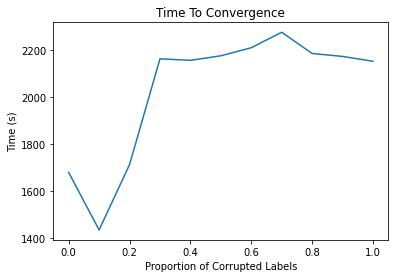

In [9]:
transform_train = transforms.Compose([
    transforms.CenterCrop(28),                                   
    transforms.ToTensor(),
    myNormalize()
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_train)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

directory = "/content/drive/MyDrive/MIE424H1 Final Project/Data Randomization/runs/Data Augmentation Runs/Alexnet/AlexnetModel_Convergence"

for i, (input, target) in enumerate(trainloader):
  print(input.size())
  break

main("Alexnet",'alexnet','train', directory, 150)